# Scalable Signature-Based Distribution Regression via Reference Sets

## Numerical Examples - Derivative Pricing

### Andrew Alden, Blanka Horvath, Carmine Ventre

### Table of Contents

- [Initial Setup](#initial-setup)
- [Base Processes](#base-process-setup)
- [Generate Training Data](#gen-train-data)
    - [Data Dictionary](#gen-train-data-dict)
    - [SPEEDRS](#gen-train-data-speedrs)
    - [Kernel-Based Baselines](#gen-train-data-baselines)
        - [RBF Kernel](#gen-train-data-rbf)
        - [Matern Kernel](#gen-train-data-matern)
    - [Training Prices](#gen-train-data-prices)
- [Train Models](#train-models)
    - [Statistical Models](#train-stat-models)
        - [SPEEDRS](#train-stat-models-speedrs)
        - [Kernel-Based Baselines](#train-stat-models-baselines)
            - [RBF Kernel](#train-stat-models-rbf)
            - [Matern Kernel](#train-stat-models-matern)
    - [Train Neural Networks](#train-neural-networks)
        - [SPEEDRS](#train-neural-networks-speedrs)
        - [Baselines](#train-neural-networks-baselines)
            - [RBF Kernel](#train-neural-networks-rbf)
            - [Matern Kernel](#train-neural-networks-matern)
            - [DeepSets](#train-neural-networks-deepsets)
- [Test Models](#test-models)
    - [Generate Test Data](#test-models-gen-data)
    - [SPEEDRS and Kernel-Based Baselines](#test-models-speedrs-kernel)
    - [DeepSets](#test-models-deepsets)
- [Testing Performance under Data Drift](#test-data-drift)
    - [Test 1 - Mixture Values](#test-data-drift-test1)
    - [Test 2 - Path Length](#test-data-drift-test2)
    - [Test 3 - Unseen Regimes](#test-data-drift-test3)
        - [GBM](#test-data-drift-test3-gbm)
        - [CEV](#test-data-drift-test3-cev)
    - [Performance Metrics](#test-data-drift-performance-metrics)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
import warnings
warnings.filterwarnings("ignore", "You are using `torch.load` with `weights_only=False`*.")
warnings.filterwarnings("ignore", message=r"Trying to unpickle estimator Ridge from version .*", category=UserWarning)
warnings.filterwarnings("ignore", message=r"Trying to unpickle estimator StandardScaler from version .*", category=UserWarning)

### Import libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from torch import nn
import torch.cuda
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import iisignature
import random
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor 
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path


from src.utils import save_dataset, load_dataset, save_path_params, load_path_params
from src.plotting_utils import construct_plot, compute_ci

from src.RegressionModel.regression_scaler_model import RegressionModelWithScaler
from src.RegressionModel.regression_model import RegressionModel
from src.RegressionModel.Baseline import bags_to_2D, rbf_mmd_mat, rbf_matern_mmd_mat, construct_pointwise_kernel_features
from src.RegressionModel.deep_sets import DataIterator, DeepSet, Trainer
from src.RegressionModel.train_utils import splice_features, train_linear_models, get_stats, display_linear_model_results, train_models, get_stats_NN 
from src.RegressionModel.test_utils import load_lgbm_model, test_neural_net, test_statistical_model, test_models, get_best_model_NN, get_best_model


from src.StochasticProcesses.rBergomi import r_bergomi_sample_paths_functional_central_limit, conditional_r_bergomi_sample_paths_functional_central_limit
from src.StochasticProcesses.Heston import heston_sample_paths_inv
from src.StochasticProcesses.BlackScholes import GBM_sample_paths
from src.StochasticProcesses.CEV import CEV_sample_paths

In [4]:
import sys

sys.modules['numpy._core'] = np.core
sys.modules['numpy._core.multiarray'] = np.core.multiarray

### Set device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


### Load pre-trained MMD approximator

In [6]:
i = 1
trunc_level = 3


mmd_approx_input_dimension = 28

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [60, 60, 60],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


mmd_approx_model_mixture = RegressionModelWithScaler(mmd_approx_model_param_dict, None, 
                                         None, None, device, 
                                         scaler_file_name=f'MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl',
                                         num_additional_inputs=mmd_approx_input_dimension)


mmd_approx_model_mixture.load_best_model(
    f"MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis.pth.tar", 
    f"MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl")

### Monte Carlo Pricing

In [7]:
def down_in_barrier_mc_price(S1, r, K, B, T):
    

    path_array = np.asarray(S1)
    running_min = np.amin(path_array, axis=0)
    S1_new = np.where(running_min > B, K, path_array[-1, :])

    return np.exp(-r*T)*np.mean(np.maximum(0, S1_new - K))

In [ ]:
xi_0_range = (0.01, 0.2)
nu_range = (0.5, 4.0)
rho_range = (-1, 1)
H_range = (0.025, 0.5)
v0_range = (0.2, 0.8)

vol_of_vol_range = (0.2, 0.8)
speed_range = (0.2, 0.8)
mean_volatility_range = (0.2, 0.8)
r_range = (0.01, 0.2)

sigma_range = (0.2, 0.8)

## Base Processes <a class="anchor" id="base-process-setup"></a>

In [9]:
num_base_rbergomi = 8
num_base_heston = 8
num_base_gbm = 4

# format [v0, mean vol, vol of vol, speed, r, correlation]
base_heston_processes = [np.random.uniform(v0_range[0], v0_range[1], 4).tolist() + [np.random.uniform(rho_range[0], rho_range[1])] + [np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_heston)]

# format [v0, H, xi_0, nu, correlation]
base_rbergomi_processes = [[np.random.uniform(v0_range[0], v0_range[1]), np.random.uniform(H_range[0], H_range[1]), np.random.uniform(xi_0_range[0], xi_0_range[1]), np.random.uniform(nu_range[0], nu_range[1]), np.random.uniform(rho_range[0], rho_range[1])] for _ in range(num_base_rbergomi)]

# format [sigma, r]
base_gbm_processes = [[np.random.uniform(sigma_range[0], sigma_range[1]), np.random.uniform(r_range[0], r_range[1])] for _ in range(num_base_gbm)]


S0 = 1.0
T = 1
num_sim = 5000
num_time_steps=14
sigma = 1
sig_level = 3

base_heston_paths = [heston_sample_paths_inv(S0, 
                                             base_heston_processes[i][0], 
                                             base_heston_processes[i][4], 
                                             base_heston_processes[i][5], 
                                             base_heston_processes[i][1], 
                                             base_heston_processes[i][3], 
                                             base_heston_processes[i][2], 
                                             T,
                                             num_sim,
                                             num_time_steps)[0] for i in range(num_base_heston)]

base_rbergomi_paths = [conditional_r_bergomi_sample_paths_functional_central_limit(S0,
                                                                                   base_rbergomi_processes[i][0], 
                                                                                   base_rbergomi_processes[i][1], 
                                                                                   [base_rbergomi_processes[i][2] for _ in range(num_time_steps+1)],
                                                                                   np.sqrt(2*base_rbergomi_processes[i][1]), 
                                                                                   base_rbergomi_processes[i][3], 
                                                                                   base_rbergomi_processes[i][4], 
                                                                                   T, 
                                                                                   num_time_steps,
                                                                                   num_sim)[-1] for i in range(num_base_rbergomi)]

       
base_gbm_paths = [GBM_sample_paths(S0, 
                                   base_gbm_processes[i][1],
                                   base_gbm_processes[i][0], 
                                   T, 
                                   num_sim,
                                   num_time_steps) for i in range(num_base_gbm)]
    
    
base_paths = base_heston_paths + base_rbergomi_paths + base_gbm_paths


base_process_expected_sigs = {}
for k in range(len(base_paths)):
    base_process_expected_sigs[k] = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(np.asarray(base_paths)[k, ...], (1, 0, 2)), 2), sigma)), sig_level), axis=0)

In [11]:
base_models = {
    
    'base_heston_processes' : base_heston_processes,
    'base_rbergomi_processes' : base_rbergomi_processes,
    'base_gbm_processes' : base_gbm_processes,
    'base_heston_paths' : base_heston_paths,
    'base_rbergomi_paths' : base_rbergomi_paths,
    'base_gbm_paths' : base_gbm_paths
    
}

save_path_params(base_models, "MixtureModels/BarrierOptions/Datasets/base_models_thesis")

save_path_params(base_process_expected_sigs, "MixtureModels/BarrierOptions/Datasets/base_process_expected_sigs_thesis")

## Generate Training Data <a class="anchor" id="gen-train-data"></a>

Load base process expected signatures

In [15]:
base_process_expected_sigs = load_path_params("MixtureModels/BarrierOptions/Datasets/base_process_expected_sigs_thesis")
base_models = load_path_params("MixtureModels/BarrierOptions/Datasets/base_models_thesis")

### Data Dictionary <a class="anchor" id="gen-train-data-dict"></a>

In [13]:
xi_0_list = []
nu_list = []
rho_rbergomi_list = []
H_list = []
v0_rbergomi_list = []

v0_heston_list = []
rho_heston_list = []
mean_vol_list = []
speed_list = []
vol_of_vol_list = []

S0_training = []
K_training = []
B_training = []
r_training = []
T_training = []

alpha_list = []


T = 1
S0 = 90
B = 85
K = 80

for i in range(2000):
    
    p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
    p_nu = np.random.uniform(nu_range[0], nu_range[1])
    p_rho_rbergomi = np.random.uniform(rho_range[0], rho_range[1])
    p_H = np.random.uniform(H_range[0], H_range[1])
    p_v0_rbergomi = np.random.uniform(v0_range[0], v0_range[1])
    
    p_v0_heston = np.random.uniform(v0_range[0], v0_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    p_rho_heston = np.random.uniform(rho_range[0], rho_range[1])
    p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
    p_speed = np.random.uniform(speed_range[0], speed_range[1])
    p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])
    r = np.random.uniform(r_range[0], r_range[1])

    
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        v0_heston_list.append(p_v0_heston)
        rho_heston_list.append(p_rho_heston)
        mean_vol_list.append(p_mean_vol)
        speed_list.append(p_speed)
        vol_of_vol_list.append(p_vol_of_vol)
            
        xi_0_list.append(p_xi_0)
        nu_list.append(p_nu)
        rho_rbergomi_list.append(p_rho_rbergomi)
        H_list.append(p_H)
        v0_rbergomi_list.append(p_v0_rbergomi)
        
        S0_training.append(S0)
        T_training.append(T)
        r_training.append(r)

        K_training.append(K)
        B_training.append(B)
        
        alpha_list.append(alpha)
        
        
rbergomi_heston_dict = {
    
    'v0_heston_list' : v0_heston_list,
    'rho_heston_list' : rho_heston_list,
    'mean_vol_list' : mean_vol_list,
    'speed_list' : speed_list,
    'vol_of_vol_list' : vol_of_vol_list,
    'xi_0_list' : xi_0_list,
    'nu_list' : nu_list,
    'rho_rbergomi_list' : rho_rbergomi_list,
    'H_list' : H_list,
    'v0_rbergomi_list' : v0_rbergomi_list,
    'S0_rbergomi' : S0_training,
    'T_rbergomi' : T_training,
    'r_rbergomi' : r_training,
    'K_rbergomi' : K_training,
    'B_rbergomi' : B_training,
    'alpha_list' : alpha_list
    
}


save_path_params(rbergomi_heston_dict, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_thesis")

### SPEEDRS <a class="anchor" id="gen-train-data-speedrs"></a>

In [47]:
rbergomi_heston_dict = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_thesis")

In [15]:
rbergomi_heston_features = []

T = 1.0

num_sim = 5000
num_time_steps = 14

expected_sigs_rbergomi_heston_mixture = []

sigma = 1
sig_level = 3
    
for i in tqdm(range(2000)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(rbergomi_heston_dict['S0_rbergomi'][i*5], 
                                                    rbergomi_heston_dict['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict['H_list'][i*5],
                                                    [rbergomi_heston_dict['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict['H_list'][i*5]),
                                                    rbergomi_heston_dict['nu_list'][i*5],
                                                    rbergomi_heston_dict['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(rbergomi_heston_dict['S0_rbergomi'][i*5],
                                rbergomi_heston_dict['v0_heston_list'][i*5], 
                                rbergomi_heston_dict['r_rbergomi'][i*5],
                                rbergomi_heston_dict['rho_heston_list'][i*5],
                                rbergomi_heston_dict['mean_vol_list'][i*5], 
                                rbergomi_heston_dict['speed_list'][i*5],
                                rbergomi_heston_dict['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0]  
    
    
    expected_sigs_alpha = {}

        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        
        new_dist = []
        p = np.add(alpha*p1, (1-alpha)*p2)

        p[:, :, 0] /= rbergomi_heston_dict['S0_rbergomi'][i*5]
        
        
        expected_sigs_alpha[alpha] = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)


        
    expected_sigs_rbergomi_heston_mixture.append(expected_sigs_alpha)      

100%|██████████| 2000/2000 [02:07<00:00, 15.73it/s]


In [16]:
save_path_params(expected_sigs_rbergomi_heston_mixture, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_expected_sigs_thesis")

In [13]:
expected_sigs_rbergomi_heston_mixture = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_expected_sigs_thesis")

In [18]:
pricing_model_features = []

    
for i in tqdm(range(2000)):
    
        
        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    
        new_dist = []
        for k in range(20):


            new_feature = expected_sigs_rbergomi_heston_mixture[i][alpha].tolist() + base_process_expected_sigs[k].tolist()

            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():

                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())


        pricing_model_features.append(new_dist)

100%|██████████| 2000/2000 [01:26<00:00, 23.18it/s]


In [19]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_features_thesis", "wb") as fp:
    pickle.dump(pricing_model_features, fp)

### Kernel-Based Baseline Features <a class="anchor" id="gen-train-data-baselines"></a>

#### RBF Kernel <a class="anchor" id="gen-train-data-rbf"></a>

In [6]:
rbergomi_heston_dict = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_thesis")
base_models = load_path_params("MixtureModels/BarrierOptions/Datasets/base_models_thesis")

In [40]:
rbergomi_heston_rbf_kernel_features = construct_pointwise_kernel_features(base_models, 
                                                                          rbergomi_heston_dict, 
                                                                          rbf_mmd_mat, 
                                                                          inc=5, 
                                                                          alpha_list=[0, 0.25, 0.5, 0.75, 1.0])

100%|██████████| 2000/2000 [16:34<00:00,  2.01it/s]


In [41]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_RBF_features_thesis", "wb") as fp:
    pickle.dump(rbergomi_heston_rbf_kernel_features, fp)

#### Matern Kernel <a class="anchor" id="gen-train-data-matern"></a>

In [14]:
rbergomi_heston_dict = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_thesis")
base_models = load_path_params("MixtureModels/BarrierOptions/Datasets/base_models_thesis")

In [43]:
rbergomi_heston_matern_kernel_features = construct_pointwise_kernel_features(base_models, 
                                                                             rbergomi_heston_dict, 
                                                                             rbf_matern_mmd_mat, 
                                                                             inc=5, 
                                                                             alpha_list=[0, 0.25, 0.5, 0.75, 1.0])

100%|██████████| 2000/2000 [20:17<00:00,  1.64it/s]


In [44]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_Matern_features_thesis", "wb") as fp:
    pickle.dump(rbergomi_heston_matern_kernel_features, fp)

### Training Prices <a class="anchor" id="gen-train-data-prices"></a>

In [20]:
num_sim = 50000
num_time_steps = 100



pricing_model_prices = []


S0 = 90
K = 80
B = 85
T = 1.0


S0_list = []
K_list = []
B_list = []
    
for i in tqdm(range(2000)):


    S1 = np.exp(r_bergomi_sample_paths_functional_central_limit(S0, 
                                                    rbergomi_heston_dict['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict['H_list'][i*5],
                                                    [rbergomi_heston_dict['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict['H_list'][i*5]),
                                                    rbergomi_heston_dict['nu_list'][i*5],
                                                    rbergomi_heston_dict['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[0])

    S2 = heston_sample_paths_inv(S0,
                                rbergomi_heston_dict['v0_heston_list'][i*5], 
                                rbergomi_heston_dict['r_rbergomi'][i*5],
                                rbergomi_heston_dict['rho_heston_list'][i*5],
                                rbergomi_heston_dict['mean_vol_list'][i*5], 
                                rbergomi_heston_dict['speed_list'][i*5],
                                rbergomi_heston_dict['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0][:, :, 0]
    
    
    expected_sigs_alpha = {}

        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        S = np.add(alpha*S1, (1-alpha)*S2)

        pricing_model_prices.append(down_in_barrier_mc_price(S, 0, K, B, T))  

100%|██████████| 2000/2000 [45:40<00:00,  1.37s/it]


In [21]:
save_path_params(pricing_model_prices, "MixtureModels/BarrierOptions/Datasets/training_prices_thesis")

# Train Models <a class="anchor" id="train-models"></a>

In [11]:
pricing_model_prices = load_path_params("MixtureModels/BarrierOptions/Datasets/training_prices_thesis")

## Statistical Models <a class="anchor" id="train-stat-models"></a>

In [8]:
param_dict = {'5': [(0, 2), (8, 10), (16, 17)], 
              '10': [(0, 4), (8, 12), (16, 18)],
              '20': [(0, 20)], 
             }

L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

### SPEEDRS <a class="anchor" id="train-stat-models-speedrs"></a>

In [9]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_features_thesis", "rb") as fp:
    pricing_model_features = pickle.load(fp)

In [27]:
suffix = '_thesis'
folder = 'BarrierOptions/Models'
for N in [5, 10, 20]:

    print(f'Linear Regression')

    new_pricing_model_features = splice_features(pricing_model_features, N)

    for l2 in L2_params:
        model_str = f'linear_reg_barrier_pricer_l2_{l2}'
        train_linear_models(pricing_model_prices, np.asarray(new_pricing_model_features), N, Ridge(fit_intercept=True, alpha=l2),
                            model_str, suffix=suffix, folder=folder)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}'
            train_linear_models(pricing_model_prices, np.asarray(new_pricing_model_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, suffix=suffix, folder=folder)

Linear Regression
*****************************************************************
LGBM
Linear Regression
*****************************************************************
LGBM
Linear Regression
*****************************************************************
LGBM


In [45]:
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder)

    Model  N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  5  0.00000    N/A   3.485868   0.022104   3.526038   0.087115
1   Ridge  5  1.00000    N/A   3.508276   0.031801   3.511148   0.134984
2   Ridge  5  0.10000    N/A   3.503245   0.018286   3.458901   0.075172
3   Ridge  5  0.01000    N/A   3.486351   0.032352   3.525570   0.128830
4   Ridge  5  0.00100    N/A   3.485725   0.022288   3.528849   0.087544
5   Ridge  5  0.00001    N/A   3.483559   0.041181   3.537184   0.164315
6    LGBM  5  0.00000    0.1   0.712432   0.007088   1.071319   0.027186
7    LGBM  5  0.00000   0.05   0.897242   0.008530   1.200522   0.045055
8    LGBM  5  0.00000   0.01   9.898864   0.031947  10.085070   0.195750
9    LGBM  5  0.00000  0.005  24.520055   0.102587  24.303631   0.511058
10   LGBM  5  0.00000  0.001  52.149093   0.302706  53.270279   1.239087
11   LGBM  5  1.00000    0.1   0.718234   0.008271   1.064277   0.027653
12   LGBM  5  1.00000   0.05   0.904261   0.003725 

In [46]:
speedrs_current_best_ridge

{5: {'MSE': np.float64(3.45890086827591), 'l2': 0.1},
 10: {'MSE': np.float64(1.7535201104816671), 'l2': 0.01},
 20: {'MSE': np.float64(1.0510408501832889), 'l2': 0.01}}

In [31]:
speedrs_current_best_lgbm

{5: {'MSE': np.float64(0.992319136648846), 'l2': 0.1, 'lr': 0.1},
 10: {'MSE': np.float64(0.779486713654329), 'l2': 0.01, 'lr': 0.1},
 20: {'MSE': np.float64(0.674281895471988), 'l2': 0.001, 'lr': 0.1}}

### Kernel-Based Baselines <a class="anchor" id="train-stat-models-baselines"></a>

#### RBF Kernel <a class="anchor" id="train-stat-models-rbf"></a>

In [9]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_RBF_features_thesis", "rb") as fp:
    rbergomi_heston_rbf_kernel_features = pickle.load(fp)

In [45]:
baseline = True
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]
suffix = '_thesis'
folder = 'BarrierOptions/Models'

for N in [20]:
    print(f'Linear Regression')

    for l2 in L2_params:
        model_str = f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}'
        train_linear_models(pricing_model_prices, np.asarray(rbergomi_heston_rbf_kernel_features), N, 
                            Ridge(fit_intercept=True, alpha=l2), model_str, baseline=baseline, suffix=suffix, 
                            folder=folder)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}'
            train_linear_models(pricing_model_prices, np.asarray(rbergomi_heston_rbf_kernel_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, baseline=baseline, suffix=suffix, folder=folder)

Linear Regression
*****************************************************************
LGBM


In [23]:
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20])

    Model   N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  20  0.00000    N/A   1.155584   0.012512   1.170487   0.050154
1   Ridge  20  1.00000    N/A   3.152075   0.023761   3.201800   0.102429
2   Ridge  20  0.10000    N/A   1.871736   0.017878   1.838509   0.079301
3   Ridge  20  0.01000    N/A   1.456958   0.005550   1.437406   0.026404
4   Ridge  20  0.00100    N/A   1.237435   0.007082   1.223979   0.031483
5   Ridge  20  0.00001    N/A   1.156448   0.006498   1.203078   0.028267
6    LGBM  20  0.00000    0.1   0.989461   0.015252   1.603166   0.086157
7    LGBM  20  0.00000   0.05   1.363432   0.013550   1.878536   0.045973
8    LGBM  20  0.00000   0.01  10.761758   0.059310  11.029509   0.439257
9    LGBM  20  0.00000  0.005  25.187932   0.047013  25.108757   0.260391
10   LGBM  20  0.00000  0.001  52.535830   0.293608  52.675643   1.195444
11   LGBM  20  1.00000    0.1   0.986475   0.006671   1.634561   0.051556
12   LGBM  20  1.00000   0.05   1.3816

In [24]:
rbf_current_best_ridge

{5: {'MSE': -1, 'l2': -1},
 10: {'MSE': -1, 'l2': -1},
 20: {'MSE': 1.1704871361312406, 'l2': 0}}

In [25]:
rbf_current_best_lgbm

{5: {'MSE': -1, 'l2': -1, 'lr': -1},
 10: {'MSE': -1, 'l2': -1, 'lr': -1},
 20: {'MSE': 1.5741207022890142, 'l2': 0.1, 'lr': 0.1}}

#### Matern Kernel <a class="anchor" id="train-stat-models-matern"></a>

In [10]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_Matern_features_thesis", "rb") as fp:   # Unpickling
    rbergomi_heston_matern_kernel_features = pickle.load(fp)

In [47]:
baseline = True
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]
suffix = '_thesis'
folder = 'BarrierOptions/Models'
for N in [20]:

    print(f'Linear Regression')

    for l2 in L2_params:
        model_str = f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}'
        train_linear_models(pricing_model_prices, np.asarray(rbergomi_heston_matern_kernel_features), N, 
                            Ridge(fit_intercept=True, alpha=l2), model_str, baseline=baseline, suffix=suffix, 
                            folder=folder)
    print(f'{"*"*65}')
    print(f'LGBM')
    for l2 in L2_params:
        for lr in lrs:
            model_str = f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}'
            train_linear_models(pricing_model_prices, np.asarray(rbergomi_heston_matern_kernel_features), N, 
                                LGBMRegressor(metric='mse', reg_lambda=l2, learning_rate=lr, verbose=0),
                                model_str, baseline=baseline, suffix=suffix, folder=folder)

Linear Regression
*****************************************************************
LGBM


In [20]:
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                   L2_params, 
                                                                                   model_str1, 
                                                                                   model_str2, 
                                                                                   suffix=suffix, 
                                                                                   folder=folder, 
                                                                                   baseline=True,
                                                                                   N_list=[20])

    Model   N       L2     LR  Train MSE  Train Std  Valid MSE  Valid Std
0   Ridge  20  0.00000    N/A   1.132799   0.013222   1.146523   0.054549
1   Ridge  20  1.00000    N/A   2.551661   0.028186   2.529573   0.095082
2   Ridge  20  0.10000    N/A   1.794665   0.016437   1.823621   0.069792
3   Ridge  20  0.01000    N/A   1.457048   0.009103   1.439630   0.053537
4   Ridge  20  0.00100    N/A   1.218220   0.006175   1.141667   0.027518
5   Ridge  20  0.00001    N/A   1.133920   0.005886   1.158169   0.023087
6    LGBM  20  0.00000    0.1   0.903785   0.003038   1.426525   0.041730
7    LGBM  20  0.00000   0.05   1.228374   0.016675   1.727936   0.085194
8    LGBM  20  0.00000   0.01  10.541135   0.051233  10.508520   0.362399
9    LGBM  20  0.00000  0.005  24.927036   0.102250  24.931729   0.457583
10   LGBM  20  0.00000  0.001  52.355222   0.139194  53.000086   0.583861
11   LGBM  20  1.00000    0.1   0.904196   0.011892   1.510873   0.054475
12   LGBM  20  1.00000   0.05   1.2477

In [21]:
matern_current_best_ridge

{5: {'MSE': -1, 'l2': -1},
 10: {'MSE': -1, 'l2': -1},
 20: {'MSE': 1.141667028193698, 'l2': 0.001}}

In [22]:
matern_current_best_lgbm

{5: {'MSE': -1, 'l2': -1, 'lr': -1},
 10: {'MSE': -1, 'l2': -1, 'lr': -1},
 20: {'MSE': 1.4265254324840773, 'l2': 0, 'lr': 0.1}}

## Train Neural Networks <a class="anchor" id="train-neural-networks"></a>

### SPEEDRS <a class="anchor" id="train-neural-networks-speedrs"></a>

In [ ]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_features_thesis", "rb") as fp:
    pricing_model_features = pickle.load(fp)

### B = 5

In [33]:
new_pricing_model_features_5_base = []
for f in pricing_model_features:
    new_pricing_model_features_5_base.append(f[:2] + f[8:10] + [f[16]])

barrier_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


barrier_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

barrier_input_dimension = 5

barrier_model_param_dict = {
    'input_dimension' : barrier_input_dimension,
    'intermediate_dimensions' : [15, 15, 15],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'

train_models(pricing_model_prices, new_pricing_model_features_5_base, barrier_training_param_dict, 
             barrier_dataset_loader_params, barrier_input_dimension,  
             barrier_model_param_dict, 5, device, num_runs=5, suffix=suffix, folder=folder, 
             model_desc_string=model_desc_string, model_desc_string=model_desc_string)

Number of Training Samples: 8025


  1%|          | 2/200 [00:00<00:53,  3.68it/s]

Epoch: 1 	 Training Loss: 208.76577758789062 	 Validation Loss: 192.6165771484375 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 190.33486938476562 	 Validation Loss: 175.65573120117188 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:42,  4.64it/s]

Epoch: 3 	 Training Loss: 173.19625854492188 	 Validation Loss: 159.22434997558594 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 157.2439422607422 	 Validation Loss: 144.2401885986328 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:38,  4.98it/s]

Epoch: 5 	 Training Loss: 141.8699493408203 	 Validation Loss: 128.14056396484375 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 125.50350952148438 	 Validation Loss: 113.68571472167969 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:37,  5.19it/s]

Epoch: 7 	 Training Loss: 111.26996612548828 	 Validation Loss: 100.17498779296875 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 97.48225402832031 	 Validation Loss: 86.72329711914062 	 Saving Checkpoint


  5%|▌         | 10/200 [00:02<00:36,  5.27it/s]

Epoch: 9 	 Training Loss: 82.88300323486328 	 Validation Loss: 72.6969985961914 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 70.2013168334961 	 Validation Loss: 61.8050651550293 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.31it/s]

Epoch: 11 	 Training Loss: 59.4978141784668 	 Validation Loss: 52.26862716674805 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 50.15037155151367 	 Validation Loss: 43.96164321899414 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.29it/s]

Epoch: 13 	 Training Loss: 42.117042541503906 	 Validation Loss: 36.89157485961914 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 35.28062057495117 	 Validation Loss: 30.91678237915039 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:35,  5.25it/s]

Epoch: 15 	 Training Loss: 29.46961212158203 	 Validation Loss: 25.86839485168457 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 24.565807342529297 	 Validation Loss: 21.643693923950195 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:41,  4.43it/s]

Epoch: 17 	 Training Loss: 20.466745376586914 	 Validation Loss: 18.07356834411621 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:46,  3.96it/s]

Epoch: 18 	 Training Loss: 17.06085205078125 	 Validation Loss: 15.145698547363281 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:43,  4.16it/s]

Epoch: 19 	 Training Loss: 14.262746810913086 	 Validation Loss: 12.785595893859863 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 12.004892349243164 	 Validation Loss: 10.798645973205566 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:39,  4.52it/s]

Epoch: 21 	 Training Loss: 10.161783218383789 	 Validation Loss: 9.224190711975098 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 8.684944152832031 	 Validation Loss: 7.993332862854004 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:05<00:36,  4.87it/s]

Epoch: 23 	 Training Loss: 7.48928689956665 	 Validation Loss: 6.8942484855651855 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 6.500349521636963 	 Validation Loss: 6.055601119995117 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:34,  5.09it/s]

Epoch: 25 	 Training Loss: 5.68352746963501 	 Validation Loss: 5.375614166259766 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 5.002035617828369 	 Validation Loss: 4.719382286071777 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:33,  5.18it/s]

Epoch: 27 	 Training Loss: 4.430731296539307 	 Validation Loss: 4.210528373718262 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 3.9557712078094482 	 Validation Loss: 3.7562320232391357 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:06<00:32,  5.24it/s]

Epoch: 29 	 Training Loss: 3.5491693019866943 	 Validation Loss: 3.397891044616699 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 3.2170207500457764 	 Validation Loss: 3.084958791732788 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.29it/s]

Epoch: 31 	 Training Loss: 2.9398186206817627 	 Validation Loss: 2.829683542251587 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 2.694993257522583 	 Validation Loss: 2.611410140991211 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.32it/s]

Epoch: 33 	 Training Loss: 2.4994218349456787 	 Validation Loss: 2.4256272315979004 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 2.323214054107666 	 Validation Loss: 2.314128875732422 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.32it/s]

Epoch: 35 	 Training Loss: 2.168980360031128 	 Validation Loss: 2.163057327270508 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 2.0491886138916016 	 Validation Loss: 2.0297727584838867 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.36it/s]

Epoch: 37 	 Training Loss: 1.937004566192627 	 Validation Loss: 1.9323123693466187 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 1.8328373432159424 	 Validation Loss: 1.8358205556869507 	 Saving Checkpoint


 20%|██        | 40/200 [00:08<00:30,  5.30it/s]

Epoch: 39 	 Training Loss: 1.7535358667373657 	 Validation Loss: 1.753251552581787 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 1.6801196336746216 	 Validation Loss: 1.7140508890151978 	 Saving Checkpoint


 21%|██        | 42/200 [00:08<00:29,  5.33it/s]

Epoch: 41 	 Training Loss: 1.6233822107315063 	 Validation Loss: 1.6386568546295166 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 1.5700900554656982 	 Validation Loss: 1.6079084873199463 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:08<00:29,  5.34it/s]

Epoch: 43 	 Training Loss: 1.5199962854385376 	 Validation Loss: 1.5506739616394043 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 1.4637172222137451 	 Validation Loss: 1.5347745418548584 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:09<00:28,  5.35it/s]

Epoch: 45 	 Training Loss: 1.4382280111312866 	 Validation Loss: 1.4738510847091675 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.3861494064331055 	 Validation Loss: 1.4258449077606201 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.38it/s]

Epoch: 47 	 Training Loss: 1.3580365180969238 	 Validation Loss: 1.4048746824264526 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 1.3188912868499756 	 Validation Loss: 1.4095920324325562


 25%|██▌       | 50/200 [00:09<00:27,  5.37it/s]

Epoch: 49 	 Training Loss: 1.3005155324935913 	 Validation Loss: 1.3342368602752686 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 1.2700384855270386 	 Validation Loss: 1.3111664056777954 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:10<00:27,  5.37it/s]

Epoch: 51 	 Training Loss: 1.2500354051589966 	 Validation Loss: 1.2793776988983154 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 1.2413990497589111 	 Validation Loss: 1.2777974605560303 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:27,  5.36it/s]

Epoch: 53 	 Training Loss: 1.211226224899292 	 Validation Loss: 1.2594159841537476 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 1.2101061344146729 	 Validation Loss: 1.231032371520996 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:10<00:27,  5.36it/s]

Epoch: 55 	 Training Loss: 1.1944125890731812 	 Validation Loss: 1.2071000337600708 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:11<00:27,  5.24it/s]

Epoch: 56 	 Training Loss: 1.171196460723877 	 Validation Loss: 1.1912213563919067 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 1.1577742099761963 	 Validation Loss: 1.1833999156951904 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:11<00:26,  5.31it/s]

Epoch: 58 	 Training Loss: 1.1457624435424805 	 Validation Loss: 1.221177101135254
Epoch: 59 	 Training Loss: 1.1452476978302002 	 Validation Loss: 1.1757797002792358 	 Saving Checkpoint


 30%|███       | 61/200 [00:12<00:25,  5.36it/s]

Epoch: 60 	 Training Loss: 1.119102954864502 	 Validation Loss: 1.1559631824493408 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 1.1181949377059937 	 Validation Loss: 1.1586899757385254


 32%|███▏      | 63/200 [00:12<00:25,  5.36it/s]

Epoch: 62 	 Training Loss: 1.1103712320327759 	 Validation Loss: 1.138626217842102 	 Saving Checkpoint
Epoch: 63 	 Training Loss: 1.0953227281570435 	 Validation Loss: 1.1280065774917603 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:12<00:25,  5.37it/s]

Epoch: 64 	 Training Loss: 1.0830941200256348 	 Validation Loss: 1.1122865676879883 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 1.0760459899902344 	 Validation Loss: 1.115696668624878


 34%|███▎      | 67/200 [00:13<00:24,  5.35it/s]

Epoch: 66 	 Training Loss: 1.0661580562591553 	 Validation Loss: 1.0951861143112183 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 1.0403317213058472 	 Validation Loss: 1.0836321115493774 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:13<00:24,  5.34it/s]

Epoch: 68 	 Training Loss: 1.045264482498169 	 Validation Loss: 1.1366678476333618
Epoch: 69 	 Training Loss: 1.0302937030792236 	 Validation Loss: 1.0793702602386475 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:13<00:23,  5.38it/s]

Epoch: 70 	 Training Loss: 1.0188721418380737 	 Validation Loss: 1.0630308389663696 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 1.0031176805496216 	 Validation Loss: 1.0698261260986328


 36%|███▋      | 73/200 [00:14<00:23,  5.34it/s]

Epoch: 72 	 Training Loss: 1.006059169769287 	 Validation Loss: 1.0472925901412964 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.9868357181549072 	 Validation Loss: 1.0398807525634766 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:14<00:24,  5.10it/s]

Epoch: 74 	 Training Loss: 0.9926727414131165 	 Validation Loss: 1.0353327989578247 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:14<00:28,  4.34it/s]

Epoch: 75 	 Training Loss: 0.9749131798744202 	 Validation Loss: 1.0430614948272705


 38%|███▊      | 76/200 [00:15<00:31,  3.91it/s]

Epoch: 76 	 Training Loss: 0.971874475479126 	 Validation Loss: 1.0198643207550049 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:15<00:28,  4.32it/s]

Epoch: 77 	 Training Loss: 0.9586672782897949 	 Validation Loss: 1.0361400842666626
Epoch: 78 	 Training Loss: 0.9649877548217773 	 Validation Loss: 1.0235929489135742


 40%|████      | 80/200 [00:15<00:25,  4.79it/s]

Epoch: 79 	 Training Loss: 0.9531989097595215 	 Validation Loss: 1.0646079778671265
Epoch: 80 	 Training Loss: 0.9548414945602417 	 Validation Loss: 0.9973272085189819 	 Saving Checkpoint


 41%|████      | 82/200 [00:16<00:23,  5.07it/s]

Epoch: 81 	 Training Loss: 0.9514593482017517 	 Validation Loss: 1.0284702777862549
Epoch: 82 	 Training Loss: 0.9433587193489075 	 Validation Loss: 0.9914877414703369 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:16<00:22,  5.23it/s]

Epoch: 83 	 Training Loss: 0.9304704666137695 	 Validation Loss: 0.9785590767860413 	 Saving Checkpoint
Epoch: 84 	 Training Loss: 0.9263145327568054 	 Validation Loss: 0.9831944704055786


 43%|████▎     | 86/200 [00:17<00:21,  5.31it/s]

Epoch: 85 	 Training Loss: 0.9326922297477722 	 Validation Loss: 0.9730467200279236 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 0.9227299690246582 	 Validation Loss: 0.9771128296852112


 44%|████▍     | 88/200 [00:17<00:21,  5.32it/s]

Epoch: 87 	 Training Loss: 0.9132632613182068 	 Validation Loss: 0.964384913444519 	 Saving Checkpoint
Epoch: 88 	 Training Loss: 0.9149367213249207 	 Validation Loss: 0.9565543532371521 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:17<00:20,  5.38it/s]

Epoch: 89 	 Training Loss: 0.906114399433136 	 Validation Loss: 0.9621667861938477
Epoch: 90 	 Training Loss: 0.9021620750427246 	 Validation Loss: 0.9582016468048096


 46%|████▌     | 92/200 [00:18<00:19,  5.41it/s]

Epoch: 91 	 Training Loss: 0.9035695791244507 	 Validation Loss: 0.9736209511756897
Epoch: 92 	 Training Loss: 0.8958864212036133 	 Validation Loss: 0.9624685049057007


 46%|████▋     | 93/200 [00:18<00:19,  5.39it/s]

Epoch: 93 	 Training Loss: 0.8987061977386475 	 Validation Loss: 0.9402315616607666 	 Saving Checkpoint


 48%|████▊     | 95/200 [00:18<00:20,  5.16it/s]

Epoch: 94 	 Training Loss: 0.8871750235557556 	 Validation Loss: 0.9555754661560059
Epoch: 95 	 Training Loss: 0.884969174861908 	 Validation Loss: 0.9320012331008911 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:19<00:19,  5.26it/s]

Epoch: 96 	 Training Loss: 0.8835447430610657 	 Validation Loss: 0.9357811808586121
Epoch: 97 	 Training Loss: 0.8739911913871765 	 Validation Loss: 0.9286585450172424 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:19<00:18,  5.35it/s]

Epoch: 98 	 Training Loss: 0.8712589144706726 	 Validation Loss: 0.9203436374664307 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 0.8727380633354187 	 Validation Loss: 0.920954704284668


 50%|█████     | 101/200 [00:19<00:18,  5.37it/s]

Epoch: 100 	 Training Loss: 0.8636592626571655 	 Validation Loss: 0.9253825545310974
Epoch: 101 	 Training Loss: 0.8574336171150208 	 Validation Loss: 0.9141539335250854 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:20<00:18,  5.38it/s]

Epoch: 102 	 Training Loss: 0.8568263053894043 	 Validation Loss: 0.9121102690696716 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.8528087735176086 	 Validation Loss: 0.912445068359375


 52%|█████▎    | 105/200 [00:20<00:17,  5.35it/s]

Epoch: 104 	 Training Loss: 0.847318708896637 	 Validation Loss: 0.9264350533485413
Epoch: 105 	 Training Loss: 0.848531186580658 	 Validation Loss: 0.9079539179801941 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:20<00:17,  5.31it/s]

Epoch: 106 	 Training Loss: 0.8418128490447998 	 Validation Loss: 0.9029642939567566 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.8372589349746704 	 Validation Loss: 0.8961037397384644 	 Saving Checkpoint


 55%|█████▍    | 109/200 [00:21<00:16,  5.36it/s]

Epoch: 108 	 Training Loss: 0.8383075594902039 	 Validation Loss: 0.898139476776123
Epoch: 109 	 Training Loss: 0.8386231064796448 	 Validation Loss: 0.8942630290985107 	 Saving Checkpoint


 56%|█████▌    | 111/200 [00:21<00:16,  5.33it/s]

Epoch: 110 	 Training Loss: 0.8337150812149048 	 Validation Loss: 0.8856714963912964 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 0.8283651471138 	 Validation Loss: 0.8815605640411377 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:22<00:16,  5.35it/s]

Epoch: 112 	 Training Loss: 0.8312640190124512 	 Validation Loss: 0.9089578986167908
Epoch: 113 	 Training Loss: 0.8281611204147339 	 Validation Loss: 0.8777498602867126 	 Saving Checkpoint


 57%|█████▊    | 115/200 [00:22<00:15,  5.41it/s]

Epoch: 114 	 Training Loss: 0.8198044896125793 	 Validation Loss: 0.8859120607376099
Epoch: 115 	 Training Loss: 0.8222296237945557 	 Validation Loss: 0.882400631904602


 58%|█████▊    | 117/200 [00:22<00:16,  5.08it/s]

Epoch: 116 	 Training Loss: 0.8157065510749817 	 Validation Loss: 0.8733959197998047 	 Saving Checkpoint
Epoch: 117 	 Training Loss: 0.8168861269950867 	 Validation Loss: 0.8860844969749451


 60%|█████▉    | 119/200 [00:23<00:15,  5.25it/s]

Epoch: 118 	 Training Loss: 0.8135407567024231 	 Validation Loss: 0.8815422058105469
Epoch: 119 	 Training Loss: 0.8072891235351562 	 Validation Loss: 0.8757836222648621


 60%|██████    | 121/200 [00:23<00:14,  5.34it/s]

Epoch: 120 	 Training Loss: 0.8094354867935181 	 Validation Loss: 0.8627866506576538 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 0.8049514889717102 	 Validation Loss: 0.8722778558731079


 62%|██████▏   | 123/200 [00:24<00:14,  5.36it/s]

Epoch: 122 	 Training Loss: 0.8071298599243164 	 Validation Loss: 0.8680271506309509
Epoch: 123 	 Training Loss: 0.7999510765075684 	 Validation Loss: 0.8538137674331665 	 Saving Checkpoint


 62%|██████▎   | 125/200 [00:24<00:13,  5.40it/s]

Epoch: 124 	 Training Loss: 0.794259786605835 	 Validation Loss: 0.8555389642715454
Epoch: 125 	 Training Loss: 0.7970542311668396 	 Validation Loss: 0.8584378957748413


 64%|██████▎   | 127/200 [00:24<00:13,  5.39it/s]

Epoch: 126 	 Training Loss: 0.788855791091919 	 Validation Loss: 0.8515596985816956 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.7888787984848022 	 Validation Loss: 0.8711389899253845


 64%|██████▍   | 129/200 [00:25<00:13,  5.40it/s]

Epoch: 128 	 Training Loss: 0.7873788475990295 	 Validation Loss: 0.8348187804222107 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.7835049629211426 	 Validation Loss: 0.8363437652587891


 66%|██████▌   | 131/200 [00:25<00:12,  5.43it/s]

Epoch: 130 	 Training Loss: 0.7780570983886719 	 Validation Loss: 0.8365910649299622
Epoch: 131 	 Training Loss: 0.7871379852294922 	 Validation Loss: 0.8586670756340027


 66%|██████▌   | 132/200 [00:25<00:15,  4.44it/s]

Epoch: 132 	 Training Loss: 0.7751098871231079 	 Validation Loss: 0.8314688205718994 	 Saving Checkpoint


 66%|██████▋   | 133/200 [00:26<00:16,  3.98it/s]

Epoch: 133 	 Training Loss: 0.7828293442726135 	 Validation Loss: 0.8361482620239258


 68%|██████▊   | 135/200 [00:26<00:15,  4.22it/s]

Epoch: 134 	 Training Loss: 0.7691238522529602 	 Validation Loss: 0.8602407574653625
Epoch: 135 	 Training Loss: 0.7682655453681946 	 Validation Loss: 0.8326521515846252


 68%|██████▊   | 137/200 [00:26<00:13,  4.75it/s]

Epoch: 136 	 Training Loss: 0.7682278752326965 	 Validation Loss: 0.8282516002655029 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 0.7654566168785095 	 Validation Loss: 0.8271906971931458 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:27<00:12,  5.06it/s]

Epoch: 138 	 Training Loss: 0.7621882557868958 	 Validation Loss: 0.8237785696983337 	 Saving Checkpoint
Epoch: 139 	 Training Loss: 0.755538821220398 	 Validation Loss: 0.8610585331916809


 70%|███████   | 141/200 [00:27<00:11,  5.24it/s]

Epoch: 140 	 Training Loss: 0.7641919851303101 	 Validation Loss: 0.8212608695030212 	 Saving Checkpoint
Epoch: 141 	 Training Loss: 0.7610635757446289 	 Validation Loss: 0.8355631232261658


 72%|███████▏  | 143/200 [00:28<00:10,  5.28it/s]

Epoch: 142 	 Training Loss: 0.7633119225502014 	 Validation Loss: 0.8145267963409424 	 Saving Checkpoint
Epoch: 143 	 Training Loss: 0.7559376358985901 	 Validation Loss: 0.813396692276001 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:28<00:10,  5.38it/s]

Epoch: 144 	 Training Loss: 0.752816915512085 	 Validation Loss: 0.8177053332328796
Epoch: 145 	 Training Loss: 0.7543349862098694 	 Validation Loss: 0.8166348934173584


 74%|███████▎  | 147/200 [00:28<00:09,  5.38it/s]

Epoch: 146 	 Training Loss: 0.7507176399230957 	 Validation Loss: 0.8174865245819092
Epoch: 147 	 Training Loss: 0.7535385489463806 	 Validation Loss: 0.8114975690841675 	 Saving Checkpoint


 74%|███████▍  | 149/200 [00:29<00:09,  5.40it/s]

Epoch: 148 	 Training Loss: 0.7469373345375061 	 Validation Loss: 0.8068434596061707 	 Saving Checkpoint
Epoch: 149 	 Training Loss: 0.7533955574035645 	 Validation Loss: 0.8094466924667358


 76%|███████▌  | 151/200 [00:29<00:09,  5.41it/s]

Epoch: 150 	 Training Loss: 0.7466045022010803 	 Validation Loss: 0.8319626450538635
Epoch: 151 	 Training Loss: 0.7505007982254028 	 Validation Loss: 0.8082048892974854


 76%|███████▋  | 153/200 [00:29<00:08,  5.42it/s]

Epoch: 152 	 Training Loss: 0.7402418255805969 	 Validation Loss: 0.8033273816108704 	 Saving Checkpoint
Epoch: 153 	 Training Loss: 0.7399603128433228 	 Validation Loss: 0.8043449521064758


 78%|███████▊  | 155/200 [00:30<00:08,  5.43it/s]

Epoch: 154 	 Training Loss: 0.7421138286590576 	 Validation Loss: 0.7989034056663513 	 Saving Checkpoint
Epoch: 155 	 Training Loss: 0.7385135889053345 	 Validation Loss: 0.8062905669212341


 78%|███████▊  | 157/200 [00:30<00:08,  5.31it/s]

Epoch: 156 	 Training Loss: 0.7390510439872742 	 Validation Loss: 0.7981786727905273 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.7360377311706543 	 Validation Loss: 0.7977800965309143 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:31<00:07,  5.26it/s]

Epoch: 158 	 Training Loss: 0.7409948706626892 	 Validation Loss: 0.7969160676002502 	 Saving Checkpoint
Epoch: 159 	 Training Loss: 0.7353829741477966 	 Validation Loss: 0.7946791052818298 	 Saving Checkpoint


 80%|████████  | 161/200 [00:31<00:07,  5.32it/s]

Epoch: 160 	 Training Loss: 0.7330626249313354 	 Validation Loss: 0.7941208481788635 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.7344996333122253 	 Validation Loss: 0.8017153739929199


 82%|████████▏ | 163/200 [00:31<00:06,  5.38it/s]

Epoch: 162 	 Training Loss: 0.7358081936836243 	 Validation Loss: 0.801047146320343
Epoch: 163 	 Training Loss: 0.7315699458122253 	 Validation Loss: 0.8173685073852539


 82%|████████▎ | 165/200 [00:32<00:06,  5.41it/s]

Epoch: 164 	 Training Loss: 0.7368490099906921 	 Validation Loss: 0.8120834231376648
Epoch: 165 	 Training Loss: 0.73249351978302 	 Validation Loss: 0.796724796295166


 84%|████████▎ | 167/200 [00:32<00:06,  5.39it/s]

Epoch: 166 	 Training Loss: 0.7342288494110107 	 Validation Loss: 0.795780599117279
Epoch: 167 	 Training Loss: 0.7298048138618469 	 Validation Loss: 0.7947748303413391


 84%|████████▍ | 169/200 [00:32<00:05,  5.36it/s]

Epoch: 168 	 Training Loss: 0.7259435057640076 	 Validation Loss: 0.7926590442657471 	 Saving Checkpoint
Epoch: 169 	 Training Loss: 0.7258707284927368 	 Validation Loss: 0.7889400124549866 	 Saving Checkpoint


 86%|████████▌ | 171/200 [00:33<00:05,  5.41it/s]

Epoch: 170 	 Training Loss: 0.7267431616783142 	 Validation Loss: 0.7890205979347229
Epoch: 171 	 Training Loss: 0.7245503664016724 	 Validation Loss: 0.7990389466285706


 86%|████████▋ | 173/200 [00:33<00:05,  5.36it/s]

Epoch: 172 	 Training Loss: 0.7222951054573059 	 Validation Loss: 0.7887857556343079 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 0.7251611351966858 	 Validation Loss: 0.7878615856170654 	 Saving Checkpoint


 88%|████████▊ | 175/200 [00:34<00:04,  5.35it/s]

Epoch: 174 	 Training Loss: 0.7225061058998108 	 Validation Loss: 0.7850356101989746 	 Saving Checkpoint
Epoch: 175 	 Training Loss: 0.7244910001754761 	 Validation Loss: 0.785498857498169


 88%|████████▊ | 177/200 [00:34<00:04,  5.38it/s]

Epoch: 176 	 Training Loss: 0.7197246551513672 	 Validation Loss: 0.7835866808891296 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.7168672680854797 	 Validation Loss: 0.786813497543335


 90%|████████▉ | 179/200 [00:34<00:03,  5.38it/s]

Epoch: 178 	 Training Loss: 0.7162209153175354 	 Validation Loss: 0.7781712412834167 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.7179237008094788 	 Validation Loss: 0.7789778113365173


 90%|█████████ | 181/200 [00:35<00:03,  5.41it/s]

Epoch: 180 	 Training Loss: 0.7095226049423218 	 Validation Loss: 0.788323700428009
Epoch: 181 	 Training Loss: 0.7141777873039246 	 Validation Loss: 0.7783732414245605


 92%|█████████▏| 183/200 [00:35<00:03,  5.43it/s]

Epoch: 182 	 Training Loss: 0.7121366858482361 	 Validation Loss: 0.7867081165313721
Epoch: 183 	 Training Loss: 0.712155282497406 	 Validation Loss: 0.7855470180511475


 92%|█████████▎| 185/200 [00:35<00:02,  5.43it/s]

Epoch: 184 	 Training Loss: 0.7080745100975037 	 Validation Loss: 0.7829422354698181
Epoch: 185 	 Training Loss: 0.7047464847564697 	 Validation Loss: 0.7837841510772705


 94%|█████████▎| 187/200 [00:36<00:02,  5.39it/s]

Epoch: 186 	 Training Loss: 0.7059471607208252 	 Validation Loss: 0.7703845500946045 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.7015007734298706 	 Validation Loss: 0.774387776851654


 94%|█████████▍| 188/200 [00:36<00:02,  5.41it/s]

Epoch: 188 	 Training Loss: 0.7025542259216309 	 Validation Loss: 0.7882856726646423


 94%|█████████▍| 189/200 [00:36<00:02,  5.18it/s]

Epoch: 189 	 Training Loss: 0.7020915150642395 	 Validation Loss: 0.7714325785636902


 95%|█████████▌| 190/200 [00:36<00:02,  4.38it/s]

Epoch: 190 	 Training Loss: 0.7011961340904236 	 Validation Loss: 0.7729957103729248


 96%|█████████▌| 191/200 [00:37<00:02,  3.94it/s]

Epoch: 191 	 Training Loss: 0.7026146650314331 	 Validation Loss: 0.7701519131660461 	 Saving Checkpoint


 96%|█████████▋| 193/200 [00:37<00:01,  4.33it/s]

Epoch: 192 	 Training Loss: 0.7030450105667114 	 Validation Loss: 0.7727730870246887
Epoch: 193 	 Training Loss: 0.7002394199371338 	 Validation Loss: 0.7735901474952698


 98%|█████████▊| 195/200 [00:38<00:01,  4.71it/s]

Epoch: 194 	 Training Loss: 0.6992133259773254 	 Validation Loss: 0.7659235596656799 	 Saving Checkpoint
Epoch: 195 	 Training Loss: 0.6992608904838562 	 Validation Loss: 0.7753357887268066


 98%|█████████▊| 197/200 [00:38<00:00,  5.05it/s]

Epoch: 196 	 Training Loss: 0.6969444155693054 	 Validation Loss: 0.7729954123497009
Epoch: 197 	 Training Loss: 0.6979377269744873 	 Validation Loss: 0.7667778730392456


100%|█████████▉| 199/200 [00:38<00:00,  5.20it/s]

Epoch: 198 	 Training Loss: 0.6953227519989014 	 Validation Loss: 0.764631986618042 	 Saving Checkpoint
Epoch: 199 	 Training Loss: 0.696671187877655 	 Validation Loss: 0.7645914554595947 	 Saving Checkpoint


100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


Epoch: 200 	 Training Loss: 0.6960645914077759 	 Validation Loss: 0.7627624273300171 	 Saving Checkpoint
Number of Training Samples: 7983


  1%|          | 2/200 [00:00<00:36,  5.38it/s]

Epoch: 1 	 Training Loss: 199.2396697998047 	 Validation Loss: 177.33221435546875 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 174.21646118164062 	 Validation Loss: 160.23495483398438 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.37it/s]

Epoch: 3 	 Training Loss: 159.17527770996094 	 Validation Loss: 146.49420166015625 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 145.25860595703125 	 Validation Loss: 133.0301971435547 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.35it/s]

Epoch: 5 	 Training Loss: 131.67884826660156 	 Validation Loss: 120.06536865234375 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 118.74992370605469 	 Validation Loss: 107.74961853027344 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.32it/s]

Epoch: 7 	 Training Loss: 105.82485961914062 	 Validation Loss: 94.77559661865234 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 92.81687927246094 	 Validation Loss: 82.59034729003906 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.34it/s]

Epoch: 9 	 Training Loss: 80.8653793334961 	 Validation Loss: 71.6362533569336 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 70.42340087890625 	 Validation Loss: 62.28759765625 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.30it/s]

Epoch: 11 	 Training Loss: 61.47434997558594 	 Validation Loss: 54.38242721557617 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 53.8327751159668 	 Validation Loss: 47.69021224975586 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.25it/s]

Epoch: 13 	 Training Loss: 47.38047790527344 	 Validation Loss: 42.16044235229492 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 40.31298065185547 	 Validation Loss: 33.5984001159668 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:34,  5.30it/s]

Epoch: 15 	 Training Loss: 33.15355682373047 	 Validation Loss: 28.268190383911133 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 28.087827682495117 	 Validation Loss: 23.866769790649414 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.31it/s]

Epoch: 17 	 Training Loss: 23.79726219177246 	 Validation Loss: 20.128684997558594 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 20.165327072143555 	 Validation Loss: 16.959819793701172 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:33,  5.30it/s]

Epoch: 19 	 Training Loss: 17.06806755065918 	 Validation Loss: 14.279393196105957 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 14.459075927734375 	 Validation Loss: 12.053698539733887 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.32it/s]

Epoch: 21 	 Training Loss: 12.286088943481445 	 Validation Loss: 10.210647583007812 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 10.479706764221191 	 Validation Loss: 8.6847562789917 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.32it/s]

Epoch: 23 	 Training Loss: 8.99400520324707 	 Validation Loss: 7.475744724273682 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 7.792783260345459 	 Validation Loss: 6.457298755645752 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:32,  5.30it/s]

Epoch: 25 	 Training Loss: 6.812379360198975 	 Validation Loss: 5.617996692657471 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 6.0031280517578125 	 Validation Loss: 4.966037750244141 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.30it/s]

Epoch: 27 	 Training Loss: 5.34799337387085 	 Validation Loss: 4.412177562713623 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 4.785861015319824 	 Validation Loss: 3.9822373390197754 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:31,  5.31it/s]

Epoch: 29 	 Training Loss: 4.326247692108154 	 Validation Loss: 3.5916359424591064 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 3.911094903945923 	 Validation Loss: 3.2324960231781006 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.32it/s]

Epoch: 31 	 Training Loss: 3.556508779525757 	 Validation Loss: 2.9498226642608643 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 3.2665293216705322 	 Validation Loss: 2.6716854572296143 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.34it/s]

Epoch: 33 	 Training Loss: 2.9533183574676514 	 Validation Loss: 2.456336498260498 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 2.7389276027679443 	 Validation Loss: 2.320591688156128 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:06<00:30,  5.34it/s]

Epoch: 35 	 Training Loss: 2.529406785964966 	 Validation Loss: 2.134978771209717 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 2.338815689086914 	 Validation Loss: 1.9578452110290527 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.34it/s]

Epoch: 37 	 Training Loss: 2.1944267749786377 	 Validation Loss: 1.8470996618270874 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 2.052881956100464 	 Validation Loss: 1.7200149297714233 	 Saving Checkpoint


 20%|██        | 40/200 [00:07<00:29,  5.34it/s]

Epoch: 39 	 Training Loss: 1.9412212371826172 	 Validation Loss: 1.6543318033218384 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 1.8501152992248535 	 Validation Loss: 1.61715567111969 	 Saving Checkpoint


 21%|██        | 42/200 [00:07<00:29,  5.33it/s]

Epoch: 41 	 Training Loss: 1.7563987970352173 	 Validation Loss: 1.5007107257843018 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 1.6794171333312988 	 Validation Loss: 1.4816296100616455 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:08<00:29,  5.32it/s]

Epoch: 43 	 Training Loss: 1.662835955619812 	 Validation Loss: 1.3935465812683105 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 1.591447114944458 	 Validation Loss: 1.357494831085205 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:08<00:28,  5.33it/s]

Epoch: 45 	 Training Loss: 1.5136470794677734 	 Validation Loss: 1.327719807624817 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.4575241804122925 	 Validation Loss: 1.307949185371399 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:08<00:33,  4.50it/s]

Epoch: 47 	 Training Loss: 1.4177839756011963 	 Validation Loss: 1.2715039253234863 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:37,  4.01it/s]

Epoch: 48 	 Training Loss: 1.4040583372116089 	 Validation Loss: 1.2382367849349976 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:09<00:36,  4.07it/s]

Epoch: 49 	 Training Loss: 1.3435767889022827 	 Validation Loss: 1.2579337358474731
Epoch: 50 	 Training Loss: 1.3293383121490479 	 Validation Loss: 1.2313764095306396 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:10<00:31,  4.64it/s]

Epoch: 51 	 Training Loss: 1.3062283992767334 	 Validation Loss: 1.1678340435028076 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 1.2796953916549683 	 Validation Loss: 1.1537885665893555 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:29,  4.96it/s]

Epoch: 53 	 Training Loss: 1.251401424407959 	 Validation Loss: 1.1484336853027344 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 1.228266716003418 	 Validation Loss: 1.1434216499328613 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:10<00:28,  5.13it/s]

Epoch: 55 	 Training Loss: 1.212276816368103 	 Validation Loss: 1.1363189220428467 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 1.19414222240448 	 Validation Loss: 1.1204434633255005 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:11<00:26,  5.27it/s]

Epoch: 57 	 Training Loss: 1.1851967573165894 	 Validation Loss: 1.0920381546020508 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 1.1725835800170898 	 Validation Loss: 1.0931367874145508


 30%|███       | 60/200 [00:11<00:26,  5.33it/s]

Epoch: 59 	 Training Loss: 1.1594367027282715 	 Validation Loss: 1.0723661184310913 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 1.16727614402771 	 Validation Loss: 1.0878736972808838


 30%|███       | 61/200 [00:11<00:25,  5.36it/s]

Epoch: 61 	 Training Loss: 1.1533094644546509 	 Validation Loss: 1.0757734775543213


 32%|███▏      | 63/200 [00:12<00:26,  5.24it/s]

Epoch: 62 	 Training Loss: 1.1346415281295776 	 Validation Loss: 1.0764060020446777
Epoch: 63 	 Training Loss: 1.1266261339187622 	 Validation Loss: 1.0492496490478516 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:12<00:25,  5.31it/s]

Epoch: 64 	 Training Loss: 1.1099368333816528 	 Validation Loss: 1.0684503316879272
Epoch: 65 	 Training Loss: 1.1120961904525757 	 Validation Loss: 1.035314917564392 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:12<00:24,  5.35it/s]

Epoch: 66 	 Training Loss: 1.0995203256607056 	 Validation Loss: 1.041473150253296
Epoch: 67 	 Training Loss: 1.0833784341812134 	 Validation Loss: 1.0326340198516846 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:13<00:24,  5.37it/s]

Epoch: 68 	 Training Loss: 1.0907446146011353 	 Validation Loss: 1.0207264423370361 	 Saving Checkpoint
Epoch: 69 	 Training Loss: 1.0789570808410645 	 Validation Loss: 1.0352985858917236


 36%|███▌      | 71/200 [00:13<00:23,  5.39it/s]

Epoch: 70 	 Training Loss: 1.0715781450271606 	 Validation Loss: 1.0178108215332031 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 1.0641279220581055 	 Validation Loss: 1.0200140476226807


 36%|███▋      | 73/200 [00:14<00:23,  5.41it/s]

Epoch: 72 	 Training Loss: 1.063427209854126 	 Validation Loss: 1.0525938272476196
Epoch: 73 	 Training Loss: 1.0492770671844482 	 Validation Loss: 1.0719355344772339


 38%|███▊      | 75/200 [00:14<00:23,  5.40it/s]

Epoch: 74 	 Training Loss: 1.0567927360534668 	 Validation Loss: 1.0109091997146606 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 1.0381958484649658 	 Validation Loss: 1.0233089923858643


 38%|███▊      | 77/200 [00:14<00:22,  5.38it/s]

Epoch: 76 	 Training Loss: 1.0374916791915894 	 Validation Loss: 1.0093728303909302 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 1.0316628217697144 	 Validation Loss: 1.017505407333374


 40%|███▉      | 79/200 [00:15<00:22,  5.38it/s]

Epoch: 78 	 Training Loss: 1.0273792743682861 	 Validation Loss: 0.9857257604598999 	 Saving Checkpoint
Epoch: 79 	 Training Loss: 1.019907832145691 	 Validation Loss: 0.9995468854904175


 40%|████      | 81/200 [00:15<00:22,  5.40it/s]

Epoch: 80 	 Training Loss: 1.0190995931625366 	 Validation Loss: 0.9883246421813965
Epoch: 81 	 Training Loss: 1.0207473039627075 	 Validation Loss: 1.0562324523925781


 42%|████▏     | 83/200 [00:15<00:21,  5.39it/s]

Epoch: 82 	 Training Loss: 1.0069372653961182 	 Validation Loss: 0.984040379524231 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 1.013156533241272 	 Validation Loss: 1.006209373474121


 42%|████▎     | 85/200 [00:16<00:21,  5.34it/s]

Epoch: 84 	 Training Loss: 1.006420373916626 	 Validation Loss: 0.978016197681427 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.9975206851959229 	 Validation Loss: 0.977334201335907 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:16<00:21,  5.34it/s]

Epoch: 86 	 Training Loss: 0.9973329901695251 	 Validation Loss: 1.0373547077178955
Epoch: 87 	 Training Loss: 1.0040910243988037 	 Validation Loss: 0.9637961983680725 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:17<00:20,  5.38it/s]

Epoch: 88 	 Training Loss: 0.9986751675605774 	 Validation Loss: 0.975354790687561
Epoch: 89 	 Training Loss: 0.999747633934021 	 Validation Loss: 1.0031919479370117


 46%|████▌     | 91/200 [00:17<00:20,  5.40it/s]

Epoch: 90 	 Training Loss: 0.9912798404693604 	 Validation Loss: 0.9680138826370239
Epoch: 91 	 Training Loss: 0.981123685836792 	 Validation Loss: 0.9924607276916504


 46%|████▋     | 93/200 [00:17<00:19,  5.40it/s]

Epoch: 92 	 Training Loss: 0.9873642325401306 	 Validation Loss: 0.9711815118789673
Epoch: 93 	 Training Loss: 0.9934197664260864 	 Validation Loss: 0.9645925164222717


 48%|████▊     | 95/200 [00:18<00:19,  5.35it/s]

Epoch: 94 	 Training Loss: 0.9840766191482544 	 Validation Loss: 0.9514362215995789 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.9705798029899597 	 Validation Loss: 0.9509775042533875 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:18<00:19,  5.39it/s]

Epoch: 96 	 Training Loss: 0.9732083082199097 	 Validation Loss: 0.9536340236663818
Epoch: 97 	 Training Loss: 0.9764956831932068 	 Validation Loss: 0.9623376131057739


 50%|████▉     | 99/200 [00:18<00:18,  5.42it/s]

Epoch: 98 	 Training Loss: 0.9762187004089355 	 Validation Loss: 0.9842237234115601
Epoch: 99 	 Training Loss: 0.9752653241157532 	 Validation Loss: 0.965242326259613


 50%|█████     | 101/200 [00:19<00:18,  5.32it/s]

Epoch: 100 	 Training Loss: 0.97165447473526 	 Validation Loss: 0.9575819373130798
Epoch: 101 	 Training Loss: 0.9588614106178284 	 Validation Loss: 0.9469239711761475 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:19<00:18,  5.33it/s]

Epoch: 102 	 Training Loss: 0.9543249011039734 	 Validation Loss: 0.9732916355133057
Epoch: 103 	 Training Loss: 0.958285391330719 	 Validation Loss: 0.9384392499923706 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:19<00:18,  5.12it/s]

Epoch: 104 	 Training Loss: 0.9526873230934143 	 Validation Loss: 0.9357107877731323 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:20<00:21,  4.36it/s]

Epoch: 105 	 Training Loss: 0.956830620765686 	 Validation Loss: 0.9632359147071838


 53%|█████▎    | 106/200 [00:20<00:23,  3.92it/s]

Epoch: 106 	 Training Loss: 0.947163462638855 	 Validation Loss: 0.9351441264152527 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:20<00:21,  4.32it/s]

Epoch: 107 	 Training Loss: 0.9551536440849304 	 Validation Loss: 0.9492784738540649
Epoch: 108 	 Training Loss: 0.9544854760169983 	 Validation Loss: 0.950336754322052


 55%|█████▌    | 110/200 [00:21<00:18,  4.80it/s]

Epoch: 109 	 Training Loss: 0.948637068271637 	 Validation Loss: 0.9269552826881409 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.9363827109336853 	 Validation Loss: 0.9471591711044312


 56%|█████▌    | 112/200 [00:21<00:17,  5.09it/s]

Epoch: 111 	 Training Loss: 0.9482579827308655 	 Validation Loss: 0.9363676905632019
Epoch: 112 	 Training Loss: 0.9438635110855103 	 Validation Loss: 0.935363233089447


 56%|█████▋    | 113/200 [00:21<00:16,  5.18it/s]

Epoch: 113 	 Training Loss: 0.935642421245575 	 Validation Loss: 0.9335736632347107


 57%|█████▊    | 115/200 [00:22<00:17,  4.90it/s]

Epoch: 114 	 Training Loss: 0.9317277073860168 	 Validation Loss: 0.9265025854110718 	 Saving Checkpoint
Epoch: 115 	 Training Loss: 0.9325408339500427 	 Validation Loss: 0.9256384372711182 	 Saving Checkpoint


 58%|█████▊    | 117/200 [00:22<00:16,  5.09it/s]

Epoch: 116 	 Training Loss: 0.939652144908905 	 Validation Loss: 0.9194618463516235 	 Saving Checkpoint
Epoch: 117 	 Training Loss: 0.9322576522827148 	 Validation Loss: 0.9186321496963501 	 Saving Checkpoint


 60%|█████▉    | 119/200 [00:23<00:15,  5.27it/s]

Epoch: 118 	 Training Loss: 0.9246684312820435 	 Validation Loss: 0.9197161793708801
Epoch: 119 	 Training Loss: 0.9308589696884155 	 Validation Loss: 0.9477151036262512


 60%|██████    | 121/200 [00:23<00:14,  5.34it/s]

Epoch: 120 	 Training Loss: 0.9204694628715515 	 Validation Loss: 0.9267095923423767
Epoch: 121 	 Training Loss: 0.9269999861717224 	 Validation Loss: 0.9187391996383667


 62%|██████▏   | 123/200 [00:23<00:14,  5.27it/s]

Epoch: 122 	 Training Loss: 0.9186655282974243 	 Validation Loss: 0.913240373134613 	 Saving Checkpoint
Epoch: 123 	 Training Loss: 0.9200465083122253 	 Validation Loss: 0.9222880601882935


 62%|██████▎   | 125/200 [00:24<00:14,  5.28it/s]

Epoch: 124 	 Training Loss: 0.9196522235870361 	 Validation Loss: 0.9251916408538818
Epoch: 125 	 Training Loss: 0.9230326414108276 	 Validation Loss: 0.9071272611618042 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:24<00:14,  5.21it/s]

Epoch: 126 	 Training Loss: 0.9079275131225586 	 Validation Loss: 0.9081936478614807
Epoch: 127 	 Training Loss: 0.905329704284668 	 Validation Loss: 0.9315144419670105


 64%|██████▍   | 129/200 [00:24<00:13,  5.31it/s]

Epoch: 128 	 Training Loss: 0.9063224196434021 	 Validation Loss: 0.9247608184814453
Epoch: 129 	 Training Loss: 0.901501476764679 	 Validation Loss: 0.9154801368713379


 66%|██████▌   | 131/200 [00:25<00:12,  5.36it/s]

Epoch: 130 	 Training Loss: 0.9042677283287048 	 Validation Loss: 0.903106689453125 	 Saving Checkpoint
Epoch: 131 	 Training Loss: 0.9054467678070068 	 Validation Loss: 0.9254075884819031


 66%|██████▋   | 133/200 [00:25<00:13,  5.10it/s]

Epoch: 132 	 Training Loss: 0.9135140776634216 	 Validation Loss: 0.9030584692955017 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 0.8998649716377258 	 Validation Loss: 0.9014458060264587 	 Saving Checkpoint


 68%|██████▊   | 135/200 [00:26<00:12,  5.14it/s]

Epoch: 134 	 Training Loss: 0.903425931930542 	 Validation Loss: 0.8894516825675964 	 Saving Checkpoint
Epoch: 135 	 Training Loss: 0.9029430150985718 	 Validation Loss: 0.9139835238456726


 68%|██████▊   | 137/200 [00:26<00:11,  5.29it/s]

Epoch: 136 	 Training Loss: 0.8953230381011963 	 Validation Loss: 0.8975770473480225
Epoch: 137 	 Training Loss: 0.8957023024559021 	 Validation Loss: 0.8964515924453735


 70%|██████▉   | 139/200 [00:26<00:11,  5.35it/s]

Epoch: 138 	 Training Loss: 0.8907533288002014 	 Validation Loss: 0.8918511271476746
Epoch: 139 	 Training Loss: 0.8944680094718933 	 Validation Loss: 0.8903604745864868


 70%|███████   | 141/200 [00:27<00:10,  5.40it/s]

Epoch: 140 	 Training Loss: 0.9033065438270569 	 Validation Loss: 0.902381420135498
Epoch: 141 	 Training Loss: 0.8925672173500061 	 Validation Loss: 0.9154878258705139


 72%|███████▏  | 143/200 [00:27<00:10,  5.39it/s]

Epoch: 142 	 Training Loss: 0.886249840259552 	 Validation Loss: 0.8890079259872437 	 Saving Checkpoint
Epoch: 143 	 Training Loss: 0.8891043663024902 	 Validation Loss: 0.9029858112335205


 72%|███████▎  | 145/200 [00:27<00:10,  5.36it/s]

Epoch: 144 	 Training Loss: 0.880305290222168 	 Validation Loss: 0.8788226842880249 	 Saving Checkpoint
Epoch: 145 	 Training Loss: 0.8887031078338623 	 Validation Loss: 0.8759911060333252 	 Saving Checkpoint


 74%|███████▎  | 147/200 [00:28<00:09,  5.40it/s]

Epoch: 146 	 Training Loss: 0.8837003707885742 	 Validation Loss: 0.8815086483955383
Epoch: 147 	 Training Loss: 0.8891155123710632 	 Validation Loss: 0.8761665225028992


 74%|███████▍  | 149/200 [00:28<00:09,  5.43it/s]

Epoch: 148 	 Training Loss: 0.8788804411888123 	 Validation Loss: 0.877558708190918
Epoch: 149 	 Training Loss: 0.8849522471427917 	 Validation Loss: 0.8842300772666931


 76%|███████▌  | 151/200 [00:29<00:09,  5.40it/s]

Epoch: 150 	 Training Loss: 0.8906557559967041 	 Validation Loss: 0.8905599117279053
Epoch: 151 	 Training Loss: 0.8731783628463745 	 Validation Loss: 0.8759082555770874 	 Saving Checkpoint


 76%|███████▋  | 153/200 [00:29<00:08,  5.42it/s]

Epoch: 152 	 Training Loss: 0.8754217624664307 	 Validation Loss: 0.8805019855499268
Epoch: 153 	 Training Loss: 0.8725329637527466 	 Validation Loss: 0.8781330585479736


 78%|███████▊  | 155/200 [00:29<00:08,  5.42it/s]

Epoch: 154 	 Training Loss: 0.8699439764022827 	 Validation Loss: 0.8713796734809875 	 Saving Checkpoint
Epoch: 155 	 Training Loss: 0.8714240789413452 	 Validation Loss: 0.8753952383995056


 78%|███████▊  | 157/200 [00:30<00:07,  5.45it/s]

Epoch: 156 	 Training Loss: 0.8655075430870056 	 Validation Loss: 0.8723286390304565
Epoch: 157 	 Training Loss: 0.8715631365776062 	 Validation Loss: 0.8795865774154663


 80%|███████▉  | 159/200 [00:30<00:07,  5.40it/s]

Epoch: 158 	 Training Loss: 0.8755121231079102 	 Validation Loss: 0.8741536140441895
Epoch: 159 	 Training Loss: 0.8680687546730042 	 Validation Loss: 0.8689699172973633 	 Saving Checkpoint


 80%|████████  | 161/200 [00:30<00:07,  5.39it/s]

Epoch: 160 	 Training Loss: 0.8686559200286865 	 Validation Loss: 0.8649194836616516 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.8648233413696289 	 Validation Loss: 0.8784876465797424


 81%|████████  | 162/200 [00:31<00:08,  4.62it/s]

Epoch: 162 	 Training Loss: 0.8634077310562134 	 Validation Loss: 0.8816686868667603


 82%|████████▏ | 163/200 [00:31<00:09,  4.08it/s]

Epoch: 163 	 Training Loss: 0.8658238649368286 	 Validation Loss: 0.8757190704345703


 82%|████████▎ | 165/200 [00:32<00:08,  4.19it/s]

Epoch: 164 	 Training Loss: 0.8772284984588623 	 Validation Loss: 0.8832170367240906
Epoch: 165 	 Training Loss: 0.8688677549362183 	 Validation Loss: 0.8610768914222717 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:32<00:07,  4.38it/s]

Epoch: 166 	 Training Loss: 0.8600966930389404 	 Validation Loss: 0.8680497407913208


 84%|████████▍ | 168/200 [00:32<00:06,  4.65it/s]

Epoch: 167 	 Training Loss: 0.8616909384727478 	 Validation Loss: 0.8593435883522034 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.8585506677627563 	 Validation Loss: 0.866136908531189


 85%|████████▌ | 170/200 [00:33<00:06,  4.94it/s]

Epoch: 169 	 Training Loss: 0.8578044772148132 	 Validation Loss: 0.8640410900115967
Epoch: 170 	 Training Loss: 0.8574246764183044 	 Validation Loss: 0.8758317232131958


 86%|████████▌ | 172/200 [00:33<00:05,  5.01it/s]

Epoch: 171 	 Training Loss: 0.8630595803260803 	 Validation Loss: 0.8589441180229187 	 Saving Checkpoint
Epoch: 172 	 Training Loss: 0.8574021458625793 	 Validation Loss: 0.8722622990608215


 87%|████████▋ | 174/200 [00:33<00:05,  5.06it/s]

Epoch: 173 	 Training Loss: 0.8526919484138489 	 Validation Loss: 0.8611437082290649
Epoch: 174 	 Training Loss: 0.8605146408081055 	 Validation Loss: 0.8617948293685913


 88%|████████▊ | 176/200 [00:34<00:04,  5.07it/s]

Epoch: 175 	 Training Loss: 0.8535659313201904 	 Validation Loss: 0.8534294962882996 	 Saving Checkpoint
Epoch: 176 	 Training Loss: 0.8484807014465332 	 Validation Loss: 0.8572372198104858


 89%|████████▉ | 178/200 [00:34<00:04,  5.06it/s]

Epoch: 177 	 Training Loss: 0.8455245494842529 	 Validation Loss: 0.8585116863250732
Epoch: 178 	 Training Loss: 0.8493204116821289 	 Validation Loss: 0.8596068024635315


 90%|█████████ | 180/200 [00:34<00:03,  5.17it/s]

Epoch: 179 	 Training Loss: 0.8468948006629944 	 Validation Loss: 0.8672531247138977
Epoch: 180 	 Training Loss: 0.8465214967727661 	 Validation Loss: 0.8597550392150879


 91%|█████████ | 182/200 [00:35<00:03,  5.16it/s]

Epoch: 181 	 Training Loss: 0.8428542613983154 	 Validation Loss: 0.8731627464294434
Epoch: 182 	 Training Loss: 0.8496626615524292 	 Validation Loss: 0.8570802211761475


 92%|█████████▏| 183/200 [00:35<00:03,  5.23it/s]

Epoch: 183 	 Training Loss: 0.8437811732292175 	 Validation Loss: 0.8566895723342896


 92%|█████████▎| 185/200 [00:35<00:02,  5.20it/s]

Epoch: 184 	 Training Loss: 0.842735230922699 	 Validation Loss: 0.8491213917732239 	 Saving Checkpoint
Epoch: 185 	 Training Loss: 0.8461185693740845 	 Validation Loss: 0.8536168336868286


 94%|█████████▎| 187/200 [00:36<00:02,  5.27it/s]

Epoch: 186 	 Training Loss: 0.8369617462158203 	 Validation Loss: 0.8577221632003784
Epoch: 187 	 Training Loss: 0.8461505770683289 	 Validation Loss: 0.8473308682441711 	 Saving Checkpoint


 94%|█████████▍| 189/200 [00:36<00:02,  5.35it/s]

Epoch: 188 	 Training Loss: 0.8383092880249023 	 Validation Loss: 0.8567606210708618
Epoch: 189 	 Training Loss: 0.8471531867980957 	 Validation Loss: 0.8641482591629028


 96%|█████████▌| 191/200 [00:37<00:01,  5.34it/s]

Epoch: 190 	 Training Loss: 0.8354659080505371 	 Validation Loss: 0.8433164954185486 	 Saving Checkpoint
Epoch: 191 	 Training Loss: 0.8372026681900024 	 Validation Loss: 0.8442069888114929


 96%|█████████▋| 193/200 [00:37<00:01,  5.37it/s]

Epoch: 192 	 Training Loss: 0.8366038203239441 	 Validation Loss: 0.8539465665817261
Epoch: 193 	 Training Loss: 0.8411714434623718 	 Validation Loss: 0.8494685292243958


 98%|█████████▊| 195/200 [00:37<00:00,  5.38it/s]

Epoch: 194 	 Training Loss: 0.8379406929016113 	 Validation Loss: 0.8447785377502441
Epoch: 195 	 Training Loss: 0.8341086506843567 	 Validation Loss: 0.8436515927314758


 98%|█████████▊| 197/200 [00:38<00:00,  5.40it/s]

Epoch: 196 	 Training Loss: 0.8347892165184021 	 Validation Loss: 0.8457928895950317
Epoch: 197 	 Training Loss: 0.8316943645477295 	 Validation Loss: 0.846657931804657


100%|█████████▉| 199/200 [00:38<00:00,  5.40it/s]

Epoch: 198 	 Training Loss: 0.831019937992096 	 Validation Loss: 0.8472326993942261
Epoch: 199 	 Training Loss: 0.8342919945716858 	 Validation Loss: 0.8436648845672607


100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


Epoch: 200 	 Training Loss: 0.8316940069198608 	 Validation Loss: 0.8478211164474487
Number of Training Samples: 7958


  1%|          | 2/200 [00:00<00:37,  5.27it/s]

Epoch: 1 	 Training Loss: 198.8213348388672 	 Validation Loss: 189.22808837890625 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 172.9032440185547 	 Validation Loss: 170.01171875 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.32it/s]

Epoch: 3 	 Training Loss: 156.0761260986328 	 Validation Loss: 153.50942993164062 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 140.45521545410156 	 Validation Loss: 138.90179443359375 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.34it/s]

Epoch: 5 	 Training Loss: 126.81927490234375 	 Validation Loss: 125.19729614257812 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 113.61375427246094 	 Validation Loss: 111.7950210571289 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:35,  5.35it/s]

Epoch: 7 	 Training Loss: 100.78328704833984 	 Validation Loss: 98.76219940185547 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 88.17141723632812 	 Validation Loss: 86.08766174316406 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.33it/s]

Epoch: 9 	 Training Loss: 76.32893371582031 	 Validation Loss: 74.27592468261719 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 65.39177703857422 	 Validation Loss: 63.489261627197266 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.32it/s]

Epoch: 11 	 Training Loss: 55.57714080810547 	 Validation Loss: 53.95037078857422 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 46.97075271606445 	 Validation Loss: 45.53298568725586 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.26it/s]

Epoch: 13 	 Training Loss: 39.60596466064453 	 Validation Loss: 38.33842468261719 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 33.304718017578125 	 Validation Loss: 32.15199279785156 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:35,  5.25it/s]

Epoch: 15 	 Training Loss: 27.85951805114746 	 Validation Loss: 26.842605590820312 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:35,  5.10it/s]

Epoch: 16 	 Training Loss: 23.23033905029297 	 Validation Loss: 22.258771896362305 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 19.367443084716797 	 Validation Loss: 18.58209800720215 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:38,  4.78it/s]

Epoch: 18 	 Training Loss: 16.19163703918457 	 Validation Loss: 15.480365753173828 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:43,  4.15it/s]

Epoch: 19 	 Training Loss: 13.582405090332031 	 Validation Loss: 12.976587295532227 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:47,  3.79it/s]

Epoch: 20 	 Training Loss: 11.474928855895996 	 Validation Loss: 10.935688018798828 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:41,  4.32it/s]

Epoch: 21 	 Training Loss: 9.738539695739746 	 Validation Loss: 9.274917602539062 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 8.334094047546387 	 Validation Loss: 7.8871846199035645 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:37,  4.70it/s]

Epoch: 23 	 Training Loss: 7.162041187286377 	 Validation Loss: 6.783337116241455 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 6.217483997344971 	 Validation Loss: 5.8589768409729 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:35,  4.96it/s]

Epoch: 25 	 Training Loss: 5.436655044555664 	 Validation Loss: 5.1249918937683105 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 4.785401344299316 	 Validation Loss: 4.520612716674805 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:33,  5.14it/s]

Epoch: 27 	 Training Loss: 4.2530412673950195 	 Validation Loss: 4.029000282287598 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 3.8029720783233643 	 Validation Loss: 3.5712554454803467 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:06<00:32,  5.23it/s]

Epoch: 29 	 Training Loss: 3.4260411262512207 	 Validation Loss: 3.2232248783111572 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 3.112549066543579 	 Validation Loss: 2.9509832859039307 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.29it/s]

Epoch: 31 	 Training Loss: 2.8509695529937744 	 Validation Loss: 2.681814193725586 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 2.6178436279296875 	 Validation Loss: 2.479933500289917 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.31it/s]

Epoch: 33 	 Training Loss: 2.41278338432312 	 Validation Loss: 2.3000001907348633 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 2.252349853515625 	 Validation Loss: 2.1674957275390625 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.33it/s]

Epoch: 35 	 Training Loss: 2.1273415088653564 	 Validation Loss: 2.055748224258423 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 1.992802619934082 	 Validation Loss: 1.9241278171539307 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.36it/s]

Epoch: 37 	 Training Loss: 1.8730946779251099 	 Validation Loss: 1.8354027271270752 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 1.8145238161087036 	 Validation Loss: 1.772377610206604 	 Saving Checkpoint


 20%|██        | 40/200 [00:07<00:29,  5.33it/s]

Epoch: 39 	 Training Loss: 1.7150932550430298 	 Validation Loss: 1.7069157361984253 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 1.636824369430542 	 Validation Loss: 1.6852812767028809 	 Saving Checkpoint


 21%|██        | 42/200 [00:08<00:29,  5.34it/s]

Epoch: 41 	 Training Loss: 1.5799392461776733 	 Validation Loss: 1.5916041135787964 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 1.5207370519638062 	 Validation Loss: 1.6481142044067383


 22%|██▏       | 44/200 [00:08<00:29,  5.32it/s]

Epoch: 43 	 Training Loss: 1.4680742025375366 	 Validation Loss: 1.500939965248108 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 1.434802770614624 	 Validation Loss: 1.484031081199646 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:09<00:28,  5.34it/s]

Epoch: 45 	 Training Loss: 1.3788501024246216 	 Validation Loss: 1.433396577835083 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.3533313274383545 	 Validation Loss: 1.4139281511306763 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.35it/s]

Epoch: 47 	 Training Loss: 1.3238749504089355 	 Validation Loss: 1.422463059425354
Epoch: 48 	 Training Loss: 1.2953195571899414 	 Validation Loss: 1.383872151374817 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:09<00:28,  5.33it/s]

Epoch: 49 	 Training Loss: 1.2634096145629883 	 Validation Loss: 1.3752788305282593 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 1.263900637626648 	 Validation Loss: 1.3415429592132568 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:10<00:27,  5.37it/s]

Epoch: 51 	 Training Loss: 1.235365390777588 	 Validation Loss: 1.326841115951538 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 1.2135955095291138 	 Validation Loss: 1.3757820129394531


 27%|██▋       | 54/200 [00:10<00:27,  5.35it/s]

Epoch: 53 	 Training Loss: 1.2073628902435303 	 Validation Loss: 1.3233394622802734 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 1.1879570484161377 	 Validation Loss: 1.3218615055084229 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:10<00:27,  5.19it/s]

Epoch: 55 	 Training Loss: 1.1863521337509155 	 Validation Loss: 1.3007798194885254 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 1.1640020608901978 	 Validation Loss: 1.3179028034210205


 29%|██▉       | 58/200 [00:11<00:27,  5.21it/s]

Epoch: 57 	 Training Loss: 1.1728918552398682 	 Validation Loss: 1.2959553003311157 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 1.147640585899353 	 Validation Loss: 1.280914306640625 	 Saving Checkpoint


 30%|███       | 60/200 [00:11<00:26,  5.23it/s]

Epoch: 59 	 Training Loss: 1.13483464717865 	 Validation Loss: 1.2731969356536865 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 1.1246554851531982 	 Validation Loss: 1.2683629989624023 	 Saving Checkpoint


 31%|███       | 62/200 [00:12<00:26,  5.28it/s]

Epoch: 61 	 Training Loss: 1.1232959032058716 	 Validation Loss: 1.2718839645385742
Epoch: 62 	 Training Loss: 1.1107033491134644 	 Validation Loss: 1.2582741975784302 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:12<00:25,  5.33it/s]

Epoch: 63 	 Training Loss: 1.10931396484375 	 Validation Loss: 1.2481745481491089 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 1.1062743663787842 	 Validation Loss: 1.2393604516983032 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:12<00:25,  5.36it/s]

Epoch: 65 	 Training Loss: 1.0959707498550415 	 Validation Loss: 1.2518057823181152
Epoch: 66 	 Training Loss: 1.083234429359436 	 Validation Loss: 1.2359527349472046 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:13<00:24,  5.34it/s]

Epoch: 67 	 Training Loss: 1.0775737762451172 	 Validation Loss: 1.277601718902588
Epoch: 68 	 Training Loss: 1.0793519020080566 	 Validation Loss: 1.2155886888504028 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:13<00:24,  5.39it/s]

Epoch: 69 	 Training Loss: 1.0691359043121338 	 Validation Loss: 1.2203606367111206
Epoch: 70 	 Training Loss: 1.059889316558838 	 Validation Loss: 1.2367606163024902


 36%|███▌      | 72/200 [00:13<00:23,  5.39it/s]

Epoch: 71 	 Training Loss: 1.0558817386627197 	 Validation Loss: 1.2008700370788574 	 Saving Checkpoint
Epoch: 72 	 Training Loss: 1.0551373958587646 	 Validation Loss: 1.2565664052963257


 37%|███▋      | 74/200 [00:14<00:23,  5.43it/s]

Epoch: 73 	 Training Loss: 1.0520488023757935 	 Validation Loss: 1.253922462463379
Epoch: 74 	 Training Loss: 1.0545114278793335 	 Validation Loss: 1.2424224615097046


 38%|███▊      | 75/200 [00:14<00:24,  5.12it/s]

Epoch: 75 	 Training Loss: 1.0480536222457886 	 Validation Loss: 1.2096186876296997


 38%|███▊      | 76/200 [00:14<00:28,  4.32it/s]

Epoch: 76 	 Training Loss: 1.0417441129684448 	 Validation Loss: 1.197141408920288 	 Saving Checkpoint


 38%|███▊      | 77/200 [00:15<00:31,  3.89it/s]

Epoch: 77 	 Training Loss: 1.0295627117156982 	 Validation Loss: 1.182483196258545 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:15<00:28,  4.32it/s]

Epoch: 78 	 Training Loss: 1.0261276960372925 	 Validation Loss: 1.1893961429595947
Epoch: 79 	 Training Loss: 1.0190138816833496 	 Validation Loss: 1.1877118349075317


 40%|████      | 81/200 [00:15<00:24,  4.81it/s]

Epoch: 80 	 Training Loss: 1.021398901939392 	 Validation Loss: 1.171060562133789 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 1.018769383430481 	 Validation Loss: 1.1801679134368896


 42%|████▏     | 83/200 [00:16<00:23,  5.05it/s]

Epoch: 82 	 Training Loss: 1.0189857482910156 	 Validation Loss: 1.1803486347198486
Epoch: 83 	 Training Loss: 1.0159567594528198 	 Validation Loss: 1.1609289646148682 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:16<00:22,  5.22it/s]

Epoch: 84 	 Training Loss: 1.0044796466827393 	 Validation Loss: 1.2115089893341064
Epoch: 85 	 Training Loss: 1.0129907131195068 	 Validation Loss: 1.1571745872497559 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:17<00:21,  5.26it/s]

Epoch: 86 	 Training Loss: 1.0132681131362915 	 Validation Loss: 1.1622527837753296
Epoch: 87 	 Training Loss: 0.9979991316795349 	 Validation Loss: 1.152875304222107 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:17<00:20,  5.35it/s]

Epoch: 88 	 Training Loss: 1.0092099905014038 	 Validation Loss: 1.1735345125198364
Epoch: 89 	 Training Loss: 1.0034955739974976 	 Validation Loss: 1.1936688423156738


 46%|████▌     | 91/200 [00:17<00:20,  5.39it/s]

Epoch: 90 	 Training Loss: 1.0049798488616943 	 Validation Loss: 1.183118462562561
Epoch: 91 	 Training Loss: 1.001586675643921 	 Validation Loss: 1.1743806600570679


 46%|████▋     | 93/200 [00:18<00:19,  5.38it/s]

Epoch: 92 	 Training Loss: 0.9981761574745178 	 Validation Loss: 1.1508692502975464 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.9915932416915894 	 Validation Loss: 1.1757696866989136


 48%|████▊     | 95/200 [00:18<00:19,  5.43it/s]

Epoch: 94 	 Training Loss: 0.9974002242088318 	 Validation Loss: 1.1606619358062744
Epoch: 95 	 Training Loss: 0.9948020577430725 	 Validation Loss: 1.1616020202636719


 48%|████▊     | 97/200 [00:18<00:18,  5.42it/s]

Epoch: 96 	 Training Loss: 0.9887435436248779 	 Validation Loss: 1.1762529611587524
Epoch: 97 	 Training Loss: 1.0009599924087524 	 Validation Loss: 1.1434764862060547 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:19<00:18,  5.45it/s]

Epoch: 98 	 Training Loss: 0.9845647215843201 	 Validation Loss: 1.1598477363586426
Epoch: 99 	 Training Loss: 0.9866238832473755 	 Validation Loss: 1.156848430633545


 50%|█████     | 101/200 [00:19<00:18,  5.47it/s]

Epoch: 100 	 Training Loss: 0.9867915511131287 	 Validation Loss: 1.17613685131073
Epoch: 101 	 Training Loss: 0.9745071530342102 	 Validation Loss: 1.1588523387908936


 52%|█████▏    | 103/200 [00:20<00:17,  5.40it/s]

Epoch: 102 	 Training Loss: 0.9758532643318176 	 Validation Loss: 1.1424905061721802 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.9737342000007629 	 Validation Loss: 1.1400173902511597 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:20<00:17,  5.37it/s]

Epoch: 104 	 Training Loss: 0.9746291637420654 	 Validation Loss: 1.1374790668487549 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.9737463593482971 	 Validation Loss: 1.1272048950195312 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:20<00:17,  5.39it/s]

Epoch: 106 	 Training Loss: 0.9714653491973877 	 Validation Loss: 1.123587727546692 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.9729921817779541 	 Validation Loss: 1.1676476001739502


 55%|█████▍    | 109/200 [00:21<00:16,  5.43it/s]

Epoch: 108 	 Training Loss: 0.9704107046127319 	 Validation Loss: 1.1265501976013184
Epoch: 109 	 Training Loss: 0.9651788473129272 	 Validation Loss: 1.1369117498397827


 56%|█████▌    | 111/200 [00:21<00:16,  5.43it/s]

Epoch: 110 	 Training Loss: 0.9735812544822693 	 Validation Loss: 1.1636134386062622
Epoch: 111 	 Training Loss: 0.9657804369926453 	 Validation Loss: 1.1303865909576416


 56%|█████▋    | 113/200 [00:21<00:16,  5.43it/s]

Epoch: 112 	 Training Loss: 0.9632436037063599 	 Validation Loss: 1.1452651023864746
Epoch: 113 	 Training Loss: 0.9836583137512207 	 Validation Loss: 1.1116045713424683 	 Saving Checkpoint


 57%|█████▊    | 115/200 [00:22<00:15,  5.43it/s]

Epoch: 114 	 Training Loss: 0.9612894654273987 	 Validation Loss: 1.1204040050506592
Epoch: 115 	 Training Loss: 0.958765983581543 	 Validation Loss: 1.1317191123962402


 58%|█████▊    | 117/200 [00:22<00:15,  5.45it/s]

Epoch: 116 	 Training Loss: 0.9905445575714111 	 Validation Loss: 1.1539909839630127
Epoch: 117 	 Training Loss: 0.9580479860305786 	 Validation Loss: 1.1416031122207642


 60%|█████▉    | 119/200 [00:22<00:14,  5.44it/s]

Epoch: 118 	 Training Loss: 0.9597594738006592 	 Validation Loss: 1.1124225854873657
Epoch: 119 	 Training Loss: 0.9620153307914734 	 Validation Loss: 1.1128058433532715


 60%|██████    | 121/200 [00:23<00:14,  5.41it/s]

Epoch: 120 	 Training Loss: 0.9522866606712341 	 Validation Loss: 1.12711763381958
Epoch: 121 	 Training Loss: 0.9549453854560852 	 Validation Loss: 1.108267068862915 	 Saving Checkpoint


 62%|██████▏   | 123/200 [00:23<00:14,  5.38it/s]

Epoch: 122 	 Training Loss: 0.9522951245307922 	 Validation Loss: 1.117680311203003
Epoch: 123 	 Training Loss: 0.958095371723175 	 Validation Loss: 1.1067893505096436 	 Saving Checkpoint


 62%|██████▎   | 125/200 [00:24<00:13,  5.40it/s]

Epoch: 124 	 Training Loss: 0.954846203327179 	 Validation Loss: 1.1122136116027832
Epoch: 125 	 Training Loss: 0.9510354995727539 	 Validation Loss: 1.1172428131103516


 64%|██████▎   | 127/200 [00:24<00:13,  5.42it/s]

Epoch: 126 	 Training Loss: 0.9490107893943787 	 Validation Loss: 1.1112208366394043
Epoch: 127 	 Training Loss: 0.9522579312324524 	 Validation Loss: 1.1210713386535645


 64%|██████▍   | 129/200 [00:24<00:13,  5.37it/s]

Epoch: 128 	 Training Loss: 0.9474520683288574 	 Validation Loss: 1.1436978578567505
Epoch: 129 	 Training Loss: 0.9476487636566162 	 Validation Loss: 1.102120041847229 	 Saving Checkpoint


 66%|██████▌   | 131/200 [00:25<00:12,  5.39it/s]

Epoch: 130 	 Training Loss: 0.9383970499038696 	 Validation Loss: 1.1175655126571655
Epoch: 131 	 Training Loss: 0.9443758726119995 	 Validation Loss: 1.1119492053985596


 66%|██████▋   | 133/200 [00:25<00:12,  5.36it/s]

Epoch: 132 	 Training Loss: 0.9454017281532288 	 Validation Loss: 1.1233184337615967
Epoch: 133 	 Training Loss: 0.9422871470451355 	 Validation Loss: 1.1233785152435303


 67%|██████▋   | 134/200 [00:25<00:14,  4.46it/s]

Epoch: 134 	 Training Loss: 0.9407311081886292 	 Validation Loss: 1.100905179977417 	 Saving Checkpoint


 68%|██████▊   | 135/200 [00:26<00:16,  4.00it/s]

Epoch: 135 	 Training Loss: 0.9389819502830505 	 Validation Loss: 1.1079063415527344


 68%|██████▊   | 137/200 [00:26<00:14,  4.26it/s]

Epoch: 136 	 Training Loss: 0.9443451762199402 	 Validation Loss: 1.1026779413223267
Epoch: 137 	 Training Loss: 0.9358034729957581 	 Validation Loss: 1.1042202711105347


 70%|██████▉   | 139/200 [00:27<00:12,  4.78it/s]

Epoch: 138 	 Training Loss: 0.9382423758506775 	 Validation Loss: 1.0992447137832642 	 Saving Checkpoint
Epoch: 139 	 Training Loss: 0.9332744479179382 	 Validation Loss: 1.1190199851989746


 70%|███████   | 141/200 [00:27<00:11,  5.10it/s]

Epoch: 140 	 Training Loss: 0.941019594669342 	 Validation Loss: 1.1047283411026
Epoch: 141 	 Training Loss: 0.9339323043823242 	 Validation Loss: 1.1196616888046265


 72%|███████▏  | 143/200 [00:27<00:10,  5.23it/s]

Epoch: 142 	 Training Loss: 0.9349552989006042 	 Validation Loss: 1.1078234910964966
Epoch: 143 	 Training Loss: 0.9354473352432251 	 Validation Loss: 1.0896576642990112 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:28<00:10,  5.34it/s]

Epoch: 144 	 Training Loss: 0.9276817440986633 	 Validation Loss: 1.0959852933883667
Epoch: 145 	 Training Loss: 0.9319581985473633 	 Validation Loss: 1.1116985082626343


 74%|███████▎  | 147/200 [00:28<00:09,  5.36it/s]

Epoch: 146 	 Training Loss: 0.9324739575386047 	 Validation Loss: 1.1000332832336426
Epoch: 147 	 Training Loss: 0.9333493709564209 	 Validation Loss: 1.0912811756134033


 74%|███████▍  | 149/200 [00:28<00:09,  5.38it/s]

Epoch: 148 	 Training Loss: 0.928831934928894 	 Validation Loss: 1.0805602073669434 	 Saving Checkpoint
Epoch: 149 	 Training Loss: 0.9279969930648804 	 Validation Loss: 1.090491771697998


 76%|███████▌  | 151/200 [00:29<00:09,  5.41it/s]

Epoch: 150 	 Training Loss: 0.9258262515068054 	 Validation Loss: 1.1088305711746216
Epoch: 151 	 Training Loss: 0.9277235865592957 	 Validation Loss: 1.0961291790008545


 76%|███████▋  | 153/200 [00:29<00:08,  5.42it/s]

Epoch: 152 	 Training Loss: 0.9334532022476196 	 Validation Loss: 1.101383090019226
Epoch: 153 	 Training Loss: 0.9232197999954224 	 Validation Loss: 1.081109642982483


 78%|███████▊  | 155/200 [00:29<00:08,  5.44it/s]

Epoch: 154 	 Training Loss: 0.9233492016792297 	 Validation Loss: 1.1055488586425781
Epoch: 155 	 Training Loss: 0.9226173162460327 	 Validation Loss: 1.083044409751892


 78%|███████▊  | 157/200 [00:30<00:07,  5.45it/s]

Epoch: 156 	 Training Loss: 0.923351526260376 	 Validation Loss: 1.0973044633865356
Epoch: 157 	 Training Loss: 0.9210856556892395 	 Validation Loss: 1.0844330787658691


 80%|███████▉  | 159/200 [00:30<00:07,  5.45it/s]

Epoch: 158 	 Training Loss: 0.9224223494529724 	 Validation Loss: 1.0828585624694824
Epoch: 159 	 Training Loss: 0.9257001280784607 	 Validation Loss: 1.0920889377593994


 80%|████████  | 161/200 [00:31<00:07,  5.45it/s]

Epoch: 160 	 Training Loss: 0.9250916838645935 	 Validation Loss: 1.0838807821273804
Epoch: 161 	 Training Loss: 0.9187788367271423 	 Validation Loss: 1.094757318496704


 82%|████████▏ | 163/200 [00:31<00:06,  5.44it/s]

Epoch: 162 	 Training Loss: 0.9231376647949219 	 Validation Loss: 1.0866650342941284
Epoch: 163 	 Training Loss: 0.9204251766204834 	 Validation Loss: 1.0897284746170044


 82%|████████▎ | 165/200 [00:31<00:06,  5.42it/s]

Epoch: 164 	 Training Loss: 0.919395387172699 	 Validation Loss: 1.079196572303772 	 Saving Checkpoint
Epoch: 165 	 Training Loss: 0.9182612299919128 	 Validation Loss: 1.087364912033081


 84%|████████▎ | 167/200 [00:32<00:06,  5.44it/s]

Epoch: 166 	 Training Loss: 0.9183349609375 	 Validation Loss: 1.0965760946273804
Epoch: 167 	 Training Loss: 0.9192585349082947 	 Validation Loss: 1.09397292137146


 84%|████████▍ | 169/200 [00:32<00:05,  5.43it/s]

Epoch: 168 	 Training Loss: 0.9175229668617249 	 Validation Loss: 1.1028344631195068
Epoch: 169 	 Training Loss: 0.9157074093818665 	 Validation Loss: 1.0859709978103638


 86%|████████▌ | 171/200 [00:32<00:05,  5.44it/s]

Epoch: 170 	 Training Loss: 0.9153947234153748 	 Validation Loss: 1.090235710144043
Epoch: 171 	 Training Loss: 0.9128381013870239 	 Validation Loss: 1.079953908920288


 86%|████████▋ | 173/200 [00:33<00:04,  5.42it/s]

Epoch: 172 	 Training Loss: 0.9142078757286072 	 Validation Loss: 1.0802732706069946
Epoch: 173 	 Training Loss: 0.9183326363563538 	 Validation Loss: 1.0766825675964355 	 Saving Checkpoint


 88%|████████▊ | 175/200 [00:33<00:04,  5.44it/s]

Epoch: 174 	 Training Loss: 0.9135456681251526 	 Validation Loss: 1.0926344394683838
Epoch: 175 	 Training Loss: 0.916386604309082 	 Validation Loss: 1.0908520221710205


 88%|████████▊ | 177/200 [00:34<00:04,  5.41it/s]

Epoch: 176 	 Training Loss: 0.9115044474601746 	 Validation Loss: 1.0861928462982178
Epoch: 177 	 Training Loss: 0.9129779934883118 	 Validation Loss: 1.0702154636383057 	 Saving Checkpoint


 90%|████████▉ | 179/200 [00:34<00:03,  5.43it/s]

Epoch: 178 	 Training Loss: 0.9164655804634094 	 Validation Loss: 1.0751893520355225
Epoch: 179 	 Training Loss: 0.9070250988006592 	 Validation Loss: 1.0775184631347656


 90%|█████████ | 181/200 [00:34<00:03,  5.44it/s]

Epoch: 180 	 Training Loss: 0.9119104743003845 	 Validation Loss: 1.0769418478012085
Epoch: 181 	 Training Loss: 0.9096778631210327 	 Validation Loss: 1.074432134628296


 92%|█████████▏| 183/200 [00:35<00:03,  5.39it/s]

Epoch: 182 	 Training Loss: 0.9085599780082703 	 Validation Loss: 1.0886017084121704
Epoch: 183 	 Training Loss: 0.9076511859893799 	 Validation Loss: 1.0851117372512817


 92%|█████████▎| 185/200 [00:35<00:02,  5.29it/s]

Epoch: 184 	 Training Loss: 0.9062464237213135 	 Validation Loss: 1.0893683433532715
Epoch: 185 	 Training Loss: 0.9059784412384033 	 Validation Loss: 1.073126196861267


 94%|█████████▎| 187/200 [00:35<00:02,  5.23it/s]

Epoch: 186 	 Training Loss: 0.9057164192199707 	 Validation Loss: 1.0682724714279175 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.9047953486442566 	 Validation Loss: 1.075366735458374


 94%|█████████▍| 188/200 [00:36<00:02,  5.08it/s]

Epoch: 188 	 Training Loss: 0.9062237739562988 	 Validation Loss: 1.0726276636123657


 94%|█████████▍| 189/200 [00:36<00:02,  4.45it/s]

Epoch: 189 	 Training Loss: 0.9030391573905945 	 Validation Loss: 1.0758243799209595


 95%|█████████▌| 190/200 [00:36<00:02,  4.49it/s]

Epoch: 190 	 Training Loss: 0.9035744667053223 	 Validation Loss: 1.0747244358062744


 96%|█████████▌| 191/200 [00:36<00:02,  4.38it/s]

Epoch: 191 	 Training Loss: 0.9005177617073059 	 Validation Loss: 1.0668103694915771 	 Saving Checkpoint


 96%|█████████▌| 192/200 [00:37<00:02,  3.94it/s]

Epoch: 192 	 Training Loss: 0.9043799638748169 	 Validation Loss: 1.0745518207550049


 96%|█████████▋| 193/200 [00:37<00:01,  3.70it/s]

Epoch: 193 	 Training Loss: 0.903628945350647 	 Validation Loss: 1.0715487003326416


 98%|█████████▊| 195/200 [00:37<00:01,  4.23it/s]

Epoch: 194 	 Training Loss: 0.9052472114562988 	 Validation Loss: 1.0720800161361694
Epoch: 195 	 Training Loss: 0.9045666456222534 	 Validation Loss: 1.0742697715759277


 98%|█████████▊| 197/200 [00:38<00:00,  4.77it/s]

Epoch: 196 	 Training Loss: 0.8992009162902832 	 Validation Loss: 1.079037070274353
Epoch: 197 	 Training Loss: 0.9009552597999573 	 Validation Loss: 1.0702987909317017


100%|█████████▉| 199/200 [00:38<00:00,  5.05it/s]

Epoch: 198 	 Training Loss: 0.8989543318748474 	 Validation Loss: 1.0717581510543823
Epoch: 199 	 Training Loss: 0.9003691673278809 	 Validation Loss: 1.0666239261627197 	 Saving Checkpoint


100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


Epoch: 200 	 Training Loss: 0.8989521861076355 	 Validation Loss: 1.0703237056732178
Number of Training Samples: 8007


  1%|          | 2/200 [00:00<00:36,  5.38it/s]

Epoch: 1 	 Training Loss: 210.4963836669922 	 Validation Loss: 184.5330810546875 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 177.4591064453125 	 Validation Loss: 161.071044921875 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.37it/s]

Epoch: 3 	 Training Loss: 158.49803161621094 	 Validation Loss: 145.54893493652344 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 143.59683227539062 	 Validation Loss: 131.43576049804688 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.31it/s]

Epoch: 5 	 Training Loss: 129.40170288085938 	 Validation Loss: 117.6804428100586 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 115.62908935546875 	 Validation Loss: 104.5131607055664 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.33it/s]

Epoch: 7 	 Training Loss: 102.25919342041016 	 Validation Loss: 91.62826538085938 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 89.24398040771484 	 Validation Loss: 79.2552261352539 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.34it/s]

Epoch: 9 	 Training Loss: 76.90062713623047 	 Validation Loss: 67.42269897460938 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 65.36695861816406 	 Validation Loss: 56.956539154052734 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.35it/s]

Epoch: 11 	 Training Loss: 55.3319091796875 	 Validation Loss: 47.94715881347656 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 46.665409088134766 	 Validation Loss: 40.15639877319336 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:34,  5.35it/s]

Epoch: 13 	 Training Loss: 39.18584442138672 	 Validation Loss: 33.507606506347656 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 32.859771728515625 	 Validation Loss: 27.975561141967773 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:40,  4.50it/s]

Epoch: 15 	 Training Loss: 27.57145881652832 	 Validation Loss: 23.3418025970459 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 23.127593994140625 	 Validation Loss: 19.445350646972656 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:38,  4.72it/s]

Epoch: 17 	 Training Loss: 19.388809204101562 	 Validation Loss: 16.229488372802734 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:37,  4.89it/s]

Epoch: 18 	 Training Loss: 16.29513931274414 	 Validation Loss: 13.577983856201172 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 13.777294158935547 	 Validation Loss: 11.443537712097168 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:34,  5.12it/s]

Epoch: 20 	 Training Loss: 11.745271682739258 	 Validation Loss: 9.758042335510254 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 10.12306022644043 	 Validation Loss: 8.430928230285645 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:33,  5.23it/s]

Epoch: 22 	 Training Loss: 8.836015701293945 	 Validation Loss: 7.3345489501953125 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 7.779587268829346 	 Validation Loss: 6.428845405578613 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:32,  5.31it/s]

Epoch: 24 	 Training Loss: 6.908021926879883 	 Validation Loss: 5.690417766571045 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 6.180416107177734 	 Validation Loss: 5.0845441818237305 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:32,  5.33it/s]

Epoch: 26 	 Training Loss: 5.5553741455078125 	 Validation Loss: 4.589076519012451 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 5.0308518409729 	 Validation Loss: 4.152894973754883 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:05<00:31,  5.35it/s]

Epoch: 28 	 Training Loss: 4.5853495597839355 	 Validation Loss: 3.7800142765045166 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 4.2005462646484375 	 Validation Loss: 3.4932072162628174 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:05<00:31,  5.35it/s]

Epoch: 30 	 Training Loss: 3.8784022331237793 	 Validation Loss: 3.2159736156463623 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 3.593669891357422 	 Validation Loss: 2.983351230621338 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.32it/s]

Epoch: 32 	 Training Loss: 3.3521835803985596 	 Validation Loss: 2.7887701988220215 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 3.1372854709625244 	 Validation Loss: 2.617135524749756 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:06<00:31,  5.30it/s]

Epoch: 34 	 Training Loss: 2.9555630683898926 	 Validation Loss: 2.456265449523926 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 2.7792646884918213 	 Validation Loss: 2.3451790809631348 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:07<00:30,  5.33it/s]

Epoch: 36 	 Training Loss: 2.4958689212799072 	 Validation Loss: 1.997114658355713 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 2.2634949684143066 	 Validation Loss: 1.8645851612091064 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:07<00:30,  5.32it/s]

Epoch: 38 	 Training Loss: 2.1396703720092773 	 Validation Loss: 1.795276165008545 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 2.0439722537994385 	 Validation Loss: 1.702473521232605 	 Saving Checkpoint


 20%|██        | 41/200 [00:07<00:30,  5.28it/s]

Epoch: 40 	 Training Loss: 1.956224799156189 	 Validation Loss: 1.6711657047271729 	 Saving Checkpoint
Epoch: 41 	 Training Loss: 1.8790898323059082 	 Validation Loss: 1.6001732349395752 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:08<00:29,  5.30it/s]

Epoch: 42 	 Training Loss: 1.813709020614624 	 Validation Loss: 1.5405192375183105 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 1.7483328580856323 	 Validation Loss: 1.4997494220733643 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:08<00:29,  5.32it/s]

Epoch: 44 	 Training Loss: 1.6901360750198364 	 Validation Loss: 1.4577057361602783 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 1.6362472772598267 	 Validation Loss: 1.4026957750320435 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:09<00:28,  5.30it/s]

Epoch: 46 	 Training Loss: 1.5915826559066772 	 Validation Loss: 1.3821356296539307 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 1.5540313720703125 	 Validation Loss: 1.3784223794937134 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:34,  4.42it/s]

Epoch: 48 	 Training Loss: 1.509321928024292 	 Validation Loss: 1.3353639841079712 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:09<00:37,  3.98it/s]

Epoch: 49 	 Training Loss: 1.4752389192581177 	 Validation Loss: 1.3375911712646484


 26%|██▌       | 51/200 [00:10<00:35,  4.25it/s]

Epoch: 50 	 Training Loss: 1.436621069908142 	 Validation Loss: 1.2639354467391968 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 1.41947340965271 	 Validation Loss: 1.3122529983520508


 26%|██▋       | 53/200 [00:10<00:31,  4.73it/s]

Epoch: 52 	 Training Loss: 1.3932687044143677 	 Validation Loss: 1.2496719360351562 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 1.368593454360962 	 Validation Loss: 1.2432130575180054 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:10<00:28,  5.05it/s]

Epoch: 54 	 Training Loss: 1.3603073358535767 	 Validation Loss: 1.2390559911727905 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 1.327575922012329 	 Validation Loss: 1.2769383192062378


 28%|██▊       | 57/200 [00:11<00:27,  5.18it/s]

Epoch: 56 	 Training Loss: 1.3194246292114258 	 Validation Loss: 1.2240365743637085 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 1.2946950197219849 	 Validation Loss: 1.2036348581314087 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:11<00:27,  5.22it/s]

Epoch: 58 	 Training Loss: 1.282479166984558 	 Validation Loss: 1.1974163055419922 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 1.277775764465332 	 Validation Loss: 1.1968364715576172 	 Saving Checkpoint


 30%|███       | 60/200 [00:11<00:27,  5.05it/s]

Epoch: 60 	 Training Loss: 1.2667770385742188 	 Validation Loss: 1.1869350671768188 	 Saving Checkpoint


 31%|███       | 62/200 [00:12<00:27,  5.01it/s]

Epoch: 61 	 Training Loss: 1.2538719177246094 	 Validation Loss: 1.1864864826202393 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 1.2459897994995117 	 Validation Loss: 1.1802747249603271 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:12<00:26,  5.06it/s]

Epoch: 63 	 Training Loss: 1.2397265434265137 	 Validation Loss: 1.1763414144515991 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 1.2284154891967773 	 Validation Loss: 1.1644021272659302 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:12<00:26,  5.05it/s]

Epoch: 65 	 Training Loss: 1.216254711151123 	 Validation Loss: 1.1544729471206665 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 1.2068692445755005 	 Validation Loss: 1.1520092487335205 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:13<00:26,  5.07it/s]

Epoch: 67 	 Training Loss: 1.2016258239746094 	 Validation Loss: 1.1430712938308716 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:13<00:25,  5.07it/s]

Epoch: 68 	 Training Loss: 1.1958173513412476 	 Validation Loss: 1.1470750570297241
Epoch: 69 	 Training Loss: 1.1731605529785156 	 Validation Loss: 1.1486077308654785


 36%|███▌      | 71/200 [00:13<00:24,  5.20it/s]

Epoch: 70 	 Training Loss: 1.171435832977295 	 Validation Loss: 1.151093602180481
Epoch: 71 	 Training Loss: 1.172444462776184 	 Validation Loss: 1.1216788291931152 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:23,  5.33it/s]

Epoch: 72 	 Training Loss: 1.1737070083618164 	 Validation Loss: 1.1264432668685913
Epoch: 73 	 Training Loss: 1.1530636548995972 	 Validation Loss: 1.128995418548584


 38%|███▊      | 75/200 [00:14<00:23,  5.41it/s]

Epoch: 74 	 Training Loss: 1.146573543548584 	 Validation Loss: 1.1936044692993164
Epoch: 75 	 Training Loss: 1.14490807056427 	 Validation Loss: 1.1339257955551147


 38%|███▊      | 77/200 [00:15<00:22,  5.37it/s]

Epoch: 76 	 Training Loss: 1.1327520608901978 	 Validation Loss: 1.1092591285705566 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 1.1332852840423584 	 Validation Loss: 1.1076034307479858 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:15<00:22,  5.34it/s]

Epoch: 78 	 Training Loss: 1.124497652053833 	 Validation Loss: 1.1114425659179688
Epoch: 79 	 Training Loss: 1.1221450567245483 	 Validation Loss: 1.1024168729782104 	 Saving Checkpoint


 40%|████      | 81/200 [00:15<00:22,  5.37it/s]

Epoch: 80 	 Training Loss: 1.1160242557525635 	 Validation Loss: 1.0941154956817627 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 1.1118552684783936 	 Validation Loss: 1.1021239757537842


 42%|████▏     | 83/200 [00:16<00:21,  5.38it/s]

Epoch: 82 	 Training Loss: 1.1086112260818481 	 Validation Loss: 1.088844656944275 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 1.1091868877410889 	 Validation Loss: 1.0896085500717163


 42%|████▎     | 85/200 [00:16<00:21,  5.37it/s]

Epoch: 84 	 Training Loss: 1.1037862300872803 	 Validation Loss: 1.0944690704345703
Epoch: 85 	 Training Loss: 1.1004260778427124 	 Validation Loss: 1.0792412757873535 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:16<00:21,  5.36it/s]

Epoch: 86 	 Training Loss: 1.1030848026275635 	 Validation Loss: 1.081221342086792
Epoch: 87 	 Training Loss: 1.0895315408706665 	 Validation Loss: 1.0765721797943115 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:17<00:21,  5.23it/s]

Epoch: 88 	 Training Loss: 1.0889990329742432 	 Validation Loss: 1.078261375427246
Epoch: 89 	 Training Loss: 1.0834592580795288 	 Validation Loss: 1.07037353515625 	 Saving Checkpoint


 46%|████▌     | 91/200 [00:17<00:20,  5.27it/s]

Epoch: 90 	 Training Loss: 1.075966477394104 	 Validation Loss: 1.0714800357818604
Epoch: 91 	 Training Loss: 1.0722521543502808 	 Validation Loss: 1.0605204105377197 	 Saving Checkpoint


 46%|████▋     | 93/200 [00:18<00:20,  5.32it/s]

Epoch: 92 	 Training Loss: 1.0810328722000122 	 Validation Loss: 1.057798147201538 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 1.068089485168457 	 Validation Loss: 1.0665086507797241


 48%|████▊     | 95/200 [00:18<00:19,  5.38it/s]

Epoch: 94 	 Training Loss: 1.0713540315628052 	 Validation Loss: 1.0758744478225708
Epoch: 95 	 Training Loss: 1.0711350440979004 	 Validation Loss: 1.0709242820739746


 48%|████▊     | 97/200 [00:18<00:19,  5.38it/s]

Epoch: 96 	 Training Loss: 1.067948341369629 	 Validation Loss: 1.0459885597229004 	 Saving Checkpoint
Epoch: 97 	 Training Loss: 1.0580075979232788 	 Validation Loss: 1.071158766746521


 50%|████▉     | 99/200 [00:19<00:18,  5.38it/s]

Epoch: 98 	 Training Loss: 1.0633505582809448 	 Validation Loss: 1.0606093406677246
Epoch: 99 	 Training Loss: 1.0536117553710938 	 Validation Loss: 1.0427095890045166 	 Saving Checkpoint


 50%|█████     | 101/200 [00:19<00:18,  5.34it/s]

Epoch: 100 	 Training Loss: 1.0474036931991577 	 Validation Loss: 1.0480879545211792
Epoch: 101 	 Training Loss: 1.0460294485092163 	 Validation Loss: 1.0437335968017578


 52%|█████▏    | 103/200 [00:19<00:18,  5.35it/s]

Epoch: 102 	 Training Loss: 1.0434966087341309 	 Validation Loss: 1.028033971786499 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 1.0425323247909546 	 Validation Loss: 1.029214859008789


 52%|█████▏    | 104/200 [00:20<00:18,  5.29it/s]

Epoch: 104 	 Training Loss: 1.0343737602233887 	 Validation Loss: 1.0423386096954346


 52%|█████▎    | 105/200 [00:20<00:21,  4.43it/s]

Epoch: 105 	 Training Loss: 1.02840256690979 	 Validation Loss: 1.0310072898864746


 53%|█████▎    | 106/200 [00:20<00:23,  3.97it/s]

Epoch: 106 	 Training Loss: 1.0268280506134033 	 Validation Loss: 1.0279136896133423 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:21<00:21,  4.25it/s]

Epoch: 107 	 Training Loss: 1.0298322439193726 	 Validation Loss: 1.0323917865753174
Epoch: 108 	 Training Loss: 1.024428367614746 	 Validation Loss: 1.0220857858657837 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:21<00:18,  4.75it/s]

Epoch: 109 	 Training Loss: 1.0248204469680786 	 Validation Loss: 1.017818570137024 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 1.0171327590942383 	 Validation Loss: 1.021507740020752


 56%|█████▌    | 112/200 [00:21<00:17,  5.01it/s]

Epoch: 111 	 Training Loss: 1.0250641107559204 	 Validation Loss: 1.010573148727417 	 Saving Checkpoint
Epoch: 112 	 Training Loss: 1.0146969556808472 	 Validation Loss: 1.0060455799102783 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:22<00:16,  5.23it/s]

Epoch: 113 	 Training Loss: 1.0099482536315918 	 Validation Loss: 1.0267219543457031
Epoch: 114 	 Training Loss: 1.0093963146209717 	 Validation Loss: 1.0141618251800537


 58%|█████▊    | 116/200 [00:22<00:15,  5.34it/s]

Epoch: 115 	 Training Loss: 1.013599157333374 	 Validation Loss: 1.0120407342910767
Epoch: 116 	 Training Loss: 1.009865403175354 	 Validation Loss: 1.0118180513381958


 59%|█████▉    | 118/200 [00:23<00:15,  5.37it/s]

Epoch: 117 	 Training Loss: 1.0067286491394043 	 Validation Loss: 1.0026963949203491 	 Saving Checkpoint
Epoch: 118 	 Training Loss: 1.0010159015655518 	 Validation Loss: 1.0040874481201172


 60%|██████    | 120/200 [00:23<00:14,  5.37it/s]

Epoch: 119 	 Training Loss: 0.999938428401947 	 Validation Loss: 1.007441520690918
Epoch: 120 	 Training Loss: 0.9947937726974487 	 Validation Loss: 1.0013397932052612 	 Saving Checkpoint


 61%|██████    | 122/200 [00:23<00:14,  5.41it/s]

Epoch: 121 	 Training Loss: 0.9968660473823547 	 Validation Loss: 1.0053871870040894
Epoch: 122 	 Training Loss: 0.9957855343818665 	 Validation Loss: 1.012549638748169


 62%|██████▏   | 124/200 [00:24<00:14,  5.40it/s]

Epoch: 123 	 Training Loss: 1.002781867980957 	 Validation Loss: 0.9954487681388855 	 Saving Checkpoint
Epoch: 124 	 Training Loss: 0.9928311705589294 	 Validation Loss: 0.9979825019836426


 63%|██████▎   | 126/200 [00:24<00:13,  5.38it/s]

Epoch: 125 	 Training Loss: 0.9953405857086182 	 Validation Loss: 1.011811375617981
Epoch: 126 	 Training Loss: 0.9842601418495178 	 Validation Loss: 0.9868856072425842 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:24<00:13,  5.35it/s]

Epoch: 127 	 Training Loss: 0.9765269160270691 	 Validation Loss: 0.9893616437911987
Epoch: 128 	 Training Loss: 0.9779183268547058 	 Validation Loss: 0.9804424047470093 	 Saving Checkpoint


 65%|██████▌   | 130/200 [00:25<00:13,  5.32it/s]

Epoch: 129 	 Training Loss: 0.9753721952438354 	 Validation Loss: 0.9789570569992065 	 Saving Checkpoint
Epoch: 130 	 Training Loss: 0.9693730473518372 	 Validation Loss: 0.9782614707946777 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:25<00:12,  5.38it/s]

Epoch: 131 	 Training Loss: 0.9706324338912964 	 Validation Loss: 0.9847934246063232
Epoch: 132 	 Training Loss: 0.9733572602272034 	 Validation Loss: 0.9701764583587646 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:26<00:12,  5.39it/s]

Epoch: 133 	 Training Loss: 0.9686392545700073 	 Validation Loss: 0.9759132862091064
Epoch: 134 	 Training Loss: 0.9702383279800415 	 Validation Loss: 0.9754039645195007


 68%|██████▊   | 136/200 [00:26<00:11,  5.40it/s]

Epoch: 135 	 Training Loss: 0.9601233005523682 	 Validation Loss: 0.963178277015686 	 Saving Checkpoint
Epoch: 136 	 Training Loss: 0.9621069431304932 	 Validation Loss: 0.9819435477256775


 69%|██████▉   | 138/200 [00:26<00:11,  5.35it/s]

Epoch: 137 	 Training Loss: 0.9617241621017456 	 Validation Loss: 0.9657633900642395
Epoch: 138 	 Training Loss: 0.9596455693244934 	 Validation Loss: 0.9623231291770935 	 Saving Checkpoint


 70%|███████   | 140/200 [00:27<00:11,  5.41it/s]

Epoch: 139 	 Training Loss: 0.9565874338150024 	 Validation Loss: 0.9741437435150146
Epoch: 140 	 Training Loss: 0.9567551016807556 	 Validation Loss: 0.9694423079490662


 71%|███████   | 142/200 [00:27<00:10,  5.41it/s]

Epoch: 141 	 Training Loss: 0.9521266222000122 	 Validation Loss: 0.9549273252487183 	 Saving Checkpoint
Epoch: 142 	 Training Loss: 0.9514912962913513 	 Validation Loss: 0.9618931412696838


 72%|███████▏  | 144/200 [00:27<00:10,  5.36it/s]

Epoch: 143 	 Training Loss: 0.949438750743866 	 Validation Loss: 0.9611961245536804
Epoch: 144 	 Training Loss: 0.9492567777633667 	 Validation Loss: 0.9527408480644226 	 Saving Checkpoint


 73%|███████▎  | 146/200 [00:28<00:09,  5.41it/s]

Epoch: 145 	 Training Loss: 0.9427272081375122 	 Validation Loss: 0.9559726119041443
Epoch: 146 	 Training Loss: 0.9444688558578491 	 Validation Loss: 0.9575749039649963


 74%|███████▍  | 148/200 [00:28<00:09,  5.40it/s]

Epoch: 147 	 Training Loss: 0.9498974680900574 	 Validation Loss: 0.9543150663375854
Epoch: 148 	 Training Loss: 0.9389472007751465 	 Validation Loss: 0.9433390498161316 	 Saving Checkpoint


 75%|███████▌  | 150/200 [00:29<00:09,  5.39it/s]

Epoch: 149 	 Training Loss: 0.9484972357749939 	 Validation Loss: 0.9402317404747009 	 Saving Checkpoint
Epoch: 150 	 Training Loss: 0.9359751343727112 	 Validation Loss: 0.9430180788040161


 76%|███████▌  | 152/200 [00:29<00:08,  5.43it/s]

Epoch: 151 	 Training Loss: 0.931127667427063 	 Validation Loss: 0.9415967464447021
Epoch: 152 	 Training Loss: 0.9342501759529114 	 Validation Loss: 0.9442356824874878


 77%|███████▋  | 154/200 [00:29<00:08,  5.40it/s]

Epoch: 153 	 Training Loss: 0.9294096827507019 	 Validation Loss: 0.9431471824645996
Epoch: 154 	 Training Loss: 0.9270660281181335 	 Validation Loss: 0.9379254579544067 	 Saving Checkpoint


 78%|███████▊  | 156/200 [00:30<00:08,  5.38it/s]

Epoch: 155 	 Training Loss: 0.9318252801895142 	 Validation Loss: 0.9308649301528931 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 0.926948070526123 	 Validation Loss: 0.9391671419143677


 79%|███████▉  | 158/200 [00:30<00:07,  5.40it/s]

Epoch: 157 	 Training Loss: 0.924560010433197 	 Validation Loss: 0.9389238953590393
Epoch: 158 	 Training Loss: 0.9217563271522522 	 Validation Loss: 0.9282630085945129 	 Saving Checkpoint


 80%|████████  | 160/200 [00:30<00:07,  5.31it/s]

Epoch: 159 	 Training Loss: 0.9201862812042236 	 Validation Loss: 0.9277019500732422 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 0.9245902895927429 	 Validation Loss: 0.9492448568344116


 81%|████████  | 162/200 [00:31<00:07,  5.22it/s]

Epoch: 161 	 Training Loss: 0.9256330132484436 	 Validation Loss: 0.9352258443832397
Epoch: 162 	 Training Loss: 0.9226154685020447 	 Validation Loss: 0.9238052368164062 	 Saving Checkpoint


 82%|████████▏ | 163/200 [00:31<00:08,  4.41it/s]

Epoch: 163 	 Training Loss: 0.9172152280807495 	 Validation Loss: 0.9379861950874329


 82%|████████▏ | 164/200 [00:31<00:09,  3.97it/s]

Epoch: 164 	 Training Loss: 0.9169710874557495 	 Validation Loss: 0.9381996393203735


 83%|████████▎ | 166/200 [00:32<00:08,  4.23it/s]

Epoch: 165 	 Training Loss: 0.9133070707321167 	 Validation Loss: 0.9338233470916748
Epoch: 166 	 Training Loss: 0.9100034236907959 	 Validation Loss: 0.921518087387085 	 Saving Checkpoint


 84%|████████▍ | 168/200 [00:32<00:06,  4.70it/s]

Epoch: 167 	 Training Loss: 0.910455048084259 	 Validation Loss: 0.9168678522109985 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.912105143070221 	 Validation Loss: 0.9138146638870239 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:33<00:05,  5.06it/s]

Epoch: 169 	 Training Loss: 0.9087287187576294 	 Validation Loss: 0.9249203205108643
Epoch: 170 	 Training Loss: 0.9084622859954834 	 Validation Loss: 0.922699511051178


 86%|████████▌ | 172/200 [00:33<00:05,  5.23it/s]

Epoch: 171 	 Training Loss: 0.906478226184845 	 Validation Loss: 0.9310373067855835
Epoch: 172 	 Training Loss: 0.9041005373001099 	 Validation Loss: 0.9096484780311584 	 Saving Checkpoint


 87%|████████▋ | 174/200 [00:33<00:04,  5.34it/s]

Epoch: 173 	 Training Loss: 0.9032151103019714 	 Validation Loss: 0.9202364087104797
Epoch: 174 	 Training Loss: 0.9110898971557617 	 Validation Loss: 0.9225983619689941


 88%|████████▊ | 176/200 [00:34<00:04,  5.40it/s]

Epoch: 175 	 Training Loss: 0.9059435129165649 	 Validation Loss: 0.9191101789474487
Epoch: 176 	 Training Loss: 0.8981059193611145 	 Validation Loss: 0.9142774939537048


 89%|████████▉ | 178/200 [00:34<00:04,  5.43it/s]

Epoch: 177 	 Training Loss: 0.8988983631134033 	 Validation Loss: 0.9202190637588501
Epoch: 178 	 Training Loss: 0.8991771936416626 	 Validation Loss: 0.912476658821106


 90%|█████████ | 180/200 [00:34<00:03,  5.42it/s]

Epoch: 179 	 Training Loss: 0.8990896344184875 	 Validation Loss: 0.9059767127037048 	 Saving Checkpoint
Epoch: 180 	 Training Loss: 0.8971621990203857 	 Validation Loss: 0.9083316326141357


 91%|█████████ | 182/200 [00:35<00:03,  5.45it/s]

Epoch: 181 	 Training Loss: 0.8934712409973145 	 Validation Loss: 0.9131448268890381
Epoch: 182 	 Training Loss: 0.8962014317512512 	 Validation Loss: 0.9082806706428528


 92%|█████████▏| 184/200 [00:35<00:02,  5.46it/s]

Epoch: 183 	 Training Loss: 0.8944913744926453 	 Validation Loss: 0.9081535339355469
Epoch: 184 	 Training Loss: 0.8927686810493469 	 Validation Loss: 0.9116795659065247


 93%|█████████▎| 186/200 [00:36<00:02,  5.46it/s]

Epoch: 185 	 Training Loss: 0.8931912779808044 	 Validation Loss: 0.9150168895721436
Epoch: 186 	 Training Loss: 0.8943243026733398 	 Validation Loss: 0.9072336554527283


 94%|█████████▍| 188/200 [00:36<00:02,  5.41it/s]

Epoch: 187 	 Training Loss: 0.8936415910720825 	 Validation Loss: 0.9122058153152466
Epoch: 188 	 Training Loss: 0.8918167948722839 	 Validation Loss: 0.9041440486907959 	 Saving Checkpoint


 95%|█████████▌| 190/200 [00:36<00:01,  5.35it/s]

Epoch: 189 	 Training Loss: 0.8946208357810974 	 Validation Loss: 0.9027863144874573 	 Saving Checkpoint
Epoch: 190 	 Training Loss: 0.8878604769706726 	 Validation Loss: 0.9018628001213074 	 Saving Checkpoint


 96%|█████████▌| 192/200 [00:37<00:01,  5.35it/s]

Epoch: 191 	 Training Loss: 0.8890104293823242 	 Validation Loss: 0.9034879207611084
Epoch: 192 	 Training Loss: 0.8877308964729309 	 Validation Loss: 0.9016836881637573 	 Saving Checkpoint


 97%|█████████▋| 194/200 [00:37<00:01,  5.38it/s]

Epoch: 193 	 Training Loss: 0.8880903720855713 	 Validation Loss: 0.9062190055847168
Epoch: 194 	 Training Loss: 0.8878541588783264 	 Validation Loss: 0.9006909132003784 	 Saving Checkpoint


 98%|█████████▊| 196/200 [00:37<00:00,  5.42it/s]

Epoch: 195 	 Training Loss: 0.8867977857589722 	 Validation Loss: 0.9043357372283936
Epoch: 196 	 Training Loss: 0.8866413831710815 	 Validation Loss: 0.9151276350021362


 99%|█████████▉| 198/200 [00:38<00:00,  5.44it/s]

Epoch: 197 	 Training Loss: 0.887743353843689 	 Validation Loss: 0.9023582339286804
Epoch: 198 	 Training Loss: 0.8840249180793762 	 Validation Loss: 0.9024099111557007


100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


Epoch: 199 	 Training Loss: 0.8844456076622009 	 Validation Loss: 0.9057483673095703
Epoch: 200 	 Training Loss: 0.8834458589553833 	 Validation Loss: 0.9047635793685913
Number of Training Samples: 7960


  1%|          | 2/200 [00:00<00:36,  5.38it/s]

Epoch: 1 	 Training Loss: 194.2075653076172 	 Validation Loss: 178.97068786621094 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 171.11395263671875 	 Validation Loss: 161.99896240234375 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.35it/s]

Epoch: 3 	 Training Loss: 155.96484375 	 Validation Loss: 148.0774383544922 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 142.2754364013672 	 Validation Loss: 134.86961364746094 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:36,  5.35it/s]

Epoch: 5 	 Training Loss: 129.2705535888672 	 Validation Loss: 122.3228988647461 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:37,  5.21it/s]

Epoch: 6 	 Training Loss: 116.74003601074219 	 Validation Loss: 109.94330596923828 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 104.08390045166016 	 Validation Loss: 97.11792755126953 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:36,  5.27it/s]

Epoch: 8 	 Training Loss: 91.10234069824219 	 Validation Loss: 84.44200897216797 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 78.9127197265625 	 Validation Loss: 73.01115417480469 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.29it/s]

Epoch: 10 	 Training Loss: 67.91675567626953 	 Validation Loss: 62.7308464050293 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 58.10886764526367 	 Validation Loss: 53.60920333862305 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:35,  5.30it/s]

Epoch: 12 	 Training Loss: 49.354591369628906 	 Validation Loss: 45.534027099609375 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 41.654380798339844 	 Validation Loss: 38.431575775146484 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:34,  5.33it/s]

Epoch: 14 	 Training Loss: 34.9748420715332 	 Validation Loss: 32.31190490722656 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 29.249387741088867 	 Validation Loss: 27.14572525024414 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.33it/s]

Epoch: 16 	 Training Loss: 24.416248321533203 	 Validation Loss: 22.783077239990234 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 20.376739501953125 	 Validation Loss: 19.154264450073242 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.32it/s]

Epoch: 18 	 Training Loss: 17.026817321777344 	 Validation Loss: 16.106279373168945 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 14.256053924560547 	 Validation Loss: 13.605655670166016 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:35,  5.11it/s]

Epoch: 20 	 Training Loss: 11.982399940490723 	 Validation Loss: 11.557377815246582 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:41,  4.32it/s]

Epoch: 21 	 Training Loss: 10.131885528564453 	 Validation Loss: 9.88896369934082 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:45,  3.91it/s]

Epoch: 22 	 Training Loss: 8.632229804992676 	 Validation Loss: 8.475940704345703 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:41,  4.29it/s]

Epoch: 23 	 Training Loss: 7.400050163269043 	 Validation Loss: 7.332389831542969 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 6.409642219543457 	 Validation Loss: 6.435558795928955 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:36,  4.78it/s]

Epoch: 25 	 Training Loss: 5.609560966491699 	 Validation Loss: 5.6187591552734375 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 4.9627814292907715 	 Validation Loss: 5.015132427215576 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:34,  5.06it/s]

Epoch: 27 	 Training Loss: 4.4160284996032715 	 Validation Loss: 4.472708225250244 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 3.9709396362304688 	 Validation Loss: 4.046919345855713 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:32,  5.19it/s]

Epoch: 29 	 Training Loss: 3.586280584335327 	 Validation Loss: 3.635812759399414 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 3.2645537853240967 	 Validation Loss: 3.321814775466919 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.26it/s]

Epoch: 31 	 Training Loss: 2.994729518890381 	 Validation Loss: 3.0815093517303467 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 2.7737903594970703 	 Validation Loss: 2.823547601699829 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.30it/s]

Epoch: 33 	 Training Loss: 2.5525331497192383 	 Validation Loss: 2.60585355758667 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 2.375471591949463 	 Validation Loss: 2.4216232299804688 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.31it/s]

Epoch: 35 	 Training Loss: 2.229218006134033 	 Validation Loss: 2.2622768878936768 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 2.0815587043762207 	 Validation Loss: 2.116739273071289 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.31it/s]

Epoch: 37 	 Training Loss: 1.9690052270889282 	 Validation Loss: 2.0371181964874268 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 1.875881552696228 	 Validation Loss: 1.8993622064590454 	 Saving Checkpoint


 20%|██        | 40/200 [00:07<00:30,  5.33it/s]

Epoch: 39 	 Training Loss: 1.75825834274292 	 Validation Loss: 1.7973109483718872 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 1.6733245849609375 	 Validation Loss: 1.7342063188552856 	 Saving Checkpoint


 21%|██        | 42/200 [00:08<00:29,  5.33it/s]

Epoch: 41 	 Training Loss: 1.6217427253723145 	 Validation Loss: 1.6746217012405396 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 1.5585002899169922 	 Validation Loss: 1.6131190061569214 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:08<00:29,  5.32it/s]

Epoch: 43 	 Training Loss: 1.5036920309066772 	 Validation Loss: 1.5673342943191528 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 1.4587746858596802 	 Validation Loss: 1.5413646697998047 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:08<00:29,  5.30it/s]

Epoch: 45 	 Training Loss: 1.4224101305007935 	 Validation Loss: 1.5132960081100464 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.3984129428863525 	 Validation Loss: 1.4653197526931763 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.33it/s]

Epoch: 47 	 Training Loss: 1.3550190925598145 	 Validation Loss: 1.40961754322052 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 1.3207229375839233 	 Validation Loss: 1.389837384223938 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:09<00:28,  5.33it/s]

Epoch: 49 	 Training Loss: 1.3117578029632568 	 Validation Loss: 1.3688360452651978 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 1.2753702402114868 	 Validation Loss: 1.3360882997512817 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:10<00:27,  5.35it/s]

Epoch: 51 	 Training Loss: 1.258792757987976 	 Validation Loss: 1.3147631883621216 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 1.2387069463729858 	 Validation Loss: 1.3063386678695679 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:27,  5.37it/s]

Epoch: 53 	 Training Loss: 1.2604650259017944 	 Validation Loss: 1.3053150177001953 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 1.2210766077041626 	 Validation Loss: 1.3042057752609253 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:10<00:26,  5.35it/s]

Epoch: 55 	 Training Loss: 1.2135871648788452 	 Validation Loss: 1.2621663808822632 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 1.2015361785888672 	 Validation Loss: 1.2451653480529785 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:11<00:26,  5.38it/s]

Epoch: 57 	 Training Loss: 1.185349702835083 	 Validation Loss: 1.2482030391693115
Epoch: 58 	 Training Loss: 1.183479905128479 	 Validation Loss: 1.2688279151916504


 30%|███       | 60/200 [00:11<00:26,  5.38it/s]

Epoch: 59 	 Training Loss: 1.1822402477264404 	 Validation Loss: 1.2487467527389526
Epoch: 60 	 Training Loss: 1.1664739847183228 	 Validation Loss: 1.2175379991531372 	 Saving Checkpoint


 31%|███       | 62/200 [00:11<00:25,  5.39it/s]

Epoch: 61 	 Training Loss: 1.1474041938781738 	 Validation Loss: 1.2123194932937622 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 1.1506367921829224 	 Validation Loss: 1.2342290878295898


 32%|███▏      | 64/200 [00:12<00:25,  5.38it/s]

Epoch: 63 	 Training Loss: 1.1489999294281006 	 Validation Loss: 1.213772177696228
Epoch: 64 	 Training Loss: 1.1342707872390747 	 Validation Loss: 1.186018943786621 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:12<00:24,  5.43it/s]

Epoch: 65 	 Training Loss: 1.1246883869171143 	 Validation Loss: 1.218162178993225
Epoch: 66 	 Training Loss: 1.1383206844329834 	 Validation Loss: 1.192150354385376


 34%|███▍      | 68/200 [00:13<00:24,  5.38it/s]

Epoch: 67 	 Training Loss: 1.1277416944503784 	 Validation Loss: 1.179552435874939 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 1.1173715591430664 	 Validation Loss: 1.1689964532852173 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:13<00:24,  5.41it/s]

Epoch: 69 	 Training Loss: 1.1215112209320068 	 Validation Loss: 1.2149258852005005
Epoch: 70 	 Training Loss: 1.1102275848388672 	 Validation Loss: 1.1718159914016724


 36%|███▌      | 72/200 [00:13<00:23,  5.40it/s]

Epoch: 71 	 Training Loss: 1.1059948205947876 	 Validation Loss: 1.1569476127624512 	 Saving Checkpoint
Epoch: 72 	 Training Loss: 1.104677677154541 	 Validation Loss: 1.1665235757827759


 37%|███▋      | 74/200 [00:14<00:23,  5.40it/s]

Epoch: 73 	 Training Loss: 1.0972355604171753 	 Validation Loss: 1.154718041419983 	 Saving Checkpoint
Epoch: 74 	 Training Loss: 1.0954877138137817 	 Validation Loss: 1.175260066986084


 38%|███▊      | 76/200 [00:14<00:22,  5.42it/s]

Epoch: 75 	 Training Loss: 1.086165189743042 	 Validation Loss: 1.2149683237075806
Epoch: 76 	 Training Loss: 1.1000208854675293 	 Validation Loss: 1.157440423965454


 38%|███▊      | 77/200 [00:14<00:22,  5.43it/s]

Epoch: 77 	 Training Loss: 1.0844000577926636 	 Validation Loss: 1.1767451763153076


 39%|███▉      | 78/200 [00:15<00:25,  4.82it/s]

Epoch: 78 	 Training Loss: 1.096147060394287 	 Validation Loss: 1.1611844301223755


 40%|███▉      | 79/200 [00:15<00:28,  4.20it/s]

Epoch: 79 	 Training Loss: 1.0906230211257935 	 Validation Loss: 1.1670811176300049


 40%|████      | 81/200 [00:15<00:28,  4.14it/s]

Epoch: 80 	 Training Loss: 1.0729742050170898 	 Validation Loss: 1.1468008756637573 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 1.0823349952697754 	 Validation Loss: 1.1721123456954956


 42%|████▏     | 83/200 [00:16<00:24,  4.69it/s]

Epoch: 82 	 Training Loss: 1.0765312910079956 	 Validation Loss: 1.1618633270263672
Epoch: 83 	 Training Loss: 1.0755548477172852 	 Validation Loss: 1.131893277168274 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:16<00:22,  5.04it/s]

Epoch: 84 	 Training Loss: 1.068908929824829 	 Validation Loss: 1.1288809776306152 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 1.0640493631362915 	 Validation Loss: 1.1729121208190918


 44%|████▎     | 87/200 [00:16<00:21,  5.25it/s]

Epoch: 86 	 Training Loss: 1.0762603282928467 	 Validation Loss: 1.1313549280166626
Epoch: 87 	 Training Loss: 1.066070318222046 	 Validation Loss: 1.1432775259017944


 44%|████▍     | 89/200 [00:17<00:20,  5.36it/s]

Epoch: 88 	 Training Loss: 1.0588160753250122 	 Validation Loss: 1.1352304220199585
Epoch: 89 	 Training Loss: 1.0621002912521362 	 Validation Loss: 1.1339293718338013


 46%|████▌     | 91/200 [00:17<00:20,  5.38it/s]

Epoch: 90 	 Training Loss: 1.0645785331726074 	 Validation Loss: 1.1252723932266235 	 Saving Checkpoint
Epoch: 91 	 Training Loss: 1.0578681230545044 	 Validation Loss: 1.1306867599487305


 46%|████▋     | 93/200 [00:18<00:19,  5.39it/s]

Epoch: 92 	 Training Loss: 1.0666714906692505 	 Validation Loss: 1.1732360124588013
Epoch: 93 	 Training Loss: 1.0663390159606934 	 Validation Loss: 1.1237558126449585 	 Saving Checkpoint


 48%|████▊     | 95/200 [00:18<00:19,  5.38it/s]

Epoch: 94 	 Training Loss: 1.0517261028289795 	 Validation Loss: 1.123854637145996
Epoch: 95 	 Training Loss: 1.0478768348693848 	 Validation Loss: 1.114300012588501 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:18<00:19,  5.40it/s]

Epoch: 96 	 Training Loss: 1.0492544174194336 	 Validation Loss: 1.114493727684021
Epoch: 97 	 Training Loss: 1.0452601909637451 	 Validation Loss: 1.1431725025177002


 50%|████▉     | 99/200 [00:19<00:18,  5.42it/s]

Epoch: 98 	 Training Loss: 1.0643571615219116 	 Validation Loss: 1.1137586832046509 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 1.0655913352966309 	 Validation Loss: 1.1149203777313232


 50%|█████     | 101/200 [00:19<00:18,  5.40it/s]

Epoch: 100 	 Training Loss: 1.0594757795333862 	 Validation Loss: 1.123557686805725
Epoch: 101 	 Training Loss: 1.043992519378662 	 Validation Loss: 1.133228063583374


 52%|█████▏    | 103/200 [00:19<00:18,  5.37it/s]

Epoch: 102 	 Training Loss: 1.042501449584961 	 Validation Loss: 1.1118645668029785 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 1.0408025979995728 	 Validation Loss: 1.1095408201217651 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:20<00:17,  5.41it/s]

Epoch: 104 	 Training Loss: 1.0418741703033447 	 Validation Loss: 1.1284748315811157
Epoch: 105 	 Training Loss: 1.0366140604019165 	 Validation Loss: 1.1141284704208374


 54%|█████▎    | 107/200 [00:20<00:17,  5.37it/s]

Epoch: 106 	 Training Loss: 1.0460525751113892 	 Validation Loss: 1.111031174659729
Epoch: 107 	 Training Loss: 1.0353894233703613 	 Validation Loss: 1.1092529296875 	 Saving Checkpoint


 55%|█████▍    | 109/200 [00:21<00:16,  5.37it/s]

Epoch: 108 	 Training Loss: 1.0422141551971436 	 Validation Loss: 1.1105546951293945
Epoch: 109 	 Training Loss: 1.044402837753296 	 Validation Loss: 1.1154124736785889


 56%|█████▌    | 111/200 [00:21<00:16,  5.37it/s]

Epoch: 110 	 Training Loss: 1.0375030040740967 	 Validation Loss: 1.1029081344604492 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 1.0319260358810425 	 Validation Loss: 1.135540246963501


 56%|█████▋    | 113/200 [00:21<00:16,  5.43it/s]

Epoch: 112 	 Training Loss: 1.0337032079696655 	 Validation Loss: 1.118738055229187
Epoch: 113 	 Training Loss: 1.0374287366867065 	 Validation Loss: 1.1150603294372559


 57%|█████▊    | 115/200 [00:22<00:15,  5.44it/s]

Epoch: 114 	 Training Loss: 1.0349873304367065 	 Validation Loss: 1.1265162229537964
Epoch: 115 	 Training Loss: 1.0377869606018066 	 Validation Loss: 1.1251769065856934


 58%|█████▊    | 117/200 [00:22<00:15,  5.43it/s]

Epoch: 116 	 Training Loss: 1.0378352403640747 	 Validation Loss: 1.1058049201965332
Epoch: 117 	 Training Loss: 1.0274122953414917 	 Validation Loss: 1.1201196908950806


 60%|█████▉    | 119/200 [00:22<00:14,  5.41it/s]

Epoch: 118 	 Training Loss: 1.0319308042526245 	 Validation Loss: 1.1062263250350952
Epoch: 119 	 Training Loss: 1.0224196910858154 	 Validation Loss: 1.1021549701690674 	 Saving Checkpoint


 60%|██████    | 121/200 [00:23<00:14,  5.43it/s]

Epoch: 120 	 Training Loss: 1.025790810585022 	 Validation Loss: 1.0945637226104736 	 Saving Checkpoint
Epoch: 121 	 Training Loss: 1.0329344272613525 	 Validation Loss: 1.1007561683654785


 62%|██████▏   | 123/200 [00:23<00:14,  5.44it/s]

Epoch: 122 	 Training Loss: 1.0288336277008057 	 Validation Loss: 1.0961049795150757
Epoch: 123 	 Training Loss: 1.026039481163025 	 Validation Loss: 1.1078613996505737


 62%|██████▎   | 125/200 [00:23<00:13,  5.46it/s]

Epoch: 124 	 Training Loss: 1.0263139009475708 	 Validation Loss: 1.0984389781951904
Epoch: 125 	 Training Loss: 1.0258721113204956 	 Validation Loss: 1.097023606300354


 64%|██████▎   | 127/200 [00:24<00:13,  5.43it/s]

Epoch: 126 	 Training Loss: 1.022179126739502 	 Validation Loss: 1.1081318855285645
Epoch: 127 	 Training Loss: 1.0203837156295776 	 Validation Loss: 1.1030913591384888


 64%|██████▍   | 129/200 [00:24<00:13,  5.44it/s]

Epoch: 128 	 Training Loss: 1.0180543661117554 	 Validation Loss: 1.097996711730957
Epoch: 129 	 Training Loss: 1.0191078186035156 	 Validation Loss: 1.0982909202575684


 66%|██████▌   | 131/200 [00:25<00:12,  5.46it/s]

Epoch: 130 	 Training Loss: 1.0144000053405762 	 Validation Loss: 1.1006395816802979
Epoch: 131 	 Training Loss: 1.0119266510009766 	 Validation Loss: 1.1020615100860596


 66%|██████▋   | 133/200 [00:25<00:12,  5.36it/s]

Epoch: 132 	 Training Loss: 1.0121978521347046 	 Validation Loss: 1.1393481492996216
Epoch: 133 	 Training Loss: 1.0247647762298584 	 Validation Loss: 1.090237021446228 	 Saving Checkpoint


 68%|██████▊   | 135/200 [00:25<00:12,  5.34it/s]

Epoch: 134 	 Training Loss: 1.0106587409973145 	 Validation Loss: 1.0888210535049438 	 Saving Checkpoint
Epoch: 135 	 Training Loss: 1.0104302167892456 	 Validation Loss: 1.1101771593093872


 68%|██████▊   | 136/200 [00:26<00:13,  4.89it/s]

Epoch: 136 	 Training Loss: 1.0141931772232056 	 Validation Loss: 1.0848362445831299 	 Saving Checkpoint


 68%|██████▊   | 137/200 [00:26<00:14,  4.23it/s]

Epoch: 137 	 Training Loss: 1.014824390411377 	 Validation Loss: 1.090064525604248


 69%|██████▉   | 138/200 [00:26<00:16,  3.87it/s]

Epoch: 138 	 Training Loss: 1.0120140314102173 	 Validation Loss: 1.1001516580581665


 70%|███████   | 140/200 [00:27<00:13,  4.40it/s]

Epoch: 139 	 Training Loss: 1.0152801275253296 	 Validation Loss: 1.0986543893814087
Epoch: 140 	 Training Loss: 1.0066825151443481 	 Validation Loss: 1.086399793624878


 71%|███████   | 142/200 [00:27<00:11,  4.87it/s]

Epoch: 141 	 Training Loss: 1.0092819929122925 	 Validation Loss: 1.0887250900268555
Epoch: 142 	 Training Loss: 1.0068572759628296 	 Validation Loss: 1.090273141860962


 72%|███████▏  | 144/200 [00:27<00:10,  5.10it/s]

Epoch: 143 	 Training Loss: 1.0067533254623413 	 Validation Loss: 1.100438117980957
Epoch: 144 	 Training Loss: 1.0059622526168823 	 Validation Loss: 1.0810104608535767 	 Saving Checkpoint


 73%|███████▎  | 146/200 [00:28<00:10,  5.27it/s]

Epoch: 145 	 Training Loss: 1.0055365562438965 	 Validation Loss: 1.0856572389602661
Epoch: 146 	 Training Loss: 1.0058465003967285 	 Validation Loss: 1.0848755836486816


 74%|███████▍  | 148/200 [00:28<00:09,  5.27it/s]

Epoch: 147 	 Training Loss: 1.007689356803894 	 Validation Loss: 1.0839284658432007
Epoch: 148 	 Training Loss: 1.0126924514770508 	 Validation Loss: 1.079126238822937 	 Saving Checkpoint


 75%|███████▌  | 150/200 [00:28<00:09,  5.38it/s]

Epoch: 149 	 Training Loss: 1.003354549407959 	 Validation Loss: 1.093165636062622
Epoch: 150 	 Training Loss: 1.0035808086395264 	 Validation Loss: 1.0863577127456665


 76%|███████▌  | 152/200 [00:29<00:08,  5.40it/s]

Epoch: 151 	 Training Loss: 1.003947377204895 	 Validation Loss: 1.0925475358963013
Epoch: 152 	 Training Loss: 1.0025277137756348 	 Validation Loss: 1.1128337383270264


 77%|███████▋  | 154/200 [00:29<00:08,  5.31it/s]

Epoch: 153 	 Training Loss: 1.005488634109497 	 Validation Loss: 1.0880399942398071
Epoch: 154 	 Training Loss: 1.0013024806976318 	 Validation Loss: 1.0795236825942993


 78%|███████▊  | 156/200 [00:30<00:08,  5.35it/s]

Epoch: 155 	 Training Loss: 0.9997397661209106 	 Validation Loss: 1.0757652521133423 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 1.0016013383865356 	 Validation Loss: 1.0832189321517944


 79%|███████▉  | 158/200 [00:30<00:07,  5.41it/s]

Epoch: 157 	 Training Loss: 1.0014044046401978 	 Validation Loss: 1.0834441184997559
Epoch: 158 	 Training Loss: 0.9957358241081238 	 Validation Loss: 1.07807195186615


 80%|████████  | 160/200 [00:30<00:07,  5.42it/s]

Epoch: 159 	 Training Loss: 0.9969744682312012 	 Validation Loss: 1.0733050107955933 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 0.9994334578514099 	 Validation Loss: 1.0759525299072266


 81%|████████  | 162/200 [00:31<00:07,  5.42it/s]

Epoch: 161 	 Training Loss: 0.993504524230957 	 Validation Loss: 1.0709515810012817 	 Saving Checkpoint
Epoch: 162 	 Training Loss: 0.9950915575027466 	 Validation Loss: 1.0783010721206665


 82%|████████▏ | 164/200 [00:31<00:06,  5.40it/s]

Epoch: 163 	 Training Loss: 0.9984888434410095 	 Validation Loss: 1.0706512928009033 	 Saving Checkpoint
Epoch: 164 	 Training Loss: 0.9956897497177124 	 Validation Loss: 1.0708733797073364


 83%|████████▎ | 166/200 [00:31<00:06,  5.37it/s]

Epoch: 165 	 Training Loss: 0.9943740963935852 	 Validation Loss: 1.079174518585205
Epoch: 166 	 Training Loss: 0.9950767159461975 	 Validation Loss: 1.0658447742462158 	 Saving Checkpoint


 84%|████████▍ | 168/200 [00:32<00:05,  5.41it/s]

Epoch: 167 	 Training Loss: 0.9945726990699768 	 Validation Loss: 1.076432704925537
Epoch: 168 	 Training Loss: 0.9962854385375977 	 Validation Loss: 1.0786771774291992


 85%|████████▌ | 170/200 [00:32<00:05,  5.44it/s]

Epoch: 169 	 Training Loss: 0.9955260157585144 	 Validation Loss: 1.0737624168395996
Epoch: 170 	 Training Loss: 0.9951633214950562 	 Validation Loss: 1.0734319686889648


 86%|████████▌ | 172/200 [00:33<00:05,  5.43it/s]

Epoch: 171 	 Training Loss: 0.993660569190979 	 Validation Loss: 1.0734195709228516
Epoch: 172 	 Training Loss: 0.9939440488815308 	 Validation Loss: 1.0791335105895996


 87%|████████▋ | 174/200 [00:33<00:04,  5.44it/s]

Epoch: 173 	 Training Loss: 0.9974144101142883 	 Validation Loss: 1.0727189779281616
Epoch: 174 	 Training Loss: 0.9905864596366882 	 Validation Loss: 1.0681390762329102


 88%|████████▊ | 176/200 [00:33<00:04,  5.42it/s]

Epoch: 175 	 Training Loss: 0.9899176955223083 	 Validation Loss: 1.0665537118911743
Epoch: 176 	 Training Loss: 0.988598108291626 	 Validation Loss: 1.0705581903457642


 89%|████████▉ | 178/200 [00:34<00:04,  5.43it/s]

Epoch: 177 	 Training Loss: 0.989960789680481 	 Validation Loss: 1.0680102109909058
Epoch: 178 	 Training Loss: 0.9894983768463135 	 Validation Loss: 1.0672860145568848


 90%|█████████ | 180/200 [00:34<00:03,  5.43it/s]

Epoch: 179 	 Training Loss: 0.9880803823471069 	 Validation Loss: 1.067214846611023
Epoch: 180 	 Training Loss: 0.9874668121337891 	 Validation Loss: 1.071112036705017


 91%|█████████ | 182/200 [00:34<00:03,  5.45it/s]

Epoch: 181 	 Training Loss: 0.990181028842926 	 Validation Loss: 1.0705653429031372
Epoch: 182 	 Training Loss: 0.9879984259605408 	 Validation Loss: 1.075995922088623


 92%|█████████▏| 184/200 [00:35<00:02,  5.41it/s]

Epoch: 183 	 Training Loss: 0.9880178570747375 	 Validation Loss: 1.0733649730682373
Epoch: 184 	 Training Loss: 0.986969530582428 	 Validation Loss: 1.0661133527755737


 93%|█████████▎| 186/200 [00:35<00:02,  5.43it/s]

Epoch: 185 	 Training Loss: 0.9880188703536987 	 Validation Loss: 1.067915678024292
Epoch: 186 	 Training Loss: 0.98674476146698 	 Validation Loss: 1.0700081586837769


 94%|█████████▍| 188/200 [00:35<00:02,  5.40it/s]

Epoch: 187 	 Training Loss: 0.9846200942993164 	 Validation Loss: 1.0632860660552979 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.9848940372467041 	 Validation Loss: 1.0656765699386597


 95%|█████████▌| 190/200 [00:36<00:01,  5.43it/s]

Epoch: 189 	 Training Loss: 0.9835353493690491 	 Validation Loss: 1.0638837814331055
Epoch: 190 	 Training Loss: 0.9842301607131958 	 Validation Loss: 1.0671414136886597


 96%|█████████▌| 192/200 [00:36<00:01,  5.40it/s]

Epoch: 191 	 Training Loss: 0.9844607710838318 	 Validation Loss: 1.0626262426376343 	 Saving Checkpoint
Epoch: 192 	 Training Loss: 0.9842619895935059 	 Validation Loss: 1.066269874572754


 96%|█████████▋| 193/200 [00:36<00:01,  5.41it/s]

Epoch: 193 	 Training Loss: 0.985305666923523 	 Validation Loss: 1.0659701824188232


 97%|█████████▋| 194/200 [00:37<00:01,  5.11it/s]

Epoch: 194 	 Training Loss: 0.9820649027824402 	 Validation Loss: 1.062737226486206


 98%|█████████▊| 195/200 [00:37<00:01,  4.31it/s]

Epoch: 195 	 Training Loss: 0.9843868613243103 	 Validation Loss: 1.0632137060165405


 98%|█████████▊| 196/200 [00:37<00:01,  3.91it/s]

Epoch: 196 	 Training Loss: 0.9815126061439514 	 Validation Loss: 1.0643844604492188


 99%|█████████▉| 198/200 [00:38<00:00,  4.32it/s]

Epoch: 197 	 Training Loss: 0.9834558963775635 	 Validation Loss: 1.062461495399475 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.9820356369018555 	 Validation Loss: 1.0617738962173462 	 Saving Checkpoint


100%|██████████| 200/200 [00:38<00:00,  5.19it/s]

Epoch: 199 	 Training Loss: 0.9821822047233582 	 Validation Loss: 1.0639591217041016
Epoch: 200 	 Training Loss: 0.9822288155555725 	 Validation Loss: 1.0682884454727173


In [6]:
N = 5
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

5: Train Mean: 0.8603578925132751, Train Std: 0.0946301431198705
5: Valid Mean: 0.927033531665802, Valid Std: 0.12027295248776866


### B = 10

In [35]:
new_pricing_model_features_10_base = []
for f in pricing_model_features:
    new_pricing_model_features_10_base.append(f[:4] + f[8:12] + f[16:18])

barrier_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


barrier_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

barrier_input_dimension = 10

barrier_model_param_dict = {
    'input_dimension' : barrier_input_dimension,
    'intermediate_dimensions' : [30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'

train_models(pricing_model_prices, new_pricing_model_features_10_base, barrier_training_param_dict, 
             barrier_dataset_loader_params, barrier_input_dimension,  
             barrier_model_param_dict, 10, device, num_runs=5, suffix=suffix, folder=folder,
             model_desc_string=model_desc_string)

Number of Training Samples: 7988


  1%|          | 2/200 [00:00<00:38,  5.16it/s]

Epoch: 1 	 Training Loss: 170.41619873046875 	 Validation Loss: 161.98516845703125 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 143.07923889160156 	 Validation Loss: 139.41152954101562 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.25it/s]

Epoch: 3 	 Training Loss: 122.04524230957031 	 Validation Loss: 118.0877914428711 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 101.39778900146484 	 Validation Loss: 96.64131927490234 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:37,  5.20it/s]

Epoch: 5 	 Training Loss: 81.22708892822266 	 Validation Loss: 76.72960662841797 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 63.551204681396484 	 Validation Loss: 59.62493896484375 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.25it/s]

Epoch: 7 	 Training Loss: 48.54100036621094 	 Validation Loss: 45.70876693725586 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 37.15500259399414 	 Validation Loss: 35.093997955322266 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:36,  5.25it/s]

Epoch: 9 	 Training Loss: 28.297693252563477 	 Validation Loss: 26.764202117919922 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 21.433292388916016 	 Validation Loss: 20.314672470092773 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.26it/s]

Epoch: 11 	 Training Loss: 16.24151039123535 	 Validation Loss: 15.58381462097168 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 12.443330764770508 	 Validation Loss: 12.099863052368164 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.27it/s]

Epoch: 13 	 Training Loss: 9.677679061889648 	 Validation Loss: 9.54957103729248 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 7.65833044052124 	 Validation Loss: 7.700057029724121 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:34,  5.29it/s]

Epoch: 15 	 Training Loss: 6.1575493812561035 	 Validation Loss: 6.281991481781006 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 5.01300573348999 	 Validation Loss: 5.2194061279296875 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.28it/s]

Epoch: 17 	 Training Loss: 4.156740188598633 	 Validation Loss: 4.358429431915283 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 3.496408462524414 	 Validation Loss: 3.739651918411255 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:34,  5.22it/s]

Epoch: 19 	 Training Loss: 2.97536563873291 	 Validation Loss: 3.1904828548431396 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 2.5548391342163086 	 Validation Loss: 2.791776180267334 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:34,  5.23it/s]

Epoch: 21 	 Training Loss: 2.240495204925537 	 Validation Loss: 2.4563851356506348 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 1.9826233386993408 	 Validation Loss: 2.1836955547332764 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.28it/s]

Epoch: 23 	 Training Loss: 1.756202220916748 	 Validation Loss: 1.9151685237884521 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.580363154411316 	 Validation Loss: 1.7544512748718262 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:33,  5.29it/s]

Epoch: 25 	 Training Loss: 1.4426507949829102 	 Validation Loss: 1.560965657234192 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:33,  5.22it/s]

Epoch: 26 	 Training Loss: 1.3004120588302612 	 Validation Loss: 1.5178418159484863 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 1.2167543172836304 	 Validation Loss: 1.3076741695404053 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:05<00:32,  5.25it/s]

Epoch: 28 	 Training Loss: 1.1074641942977905 	 Validation Loss: 1.1825616359710693 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 1.020682454109192 	 Validation Loss: 1.0990294218063354 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:05<00:32,  5.27it/s]

Epoch: 30 	 Training Loss: 0.9402902126312256 	 Validation Loss: 1.0030664205551147 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.8874595761299133 	 Validation Loss: 0.9883742332458496 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.27it/s]

Epoch: 32 	 Training Loss: 0.8377236127853394 	 Validation Loss: 0.8824116587638855 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.7987502813339233 	 Validation Loss: 0.8411768078804016 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:06<00:31,  5.27it/s]

Epoch: 34 	 Training Loss: 0.7532958388328552 	 Validation Loss: 0.8063238859176636 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.7326561212539673 	 Validation Loss: 0.7675584554672241 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:07<00:30,  5.28it/s]

Epoch: 36 	 Training Loss: 0.6997858881950378 	 Validation Loss: 0.7348014712333679 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 0.6626825332641602 	 Validation Loss: 0.6981688737869263 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:07<00:30,  5.34it/s]

Epoch: 38 	 Training Loss: 0.6613233685493469 	 Validation Loss: 0.718142032623291
Epoch: 39 	 Training Loss: 0.6280046105384827 	 Validation Loss: 0.6908337473869324 	 Saving Checkpoint


 20%|██        | 41/200 [00:07<00:29,  5.34it/s]

Epoch: 40 	 Training Loss: 0.6612867116928101 	 Validation Loss: 0.7591258883476257
Epoch: 41 	 Training Loss: 0.6154321432113647 	 Validation Loss: 0.6148242950439453 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:08<00:29,  5.30it/s]

Epoch: 42 	 Training Loss: 0.591881513595581 	 Validation Loss: 0.6026732921600342 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.5814680457115173 	 Validation Loss: 0.5906062722206116 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:08<00:29,  5.34it/s]

Epoch: 44 	 Training Loss: 0.5774437785148621 	 Validation Loss: 0.5900524258613586 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.5829792618751526 	 Validation Loss: 0.6024680733680725


 23%|██▎       | 46/200 [00:08<00:28,  5.32it/s]

Epoch: 46 	 Training Loss: 0.5499301552772522 	 Validation Loss: 0.5639833211898804 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:29,  5.22it/s]

Epoch: 47 	 Training Loss: 0.560981273651123 	 Validation Loss: 0.6245354413986206
Epoch: 48 	 Training Loss: 0.5514994859695435 	 Validation Loss: 0.568507969379425


 25%|██▌       | 50/200 [00:09<00:28,  5.24it/s]

Epoch: 49 	 Training Loss: 0.5472621917724609 	 Validation Loss: 0.5555645227432251 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.5256773233413696 	 Validation Loss: 0.5087955594062805 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:09<00:32,  4.59it/s]

Epoch: 51 	 Training Loss: 0.5135278701782227 	 Validation Loss: 0.5702449083328247


 26%|██▌       | 52/200 [00:10<00:36,  4.05it/s]

Epoch: 52 	 Training Loss: 0.5231667160987854 	 Validation Loss: 0.5080192685127258 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:35,  4.14it/s]

Epoch: 53 	 Training Loss: 0.5046493411064148 	 Validation Loss: 0.5234898328781128
Epoch: 54 	 Training Loss: 0.5156208276748657 	 Validation Loss: 0.5080756545066833


 28%|██▊       | 56/200 [00:10<00:31,  4.64it/s]

Epoch: 55 	 Training Loss: 0.512477695941925 	 Validation Loss: 0.5044535994529724 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 0.49651309847831726 	 Validation Loss: 0.497946172952652 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:11<00:28,  4.96it/s]

Epoch: 57 	 Training Loss: 0.4956013858318329 	 Validation Loss: 0.4861423373222351 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 0.49074363708496094 	 Validation Loss: 0.47259101271629333 	 Saving Checkpoint


 30%|███       | 60/200 [00:11<00:26,  5.19it/s]

Epoch: 59 	 Training Loss: 0.48479577898979187 	 Validation Loss: 0.5488950610160828
Epoch: 60 	 Training Loss: 0.5032726526260376 	 Validation Loss: 0.48643091320991516


 31%|███       | 62/200 [00:12<00:26,  5.26it/s]

Epoch: 61 	 Training Loss: 0.4809539318084717 	 Validation Loss: 0.46996426582336426 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.48113158345222473 	 Validation Loss: 0.47947371006011963


 32%|███▏      | 63/200 [00:12<00:25,  5.28it/s]

Epoch: 63 	 Training Loss: 0.4791738986968994 	 Validation Loss: 0.4568547308444977 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:12<00:26,  5.08it/s]

Epoch: 64 	 Training Loss: 0.466986745595932 	 Validation Loss: 0.46416279673576355
Epoch: 65 	 Training Loss: 0.481265127658844 	 Validation Loss: 0.553912341594696


 34%|███▎      | 67/200 [00:13<00:25,  5.22it/s]

Epoch: 66 	 Training Loss: 0.4847995936870575 	 Validation Loss: 0.4819888472557068
Epoch: 67 	 Training Loss: 0.46764394640922546 	 Validation Loss: 0.4967084527015686


 34%|███▍      | 69/200 [00:13<00:24,  5.27it/s]

Epoch: 68 	 Training Loss: 0.48461809754371643 	 Validation Loss: 0.46600449085235596
Epoch: 69 	 Training Loss: 0.4607422649860382 	 Validation Loss: 0.4481126368045807 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:14<00:29,  4.34it/s]

Epoch: 70 	 Training Loss: 0.4529094696044922 	 Validation Loss: 0.4480074942111969 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.4633123576641083 	 Validation Loss: 0.4350031614303589 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:26,  4.80it/s]

Epoch: 72 	 Training Loss: 0.4584048390388489 	 Validation Loss: 0.43776169419288635
Epoch: 73 	 Training Loss: 0.4557735323905945 	 Validation Loss: 0.437296599149704


 38%|███▊      | 75/200 [00:14<00:24,  5.04it/s]

Epoch: 74 	 Training Loss: 0.44836360216140747 	 Validation Loss: 0.4269811809062958 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.45938563346862793 	 Validation Loss: 0.4526233375072479


 38%|███▊      | 77/200 [00:15<00:23,  5.23it/s]

Epoch: 76 	 Training Loss: 0.44724252820014954 	 Validation Loss: 0.44750237464904785
Epoch: 77 	 Training Loss: 0.4427667558193207 	 Validation Loss: 0.44059717655181885


 40%|███▉      | 79/200 [00:15<00:22,  5.33it/s]

Epoch: 78 	 Training Loss: 0.43495112657546997 	 Validation Loss: 0.4309849441051483
Epoch: 79 	 Training Loss: 0.44714778661727905 	 Validation Loss: 0.43109485507011414


 40%|████      | 81/200 [00:15<00:22,  5.34it/s]

Epoch: 80 	 Training Loss: 0.4365467429161072 	 Validation Loss: 0.42222899198532104 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.4379083514213562 	 Validation Loss: 0.4547915458679199


 42%|████▏     | 83/200 [00:16<00:21,  5.36it/s]

Epoch: 82 	 Training Loss: 0.4388858675956726 	 Validation Loss: 0.4177146553993225 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.438291996717453 	 Validation Loss: 0.4772302806377411


 42%|████▎     | 85/200 [00:16<00:21,  5.38it/s]

Epoch: 84 	 Training Loss: 0.4345286786556244 	 Validation Loss: 0.42829611897468567
Epoch: 85 	 Training Loss: 0.4395478665828705 	 Validation Loss: 0.42601972818374634


 44%|████▎     | 87/200 [00:17<00:21,  5.37it/s]

Epoch: 86 	 Training Loss: 0.43435677886009216 	 Validation Loss: 0.4150891602039337 	 Saving Checkpoint
Epoch: 87 	 Training Loss: 0.4326213598251343 	 Validation Loss: 0.41577932238578796


 44%|████▍     | 89/200 [00:17<00:20,  5.38it/s]

Epoch: 88 	 Training Loss: 0.43044131994247437 	 Validation Loss: 0.41424280405044556 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 0.42630907893180847 	 Validation Loss: 0.42117640376091003


 46%|████▌     | 91/200 [00:17<00:20,  5.41it/s]

Epoch: 90 	 Training Loss: 0.4379052221775055 	 Validation Loss: 0.469737708568573
Epoch: 91 	 Training Loss: 0.42788225412368774 	 Validation Loss: 0.42682307958602905


 46%|████▋     | 93/200 [00:18<00:19,  5.36it/s]

Epoch: 92 	 Training Loss: 0.42336422204971313 	 Validation Loss: 0.4177785813808441
Epoch: 93 	 Training Loss: 0.4449068009853363 	 Validation Loss: 0.40279513597488403 	 Saving Checkpoint


 48%|████▊     | 95/200 [00:18<00:19,  5.39it/s]

Epoch: 94 	 Training Loss: 0.42181557416915894 	 Validation Loss: 0.40844324231147766
Epoch: 95 	 Training Loss: 0.42499515414237976 	 Validation Loss: 0.41031336784362793


 48%|████▊     | 97/200 [00:18<00:19,  5.38it/s]

Epoch: 96 	 Training Loss: 0.4223484396934509 	 Validation Loss: 0.40923383831977844
Epoch: 97 	 Training Loss: 0.4157712459564209 	 Validation Loss: 0.39859771728515625 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:19<00:18,  5.39it/s]

Epoch: 98 	 Training Loss: 0.4154472053050995 	 Validation Loss: 0.42138972878456116
Epoch: 99 	 Training Loss: 0.41182395815849304 	 Validation Loss: 0.4172499477863312


 50%|█████     | 101/200 [00:19<00:19,  5.19it/s]

Epoch: 100 	 Training Loss: 0.4302734434604645 	 Validation Loss: 0.42142969369888306
Epoch: 101 	 Training Loss: 0.41247615218162537 	 Validation Loss: 0.3959839344024658 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:20<00:18,  5.30it/s]

Epoch: 102 	 Training Loss: 0.4153410494327545 	 Validation Loss: 0.41188544034957886
Epoch: 103 	 Training Loss: 0.41503676772117615 	 Validation Loss: 0.4014431834220886


 52%|█████▎    | 105/200 [00:20<00:18,  5.26it/s]

Epoch: 104 	 Training Loss: 0.4102468490600586 	 Validation Loss: 0.39163661003112793 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 0.4095968008041382 	 Validation Loss: 0.39021769165992737 	 Saving Checkpoint


 53%|█████▎    | 106/200 [00:20<00:17,  5.32it/s]

Epoch: 106 	 Training Loss: 0.4093306064605713 	 Validation Loss: 0.40137261152267456


 54%|█████▎    | 107/200 [00:20<00:19,  4.88it/s]

Epoch: 107 	 Training Loss: 0.4080110192298889 	 Validation Loss: 0.4116547107696533


 54%|█████▍    | 108/200 [00:21<00:21,  4.19it/s]

Epoch: 108 	 Training Loss: 0.4066976308822632 	 Validation Loss: 0.39869096875190735


 55%|█████▍    | 109/200 [00:21<00:23,  3.83it/s]

Epoch: 109 	 Training Loss: 0.40760335326194763 	 Validation Loss: 0.3991270959377289


 56%|█████▌    | 111/200 [00:21<00:20,  4.38it/s]

Epoch: 110 	 Training Loss: 0.41224831342697144 	 Validation Loss: 0.3933321237564087
Epoch: 111 	 Training Loss: 0.4090862572193146 	 Validation Loss: 0.4110185503959656


 56%|█████▋    | 113/200 [00:22<00:17,  4.85it/s]

Epoch: 112 	 Training Loss: 0.4227757453918457 	 Validation Loss: 0.403025358915329
Epoch: 113 	 Training Loss: 0.4056429862976074 	 Validation Loss: 0.3976607918739319


 57%|█████▊    | 115/200 [00:22<00:16,  5.12it/s]

Epoch: 114 	 Training Loss: 0.42051035165786743 	 Validation Loss: 0.4018265902996063
Epoch: 115 	 Training Loss: 0.4043470025062561 	 Validation Loss: 0.39119940996170044


 58%|█████▊    | 117/200 [00:22<00:15,  5.26it/s]

Epoch: 116 	 Training Loss: 0.41055724024772644 	 Validation Loss: 0.3906406760215759
Epoch: 117 	 Training Loss: 0.4018915891647339 	 Validation Loss: 0.39171352982521057


 60%|█████▉    | 119/200 [00:23<00:15,  5.28it/s]

Epoch: 118 	 Training Loss: 0.4042791426181793 	 Validation Loss: 0.41771048307418823
Epoch: 119 	 Training Loss: 0.4160049855709076 	 Validation Loss: 0.3849368393421173 	 Saving Checkpoint


 60%|██████    | 121/200 [00:23<00:14,  5.34it/s]

Epoch: 120 	 Training Loss: 0.4106469750404358 	 Validation Loss: 0.39239761233329773
Epoch: 121 	 Training Loss: 0.40661051869392395 	 Validation Loss: 0.4070483148097992


 62%|██████▏   | 123/200 [00:24<00:14,  5.38it/s]

Epoch: 122 	 Training Loss: 0.3996811807155609 	 Validation Loss: 0.387677937746048
Epoch: 123 	 Training Loss: 0.40409326553344727 	 Validation Loss: 0.3924604654312134


 62%|██████▎   | 125/200 [00:24<00:14,  5.34it/s]

Epoch: 124 	 Training Loss: 0.40154486894607544 	 Validation Loss: 0.38166338205337524 	 Saving Checkpoint
Epoch: 125 	 Training Loss: 0.4002739191055298 	 Validation Loss: 0.38058751821517944 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:24<00:13,  5.37it/s]

Epoch: 126 	 Training Loss: 0.4026954770088196 	 Validation Loss: 0.391753226518631
Epoch: 127 	 Training Loss: 0.39777830243110657 	 Validation Loss: 0.3837156891822815


 64%|██████▍   | 129/200 [00:25<00:13,  5.40it/s]

Epoch: 128 	 Training Loss: 0.3966574966907501 	 Validation Loss: 0.38576456904411316
Epoch: 129 	 Training Loss: 0.3956868052482605 	 Validation Loss: 0.4054613709449768


 66%|██████▌   | 131/200 [00:25<00:12,  5.42it/s]

Epoch: 130 	 Training Loss: 0.3973820209503174 	 Validation Loss: 0.3836446702480316
Epoch: 131 	 Training Loss: 0.3919694423675537 	 Validation Loss: 0.38330671191215515


 66%|██████▌   | 132/200 [00:25<00:12,  5.41it/s]

Epoch: 132 	 Training Loss: 0.39657071232795715 	 Validation Loss: 0.40777161717414856


 67%|██████▋   | 134/200 [00:26<00:12,  5.16it/s]

Epoch: 133 	 Training Loss: 0.3996485769748688 	 Validation Loss: 0.3764805495738983 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 0.3931093215942383 	 Validation Loss: 0.39181384444236755


 68%|██████▊   | 136/200 [00:26<00:12,  5.29it/s]

Epoch: 135 	 Training Loss: 0.39747077226638794 	 Validation Loss: 0.3819974362850189
Epoch: 136 	 Training Loss: 0.39019620418548584 	 Validation Loss: 0.3784019351005554


 69%|██████▉   | 138/200 [00:26<00:11,  5.35it/s]

Epoch: 137 	 Training Loss: 0.4071156680583954 	 Validation Loss: 0.3982026278972626
Epoch: 138 	 Training Loss: 0.39682215452194214 	 Validation Loss: 0.3859539031982422


 70%|███████   | 140/200 [00:27<00:11,  5.35it/s]

Epoch: 139 	 Training Loss: 0.397304892539978 	 Validation Loss: 0.3831310272216797
Epoch: 140 	 Training Loss: 0.40198713541030884 	 Validation Loss: 0.42780137062072754


 71%|███████   | 142/200 [00:27<00:10,  5.36it/s]

Epoch: 141 	 Training Loss: 0.3945774435997009 	 Validation Loss: 0.38203221559524536
Epoch: 142 	 Training Loss: 0.39449629187583923 	 Validation Loss: 0.396054744720459


 72%|███████▏  | 144/200 [00:28<00:10,  5.39it/s]

Epoch: 143 	 Training Loss: 0.3926399350166321 	 Validation Loss: 0.3835299015045166
Epoch: 144 	 Training Loss: 0.39893031120300293 	 Validation Loss: 0.3830094337463379


 73%|███████▎  | 146/200 [00:28<00:10,  5.38it/s]

Epoch: 145 	 Training Loss: 0.3923904597759247 	 Validation Loss: 0.386026531457901
Epoch: 146 	 Training Loss: 0.3931206464767456 	 Validation Loss: 0.42719608545303345


 74%|███████▍  | 148/200 [00:28<00:09,  5.34it/s]

Epoch: 147 	 Training Loss: 0.396430104970932 	 Validation Loss: 0.4087420403957367
Epoch: 148 	 Training Loss: 0.3971809148788452 	 Validation Loss: 0.39448919892311096


 75%|███████▌  | 150/200 [00:29<00:09,  5.32it/s]

Epoch: 149 	 Training Loss: 0.3921342194080353 	 Validation Loss: 0.37870851159095764
Epoch: 150 	 Training Loss: 0.39290550351142883 	 Validation Loss: 0.3750179409980774 	 Saving Checkpoint


 76%|███████▌  | 151/200 [00:29<00:09,  5.34it/s]

Epoch: 151 	 Training Loss: 0.3888808488845825 	 Validation Loss: 0.38392966985702515


 76%|███████▋  | 153/200 [00:29<00:09,  5.22it/s]

Epoch: 152 	 Training Loss: 0.3922104835510254 	 Validation Loss: 0.38518381118774414
Epoch: 153 	 Training Loss: 0.3869718313217163 	 Validation Loss: 0.3814598619937897


 78%|███████▊  | 155/200 [00:30<00:08,  5.25it/s]

Epoch: 154 	 Training Loss: 0.3949582278728485 	 Validation Loss: 0.3770533502101898
Epoch: 155 	 Training Loss: 0.3856457769870758 	 Validation Loss: 0.3729844391345978 	 Saving Checkpoint


 78%|███████▊  | 157/200 [00:30<00:08,  5.28it/s]

Epoch: 156 	 Training Loss: 0.3876277804374695 	 Validation Loss: 0.3849804997444153
Epoch: 157 	 Training Loss: 0.38892707228660583 	 Validation Loss: 0.37283745408058167 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:30<00:07,  5.34it/s]

Epoch: 158 	 Training Loss: 0.38666245341300964 	 Validation Loss: 0.3731715679168701
Epoch: 159 	 Training Loss: 0.3884201645851135 	 Validation Loss: 0.3798205554485321


 80%|████████  | 161/200 [00:31<00:07,  5.38it/s]

Epoch: 160 	 Training Loss: 0.38372454047203064 	 Validation Loss: 0.3793010115623474
Epoch: 161 	 Training Loss: 0.3864574134349823 	 Validation Loss: 0.3930756151676178


 82%|████████▏ | 163/200 [00:31<00:06,  5.36it/s]

Epoch: 162 	 Training Loss: 0.39552822709083557 	 Validation Loss: 0.3788718283176422
Epoch: 163 	 Training Loss: 0.3842869997024536 	 Validation Loss: 0.37899234890937805


 82%|████████▏ | 164/200 [00:31<00:06,  5.37it/s]

Epoch: 164 	 Training Loss: 0.38619160652160645 	 Validation Loss: 0.38535526394844055


 82%|████████▎ | 165/200 [00:32<00:07,  4.53it/s]

Epoch: 165 	 Training Loss: 0.3851962387561798 	 Validation Loss: 0.3773856461048126


 83%|████████▎ | 166/200 [00:32<00:08,  4.03it/s]

Epoch: 166 	 Training Loss: 0.3862245976924896 	 Validation Loss: 0.41507861018180847


 84%|████████▎ | 167/200 [00:32<00:08,  3.83it/s]

Epoch: 167 	 Training Loss: 0.3848957419395447 	 Validation Loss: 0.37439611554145813


 84%|████████▍ | 169/200 [00:33<00:07,  4.40it/s]

Epoch: 168 	 Training Loss: 0.3842460513114929 	 Validation Loss: 0.3798329830169678
Epoch: 169 	 Training Loss: 0.38854122161865234 	 Validation Loss: 0.391948401927948


 86%|████████▌ | 171/200 [00:33<00:05,  4.85it/s]

Epoch: 170 	 Training Loss: 0.3843713700771332 	 Validation Loss: 0.37866494059562683
Epoch: 171 	 Training Loss: 0.3877715766429901 	 Validation Loss: 0.3759508728981018


 86%|████████▌ | 172/200 [00:33<00:05,  5.00it/s]

Epoch: 172 	 Training Loss: 0.389361172914505 	 Validation Loss: 0.38912728428840637


 87%|████████▋ | 174/200 [00:34<00:05,  5.02it/s]

Epoch: 173 	 Training Loss: 0.3847315311431885 	 Validation Loss: 0.39003443717956543
Epoch: 174 	 Training Loss: 0.3875775933265686 	 Validation Loss: 0.37275421619415283 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:34<00:04,  5.17it/s]

Epoch: 175 	 Training Loss: 0.3820292353630066 	 Validation Loss: 0.37273451685905457 	 Saving Checkpoint
Epoch: 176 	 Training Loss: 0.380831241607666 	 Validation Loss: 0.37687546014785767


 89%|████████▉ | 178/200 [00:34<00:04,  5.26it/s]

Epoch: 177 	 Training Loss: 0.38088107109069824 	 Validation Loss: 0.3839013874530792
Epoch: 178 	 Training Loss: 0.37946489453315735 	 Validation Loss: 0.37153559923171997 	 Saving Checkpoint


 90%|█████████ | 180/200 [00:35<00:03,  5.32it/s]

Epoch: 179 	 Training Loss: 0.38483741879463196 	 Validation Loss: 0.3844960927963257
Epoch: 180 	 Training Loss: 0.37891924381256104 	 Validation Loss: 0.3755178153514862


 91%|█████████ | 182/200 [00:35<00:03,  5.33it/s]

Epoch: 181 	 Training Loss: 0.3788674473762512 	 Validation Loss: 0.36883342266082764 	 Saving Checkpoint
Epoch: 182 	 Training Loss: 0.3814197778701782 	 Validation Loss: 0.3717169463634491


 92%|█████████▏| 184/200 [00:35<00:02,  5.34it/s]

Epoch: 183 	 Training Loss: 0.3813951313495636 	 Validation Loss: 0.38559234142303467
Epoch: 184 	 Training Loss: 0.38279300928115845 	 Validation Loss: 0.36921337246894836


 93%|█████████▎| 186/200 [00:36<00:02,  5.33it/s]

Epoch: 185 	 Training Loss: 0.383844256401062 	 Validation Loss: 0.3684500455856323 	 Saving Checkpoint
Epoch: 186 	 Training Loss: 0.3780798316001892 	 Validation Loss: 0.3750932812690735


 94%|█████████▍| 188/200 [00:36<00:02,  5.36it/s]

Epoch: 187 	 Training Loss: 0.37998300790786743 	 Validation Loss: 0.37441185116767883
Epoch: 188 	 Training Loss: 0.37603577971458435 	 Validation Loss: 0.37237903475761414


 95%|█████████▌| 190/200 [00:37<00:01,  5.38it/s]

Epoch: 189 	 Training Loss: 0.3773524761199951 	 Validation Loss: 0.37538883090019226
Epoch: 190 	 Training Loss: 0.3766425848007202 	 Validation Loss: 0.3819988965988159


 96%|█████████▌| 192/200 [00:37<00:01,  5.42it/s]

Epoch: 191 	 Training Loss: 0.3803068697452545 	 Validation Loss: 0.3822315037250519
Epoch: 192 	 Training Loss: 0.3795739412307739 	 Validation Loss: 0.37305471301078796


 97%|█████████▋| 194/200 [00:37<00:01,  5.43it/s]

Epoch: 193 	 Training Loss: 0.37726396322250366 	 Validation Loss: 0.37562131881713867
Epoch: 194 	 Training Loss: 0.3776744604110718 	 Validation Loss: 0.37359753251075745


 98%|█████████▊| 196/200 [00:38<00:00,  5.43it/s]

Epoch: 195 	 Training Loss: 0.3810466229915619 	 Validation Loss: 0.37261834740638733
Epoch: 196 	 Training Loss: 0.37514084577560425 	 Validation Loss: 0.3721681535243988


 99%|█████████▉| 198/200 [00:38<00:00,  5.42it/s]

Epoch: 197 	 Training Loss: 0.37564200162887573 	 Validation Loss: 0.3713282346725464
Epoch: 198 	 Training Loss: 0.37536340951919556 	 Validation Loss: 0.37213289737701416


100%|██████████| 200/200 [00:38<00:00,  5.15it/s]

Epoch: 199 	 Training Loss: 0.3746185302734375 	 Validation Loss: 0.37296807765960693
Epoch: 200 	 Training Loss: 0.3756335973739624 	 Validation Loss: 0.3717091381549835
Number of Training Samples: 8044



  1%|          | 2/200 [00:00<00:37,  5.32it/s]

Epoch: 1 	 Training Loss: 170.25384521484375 	 Validation Loss: 150.97882080078125 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 131.96987915039062 	 Validation Loss: 126.13056945800781 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.26it/s]

Epoch: 3 	 Training Loss: 110.46548461914062 	 Validation Loss: 105.05110931396484 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 90.57767486572266 	 Validation Loss: 85.04777526855469 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.27it/s]

Epoch: 5 	 Training Loss: 72.14937591552734 	 Validation Loss: 67.50022888183594 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 56.77122116088867 	 Validation Loss: 53.16175079345703 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.30it/s]

Epoch: 7 	 Training Loss: 44.26276397705078 	 Validation Loss: 41.36901092529297 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 34.132965087890625 	 Validation Loss: 32.09922409057617 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.31it/s]

Epoch: 9 	 Training Loss: 26.14884376525879 	 Validation Loss: 24.85516929626465 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 19.982437133789062 	 Validation Loss: 19.17720603942871 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.24it/s]

Epoch: 11 	 Training Loss: 15.287817001342773 	 Validation Loss: 14.902583122253418 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 11.795390129089355 	 Validation Loss: 11.725605964660645 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:36,  5.14it/s]

Epoch: 13 	 Training Loss: 9.214055061340332 	 Validation Loss: 9.33570671081543 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 7.3146138191223145 	 Validation Loss: 7.574059009552002 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:36,  5.11it/s]

Epoch: 15 	 Training Loss: 5.906479358673096 	 Validation Loss: 6.240409851074219 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:36,  5.02it/s]

Epoch: 16 	 Training Loss: 4.853543758392334 	 Validation Loss: 5.183841228485107 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:42,  4.35it/s]

Epoch: 17 	 Training Loss: 4.0276384353637695 	 Validation Loss: 4.4026265144348145 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:40,  4.49it/s]

Epoch: 18 	 Training Loss: 3.3957486152648926 	 Validation Loss: 3.7691872119903564 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 2.8906404972076416 	 Validation Loss: 3.267313241958618 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:39,  4.58it/s]

Epoch: 20 	 Training Loss: 2.4978718757629395 	 Validation Loss: 2.836348295211792 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:44,  4.01it/s]

Epoch: 21 	 Training Loss: 2.1795151233673096 	 Validation Loss: 2.5252363681793213 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:47,  3.71it/s]

Epoch: 22 	 Training Loss: 1.9385576248168945 	 Validation Loss: 2.2747864723205566 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:48,  3.68it/s]

Epoch: 23 	 Training Loss: 1.7360342741012573 	 Validation Loss: 2.048027276992798 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:05<00:42,  4.11it/s]

Epoch: 24 	 Training Loss: 1.5629926919937134 	 Validation Loss: 1.843265414237976 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 1.4143996238708496 	 Validation Loss: 1.6886662244796753 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:37,  4.65it/s]

Epoch: 26 	 Training Loss: 1.3039690256118774 	 Validation Loss: 1.547412395477295 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 1.191624641418457 	 Validation Loss: 1.4493253231048584 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:06<00:36,  4.68it/s]

Epoch: 28 	 Training Loss: 1.0998492240905762 	 Validation Loss: 1.3387718200683594 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 1.027208685874939 	 Validation Loss: 1.2496895790100098 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:06<00:34,  4.97it/s]

Epoch: 30 	 Training Loss: 0.9736177325248718 	 Validation Loss: 1.1951028108596802 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.9227744936943054 	 Validation Loss: 1.1079858541488647 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:33,  5.05it/s]

Epoch: 32 	 Training Loss: 0.8611330389976501 	 Validation Loss: 1.0542956590652466 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:07<00:36,  4.60it/s]

Epoch: 33 	 Training Loss: 0.8456010818481445 	 Validation Loss: 1.0327298641204834 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.7943440079689026 	 Validation Loss: 0.9851635694503784 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:34,  4.81it/s]

Epoch: 35 	 Training Loss: 0.7541282176971436 	 Validation Loss: 0.9432291984558105 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.7407421469688416 	 Validation Loss: 0.8959436416625977 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:08<00:32,  5.05it/s]

Epoch: 37 	 Training Loss: 0.694538414478302 	 Validation Loss: 0.8544651865959167 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.6788281798362732 	 Validation Loss: 0.8313899040222168 	 Saving Checkpoint


 20%|██        | 40/200 [00:08<00:30,  5.20it/s]

Epoch: 39 	 Training Loss: 0.6785389184951782 	 Validation Loss: 0.889640748500824
Epoch: 40 	 Training Loss: 0.67523592710495 	 Validation Loss: 0.7926517724990845 	 Saving Checkpoint


 21%|██        | 42/200 [00:08<00:29,  5.28it/s]

Epoch: 41 	 Training Loss: 0.6348403692245483 	 Validation Loss: 0.7500122785568237 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.6077492833137512 	 Validation Loss: 0.8253908753395081


 22%|██▏       | 44/200 [00:09<00:29,  5.29it/s]

Epoch: 43 	 Training Loss: 0.6217479705810547 	 Validation Loss: 0.7167742848396301 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.5902846455574036 	 Validation Loss: 0.6954028606414795 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:09<00:28,  5.31it/s]

Epoch: 45 	 Training Loss: 0.5732043981552124 	 Validation Loss: 0.7213000655174255
Epoch: 46 	 Training Loss: 0.5689041018486023 	 Validation Loss: 0.6676531434059143 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.30it/s]

Epoch: 47 	 Training Loss: 0.5465795993804932 	 Validation Loss: 0.6361111402511597 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 0.5317144393920898 	 Validation Loss: 0.6285819411277771 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:10<00:27,  5.36it/s]

Epoch: 49 	 Training Loss: 0.5696148872375488 	 Validation Loss: 0.6733934283256531
Epoch: 50 	 Training Loss: 0.5298351049423218 	 Validation Loss: 0.6375154256820679


 26%|██▌       | 52/200 [00:10<00:27,  5.29it/s]

Epoch: 51 	 Training Loss: 0.500801146030426 	 Validation Loss: 0.6026355028152466 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.4961926341056824 	 Validation Loss: 0.594580352306366 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:11<00:27,  5.31it/s]

Epoch: 53 	 Training Loss: 0.5034310817718506 	 Validation Loss: 0.5989471077919006
Epoch: 54 	 Training Loss: 0.4979323744773865 	 Validation Loss: 0.5982167720794678


 28%|██▊       | 56/200 [00:11<00:26,  5.35it/s]

Epoch: 55 	 Training Loss: 0.48441845178604126 	 Validation Loss: 0.5982089042663574
Epoch: 56 	 Training Loss: 0.4867742657661438 	 Validation Loss: 0.5966108441352844


 29%|██▉       | 58/200 [00:11<00:26,  5.36it/s]

Epoch: 57 	 Training Loss: 0.4904416799545288 	 Validation Loss: 0.5678749084472656 	 Saving Checkpoint
Epoch: 58 	 Training Loss: 0.47303807735443115 	 Validation Loss: 0.6119265556335449


 30%|███       | 60/200 [00:12<00:26,  5.33it/s]

Epoch: 59 	 Training Loss: 0.48940443992614746 	 Validation Loss: 0.591268002986908
Epoch: 60 	 Training Loss: 0.47365811467170715 	 Validation Loss: 0.5649776458740234 	 Saving Checkpoint


 31%|███       | 62/200 [00:12<00:25,  5.33it/s]

Epoch: 61 	 Training Loss: 0.47430017590522766 	 Validation Loss: 0.5608533024787903 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.46391189098358154 	 Validation Loss: 0.5886571407318115


 32%|███▏      | 64/200 [00:12<00:25,  5.37it/s]

Epoch: 63 	 Training Loss: 0.4653903543949127 	 Validation Loss: 0.5693902373313904
Epoch: 64 	 Training Loss: 0.46007850766181946 	 Validation Loss: 0.5687161684036255


 33%|███▎      | 66/200 [00:13<00:24,  5.40it/s]

Epoch: 65 	 Training Loss: 0.46233654022216797 	 Validation Loss: 0.6172369122505188
Epoch: 66 	 Training Loss: 0.45713484287261963 	 Validation Loss: 0.5783810019493103


 34%|███▍      | 68/200 [00:13<00:24,  5.40it/s]

Epoch: 67 	 Training Loss: 0.4527554214000702 	 Validation Loss: 0.5460529923439026 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 0.4490048885345459 	 Validation Loss: 0.6030845046043396


 34%|███▍      | 69/200 [00:13<00:24,  5.41it/s]

Epoch: 69 	 Training Loss: 0.45915311574935913 	 Validation Loss: 0.5465043187141418


 36%|███▌      | 71/200 [00:14<00:24,  5.27it/s]

Epoch: 70 	 Training Loss: 0.44088122248649597 	 Validation Loss: 0.5427041053771973 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.43894654512405396 	 Validation Loss: 0.5476881861686707


 36%|███▋      | 73/200 [00:14<00:23,  5.30it/s]

Epoch: 72 	 Training Loss: 0.4418809115886688 	 Validation Loss: 0.5545598268508911
Epoch: 73 	 Training Loss: 0.4415574371814728 	 Validation Loss: 0.5349315404891968 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:14<00:23,  5.37it/s]

Epoch: 74 	 Training Loss: 0.4334678649902344 	 Validation Loss: 0.5621603727340698
Epoch: 75 	 Training Loss: 0.44215527176856995 	 Validation Loss: 0.563993513584137


 38%|███▊      | 76/200 [00:15<00:24,  5.16it/s]

Epoch: 76 	 Training Loss: 0.42994260787963867 	 Validation Loss: 0.5263460874557495 	 Saving Checkpoint


 38%|███▊      | 77/200 [00:15<00:28,  4.36it/s]

Epoch: 77 	 Training Loss: 0.43563711643218994 	 Validation Loss: 0.5872804522514343


 39%|███▉      | 78/200 [00:15<00:31,  3.94it/s]

Epoch: 78 	 Training Loss: 0.4291380047798157 	 Validation Loss: 0.5367649793624878


 40%|████      | 80/200 [00:16<00:28,  4.28it/s]

Epoch: 79 	 Training Loss: 0.4220874011516571 	 Validation Loss: 0.5250968933105469 	 Saving Checkpoint
Epoch: 80 	 Training Loss: 0.42047446966171265 	 Validation Loss: 0.5402949452400208


 41%|████      | 82/200 [00:16<00:24,  4.77it/s]

Epoch: 81 	 Training Loss: 0.4134879410266876 	 Validation Loss: 0.5139131546020508 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.41804826259613037 	 Validation Loss: 0.5173754692077637


 42%|████▏     | 84/200 [00:16<00:22,  5.07it/s]

Epoch: 83 	 Training Loss: 0.4176718294620514 	 Validation Loss: 0.5363438129425049
Epoch: 84 	 Training Loss: 0.41425397992134094 	 Validation Loss: 0.5240256190299988


 43%|████▎     | 86/200 [00:17<00:21,  5.23it/s]

Epoch: 85 	 Training Loss: 0.42635250091552734 	 Validation Loss: 0.5513295531272888
Epoch: 86 	 Training Loss: 0.40883931517601013 	 Validation Loss: 0.5198536515235901


 44%|████▍     | 88/200 [00:17<00:20,  5.34it/s]

Epoch: 87 	 Training Loss: 0.41069895029067993 	 Validation Loss: 0.5350402593612671
Epoch: 88 	 Training Loss: 0.41020363569259644 	 Validation Loss: 0.5257734060287476


 45%|████▌     | 90/200 [00:18<00:20,  5.34it/s]

Epoch: 89 	 Training Loss: 0.41462242603302 	 Validation Loss: 0.5230526924133301
Epoch: 90 	 Training Loss: 0.41489237546920776 	 Validation Loss: 0.5081472396850586 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:18<00:20,  5.33it/s]

Epoch: 91 	 Training Loss: 0.43625324964523315 	 Validation Loss: 0.5368999242782593
Epoch: 92 	 Training Loss: 0.4103057086467743 	 Validation Loss: 0.5014092922210693 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:18<00:19,  5.37it/s]

Epoch: 93 	 Training Loss: 0.4189204275608063 	 Validation Loss: 0.5451123714447021
Epoch: 94 	 Training Loss: 0.4080016016960144 	 Validation Loss: 0.5074506998062134


 48%|████▊     | 96/200 [00:19<00:19,  5.39it/s]

Epoch: 95 	 Training Loss: 0.40140068531036377 	 Validation Loss: 0.5517418384552002
Epoch: 96 	 Training Loss: 0.41618451476097107 	 Validation Loss: 0.5189436078071594


 49%|████▉     | 98/200 [00:19<00:18,  5.40it/s]

Epoch: 97 	 Training Loss: 0.3997378647327423 	 Validation Loss: 0.5577489733695984
Epoch: 98 	 Training Loss: 0.4013754427433014 	 Validation Loss: 0.5132496356964111


 50%|█████     | 100/200 [00:19<00:18,  5.39it/s]

Epoch: 99 	 Training Loss: 0.4025532603263855 	 Validation Loss: 0.5268405675888062
Epoch: 100 	 Training Loss: 0.4240652918815613 	 Validation Loss: 0.5543071627616882


 51%|█████     | 102/200 [00:20<00:18,  5.34it/s]

Epoch: 101 	 Training Loss: 0.39681243896484375 	 Validation Loss: 0.4987039268016815 	 Saving Checkpoint
Epoch: 102 	 Training Loss: 0.3938307762145996 	 Validation Loss: 0.5086957216262817


 52%|█████▏    | 104/200 [00:20<00:18,  5.33it/s]

Epoch: 103 	 Training Loss: 0.3894561231136322 	 Validation Loss: 0.49800318479537964 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 0.385600745677948 	 Validation Loss: 0.49428215622901917 	 Saving Checkpoint


 53%|█████▎    | 106/200 [00:21<00:17,  5.34it/s]

Epoch: 105 	 Training Loss: 0.39060312509536743 	 Validation Loss: 0.5253483653068542
Epoch: 106 	 Training Loss: 0.39297550916671753 	 Validation Loss: 0.5097740292549133


 54%|█████▍    | 108/200 [00:21<00:17,  5.38it/s]

Epoch: 107 	 Training Loss: 0.3857167065143585 	 Validation Loss: 0.4990098178386688
Epoch: 108 	 Training Loss: 0.3872843384742737 	 Validation Loss: 0.4960997402667999


 55%|█████▌    | 110/200 [00:21<00:16,  5.39it/s]

Epoch: 109 	 Training Loss: 0.39029860496520996 	 Validation Loss: 0.5101178884506226
Epoch: 110 	 Training Loss: 0.38752251863479614 	 Validation Loss: 0.5020408630371094


 56%|█████▌    | 112/200 [00:22<00:16,  5.40it/s]

Epoch: 111 	 Training Loss: 0.3846677541732788 	 Validation Loss: 0.5168330073356628
Epoch: 112 	 Training Loss: 0.38639429211616516 	 Validation Loss: 0.514967143535614


 57%|█████▋    | 114/200 [00:22<00:16,  5.36it/s]

Epoch: 113 	 Training Loss: 0.38536855578422546 	 Validation Loss: 0.49305227398872375 	 Saving Checkpoint
Epoch: 114 	 Training Loss: 0.38582557439804077 	 Validation Loss: 0.485342800617218 	 Saving Checkpoint


 58%|█████▊    | 116/200 [00:22<00:15,  5.33it/s]

Epoch: 115 	 Training Loss: 0.38072434067726135 	 Validation Loss: 0.4950096607208252
Epoch: 116 	 Training Loss: 0.37989726662635803 	 Validation Loss: 0.48073074221611023 	 Saving Checkpoint


 59%|█████▉    | 118/200 [00:23<00:15,  5.38it/s]

Epoch: 117 	 Training Loss: 0.38162511587142944 	 Validation Loss: 0.4955698847770691
Epoch: 118 	 Training Loss: 0.3825889825820923 	 Validation Loss: 0.4934225380420685


 60%|██████    | 120/200 [00:23<00:14,  5.39it/s]

Epoch: 119 	 Training Loss: 0.3796972930431366 	 Validation Loss: 0.5250676870346069
Epoch: 120 	 Training Loss: 0.3836313486099243 	 Validation Loss: 0.4850524365901947


 61%|██████    | 122/200 [00:24<00:14,  5.24it/s]

Epoch: 121 	 Training Loss: 0.38238775730133057 	 Validation Loss: 0.4936968982219696
Epoch: 122 	 Training Loss: 0.3807273209095001 	 Validation Loss: 0.4825596809387207


 62%|██████▏   | 124/200 [00:24<00:14,  5.31it/s]

Epoch: 123 	 Training Loss: 0.3793443739414215 	 Validation Loss: 0.48337453603744507
Epoch: 124 	 Training Loss: 0.3774503171443939 	 Validation Loss: 0.5166587829589844


 63%|██████▎   | 126/200 [00:24<00:13,  5.35it/s]

Epoch: 125 	 Training Loss: 0.38341033458709717 	 Validation Loss: 0.4871308505535126
Epoch: 126 	 Training Loss: 0.3761683702468872 	 Validation Loss: 0.4962007999420166


 64%|██████▍   | 128/200 [00:25<00:13,  5.34it/s]

Epoch: 127 	 Training Loss: 0.37404248118400574 	 Validation Loss: 0.48308175802230835
Epoch: 128 	 Training Loss: 0.3726164996623993 	 Validation Loss: 0.4796704649925232 	 Saving Checkpoint


 65%|██████▌   | 130/200 [00:25<00:12,  5.39it/s]

Epoch: 129 	 Training Loss: 0.3731357157230377 	 Validation Loss: 0.48188963532447815
Epoch: 130 	 Training Loss: 0.3704383969306946 	 Validation Loss: 0.4921811819076538


 66%|██████▌   | 132/200 [00:25<00:12,  5.39it/s]

Epoch: 131 	 Training Loss: 0.3691525161266327 	 Validation Loss: 0.48543423414230347
Epoch: 132 	 Training Loss: 0.3714590072631836 	 Validation Loss: 0.493002712726593


 66%|██████▋   | 133/200 [00:26<00:12,  5.39it/s]

Epoch: 133 	 Training Loss: 0.37259283661842346 	 Validation Loss: 0.4888688027858734


 67%|██████▋   | 134/200 [00:26<00:13,  4.91it/s]

Epoch: 134 	 Training Loss: 0.37086358666419983 	 Validation Loss: 0.4886336624622345


 68%|██████▊   | 135/200 [00:26<00:15,  4.23it/s]

Epoch: 135 	 Training Loss: 0.3676134943962097 	 Validation Loss: 0.4826202094554901


 68%|██████▊   | 136/200 [00:26<00:16,  3.86it/s]

Epoch: 136 	 Training Loss: 0.3712805211544037 	 Validation Loss: 0.49394896626472473


 69%|██████▉   | 138/200 [00:27<00:14,  4.38it/s]

Epoch: 137 	 Training Loss: 0.3667755126953125 	 Validation Loss: 0.4781910181045532 	 Saving Checkpoint
Epoch: 138 	 Training Loss: 0.36830806732177734 	 Validation Loss: 0.4881714880466461


 70%|███████   | 140/200 [00:27<00:12,  4.85it/s]

Epoch: 139 	 Training Loss: 0.36665070056915283 	 Validation Loss: 0.48190709948539734
Epoch: 140 	 Training Loss: 0.36843663454055786 	 Validation Loss: 0.4784560203552246


 71%|███████   | 142/200 [00:28<00:11,  5.11it/s]

Epoch: 141 	 Training Loss: 0.38309353590011597 	 Validation Loss: 0.4790059030056
Epoch: 142 	 Training Loss: 0.36690422892570496 	 Validation Loss: 0.4860086143016815


 72%|███████▏  | 144/200 [00:28<00:10,  5.28it/s]

Epoch: 143 	 Training Loss: 0.36977702379226685 	 Validation Loss: 0.4870021939277649
Epoch: 144 	 Training Loss: 0.3676137924194336 	 Validation Loss: 0.48844224214553833


 73%|███████▎  | 146/200 [00:28<00:10,  5.33it/s]

Epoch: 145 	 Training Loss: 0.36912429332733154 	 Validation Loss: 0.4789840877056122
Epoch: 146 	 Training Loss: 0.367441326379776 	 Validation Loss: 0.4787481725215912


 74%|███████▍  | 148/200 [00:29<00:09,  5.37it/s]

Epoch: 147 	 Training Loss: 0.36854106187820435 	 Validation Loss: 0.4847297668457031
Epoch: 148 	 Training Loss: 0.36774033308029175 	 Validation Loss: 0.48376643657684326


 75%|███████▌  | 150/200 [00:29<00:09,  5.32it/s]

Epoch: 149 	 Training Loss: 0.3658747673034668 	 Validation Loss: 0.4807892143726349
Epoch: 150 	 Training Loss: 0.3644159734249115 	 Validation Loss: 0.47494542598724365 	 Saving Checkpoint


 76%|███████▌  | 152/200 [00:29<00:08,  5.38it/s]

Epoch: 151 	 Training Loss: 0.36448630690574646 	 Validation Loss: 0.48028120398521423
Epoch: 152 	 Training Loss: 0.36261874437332153 	 Validation Loss: 0.4862101376056671


 77%|███████▋  | 154/200 [00:30<00:08,  5.38it/s]

Epoch: 153 	 Training Loss: 0.3635958433151245 	 Validation Loss: 0.47790077328681946
Epoch: 154 	 Training Loss: 0.3621898889541626 	 Validation Loss: 0.475790798664093


 78%|███████▊  | 156/200 [00:30<00:08,  5.39it/s]

Epoch: 155 	 Training Loss: 0.3590780794620514 	 Validation Loss: 0.4823392331600189
Epoch: 156 	 Training Loss: 0.3620074987411499 	 Validation Loss: 0.48061683773994446


 79%|███████▉  | 158/200 [00:31<00:07,  5.26it/s]

Epoch: 157 	 Training Loss: 0.36832794547080994 	 Validation Loss: 0.47232484817504883 	 Saving Checkpoint
Epoch: 158 	 Training Loss: 0.35815441608428955 	 Validation Loss: 0.4797174632549286


 80%|████████  | 160/200 [00:31<00:07,  5.33it/s]

Epoch: 159 	 Training Loss: 0.357988566160202 	 Validation Loss: 0.4921499490737915
Epoch: 160 	 Training Loss: 0.3627399504184723 	 Validation Loss: 0.478800892829895


 81%|████████  | 162/200 [00:31<00:07,  5.32it/s]

Epoch: 161 	 Training Loss: 0.3630026578903198 	 Validation Loss: 0.48049992322921753
Epoch: 162 	 Training Loss: 0.3601142466068268 	 Validation Loss: 0.46888622641563416 	 Saving Checkpoint


 82%|████████▏ | 164/200 [00:32<00:06,  5.37it/s]

Epoch: 163 	 Training Loss: 0.3633180260658264 	 Validation Loss: 0.49536868929862976
Epoch: 164 	 Training Loss: 0.3583519160747528 	 Validation Loss: 0.48071733117103577


 83%|████████▎ | 166/200 [00:32<00:06,  5.38it/s]

Epoch: 165 	 Training Loss: 0.3575603663921356 	 Validation Loss: 0.47174912691116333
Epoch: 166 	 Training Loss: 0.3616504371166229 	 Validation Loss: 0.4740906357765198


 84%|████████▍ | 168/200 [00:32<00:05,  5.34it/s]

Epoch: 167 	 Training Loss: 0.36258596181869507 	 Validation Loss: 0.46740734577178955 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.3588228225708008 	 Validation Loss: 0.48894402384757996


 85%|████████▌ | 170/200 [00:33<00:05,  5.33it/s]

Epoch: 169 	 Training Loss: 0.362965852022171 	 Validation Loss: 0.4679144620895386
Epoch: 170 	 Training Loss: 0.355267196893692 	 Validation Loss: 0.47329965233802795


 86%|████████▌ | 172/200 [00:33<00:05,  5.32it/s]

Epoch: 171 	 Training Loss: 0.3575449287891388 	 Validation Loss: 0.4738767147064209
Epoch: 172 	 Training Loss: 0.35708290338516235 	 Validation Loss: 0.4707013964653015


 87%|████████▋ | 174/200 [00:34<00:04,  5.32it/s]

Epoch: 173 	 Training Loss: 0.3588230311870575 	 Validation Loss: 0.48025479912757874
Epoch: 174 	 Training Loss: 0.3628840148448944 	 Validation Loss: 0.4717039167881012


 88%|████████▊ | 176/200 [00:34<00:04,  5.37it/s]

Epoch: 175 	 Training Loss: 0.35961800813674927 	 Validation Loss: 0.47913795709609985
Epoch: 176 	 Training Loss: 0.3529784083366394 	 Validation Loss: 0.4836812913417816


 88%|████████▊ | 177/200 [00:34<00:04,  5.36it/s]

Epoch: 177 	 Training Loss: 0.35619398951530457 	 Validation Loss: 0.4749722480773926


 90%|████████▉ | 179/200 [00:35<00:04,  5.24it/s]

Epoch: 178 	 Training Loss: 0.3529970645904541 	 Validation Loss: 0.47308310866355896
Epoch: 179 	 Training Loss: 0.3539162576198578 	 Validation Loss: 0.4712343215942383


 90%|█████████ | 181/200 [00:35<00:03,  5.33it/s]

Epoch: 180 	 Training Loss: 0.3554353713989258 	 Validation Loss: 0.48437750339508057
Epoch: 181 	 Training Loss: 0.3562503755092621 	 Validation Loss: 0.4918062388896942


 92%|█████████▏| 183/200 [00:35<00:03,  5.36it/s]

Epoch: 182 	 Training Loss: 0.3516782224178314 	 Validation Loss: 0.4691408574581146
Epoch: 183 	 Training Loss: 0.3539547026157379 	 Validation Loss: 0.46985694766044617


 92%|█████████▎| 185/200 [00:36<00:02,  5.35it/s]

Epoch: 184 	 Training Loss: 0.35207679867744446 	 Validation Loss: 0.46792304515838623
Epoch: 185 	 Training Loss: 0.3532401919364929 	 Validation Loss: 0.4731501638889313


 94%|█████████▎| 187/200 [00:36<00:02,  5.31it/s]

Epoch: 186 	 Training Loss: 0.34996986389160156 	 Validation Loss: 0.46517476439476013 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.3509638011455536 	 Validation Loss: 0.47544699907302856


 94%|█████████▍| 189/200 [00:36<00:02,  5.34it/s]

Epoch: 188 	 Training Loss: 0.3507588505744934 	 Validation Loss: 0.47537532448768616
Epoch: 189 	 Training Loss: 0.3504596948623657 	 Validation Loss: 0.4707951843738556


 96%|█████████▌| 191/200 [00:37<00:01,  5.35it/s]

Epoch: 190 	 Training Loss: 0.3484967350959778 	 Validation Loss: 0.4656342566013336
Epoch: 191 	 Training Loss: 0.3523874878883362 	 Validation Loss: 0.4895581603050232


 96%|█████████▌| 192/200 [00:37<00:01,  4.75it/s]

Epoch: 192 	 Training Loss: 0.3504592478275299 	 Validation Loss: 0.46921268105506897


 96%|█████████▋| 193/200 [00:37<00:01,  4.15it/s]

Epoch: 193 	 Training Loss: 0.34977009892463684 	 Validation Loss: 0.47038963437080383


 98%|█████████▊| 195/200 [00:38<00:01,  4.13it/s]

Epoch: 194 	 Training Loss: 0.35022392868995667 	 Validation Loss: 0.4768199622631073
Epoch: 195 	 Training Loss: 0.3497260808944702 	 Validation Loss: 0.4682726562023163


 98%|█████████▊| 197/200 [00:38<00:00,  4.70it/s]

Epoch: 196 	 Training Loss: 0.34815356135368347 	 Validation Loss: 0.4665530323982239
Epoch: 197 	 Training Loss: 0.3483172059059143 	 Validation Loss: 0.49224209785461426


100%|█████████▉| 199/200 [00:39<00:00,  5.01it/s]

Epoch: 198 	 Training Loss: 0.3497159779071808 	 Validation Loss: 0.4683813750743866
Epoch: 199 	 Training Loss: 0.34934720396995544 	 Validation Loss: 0.46361392736434937 	 Saving Checkpoint


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


Epoch: 200 	 Training Loss: 0.3463379144668579 	 Validation Loss: 0.4626932144165039 	 Saving Checkpoint
Number of Training Samples: 8020


  1%|          | 2/200 [00:00<00:37,  5.26it/s]

Epoch: 1 	 Training Loss: 179.5946502685547 	 Validation Loss: 153.29061889648438 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 143.51611328125 	 Validation Loss: 126.21552276611328 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.29it/s]

Epoch: 3 	 Training Loss: 119.77593231201172 	 Validation Loss: 106.08892822265625 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 99.50055694580078 	 Validation Loss: 86.84564971923828 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.32it/s]

Epoch: 5 	 Training Loss: 80.40894317626953 	 Validation Loss: 69.50076293945312 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 64.06249237060547 	 Validation Loss: 55.201534271240234 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.31it/s]

Epoch: 7 	 Training Loss: 50.4179801940918 	 Validation Loss: 43.296878814697266 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 39.21940994262695 	 Validation Loss: 33.7354621887207 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.28it/s]

Epoch: 9 	 Training Loss: 30.31531524658203 	 Validation Loss: 26.118799209594727 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 23.342666625976562 	 Validation Loss: 20.224374771118164 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:36,  5.14it/s]

Epoch: 11 	 Training Loss: 17.934720993041992 	 Validation Loss: 15.651168823242188 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 13.827727317810059 	 Validation Loss: 12.200515747070312 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.25it/s]

Epoch: 13 	 Training Loss: 10.77457332611084 	 Validation Loss: 9.634051322937012 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 8.36203384399414 	 Validation Loss: 7.432096481323242 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:35,  5.24it/s]

Epoch: 15 	 Training Loss: 6.631750106811523 	 Validation Loss: 6.055362701416016 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 5.4586381912231445 	 Validation Loss: 5.035966396331787 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.28it/s]

Epoch: 17 	 Training Loss: 4.559529781341553 	 Validation Loss: 4.207233428955078 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 3.845090389251709 	 Validation Loss: 3.582132339477539 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:34,  5.29it/s]

Epoch: 19 	 Training Loss: 3.3093347549438477 	 Validation Loss: 3.081833600997925 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 2.868194580078125 	 Validation Loss: 2.6912219524383545 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.31it/s]

Epoch: 21 	 Training Loss: 2.511185884475708 	 Validation Loss: 2.395328998565674 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 2.2241899967193604 	 Validation Loss: 2.130936622619629 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.27it/s]

Epoch: 23 	 Training Loss: 1.9932019710540771 	 Validation Loss: 1.9250861406326294 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.7814980745315552 	 Validation Loss: 1.7011810541152954 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:33,  5.25it/s]

Epoch: 25 	 Training Loss: 1.6055649518966675 	 Validation Loss: 1.5508170127868652 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.4635188579559326 	 Validation Loss: 1.3969446420669556 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.26it/s]

Epoch: 27 	 Training Loss: 1.3349947929382324 	 Validation Loss: 1.3006821870803833 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 1.2296514511108398 	 Validation Loss: 1.186549425125122 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:32,  5.28it/s]

Epoch: 29 	 Training Loss: 1.141545295715332 	 Validation Loss: 1.1011722087860107 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.0607068538665771 	 Validation Loss: 1.056242823600769 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.32it/s]

Epoch: 31 	 Training Loss: 1.0284802913665771 	 Validation Loss: 1.0001921653747559 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.9286986589431763 	 Validation Loss: 1.0238494873046875


 17%|█▋        | 34/200 [00:06<00:31,  5.29it/s]

Epoch: 33 	 Training Loss: 0.9004070162773132 	 Validation Loss: 0.8750150799751282 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.8296754360198975 	 Validation Loss: 0.8156054019927979 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:06<00:30,  5.31it/s]

Epoch: 35 	 Training Loss: 0.808158814907074 	 Validation Loss: 0.8004140853881836 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.7786862254142761 	 Validation Loss: 0.7609889507293701 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.28it/s]

Epoch: 37 	 Training Loss: 0.760866105556488 	 Validation Loss: 0.73273766040802 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.7371442317962646 	 Validation Loss: 0.7150421142578125 	 Saving Checkpoint


 20%|██        | 40/200 [00:07<00:30,  5.33it/s]

Epoch: 39 	 Training Loss: 0.702289342880249 	 Validation Loss: 0.7043842077255249 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.6923573613166809 	 Validation Loss: 0.8348861336708069


 21%|██        | 42/200 [00:07<00:29,  5.30it/s]

Epoch: 41 	 Training Loss: 0.6906221508979797 	 Validation Loss: 0.7030463814735413 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.6526007652282715 	 Validation Loss: 0.6486400365829468 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:08<00:29,  5.36it/s]

Epoch: 43 	 Training Loss: 0.6326972842216492 	 Validation Loss: 0.6497617959976196
Epoch: 44 	 Training Loss: 0.6347439289093018 	 Validation Loss: 0.6342113614082336 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:08<00:28,  5.37it/s]

Epoch: 45 	 Training Loss: 0.6197946667671204 	 Validation Loss: 0.6092016100883484 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 0.6037570834159851 	 Validation Loss: 0.6322012543678284


 24%|██▍       | 48/200 [00:09<00:28,  5.36it/s]

Epoch: 47 	 Training Loss: 0.5871087312698364 	 Validation Loss: 0.5747887492179871 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 0.6056376099586487 	 Validation Loss: 0.6127297282218933


 24%|██▍       | 49/200 [00:09<00:32,  4.67it/s]

Epoch: 49 	 Training Loss: 0.5765817165374756 	 Validation Loss: 0.5957410931587219


 25%|██▌       | 50/200 [00:09<00:36,  4.08it/s]

Epoch: 50 	 Training Loss: 0.5737199783325195 	 Validation Loss: 0.5387762188911438 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:10<00:35,  4.14it/s]

Epoch: 51 	 Training Loss: 0.5687346458435059 	 Validation Loss: 0.5362159609794617 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.5634413361549377 	 Validation Loss: 0.5836520195007324


 27%|██▋       | 54/200 [00:10<00:31,  4.62it/s]

Epoch: 53 	 Training Loss: 0.5408539175987244 	 Validation Loss: 0.5254079699516296 	 Saving Checkpoint
Epoch: 54 	 Training Loss: 0.5409376621246338 	 Validation Loss: 0.5208460688591003 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:10<00:28,  4.99it/s]

Epoch: 55 	 Training Loss: 0.5425313115119934 	 Validation Loss: 0.5983691811561584
Epoch: 56 	 Training Loss: 0.5448744297027588 	 Validation Loss: 0.523617148399353


 29%|██▉       | 58/200 [00:11<00:27,  5.21it/s]

Epoch: 57 	 Training Loss: 0.5244214534759521 	 Validation Loss: 0.5430657267570496
Epoch: 58 	 Training Loss: 0.5274661779403687 	 Validation Loss: 0.5314879417419434


 30%|███       | 60/200 [00:11<00:26,  5.25it/s]

Epoch: 59 	 Training Loss: 0.5313953757286072 	 Validation Loss: 0.515938401222229 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 0.5194504857063293 	 Validation Loss: 0.49037426710128784 	 Saving Checkpoint


 31%|███       | 62/200 [00:12<00:25,  5.33it/s]

Epoch: 61 	 Training Loss: 0.520746111869812 	 Validation Loss: 0.5535333156585693
Epoch: 62 	 Training Loss: 0.5178453922271729 	 Validation Loss: 0.49947336316108704


 32%|███▏      | 64/200 [00:12<00:25,  5.31it/s]

Epoch: 63 	 Training Loss: 0.5083863139152527 	 Validation Loss: 0.5122010111808777
Epoch: 64 	 Training Loss: 0.5127564072608948 	 Validation Loss: 0.4900485575199127 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:12<00:25,  5.32it/s]

Epoch: 65 	 Training Loss: 0.5166516900062561 	 Validation Loss: 0.4756971597671509 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 0.48986998200416565 	 Validation Loss: 0.46697235107421875 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:13<00:25,  5.28it/s]

Epoch: 67 	 Training Loss: 0.49499794840812683 	 Validation Loss: 0.4952808916568756
Epoch: 68 	 Training Loss: 0.5261051654815674 	 Validation Loss: 0.5196298956871033


 35%|███▌      | 70/200 [00:13<00:24,  5.32it/s]

Epoch: 69 	 Training Loss: 0.487291157245636 	 Validation Loss: 0.47507724165916443
Epoch: 70 	 Training Loss: 0.49073371291160583 	 Validation Loss: 0.4663994312286377 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:13<00:23,  5.36it/s]

Epoch: 71 	 Training Loss: 0.4920608699321747 	 Validation Loss: 0.44799214601516724 	 Saving Checkpoint
Epoch: 72 	 Training Loss: 0.47055259346961975 	 Validation Loss: 0.4479948878288269


 37%|███▋      | 74/200 [00:14<00:23,  5.37it/s]

Epoch: 73 	 Training Loss: 0.46574530005455017 	 Validation Loss: 0.48186054825782776
Epoch: 74 	 Training Loss: 0.4819749891757965 	 Validation Loss: 0.4448738992214203 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:14<00:22,  5.40it/s]

Epoch: 75 	 Training Loss: 0.4775061011314392 	 Validation Loss: 0.45909252762794495
Epoch: 76 	 Training Loss: 0.4641256332397461 	 Validation Loss: 0.46248558163642883


 39%|███▉      | 78/200 [00:15<00:22,  5.36it/s]

Epoch: 77 	 Training Loss: 0.4603838622570038 	 Validation Loss: 0.4694195091724396
Epoch: 78 	 Training Loss: 0.4535459578037262 	 Validation Loss: 0.44283369183540344 	 Saving Checkpoint


 40%|████      | 80/200 [00:15<00:22,  5.35it/s]

Epoch: 79 	 Training Loss: 0.4708273410797119 	 Validation Loss: 0.47026732563972473
Epoch: 80 	 Training Loss: 0.4567699432373047 	 Validation Loss: 0.43754762411117554 	 Saving Checkpoint


 41%|████      | 82/200 [00:15<00:23,  5.06it/s]

Epoch: 81 	 Training Loss: 0.4506561756134033 	 Validation Loss: 0.43156978487968445 	 Saving Checkpoint
Epoch: 82 	 Training Loss: 0.45625242590904236 	 Validation Loss: 0.429432213306427 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:16<00:22,  5.25it/s]

Epoch: 83 	 Training Loss: 0.4541206657886505 	 Validation Loss: 0.4421558380126953
Epoch: 84 	 Training Loss: 0.44960564374923706 	 Validation Loss: 0.42958763241767883


 43%|████▎     | 86/200 [00:16<00:21,  5.33it/s]

Epoch: 85 	 Training Loss: 0.44121095538139343 	 Validation Loss: 0.4382857084274292
Epoch: 86 	 Training Loss: 0.44982224702835083 	 Validation Loss: 0.4305059313774109


 44%|████▍     | 88/200 [00:16<00:20,  5.34it/s]

Epoch: 87 	 Training Loss: 0.44234591722488403 	 Validation Loss: 0.481202095746994
Epoch: 88 	 Training Loss: 0.44697168469429016 	 Validation Loss: 0.4173261821269989 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:17<00:20,  5.40it/s]

Epoch: 89 	 Training Loss: 0.44513586163520813 	 Validation Loss: 0.42574477195739746
Epoch: 90 	 Training Loss: 0.44692954421043396 	 Validation Loss: 0.42176440358161926


 46%|████▌     | 92/200 [00:17<00:19,  5.40it/s]

Epoch: 91 	 Training Loss: 0.433683842420578 	 Validation Loss: 0.4434875547885895
Epoch: 92 	 Training Loss: 0.4378063976764679 	 Validation Loss: 0.4190683364868164


 47%|████▋     | 94/200 [00:18<00:19,  5.40it/s]

Epoch: 93 	 Training Loss: 0.4425165057182312 	 Validation Loss: 0.4338499903678894
Epoch: 94 	 Training Loss: 0.43974190950393677 	 Validation Loss: 0.44231972098350525


 48%|████▊     | 96/200 [00:18<00:19,  5.40it/s]

Epoch: 95 	 Training Loss: 0.4398769438266754 	 Validation Loss: 0.41973501443862915
Epoch: 96 	 Training Loss: 0.43118298053741455 	 Validation Loss: 0.4348100423812866


 49%|████▉     | 98/200 [00:18<00:18,  5.39it/s]

Epoch: 97 	 Training Loss: 0.4355144202709198 	 Validation Loss: 0.40846356749534607 	 Saving Checkpoint
Epoch: 98 	 Training Loss: 0.4476676881313324 	 Validation Loss: 0.4330941438674927


 50%|█████     | 100/200 [00:19<00:19,  5.24it/s]

Epoch: 99 	 Training Loss: 0.43373778462409973 	 Validation Loss: 0.41029345989227295
Epoch: 100 	 Training Loss: 0.42542195320129395 	 Validation Loss: 0.4111536741256714


 51%|█████     | 102/200 [00:19<00:18,  5.30it/s]

Epoch: 101 	 Training Loss: 0.45988014340400696 	 Validation Loss: 0.40874698758125305
Epoch: 102 	 Training Loss: 0.43107903003692627 	 Validation Loss: 0.4054616093635559 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:19<00:17,  5.36it/s]

Epoch: 103 	 Training Loss: 0.42161494493484497 	 Validation Loss: 0.40851640701293945
Epoch: 104 	 Training Loss: 0.42036667466163635 	 Validation Loss: 0.41050392389297485


 52%|█████▎    | 105/200 [00:20<00:17,  5.36it/s]

Epoch: 105 	 Training Loss: 0.4209378659725189 	 Validation Loss: 0.39988237619400024 	 Saving Checkpoint


 70%|███████   | 140/200 [00:26<00:11,  5.37it/s]

Epoch: 139 	 Training Loss: 0.3977206349372864 	 Validation Loss: 0.3929746150970459
Epoch: 140 	 Training Loss: 0.39864009618759155 	 Validation Loss: 0.3873811960220337


 71%|███████   | 142/200 [00:27<00:10,  5.35it/s]

Epoch: 141 	 Training Loss: 0.39831188321113586 	 Validation Loss: 0.39352715015411377
Epoch: 142 	 Training Loss: 0.3961753845214844 	 Validation Loss: 0.3800193965435028 	 Saving Checkpoint


 72%|███████▏  | 144/200 [00:27<00:10,  5.37it/s]

Epoch: 143 	 Training Loss: 0.3954494595527649 	 Validation Loss: 0.38033536076545715
Epoch: 144 	 Training Loss: 0.39495059847831726 	 Validation Loss: 0.38574787974357605


 73%|███████▎  | 146/200 [00:28<00:10,  5.38it/s]

Epoch: 145 	 Training Loss: 0.3965538442134857 	 Validation Loss: 0.3986658751964569
Epoch: 146 	 Training Loss: 0.399982750415802 	 Validation Loss: 0.3896006643772125


 74%|███████▍  | 148/200 [00:28<00:09,  5.37it/s]

Epoch: 147 	 Training Loss: 0.4032246470451355 	 Validation Loss: 0.4012942910194397
Epoch: 148 	 Training Loss: 0.4051685929298401 	 Validation Loss: 0.39092525839805603


 75%|███████▌  | 150/200 [00:28<00:09,  5.33it/s]

Epoch: 149 	 Training Loss: 0.39471235871315 	 Validation Loss: 0.37635141611099243 	 Saving Checkpoint
Epoch: 150 	 Training Loss: 0.39259496331214905 	 Validation Loss: 0.3770162761211395


 76%|███████▌  | 152/200 [00:29<00:09,  5.29it/s]

Epoch: 151 	 Training Loss: 0.3927140533924103 	 Validation Loss: 0.3817542493343353
Epoch: 152 	 Training Loss: 0.38969987630844116 	 Validation Loss: 0.3743676543235779 	 Saving Checkpoint


 77%|███████▋  | 154/200 [00:29<00:08,  5.32it/s]

Epoch: 153 	 Training Loss: 0.39189061522483826 	 Validation Loss: 0.38728612661361694
Epoch: 154 	 Training Loss: 0.3901181221008301 	 Validation Loss: 0.38173970580101013


 78%|███████▊  | 156/200 [00:29<00:08,  5.38it/s]

Epoch: 155 	 Training Loss: 0.3893500864505768 	 Validation Loss: 0.3984379768371582
Epoch: 156 	 Training Loss: 0.39319682121276855 	 Validation Loss: 0.3905928134918213


 79%|███████▉  | 158/200 [00:30<00:07,  5.38it/s]

Epoch: 157 	 Training Loss: 0.3953501582145691 	 Validation Loss: 0.3737207353115082 	 Saving Checkpoint
Epoch: 158 	 Training Loss: 0.38840124011039734 	 Validation Loss: 0.3941524922847748


 80%|████████  | 160/200 [00:30<00:07,  5.39it/s]

Epoch: 159 	 Training Loss: 0.3919394016265869 	 Validation Loss: 0.3761245906352997
Epoch: 160 	 Training Loss: 0.38844385743141174 	 Validation Loss: 0.4230317175388336


 81%|████████  | 162/200 [00:31<00:07,  5.40it/s]

Epoch: 161 	 Training Loss: 0.3982883095741272 	 Validation Loss: 0.3874259293079376
Epoch: 162 	 Training Loss: 0.3891538381576538 	 Validation Loss: 0.3777744770050049


 82%|████████▏ | 164/200 [00:31<00:06,  5.39it/s]

Epoch: 163 	 Training Loss: 0.38917285203933716 	 Validation Loss: 0.38185039162635803
Epoch: 164 	 Training Loss: 0.394013911485672 	 Validation Loss: 0.3744787871837616


 83%|████████▎ | 166/200 [00:31<00:06,  5.41it/s]

Epoch: 165 	 Training Loss: 0.38954606652259827 	 Validation Loss: 0.37552985548973083
Epoch: 166 	 Training Loss: 0.3876616656780243 	 Validation Loss: 0.38501641154289246


 84%|████████▍ | 168/200 [00:32<00:05,  5.38it/s]

Epoch: 167 	 Training Loss: 0.39058348536491394 	 Validation Loss: 0.37316420674324036 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 0.3871324062347412 	 Validation Loss: 0.3761666715145111


 85%|████████▌ | 170/200 [00:32<00:05,  5.38it/s]

Epoch: 169 	 Training Loss: 0.39062437415122986 	 Validation Loss: 0.37920910120010376
Epoch: 170 	 Training Loss: 0.38770216703414917 	 Validation Loss: 0.37515419721603394


 86%|████████▌ | 171/200 [00:32<00:05,  5.38it/s]

Epoch: 171 	 Training Loss: 0.3872847557067871 	 Validation Loss: 0.3984447419643402


 86%|████████▋ | 173/200 [00:33<00:05,  4.77it/s]

Epoch: 172 	 Training Loss: 0.3892855644226074 	 Validation Loss: 0.36950740218162537 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 0.38963770866394043 	 Validation Loss: 0.3736855387687683


 88%|████████▊ | 175/200 [00:33<00:04,  5.08it/s]

Epoch: 174 	 Training Loss: 0.3863506019115448 	 Validation Loss: 0.392408549785614
Epoch: 175 	 Training Loss: 0.3896496891975403 	 Validation Loss: 0.374856561422348


 88%|████████▊ | 177/200 [00:33<00:04,  5.21it/s]

Epoch: 176 	 Training Loss: 0.38205501437187195 	 Validation Loss: 0.36945265531539917 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 0.3807736337184906 	 Validation Loss: 0.3860097825527191


 90%|████████▉ | 179/200 [00:34<00:03,  5.30it/s]

Epoch: 178 	 Training Loss: 0.38373103737831116 	 Validation Loss: 0.3752884864807129
Epoch: 179 	 Training Loss: 0.3859681189060211 	 Validation Loss: 0.37104228138923645


 90%|█████████ | 181/200 [00:34<00:03,  5.38it/s]

Epoch: 180 	 Training Loss: 0.3827562630176544 	 Validation Loss: 0.382556289434433
Epoch: 181 	 Training Loss: 0.38344332575798035 	 Validation Loss: 0.3804539144039154


 92%|█████████▏| 183/200 [00:35<00:03,  5.41it/s]

Epoch: 182 	 Training Loss: 0.38052937388420105 	 Validation Loss: 0.37160295248031616
Epoch: 183 	 Training Loss: 0.3842324912548065 	 Validation Loss: 0.3798295557498932


 92%|█████████▎| 185/200 [00:35<00:02,  5.38it/s]

Epoch: 184 	 Training Loss: 0.38036105036735535 	 Validation Loss: 0.3676440119743347 	 Saving Checkpoint
Epoch: 185 	 Training Loss: 0.3800072968006134 	 Validation Loss: 0.3798776865005493


 94%|█████████▎| 187/200 [00:35<00:02,  5.37it/s]

Epoch: 186 	 Training Loss: 0.37952888011932373 	 Validation Loss: 0.36713945865631104 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.3829435706138611 	 Validation Loss: 0.38808849453926086


 94%|█████████▍| 189/200 [00:36<00:02,  5.37it/s]

Epoch: 188 	 Training Loss: 0.3808891773223877 	 Validation Loss: 0.37871912121772766
Epoch: 189 	 Training Loss: 0.38029876351356506 	 Validation Loss: 0.37296420335769653


 96%|█████████▌| 191/200 [00:36<00:01,  5.37it/s]

Epoch: 190 	 Training Loss: 0.37769830226898193 	 Validation Loss: 0.36682629585266113 	 Saving Checkpoint
Epoch: 191 	 Training Loss: 0.3772217929363251 	 Validation Loss: 0.3746243119239807


 96%|█████████▋| 193/200 [00:36<00:01,  5.40it/s]

Epoch: 192 	 Training Loss: 0.37718164920806885 	 Validation Loss: 0.37613368034362793
Epoch: 193 	 Training Loss: 0.37765103578567505 	 Validation Loss: 0.3701689839363098


 98%|█████████▊| 195/200 [00:37<00:00,  5.41it/s]

Epoch: 194 	 Training Loss: 0.37834498286247253 	 Validation Loss: 0.3719470202922821
Epoch: 195 	 Training Loss: 0.378527969121933 	 Validation Loss: 0.37688109278678894


 98%|█████████▊| 197/200 [00:37<00:00,  5.37it/s]

Epoch: 196 	 Training Loss: 0.37614816427230835 	 Validation Loss: 0.3659679591655731 	 Saving Checkpoint
Epoch: 197 	 Training Loss: 0.3758656084537506 	 Validation Loss: 0.371020644903183


100%|█████████▉| 199/200 [00:38<00:00,  5.39it/s]

Epoch: 198 	 Training Loss: 0.3768770098686218 	 Validation Loss: 0.36847665905952454
Epoch: 199 	 Training Loss: 0.37515681982040405 	 Validation Loss: 0.36761674284935


100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


Epoch: 200 	 Training Loss: 0.3751159906387329 	 Validation Loss: 0.3670060634613037
Number of Training Samples: 7961


  1%|          | 2/200 [00:00<00:36,  5.35it/s]

Epoch: 1 	 Training Loss: 184.13421630859375 	 Validation Loss: 156.5918426513672 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 140.7618408203125 	 Validation Loss: 126.68565368652344 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.29it/s]

Epoch: 3 	 Training Loss: 116.32701873779297 	 Validation Loss: 104.86455535888672 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 95.14862060546875 	 Validation Loss: 84.94876861572266 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.28it/s]

Epoch: 5 	 Training Loss: 76.61096954345703 	 Validation Loss: 68.04049682617188 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 60.288509368896484 	 Validation Loss: 53.157958984375 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.30it/s]

Epoch: 7 	 Training Loss: 47.015254974365234 	 Validation Loss: 41.61502456665039 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 36.58563232421875 	 Validation Loss: 32.55039978027344 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.32it/s]

Epoch: 9 	 Training Loss: 27.783872604370117 	 Validation Loss: 24.745113372802734 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 21.476015090942383 	 Validation Loss: 19.31374740600586 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.32it/s]

Epoch: 11 	 Training Loss: 16.647233963012695 	 Validation Loss: 15.042262077331543 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 12.976005554199219 	 Validation Loss: 11.851675987243652 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:34,  5.33it/s]

Epoch: 13 	 Training Loss: 10.250958442687988 	 Validation Loss: 9.430781364440918 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 8.241296768188477 	 Validation Loss: 7.659829139709473 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:34,  5.33it/s]

Epoch: 15 	 Training Loss: 6.710526466369629 	 Validation Loss: 6.277928352355957 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 5.5452046394348145 	 Validation Loss: 5.216353416442871 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.31it/s]

Epoch: 17 	 Training Loss: 4.646494388580322 	 Validation Loss: 4.382187366485596 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 3.9312679767608643 	 Validation Loss: 3.7411515712738037 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:34,  5.24it/s]

Epoch: 19 	 Training Loss: 3.370084047317505 	 Validation Loss: 3.2285993099212646 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 2.929429054260254 	 Validation Loss: 2.7388877868652344 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.25it/s]

Epoch: 21 	 Training Loss: 2.497385263442993 	 Validation Loss: 2.390554666519165 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 2.219183921813965 	 Validation Loss: 2.1306989192962646 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.27it/s]

Epoch: 23 	 Training Loss: 2.010737657546997 	 Validation Loss: 1.9946333169937134 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.8176358938217163 	 Validation Loss: 1.745586633682251 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:32,  5.28it/s]

Epoch: 25 	 Training Loss: 1.6450104713439941 	 Validation Loss: 1.6090686321258545 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.5128036737442017 	 Validation Loss: 1.4596480131149292 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.29it/s]

Epoch: 27 	 Training Loss: 1.389601230621338 	 Validation Loss: 1.342428207397461 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 1.2688461542129517 	 Validation Loss: 1.233020305633545 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:32,  5.29it/s]

Epoch: 29 	 Training Loss: 1.1653802394866943 	 Validation Loss: 1.129537582397461 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.0757347345352173 	 Validation Loss: 1.0290521383285522 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.29it/s]

Epoch: 31 	 Training Loss: 0.9972519278526306 	 Validation Loss: 1.0038793087005615 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.9375465512275696 	 Validation Loss: 0.8973201513290405 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.31it/s]

Epoch: 33 	 Training Loss: 0.8850383758544922 	 Validation Loss: 0.8459346890449524 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.8341994881629944 	 Validation Loss: 0.8161067962646484 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:06<00:30,  5.34it/s]

Epoch: 35 	 Training Loss: 0.7988284230232239 	 Validation Loss: 0.831875741481781
Epoch: 36 	 Training Loss: 0.7738935351371765 	 Validation Loss: 0.757107675075531 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.36it/s]

Epoch: 37 	 Training Loss: 0.7375956773757935 	 Validation Loss: 0.7259697318077087 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.7107176780700684 	 Validation Loss: 0.8681819438934326


 20%|██        | 40/200 [00:07<00:29,  5.35it/s]

Epoch: 39 	 Training Loss: 0.6969875693321228 	 Validation Loss: 0.7125111222267151 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.6756366491317749 	 Validation Loss: 0.6991283893585205 	 Saving Checkpoint


 21%|██        | 42/200 [00:07<00:29,  5.33it/s]

Epoch: 41 	 Training Loss: 0.6769104599952698 	 Validation Loss: 0.6456159949302673 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.6492124199867249 	 Validation Loss: 0.6360393166542053 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:08<00:29,  5.30it/s]

Epoch: 43 	 Training Loss: 0.6156441569328308 	 Validation Loss: 0.5973964333534241 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:08<00:29,  5.26it/s]

Epoch: 44 	 Training Loss: 0.6166545152664185 	 Validation Loss: 0.6363580822944641
Epoch: 45 	 Training Loss: 0.6199508905410767 	 Validation Loss: 0.615305483341217


 24%|██▎       | 47/200 [00:08<00:29,  5.27it/s]

Epoch: 46 	 Training Loss: 0.6035140752792358 	 Validation Loss: 0.5895872712135315 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.5830661654472351 	 Validation Loss: 0.5846084356307983 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:09<00:28,  5.28it/s]

Epoch: 48 	 Training Loss: 0.5843853950500488 	 Validation Loss: 0.5960949063301086
Epoch: 49 	 Training Loss: 0.5685761570930481 	 Validation Loss: 0.5544136762619019 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:09<00:28,  5.31it/s]

Epoch: 50 	 Training Loss: 0.5723881721496582 	 Validation Loss: 0.5421148538589478 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.5567865967750549 	 Validation Loss: 0.5424239635467529


 26%|██▋       | 53/200 [00:10<00:27,  5.31it/s]

Epoch: 52 	 Training Loss: 0.5478338003158569 	 Validation Loss: 0.5285507440567017 	 Saving Checkpoint
Epoch: 53 	 Training Loss: 0.5534160733222961 	 Validation Loss: 0.5256012678146362 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:10<00:26,  5.37it/s]

Epoch: 54 	 Training Loss: 0.5391932725906372 	 Validation Loss: 0.5619277358055115
Epoch: 55 	 Training Loss: 0.5419883728027344 	 Validation Loss: 0.5326713919639587


 28%|██▊       | 57/200 [00:10<00:26,  5.38it/s]

Epoch: 56 	 Training Loss: 0.5308070778846741 	 Validation Loss: 0.5072956085205078 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.5228912234306335 	 Validation Loss: 0.5077290534973145


 30%|██▉       | 59/200 [00:11<00:26,  5.33it/s]

Epoch: 58 	 Training Loss: 0.5416061282157898 	 Validation Loss: 0.5092813968658447
Epoch: 59 	 Training Loss: 0.5272525548934937 	 Validation Loss: 0.5037389993667603 	 Saving Checkpoint


 30%|███       | 61/200 [00:11<00:25,  5.37it/s]

Epoch: 60 	 Training Loss: 0.5233709216117859 	 Validation Loss: 0.49837419390678406 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 0.5127920508384705 	 Validation Loss: 0.5066698789596558


 32%|███▏      | 63/200 [00:11<00:25,  5.40it/s]

Epoch: 62 	 Training Loss: 0.5162914991378784 	 Validation Loss: 0.5324903726577759
Epoch: 63 	 Training Loss: 0.5148285627365112 	 Validation Loss: 0.50562983751297


 32%|███▎      | 65/200 [00:12<00:25,  5.38it/s]

Epoch: 64 	 Training Loss: 0.5563111305236816 	 Validation Loss: 0.5338360071182251
Epoch: 65 	 Training Loss: 0.5158474445343018 	 Validation Loss: 0.476949542760849 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:12<00:24,  5.41it/s]

Epoch: 66 	 Training Loss: 0.5002842545509338 	 Validation Loss: 0.4838543236255646
Epoch: 67 	 Training Loss: 0.4950888752937317 	 Validation Loss: 0.4779323637485504


 34%|███▍      | 69/200 [00:12<00:24,  5.42it/s]

Epoch: 68 	 Training Loss: 0.498868465423584 	 Validation Loss: 0.4823724925518036
Epoch: 69 	 Training Loss: 0.4959324300289154 	 Validation Loss: 0.5092066526412964


 36%|███▌      | 71/200 [00:13<00:24,  5.37it/s]

Epoch: 70 	 Training Loss: 0.5029646754264832 	 Validation Loss: 0.48659300804138184
Epoch: 71 	 Training Loss: 0.48810654878616333 	 Validation Loss: 0.4751691222190857 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:13<00:23,  5.37it/s]

Epoch: 72 	 Training Loss: 0.49427393078804016 	 Validation Loss: 0.4624772071838379 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.4864259362220764 	 Validation Loss: 0.4671390652656555


 38%|███▊      | 75/200 [00:14<00:23,  5.36it/s]

Epoch: 74 	 Training Loss: 0.4862326383590698 	 Validation Loss: 0.48789140582084656
Epoch: 75 	 Training Loss: 0.4830663800239563 	 Validation Loss: 0.45457789301872253 	 Saving Checkpoint


 38%|███▊      | 77/200 [00:14<00:22,  5.36it/s]

Epoch: 76 	 Training Loss: 0.4690804183483124 	 Validation Loss: 0.4458387792110443 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 0.4772176444530487 	 Validation Loss: 0.4475841522216797


 40%|███▉      | 79/200 [00:14<00:22,  5.39it/s]

Epoch: 78 	 Training Loss: 0.4689287543296814 	 Validation Loss: 0.45901498198509216
Epoch: 79 	 Training Loss: 0.4791199862957001 	 Validation Loss: 0.4650885760784149


 40%|████      | 81/200 [00:15<00:22,  5.35it/s]

Epoch: 80 	 Training Loss: 0.4634873569011688 	 Validation Loss: 0.4455302059650421 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.45983293652534485 	 Validation Loss: 0.43927469849586487 	 Saving Checkpoint


 42%|████▏     | 83/200 [00:15<00:21,  5.38it/s]

Epoch: 82 	 Training Loss: 0.4613960087299347 	 Validation Loss: 0.4445846378803253
Epoch: 83 	 Training Loss: 0.4599344730377197 	 Validation Loss: 0.4728523790836334


 42%|████▎     | 85/200 [00:15<00:21,  5.39it/s]

Epoch: 84 	 Training Loss: 0.47330230474472046 	 Validation Loss: 0.44072747230529785
Epoch: 85 	 Training Loss: 0.4546227753162384 	 Validation Loss: 0.44496995210647583


 44%|████▎     | 87/200 [00:16<00:20,  5.39it/s]

Epoch: 86 	 Training Loss: 0.46147993206977844 	 Validation Loss: 0.46484383940696716
Epoch: 87 	 Training Loss: 0.46724584698677063 	 Validation Loss: 0.44206157326698303


 44%|████▍     | 89/200 [00:16<00:20,  5.35it/s]

Epoch: 88 	 Training Loss: 0.4520912766456604 	 Validation Loss: 0.44878652691841125
Epoch: 89 	 Training Loss: 0.45363906025886536 	 Validation Loss: 0.42935460805892944 	 Saving Checkpoint


 46%|████▌     | 91/200 [00:17<00:20,  5.39it/s]

Epoch: 90 	 Training Loss: 0.4494441747665405 	 Validation Loss: 0.4295617341995239
Epoch: 91 	 Training Loss: 0.4495576322078705 	 Validation Loss: 0.4337514340877533


 46%|████▋     | 93/200 [00:17<00:19,  5.38it/s]

Epoch: 92 	 Training Loss: 0.4488605856895447 	 Validation Loss: 0.42422008514404297 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.44945240020751953 	 Validation Loss: 0.4373701512813568


 48%|████▊     | 95/200 [00:17<00:19,  5.39it/s]

Epoch: 94 	 Training Loss: 0.4463866353034973 	 Validation Loss: 0.4350355565547943
Epoch: 95 	 Training Loss: 0.4500914514064789 	 Validation Loss: 0.42391476035118103 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:18<00:19,  5.41it/s]

Epoch: 96 	 Training Loss: 0.4460975229740143 	 Validation Loss: 0.4344474673271179
Epoch: 97 	 Training Loss: 0.4429319202899933 	 Validation Loss: 0.4387405812740326


 50%|████▉     | 99/200 [00:18<00:19,  5.28it/s]

Epoch: 98 	 Training Loss: 0.43938910961151123 	 Validation Loss: 0.4648657441139221
Epoch: 99 	 Training Loss: 0.4462813138961792 	 Validation Loss: 0.4291623532772064


 50%|█████     | 101/200 [00:18<00:18,  5.32it/s]

Epoch: 100 	 Training Loss: 0.43515902757644653 	 Validation Loss: 0.4624706208705902
Epoch: 101 	 Training Loss: 0.4389326572418213 	 Validation Loss: 0.42102089524269104 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:19<00:18,  5.33it/s]

Epoch: 102 	 Training Loss: 0.4307079613208771 	 Validation Loss: 0.40902435779571533 	 Saving Checkpoint
Epoch: 103 	 Training Loss: 0.42806535959243774 	 Validation Loss: 0.4186195433139801


 52%|█████▎    | 105/200 [00:19<00:17,  5.36it/s]

Epoch: 104 	 Training Loss: 0.4290606677532196 	 Validation Loss: 0.42778030037879944
Epoch: 105 	 Training Loss: 0.4255508780479431 	 Validation Loss: 0.43390581011772156


 54%|█████▎    | 107/200 [00:20<00:17,  5.35it/s]

Epoch: 106 	 Training Loss: 0.4268365800380707 	 Validation Loss: 0.4165751039981842
Epoch: 107 	 Training Loss: 0.42476797103881836 	 Validation Loss: 0.413728266954422


 55%|█████▍    | 109/200 [00:20<00:16,  5.40it/s]

Epoch: 108 	 Training Loss: 0.4248725473880768 	 Validation Loss: 0.41077861189842224
Epoch: 109 	 Training Loss: 0.42305195331573486 	 Validation Loss: 0.4221744239330292


 56%|█████▌    | 111/200 [00:20<00:16,  5.39it/s]

Epoch: 110 	 Training Loss: 0.4253005087375641 	 Validation Loss: 0.40577444434165955 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 0.42222702503204346 	 Validation Loss: 0.40582114458084106


 56%|█████▋    | 113/200 [00:21<00:16,  5.39it/s]

Epoch: 112 	 Training Loss: 0.4208962321281433 	 Validation Loss: 0.40766099095344543
Epoch: 113 	 Training Loss: 0.41951996088027954 	 Validation Loss: 0.4200965464115143


 57%|█████▊    | 115/200 [00:21<00:15,  5.42it/s]

Epoch: 114 	 Training Loss: 0.423313170671463 	 Validation Loss: 0.4118294417858124
Epoch: 115 	 Training Loss: 0.42081108689308167 	 Validation Loss: 0.4118698239326477


 58%|█████▊    | 117/200 [00:21<00:15,  5.40it/s]

Epoch: 116 	 Training Loss: 0.41564443707466125 	 Validation Loss: 0.40609392523765564
Epoch: 117 	 Training Loss: 0.42381319403648376 	 Validation Loss: 0.41129618883132935


 60%|█████▉    | 119/200 [00:22<00:15,  5.36it/s]

Epoch: 118 	 Training Loss: 0.4193713068962097 	 Validation Loss: 0.3992775082588196 	 Saving Checkpoint
Epoch: 119 	 Training Loss: 0.41248819231987 	 Validation Loss: 0.39766645431518555 	 Saving Checkpoint


 60%|██████    | 121/200 [00:22<00:14,  5.38it/s]

Epoch: 120 	 Training Loss: 0.4144893288612366 	 Validation Loss: 0.42426055669784546
Epoch: 121 	 Training Loss: 0.4183676838874817 	 Validation Loss: 0.4026050269603729


 62%|██████▏   | 123/200 [00:23<00:14,  5.38it/s]

Epoch: 122 	 Training Loss: 0.42236393690109253 	 Validation Loss: 0.40729740262031555
Epoch: 123 	 Training Loss: 0.4233350157737732 	 Validation Loss: 0.4158329367637634


 62%|██████▎   | 125/200 [00:23<00:13,  5.40it/s]

Epoch: 124 	 Training Loss: 0.41090127825737 	 Validation Loss: 0.42427998781204224
Epoch: 125 	 Training Loss: 0.4126802980899811 	 Validation Loss: 0.407551646232605


 64%|██████▎   | 127/200 [00:23<00:13,  5.40it/s]

Epoch: 126 	 Training Loss: 0.40906521677970886 	 Validation Loss: 0.39626163244247437 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.40943020582199097 	 Validation Loss: 0.40884992480278015


 64%|██████▍   | 129/200 [00:24<00:13,  5.38it/s]

Epoch: 128 	 Training Loss: 0.40729621052742004 	 Validation Loss: 0.39252761006355286 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 0.406609445810318 	 Validation Loss: 0.39916688203811646


 66%|██████▌   | 131/200 [00:24<00:12,  5.37it/s]

Epoch: 130 	 Training Loss: 0.40856388211250305 	 Validation Loss: 0.39216721057891846 	 Saving Checkpoint
Epoch: 131 	 Training Loss: 0.4055686593055725 	 Validation Loss: 0.40162649750709534


 66%|██████▋   | 133/200 [00:24<00:12,  5.35it/s]

Epoch: 132 	 Training Loss: 0.40909337997436523 	 Validation Loss: 0.39099517464637756 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 0.4121604263782501 	 Validation Loss: 0.4037669897079468


 68%|██████▊   | 135/200 [00:25<00:12,  5.36it/s]

Epoch: 134 	 Training Loss: 0.40358567237854004 	 Validation Loss: 0.39184463024139404
Epoch: 135 	 Training Loss: 0.40510910749435425 	 Validation Loss: 0.3888923227787018 	 Saving Checkpoint


 68%|██████▊   | 137/200 [00:25<00:11,  5.35it/s]

Epoch: 136 	 Training Loss: 0.4009416699409485 	 Validation Loss: 0.39591947197914124
Epoch: 137 	 Training Loss: 0.4050788879394531 	 Validation Loss: 0.3863835632801056 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:26<00:11,  5.28it/s]

Epoch: 138 	 Training Loss: 0.4048316180706024 	 Validation Loss: 0.39541903138160706
Epoch: 139 	 Training Loss: 0.398916631937027 	 Validation Loss: 0.41818323731422424


 70%|███████   | 141/200 [00:26<00:11,  5.34it/s]

Epoch: 140 	 Training Loss: 0.40202537178993225 	 Validation Loss: 0.3877139687538147
Epoch: 141 	 Training Loss: 0.3966485261917114 	 Validation Loss: 0.3906211256980896


 71%|███████   | 142/200 [00:26<00:10,  5.28it/s]

Epoch: 142 	 Training Loss: 0.3969733417034149 	 Validation Loss: 0.3832944333553314 	 Saving Checkpoint


 72%|███████▏  | 144/200 [00:26<00:10,  5.26it/s]

Epoch: 143 	 Training Loss: 0.3958662748336792 	 Validation Loss: 0.4253250062465668
Epoch: 144 	 Training Loss: 0.40215736627578735 	 Validation Loss: 0.3904479742050171


 73%|███████▎  | 146/200 [00:27<00:10,  5.30it/s]

Epoch: 145 	 Training Loss: 0.39585620164871216 	 Validation Loss: 0.3909004330635071
Epoch: 146 	 Training Loss: 0.39784055948257446 	 Validation Loss: 0.39467889070510864


 74%|███████▎  | 147/200 [00:27<00:09,  5.32it/s]

Epoch: 147 	 Training Loss: 0.396973580121994 	 Validation Loss: 0.39363208413124084


 74%|███████▍  | 149/200 [00:27<00:09,  5.17it/s]

Epoch: 148 	 Training Loss: 0.3977988362312317 	 Validation Loss: 0.3896135687828064
Epoch: 149 	 Training Loss: 0.399663507938385 	 Validation Loss: 0.3837788999080658


 76%|███████▌  | 151/200 [00:28<00:09,  5.30it/s]

Epoch: 150 	 Training Loss: 0.40273940563201904 	 Validation Loss: 0.3840431571006775
Epoch: 151 	 Training Loss: 0.3941212296485901 	 Validation Loss: 0.385768860578537


 76%|███████▋  | 153/200 [00:28<00:08,  5.35it/s]

Epoch: 152 	 Training Loss: 0.3939465284347534 	 Validation Loss: 0.38468530774116516
Epoch: 153 	 Training Loss: 0.3965539038181305 	 Validation Loss: 0.38811996579170227


 78%|███████▊  | 155/200 [00:29<00:08,  5.36it/s]

Epoch: 154 	 Training Loss: 0.39558374881744385 	 Validation Loss: 0.3884322941303253
Epoch: 155 	 Training Loss: 0.39356493949890137 	 Validation Loss: 0.37887999415397644 	 Saving Checkpoint


 78%|███████▊  | 157/200 [00:29<00:08,  5.36it/s]

Epoch: 156 	 Training Loss: 0.3931342661380768 	 Validation Loss: 0.3966488540172577
Epoch: 157 	 Training Loss: 0.39319145679473877 	 Validation Loss: 0.37805846333503723 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:29<00:07,  5.31it/s]

Epoch: 158 	 Training Loss: 0.39211973547935486 	 Validation Loss: 0.37669432163238525 	 Saving Checkpoint
Epoch: 159 	 Training Loss: 0.3898996114730835 	 Validation Loss: 0.37798354029655457


 80%|████████  | 161/200 [00:30<00:07,  5.26it/s]

Epoch: 160 	 Training Loss: 0.39259859919548035 	 Validation Loss: 0.38727524876594543
Epoch: 161 	 Training Loss: 0.38818997144699097 	 Validation Loss: 0.3935852646827698


 82%|████████▏ | 163/200 [00:30<00:06,  5.35it/s]

Epoch: 162 	 Training Loss: 0.39123350381851196 	 Validation Loss: 0.3964416980743408
Epoch: 163 	 Training Loss: 0.3882639706134796 	 Validation Loss: 0.3792446553707123


 82%|████████▎ | 165/200 [00:30<00:06,  5.39it/s]

Epoch: 164 	 Training Loss: 0.3884865641593933 	 Validation Loss: 0.37980329990386963
Epoch: 165 	 Training Loss: 0.3908422887325287 	 Validation Loss: 0.3806825578212738


 84%|████████▎ | 167/200 [00:31<00:06,  5.37it/s]

Epoch: 166 	 Training Loss: 0.3931650221347809 	 Validation Loss: 0.37531569600105286 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.38911694288253784 	 Validation Loss: 0.38051795959472656


 84%|████████▍ | 169/200 [00:31<00:05,  5.39it/s]

Epoch: 168 	 Training Loss: 0.3905564546585083 	 Validation Loss: 0.3870064318180084
Epoch: 169 	 Training Loss: 0.388855516910553 	 Validation Loss: 0.37830308079719543


 86%|████████▌ | 171/200 [00:32<00:05,  5.38it/s]

Epoch: 170 	 Training Loss: 0.3858593702316284 	 Validation Loss: 0.3745185434818268 	 Saving Checkpoint
Epoch: 171 	 Training Loss: 0.3875623047351837 	 Validation Loss: 0.3814360201358795


 86%|████████▋ | 173/200 [00:32<00:04,  5.40it/s]

Epoch: 172 	 Training Loss: 0.3891158998012543 	 Validation Loss: 0.37459054589271545
Epoch: 173 	 Training Loss: 0.3893771469593048 	 Validation Loss: 0.3767743706703186


 88%|████████▊ | 175/200 [00:32<00:04,  5.43it/s]

Epoch: 174 	 Training Loss: 0.3850809633731842 	 Validation Loss: 0.37735143303871155
Epoch: 175 	 Training Loss: 0.3884452283382416 	 Validation Loss: 0.3766234219074249


 88%|████████▊ | 177/200 [00:33<00:04,  5.42it/s]

Epoch: 176 	 Training Loss: 0.3850426971912384 	 Validation Loss: 0.3746638000011444
Epoch: 177 	 Training Loss: 0.38387757539749146 	 Validation Loss: 0.37841081619262695


 90%|████████▉ | 179/200 [00:33<00:03,  5.38it/s]

Epoch: 178 	 Training Loss: 0.3849385976791382 	 Validation Loss: 0.3731703460216522 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.3846217095851898 	 Validation Loss: 0.3988382816314697


 90%|█████████ | 181/200 [00:33<00:03,  5.36it/s]

Epoch: 180 	 Training Loss: 0.38363003730773926 	 Validation Loss: 0.370631605386734 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.38114914298057556 	 Validation Loss: 0.37898024916648865


 92%|█████████▏| 183/200 [00:34<00:03,  5.38it/s]

Epoch: 182 	 Training Loss: 0.38106438517570496 	 Validation Loss: 0.3751426637172699
Epoch: 183 	 Training Loss: 0.3876354694366455 	 Validation Loss: 0.37652796506881714


 92%|█████████▎| 185/200 [00:34<00:02,  5.41it/s]

Epoch: 184 	 Training Loss: 0.38166344165802 	 Validation Loss: 0.374889612197876
Epoch: 185 	 Training Loss: 0.3825235664844513 	 Validation Loss: 0.37101972103118896


 94%|█████████▎| 187/200 [00:35<00:02,  5.37it/s]

Epoch: 186 	 Training Loss: 0.3794323205947876 	 Validation Loss: 0.37024205923080444 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 0.3809918463230133 	 Validation Loss: 0.37284788489341736


 94%|█████████▍| 189/200 [00:35<00:02,  5.32it/s]

Epoch: 188 	 Training Loss: 0.3794582784175873 	 Validation Loss: 0.3697417080402374 	 Saving Checkpoint
Epoch: 189 	 Training Loss: 0.3798670470714569 	 Validation Loss: 0.37437111139297485


 96%|█████████▌| 191/200 [00:35<00:01,  5.37it/s]

Epoch: 190 	 Training Loss: 0.3789411187171936 	 Validation Loss: 0.37077197432518005
Epoch: 191 	 Training Loss: 0.3810330033302307 	 Validation Loss: 0.3706584870815277


 96%|█████████▋| 193/200 [00:36<00:01,  5.37it/s]

Epoch: 192 	 Training Loss: 0.37747320532798767 	 Validation Loss: 0.3753737807273865
Epoch: 193 	 Training Loss: 0.38104403018951416 	 Validation Loss: 0.36893653869628906 	 Saving Checkpoint


 98%|█████████▊| 195/200 [00:36<00:00,  5.38it/s]

Epoch: 194 	 Training Loss: 0.3835417926311493 	 Validation Loss: 0.3723973333835602
Epoch: 195 	 Training Loss: 0.37750816345214844 	 Validation Loss: 0.37105700373649597


 98%|█████████▊| 197/200 [00:36<00:00,  5.40it/s]

Epoch: 196 	 Training Loss: 0.37773871421813965 	 Validation Loss: 0.36955341696739197
Epoch: 197 	 Training Loss: 0.3766821324825287 	 Validation Loss: 0.3701213598251343


100%|█████████▉| 199/200 [00:37<00:00,  5.40it/s]

Epoch: 198 	 Training Loss: 0.37884992361068726 	 Validation Loss: 0.37069588899612427
Epoch: 199 	 Training Loss: 0.37525925040245056 	 Validation Loss: 0.37122461199760437


100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


Epoch: 200 	 Training Loss: 0.37755897641181946 	 Validation Loss: 0.3700527548789978
Number of Training Samples: 7970


  1%|          | 2/200 [00:00<00:37,  5.33it/s]

Epoch: 1 	 Training Loss: 191.62615966796875 	 Validation Loss: 163.34939575195312 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 154.34548950195312 	 Validation Loss: 136.8843994140625 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.33it/s]

Epoch: 3 	 Training Loss: 130.3356170654297 	 Validation Loss: 115.1620864868164 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 108.95348358154297 	 Validation Loss: 94.73783874511719 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.31it/s]

Epoch: 5 	 Training Loss: 87.43944549560547 	 Validation Loss: 74.00550079345703 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 68.18751525878906 	 Validation Loss: 57.358699798583984 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.33it/s]

Epoch: 7 	 Training Loss: 52.7613410949707 	 Validation Loss: 44.16713333129883 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 40.556602478027344 	 Validation Loss: 33.80059051513672 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.29it/s]

Epoch: 9 	 Training Loss: 31.008949279785156 	 Validation Loss: 25.688302993774414 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 23.584928512573242 	 Validation Loss: 19.511241912841797 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.27it/s]

Epoch: 11 	 Training Loss: 17.97772789001465 	 Validation Loss: 14.84913158416748 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:43,  4.34it/s]

Epoch: 12 	 Training Loss: 13.838757514953613 	 Validation Loss: 11.471915245056152 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:43,  4.29it/s]

Epoch: 13 	 Training Loss: 10.837307929992676 	 Validation Loss: 9.04334831237793 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 8.671072006225586 	 Validation Loss: 7.3075737953186035 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:38,  4.76it/s]

Epoch: 15 	 Training Loss: 7.033633232116699 	 Validation Loss: 5.955177307128906 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 5.753383636474609 	 Validation Loss: 4.889493942260742 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:36,  5.03it/s]

Epoch: 17 	 Training Loss: 4.743899822235107 	 Validation Loss: 4.08725118637085 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 3.949605941772461 	 Validation Loss: 3.4397342205047607 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:34,  5.18it/s]

Epoch: 19 	 Training Loss: 3.341705083847046 	 Validation Loss: 2.9676637649536133 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 2.869166612625122 	 Validation Loss: 2.5747501850128174 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.24it/s]

Epoch: 21 	 Training Loss: 2.499063730239868 	 Validation Loss: 2.2979862689971924 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 2.2104172706604004 	 Validation Loss: 2.0179808139801025 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.27it/s]

Epoch: 23 	 Training Loss: 1.9689996242523193 	 Validation Loss: 1.8052765130996704 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.7731192111968994 	 Validation Loss: 1.6351224184036255 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:32,  5.30it/s]

Epoch: 25 	 Training Loss: 1.6088701486587524 	 Validation Loss: 1.46869957447052 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.4692336320877075 	 Validation Loss: 1.395302653312683 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.31it/s]

Epoch: 27 	 Training Loss: 1.352372407913208 	 Validation Loss: 1.2372186183929443 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 1.263156533241272 	 Validation Loss: 1.172553300857544 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:31,  5.32it/s]

Epoch: 29 	 Training Loss: 1.1703547239303589 	 Validation Loss: 1.0505179166793823 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.0897266864776611 	 Validation Loss: 1.0177645683288574 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.30it/s]

Epoch: 31 	 Training Loss: 1.015416145324707 	 Validation Loss: 0.9630441069602966 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.9664297103881836 	 Validation Loss: 0.8944361209869385 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:31,  5.34it/s]

Epoch: 33 	 Training Loss: 0.9325304627418518 	 Validation Loss: 0.8537197709083557 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 0.8742468953132629 	 Validation Loss: 0.8141708374023438 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.36it/s]

Epoch: 35 	 Training Loss: 0.8405802249908447 	 Validation Loss: 0.829420804977417
Epoch: 36 	 Training Loss: 0.8099230527877808 	 Validation Loss: 0.7371460199356079 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:30,  5.38it/s]

Epoch: 37 	 Training Loss: 0.7885676622390747 	 Validation Loss: 0.7130379676818848 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.7576212286949158 	 Validation Loss: 0.7293776869773865


 20%|██        | 40/200 [00:07<00:29,  5.37it/s]

Epoch: 39 	 Training Loss: 0.7425915002822876 	 Validation Loss: 0.6704673767089844 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.7340556383132935 	 Validation Loss: 0.7385070323944092


 21%|██        | 42/200 [00:08<00:29,  5.33it/s]

Epoch: 41 	 Training Loss: 0.698240339756012 	 Validation Loss: 0.7164138555526733
Epoch: 42 	 Training Loss: 0.679148256778717 	 Validation Loss: 0.6423991918563843 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:08<00:29,  5.32it/s]

Epoch: 43 	 Training Loss: 0.6634823083877563 	 Validation Loss: 0.6280626058578491 	 Saving Checkpoint
Epoch: 44 	 Training Loss: 0.652050793170929 	 Validation Loss: 0.6095997095108032 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:08<00:28,  5.34it/s]

Epoch: 45 	 Training Loss: 0.6653098464012146 	 Validation Loss: 0.6653295159339905
Epoch: 46 	 Training Loss: 0.6331923604011536 	 Validation Loss: 0.5826115608215332 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.34it/s]

Epoch: 47 	 Training Loss: 0.6232770085334778 	 Validation Loss: 0.6020115613937378
Epoch: 48 	 Training Loss: 0.6167075634002686 	 Validation Loss: 0.5759820938110352 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:09<00:28,  5.36it/s]

Epoch: 49 	 Training Loss: 0.6138586401939392 	 Validation Loss: 0.5836034417152405


 25%|██▌       | 50/200 [00:09<00:29,  5.16it/s]

Epoch: 50 	 Training Loss: 0.5899122953414917 	 Validation Loss: 0.5520939826965332 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:09<00:30,  4.82it/s]

Epoch: 51 	 Training Loss: 0.5772539377212524 	 Validation Loss: 0.5697543621063232


 26%|██▋       | 53/200 [00:10<00:29,  4.90it/s]

Epoch: 52 	 Training Loss: 0.5763025283813477 	 Validation Loss: 0.564365804195404
Epoch: 53 	 Training Loss: 0.5715404748916626 	 Validation Loss: 0.5552509427070618


 28%|██▊       | 55/200 [00:10<00:28,  5.13it/s]

Epoch: 54 	 Training Loss: 0.5652617812156677 	 Validation Loss: 0.5606193542480469
Epoch: 55 	 Training Loss: 0.5613377094268799 	 Validation Loss: 0.5504298210144043 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:11<00:27,  5.22it/s]

Epoch: 56 	 Training Loss: 0.5513579845428467 	 Validation Loss: 0.5325015187263489 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.5476812124252319 	 Validation Loss: 0.5320336818695068 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:11<00:26,  5.31it/s]

Epoch: 58 	 Training Loss: 0.5436597466468811 	 Validation Loss: 0.5502133965492249
Epoch: 59 	 Training Loss: 0.5339934825897217 	 Validation Loss: 0.5433638095855713


 30%|███       | 61/200 [00:11<00:25,  5.35it/s]

Epoch: 60 	 Training Loss: 0.5300276279449463 	 Validation Loss: 0.5215455889701843 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 0.5236080288887024 	 Validation Loss: 0.543062686920166


 32%|███▏      | 63/200 [00:12<00:25,  5.39it/s]

Epoch: 62 	 Training Loss: 0.5313516855239868 	 Validation Loss: 0.5355016589164734
Epoch: 63 	 Training Loss: 0.5165125727653503 	 Validation Loss: 0.5285566449165344


 32%|███▎      | 65/200 [00:12<00:25,  5.36it/s]

Epoch: 64 	 Training Loss: 0.5315279960632324 	 Validation Loss: 0.51915442943573 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.5158805847167969 	 Validation Loss: 0.5055142045021057 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:12<00:24,  5.34it/s]

Epoch: 66 	 Training Loss: 0.5166239142417908 	 Validation Loss: 0.5047019124031067 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 0.5170220136642456 	 Validation Loss: 0.5109562277793884


 34%|███▍      | 69/200 [00:13<00:24,  5.34it/s]

Epoch: 68 	 Training Loss: 0.5114552974700928 	 Validation Loss: 0.5643020272254944
Epoch: 69 	 Training Loss: 0.5099892616271973 	 Validation Loss: 0.5037325024604797 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:13<00:24,  5.31it/s]

Epoch: 70 	 Training Loss: 0.49104753136634827 	 Validation Loss: 0.49356961250305176 	 Saving Checkpoint
Epoch: 71 	 Training Loss: 0.5028347969055176 	 Validation Loss: 0.4897136986255646 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:23,  5.37it/s]

Epoch: 72 	 Training Loss: 0.4928826689720154 	 Validation Loss: 0.49061763286590576
Epoch: 73 	 Training Loss: 0.4897350072860718 	 Validation Loss: 0.5001721382141113


 38%|███▊      | 75/200 [00:14<00:23,  5.36it/s]

Epoch: 74 	 Training Loss: 0.48721015453338623 	 Validation Loss: 0.48631376028060913 	 Saving Checkpoint
Epoch: 75 	 Training Loss: 0.4976295232772827 	 Validation Loss: 0.5093479752540588


 38%|███▊      | 77/200 [00:14<00:22,  5.38it/s]

Epoch: 76 	 Training Loss: 0.4804357886314392 	 Validation Loss: 0.4869248867034912
Epoch: 77 	 Training Loss: 0.4766417443752289 	 Validation Loss: 0.4903343617916107


 40%|███▉      | 79/200 [00:15<00:22,  5.37it/s]

Epoch: 78 	 Training Loss: 0.4754783511161804 	 Validation Loss: 0.48058345913887024 	 Saving Checkpoint
Epoch: 79 	 Training Loss: 0.47249358892440796 	 Validation Loss: 0.48642274737358093


 40%|████      | 81/200 [00:15<00:22,  5.37it/s]

Epoch: 80 	 Training Loss: 0.4765918552875519 	 Validation Loss: 0.4704539477825165 	 Saving Checkpoint
Epoch: 81 	 Training Loss: 0.46771928668022156 	 Validation Loss: 0.4825993478298187


 42%|████▏     | 83/200 [00:15<00:21,  5.38it/s]

Epoch: 82 	 Training Loss: 0.4696783125400543 	 Validation Loss: 0.46992507576942444 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.46515747904777527 	 Validation Loss: 0.4837527573108673


 42%|████▏     | 84/200 [00:16<00:21,  5.40it/s]

Epoch: 84 	 Training Loss: 0.46884286403656006 	 Validation Loss: 0.4731367528438568


 43%|████▎     | 86/200 [00:16<00:22,  5.04it/s]

Epoch: 85 	 Training Loss: 0.48240959644317627 	 Validation Loss: 0.477839857339859
Epoch: 86 	 Training Loss: 0.46223539113998413 	 Validation Loss: 0.47274044156074524


 44%|████▍     | 88/200 [00:16<00:21,  5.22it/s]

Epoch: 87 	 Training Loss: 0.47885942459106445 	 Validation Loss: 0.4765908718109131
Epoch: 88 	 Training Loss: 0.4647829234600067 	 Validation Loss: 0.48667487502098083


 45%|████▌     | 90/200 [00:17<00:20,  5.29it/s]

Epoch: 89 	 Training Loss: 0.4594060182571411 	 Validation Loss: 0.4785533845424652
Epoch: 90 	 Training Loss: 0.46393465995788574 	 Validation Loss: 0.46623504161834717 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:17<00:20,  5.33it/s]

Epoch: 91 	 Training Loss: 0.4669490456581116 	 Validation Loss: 0.4662744402885437
Epoch: 92 	 Training Loss: 0.4614938795566559 	 Validation Loss: 0.5065429210662842


 47%|████▋     | 94/200 [00:18<00:19,  5.39it/s]

Epoch: 93 	 Training Loss: 0.47098711133003235 	 Validation Loss: 0.4773623049259186
Epoch: 94 	 Training Loss: 0.45398277044296265 	 Validation Loss: 0.4828219711780548


 48%|████▊     | 96/200 [00:18<00:19,  5.40it/s]

Epoch: 95 	 Training Loss: 0.4541306495666504 	 Validation Loss: 0.4717773497104645
Epoch: 96 	 Training Loss: 0.4512852132320404 	 Validation Loss: 0.4681698977947235


 49%|████▉     | 98/200 [00:18<00:18,  5.40it/s]

Epoch: 97 	 Training Loss: 0.44821661710739136 	 Validation Loss: 0.45436742901802063 	 Saving Checkpoint
Epoch: 98 	 Training Loss: 0.444614440202713 	 Validation Loss: 0.459876149892807


 50%|█████     | 100/200 [00:19<00:18,  5.40it/s]

Epoch: 99 	 Training Loss: 0.441914439201355 	 Validation Loss: 0.4870651364326477
Epoch: 100 	 Training Loss: 0.4510943293571472 	 Validation Loss: 0.4578457474708557


 51%|█████     | 102/200 [00:19<00:18,  5.39it/s]

Epoch: 101 	 Training Loss: 0.44254061579704285 	 Validation Loss: 0.45310330390930176 	 Saving Checkpoint
Epoch: 102 	 Training Loss: 0.44668444991111755 	 Validation Loss: 0.4662022888660431


 52%|█████▏    | 104/200 [00:19<00:18,  5.26it/s]

Epoch: 103 	 Training Loss: 0.446880578994751 	 Validation Loss: 0.47872206568717957
Epoch: 104 	 Training Loss: 0.44703638553619385 	 Validation Loss: 0.5265944600105286


 53%|█████▎    | 106/200 [00:20<00:17,  5.32it/s]

Epoch: 105 	 Training Loss: 0.4388861358165741 	 Validation Loss: 0.45342862606048584
Epoch: 106 	 Training Loss: 0.436341255903244 	 Validation Loss: 0.45022737979888916 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:20<00:17,  5.34it/s]

Epoch: 107 	 Training Loss: 0.4414586126804352 	 Validation Loss: 0.4510057866573334
Epoch: 108 	 Training Loss: 0.4417637288570404 	 Validation Loss: 0.45241281390190125


 55%|█████▌    | 110/200 [00:20<00:16,  5.39it/s]

Epoch: 109 	 Training Loss: 0.43334224820137024 	 Validation Loss: 0.4581976532936096
Epoch: 110 	 Training Loss: 0.4331163167953491 	 Validation Loss: 0.4580684006214142


 56%|█████▌    | 111/200 [00:21<00:16,  5.39it/s]

Epoch: 111 	 Training Loss: 0.43663349747657776 	 Validation Loss: 0.4742882251739502


 56%|█████▋    | 113/200 [00:21<00:16,  5.25it/s]

Epoch: 112 	 Training Loss: 0.43799954652786255 	 Validation Loss: 0.446101576089859 	 Saving Checkpoint
Epoch: 113 	 Training Loss: 0.4340936541557312 	 Validation Loss: 0.44512251019477844 	 Saving Checkpoint


 57%|█████▊    | 115/200 [00:21<00:15,  5.33it/s]

Epoch: 114 	 Training Loss: 0.4381864666938782 	 Validation Loss: 0.4410499930381775 	 Saving Checkpoint
Epoch: 115 	 Training Loss: 0.43696966767311096 	 Validation Loss: 0.4882705509662628


 58%|█████▊    | 117/200 [00:22<00:15,  5.37it/s]

Epoch: 116 	 Training Loss: 0.43683454394340515 	 Validation Loss: 0.4538630247116089
Epoch: 117 	 Training Loss: 0.43037936091423035 	 Validation Loss: 0.48292186856269836


 60%|█████▉    | 119/200 [00:22<00:14,  5.40it/s]

Epoch: 118 	 Training Loss: 0.4417388439178467 	 Validation Loss: 0.4630059599876404
Epoch: 119 	 Training Loss: 0.42655161023139954 	 Validation Loss: 0.4542674720287323


 60%|██████    | 121/200 [00:23<00:14,  5.41it/s]

Epoch: 120 	 Training Loss: 0.4303489029407501 	 Validation Loss: 0.4561179578304291
Epoch: 121 	 Training Loss: 0.4213758111000061 	 Validation Loss: 0.47753942012786865


 62%|██████▏   | 123/200 [00:23<00:14,  5.39it/s]

Epoch: 122 	 Training Loss: 0.44447603821754456 	 Validation Loss: 0.44927194714546204
Epoch: 123 	 Training Loss: 0.4296494722366333 	 Validation Loss: 0.4455288052558899


 62%|██████▎   | 125/200 [00:23<00:13,  5.38it/s]

Epoch: 124 	 Training Loss: 0.42527636885643005 	 Validation Loss: 0.44585666060447693
Epoch: 125 	 Training Loss: 0.4245763123035431 	 Validation Loss: 0.44054609537124634 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:24<00:13,  5.37it/s]

Epoch: 126 	 Training Loss: 0.42688536643981934 	 Validation Loss: 0.43417519330978394 	 Saving Checkpoint
Epoch: 127 	 Training Loss: 0.42555251717567444 	 Validation Loss: 0.4448346793651581


 64%|██████▍   | 129/200 [00:24<00:13,  5.40it/s]

Epoch: 128 	 Training Loss: 0.42560240626335144 	 Validation Loss: 0.44103696942329407
Epoch: 129 	 Training Loss: 0.4203876554965973 	 Validation Loss: 0.4375419318675995


 66%|██████▌   | 131/200 [00:24<00:12,  5.40it/s]

Epoch: 130 	 Training Loss: 0.42107805609703064 	 Validation Loss: 0.4392360746860504
Epoch: 131 	 Training Loss: 0.4228913187980652 	 Validation Loss: 0.4391477108001709


 66%|██████▋   | 133/200 [00:25<00:12,  5.39it/s]

Epoch: 132 	 Training Loss: 0.41706371307373047 	 Validation Loss: 0.4473018944263458
Epoch: 133 	 Training Loss: 0.4246629774570465 	 Validation Loss: 0.4388054311275482


 68%|██████▊   | 135/200 [00:25<00:12,  5.41it/s]

Epoch: 134 	 Training Loss: 0.41817507147789 	 Validation Loss: 0.4388441741466522
Epoch: 135 	 Training Loss: 0.41842788457870483 	 Validation Loss: 0.437184602022171


 68%|██████▊   | 137/200 [00:26<00:11,  5.40it/s]

Epoch: 136 	 Training Loss: 0.41747796535491943 	 Validation Loss: 0.4472190737724304
Epoch: 137 	 Training Loss: 0.416810542345047 	 Validation Loss: 0.4378061592578888


 70%|██████▉   | 139/200 [00:26<00:11,  5.38it/s]

Epoch: 138 	 Training Loss: 0.4187268316745758 	 Validation Loss: 0.43057119846343994 	 Saving Checkpoint
Epoch: 139 	 Training Loss: 0.41758930683135986 	 Validation Loss: 0.43233734369277954


 70%|███████   | 141/200 [00:26<00:10,  5.41it/s]

Epoch: 140 	 Training Loss: 0.4155941307544708 	 Validation Loss: 0.4311487376689911
Epoch: 141 	 Training Loss: 0.413313090801239 	 Validation Loss: 0.43962374329566956


 72%|███████▏  | 143/200 [00:27<00:10,  5.37it/s]

Epoch: 142 	 Training Loss: 0.41288861632347107 	 Validation Loss: 0.4461659789085388
Epoch: 143 	 Training Loss: 0.4156579077243805 	 Validation Loss: 0.42825016379356384 	 Saving Checkpoint


 72%|███████▎  | 145/200 [00:27<00:10,  5.38it/s]

Epoch: 144 	 Training Loss: 0.41255223751068115 	 Validation Loss: 0.4395557940006256
Epoch: 145 	 Training Loss: 0.41478580236434937 	 Validation Loss: 0.433352530002594


 74%|███████▎  | 147/200 [00:27<00:09,  5.41it/s]

Epoch: 146 	 Training Loss: 0.4110780656337738 	 Validation Loss: 0.43306779861450195
Epoch: 147 	 Training Loss: 0.40925318002700806 	 Validation Loss: 0.4312571585178375


 74%|███████▍  | 149/200 [00:28<00:09,  5.41it/s]

Epoch: 148 	 Training Loss: 0.40841302275657654 	 Validation Loss: 0.43933945894241333
Epoch: 149 	 Training Loss: 0.4166518747806549 	 Validation Loss: 0.451284259557724


 76%|███████▌  | 151/200 [00:28<00:09,  5.41it/s]

Epoch: 150 	 Training Loss: 0.4150904715061188 	 Validation Loss: 0.4293403625488281
Epoch: 151 	 Training Loss: 0.4098817706108093 	 Validation Loss: 0.4316312074661255


 76%|███████▋  | 153/200 [00:28<00:08,  5.42it/s]

Epoch: 152 	 Training Loss: 0.407946914434433 	 Validation Loss: 0.430677205324173
Epoch: 153 	 Training Loss: 0.4114472270011902 	 Validation Loss: 0.43041813373565674


 78%|███████▊  | 155/200 [00:29<00:08,  5.41it/s]

Epoch: 154 	 Training Loss: 0.4036122262477875 	 Validation Loss: 0.4498976171016693
Epoch: 155 	 Training Loss: 0.4059700667858124 	 Validation Loss: 0.43129199743270874


 78%|███████▊  | 157/200 [00:29<00:08,  5.36it/s]

Epoch: 156 	 Training Loss: 0.4080539047718048 	 Validation Loss: 0.4402049481868744
Epoch: 157 	 Training Loss: 0.40672802925109863 	 Validation Loss: 0.4252554178237915 	 Saving Checkpoint


 80%|███████▉  | 159/200 [00:30<00:07,  5.38it/s]

Epoch: 158 	 Training Loss: 0.40554192662239075 	 Validation Loss: 0.43147018551826477
Epoch: 159 	 Training Loss: 0.4045175611972809 	 Validation Loss: 0.42973342537879944


 80%|████████  | 161/200 [00:30<00:07,  5.41it/s]

Epoch: 160 	 Training Loss: 0.4056933522224426 	 Validation Loss: 0.4258849322795868
Epoch: 161 	 Training Loss: 0.4103798568248749 	 Validation Loss: 0.4380389153957367


 82%|████████▏ | 163/200 [00:30<00:06,  5.42it/s]

Epoch: 162 	 Training Loss: 0.4068460762500763 	 Validation Loss: 0.43188416957855225
Epoch: 163 	 Training Loss: 0.4063856899738312 	 Validation Loss: 0.43157291412353516


 82%|████████▎ | 165/200 [00:31<00:06,  5.43it/s]

Epoch: 164 	 Training Loss: 0.4041884243488312 	 Validation Loss: 0.4256681501865387
Epoch: 165 	 Training Loss: 0.40424594283103943 	 Validation Loss: 0.42950379848480225


 83%|████████▎ | 166/200 [00:31<00:06,  5.43it/s]

Epoch: 166 	 Training Loss: 0.4024026393890381 	 Validation Loss: 0.4285656809806824


 84%|████████▍ | 168/200 [00:31<00:06,  5.19it/s]

Epoch: 167 	 Training Loss: 0.4017065763473511 	 Validation Loss: 0.4296278655529022
Epoch: 168 	 Training Loss: 0.4051174521446228 	 Validation Loss: 0.42451661825180054 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:32<00:05,  5.31it/s]

Epoch: 169 	 Training Loss: 0.4031068682670593 	 Validation Loss: 0.4324752986431122
Epoch: 170 	 Training Loss: 0.40274778008461 	 Validation Loss: 0.4355486333370209


 86%|████████▌ | 172/200 [00:32<00:05,  5.36it/s]

Epoch: 171 	 Training Loss: 0.4068249464035034 	 Validation Loss: 0.43130895495414734
Epoch: 172 	 Training Loss: 0.40110674500465393 	 Validation Loss: 0.4325617551803589


 87%|████████▋ | 174/200 [00:32<00:04,  5.39it/s]

Epoch: 173 	 Training Loss: 0.40880295634269714 	 Validation Loss: 0.43018782138824463
Epoch: 174 	 Training Loss: 0.40282583236694336 	 Validation Loss: 0.45377159118652344


 88%|████████▊ | 176/200 [00:33<00:04,  5.36it/s]

Epoch: 175 	 Training Loss: 0.40298330783843994 	 Validation Loss: 0.42839038372039795
Epoch: 176 	 Training Loss: 0.3973316550254822 	 Validation Loss: 0.42448243498802185 	 Saving Checkpoint


 88%|████████▊ | 177/200 [00:33<00:04,  5.38it/s]

Epoch: 177 	 Training Loss: 0.39815768599510193 	 Validation Loss: 0.4287431240081787


 90%|████████▉ | 179/200 [00:33<00:04,  5.10it/s]

Epoch: 178 	 Training Loss: 0.39975705742836 	 Validation Loss: 0.42267367243766785 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.3981166481971741 	 Validation Loss: 0.4269745647907257


 90%|█████████ | 180/200 [00:34<00:03,  5.14it/s]

Epoch: 180 	 Training Loss: 0.39683544635772705 	 Validation Loss: 0.4202074706554413 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:34<00:03,  4.78it/s]

Epoch: 181 	 Training Loss: 0.3968994915485382 	 Validation Loss: 0.44044235348701477
Epoch: 182 	 Training Loss: 0.3974440097808838 	 Validation Loss: 0.4264925718307495


 92%|█████████▏| 184/200 [00:34<00:03,  5.10it/s]

Epoch: 183 	 Training Loss: 0.4004266560077667 	 Validation Loss: 0.45339107513427734
Epoch: 184 	 Training Loss: 0.4044536352157593 	 Validation Loss: 0.42236292362213135


 93%|█████████▎| 186/200 [00:35<00:02,  5.25it/s]

Epoch: 185 	 Training Loss: 0.4020656645298004 	 Validation Loss: 0.44753995537757874
Epoch: 186 	 Training Loss: 0.3960525095462799 	 Validation Loss: 0.42096370458602905


 94%|█████████▍| 188/200 [00:35<00:02,  5.30it/s]

Epoch: 187 	 Training Loss: 0.39585766196250916 	 Validation Loss: 0.41972440481185913 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.405178427696228 	 Validation Loss: 0.4246247708797455


 95%|█████████▌| 190/200 [00:36<00:01,  5.35it/s]

Epoch: 189 	 Training Loss: 0.3962711691856384 	 Validation Loss: 0.42471030354499817
Epoch: 190 	 Training Loss: 0.3970036804676056 	 Validation Loss: 0.4318934381008148


 96%|█████████▌| 192/200 [00:36<00:01,  5.39it/s]

Epoch: 191 	 Training Loss: 0.40125149488449097 	 Validation Loss: 0.42050325870513916
Epoch: 192 	 Training Loss: 0.397895485162735 	 Validation Loss: 0.4252309501171112


 97%|█████████▋| 194/200 [00:36<00:01,  5.42it/s]

Epoch: 193 	 Training Loss: 0.3949642777442932 	 Validation Loss: 0.422292023897171
Epoch: 194 	 Training Loss: 0.39596614241600037 	 Validation Loss: 0.4244927763938904


 98%|█████████▊| 196/200 [00:37<00:00,  5.38it/s]

Epoch: 195 	 Training Loss: 0.3953244090080261 	 Validation Loss: 0.4224507212638855
Epoch: 196 	 Training Loss: 0.39391645789146423 	 Validation Loss: 0.42206114530563354


 99%|█████████▉| 198/200 [00:37<00:00,  5.38it/s]

Epoch: 197 	 Training Loss: 0.39432018995285034 	 Validation Loss: 0.4187685251235962 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.39269110560417175 	 Validation Loss: 0.42018797993659973


100%|██████████| 200/200 [00:37<00:00,  5.28it/s]

Epoch: 199 	 Training Loss: 0.39295125007629395 	 Validation Loss: 0.4194977581501007
Epoch: 200 	 Training Loss: 0.3974190056324005 	 Validation Loss: 0.4185924530029297 	 Saving Checkpoint


In [7]:
N = 10
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

10: Train Mean: 0.37695867419242857, Train Std: 0.01685831777556717
10: Valid Mean: 0.3969280421733856, Valid Std: 0.038333932418079204


### B = 20

In [37]:
barrier_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


barrier_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

barrier_input_dimension = 20

barrier_model_param_dict = {
    'input_dimension' : barrier_input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), None], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'

train_models(pricing_model_prices, pricing_model_features, barrier_training_param_dict, 
             barrier_dataset_loader_params, barrier_input_dimension,  
             barrier_model_param_dict, 20, device, num_runs=5, suffix=suffix, folder=folder,
             model_desc_string=model_desc_string)

Number of Training Samples: 8008


  0%|          | 1/200 [00:00<00:37,  5.28it/s]

Epoch: 1 	 Training Loss: 176.02830505371094 	 Validation Loss: 137.05224609375 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:38,  5.13it/s]

Epoch: 2 	 Training Loss: 127.57817077636719 	 Validation Loss: 106.00605010986328 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 98.20133972167969 	 Validation Loss: 79.2453842163086 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:37,  5.24it/s]

Epoch: 4 	 Training Loss: 72.0351333618164 	 Validation Loss: 56.3034782409668 	 Saving Checkpoint
Epoch: 5 	 Training Loss: 50.723384857177734 	 Validation Loss: 39.3131103515625 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:36,  5.29it/s]

Epoch: 6 	 Training Loss: 36.11191940307617 	 Validation Loss: 27.823442459106445 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 25.652904510498047 	 Validation Loss: 19.61383819580078 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:36,  5.29it/s]

Epoch: 8 	 Training Loss: 18.232288360595703 	 Validation Loss: 13.901777267456055 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 13.095260620117188 	 Validation Loss: 9.9948148727417 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.30it/s]

Epoch: 10 	 Training Loss: 9.596694946289062 	 Validation Loss: 7.390810012817383 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 7.221895694732666 	 Validation Loss: 5.580783843994141 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:35,  5.32it/s]

Epoch: 12 	 Training Loss: 5.566640377044678 	 Validation Loss: 4.344414234161377 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 4.382513046264648 	 Validation Loss: 3.485628843307495 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:35,  5.25it/s]

Epoch: 14 	 Training Loss: 3.5337376594543457 	 Validation Loss: 2.7983596324920654 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 2.8867039680480957 	 Validation Loss: 2.3594319820404053 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.28it/s]

Epoch: 16 	 Training Loss: 2.3932483196258545 	 Validation Loss: 1.9239579439163208 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 2.0050463676452637 	 Validation Loss: 1.6649775505065918 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.28it/s]

Epoch: 18 	 Training Loss: 1.7143497467041016 	 Validation Loss: 1.3619178533554077 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.461870789527893 	 Validation Loss: 1.174156665802002 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:33,  5.31it/s]

Epoch: 20 	 Training Loss: 1.2873189449310303 	 Validation Loss: 1.0388894081115723 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 1.148161768913269 	 Validation Loss: 0.9685967564582825 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:33,  5.32it/s]

Epoch: 22 	 Training Loss: 1.0404504537582397 	 Validation Loss: 0.8634806275367737 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.9425813555717468 	 Validation Loss: 0.8127231001853943 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:33,  5.16it/s]

Epoch: 24 	 Training Loss: 0.8650542497634888 	 Validation Loss: 0.7443938851356506 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.8084624409675598 	 Validation Loss: 0.7009336352348328 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:33,  5.16it/s]

Epoch: 26 	 Training Loss: 0.7548975944519043 	 Validation Loss: 0.7455587983131409
Epoch: 27 	 Training Loss: 0.7195287942886353 	 Validation Loss: 0.6307919025421143 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:05<00:32,  5.26it/s]

Epoch: 28 	 Training Loss: 0.6766073107719421 	 Validation Loss: 0.5963529348373413 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.6567996740341187 	 Validation Loss: 0.6027116775512695


 16%|█▌        | 31/200 [00:05<00:32,  5.21it/s]

Epoch: 30 	 Training Loss: 0.6420960426330566 	 Validation Loss: 0.5828118920326233 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.6297397613525391 	 Validation Loss: 0.5703478455543518 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.22it/s]

Epoch: 32 	 Training Loss: 0.5718950033187866 	 Validation Loss: 0.5649289488792419 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.5687570571899414 	 Validation Loss: 0.5394912958145142 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:06<00:31,  5.20it/s]

Epoch: 34 	 Training Loss: 0.5613202452659607 	 Validation Loss: 0.524665892124176 	 Saving Checkpoint
Epoch: 35 	 Training Loss: 0.5383977890014648 	 Validation Loss: 0.5326271057128906


 18%|█▊        | 36/200 [00:06<00:31,  5.20it/s]

Epoch: 36 	 Training Loss: 0.5160273313522339 	 Validation Loss: 0.5300824046134949


 18%|█▊        | 37/200 [00:07<00:32,  5.05it/s]

Epoch: 37 	 Training Loss: 0.5064094066619873 	 Validation Loss: 0.488892138004303 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:07<00:31,  5.06it/s]

Epoch: 38 	 Training Loss: 0.493762731552124 	 Validation Loss: 0.47291305661201477 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.5150150060653687 	 Validation Loss: 0.5140665173530579


 20%|██        | 41/200 [00:07<00:30,  5.20it/s]

Epoch: 40 	 Training Loss: 0.491936594247818 	 Validation Loss: 0.5115541815757751
Epoch: 41 	 Training Loss: 0.47148823738098145 	 Validation Loss: 0.46612808108329773 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:08<00:29,  5.28it/s]

Epoch: 42 	 Training Loss: 0.44575148820877075 	 Validation Loss: 0.4607820212841034 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.4659341871738434 	 Validation Loss: 0.49583297967910767


 22%|██▎       | 45/200 [00:08<00:29,  5.27it/s]

Epoch: 44 	 Training Loss: 0.4406846761703491 	 Validation Loss: 0.4469297230243683 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.4645218551158905 	 Validation Loss: 0.433840274810791 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:08<00:28,  5.34it/s]

Epoch: 46 	 Training Loss: 0.4543178975582123 	 Validation Loss: 0.4542010724544525
Epoch: 47 	 Training Loss: 0.4366037845611572 	 Validation Loss: 0.48221921920776367


 24%|██▍       | 49/200 [00:09<00:28,  5.35it/s]

Epoch: 48 	 Training Loss: 0.4199950397014618 	 Validation Loss: 0.42870596051216125 	 Saving Checkpoint
Epoch: 49 	 Training Loss: 0.428244411945343 	 Validation Loss: 0.4361814260482788


 26%|██▌       | 51/200 [00:09<00:28,  5.32it/s]

Epoch: 50 	 Training Loss: 0.44353729486465454 	 Validation Loss: 0.424022912979126 	 Saving Checkpoint
Epoch: 51 	 Training Loss: 0.3923591673374176 	 Validation Loss: 0.39574548602104187 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:10<00:27,  5.33it/s]

Epoch: 52 	 Training Loss: 0.3931477963924408 	 Validation Loss: 0.39987513422966003
Epoch: 53 	 Training Loss: 0.3942440152168274 	 Validation Loss: 0.39531153440475464 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:10<00:26,  5.38it/s]

Epoch: 54 	 Training Loss: 0.3898579478263855 	 Validation Loss: 0.3967632055282593
Epoch: 55 	 Training Loss: 0.4091269075870514 	 Validation Loss: 0.4287022054195404


 28%|██▊       | 57/200 [00:10<00:27,  5.19it/s]

Epoch: 56 	 Training Loss: 0.3867703974246979 	 Validation Loss: 0.3978123366832733
Epoch: 57 	 Training Loss: 0.3856045603752136 	 Validation Loss: 0.40461987257003784


 30%|██▉       | 59/200 [00:11<00:26,  5.30it/s]

Epoch: 58 	 Training Loss: 0.3809482455253601 	 Validation Loss: 0.4105616509914398
Epoch: 59 	 Training Loss: 0.3779454529285431 	 Validation Loss: 0.3997254967689514


 30%|███       | 61/200 [00:11<00:26,  5.32it/s]

Epoch: 60 	 Training Loss: 0.3862672746181488 	 Validation Loss: 0.4035216271877289
Epoch: 61 	 Training Loss: 0.3800518810749054 	 Validation Loss: 0.37955838441848755 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:11<00:25,  5.39it/s]

Epoch: 62 	 Training Loss: 0.3755486011505127 	 Validation Loss: 0.40331095457077026
Epoch: 63 	 Training Loss: 0.3766827881336212 	 Validation Loss: 0.40396440029144287


 32%|███▎      | 65/200 [00:12<00:25,  5.37it/s]

Epoch: 64 	 Training Loss: 0.3663684129714966 	 Validation Loss: 0.37166628241539 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.3678746223449707 	 Validation Loss: 0.37340840697288513


 34%|███▎      | 67/200 [00:12<00:24,  5.39it/s]

Epoch: 66 	 Training Loss: 0.37028729915618896 	 Validation Loss: 0.4055770933628082
Epoch: 67 	 Training Loss: 0.3646659255027771 	 Validation Loss: 0.3975440263748169


 34%|███▍      | 69/200 [00:13<00:24,  5.39it/s]

Epoch: 68 	 Training Loss: 0.3705238103866577 	 Validation Loss: 0.4076767563819885
Epoch: 69 	 Training Loss: 0.37275901436805725 	 Validation Loss: 0.4064241349697113


 36%|███▌      | 71/200 [00:13<00:24,  5.37it/s]

Epoch: 70 	 Training Loss: 0.37164050340652466 	 Validation Loss: 0.39814385771751404
Epoch: 71 	 Training Loss: 0.36275002360343933 	 Validation Loss: 0.36501505970954895 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:13<00:23,  5.35it/s]

Epoch: 72 	 Training Loss: 0.3506471812725067 	 Validation Loss: 0.3638423681259155 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 0.3555987775325775 	 Validation Loss: 0.35358577966690063 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:14<00:23,  5.38it/s]

Epoch: 74 	 Training Loss: 0.3593076169490814 	 Validation Loss: 0.4108358323574066
Epoch: 75 	 Training Loss: 0.38401854038238525 	 Validation Loss: 0.4128834009170532


 38%|███▊      | 77/200 [00:14<00:22,  5.40it/s]

Epoch: 76 	 Training Loss: 0.3484690487384796 	 Validation Loss: 0.4510931074619293
Epoch: 77 	 Training Loss: 0.34596097469329834 	 Validation Loss: 0.3715767562389374


 40%|███▉      | 79/200 [00:14<00:22,  5.41it/s]

Epoch: 78 	 Training Loss: 0.3417663276195526 	 Validation Loss: 0.3551022410392761
Epoch: 79 	 Training Loss: 0.3524912893772125 	 Validation Loss: 0.42463454604148865


 40%|████      | 81/200 [00:15<00:22,  5.36it/s]

Epoch: 80 	 Training Loss: 0.35004356503486633 	 Validation Loss: 0.37883132696151733
Epoch: 81 	 Training Loss: 0.33783280849456787 	 Validation Loss: 0.3464076519012451 	 Saving Checkpoint


 42%|████▏     | 83/200 [00:15<00:21,  5.40it/s]

Epoch: 82 	 Training Loss: 0.3312110900878906 	 Validation Loss: 0.35732707381248474
Epoch: 83 	 Training Loss: 0.336549311876297 	 Validation Loss: 0.35005027055740356


 42%|████▎     | 85/200 [00:16<00:21,  5.37it/s]

Epoch: 84 	 Training Loss: 0.34308749437332153 	 Validation Loss: 0.36349210143089294
Epoch: 85 	 Training Loss: 0.3398301899433136 	 Validation Loss: 0.33904460072517395 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:16<00:20,  5.39it/s]

Epoch: 86 	 Training Loss: 0.3348541259765625 	 Validation Loss: 0.3875465989112854
Epoch: 87 	 Training Loss: 0.32814455032348633 	 Validation Loss: 0.3401762545108795


 44%|████▍     | 89/200 [00:16<00:20,  5.41it/s]

Epoch: 88 	 Training Loss: 0.32230818271636963 	 Validation Loss: 0.34762704372406006
Epoch: 89 	 Training Loss: 0.32654869556427 	 Validation Loss: 0.35511696338653564


 46%|████▌     | 91/200 [00:17<00:20,  5.42it/s]

Epoch: 90 	 Training Loss: 0.3438107371330261 	 Validation Loss: 0.40180861949920654
Epoch: 91 	 Training Loss: 0.3496881127357483 	 Validation Loss: 0.35092541575431824


 46%|████▋     | 93/200 [00:17<00:19,  5.42it/s]

Epoch: 92 	 Training Loss: 0.34063389897346497 	 Validation Loss: 0.36573323607444763
Epoch: 93 	 Training Loss: 0.32618430256843567 	 Validation Loss: 0.3427496552467346


 48%|████▊     | 95/200 [00:17<00:19,  5.41it/s]

Epoch: 94 	 Training Loss: 0.3316563069820404 	 Validation Loss: 0.3584381341934204
Epoch: 95 	 Training Loss: 0.32566550374031067 	 Validation Loss: 0.38472020626068115


 48%|████▊     | 97/200 [00:18<00:19,  5.41it/s]

Epoch: 96 	 Training Loss: 0.33860206604003906 	 Validation Loss: 0.3764585852622986
Epoch: 97 	 Training Loss: 0.323546826839447 	 Validation Loss: 0.34510037302970886


 50%|████▉     | 99/200 [00:18<00:18,  5.39it/s]

Epoch: 98 	 Training Loss: 0.3185397982597351 	 Validation Loss: 0.3367966413497925 	 Saving Checkpoint
Epoch: 99 	 Training Loss: 0.3268696069717407 	 Validation Loss: 0.34864214062690735


 50%|█████     | 101/200 [00:19<00:18,  5.40it/s]

Epoch: 100 	 Training Loss: 0.31832873821258545 	 Validation Loss: 0.33924999833106995
Epoch: 101 	 Training Loss: 0.3302561640739441 	 Validation Loss: 0.343231737613678


 52%|█████▏    | 103/200 [00:19<00:18,  5.37it/s]

Epoch: 102 	 Training Loss: 0.3209055960178375 	 Validation Loss: 0.3475255072116852
Epoch: 103 	 Training Loss: 0.31094491481781006 	 Validation Loss: 0.33881959319114685


 52%|█████▎    | 105/200 [00:19<00:17,  5.39it/s]

Epoch: 104 	 Training Loss: 0.3174552321434021 	 Validation Loss: 0.3382280170917511
Epoch: 105 	 Training Loss: 0.3159865140914917 	 Validation Loss: 0.3628894090652466


 54%|█████▎    | 107/200 [00:20<00:17,  5.38it/s]

Epoch: 106 	 Training Loss: 0.3150474429130554 	 Validation Loss: 0.3350664973258972 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.31131449341773987 	 Validation Loss: 0.3352869749069214


 55%|█████▍    | 109/200 [00:20<00:17,  5.34it/s]

Epoch: 108 	 Training Loss: 0.3080114722251892 	 Validation Loss: 0.33595502376556396
Epoch: 109 	 Training Loss: 0.3231494128704071 	 Validation Loss: 0.34692123532295227


 56%|█████▌    | 111/200 [00:20<00:16,  5.38it/s]

Epoch: 110 	 Training Loss: 0.31571662425994873 	 Validation Loss: 0.41209664940834045
Epoch: 111 	 Training Loss: 0.3268706798553467 	 Validation Loss: 0.3791496157646179


 56%|█████▋    | 113/200 [00:21<00:16,  5.41it/s]

Epoch: 112 	 Training Loss: 0.3184759020805359 	 Validation Loss: 0.3394806981086731
Epoch: 113 	 Training Loss: 0.31376758217811584 	 Validation Loss: 0.35062432289123535


 57%|█████▊    | 115/200 [00:21<00:15,  5.39it/s]

Epoch: 114 	 Training Loss: 0.3059280216693878 	 Validation Loss: 0.3377436697483063
Epoch: 115 	 Training Loss: 0.3135611414909363 	 Validation Loss: 0.3848116397857666


 58%|█████▊    | 117/200 [00:22<00:15,  5.39it/s]

Epoch: 116 	 Training Loss: 0.3194859027862549 	 Validation Loss: 0.326097309589386 	 Saving Checkpoint
Epoch: 117 	 Training Loss: 0.30666986107826233 	 Validation Loss: 0.3339221775531769


 60%|█████▉    | 119/200 [00:22<00:14,  5.40it/s]

Epoch: 118 	 Training Loss: 0.3094994127750397 	 Validation Loss: 0.34013456106185913
Epoch: 119 	 Training Loss: 0.31151214241981506 	 Validation Loss: 0.3675704300403595


 60%|██████    | 121/200 [00:22<00:14,  5.41it/s]

Epoch: 120 	 Training Loss: 0.313966304063797 	 Validation Loss: 0.3579658567905426
Epoch: 121 	 Training Loss: 0.3175894021987915 	 Validation Loss: 0.359086275100708


 62%|██████▏   | 123/200 [00:23<00:14,  5.40it/s]

Epoch: 122 	 Training Loss: 0.3075060248374939 	 Validation Loss: 0.34391942620277405
Epoch: 123 	 Training Loss: 0.31728285551071167 	 Validation Loss: 0.34671756625175476


 62%|██████▎   | 125/200 [00:23<00:14,  5.19it/s]

Epoch: 124 	 Training Loss: 0.31470975279808044 	 Validation Loss: 0.3438672423362732
Epoch: 125 	 Training Loss: 0.3100789487361908 	 Validation Loss: 0.32656529545783997


 64%|██████▎   | 127/200 [00:23<00:13,  5.23it/s]

Epoch: 126 	 Training Loss: 0.30363428592681885 	 Validation Loss: 0.32771384716033936
Epoch: 127 	 Training Loss: 0.3032056391239166 	 Validation Loss: 0.32183071970939636 	 Saving Checkpoint


 64%|██████▍   | 129/200 [00:24<00:13,  5.31it/s]

Epoch: 128 	 Training Loss: 0.2981962263584137 	 Validation Loss: 0.3265123963356018
Epoch: 129 	 Training Loss: 0.30110105872154236 	 Validation Loss: 0.32567909359931946


 66%|██████▌   | 131/200 [00:24<00:12,  5.35it/s]

Epoch: 130 	 Training Loss: 0.3022226095199585 	 Validation Loss: 0.3292063772678375
Epoch: 131 	 Training Loss: 0.3058914542198181 	 Validation Loss: 0.3384707570075989


 66%|██████▋   | 133/200 [00:25<00:12,  5.37it/s]

Epoch: 132 	 Training Loss: 0.3062191605567932 	 Validation Loss: 0.3283754885196686
Epoch: 133 	 Training Loss: 0.3030143976211548 	 Validation Loss: 0.34587106108665466


 67%|██████▋   | 134/200 [00:25<00:12,  5.20it/s]

Epoch: 134 	 Training Loss: 0.3058241009712219 	 Validation Loss: 0.3320194482803345


 68%|██████▊   | 136/200 [00:25<00:12,  5.04it/s]

Epoch: 135 	 Training Loss: 0.2991737127304077 	 Validation Loss: 0.3294554352760315
Epoch: 136 	 Training Loss: 0.30144625902175903 	 Validation Loss: 0.33661916851997375


 68%|██████▊   | 137/200 [00:25<00:12,  5.08it/s]

Epoch: 137 	 Training Loss: 0.29836222529411316 	 Validation Loss: 0.32550567388534546


 69%|██████▉   | 138/200 [00:26<00:12,  5.02it/s]

Epoch: 138 	 Training Loss: 0.30411142110824585 	 Validation Loss: 0.3248991370201111


 70%|███████   | 140/200 [00:26<00:12,  4.94it/s]

Epoch: 139 	 Training Loss: 0.2941071391105652 	 Validation Loss: 0.3217428922653198 	 Saving Checkpoint
Epoch: 140 	 Training Loss: 0.29880398511886597 	 Validation Loss: 0.33019840717315674


 71%|███████   | 142/200 [00:26<00:11,  5.02it/s]

Epoch: 141 	 Training Loss: 0.2991439998149872 	 Validation Loss: 0.34944671392440796
Epoch: 142 	 Training Loss: 0.29733335971832275 	 Validation Loss: 0.3453885614871979


 72%|███████▏  | 144/200 [00:27<00:10,  5.19it/s]

Epoch: 143 	 Training Loss: 0.2996147871017456 	 Validation Loss: 0.3252932131290436
Epoch: 144 	 Training Loss: 0.3030710220336914 	 Validation Loss: 0.3221832811832428


 73%|███████▎  | 146/200 [00:27<00:10,  5.25it/s]

Epoch: 145 	 Training Loss: 0.29986944794654846 	 Validation Loss: 0.3416552245616913
Epoch: 146 	 Training Loss: 0.3054654598236084 	 Validation Loss: 0.3186679780483246 	 Saving Checkpoint


 74%|███████▍  | 148/200 [00:27<00:09,  5.33it/s]

Epoch: 147 	 Training Loss: 0.30020368099212646 	 Validation Loss: 0.3255403935909271
Epoch: 148 	 Training Loss: 0.29849520325660706 	 Validation Loss: 0.3242184817790985


 75%|███████▌  | 150/200 [00:28<00:09,  5.27it/s]

Epoch: 149 	 Training Loss: 0.3001435697078705 	 Validation Loss: 0.32746782898902893
Epoch: 150 	 Training Loss: 0.2937932312488556 	 Validation Loss: 0.3200756013393402


 76%|███████▌  | 152/200 [00:28<00:09,  5.11it/s]

Epoch: 151 	 Training Loss: 0.29545527696609497 	 Validation Loss: 0.3332885503768921
Epoch: 152 	 Training Loss: 0.2966320514678955 	 Validation Loss: 0.3246743083000183


 77%|███████▋  | 154/200 [00:29<00:08,  5.24it/s]

Epoch: 153 	 Training Loss: 0.29366859793663025 	 Validation Loss: 0.32703056931495667
Epoch: 154 	 Training Loss: 0.2998316287994385 	 Validation Loss: 0.32282620668411255


 78%|███████▊  | 156/200 [00:29<00:08,  4.99it/s]

Epoch: 155 	 Training Loss: 0.29321640729904175 	 Validation Loss: 0.3181467354297638 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 0.2954210042953491 	 Validation Loss: 0.32884299755096436


 79%|███████▉  | 158/200 [00:29<00:08,  5.16it/s]

Epoch: 157 	 Training Loss: 0.2951478362083435 	 Validation Loss: 0.326314777135849
Epoch: 158 	 Training Loss: 0.293422669172287 	 Validation Loss: 0.33874401450157166


 80%|███████▉  | 159/200 [00:30<00:07,  5.21it/s]

Epoch: 159 	 Training Loss: 0.29482004046440125 	 Validation Loss: 0.32024744153022766


 80%|████████  | 160/200 [00:30<00:08,  4.66it/s]

Epoch: 160 	 Training Loss: 0.2935774028301239 	 Validation Loss: 0.33366283774375916


 81%|████████  | 162/200 [00:30<00:07,  4.83it/s]

Epoch: 161 	 Training Loss: 0.2937963306903839 	 Validation Loss: 0.31800204515457153 	 Saving Checkpoint
Epoch: 162 	 Training Loss: 0.29305019974708557 	 Validation Loss: 0.3483732044696808


 82%|████████▏ | 164/200 [00:31<00:07,  5.08it/s]

Epoch: 163 	 Training Loss: 0.29291173815727234 	 Validation Loss: 0.3263179063796997
Epoch: 164 	 Training Loss: 0.2928283214569092 	 Validation Loss: 0.33489057421684265


 83%|████████▎ | 166/200 [00:31<00:06,  5.22it/s]

Epoch: 165 	 Training Loss: 0.28862321376800537 	 Validation Loss: 0.3240894377231598
Epoch: 166 	 Training Loss: 0.2924707531929016 	 Validation Loss: 0.3227376341819763


 84%|████████▍ | 168/200 [00:31<00:06,  5.32it/s]

Epoch: 167 	 Training Loss: 0.2926532030105591 	 Validation Loss: 0.3219262361526489
Epoch: 168 	 Training Loss: 0.29194819927215576 	 Validation Loss: 0.3220224976539612


 84%|████████▍ | 169/200 [00:32<00:05,  5.34it/s]

Epoch: 169 	 Training Loss: 0.294259637594223 	 Validation Loss: 0.33180633187294006


 86%|████████▌ | 171/200 [00:32<00:05,  4.94it/s]

Epoch: 170 	 Training Loss: 0.2920092046260834 	 Validation Loss: 0.3169949948787689 	 Saving Checkpoint
Epoch: 171 	 Training Loss: 0.297698438167572 	 Validation Loss: 0.3229583203792572


 86%|████████▋ | 173/200 [00:32<00:05,  5.15it/s]

Epoch: 172 	 Training Loss: 0.2897908389568329 	 Validation Loss: 0.31956911087036133
Epoch: 173 	 Training Loss: 0.2924445569515228 	 Validation Loss: 0.3344974219799042


 87%|████████▋ | 174/200 [00:33<00:04,  5.21it/s]

Epoch: 174 	 Training Loss: 0.2951566278934479 	 Validation Loss: 0.3372737467288971


 88%|████████▊ | 175/200 [00:33<00:05,  4.71it/s]

Epoch: 175 	 Training Loss: 0.2895454168319702 	 Validation Loss: 0.3136509358882904 	 Saving Checkpoint


 88%|████████▊ | 177/200 [00:33<00:04,  4.83it/s]

Epoch: 176 	 Training Loss: 0.2861727476119995 	 Validation Loss: 0.31962865591049194
Epoch: 177 	 Training Loss: 0.2896261513233185 	 Validation Loss: 0.3178440034389496


 89%|████████▉ | 178/200 [00:34<00:04,  4.55it/s]

Epoch: 178 	 Training Loss: 0.28645896911621094 	 Validation Loss: 0.31465551257133484


 90%|████████▉ | 179/200 [00:34<00:04,  4.63it/s]

Epoch: 179 	 Training Loss: 0.285847008228302 	 Validation Loss: 0.3245442509651184


 90%|█████████ | 181/200 [00:34<00:04,  4.49it/s]

Epoch: 180 	 Training Loss: 0.28961071372032166 	 Validation Loss: 0.3146766424179077
Epoch: 181 	 Training Loss: 0.290820837020874 	 Validation Loss: 0.3306453824043274


 92%|█████████▏| 183/200 [00:35<00:03,  4.62it/s]

Epoch: 182 	 Training Loss: 0.29292356967926025 	 Validation Loss: 0.3331466615200043
Epoch: 183 	 Training Loss: 0.2898385524749756 	 Validation Loss: 0.32909852266311646


 92%|█████████▏| 184/200 [00:35<00:03,  4.34it/s]

Epoch: 184 	 Training Loss: 0.2895199954509735 	 Validation Loss: 0.3274023234844208


 93%|█████████▎| 186/200 [00:35<00:03,  4.48it/s]

Epoch: 185 	 Training Loss: 0.29254576563835144 	 Validation Loss: 0.3294857442378998
Epoch: 186 	 Training Loss: 0.2867259681224823 	 Validation Loss: 0.31827566027641296


 94%|█████████▍| 188/200 [00:36<00:02,  4.81it/s]

Epoch: 187 	 Training Loss: 0.2838561534881592 	 Validation Loss: 0.3175469636917114
Epoch: 188 	 Training Loss: 0.28409460186958313 	 Validation Loss: 0.32467174530029297


 94%|█████████▍| 189/200 [00:36<00:02,  4.14it/s]

Epoch: 189 	 Training Loss: 0.28332656621932983 	 Validation Loss: 0.314290851354599


 95%|█████████▌| 190/200 [00:36<00:02,  4.34it/s]

Epoch: 190 	 Training Loss: 0.2838137149810791 	 Validation Loss: 0.3295683264732361


 96%|█████████▌| 191/200 [00:36<00:02,  4.44it/s]

Epoch: 191 	 Training Loss: 0.2837532162666321 	 Validation Loss: 0.31919923424720764


 96%|█████████▌| 192/200 [00:37<00:01,  4.32it/s]

Epoch: 192 	 Training Loss: 0.28547680377960205 	 Validation Loss: 0.319141149520874


 96%|█████████▋| 193/200 [00:37<00:01,  3.94it/s]

Epoch: 193 	 Training Loss: 0.2859747111797333 	 Validation Loss: 0.322052538394928


 98%|█████████▊| 195/200 [00:37<00:01,  4.42it/s]

Epoch: 194 	 Training Loss: 0.2858562767505646 	 Validation Loss: 0.32937315106391907
Epoch: 195 	 Training Loss: 0.2867654263973236 	 Validation Loss: 0.31392550468444824


 98%|█████████▊| 197/200 [00:38<00:00,  4.87it/s]

Epoch: 196 	 Training Loss: 0.28075653314590454 	 Validation Loss: 0.3150791525840759
Epoch: 197 	 Training Loss: 0.2814880907535553 	 Validation Loss: 0.3186899721622467


100%|█████████▉| 199/200 [00:38<00:00,  4.92it/s]

Epoch: 198 	 Training Loss: 0.2825135588645935 	 Validation Loss: 0.315475732088089
Epoch: 199 	 Training Loss: 0.2816433906555176 	 Validation Loss: 0.31946438550949097


100%|██████████| 200/200 [00:38<00:00,  5.14it/s]


Epoch: 200 	 Training Loss: 0.2825789749622345 	 Validation Loss: 0.31608152389526367
Number of Training Samples: 7988


  1%|          | 2/200 [00:00<00:38,  5.15it/s]

Epoch: 1 	 Training Loss: 153.33322143554688 	 Validation Loss: 124.5599136352539 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 106.9803237915039 	 Validation Loss: 93.11492156982422 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:38,  5.11it/s]

Epoch: 3 	 Training Loss: 78.89714050292969 	 Validation Loss: 67.40290832519531 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 56.584957122802734 	 Validation Loss: 47.85967254638672 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:37,  5.20it/s]

Epoch: 5 	 Training Loss: 40.1919059753418 	 Validation Loss: 33.6127815246582 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 28.302078247070312 	 Validation Loss: 23.224817276000977 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:37,  5.17it/s]

Epoch: 7 	 Training Loss: 19.771724700927734 	 Validation Loss: 16.135412216186523 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:37,  5.07it/s]

Epoch: 8 	 Training Loss: 13.912877082824707 	 Validation Loss: 11.340412139892578 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 10.013218879699707 	 Validation Loss: 8.150113105773926 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:36,  5.19it/s]

Epoch: 10 	 Training Loss: 7.3686747550964355 	 Validation Loss: 6.027340412139893 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 5.5556745529174805 	 Validation Loss: 4.592251777648926 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:36,  5.20it/s]

Epoch: 12 	 Training Loss: 4.315829277038574 	 Validation Loss: 3.587975263595581 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:37,  4.95it/s]

Epoch: 13 	 Training Loss: 3.4324142932891846 	 Validation Loss: 2.9130442142486572 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 2.813883066177368 	 Validation Loss: 2.4322423934936523 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:36,  5.11it/s]

Epoch: 15 	 Training Loss: 2.3516528606414795 	 Validation Loss: 2.088805913925171 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 2.0045762062072754 	 Validation Loss: 1.7930936813354492 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:35,  5.14it/s]

Epoch: 17 	 Training Loss: 1.6867127418518066 	 Validation Loss: 1.5280522108078003 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:37,  4.86it/s]

Epoch: 18 	 Training Loss: 1.442722201347351 	 Validation Loss: 1.3338956832885742 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.2493761777877808 	 Validation Loss: 1.1660181283950806 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:35,  5.07it/s]

Epoch: 20 	 Training Loss: 1.091185450553894 	 Validation Loss: 1.249613642692566
Epoch: 21 	 Training Loss: 0.999081552028656 	 Validation Loss: 0.9734400510787964 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:34,  5.13it/s]

Epoch: 22 	 Training Loss: 0.8748202919960022 	 Validation Loss: 0.8517233729362488 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:37,  4.67it/s]

Epoch: 23 	 Training Loss: 0.7906376123428345 	 Validation Loss: 0.8339992761611938 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:05<00:37,  4.73it/s]

Epoch: 24 	 Training Loss: 0.7438326478004456 	 Validation Loss: 0.7296897172927856 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.6901700496673584 	 Validation Loss: 0.7393474578857422


 14%|█▎        | 27/200 [00:05<00:34,  5.01it/s]

Epoch: 26 	 Training Loss: 0.6732295751571655 	 Validation Loss: 0.685940146446228 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.6231792569160461 	 Validation Loss: 0.7270593643188477


 14%|█▍        | 29/200 [00:05<00:34,  4.93it/s]

Epoch: 28 	 Training Loss: 0.6164306402206421 	 Validation Loss: 0.6129626035690308 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.5668278932571411 	 Validation Loss: 0.5859949588775635 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:06<00:33,  5.04it/s]

Epoch: 30 	 Training Loss: 0.5520430207252502 	 Validation Loss: 0.5907951593399048
Epoch: 31 	 Training Loss: 0.570478618144989 	 Validation Loss: 0.6257939338684082


 16%|█▌        | 32/200 [00:06<00:32,  5.14it/s]

Epoch: 32 	 Training Loss: 0.5232890844345093 	 Validation Loss: 0.6155474185943604


 17%|█▋        | 34/200 [00:06<00:33,  5.00it/s]

Epoch: 33 	 Training Loss: 0.49313223361968994 	 Validation Loss: 0.5960736274719238
Epoch: 34 	 Training Loss: 0.4903109073638916 	 Validation Loss: 0.5015798807144165 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:31,  5.16it/s]

Epoch: 35 	 Training Loss: 0.47723326086997986 	 Validation Loss: 0.49292272329330444 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.48358964920043945 	 Validation Loss: 0.5241894125938416


 18%|█▊        | 37/200 [00:07<00:31,  5.23it/s]

Epoch: 37 	 Training Loss: 0.4504844546318054 	 Validation Loss: 0.5124536752700806


 20%|█▉        | 39/200 [00:07<00:31,  5.04it/s]

Epoch: 38 	 Training Loss: 0.45860496163368225 	 Validation Loss: 0.48004472255706787 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.4881824553012848 	 Validation Loss: 0.5116972923278809


 20%|██        | 41/200 [00:08<00:30,  5.19it/s]

Epoch: 40 	 Training Loss: 0.453005850315094 	 Validation Loss: 0.4876962900161743
Epoch: 41 	 Training Loss: 0.4397341310977936 	 Validation Loss: 0.4894575774669647


 22%|██▏       | 43/200 [00:08<00:29,  5.23it/s]

Epoch: 42 	 Training Loss: 0.43380990624427795 	 Validation Loss: 0.46965593099594116 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.42896485328674316 	 Validation Loss: 0.5046910643577576


 22%|██▎       | 45/200 [00:08<00:29,  5.30it/s]

Epoch: 44 	 Training Loss: 0.41288402676582336 	 Validation Loss: 0.431490033864975 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 0.41127678751945496 	 Validation Loss: 0.5283960700035095


 24%|██▎       | 47/200 [00:09<00:28,  5.33it/s]

Epoch: 46 	 Training Loss: 0.4237992465496063 	 Validation Loss: 0.4170362949371338 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 0.41336381435394287 	 Validation Loss: 0.422867089509964


 24%|██▍       | 48/200 [00:09<00:28,  5.30it/s]

Epoch: 48 	 Training Loss: 0.4022080898284912 	 Validation Loss: 0.40519246459007263 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:09<00:28,  5.26it/s]

Epoch: 49 	 Training Loss: 0.3898437023162842 	 Validation Loss: 0.4423292279243469
Epoch: 50 	 Training Loss: 0.40639543533325195 	 Validation Loss: 0.434028297662735


 26%|██▌       | 52/200 [00:10<00:27,  5.32it/s]

Epoch: 51 	 Training Loss: 0.40481168031692505 	 Validation Loss: 0.40839141607284546
Epoch: 52 	 Training Loss: 0.37787607312202454 	 Validation Loss: 0.4366566240787506


 26%|██▋       | 53/200 [00:10<00:27,  5.35it/s]

Epoch: 53 	 Training Loss: 0.3861398696899414 	 Validation Loss: 0.40546804666519165


 28%|██▊       | 55/200 [00:10<00:29,  4.98it/s]

Epoch: 54 	 Training Loss: 0.37348461151123047 	 Validation Loss: 0.39691397547721863 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 0.3641860783100128 	 Validation Loss: 0.4689381718635559


 28%|██▊       | 57/200 [00:11<00:28,  5.07it/s]

Epoch: 56 	 Training Loss: 0.37223777174949646 	 Validation Loss: 0.40571844577789307
Epoch: 57 	 Training Loss: 0.3629930317401886 	 Validation Loss: 0.3939654231071472 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:11<00:27,  5.08it/s]

Epoch: 58 	 Training Loss: 0.3666215240955353 	 Validation Loss: 0.4134736657142639


 30%|███       | 60/200 [00:11<00:28,  4.89it/s]

Epoch: 59 	 Training Loss: 0.38938865065574646 	 Validation Loss: 0.4498603343963623
Epoch: 60 	 Training Loss: 0.3800174295902252 	 Validation Loss: 0.4452097713947296


 31%|███       | 62/200 [00:12<00:27,  5.08it/s]

Epoch: 61 	 Training Loss: 0.3849565386772156 	 Validation Loss: 0.40504559874534607
Epoch: 62 	 Training Loss: 0.36392050981521606 	 Validation Loss: 0.4058634340763092


 32%|███▏      | 63/200 [00:12<00:26,  5.13it/s]

Epoch: 63 	 Training Loss: 0.37666866183280945 	 Validation Loss: 0.3956659734249115


 32%|███▎      | 65/200 [00:12<00:27,  4.92it/s]

Epoch: 64 	 Training Loss: 0.35558730363845825 	 Validation Loss: 0.38992974162101746 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 0.3622223436832428 	 Validation Loss: 0.5162678956985474


 34%|███▎      | 67/200 [00:13<00:26,  5.11it/s]

Epoch: 66 	 Training Loss: 0.3927493393421173 	 Validation Loss: 0.41774120926856995
Epoch: 67 	 Training Loss: 0.34969374537467957 	 Validation Loss: 0.37753328680992126 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:13<00:25,  5.17it/s]

Epoch: 68 	 Training Loss: 0.352273553609848 	 Validation Loss: 0.3718268871307373 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:13<00:26,  4.87it/s]

Epoch: 69 	 Training Loss: 0.3437506854534149 	 Validation Loss: 0.3930729031562805
Epoch: 70 	 Training Loss: 0.361603319644928 	 Validation Loss: 0.388785183429718


 36%|███▌      | 72/200 [00:14<00:24,  5.14it/s]

Epoch: 71 	 Training Loss: 0.3727627396583557 	 Validation Loss: 0.386931449174881
Epoch: 72 	 Training Loss: 0.3479023575782776 	 Validation Loss: 0.3775455951690674


 36%|███▋      | 73/200 [00:14<00:25,  5.04it/s]

Epoch: 73 	 Training Loss: 0.36599963903427124 	 Validation Loss: 0.3879968225955963


 38%|███▊      | 75/200 [00:14<00:24,  5.07it/s]

Epoch: 74 	 Training Loss: 0.35932356119155884 	 Validation Loss: 0.39586296677589417
Epoch: 75 	 Training Loss: 0.35938560962677 	 Validation Loss: 0.40592119097709656


 38%|███▊      | 77/200 [00:15<00:23,  5.22it/s]

Epoch: 76 	 Training Loss: 0.3471659719944 	 Validation Loss: 0.3889261484146118
Epoch: 77 	 Training Loss: 0.3456132113933563 	 Validation Loss: 0.38976913690567017


 40%|███▉      | 79/200 [00:15<00:22,  5.29it/s]

Epoch: 78 	 Training Loss: 0.3379132151603699 	 Validation Loss: 0.3955659866333008
Epoch: 79 	 Training Loss: 0.34086450934410095 	 Validation Loss: 0.37602970004081726


 40%|████      | 81/200 [00:16<00:22,  5.25it/s]

Epoch: 80 	 Training Loss: 0.3576950132846832 	 Validation Loss: 0.3740212917327881
Epoch: 81 	 Training Loss: 0.3304371237754822 	 Validation Loss: 0.3905040919780731


 42%|████▏     | 83/200 [00:16<00:22,  5.29it/s]

Epoch: 82 	 Training Loss: 0.3340136706829071 	 Validation Loss: 0.3641399145126343 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 0.3374190330505371 	 Validation Loss: 0.39516451954841614


 42%|████▎     | 85/200 [00:16<00:21,  5.34it/s]

Epoch: 84 	 Training Loss: 0.33667829632759094 	 Validation Loss: 0.44158709049224854
Epoch: 85 	 Training Loss: 0.33779919147491455 	 Validation Loss: 0.37224459648132324


 44%|████▎     | 87/200 [00:17<00:21,  5.37it/s]

Epoch: 86 	 Training Loss: 0.3290612995624542 	 Validation Loss: 0.3787855803966522
Epoch: 87 	 Training Loss: 0.3321394920349121 	 Validation Loss: 0.370589017868042


 44%|████▍     | 89/200 [00:17<00:20,  5.40it/s]

Epoch: 88 	 Training Loss: 0.33097851276397705 	 Validation Loss: 0.3806639611721039
Epoch: 89 	 Training Loss: 0.32774314284324646 	 Validation Loss: 0.3883930742740631


 45%|████▌     | 90/200 [00:17<00:20,  5.34it/s]

Epoch: 90 	 Training Loss: 0.3290279805660248 	 Validation Loss: 0.3835688829421997


 46%|████▌     | 92/200 [00:18<00:21,  5.04it/s]

Epoch: 91 	 Training Loss: 0.3336051404476166 	 Validation Loss: 0.3593929409980774 	 Saving Checkpoint
Epoch: 92 	 Training Loss: 0.328713595867157 	 Validation Loss: 0.3577256500720978 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:18<00:20,  5.17it/s]

Epoch: 93 	 Training Loss: 0.3264763057231903 	 Validation Loss: 0.36557090282440186
Epoch: 94 	 Training Loss: 0.32947272062301636 	 Validation Loss: 0.36207300424575806


 48%|████▊     | 96/200 [00:18<00:20,  5.14it/s]

Epoch: 95 	 Training Loss: 0.32940673828125 	 Validation Loss: 0.3629304766654968
Epoch: 96 	 Training Loss: 0.32650020718574524 	 Validation Loss: 0.35787925124168396


 48%|████▊     | 97/200 [00:19<00:19,  5.22it/s]

Epoch: 97 	 Training Loss: 0.3239568769931793 	 Validation Loss: 0.3682021498680115


 50%|████▉     | 99/200 [00:19<00:19,  5.08it/s]

Epoch: 98 	 Training Loss: 0.32315966486930847 	 Validation Loss: 0.3632103204727173
Epoch: 99 	 Training Loss: 0.32628902792930603 	 Validation Loss: 0.3647717535495758


 50%|█████     | 101/200 [00:19<00:18,  5.25it/s]

Epoch: 100 	 Training Loss: 0.32944682240486145 	 Validation Loss: 0.3719751536846161
Epoch: 101 	 Training Loss: 0.31229791045188904 	 Validation Loss: 0.36248457431793213


 52%|█████▏    | 103/200 [00:20<00:18,  5.33it/s]

Epoch: 102 	 Training Loss: 0.32243189215660095 	 Validation Loss: 0.36782652139663696
Epoch: 103 	 Training Loss: 0.3185783326625824 	 Validation Loss: 0.370388925075531


 52%|█████▎    | 105/200 [00:20<00:17,  5.32it/s]

Epoch: 104 	 Training Loss: 0.31615814566612244 	 Validation Loss: 0.3653547763824463
Epoch: 105 	 Training Loss: 0.3145028352737427 	 Validation Loss: 0.3557663857936859 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:21<00:18,  5.06it/s]

Epoch: 106 	 Training Loss: 0.3189898133277893 	 Validation Loss: 0.35266169905662537 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 0.3155454695224762 	 Validation Loss: 0.3623751699924469


 55%|█████▍    | 109/200 [00:21<00:17,  5.17it/s]

Epoch: 108 	 Training Loss: 0.3130132853984833 	 Validation Loss: 0.3584846556186676
Epoch: 109 	 Training Loss: 0.3128599524497986 	 Validation Loss: 0.3500896990299225 	 Saving Checkpoint


 56%|█████▌    | 111/200 [00:21<00:16,  5.25it/s]

Epoch: 110 	 Training Loss: 0.31924495100975037 	 Validation Loss: 0.35813120007514954
Epoch: 111 	 Training Loss: 0.3168548047542572 	 Validation Loss: 0.350951611995697


 56%|█████▋    | 113/200 [00:22<00:16,  5.29it/s]

Epoch: 112 	 Training Loss: 0.31389859318733215 	 Validation Loss: 0.3578149378299713
Epoch: 113 	 Training Loss: 0.31810659170150757 	 Validation Loss: 0.3604739308357239


 57%|█████▊    | 115/200 [00:22<00:16,  5.29it/s]

Epoch: 114 	 Training Loss: 0.3160955607891083 	 Validation Loss: 0.35352379083633423
Epoch: 115 	 Training Loss: 0.30581432580947876 	 Validation Loss: 0.3429769277572632 	 Saving Checkpoint


 58%|█████▊    | 117/200 [00:22<00:15,  5.29it/s]

Epoch: 116 	 Training Loss: 0.315616250038147 	 Validation Loss: 0.34453123807907104
Epoch: 117 	 Training Loss: 0.3097809851169586 	 Validation Loss: 0.3526228070259094


 60%|█████▉    | 119/200 [00:23<00:15,  5.22it/s]

Epoch: 118 	 Training Loss: 0.31038716435432434 	 Validation Loss: 0.3940979838371277
Epoch: 119 	 Training Loss: 0.31681159138679504 	 Validation Loss: 0.34439677000045776


 60%|██████    | 121/200 [00:23<00:15,  5.06it/s]

Epoch: 120 	 Training Loss: 0.31845980882644653 	 Validation Loss: 0.3673776388168335
Epoch: 121 	 Training Loss: 0.31152278184890747 	 Validation Loss: 0.3716202974319458


 61%|██████    | 122/200 [00:23<00:15,  5.13it/s]

Epoch: 122 	 Training Loss: 0.31944921612739563 	 Validation Loss: 0.3843737542629242


 62%|██████▏   | 124/200 [00:24<00:14,  5.09it/s]

Epoch: 123 	 Training Loss: 0.31576380133628845 	 Validation Loss: 0.3392758071422577 	 Saving Checkpoint
Epoch: 124 	 Training Loss: 0.30502721667289734 	 Validation Loss: 0.3645959794521332


 63%|██████▎   | 126/200 [00:24<00:14,  5.23it/s]

Epoch: 125 	 Training Loss: 0.3100976049900055 	 Validation Loss: 0.37921562790870667
Epoch: 126 	 Training Loss: 0.307358980178833 	 Validation Loss: 0.36056485772132874


 64%|██████▍   | 128/200 [00:25<00:13,  5.32it/s]

Epoch: 127 	 Training Loss: 0.3076074719429016 	 Validation Loss: 0.345755010843277
Epoch: 128 	 Training Loss: 0.30339470505714417 	 Validation Loss: 0.3554705083370209


 65%|██████▌   | 130/200 [00:25<00:13,  5.36it/s]

Epoch: 129 	 Training Loss: 0.30202794075012207 	 Validation Loss: 0.34183168411254883
Epoch: 130 	 Training Loss: 0.30111855268478394 	 Validation Loss: 0.34926292300224304


 66%|██████▌   | 131/200 [00:25<00:12,  5.34it/s]

Epoch: 131 	 Training Loss: 0.30601632595062256 	 Validation Loss: 0.3473474681377411


 66%|██████▌   | 132/200 [00:25<00:13,  5.12it/s]

Epoch: 132 	 Training Loss: 0.30542048811912537 	 Validation Loss: 0.35951870679855347


 67%|██████▋   | 134/200 [00:26<00:12,  5.13it/s]

Epoch: 133 	 Training Loss: 0.3048696517944336 	 Validation Loss: 0.3457821011543274
Epoch: 134 	 Training Loss: 0.3023477792739868 	 Validation Loss: 0.35347169637680054


 68%|██████▊   | 136/200 [00:26<00:12,  5.27it/s]

Epoch: 135 	 Training Loss: 0.30219152569770813 	 Validation Loss: 0.35214826464653015
Epoch: 136 	 Training Loss: 0.3078424334526062 	 Validation Loss: 0.3510149419307709


 69%|██████▉   | 138/200 [00:26<00:11,  5.23it/s]

Epoch: 137 	 Training Loss: 0.30310872197151184 	 Validation Loss: 0.3384335935115814 	 Saving Checkpoint
Epoch: 138 	 Training Loss: 0.30189475417137146 	 Validation Loss: 0.34017014503479004


 70%|███████   | 140/200 [00:27<00:11,  5.20it/s]

Epoch: 139 	 Training Loss: 0.3035704493522644 	 Validation Loss: 0.3516263961791992
Epoch: 140 	 Training Loss: 0.3091628849506378 	 Validation Loss: 0.34474697709083557


 71%|███████   | 142/200 [00:27<00:10,  5.32it/s]

Epoch: 141 	 Training Loss: 0.3042318522930145 	 Validation Loss: 0.35119009017944336
Epoch: 142 	 Training Loss: 0.31162479519844055 	 Validation Loss: 0.35183873772621155


 72%|███████▏  | 144/200 [00:28<00:10,  5.37it/s]

Epoch: 143 	 Training Loss: 0.3002415895462036 	 Validation Loss: 0.34026628732681274
Epoch: 144 	 Training Loss: 0.30234992504119873 	 Validation Loss: 0.3766995668411255


 73%|███████▎  | 146/200 [00:28<00:10,  5.36it/s]

Epoch: 145 	 Training Loss: 0.3013182580471039 	 Validation Loss: 0.34710320830345154
Epoch: 146 	 Training Loss: 0.3044877350330353 	 Validation Loss: 0.36547160148620605


 74%|███████▍  | 148/200 [00:28<00:09,  5.36it/s]

Epoch: 147 	 Training Loss: 0.30900314450263977 	 Validation Loss: 0.35340064764022827
Epoch: 148 	 Training Loss: 0.29927054047584534 	 Validation Loss: 0.34177684783935547


 75%|███████▌  | 150/200 [00:29<00:09,  5.37it/s]

Epoch: 149 	 Training Loss: 0.3048931658267975 	 Validation Loss: 0.3662506937980652
Epoch: 150 	 Training Loss: 0.3009227514266968 	 Validation Loss: 0.35052815079689026


 76%|███████▌  | 152/200 [00:29<00:08,  5.38it/s]

Epoch: 151 	 Training Loss: 0.29926300048828125 	 Validation Loss: 0.3385165333747864
Epoch: 152 	 Training Loss: 0.3026362955570221 	 Validation Loss: 0.3390237092971802


 77%|███████▋  | 154/200 [00:29<00:08,  5.39it/s]

Epoch: 153 	 Training Loss: 0.29702550172805786 	 Validation Loss: 0.34324654936790466
Epoch: 154 	 Training Loss: 0.2955591380596161 	 Validation Loss: 0.3401433229446411


 78%|███████▊  | 156/200 [00:30<00:08,  5.39it/s]

Epoch: 155 	 Training Loss: 0.295026957988739 	 Validation Loss: 0.3362327814102173 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 0.2943583130836487 	 Validation Loss: 0.33623549342155457


 79%|███████▉  | 158/200 [00:30<00:07,  5.37it/s]

Epoch: 157 	 Training Loss: 0.29444620013237 	 Validation Loss: 0.3358477056026459 	 Saving Checkpoint
Epoch: 158 	 Training Loss: 0.29620176553726196 	 Validation Loss: 0.3420621454715729


 80%|████████  | 160/200 [00:31<00:07,  5.39it/s]

Epoch: 159 	 Training Loss: 0.2957625389099121 	 Validation Loss: 0.3394670784473419
Epoch: 160 	 Training Loss: 0.29596972465515137 	 Validation Loss: 0.34194472432136536


 80%|████████  | 161/200 [00:31<00:07,  5.34it/s]

Epoch: 161 	 Training Loss: 0.29277509450912476 	 Validation Loss: 0.33515220880508423 	 Saving Checkpoint


 82%|████████▏ | 163/200 [00:31<00:07,  5.14it/s]

Epoch: 162 	 Training Loss: 0.296481728553772 	 Validation Loss: 0.3349837362766266 	 Saving Checkpoint
Epoch: 163 	 Training Loss: 0.29801520705223083 	 Validation Loss: 0.3448069393634796


 82%|████████▎ | 165/200 [00:32<00:06,  5.02it/s]

Epoch: 164 	 Training Loss: 0.2971290946006775 	 Validation Loss: 0.33461564779281616 	 Saving Checkpoint
Epoch: 165 	 Training Loss: 0.29412758350372314 	 Validation Loss: 0.3498918116092682


 84%|████████▎ | 167/200 [00:32<00:06,  5.21it/s]

Epoch: 166 	 Training Loss: 0.2936934232711792 	 Validation Loss: 0.3802032470703125
Epoch: 167 	 Training Loss: 0.30154845118522644 	 Validation Loss: 0.33654436469078064


 84%|████████▍ | 169/200 [00:32<00:05,  5.20it/s]

Epoch: 168 	 Training Loss: 0.29560673236846924 	 Validation Loss: 0.33508723974227905
Epoch: 169 	 Training Loss: 0.2912389934062958 	 Validation Loss: 0.34835755825042725


 86%|████████▌ | 171/200 [00:33<00:05,  5.15it/s]

Epoch: 170 	 Training Loss: 0.2950544059276581 	 Validation Loss: 0.3375003933906555
Epoch: 171 	 Training Loss: 0.29539939761161804 	 Validation Loss: 0.3324766457080841 	 Saving Checkpoint


 86%|████████▋ | 173/200 [00:33<00:05,  5.21it/s]

Epoch: 172 	 Training Loss: 0.2955085337162018 	 Validation Loss: 0.355045884847641
Epoch: 173 	 Training Loss: 0.294006884098053 	 Validation Loss: 0.332881897687912


 88%|████████▊ | 175/200 [00:33<00:04,  5.31it/s]

Epoch: 174 	 Training Loss: 0.2905089557170868 	 Validation Loss: 0.3402903974056244
Epoch: 175 	 Training Loss: 0.2968452274799347 	 Validation Loss: 0.33355844020843506


 88%|████████▊ | 177/200 [00:34<00:04,  5.35it/s]

Epoch: 176 	 Training Loss: 0.28864964842796326 	 Validation Loss: 0.3351939022541046
Epoch: 177 	 Training Loss: 0.2878926694393158 	 Validation Loss: 0.33755138516426086


 90%|████████▉ | 179/200 [00:34<00:03,  5.31it/s]

Epoch: 178 	 Training Loss: 0.2884387969970703 	 Validation Loss: 0.3321506679058075 	 Saving Checkpoint
Epoch: 179 	 Training Loss: 0.2917037308216095 	 Validation Loss: 0.34060680866241455


 90%|█████████ | 181/200 [00:35<00:03,  4.98it/s]

Epoch: 180 	 Training Loss: 0.2863667905330658 	 Validation Loss: 0.3310960829257965 	 Saving Checkpoint
Epoch: 181 	 Training Loss: 0.28633037209510803 	 Validation Loss: 0.3414824903011322


 92%|█████████▏| 183/200 [00:35<00:03,  5.19it/s]

Epoch: 182 	 Training Loss: 0.28726962208747864 	 Validation Loss: 0.33943888545036316
Epoch: 183 	 Training Loss: 0.2897709608078003 	 Validation Loss: 0.33663812279701233


 92%|█████████▏| 184/200 [00:35<00:03,  5.25it/s]

Epoch: 184 	 Training Loss: 0.2900133430957794 	 Validation Loss: 0.33950069546699524


 93%|█████████▎| 186/200 [00:36<00:02,  5.14it/s]

Epoch: 185 	 Training Loss: 0.2928515076637268 	 Validation Loss: 0.338401734828949
Epoch: 186 	 Training Loss: 0.2865833640098572 	 Validation Loss: 0.3327506184577942


 94%|█████████▍| 188/200 [00:36<00:02,  5.22it/s]

Epoch: 187 	 Training Loss: 0.2875426709651947 	 Validation Loss: 0.3282625675201416 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.28547099232673645 	 Validation Loss: 0.3306303322315216


 95%|█████████▌| 190/200 [00:36<00:01,  5.30it/s]

Epoch: 189 	 Training Loss: 0.29100915789604187 	 Validation Loss: 0.33739736676216125
Epoch: 190 	 Training Loss: 0.2875427007675171 	 Validation Loss: 0.3311067819595337


 96%|█████████▌| 192/200 [00:37<00:01,  5.37it/s]

Epoch: 191 	 Training Loss: 0.28508853912353516 	 Validation Loss: 0.33320826292037964
Epoch: 192 	 Training Loss: 0.28703442215919495 	 Validation Loss: 0.3375687003135681


 97%|█████████▋| 194/200 [00:37<00:01,  5.36it/s]

Epoch: 193 	 Training Loss: 0.2866639792919159 	 Validation Loss: 0.33455660939216614
Epoch: 194 	 Training Loss: 0.2858448922634125 	 Validation Loss: 0.3463072180747986


 98%|█████████▊| 196/200 [00:38<00:00,  5.28it/s]

Epoch: 195 	 Training Loss: 0.28757116198539734 	 Validation Loss: 0.3493460416793823
Epoch: 196 	 Training Loss: 0.2852017283439636 	 Validation Loss: 0.33966463804244995


 99%|█████████▉| 198/200 [00:38<00:00,  5.33it/s]

Epoch: 197 	 Training Loss: 0.28594210743904114 	 Validation Loss: 0.3325854539871216
Epoch: 198 	 Training Loss: 0.282166987657547 	 Validation Loss: 0.33157455921173096


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]

Epoch: 199 	 Training Loss: 0.28434064984321594 	 Validation Loss: 0.33821871876716614
Epoch: 200 	 Training Loss: 0.28460392355918884 	 Validation Loss: 0.33435341715812683


Number of Training Samples: 7923


  1%|          | 2/200 [00:00<00:41,  4.82it/s]

Epoch: 1 	 Training Loss: 158.3017120361328 	 Validation Loss: 124.44290161132812 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 109.86846923828125 	 Validation Loss: 93.3655776977539 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:38,  5.09it/s]

Epoch: 3 	 Training Loss: 81.48332977294922 	 Validation Loss: 67.81590270996094 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 58.876220703125 	 Validation Loss: 48.70814895629883 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:37,  5.18it/s]

Epoch: 5 	 Training Loss: 42.05984878540039 	 Validation Loss: 34.65515899658203 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:38,  5.00it/s]

Epoch: 6 	 Training Loss: 29.85589599609375 	 Validation Loss: 24.58974838256836 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 21.101186752319336 	 Validation Loss: 17.538358688354492 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:37,  5.15it/s]

Epoch: 8 	 Training Loss: 14.979623794555664 	 Validation Loss: 12.603017807006836 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 10.809516906738281 	 Validation Loss: 9.22567367553711 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:37,  5.09it/s]

Epoch: 10 	 Training Loss: 7.9620161056518555 	 Validation Loss: 6.969201564788818 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:38,  4.91it/s]

Epoch: 11 	 Training Loss: 6.015011310577393 	 Validation Loss: 5.401330471038818 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 4.650102615356445 	 Validation Loss: 4.285907745361328 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:37,  4.97it/s]

Epoch: 13 	 Training Loss: 3.691210985183716 	 Validation Loss: 3.4839985370635986 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:37,  4.96it/s]

Epoch: 14 	 Training Loss: 2.989769697189331 	 Validation Loss: 2.938180685043335 	 Saving Checkpoint


  8%|▊         | 15/200 [00:03<00:37,  4.94it/s]

Epoch: 15 	 Training Loss: 2.497008800506592 	 Validation Loss: 2.4592435359954834 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:37,  4.89it/s]

Epoch: 16 	 Training Loss: 2.098412036895752 	 Validation Loss: 2.092313766479492 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 1.7886075973510742 	 Validation Loss: 1.8132010698318481 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:36,  5.03it/s]

Epoch: 18 	 Training Loss: 1.5424528121948242 	 Validation Loss: 1.5954481363296509 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.3424782752990723 	 Validation Loss: 1.3782087564468384 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:35,  5.05it/s]

Epoch: 20 	 Training Loss: 1.1938960552215576 	 Validation Loss: 1.2309081554412842 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:37,  4.80it/s]

Epoch: 21 	 Training Loss: 1.0567255020141602 	 Validation Loss: 1.1141396760940552 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 0.9669471979141235 	 Validation Loss: 0.9974263310432434 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:35,  4.94it/s]

Epoch: 23 	 Training Loss: 0.8922544121742249 	 Validation Loss: 0.9427299499511719 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:05<00:34,  5.05it/s]

Epoch: 24 	 Training Loss: 0.8375514149665833 	 Validation Loss: 0.9041213989257812 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.7518098950386047 	 Validation Loss: 0.7642277479171753 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:33,  5.19it/s]

Epoch: 26 	 Training Loss: 0.7218315005302429 	 Validation Loss: 0.7166894674301147 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.6602660417556763 	 Validation Loss: 0.694389283657074 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:05<00:33,  5.07it/s]

Epoch: 28 	 Training Loss: 0.6344760060310364 	 Validation Loss: 0.6577185988426208 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 0.6515218019485474 	 Validation Loss: 0.6287527084350586 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:06<00:33,  5.13it/s]

Epoch: 30 	 Training Loss: 0.5740860104560852 	 Validation Loss: 0.5972165465354919 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:34,  4.89it/s]

Epoch: 31 	 Training Loss: 0.5730913281440735 	 Validation Loss: 0.5653697848320007 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.5833905339241028 	 Validation Loss: 0.6438537240028381


 17%|█▋        | 34/200 [00:06<00:32,  5.16it/s]

Epoch: 33 	 Training Loss: 0.5346706509590149 	 Validation Loss: 0.5664529204368591
Epoch: 34 	 Training Loss: 0.5144904255867004 	 Validation Loss: 0.5731170177459717


 18%|█▊        | 35/200 [00:07<00:32,  5.10it/s]

Epoch: 35 	 Training Loss: 0.5040419697761536 	 Validation Loss: 0.5048320889472961 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:07<00:32,  5.06it/s]

Epoch: 36 	 Training Loss: 0.4976579248905182 	 Validation Loss: 0.5644500851631165
Epoch: 37 	 Training Loss: 0.4818161427974701 	 Validation Loss: 0.5470491647720337


 20%|█▉        | 39/200 [00:07<00:31,  5.17it/s]

Epoch: 38 	 Training Loss: 0.464792937040329 	 Validation Loss: 0.482107549905777 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 0.46207886934280396 	 Validation Loss: 0.45349937677383423 	 Saving Checkpoint


 20%|██        | 41/200 [00:08<00:29,  5.33it/s]

Epoch: 40 	 Training Loss: 0.4789036512374878 	 Validation Loss: 0.49091479182243347
Epoch: 41 	 Training Loss: 0.43749862909317017 	 Validation Loss: 0.4822077751159668


 22%|██▏       | 43/200 [00:08<00:29,  5.33it/s]

Epoch: 42 	 Training Loss: 0.4388144612312317 	 Validation Loss: 0.44502243399620056 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 0.42915111780166626 	 Validation Loss: 0.5504118204116821


 22%|██▎       | 45/200 [00:08<00:29,  5.32it/s]

Epoch: 44 	 Training Loss: 0.43208956718444824 	 Validation Loss: 0.4514593482017517
Epoch: 45 	 Training Loss: 0.4039627015590668 	 Validation Loss: 0.43741729855537415 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:09<00:28,  5.31it/s]

Epoch: 46 	 Training Loss: 0.4194578528404236 	 Validation Loss: 0.42379796504974365 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:29,  5.14it/s]

Epoch: 47 	 Training Loss: 0.40977931022644043 	 Validation Loss: 0.4271734058856964
Epoch: 48 	 Training Loss: 0.4282746911048889 	 Validation Loss: 0.48330262303352356


 25%|██▌       | 50/200 [00:09<00:28,  5.20it/s]

Epoch: 49 	 Training Loss: 0.4171445965766907 	 Validation Loss: 0.41317036747932434 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.4240889251232147 	 Validation Loss: 0.4201221168041229


 26%|██▌       | 52/200 [00:10<00:29,  5.10it/s]

Epoch: 51 	 Training Loss: 0.3869699239730835 	 Validation Loss: 0.40217724442481995 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.376124769449234 	 Validation Loss: 0.3820340037345886 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:27,  5.29it/s]

Epoch: 53 	 Training Loss: 0.3810712993144989 	 Validation Loss: 0.43213170766830444
Epoch: 54 	 Training Loss: 0.3707478642463684 	 Validation Loss: 0.4686237871646881


 28%|██▊       | 56/200 [00:11<00:26,  5.36it/s]

Epoch: 55 	 Training Loss: 0.40394696593284607 	 Validation Loss: 0.4264927804470062
Epoch: 56 	 Training Loss: 0.3846627473831177 	 Validation Loss: 0.38458171486854553


 29%|██▉       | 58/200 [00:11<00:26,  5.41it/s]

Epoch: 57 	 Training Loss: 0.37224119901657104 	 Validation Loss: 0.392505943775177
Epoch: 58 	 Training Loss: 0.4025673270225525 	 Validation Loss: 0.3889792263507843


 30%|███       | 60/200 [00:11<00:26,  5.36it/s]

Epoch: 59 	 Training Loss: 0.37180277705192566 	 Validation Loss: 0.3750033378601074 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 0.36502161622047424 	 Validation Loss: 0.413944810628891


 31%|███       | 62/200 [00:12<00:25,  5.39it/s]

Epoch: 61 	 Training Loss: 0.37186238169670105 	 Validation Loss: 0.37693917751312256
Epoch: 62 	 Training Loss: 0.3563247621059418 	 Validation Loss: 0.4096084237098694


 32%|███▏      | 64/200 [00:12<00:25,  5.34it/s]

Epoch: 63 	 Training Loss: 0.37454953789711 	 Validation Loss: 0.3722588121891022 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 0.35336679220199585 	 Validation Loss: 0.406857430934906


 33%|███▎      | 66/200 [00:12<00:25,  5.33it/s]

Epoch: 65 	 Training Loss: 0.3601202070713043 	 Validation Loss: 0.392942875623703
Epoch: 66 	 Training Loss: 0.3514344394207001 	 Validation Loss: 0.36886662244796753 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:13<00:25,  5.28it/s]

Epoch: 67 	 Training Loss: 0.36566755175590515 	 Validation Loss: 0.3910831809043884
Epoch: 68 	 Training Loss: 0.35838523507118225 	 Validation Loss: 0.4401848316192627


 35%|███▌      | 70/200 [00:13<00:24,  5.35it/s]

Epoch: 69 	 Training Loss: 0.35408148169517517 	 Validation Loss: 0.37770748138427734
Epoch: 70 	 Training Loss: 0.3411507308483124 	 Validation Loss: 0.37497785687446594


 36%|███▌      | 71/200 [00:13<00:24,  5.37it/s]

Epoch: 71 	 Training Loss: 0.34750795364379883 	 Validation Loss: 0.4330024719238281


 36%|███▌      | 72/200 [00:14<00:24,  5.21it/s]

Epoch: 72 	 Training Loss: 0.3489481806755066 	 Validation Loss: 0.3740558624267578


 36%|███▋      | 73/200 [00:14<00:25,  5.08it/s]

Epoch: 73 	 Training Loss: 0.34883418679237366 	 Validation Loss: 0.36542049050331116 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:14<00:24,  5.01it/s]

Epoch: 74 	 Training Loss: 0.350460022687912 	 Validation Loss: 0.38142821192741394
Epoch: 75 	 Training Loss: 0.337275892496109 	 Validation Loss: 0.39057430624961853


 38%|███▊      | 76/200 [00:14<00:24,  5.13it/s]

Epoch: 76 	 Training Loss: 0.33595579862594604 	 Validation Loss: 0.3735310435295105


 39%|███▉      | 78/200 [00:15<00:24,  5.02it/s]

Epoch: 77 	 Training Loss: 0.34300339221954346 	 Validation Loss: 0.38113462924957275
Epoch: 78 	 Training Loss: 0.3397611081600189 	 Validation Loss: 0.36346837878227234 	 Saving Checkpoint


 40%|████      | 80/200 [00:15<00:23,  5.19it/s]

Epoch: 79 	 Training Loss: 0.3359597623348236 	 Validation Loss: 0.38067469000816345
Epoch: 80 	 Training Loss: 0.3364860713481903 	 Validation Loss: 0.3599029779434204 	 Saving Checkpoint


 41%|████      | 82/200 [00:16<00:22,  5.33it/s]

Epoch: 81 	 Training Loss: 0.3309866487979889 	 Validation Loss: 0.3665855824947357
Epoch: 82 	 Training Loss: 0.33673930168151855 	 Validation Loss: 0.39976781606674194


 42%|████▏     | 83/200 [00:16<00:21,  5.36it/s]

Epoch: 83 	 Training Loss: 0.32611405849456787 	 Validation Loss: 0.3743864595890045


 42%|████▎     | 85/200 [00:16<00:23,  4.97it/s]

Epoch: 84 	 Training Loss: 0.33482274413108826 	 Validation Loss: 0.3525628447532654 	 Saving Checkpoint
Epoch: 85 	 Training Loss: 0.33992132544517517 	 Validation Loss: 0.36800339818000793


 44%|████▎     | 87/200 [00:17<00:21,  5.18it/s]

Epoch: 86 	 Training Loss: 0.3332582712173462 	 Validation Loss: 0.3641792833805084
Epoch: 87 	 Training Loss: 0.32627350091934204 	 Validation Loss: 0.3558342158794403


 44%|████▍     | 88/200 [00:17<00:21,  5.25it/s]

Epoch: 88 	 Training Loss: 0.35973334312438965 	 Validation Loss: 0.36823445558547974


 45%|████▌     | 90/200 [00:17<00:21,  5.13it/s]

Epoch: 89 	 Training Loss: 0.3308396637439728 	 Validation Loss: 0.3524107038974762 	 Saving Checkpoint
Epoch: 90 	 Training Loss: 0.32796353101730347 	 Validation Loss: 0.3873227536678314


 46%|████▌     | 92/200 [00:17<00:20,  5.25it/s]

Epoch: 91 	 Training Loss: 0.3243722915649414 	 Validation Loss: 0.3562019467353821
Epoch: 92 	 Training Loss: 0.32234883308410645 	 Validation Loss: 0.3574773669242859


 47%|████▋     | 94/200 [00:18<00:20,  5.27it/s]

Epoch: 93 	 Training Loss: 0.32796064019203186 	 Validation Loss: 0.38082653284072876
Epoch: 94 	 Training Loss: 0.3291753828525543 	 Validation Loss: 0.35291120409965515


 48%|████▊     | 96/200 [00:18<00:19,  5.35it/s]

Epoch: 95 	 Training Loss: 0.3211931884288788 	 Validation Loss: 0.35843658447265625
Epoch: 96 	 Training Loss: 0.343458354473114 	 Validation Loss: 0.37755733728408813


 49%|████▉     | 98/200 [00:19<00:18,  5.39it/s]

Epoch: 97 	 Training Loss: 0.3366069197654724 	 Validation Loss: 0.3797113001346588
Epoch: 98 	 Training Loss: 0.33053192496299744 	 Validation Loss: 0.37386423349380493


 50%|█████     | 100/200 [00:19<00:18,  5.39it/s]

Epoch: 99 	 Training Loss: 0.31957337260246277 	 Validation Loss: 0.36559900641441345
Epoch: 100 	 Training Loss: 0.32279038429260254 	 Validation Loss: 0.3768012821674347


 51%|█████     | 102/200 [00:19<00:18,  5.33it/s]

Epoch: 101 	 Training Loss: 0.31996631622314453 	 Validation Loss: 0.3675727844238281
Epoch: 102 	 Training Loss: 0.31282341480255127 	 Validation Loss: 0.35186871886253357 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:20<00:17,  5.38it/s]

Epoch: 103 	 Training Loss: 0.30861544609069824 	 Validation Loss: 0.3674367070198059
Epoch: 104 	 Training Loss: 0.3161680996417999 	 Validation Loss: 0.3818974196910858


 53%|█████▎    | 106/200 [00:20<00:18,  5.18it/s]

Epoch: 105 	 Training Loss: 0.3266845941543579 	 Validation Loss: 0.35990795493125916
Epoch: 106 	 Training Loss: 0.3133491575717926 	 Validation Loss: 0.35539889335632324


 54%|█████▍    | 108/200 [00:21<00:17,  5.16it/s]

Epoch: 107 	 Training Loss: 0.3207453787326813 	 Validation Loss: 0.34007906913757324 	 Saving Checkpoint
Epoch: 108 	 Training Loss: 0.30761203169822693 	 Validation Loss: 0.35240989923477173


 55%|█████▍    | 109/200 [00:21<00:17,  5.24it/s]

Epoch: 109 	 Training Loss: 0.309793084859848 	 Validation Loss: 0.3444620370864868


 56%|█████▌    | 111/200 [00:21<00:18,  4.88it/s]

Epoch: 110 	 Training Loss: 0.30652591586112976 	 Validation Loss: 0.3385000228881836 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 0.31165218353271484 	 Validation Loss: 0.3617342710494995


 56%|█████▌    | 112/200 [00:21<00:17,  5.03it/s]

Epoch: 112 	 Training Loss: 0.31537383794784546 	 Validation Loss: 0.3450482189655304


 57%|█████▋    | 114/200 [00:22<00:16,  5.07it/s]

Epoch: 113 	 Training Loss: 0.31519755721092224 	 Validation Loss: 0.34168875217437744
Epoch: 114 	 Training Loss: 0.3118920922279358 	 Validation Loss: 0.3595921993255615


 58%|█████▊    | 116/200 [00:22<00:17,  4.93it/s]

Epoch: 115 	 Training Loss: 0.31532084941864014 	 Validation Loss: 0.33938995003700256
Epoch: 116 	 Training Loss: 0.30180516839027405 	 Validation Loss: 0.3446253836154938


 59%|█████▉    | 118/200 [00:23<00:15,  5.19it/s]

Epoch: 117 	 Training Loss: 0.30726322531700134 	 Validation Loss: 0.3594261705875397
Epoch: 118 	 Training Loss: 0.30516836047172546 	 Validation Loss: 0.3628099858760834


 60%|██████    | 120/200 [00:23<00:15,  5.18it/s]

Epoch: 119 	 Training Loss: 0.3135468363761902 	 Validation Loss: 0.3373478055000305 	 Saving Checkpoint
Epoch: 120 	 Training Loss: 0.3158813416957855 	 Validation Loss: 0.33798837661743164


 61%|██████    | 122/200 [00:23<00:14,  5.28it/s]

Epoch: 121 	 Training Loss: 0.31281590461730957 	 Validation Loss: 0.33700671792030334 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.3050350248813629 	 Validation Loss: 0.36772453784942627


 62%|██████▏   | 124/200 [00:24<00:14,  5.36it/s]

Epoch: 123 	 Training Loss: 0.3110731840133667 	 Validation Loss: 0.337273508310318
Epoch: 124 	 Training Loss: 0.31659969687461853 	 Validation Loss: 0.3519681990146637


 63%|██████▎   | 126/200 [00:24<00:13,  5.42it/s]

Epoch: 125 	 Training Loss: 0.30541256070137024 	 Validation Loss: 0.3382836580276489
Epoch: 126 	 Training Loss: 0.3016737401485443 	 Validation Loss: 0.3438681662082672


 64%|██████▍   | 128/200 [00:24<00:13,  5.41it/s]

Epoch: 127 	 Training Loss: 0.3045716881752014 	 Validation Loss: 0.3359073996543884 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 0.2958477735519409 	 Validation Loss: 0.3537438213825226


 65%|██████▌   | 130/200 [00:25<00:12,  5.41it/s]

Epoch: 129 	 Training Loss: 0.29990169405937195 	 Validation Loss: 0.3489514887332916
Epoch: 130 	 Training Loss: 0.30521565675735474 	 Validation Loss: 0.34532788395881653


 66%|██████▌   | 132/200 [00:25<00:12,  5.44it/s]

Epoch: 131 	 Training Loss: 0.29661670327186584 	 Validation Loss: 0.3463934659957886
Epoch: 132 	 Training Loss: 0.3060707747936249 	 Validation Loss: 0.35047608613967896


 67%|██████▋   | 134/200 [00:25<00:12,  5.45it/s]

Epoch: 133 	 Training Loss: 0.296450138092041 	 Validation Loss: 0.3436874747276306
Epoch: 134 	 Training Loss: 0.30079811811447144 	 Validation Loss: 0.3392254114151001


 68%|██████▊   | 135/200 [00:26<00:11,  5.44it/s]

Epoch: 135 	 Training Loss: 0.29481396079063416 	 Validation Loss: 0.3393683433532715


 68%|██████▊   | 137/200 [00:26<00:11,  5.26it/s]

Epoch: 136 	 Training Loss: 0.3002983629703522 	 Validation Loss: 0.34475788474082947
Epoch: 137 	 Training Loss: 0.3024483025074005 	 Validation Loss: 0.33197659254074097 	 Saving Checkpoint


 70%|██████▉   | 139/200 [00:26<00:11,  5.35it/s]

Epoch: 138 	 Training Loss: 0.30092015862464905 	 Validation Loss: 0.3447103500366211
Epoch: 139 	 Training Loss: 0.30174002051353455 	 Validation Loss: 0.35281893610954285


 70%|███████   | 141/200 [00:27<00:10,  5.39it/s]

Epoch: 140 	 Training Loss: 0.3033190965652466 	 Validation Loss: 0.34664294123649597
Epoch: 141 	 Training Loss: 0.29826441407203674 	 Validation Loss: 0.335523396730423


 72%|███████▏  | 143/200 [00:27<00:10,  5.42it/s]

Epoch: 142 	 Training Loss: 0.29328402876853943 	 Validation Loss: 0.34067782759666443
Epoch: 143 	 Training Loss: 0.30641335248947144 	 Validation Loss: 0.3525018095970154


 72%|███████▎  | 145/200 [00:28<00:10,  5.42it/s]

Epoch: 144 	 Training Loss: 0.2997642755508423 	 Validation Loss: 0.34815916419029236
Epoch: 145 	 Training Loss: 0.2991206645965576 	 Validation Loss: 0.33740290999412537


 74%|███████▎  | 147/200 [00:28<00:09,  5.42it/s]

Epoch: 146 	 Training Loss: 0.29518747329711914 	 Validation Loss: 0.336027055978775
Epoch: 147 	 Training Loss: 0.29705414175987244 	 Validation Loss: 0.34250348806381226


 74%|███████▍  | 149/200 [00:28<00:09,  5.45it/s]

Epoch: 148 	 Training Loss: 0.2919551730155945 	 Validation Loss: 0.33384114503860474
Epoch: 149 	 Training Loss: 0.29335322976112366 	 Validation Loss: 0.3420174717903137


 76%|███████▌  | 151/200 [00:29<00:09,  5.43it/s]

Epoch: 150 	 Training Loss: 0.29484254121780396 	 Validation Loss: 0.34095266461372375
Epoch: 151 	 Training Loss: 0.292646199464798 	 Validation Loss: 0.33642861247062683


 76%|███████▋  | 153/200 [00:29<00:08,  5.44it/s]

Epoch: 152 	 Training Loss: 0.2895148992538452 	 Validation Loss: 0.3366306722164154
Epoch: 153 	 Training Loss: 0.2928493618965149 	 Validation Loss: 0.3369128406047821


 78%|███████▊  | 155/200 [00:29<00:08,  5.43it/s]

Epoch: 154 	 Training Loss: 0.2901419699192047 	 Validation Loss: 0.3418958783149719
Epoch: 155 	 Training Loss: 0.2880561351776123 	 Validation Loss: 0.335165798664093


 78%|███████▊  | 157/200 [00:30<00:07,  5.42it/s]

Epoch: 156 	 Training Loss: 0.2871949374675751 	 Validation Loss: 0.3308251202106476 	 Saving Checkpoint
Epoch: 157 	 Training Loss: 0.2956419289112091 	 Validation Loss: 0.3339042067527771


 80%|███████▉  | 159/200 [00:30<00:07,  5.42it/s]

Epoch: 158 	 Training Loss: 0.29547563195228577 	 Validation Loss: 0.34966352581977844
Epoch: 159 	 Training Loss: 0.29292911291122437 	 Validation Loss: 0.3374702036380768


 80%|████████  | 161/200 [00:30<00:07,  5.43it/s]

Epoch: 160 	 Training Loss: 0.2886735796928406 	 Validation Loss: 0.3367137610912323
Epoch: 161 	 Training Loss: 0.2896477282047272 	 Validation Loss: 0.33728310465812683


 82%|████████▏ | 163/200 [00:31<00:06,  5.42it/s]

Epoch: 162 	 Training Loss: 0.2892548441886902 	 Validation Loss: 0.3303162753582001 	 Saving Checkpoint
Epoch: 163 	 Training Loss: 0.2898012101650238 	 Validation Loss: 0.33104467391967773


 82%|████████▎ | 165/200 [00:31<00:06,  5.44it/s]

Epoch: 164 	 Training Loss: 0.28746217489242554 	 Validation Loss: 0.33216607570648193
Epoch: 165 	 Training Loss: 0.28853896260261536 	 Validation Loss: 0.331166535615921


 84%|████████▎ | 167/200 [00:32<00:06,  5.41it/s]

Epoch: 166 	 Training Loss: 0.2930145263671875 	 Validation Loss: 0.375832200050354
Epoch: 167 	 Training Loss: 0.28963297605514526 	 Validation Loss: 0.328563928604126 	 Saving Checkpoint


 84%|████████▍ | 168/200 [00:32<00:05,  5.42it/s]

Epoch: 168 	 Training Loss: 0.2886902093887329 	 Validation Loss: 0.3335663080215454


 85%|████████▌ | 170/200 [00:32<00:05,  5.28it/s]

Epoch: 169 	 Training Loss: 0.2877117991447449 	 Validation Loss: 0.3291917145252228
Epoch: 170 	 Training Loss: 0.28709304332733154 	 Validation Loss: 0.3389900326728821


 86%|████████▌ | 172/200 [00:33<00:05,  5.34it/s]

Epoch: 171 	 Training Loss: 0.28572481870651245 	 Validation Loss: 0.3273859918117523 	 Saving Checkpoint
Epoch: 172 	 Training Loss: 0.2904316782951355 	 Validation Loss: 0.33573925495147705


 87%|████████▋ | 174/200 [00:33<00:04,  5.40it/s]

Epoch: 173 	 Training Loss: 0.2871614396572113 	 Validation Loss: 0.3426453173160553
Epoch: 174 	 Training Loss: 0.2879628837108612 	 Validation Loss: 0.3403623700141907


 88%|████████▊ | 176/200 [00:33<00:04,  5.41it/s]

Epoch: 175 	 Training Loss: 0.2876477539539337 	 Validation Loss: 0.33139973878860474
Epoch: 176 	 Training Loss: 0.2865287661552429 	 Validation Loss: 0.33552616834640503


 89%|████████▉ | 178/200 [00:34<00:04,  5.44it/s]

Epoch: 177 	 Training Loss: 0.2879462242126465 	 Validation Loss: 0.3303983211517334
Epoch: 178 	 Training Loss: 0.2861151099205017 	 Validation Loss: 0.3353055715560913


 90%|█████████ | 180/200 [00:34<00:03,  5.46it/s]

Epoch: 179 	 Training Loss: 0.2857033312320709 	 Validation Loss: 0.33869174122810364
Epoch: 180 	 Training Loss: 0.28299373388290405 	 Validation Loss: 0.33264797925949097


 91%|█████████ | 182/200 [00:34<00:03,  5.46it/s]

Epoch: 181 	 Training Loss: 0.2826036512851715 	 Validation Loss: 0.3312992453575134
Epoch: 182 	 Training Loss: 0.28571709990501404 	 Validation Loss: 0.33124852180480957


 92%|█████████▏| 184/200 [00:35<00:02,  5.45it/s]

Epoch: 183 	 Training Loss: 0.28463873267173767 	 Validation Loss: 0.34161531925201416
Epoch: 184 	 Training Loss: 0.2844381630420685 	 Validation Loss: 0.34148702025413513


 93%|█████████▎| 186/200 [00:35<00:02,  5.46it/s]

Epoch: 185 	 Training Loss: 0.2837466299533844 	 Validation Loss: 0.33175772428512573
Epoch: 186 	 Training Loss: 0.28330835700035095 	 Validation Loss: 0.3280103802680969


 94%|█████████▍| 188/200 [00:35<00:02,  5.45it/s]

Epoch: 187 	 Training Loss: 0.27960655093193054 	 Validation Loss: 0.33496925234794617
Epoch: 188 	 Training Loss: 0.2827809751033783 	 Validation Loss: 0.3386780619621277


 95%|█████████▌| 190/200 [00:36<00:01,  5.22it/s]

Epoch: 189 	 Training Loss: 0.2832508683204651 	 Validation Loss: 0.33027535676956177
Epoch: 190 	 Training Loss: 0.28139880299568176 	 Validation Loss: 0.3247695565223694 	 Saving Checkpoint


 96%|█████████▌| 192/200 [00:36<00:01,  5.34it/s]

Epoch: 191 	 Training Loss: 0.281099796295166 	 Validation Loss: 0.32747703790664673
Epoch: 192 	 Training Loss: 0.27989256381988525 	 Validation Loss: 0.33028584718704224


 97%|█████████▋| 194/200 [00:37<00:01,  5.39it/s]

Epoch: 193 	 Training Loss: 0.2817486524581909 	 Validation Loss: 0.32724612951278687
Epoch: 194 	 Training Loss: 0.2806550860404968 	 Validation Loss: 0.33367040753364563


 98%|█████████▊| 196/200 [00:37<00:00,  5.41it/s]

Epoch: 195 	 Training Loss: 0.28023090958595276 	 Validation Loss: 0.32857373356819153
Epoch: 196 	 Training Loss: 0.2803384065628052 	 Validation Loss: 0.3367941677570343


 99%|█████████▉| 198/200 [00:37<00:00,  5.41it/s]

Epoch: 197 	 Training Loss: 0.2784833610057831 	 Validation Loss: 0.32390108704566956 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.2840672433376312 	 Validation Loss: 0.3271888196468353


100%|██████████| 200/200 [00:38<00:00,  5.23it/s]

Epoch: 199 	 Training Loss: 0.2771342694759369 	 Validation Loss: 0.3275708854198456
Epoch: 200 	 Training Loss: 0.2789331376552582 	 Validation Loss: 0.3238218128681183 	 Saving Checkpoint


Number of Training Samples: 7922


  0%|          | 1/200 [00:00<00:36,  5.38it/s]

Epoch: 1 	 Training Loss: 171.34732055664062 	 Validation Loss: 132.4199981689453 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:37,  5.33it/s]

Epoch: 2 	 Training Loss: 107.46104431152344 	 Validation Loss: 98.7490234375 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:53,  3.67it/s]

Epoch: 3 	 Training Loss: 79.98822021484375 	 Validation Loss: 72.49046325683594 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:50,  3.87it/s]

Epoch: 4 	 Training Loss: 57.84602355957031 	 Validation Loss: 52.113983154296875 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:42,  4.52it/s]

Epoch: 5 	 Training Loss: 41.475460052490234 	 Validation Loss: 37.30424499511719 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 29.57573699951172 	 Validation Loss: 26.291229248046875 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:39,  4.92it/s]

Epoch: 7 	 Training Loss: 20.837787628173828 	 Validation Loss: 18.4615421295166 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 14.711207389831543 	 Validation Loss: 13.082587242126465 	 Saving Checkpoint


  4%|▍         | 9/200 [00:02<00:42,  4.46it/s]

Epoch: 9 	 Training Loss: 10.56834602355957 	 Validation Loss: 9.528915405273438 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:49,  3.79it/s]

Epoch: 10 	 Training Loss: 7.810033321380615 	 Validation Loss: 7.109277248382568 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 5.921683311462402 	 Validation Loss: 5.466926574707031 	 Saving Checkpoint


  6%|▋         | 13/200 [00:03<00:42,  4.38it/s]

Epoch: 12 	 Training Loss: 4.606661319732666 	 Validation Loss: 4.327059745788574 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 3.675899028778076 	 Validation Loss: 3.513124942779541 	 Saving Checkpoint


  8%|▊         | 15/200 [00:03<00:38,  4.84it/s]

Epoch: 14 	 Training Loss: 3.0068483352661133 	 Validation Loss: 2.913346290588379 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 2.5100948810577393 	 Validation Loss: 2.4811007976531982 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:38,  4.74it/s]

Epoch: 16 	 Training Loss: 2.1186153888702393 	 Validation Loss: 2.1383180618286133 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 1.8172271251678467 	 Validation Loss: 1.8743150234222412 	 Saving Checkpoint


 10%|▉         | 19/200 [00:04<00:35,  5.04it/s]

Epoch: 18 	 Training Loss: 1.5681250095367432 	 Validation Loss: 1.551347017288208 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.3461017608642578 	 Validation Loss: 1.3732835054397583 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:35,  5.05it/s]

Epoch: 20 	 Training Loss: 1.1931707859039307 	 Validation Loss: 1.2674453258514404 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:37,  4.73it/s]

Epoch: 21 	 Training Loss: 1.0506854057312012 	 Validation Loss: 1.1036624908447266 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 0.9351528882980347 	 Validation Loss: 1.002194881439209 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:05<00:36,  4.89it/s]

Epoch: 23 	 Training Loss: 0.8620652556419373 	 Validation Loss: 0.9227865934371948 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:05<00:40,  4.36it/s]

Epoch: 24 	 Training Loss: 0.7945252060890198 	 Validation Loss: 0.8385157585144043 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:37,  4.64it/s]

Epoch: 25 	 Training Loss: 0.7313960194587708 	 Validation Loss: 0.795696496963501 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 0.686891496181488 	 Validation Loss: 0.8038965463638306


 14%|█▍        | 28/200 [00:06<00:34,  4.97it/s]

Epoch: 27 	 Training Loss: 0.6511192917823792 	 Validation Loss: 0.7285714149475098 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 0.6462028622627258 	 Validation Loss: 0.6914919018745422 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:06<00:33,  5.09it/s]

Epoch: 29 	 Training Loss: 0.5866009593009949 	 Validation Loss: 0.6578460931777954 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:06<00:38,  4.39it/s]

Epoch: 30 	 Training Loss: 0.5690521001815796 	 Validation Loss: 0.6366916298866272 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 0.5620469450950623 	 Validation Loss: 0.6827390193939209


 16%|█▋        | 33/200 [00:07<00:34,  4.87it/s]

Epoch: 32 	 Training Loss: 0.5337368249893188 	 Validation Loss: 0.6097335815429688 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 0.5094162821769714 	 Validation Loss: 0.6130725741386414


 17%|█▋        | 34/200 [00:07<00:33,  5.00it/s]

Epoch: 34 	 Training Loss: 0.5057947635650635 	 Validation Loss: 0.5797138810157776 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:32,  5.00it/s]

Epoch: 35 	 Training Loss: 0.48270052671432495 	 Validation Loss: 0.5848531723022461
Epoch: 36 	 Training Loss: 0.46782076358795166 	 Validation Loss: 0.545050859451294 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:08<00:31,  5.18it/s]

Epoch: 37 	 Training Loss: 0.45606085658073425 	 Validation Loss: 0.5324909090995789 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 0.46277961134910583 	 Validation Loss: 0.5365889072418213


 20%|██        | 40/200 [00:08<00:30,  5.29it/s]

Epoch: 39 	 Training Loss: 0.43958359956741333 	 Validation Loss: 0.5288137793540955 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.43793371319770813 	 Validation Loss: 0.5304501056671143


 21%|██        | 42/200 [00:08<00:29,  5.36it/s]

Epoch: 41 	 Training Loss: 0.43915244936943054 	 Validation Loss: 0.49764928221702576 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.4342178404331207 	 Validation Loss: 0.5132760405540466


 22%|██▏       | 44/200 [00:09<00:28,  5.40it/s]

Epoch: 43 	 Training Loss: 0.41868680715560913 	 Validation Loss: 0.6460474133491516
Epoch: 44 	 Training Loss: 0.44983306527137756 	 Validation Loss: 0.567107081413269


 23%|██▎       | 46/200 [00:09<00:28,  5.42it/s]

Epoch: 45 	 Training Loss: 0.4342700242996216 	 Validation Loss: 0.529761791229248
Epoch: 46 	 Training Loss: 0.4075075089931488 	 Validation Loss: 0.520283579826355


 24%|██▍       | 48/200 [00:10<00:28,  5.39it/s]

Epoch: 47 	 Training Loss: 0.4037594795227051 	 Validation Loss: 0.6108704209327698
Epoch: 48 	 Training Loss: 0.395779013633728 	 Validation Loss: 0.4744558036327362 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:10<00:27,  5.41it/s]

Epoch: 49 	 Training Loss: 0.3962901532649994 	 Validation Loss: 0.471857488155365 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 0.40609732270240784 	 Validation Loss: 0.49166929721832275


 26%|██▌       | 52/200 [00:10<00:27,  5.40it/s]

Epoch: 51 	 Training Loss: 0.3735727071762085 	 Validation Loss: 0.4661133289337158 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.38095587491989136 	 Validation Loss: 0.4758293628692627


 27%|██▋       | 54/200 [00:11<00:26,  5.41it/s]

Epoch: 53 	 Training Loss: 0.38829126954078674 	 Validation Loss: 0.4745340645313263
Epoch: 54 	 Training Loss: 0.37098821997642517 	 Validation Loss: 0.4777752757072449


 28%|██▊       | 55/200 [00:11<00:27,  5.35it/s]

Epoch: 55 	 Training Loss: 0.36761102080345154 	 Validation Loss: 0.45837217569351196 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:11<00:27,  5.27it/s]

Epoch: 56 	 Training Loss: 0.37303921580314636 	 Validation Loss: 0.4521792531013489 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 0.36310404539108276 	 Validation Loss: 0.45258089900016785


 30%|██▉       | 59/200 [00:12<00:26,  5.34it/s]

Epoch: 58 	 Training Loss: 0.3727477490901947 	 Validation Loss: 0.4560500383377075
Epoch: 59 	 Training Loss: 0.3647693991661072 	 Validation Loss: 0.4514697194099426 	 Saving Checkpoint


 30%|███       | 60/200 [00:12<00:25,  5.39it/s]

Epoch: 60 	 Training Loss: 0.36527684330940247 	 Validation Loss: 0.4549696445465088


 31%|███       | 62/200 [00:12<00:26,  5.27it/s]

Epoch: 61 	 Training Loss: 0.3566799461841583 	 Validation Loss: 0.44894108176231384 	 Saving Checkpoint
Epoch: 62 	 Training Loss: 0.3652157783508301 	 Validation Loss: 0.4849088191986084


 32%|███▏      | 64/200 [00:13<00:25,  5.33it/s]

Epoch: 63 	 Training Loss: 0.3543449640274048 	 Validation Loss: 0.4325975179672241 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 0.35615476965904236 	 Validation Loss: 0.47547802329063416


 33%|███▎      | 66/200 [00:13<00:25,  5.32it/s]

Epoch: 65 	 Training Loss: 0.35034826397895813 	 Validation Loss: 0.4723518490791321
Epoch: 66 	 Training Loss: 0.35732904076576233 	 Validation Loss: 0.42872339487075806 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:13<00:24,  5.35it/s]

Epoch: 67 	 Training Loss: 0.34974679350852966 	 Validation Loss: 0.45030540227890015
Epoch: 68 	 Training Loss: 0.3497260510921478 	 Validation Loss: 0.4364161193370819


 35%|███▌      | 70/200 [00:14<00:24,  5.41it/s]

Epoch: 69 	 Training Loss: 0.35096025466918945 	 Validation Loss: 0.4382392168045044
Epoch: 70 	 Training Loss: 0.355036199092865 	 Validation Loss: 0.45204854011535645


 36%|███▌      | 72/200 [00:14<00:23,  5.42it/s]

Epoch: 71 	 Training Loss: 0.34812232851982117 	 Validation Loss: 0.49678170680999756
Epoch: 72 	 Training Loss: 0.34762752056121826 	 Validation Loss: 0.43007221817970276


 37%|███▋      | 74/200 [00:14<00:23,  5.45it/s]

Epoch: 73 	 Training Loss: 0.33616918325424194 	 Validation Loss: 0.4378693699836731
Epoch: 74 	 Training Loss: 0.348919540643692 	 Validation Loss: 0.4555445909500122


 38%|███▊      | 76/200 [00:15<00:22,  5.43it/s]

Epoch: 75 	 Training Loss: 0.33627650141716003 	 Validation Loss: 0.4630253314971924
Epoch: 76 	 Training Loss: 0.3310824930667877 	 Validation Loss: 0.4169929027557373 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:15<00:23,  5.25it/s]

Epoch: 77 	 Training Loss: 0.3265623450279236 	 Validation Loss: 0.41419267654418945 	 Saving Checkpoint
Epoch: 78 	 Training Loss: 0.32478731870651245 	 Validation Loss: 0.44461292028427124


 40%|████      | 80/200 [00:16<00:22,  5.31it/s]

Epoch: 79 	 Training Loss: 0.32215645909309387 	 Validation Loss: 0.4341171681880951
Epoch: 80 	 Training Loss: 0.32170531153678894 	 Validation Loss: 0.41260212659835815 	 Saving Checkpoint


 41%|████      | 82/200 [00:16<00:21,  5.38it/s]

Epoch: 81 	 Training Loss: 0.3287445306777954 	 Validation Loss: 0.42391759157180786
Epoch: 82 	 Training Loss: 0.3258557617664337 	 Validation Loss: 0.44766104221343994


 42%|████▏     | 84/200 [00:16<00:21,  5.42it/s]

Epoch: 83 	 Training Loss: 0.31727340817451477 	 Validation Loss: 0.4191797077655792
Epoch: 84 	 Training Loss: 0.3188627064228058 	 Validation Loss: 0.4210219085216522


 43%|████▎     | 86/200 [00:17<00:21,  5.42it/s]

Epoch: 85 	 Training Loss: 0.3177514672279358 	 Validation Loss: 0.43407121300697327
Epoch: 86 	 Training Loss: 0.3280790448188782 	 Validation Loss: 0.40610113739967346 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:17<00:20,  5.38it/s]

Epoch: 87 	 Training Loss: 0.3299727141857147 	 Validation Loss: 0.4308405816555023
Epoch: 88 	 Training Loss: 0.3133803904056549 	 Validation Loss: 0.40536218881607056 	 Saving Checkpoint


 45%|████▌     | 90/200 [00:17<00:20,  5.43it/s]

Epoch: 89 	 Training Loss: 0.31512829661369324 	 Validation Loss: 0.41108468174934387
Epoch: 90 	 Training Loss: 0.31688591837882996 	 Validation Loss: 0.4238702952861786


 46%|████▌     | 92/200 [00:18<00:19,  5.43it/s]

Epoch: 91 	 Training Loss: 0.312153160572052 	 Validation Loss: 0.4079829454421997
Epoch: 92 	 Training Loss: 0.3158756196498871 	 Validation Loss: 0.42311662435531616


 47%|████▋     | 94/200 [00:18<00:19,  5.43it/s]

Epoch: 93 	 Training Loss: 0.315729022026062 	 Validation Loss: 0.40303856134414673 	 Saving Checkpoint
Epoch: 94 	 Training Loss: 0.31030261516571045 	 Validation Loss: 0.42942821979522705


 48%|████▊     | 96/200 [00:19<00:19,  5.46it/s]

Epoch: 95 	 Training Loss: 0.3170011043548584 	 Validation Loss: 0.4174834191799164
Epoch: 96 	 Training Loss: 0.30968350172042847 	 Validation Loss: 0.4246691167354584


 49%|████▉     | 98/200 [00:19<00:18,  5.42it/s]

Epoch: 97 	 Training Loss: 0.3126627206802368 	 Validation Loss: 0.40537455677986145
Epoch: 98 	 Training Loss: 0.308194637298584 	 Validation Loss: 0.4012397825717926 	 Saving Checkpoint


 50%|█████     | 100/200 [00:19<00:19,  5.22it/s]

Epoch: 99 	 Training Loss: 0.32886987924575806 	 Validation Loss: 0.4005146920681 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 0.31847691535949707 	 Validation Loss: 0.42351630330085754


 51%|█████     | 102/200 [00:20<00:18,  5.34it/s]

Epoch: 101 	 Training Loss: 0.3050844371318817 	 Validation Loss: 0.42246001958847046
Epoch: 102 	 Training Loss: 0.2992568612098694 	 Validation Loss: 0.42228811979293823


 52%|█████▏    | 104/200 [00:20<00:17,  5.35it/s]

Epoch: 103 	 Training Loss: 0.3133388161659241 	 Validation Loss: 0.42586550116539
Epoch: 104 	 Training Loss: 0.30154719948768616 	 Validation Loss: 0.39652523398399353 	 Saving Checkpoint


 53%|█████▎    | 106/200 [00:20<00:17,  5.40it/s]

Epoch: 105 	 Training Loss: 0.2994733154773712 	 Validation Loss: 0.4160568416118622
Epoch: 106 	 Training Loss: 0.300636887550354 	 Validation Loss: 0.4258122146129608


 54%|█████▍    | 108/200 [00:21<00:17,  5.33it/s]

Epoch: 107 	 Training Loss: 0.304652601480484 	 Validation Loss: 0.40437188744544983
Epoch: 108 	 Training Loss: 0.3026016056537628 	 Validation Loss: 0.3958185911178589 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:21<00:16,  5.40it/s]

Epoch: 109 	 Training Loss: 0.30276650190353394 	 Validation Loss: 0.4348205029964447
Epoch: 110 	 Training Loss: 0.30703064799308777 	 Validation Loss: 0.40657976269721985


 56%|█████▌    | 112/200 [00:22<00:16,  5.41it/s]

Epoch: 111 	 Training Loss: 0.3081232011318207 	 Validation Loss: 0.39953818917274475
Epoch: 112 	 Training Loss: 0.2989049553871155 	 Validation Loss: 0.40396419167518616


 57%|█████▋    | 114/200 [00:22<00:16,  5.35it/s]

Epoch: 113 	 Training Loss: 0.3104279041290283 	 Validation Loss: 0.39355233311653137 	 Saving Checkpoint
Epoch: 114 	 Training Loss: 0.29625025391578674 	 Validation Loss: 0.4061387777328491


 58%|█████▊    | 116/200 [00:22<00:15,  5.38it/s]

Epoch: 115 	 Training Loss: 0.3047589659690857 	 Validation Loss: 0.4082980751991272
Epoch: 116 	 Training Loss: 0.2937208414077759 	 Validation Loss: 0.4051944315433502


 59%|█████▉    | 118/200 [00:23<00:15,  5.40it/s]

Epoch: 117 	 Training Loss: 0.2963349521160126 	 Validation Loss: 0.3968934118747711
Epoch: 118 	 Training Loss: 0.2994648814201355 	 Validation Loss: 0.40223249793052673


 60%|██████    | 120/200 [00:23<00:14,  5.43it/s]

Epoch: 119 	 Training Loss: 0.2980891466140747 	 Validation Loss: 0.40510669350624084
Epoch: 120 	 Training Loss: 0.29726970195770264 	 Validation Loss: 0.46292033791542053


 61%|██████    | 122/200 [00:23<00:14,  5.42it/s]

Epoch: 121 	 Training Loss: 0.30153682827949524 	 Validation Loss: 0.38661327958106995 	 Saving Checkpoint
Epoch: 122 	 Training Loss: 0.29802554845809937 	 Validation Loss: 0.42547062039375305


 62%|██████▏   | 124/200 [00:24<00:14,  5.42it/s]

Epoch: 123 	 Training Loss: 0.29982855916023254 	 Validation Loss: 0.3880280554294586
Epoch: 124 	 Training Loss: 0.3005138635635376 	 Validation Loss: 0.39094245433807373


 63%|██████▎   | 126/200 [00:24<00:13,  5.44it/s]

Epoch: 125 	 Training Loss: 0.29585355520248413 	 Validation Loss: 0.4070177376270294
Epoch: 126 	 Training Loss: 0.28838014602661133 	 Validation Loss: 0.40956923365592957


 64%|██████▍   | 128/200 [00:24<00:13,  5.44it/s]

Epoch: 127 	 Training Loss: 0.29001712799072266 	 Validation Loss: 0.4150770604610443
Epoch: 128 	 Training Loss: 0.29447266459465027 	 Validation Loss: 0.39879778027534485


 65%|██████▌   | 130/200 [00:25<00:12,  5.44it/s]

Epoch: 129 	 Training Loss: 0.29225292801856995 	 Validation Loss: 0.38979005813598633
Epoch: 130 	 Training Loss: 0.2874012887477875 	 Validation Loss: 0.4015410840511322


 66%|██████▌   | 132/200 [00:25<00:12,  5.40it/s]

Epoch: 131 	 Training Loss: 0.28660085797309875 	 Validation Loss: 0.3987569510936737
Epoch: 132 	 Training Loss: 0.28755757212638855 	 Validation Loss: 0.3849635422229767 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:26<00:12,  5.44it/s]

Epoch: 133 	 Training Loss: 0.2872205078601837 	 Validation Loss: 0.40492314100265503
Epoch: 134 	 Training Loss: 0.2862341105937958 	 Validation Loss: 0.40210580825805664


 68%|██████▊   | 136/200 [00:26<00:11,  5.42it/s]

Epoch: 135 	 Training Loss: 0.2900357246398926 	 Validation Loss: 0.41352471709251404
Epoch: 136 	 Training Loss: 0.29179248213768005 	 Validation Loss: 0.41116034984588623


 69%|██████▉   | 138/200 [00:26<00:11,  5.42it/s]

Epoch: 137 	 Training Loss: 0.2883104681968689 	 Validation Loss: 0.3824252486228943 	 Saving Checkpoint
Epoch: 138 	 Training Loss: 0.283108651638031 	 Validation Loss: 0.4150429666042328


 70%|███████   | 140/200 [00:27<00:11,  5.42it/s]

Epoch: 139 	 Training Loss: 0.2858922481536865 	 Validation Loss: 0.38801127672195435
Epoch: 140 	 Training Loss: 0.2850938141345978 	 Validation Loss: 0.3850367069244385


 71%|███████   | 142/200 [00:27<00:10,  5.43it/s]

Epoch: 141 	 Training Loss: 0.2872562110424042 	 Validation Loss: 0.39009299874305725
Epoch: 142 	 Training Loss: 0.28414013981819153 	 Validation Loss: 0.3912631869316101


 72%|███████▏  | 144/200 [00:27<00:10,  5.45it/s]

Epoch: 143 	 Training Loss: 0.2895902395248413 	 Validation Loss: 0.4112405776977539
Epoch: 144 	 Training Loss: 0.2893677055835724 	 Validation Loss: 0.38729438185691833


 72%|███████▎  | 145/200 [00:28<00:10,  5.47it/s]

Epoch: 145 	 Training Loss: 0.2914598286151886 	 Validation Loss: 0.3844386041164398


 74%|███████▎  | 147/200 [00:28<00:10,  5.20it/s]

Epoch: 146 	 Training Loss: 0.2811071276664734 	 Validation Loss: 0.3890343904495239
Epoch: 147 	 Training Loss: 0.28496864438056946 	 Validation Loss: 0.40894225239753723


 74%|███████▍  | 149/200 [00:28<00:09,  5.30it/s]

Epoch: 148 	 Training Loss: 0.28542619943618774 	 Validation Loss: 0.40574339032173157
Epoch: 149 	 Training Loss: 0.289031445980072 	 Validation Loss: 0.4002956449985504


 76%|███████▌  | 151/200 [00:29<00:09,  5.37it/s]

Epoch: 150 	 Training Loss: 0.284802109003067 	 Validation Loss: 0.3970140814781189
Epoch: 151 	 Training Loss: 0.27742892503738403 	 Validation Loss: 0.388706237077713


 76%|███████▋  | 153/200 [00:29<00:08,  5.38it/s]

Epoch: 152 	 Training Loss: 0.27910715341567993 	 Validation Loss: 0.3817557990550995 	 Saving Checkpoint
Epoch: 153 	 Training Loss: 0.27681565284729004 	 Validation Loss: 0.3883664608001709


 78%|███████▊  | 155/200 [00:29<00:08,  5.38it/s]

Epoch: 154 	 Training Loss: 0.28071099519729614 	 Validation Loss: 0.400797039270401
Epoch: 155 	 Training Loss: 0.27718064188957214 	 Validation Loss: 0.38063549995422363 	 Saving Checkpoint


 78%|███████▊  | 157/200 [00:30<00:07,  5.43it/s]

Epoch: 156 	 Training Loss: 0.28066155314445496 	 Validation Loss: 0.38786813616752625
Epoch: 157 	 Training Loss: 0.2779427170753479 	 Validation Loss: 0.41352608799934387


 80%|███████▉  | 159/200 [00:30<00:07,  5.45it/s]

Epoch: 158 	 Training Loss: 0.2810401916503906 	 Validation Loss: 0.3905981481075287
Epoch: 159 	 Training Loss: 0.29013964533805847 	 Validation Loss: 0.3888181149959564


 80%|████████  | 161/200 [00:31<00:07,  5.41it/s]

Epoch: 160 	 Training Loss: 0.2806491255760193 	 Validation Loss: 0.38020944595336914 	 Saving Checkpoint
Epoch: 161 	 Training Loss: 0.278352826833725 	 Validation Loss: 0.3980786204338074


 82%|████████▏ | 163/200 [00:31<00:06,  5.42it/s]

Epoch: 162 	 Training Loss: 0.27926748991012573 	 Validation Loss: 0.3829345703125
Epoch: 163 	 Training Loss: 0.2789497375488281 	 Validation Loss: 0.41361546516418457


 82%|████████▎ | 165/200 [00:31<00:06,  5.29it/s]

Epoch: 164 	 Training Loss: 0.28038284182548523 	 Validation Loss: 0.39167463779449463
Epoch: 165 	 Training Loss: 0.2805202305316925 	 Validation Loss: 0.3997597396373749


 84%|████████▎ | 167/200 [00:32<00:06,  5.36it/s]

Epoch: 166 	 Training Loss: 0.27602553367614746 	 Validation Loss: 0.37550225853919983 	 Saving Checkpoint
Epoch: 167 	 Training Loss: 0.27868568897247314 	 Validation Loss: 0.38981106877326965


 84%|████████▍ | 169/200 [00:32<00:05,  5.42it/s]

Epoch: 168 	 Training Loss: 0.2809184491634369 	 Validation Loss: 0.37797749042510986
Epoch: 169 	 Training Loss: 0.2753423750400543 	 Validation Loss: 0.3901691436767578


 86%|████████▌ | 171/200 [00:32<00:05,  5.44it/s]

Epoch: 170 	 Training Loss: 0.2753405272960663 	 Validation Loss: 0.3971445858478546
Epoch: 171 	 Training Loss: 0.27797916531562805 	 Validation Loss: 0.39009159803390503


 86%|████████▋ | 173/200 [00:33<00:04,  5.45it/s]

Epoch: 172 	 Training Loss: 0.27510523796081543 	 Validation Loss: 0.3764331042766571
Epoch: 173 	 Training Loss: 0.27423763275146484 	 Validation Loss: 0.3930761218070984


 88%|████████▊ | 175/200 [00:33<00:04,  5.46it/s]

Epoch: 174 	 Training Loss: 0.2774709165096283 	 Validation Loss: 0.3807048201560974
Epoch: 175 	 Training Loss: 0.27573275566101074 	 Validation Loss: 0.3789115846157074


 88%|████████▊ | 177/200 [00:34<00:04,  5.45it/s]

Epoch: 176 	 Training Loss: 0.27678412199020386 	 Validation Loss: 0.39381706714630127
Epoch: 177 	 Training Loss: 0.2726401686668396 	 Validation Loss: 0.39001986384391785


 90%|████████▉ | 179/200 [00:34<00:03,  5.45it/s]

Epoch: 178 	 Training Loss: 0.27563121914863586 	 Validation Loss: 0.3908676207065582
Epoch: 179 	 Training Loss: 0.27472150325775146 	 Validation Loss: 0.3824434280395508


 90%|█████████ | 181/200 [00:34<00:03,  5.46it/s]

Epoch: 180 	 Training Loss: 0.2718142569065094 	 Validation Loss: 0.3808593153953552
Epoch: 181 	 Training Loss: 0.2764546573162079 	 Validation Loss: 0.3794567286968231


 92%|█████████▏| 183/200 [00:35<00:03,  5.42it/s]

Epoch: 182 	 Training Loss: 0.27140191197395325 	 Validation Loss: 0.38455989956855774
Epoch: 183 	 Training Loss: 0.2696866989135742 	 Validation Loss: 0.371791273355484 	 Saving Checkpoint


 92%|█████████▎| 185/200 [00:35<00:02,  5.41it/s]

Epoch: 184 	 Training Loss: 0.27152219414711 	 Validation Loss: 0.3812114894390106
Epoch: 185 	 Training Loss: 0.26865145564079285 	 Validation Loss: 0.38290300965309143


 94%|█████████▎| 187/200 [00:35<00:02,  5.42it/s]

Epoch: 186 	 Training Loss: 0.2674238681793213 	 Validation Loss: 0.38087061047554016
Epoch: 187 	 Training Loss: 0.269407719373703 	 Validation Loss: 0.39249396324157715


 94%|█████████▍| 189/200 [00:36<00:02,  5.46it/s]

Epoch: 188 	 Training Loss: 0.26912015676498413 	 Validation Loss: 0.3750612139701843
Epoch: 189 	 Training Loss: 0.26646414399147034 	 Validation Loss: 0.3787493109703064


 96%|█████████▌| 191/200 [00:36<00:01,  5.46it/s]

Epoch: 190 	 Training Loss: 0.26807430386543274 	 Validation Loss: 0.379813015460968
Epoch: 191 	 Training Loss: 0.2667142450809479 	 Validation Loss: 0.37952592968940735


 96%|█████████▋| 193/200 [00:36<00:01,  5.46it/s]

Epoch: 192 	 Training Loss: 0.2680681347846985 	 Validation Loss: 0.3778516948223114
Epoch: 193 	 Training Loss: 0.26831769943237305 	 Validation Loss: 0.37519726157188416


 98%|█████████▊| 195/200 [00:37<00:00,  5.46it/s]

Epoch: 194 	 Training Loss: 0.26831990480422974 	 Validation Loss: 0.37365829944610596
Epoch: 195 	 Training Loss: 0.2689122259616852 	 Validation Loss: 0.37797728180885315


 98%|█████████▊| 197/200 [00:37<00:00,  5.44it/s]

Epoch: 196 	 Training Loss: 0.2658073306083679 	 Validation Loss: 0.3729444146156311
Epoch: 197 	 Training Loss: 0.2646389305591583 	 Validation Loss: 0.3768898546695709


100%|█████████▉| 199/200 [00:38<00:00,  5.46it/s]

Epoch: 198 	 Training Loss: 0.26456528902053833 	 Validation Loss: 0.3769010007381439
Epoch: 199 	 Training Loss: 0.26457151770591736 	 Validation Loss: 0.37900516390800476


100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


Epoch: 200 	 Training Loss: 0.2653590440750122 	 Validation Loss: 0.3701152503490448 	 Saving Checkpoint
Number of Training Samples: 7960


  1%|          | 2/200 [00:00<00:37,  5.26it/s]

Epoch: 1 	 Training Loss: 164.80419921875 	 Validation Loss: 130.87948608398438 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 119.237060546875 	 Validation Loss: 98.16696166992188 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.28it/s]

Epoch: 3 	 Training Loss: 88.21955871582031 	 Validation Loss: 70.76138305664062 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 63.49571990966797 	 Validation Loss: 50.190826416015625 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.27it/s]

Epoch: 5 	 Training Loss: 44.995357513427734 	 Validation Loss: 34.96683883666992 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 31.553035736083984 	 Validation Loss: 23.96932601928711 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.30it/s]

Epoch: 7 	 Training Loss: 21.844472885131836 	 Validation Loss: 16.519777297973633 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 15.309259414672852 	 Validation Loss: 11.449281692504883 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.30it/s]

Epoch: 9 	 Training Loss: 10.86927604675293 	 Validation Loss: 8.175609588623047 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 7.930704593658447 	 Validation Loss: 6.027811527252197 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.28it/s]

Epoch: 11 	 Training Loss: 5.80947208404541 	 Validation Loss: 4.549495697021484 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:36,  5.08it/s]

Epoch: 12 	 Training Loss: 4.505186080932617 	 Validation Loss: 3.496870517730713 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 3.578247547149658 	 Validation Loss: 2.81384015083313 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:35,  5.17it/s]

Epoch: 14 	 Training Loss: 2.9196956157684326 	 Validation Loss: 2.3093807697296143 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 2.422902822494507 	 Validation Loss: 1.92905855178833 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.24it/s]

Epoch: 16 	 Training Loss: 2.014328718185425 	 Validation Loss: 1.640572428703308 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 1.7056078910827637 	 Validation Loss: 1.448131799697876 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.25it/s]

Epoch: 18 	 Training Loss: 1.47452974319458 	 Validation Loss: 1.28341805934906 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.2513917684555054 	 Validation Loss: 1.046337366104126 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:34,  5.23it/s]

Epoch: 20 	 Training Loss: 1.0891902446746826 	 Validation Loss: 0.943049967288971 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 0.9736821055412292 	 Validation Loss: 0.9220346808433533 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:33,  5.26it/s]

Epoch: 22 	 Training Loss: 0.8830763101577759 	 Validation Loss: 0.796051025390625 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 0.7930715084075928 	 Validation Loss: 0.7528447508811951 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:33,  5.29it/s]

Epoch: 24 	 Training Loss: 0.7295131087303162 	 Validation Loss: 0.713168740272522 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 0.6705487966537476 	 Validation Loss: 0.7021170258522034 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:32,  5.29it/s]

Epoch: 26 	 Training Loss: 0.6329664587974548 	 Validation Loss: 0.6328121423721313 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 0.5953869223594666 	 Validation Loss: 0.600647509098053 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.32it/s]

Epoch: 28 	 Training Loss: 0.5839931964874268 	 Validation Loss: 0.6147267818450928


 15%|█▌        | 30/200 [00:05<00:32,  5.21it/s]

Epoch: 29 	 Training Loss: 0.5696947574615479 	 Validation Loss: 0.5737071633338928 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 0.5118134021759033 	 Validation Loss: 0.5511358976364136 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.30it/s]

Epoch: 31 	 Training Loss: 0.5053558349609375 	 Validation Loss: 0.5399676561355591 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 0.47200801968574524 	 Validation Loss: 0.607999324798584


 17%|█▋        | 34/200 [00:06<00:31,  5.34it/s]

Epoch: 33 	 Training Loss: 0.4688698649406433 	 Validation Loss: 0.552976131439209
Epoch: 34 	 Training Loss: 0.45926573872566223 	 Validation Loss: 0.5327581763267517 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:06<00:30,  5.35it/s]

Epoch: 35 	 Training Loss: 0.4510006606578827 	 Validation Loss: 0.49785661697387695 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 0.4467478394508362 	 Validation Loss: 0.5493590235710144


 19%|█▉        | 38/200 [00:07<00:30,  5.38it/s]

Epoch: 37 	 Training Loss: 0.41436025500297546 	 Validation Loss: 0.5088579058647156
Epoch: 38 	 Training Loss: 0.4214392304420471 	 Validation Loss: 0.5420640110969543


 20%|██        | 40/200 [00:07<00:29,  5.38it/s]

Epoch: 39 	 Training Loss: 0.42377370595932007 	 Validation Loss: 0.47949501872062683 	 Saving Checkpoint
Epoch: 40 	 Training Loss: 0.41292086243629456 	 Validation Loss: 0.5296586751937866


 21%|██        | 42/200 [00:07<00:29,  5.38it/s]

Epoch: 41 	 Training Loss: 0.415658563375473 	 Validation Loss: 0.47657278180122375 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 0.41828951239585876 	 Validation Loss: 0.5118927359580994


 22%|██▏       | 44/200 [00:08<00:29,  5.34it/s]

Epoch: 43 	 Training Loss: 0.3807069957256317 	 Validation Loss: 0.4823487401008606
Epoch: 44 	 Training Loss: 0.3876595199108124 	 Validation Loss: 0.4632105827331543 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:08<00:28,  5.34it/s]

Epoch: 45 	 Training Loss: 0.3884007930755615 	 Validation Loss: 0.49095481634140015
Epoch: 46 	 Training Loss: 0.38720202445983887 	 Validation Loss: 0.45783209800720215 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.39it/s]

Epoch: 47 	 Training Loss: 0.3623088002204895 	 Validation Loss: 0.4638842046260834
Epoch: 48 	 Training Loss: 0.3656805753707886 	 Validation Loss: 0.4653055965900421


 25%|██▌       | 50/200 [00:09<00:27,  5.41it/s]

Epoch: 49 	 Training Loss: 0.36202526092529297 	 Validation Loss: 0.5082210898399353
Epoch: 50 	 Training Loss: 0.3647666275501251 	 Validation Loss: 0.4764885902404785


 26%|██▌       | 52/200 [00:09<00:27,  5.36it/s]

Epoch: 51 	 Training Loss: 0.35766616463661194 	 Validation Loss: 0.4512990117073059 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 0.3449260890483856 	 Validation Loss: 0.4327867925167084 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:10<00:27,  5.38it/s]

Epoch: 53 	 Training Loss: 0.3429903984069824 	 Validation Loss: 0.43339887261390686
Epoch: 54 	 Training Loss: 0.35335037112236023 	 Validation Loss: 0.47457683086395264


 28%|██▊       | 56/200 [00:10<00:26,  5.40it/s]

Epoch: 55 	 Training Loss: 0.3414671719074249 	 Validation Loss: 0.43885865807533264
Epoch: 56 	 Training Loss: 0.34302109479904175 	 Validation Loss: 0.48963263630867004


 29%|██▉       | 58/200 [00:10<00:26,  5.41it/s]

Epoch: 57 	 Training Loss: 0.341868132352829 	 Validation Loss: 0.4389365613460541
Epoch: 58 	 Training Loss: 0.3526550531387329 	 Validation Loss: 0.4477247893810272


 30%|███       | 60/200 [00:11<00:26,  5.36it/s]

Epoch: 59 	 Training Loss: 0.3560425341129303 	 Validation Loss: 0.4290632903575897 	 Saving Checkpoint
Epoch: 60 	 Training Loss: 0.32998740673065186 	 Validation Loss: 0.41953176259994507 	 Saving Checkpoint


 31%|███       | 62/200 [00:11<00:25,  5.39it/s]

Epoch: 61 	 Training Loss: 0.32888975739479065 	 Validation Loss: 0.44831493496894836
Epoch: 62 	 Training Loss: 0.3198489248752594 	 Validation Loss: 0.44684702157974243


 32%|███▏      | 64/200 [00:12<00:25,  5.37it/s]

Epoch: 63 	 Training Loss: 0.33581966161727905 	 Validation Loss: 0.4124062657356262 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 0.35208579897880554 	 Validation Loss: 0.4739381670951843


 33%|███▎      | 66/200 [00:12<00:24,  5.40it/s]

Epoch: 65 	 Training Loss: 0.3335069417953491 	 Validation Loss: 0.44529613852500916
Epoch: 66 	 Training Loss: 0.3206433653831482 	 Validation Loss: 0.4235091507434845


 34%|███▍      | 68/200 [00:12<00:24,  5.40it/s]

Epoch: 67 	 Training Loss: 0.3251143991947174 	 Validation Loss: 0.42979905009269714
Epoch: 68 	 Training Loss: 0.3222372233867645 	 Validation Loss: 0.4873327612876892


 35%|███▌      | 70/200 [00:13<00:24,  5.40it/s]

Epoch: 69 	 Training Loss: 0.3326280415058136 	 Validation Loss: 0.41581812500953674
Epoch: 70 	 Training Loss: 0.32734349370002747 	 Validation Loss: 0.4211616814136505


 36%|███▌      | 72/200 [00:13<00:23,  5.40it/s]

Epoch: 71 	 Training Loss: 0.31514501571655273 	 Validation Loss: 0.4416744112968445
Epoch: 72 	 Training Loss: 0.3145955502986908 	 Validation Loss: 0.4133911430835724


 36%|███▋      | 73/200 [00:13<00:23,  5.41it/s]

Epoch: 73 	 Training Loss: 0.31460291147232056 	 Validation Loss: 0.45508450269699097


 38%|███▊      | 75/200 [00:14<00:23,  5.30it/s]

Epoch: 74 	 Training Loss: 0.3207789957523346 	 Validation Loss: 0.4207957983016968
Epoch: 75 	 Training Loss: 0.31186723709106445 	 Validation Loss: 0.4255942106246948


 38%|███▊      | 76/200 [00:14<00:23,  5.33it/s]

Epoch: 76 	 Training Loss: 0.3086644113063812 	 Validation Loss: 0.42723217606544495


 39%|███▉      | 78/200 [00:14<00:23,  5.26it/s]

Epoch: 77 	 Training Loss: 0.3071606755256653 	 Validation Loss: 0.40822073817253113 	 Saving Checkpoint
Epoch: 78 	 Training Loss: 0.30474594235420227 	 Validation Loss: 0.43866848945617676


 40%|████      | 80/200 [00:15<00:22,  5.29it/s]

Epoch: 79 	 Training Loss: 0.3047347962856293 	 Validation Loss: 0.41283681988716125
Epoch: 80 	 Training Loss: 0.3025226593017578 	 Validation Loss: 0.40512874722480774 	 Saving Checkpoint


 41%|████      | 82/200 [00:15<00:22,  5.35it/s]

Epoch: 81 	 Training Loss: 0.3037940561771393 	 Validation Loss: 0.41767385601997375
Epoch: 82 	 Training Loss: 0.29809918999671936 	 Validation Loss: 0.4895450472831726


 42%|████▏     | 84/200 [00:15<00:21,  5.37it/s]

Epoch: 83 	 Training Loss: 0.31450846791267395 	 Validation Loss: 0.41018053889274597
Epoch: 84 	 Training Loss: 0.3042620122432709 	 Validation Loss: 0.4307067394256592


 43%|████▎     | 86/200 [00:16<00:21,  5.36it/s]

Epoch: 85 	 Training Loss: 0.311503529548645 	 Validation Loss: 0.40968069434165955
Epoch: 86 	 Training Loss: 0.308966726064682 	 Validation Loss: 0.40157896280288696 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:16<00:20,  5.36it/s]

Epoch: 87 	 Training Loss: 0.29940980672836304 	 Validation Loss: 0.4006291627883911 	 Saving Checkpoint
Epoch: 88 	 Training Loss: 0.31364312767982483 	 Validation Loss: 0.4081905782222748


 45%|████▌     | 90/200 [00:16<00:20,  5.38it/s]

Epoch: 89 	 Training Loss: 0.2986593544483185 	 Validation Loss: 0.4323433041572571
Epoch: 90 	 Training Loss: 0.2960093915462494 	 Validation Loss: 0.4102288782596588


 46%|████▌     | 92/200 [00:17<00:20,  5.33it/s]

Epoch: 91 	 Training Loss: 0.2993875741958618 	 Validation Loss: 0.3971424698829651 	 Saving Checkpoint
Epoch: 92 	 Training Loss: 0.3056677281856537 	 Validation Loss: 0.4137896001338959


 47%|████▋     | 94/200 [00:17<00:20,  5.07it/s]

Epoch: 93 	 Training Loss: 0.2933800220489502 	 Validation Loss: 0.4170670807361603
Epoch: 94 	 Training Loss: 0.29103660583496094 	 Validation Loss: 0.3984471261501312


 48%|████▊     | 96/200 [00:18<00:19,  5.23it/s]

Epoch: 95 	 Training Loss: 0.29096150398254395 	 Validation Loss: 0.4285720884799957
Epoch: 96 	 Training Loss: 0.2936919033527374 	 Validation Loss: 0.4434565007686615


 49%|████▉     | 98/200 [00:18<00:19,  5.33it/s]

Epoch: 97 	 Training Loss: 0.29758667945861816 	 Validation Loss: 0.41557878255844116
Epoch: 98 	 Training Loss: 0.29974231123924255 	 Validation Loss: 0.3993254601955414


 50%|█████     | 100/200 [00:18<00:18,  5.38it/s]

Epoch: 99 	 Training Loss: 0.30013224482536316 	 Validation Loss: 0.4246419668197632
Epoch: 100 	 Training Loss: 0.2924237847328186 	 Validation Loss: 0.41300153732299805


 51%|█████     | 102/200 [00:19<00:18,  5.40it/s]

Epoch: 101 	 Training Loss: 0.28189775347709656 	 Validation Loss: 0.4091077148914337
Epoch: 102 	 Training Loss: 0.2819017469882965 	 Validation Loss: 0.4032136797904968


 52%|█████▏    | 104/200 [00:19<00:17,  5.40it/s]

Epoch: 103 	 Training Loss: 0.2853523790836334 	 Validation Loss: 0.41682806611061096
Epoch: 104 	 Training Loss: 0.2874595820903778 	 Validation Loss: 0.39844775199890137


 53%|█████▎    | 106/200 [00:19<00:17,  5.39it/s]

Epoch: 105 	 Training Loss: 0.2865833342075348 	 Validation Loss: 0.43466639518737793
Epoch: 106 	 Training Loss: 0.2838606536388397 	 Validation Loss: 0.39537397027015686 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:20<00:17,  5.33it/s]

Epoch: 107 	 Training Loss: 0.2903655767440796 	 Validation Loss: 0.3904707133769989 	 Saving Checkpoint
Epoch: 108 	 Training Loss: 0.2903686463832855 	 Validation Loss: 0.3970005512237549


 55%|█████▌    | 110/200 [00:20<00:16,  5.33it/s]

Epoch: 109 	 Training Loss: 0.28507140278816223 	 Validation Loss: 0.3894859254360199 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 0.2804407775402069 	 Validation Loss: 0.39615169167518616


 56%|█████▌    | 112/200 [00:21<00:16,  5.37it/s]

Epoch: 111 	 Training Loss: 0.2817597985267639 	 Validation Loss: 0.39924582839012146
Epoch: 112 	 Training Loss: 0.28432440757751465 	 Validation Loss: 0.42119354009628296


 57%|█████▋    | 114/200 [00:21<00:15,  5.40it/s]

Epoch: 113 	 Training Loss: 0.280730664730072 	 Validation Loss: 0.41074487566947937
Epoch: 114 	 Training Loss: 0.2853701114654541 	 Validation Loss: 0.40982526540756226


 58%|█████▊    | 116/200 [00:21<00:15,  5.37it/s]

Epoch: 115 	 Training Loss: 0.279727965593338 	 Validation Loss: 0.41294065117836
Epoch: 116 	 Training Loss: 0.28181543946266174 	 Validation Loss: 0.41743066906929016


 59%|█████▉    | 118/200 [00:22<00:15,  5.35it/s]

Epoch: 117 	 Training Loss: 0.28730443120002747 	 Validation Loss: 0.39507076144218445
Epoch: 118 	 Training Loss: 0.28282293677330017 	 Validation Loss: 0.39464160799980164


 60%|██████    | 120/200 [00:22<00:14,  5.35it/s]

Epoch: 119 	 Training Loss: 0.2802736759185791 	 Validation Loss: 0.3955240249633789
Epoch: 120 	 Training Loss: 0.2737780511379242 	 Validation Loss: 0.3944871127605438


 61%|██████    | 122/200 [00:22<00:14,  5.39it/s]

Epoch: 121 	 Training Loss: 0.2790472209453583 	 Validation Loss: 0.4260043501853943
Epoch: 122 	 Training Loss: 0.2900521159172058 	 Validation Loss: 0.41851168870925903


 62%|██████▏   | 124/200 [00:23<00:14,  5.41it/s]

Epoch: 123 	 Training Loss: 0.29210492968559265 	 Validation Loss: 0.3960074186325073
Epoch: 124 	 Training Loss: 0.2771729528903961 	 Validation Loss: 0.39172282814979553


 63%|██████▎   | 126/200 [00:23<00:14,  5.24it/s]

Epoch: 125 	 Training Loss: 0.28647929430007935 	 Validation Loss: 0.38710665702819824 	 Saving Checkpoint
Epoch: 126 	 Training Loss: 0.2735574245452881 	 Validation Loss: 0.38646456599235535 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:24<00:13,  5.28it/s]

Epoch: 127 	 Training Loss: 0.27243277430534363 	 Validation Loss: 0.3941075801849365
Epoch: 128 	 Training Loss: 0.27260175347328186 	 Validation Loss: 0.386254221200943 	 Saving Checkpoint


 65%|██████▌   | 130/200 [00:24<00:13,  5.35it/s]

Epoch: 129 	 Training Loss: 0.2731279730796814 	 Validation Loss: 0.3950318694114685
Epoch: 130 	 Training Loss: 0.2709048390388489 	 Validation Loss: 0.39693576097488403


 66%|██████▌   | 132/200 [00:24<00:12,  5.39it/s]

Epoch: 131 	 Training Loss: 0.2774282395839691 	 Validation Loss: 0.4085829555988312
Epoch: 132 	 Training Loss: 0.2739620804786682 	 Validation Loss: 0.39042574167251587


 67%|██████▋   | 134/200 [00:25<00:12,  5.34it/s]

Epoch: 133 	 Training Loss: 0.2742170989513397 	 Validation Loss: 0.38581383228302 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 0.2730064392089844 	 Validation Loss: 0.3854078948497772 	 Saving Checkpoint


 68%|██████▊   | 136/200 [00:25<00:11,  5.36it/s]

Epoch: 135 	 Training Loss: 0.27429237961769104 	 Validation Loss: 0.4012579321861267
Epoch: 136 	 Training Loss: 0.2743009328842163 	 Validation Loss: 0.38603636622428894


 69%|██████▉   | 138/200 [00:25<00:11,  5.38it/s]

Epoch: 137 	 Training Loss: 0.2727210521697998 	 Validation Loss: 0.39424872398376465
Epoch: 138 	 Training Loss: 0.27168676257133484 	 Validation Loss: 0.40501680970191956


 70%|███████   | 140/200 [00:26<00:11,  5.40it/s]

Epoch: 139 	 Training Loss: 0.2701976001262665 	 Validation Loss: 0.39636626839637756
Epoch: 140 	 Training Loss: 0.2686976492404938 	 Validation Loss: 0.3998555541038513


 71%|███████   | 142/200 [00:26<00:10,  5.39it/s]

Epoch: 141 	 Training Loss: 0.2747390568256378 	 Validation Loss: 0.38791579008102417
Epoch: 142 	 Training Loss: 0.26774993538856506 	 Validation Loss: 0.38944315910339355


 72%|███████▏  | 144/200 [00:27<00:10,  5.36it/s]

Epoch: 143 	 Training Loss: 0.2702978551387787 	 Validation Loss: 0.3931410014629364
Epoch: 144 	 Training Loss: 0.2671104371547699 	 Validation Loss: 0.42982345819473267


 73%|███████▎  | 146/200 [00:27<00:10,  5.37it/s]

Epoch: 145 	 Training Loss: 0.27496224641799927 	 Validation Loss: 0.3913785219192505
Epoch: 146 	 Training Loss: 0.2686571180820465 	 Validation Loss: 0.40150412917137146


 74%|███████▍  | 148/200 [00:27<00:09,  5.40it/s]

Epoch: 147 	 Training Loss: 0.26988035440444946 	 Validation Loss: 0.39347490668296814
Epoch: 148 	 Training Loss: 0.26932644844055176 	 Validation Loss: 0.3925548195838928


 75%|███████▌  | 150/200 [00:28<00:09,  5.41it/s]

Epoch: 149 	 Training Loss: 0.2720363736152649 	 Validation Loss: 0.43198129534721375
Epoch: 150 	 Training Loss: 0.26945629715919495 	 Validation Loss: 0.3985508978366852


 76%|███████▌  | 152/200 [00:28<00:08,  5.40it/s]

Epoch: 151 	 Training Loss: 0.2654462158679962 	 Validation Loss: 0.3970983326435089
Epoch: 152 	 Training Loss: 0.2640283703804016 	 Validation Loss: 0.3857709467411041


 77%|███████▋  | 154/200 [00:28<00:08,  5.38it/s]

Epoch: 153 	 Training Loss: 0.2669539749622345 	 Validation Loss: 0.3946520984172821
Epoch: 154 	 Training Loss: 0.2641465961933136 	 Validation Loss: 0.379501610994339 	 Saving Checkpoint


 78%|███████▊  | 156/200 [00:29<00:08,  5.35it/s]

Epoch: 155 	 Training Loss: 0.2645193040370941 	 Validation Loss: 0.3903358280658722
Epoch: 156 	 Training Loss: 0.2658039331436157 	 Validation Loss: 0.3794766664505005 	 Saving Checkpoint


 79%|███████▉  | 158/200 [00:29<00:07,  5.38it/s]

Epoch: 157 	 Training Loss: 0.2629045844078064 	 Validation Loss: 0.38982993364334106
Epoch: 158 	 Training Loss: 0.26896002888679504 	 Validation Loss: 0.3858391344547272


 80%|████████  | 160/200 [00:29<00:07,  5.36it/s]

Epoch: 159 	 Training Loss: 0.26497071981430054 	 Validation Loss: 0.39142805337905884
Epoch: 160 	 Training Loss: 0.2616928219795227 	 Validation Loss: 0.3791831433773041 	 Saving Checkpoint


 81%|████████  | 162/200 [00:30<00:07,  5.40it/s]

Epoch: 161 	 Training Loss: 0.2629680931568146 	 Validation Loss: 0.3846542239189148
Epoch: 162 	 Training Loss: 0.26134899258613586 	 Validation Loss: 0.38471540808677673


 82%|████████▏ | 164/200 [00:30<00:06,  5.40it/s]

Epoch: 163 	 Training Loss: 0.2617286741733551 	 Validation Loss: 0.382671058177948
Epoch: 164 	 Training Loss: 0.25972244143486023 	 Validation Loss: 0.38426661491394043


 83%|████████▎ | 166/200 [00:31<00:06,  5.41it/s]

Epoch: 165 	 Training Loss: 0.26799488067626953 	 Validation Loss: 0.39199525117874146
Epoch: 166 	 Training Loss: 0.2631033957004547 	 Validation Loss: 0.3983667492866516


 84%|████████▍ | 168/200 [00:31<00:05,  5.41it/s]

Epoch: 167 	 Training Loss: 0.2624663710594177 	 Validation Loss: 0.3904295563697815
Epoch: 168 	 Training Loss: 0.26490655541419983 	 Validation Loss: 0.3903106451034546


 85%|████████▌ | 170/200 [00:31<00:05,  5.39it/s]

Epoch: 169 	 Training Loss: 0.26226603984832764 	 Validation Loss: 0.3957340717315674
Epoch: 170 	 Training Loss: 0.26189497113227844 	 Validation Loss: 0.3873354196548462


 86%|████████▌ | 172/200 [00:32<00:05,  5.38it/s]

Epoch: 171 	 Training Loss: 0.2624242305755615 	 Validation Loss: 0.4221383035182953
Epoch: 172 	 Training Loss: 0.27327948808670044 	 Validation Loss: 0.37929973006248474


 87%|████████▋ | 174/200 [00:32<00:04,  5.36it/s]

Epoch: 173 	 Training Loss: 0.26729750633239746 	 Validation Loss: 0.3777286112308502 	 Saving Checkpoint
Epoch: 174 	 Training Loss: 0.26040419936180115 	 Validation Loss: 0.3912615478038788


 88%|████████▊ | 176/200 [00:32<00:04,  5.36it/s]

Epoch: 175 	 Training Loss: 0.26693424582481384 	 Validation Loss: 0.37790244817733765
Epoch: 176 	 Training Loss: 0.26309919357299805 	 Validation Loss: 0.38334694504737854


 89%|████████▉ | 178/200 [00:33<00:04,  5.37it/s]

Epoch: 177 	 Training Loss: 0.2605707347393036 	 Validation Loss: 0.3893270194530487
Epoch: 178 	 Training Loss: 0.2645345628261566 	 Validation Loss: 0.3812271058559418


 90%|█████████ | 180/200 [00:33<00:03,  5.39it/s]

Epoch: 179 	 Training Loss: 0.2597268521785736 	 Validation Loss: 0.3796027898788452
Epoch: 180 	 Training Loss: 0.25926703214645386 	 Validation Loss: 0.3802346885204315


 91%|█████████ | 182/200 [00:34<00:03,  5.41it/s]

Epoch: 181 	 Training Loss: 0.2575589120388031 	 Validation Loss: 0.3845535218715668
Epoch: 182 	 Training Loss: 0.25849077105522156 	 Validation Loss: 0.38154515624046326


 92%|█████████▏| 184/200 [00:34<00:02,  5.42it/s]

Epoch: 183 	 Training Loss: 0.256368488073349 	 Validation Loss: 0.3802569806575775
Epoch: 184 	 Training Loss: 0.25905337929725647 	 Validation Loss: 0.3817002475261688


 93%|█████████▎| 186/200 [00:34<00:02,  5.40it/s]

Epoch: 185 	 Training Loss: 0.25806835293769836 	 Validation Loss: 0.4011862277984619
Epoch: 186 	 Training Loss: 0.2606239914894104 	 Validation Loss: 0.3790697455406189


 94%|█████████▍| 188/200 [00:35<00:02,  5.39it/s]

Epoch: 187 	 Training Loss: 0.2554662823677063 	 Validation Loss: 0.3769818842411041 	 Saving Checkpoint
Epoch: 188 	 Training Loss: 0.25622138381004333 	 Validation Loss: 0.38118624687194824


 95%|█████████▌| 190/200 [00:35<00:01,  5.40it/s]

Epoch: 189 	 Training Loss: 0.25527381896972656 	 Validation Loss: 0.3826986849308014
Epoch: 190 	 Training Loss: 0.2588236927986145 	 Validation Loss: 0.3834261894226074


 96%|█████████▌| 192/200 [00:35<00:01,  5.42it/s]

Epoch: 191 	 Training Loss: 0.2555299699306488 	 Validation Loss: 0.37851282954216003
Epoch: 192 	 Training Loss: 0.25484877824783325 	 Validation Loss: 0.3769923448562622


 97%|█████████▋| 194/200 [00:36<00:01,  5.41it/s]

Epoch: 193 	 Training Loss: 0.2555426359176636 	 Validation Loss: 0.38071852922439575
Epoch: 194 	 Training Loss: 0.2550841271877289 	 Validation Loss: 0.3843519985675812


 98%|█████████▊| 196/200 [00:36<00:00,  5.41it/s]

Epoch: 195 	 Training Loss: 0.2561899721622467 	 Validation Loss: 0.37933146953582764
Epoch: 196 	 Training Loss: 0.25452032685279846 	 Validation Loss: 0.37979233264923096


 99%|█████████▉| 198/200 [00:37<00:00,  5.39it/s]

Epoch: 197 	 Training Loss: 0.2534484565258026 	 Validation Loss: 0.3758357763290405 	 Saving Checkpoint
Epoch: 198 	 Training Loss: 0.2542896270751953 	 Validation Loss: 0.3772464990615845


100%|██████████| 200/200 [00:37<00:00,  5.35it/s]

Epoch: 199 	 Training Loss: 0.25241923332214355 	 Validation Loss: 0.37594476342201233
Epoch: 200 	 Training Loss: 0.25399020314216614 	 Validation Loss: 0.377593457698822


In [8]:
N = 20
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'
_, _, _, _ = get_stats_NN(N, device=device, num_runs=5, baseline=False, baseline_str=None, 
                          suffix=suffix, folder=folder, model_desc_string=model_desc_string)

20: Train Mean: 0.2749657452106476, Train Std: 0.013724201309270568
20: Valid Mean: 0.3423372685909271, Valid Std: 0.025524855674484793


### Baselines <a class="anchor" id="train-neural-networks-baselines"></a>

#### RBF Kernel <a class="anchor" id="train-neural-networks-rbf"></a>

In [12]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_RBF_features_thesis", "rb") as fp:   # Unpickling
    rbergomi_heston_rbf_kernel_features = pickle.load(fp)

In [49]:
barrier_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


barrier_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

barrier_input_dimension = 20



barrier_model_param_dict = {
    'input_dimension' : barrier_input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}


suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'

train_models(pricing_model_prices, rbergomi_heston_rbf_kernel_features, barrier_training_param_dict, 
            barrier_dataset_loader_params, barrier_input_dimension,  
            barrier_model_param_dict, 20, device, num_runs=5, baseline=True, baseline_str='RBF', 
             suffix=suffix, folder=folder, model_desc_string=model_desc_string)

Number of Training Samples: 8075


  0%|          | 1/200 [00:00<00:39,  5.07it/s]

Epoch: 1 	 Training Loss: 149.76519775390625 	 Validation Loss: 122.15795135498047 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:38,  5.12it/s]

Epoch: 2 	 Training Loss: 101.7899398803711 	 Validation Loss: 90.21273803710938 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:38,  5.14it/s]

Epoch: 3 	 Training Loss: 75.32112884521484 	 Validation Loss: 66.54087829589844 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.19it/s]

Epoch: 4 	 Training Loss: 54.77536392211914 	 Validation Loss: 48.02989196777344 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:37,  5.21it/s]

Epoch: 5 	 Training Loss: 38.99617004394531 	 Validation Loss: 34.16154861450195 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:37,  5.21it/s]

Epoch: 6 	 Training Loss: 27.44771385192871 	 Validation Loss: 23.96986961364746 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:37,  5.21it/s]

Epoch: 7 	 Training Loss: 18.968339920043945 	 Validation Loss: 16.947219848632812 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.22it/s]

Epoch: 8 	 Training Loss: 13.178491592407227 	 Validation Loss: 12.292490005493164 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:36,  5.23it/s]

Epoch: 9 	 Training Loss: 9.545101165771484 	 Validation Loss: 9.03270435333252 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:36,  5.23it/s]

Epoch: 10 	 Training Loss: 7.153830051422119 	 Validation Loss: 7.157434940338135 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:36,  5.22it/s]

Epoch: 11 	 Training Loss: 5.598884582519531 	 Validation Loss: 5.652557373046875 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.23it/s]

Epoch: 12 	 Training Loss: 4.4951372146606445 	 Validation Loss: 4.752852916717529 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:35,  5.23it/s]

Epoch: 13 	 Training Loss: 3.7374520301818848 	 Validation Loss: 4.0724334716796875 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.22it/s]

Epoch: 14 	 Training Loss: 3.169435977935791 	 Validation Loss: 3.4289045333862305 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:35,  5.23it/s]

Epoch: 15 	 Training Loss: 2.7211992740631104 	 Validation Loss: 2.976959705352783 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:35,  5.23it/s]

Epoch: 16 	 Training Loss: 2.4160382747650146 	 Validation Loss: 2.7031431198120117 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.23it/s]

Epoch: 17 	 Training Loss: 2.1546196937561035 	 Validation Loss: 2.5762312412261963 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.23it/s]

Epoch: 18 	 Training Loss: 2.0128684043884277 	 Validation Loss: 2.327615261077881 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.24it/s]

Epoch: 19 	 Training Loss: 1.930294156074524 	 Validation Loss: 2.050109386444092 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:34,  5.21it/s]

Epoch: 20 	 Training Loss: 1.7954161167144775 	 Validation Loss: 1.9696195125579834 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:34,  5.22it/s]

Epoch: 21 	 Training Loss: 1.7190638780593872 	 Validation Loss: 1.8365061283111572 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:34,  5.21it/s]

Epoch: 22 	 Training Loss: 1.6297866106033325 	 Validation Loss: 1.7938252687454224 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:33,  5.21it/s]

Epoch: 23 	 Training Loss: 1.612805724143982 	 Validation Loss: 1.7304420471191406 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:45,  3.83it/s]

Epoch: 24 	 Training Loss: 1.529625415802002 	 Validation Loss: 1.9608081579208374


 13%|█▎        | 26/200 [00:05<00:49,  3.48it/s]

Epoch: 25 	 Training Loss: 1.522596001625061 	 Validation Loss: 1.6022285223007202 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.4896512031555176 	 Validation Loss: 1.8450841903686523


 14%|█▎        | 27/200 [00:05<00:50,  3.43it/s]

Epoch: 27 	 Training Loss: 1.5160173177719116 	 Validation Loss: 1.606419324874878


 14%|█▍        | 28/200 [00:06<00:51,  3.35it/s]

Epoch: 28 	 Training Loss: 1.505744457244873 	 Validation Loss: 1.6053541898727417


 15%|█▌        | 30/200 [00:06<00:45,  3.75it/s]

Epoch: 29 	 Training Loss: 1.4082508087158203 	 Validation Loss: 1.5451056957244873 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.3834372758865356 	 Validation Loss: 1.7408548593521118


 16%|█▌        | 32/200 [00:07<00:38,  4.34it/s]

Epoch: 31 	 Training Loss: 1.4994069337844849 	 Validation Loss: 1.6702250242233276
Epoch: 32 	 Training Loss: 1.340399146080017 	 Validation Loss: 1.4642411470413208 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:07<00:34,  4.79it/s]

Epoch: 33 	 Training Loss: 1.3413697481155396 	 Validation Loss: 1.4658459424972534
Epoch: 34 	 Training Loss: 1.3099664449691772 	 Validation Loss: 1.485585331916809


 18%|█▊        | 36/200 [00:07<00:39,  4.11it/s]

Epoch: 35 	 Training Loss: 1.4241727590560913 	 Validation Loss: 1.402653455734253 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 1.3298860788345337 	 Validation Loss: 1.4434055089950562


 19%|█▉        | 38/200 [00:08<00:34,  4.63it/s]

Epoch: 37 	 Training Loss: 1.3143999576568604 	 Validation Loss: 1.3888282775878906 	 Saving Checkpoint
Epoch: 38 	 Training Loss: 1.3157316446304321 	 Validation Loss: 1.4248697757720947


 20%|██        | 40/200 [00:08<00:32,  4.94it/s]

Epoch: 39 	 Training Loss: 1.3659557104110718 	 Validation Loss: 1.6174979209899902
Epoch: 40 	 Training Loss: 1.314335584640503 	 Validation Loss: 1.3846683502197266 	 Saving Checkpoint


 21%|██        | 42/200 [00:09<00:31,  5.09it/s]

Epoch: 41 	 Training Loss: 1.2992829084396362 	 Validation Loss: 1.394971489906311
Epoch: 42 	 Training Loss: 1.2560747861862183 	 Validation Loss: 1.3357930183410645 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:09<00:31,  5.01it/s]

Epoch: 43 	 Training Loss: 1.2937849760055542 	 Validation Loss: 1.5297510623931885
Epoch: 44 	 Training Loss: 1.2650405168533325 	 Validation Loss: 1.4450408220291138


 23%|██▎       | 46/200 [00:09<00:29,  5.15it/s]

Epoch: 45 	 Training Loss: 1.2978848218917847 	 Validation Loss: 1.595243215560913
Epoch: 46 	 Training Loss: 1.3133149147033691 	 Validation Loss: 1.3257601261138916 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:10<00:30,  4.93it/s]

Epoch: 47 	 Training Loss: 1.2111774682998657 	 Validation Loss: 1.2972526550292969 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 1.279054880142212 	 Validation Loss: 1.4099276065826416


 25%|██▌       | 50/200 [00:10<00:29,  5.12it/s]

Epoch: 49 	 Training Loss: 1.2713218927383423 	 Validation Loss: 2.690614700317383
Epoch: 50 	 Training Loss: 1.4015772342681885 	 Validation Loss: 1.3886946439743042


 26%|██▌       | 52/200 [00:11<00:28,  5.20it/s]

Epoch: 51 	 Training Loss: 1.225174903869629 	 Validation Loss: 1.3575440645217896
Epoch: 52 	 Training Loss: 1.181334137916565 	 Validation Loss: 1.2966476678848267 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:11<00:27,  5.27it/s]

Epoch: 53 	 Training Loss: 1.215683102607727 	 Validation Loss: 1.3523560762405396
Epoch: 54 	 Training Loss: 1.179358720779419 	 Validation Loss: 1.7031257152557373


 28%|██▊       | 56/200 [00:11<00:27,  5.32it/s]

Epoch: 55 	 Training Loss: 1.2071717977523804 	 Validation Loss: 1.3784888982772827
Epoch: 56 	 Training Loss: 1.224624514579773 	 Validation Loss: 1.4236111640930176


 29%|██▉       | 58/200 [00:12<00:26,  5.34it/s]

Epoch: 57 	 Training Loss: 1.216738224029541 	 Validation Loss: 1.368607997894287
Epoch: 58 	 Training Loss: 1.1637957096099854 	 Validation Loss: 1.4066535234451294


 30%|██▉       | 59/200 [00:12<00:26,  5.33it/s]

Epoch: 59 	 Training Loss: 1.2007224559783936 	 Validation Loss: 1.3120585680007935


 30%|███       | 61/200 [00:12<00:30,  4.62it/s]

Epoch: 60 	 Training Loss: 1.1632624864578247 	 Validation Loss: 1.2606186866760254 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 1.155118465423584 	 Validation Loss: 1.2440563440322876 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:13<00:27,  4.91it/s]

Epoch: 62 	 Training Loss: 1.1700092554092407 	 Validation Loss: 1.265797734260559
Epoch: 63 	 Training Loss: 1.1519229412078857 	 Validation Loss: 1.4066139459609985


 32%|███▎      | 65/200 [00:13<00:26,  5.09it/s]

Epoch: 64 	 Training Loss: 1.1715537309646606 	 Validation Loss: 1.2210029363632202 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 1.1428056955337524 	 Validation Loss: 1.2333800792694092


 34%|███▎      | 67/200 [00:14<00:25,  5.20it/s]

Epoch: 66 	 Training Loss: 1.15280282497406 	 Validation Loss: 1.3469562530517578
Epoch: 67 	 Training Loss: 1.1599138975143433 	 Validation Loss: 1.2524358034133911


 34%|███▍      | 69/200 [00:14<00:24,  5.27it/s]

Epoch: 68 	 Training Loss: 1.1705207824707031 	 Validation Loss: 1.4203251600265503
Epoch: 69 	 Training Loss: 1.2072720527648926 	 Validation Loss: 1.2619138956069946


 36%|███▌      | 71/200 [00:14<00:24,  5.28it/s]

Epoch: 70 	 Training Loss: 1.155897617340088 	 Validation Loss: 1.265820026397705
Epoch: 71 	 Training Loss: 1.134292721748352 	 Validation Loss: 1.2554744482040405


 36%|███▋      | 73/200 [00:15<00:23,  5.31it/s]

Epoch: 72 	 Training Loss: 1.1558806896209717 	 Validation Loss: 1.2463644742965698
Epoch: 73 	 Training Loss: 1.1664928197860718 	 Validation Loss: 1.3266345262527466


 37%|███▋      | 74/200 [00:15<00:27,  4.54it/s]

Epoch: 74 	 Training Loss: 1.1626862287521362 	 Validation Loss: 1.2757798433303833


 38%|███▊      | 76/200 [00:15<00:25,  4.80it/s]

Epoch: 75 	 Training Loss: 1.155953049659729 	 Validation Loss: 1.298316240310669
Epoch: 76 	 Training Loss: 1.1796225309371948 	 Validation Loss: 1.2536041736602783


 39%|███▉      | 78/200 [00:16<00:24,  5.07it/s]

Epoch: 77 	 Training Loss: 1.1384365558624268 	 Validation Loss: 1.2225899696350098
Epoch: 78 	 Training Loss: 1.1421403884887695 	 Validation Loss: 1.2694038152694702


 40%|████      | 80/200 [00:16<00:23,  5.18it/s]

Epoch: 79 	 Training Loss: 1.111622929573059 	 Validation Loss: 1.2204620838165283 	 Saving Checkpoint
Epoch: 80 	 Training Loss: 1.14688241481781 	 Validation Loss: 1.4410837888717651


 40%|████      | 81/200 [00:16<00:23,  5.09it/s]

Epoch: 81 	 Training Loss: 1.1160274744033813 	 Validation Loss: 1.249518871307373


 41%|████      | 82/200 [00:17<00:27,  4.31it/s]

Epoch: 82 	 Training Loss: 1.1075738668441772 	 Validation Loss: 1.5057495832443237


 42%|████▏     | 83/200 [00:17<00:30,  3.89it/s]

Epoch: 83 	 Training Loss: 1.1561384201049805 	 Validation Loss: 1.433284878730774


 42%|████▎     | 85/200 [00:17<00:27,  4.19it/s]

Epoch: 84 	 Training Loss: 1.166398286819458 	 Validation Loss: 1.3158687353134155
Epoch: 85 	 Training Loss: 1.1127424240112305 	 Validation Loss: 1.2264366149902344


 44%|████▎     | 87/200 [00:18<00:24,  4.70it/s]

Epoch: 86 	 Training Loss: 1.096159815788269 	 Validation Loss: 1.244064450263977
Epoch: 87 	 Training Loss: 1.130258560180664 	 Validation Loss: 1.3128858804702759


 44%|████▍     | 89/200 [00:18<00:22,  5.01it/s]

Epoch: 88 	 Training Loss: 1.1277107000350952 	 Validation Loss: 1.2761001586914062
Epoch: 89 	 Training Loss: 1.1343088150024414 	 Validation Loss: 1.4464960098266602


 46%|████▌     | 91/200 [00:19<00:21,  5.18it/s]

Epoch: 90 	 Training Loss: 1.1247506141662598 	 Validation Loss: 1.2343496084213257
Epoch: 91 	 Training Loss: 1.1326972246170044 	 Validation Loss: 1.2382181882858276


 46%|████▋     | 93/200 [00:19<00:20,  5.23it/s]

Epoch: 92 	 Training Loss: 1.1481003761291504 	 Validation Loss: 1.213874340057373 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 1.1204522848129272 	 Validation Loss: 1.3503353595733643


 48%|████▊     | 95/200 [00:19<00:19,  5.29it/s]

Epoch: 94 	 Training Loss: 1.1306654214859009 	 Validation Loss: 1.2156699895858765
Epoch: 95 	 Training Loss: 1.0888755321502686 	 Validation Loss: 1.236472725868225


 48%|████▊     | 97/200 [00:20<00:19,  5.31it/s]

Epoch: 96 	 Training Loss: 1.1140121221542358 	 Validation Loss: 1.2572277784347534
Epoch: 97 	 Training Loss: 1.1463801860809326 	 Validation Loss: 1.2788077592849731


 50%|████▉     | 99/200 [00:20<00:18,  5.33it/s]

Epoch: 98 	 Training Loss: 1.095538854598999 	 Validation Loss: 1.345262050628662
Epoch: 99 	 Training Loss: 1.1711528301239014 	 Validation Loss: 1.305426836013794


 50%|█████     | 100/200 [00:20<00:18,  5.34it/s]

Epoch: 100 	 Training Loss: 1.1073856353759766 	 Validation Loss: 1.3561803102493286


 51%|█████     | 102/200 [00:21<00:21,  4.56it/s]

Epoch: 101 	 Training Loss: 1.113044023513794 	 Validation Loss: 1.2627006769180298
Epoch: 102 	 Training Loss: 1.089285969734192 	 Validation Loss: 1.2610193490982056


 52%|█████▏    | 104/200 [00:21<00:19,  4.88it/s]

Epoch: 103 	 Training Loss: 1.0919122695922852 	 Validation Loss: 1.196649432182312 	 Saving Checkpoint
Epoch: 104 	 Training Loss: 1.1056747436523438 	 Validation Loss: 1.218463659286499


 53%|█████▎    | 106/200 [00:22<00:18,  5.09it/s]

Epoch: 105 	 Training Loss: 1.1141843795776367 	 Validation Loss: 1.2363383769989014
Epoch: 106 	 Training Loss: 1.0972723960876465 	 Validation Loss: 1.3002958297729492


 54%|█████▍    | 108/200 [00:22<00:17,  5.22it/s]

Epoch: 107 	 Training Loss: 1.1244720220565796 	 Validation Loss: 1.4337185621261597
Epoch: 108 	 Training Loss: 1.128604531288147 	 Validation Loss: 1.269783854484558


 55%|█████▌    | 110/200 [00:22<00:20,  4.38it/s]

Epoch: 109 	 Training Loss: 1.0792057514190674 	 Validation Loss: 1.2055922746658325
Epoch: 110 	 Training Loss: 1.0874367952346802 	 Validation Loss: 1.2310267686843872


 56%|█████▌    | 112/200 [00:23<00:18,  4.84it/s]

Epoch: 111 	 Training Loss: 1.082560420036316 	 Validation Loss: 1.216048240661621
Epoch: 112 	 Training Loss: 1.0881319046020508 	 Validation Loss: 1.2809675931930542


 57%|█████▋    | 114/200 [00:23<00:16,  5.09it/s]

Epoch: 113 	 Training Loss: 1.0851377248764038 	 Validation Loss: 1.2005329132080078
Epoch: 114 	 Training Loss: 1.0961592197418213 	 Validation Loss: 1.2239922285079956


 58%|█████▊    | 116/200 [00:24<00:16,  5.18it/s]

Epoch: 115 	 Training Loss: 1.0820051431655884 	 Validation Loss: 1.1849758625030518 	 Saving Checkpoint
Epoch: 116 	 Training Loss: 1.073564052581787 	 Validation Loss: 1.1997714042663574


 58%|█████▊    | 117/200 [00:24<00:15,  5.23it/s]

Epoch: 117 	 Training Loss: 1.0726404190063477 	 Validation Loss: 1.2098966836929321


 60%|█████▉    | 119/200 [00:24<00:15,  5.08it/s]

Epoch: 118 	 Training Loss: 1.0914819240570068 	 Validation Loss: 1.223641037940979
Epoch: 119 	 Training Loss: 1.0776925086975098 	 Validation Loss: 1.2013440132141113


 60%|██████    | 121/200 [00:25<00:15,  5.21it/s]

Epoch: 120 	 Training Loss: 1.090704083442688 	 Validation Loss: 1.215962529182434
Epoch: 121 	 Training Loss: 1.108209252357483 	 Validation Loss: 1.2635895013809204


 62%|██████▏   | 123/200 [00:25<00:14,  5.26it/s]

Epoch: 122 	 Training Loss: 1.1064379215240479 	 Validation Loss: 1.2139936685562134
Epoch: 123 	 Training Loss: 1.0894505977630615 	 Validation Loss: 1.308667540550232


 62%|██████▎   | 125/200 [00:25<00:14,  5.29it/s]

Epoch: 124 	 Training Loss: 1.0997968912124634 	 Validation Loss: 1.32125985622406
Epoch: 125 	 Training Loss: 1.1262836456298828 	 Validation Loss: 1.2513247728347778


 64%|██████▎   | 127/200 [00:26<00:13,  5.31it/s]

Epoch: 126 	 Training Loss: 1.0822466611862183 	 Validation Loss: 1.1973819732666016
Epoch: 127 	 Training Loss: 1.0680689811706543 	 Validation Loss: 1.1870625019073486


 64%|██████▍   | 129/200 [00:26<00:13,  5.31it/s]

Epoch: 128 	 Training Loss: 1.0755420923233032 	 Validation Loss: 1.1786434650421143 	 Saving Checkpoint
Epoch: 129 	 Training Loss: 1.070760726928711 	 Validation Loss: 1.2051202058792114


 66%|██████▌   | 131/200 [00:26<00:13,  5.30it/s]

Epoch: 130 	 Training Loss: 1.0747123956680298 	 Validation Loss: 1.2058947086334229
Epoch: 131 	 Training Loss: 1.0883936882019043 	 Validation Loss: 1.2317973375320435


 66%|██████▋   | 133/200 [00:27<00:12,  5.32it/s]

Epoch: 132 	 Training Loss: 1.0733379125595093 	 Validation Loss: 1.1897443532943726
Epoch: 133 	 Training Loss: 1.0835450887680054 	 Validation Loss: 1.2379053831100464


 68%|██████▊   | 135/200 [00:27<00:12,  5.32it/s]

Epoch: 134 	 Training Loss: 1.079915165901184 	 Validation Loss: 1.1954360008239746
Epoch: 135 	 Training Loss: 1.0632474422454834 	 Validation Loss: 1.1874444484710693


 68%|██████▊   | 136/200 [00:27<00:12,  5.33it/s]

Epoch: 136 	 Training Loss: 1.0647611618041992 	 Validation Loss: 1.2152099609375


 68%|██████▊   | 137/200 [00:28<00:13,  4.71it/s]

Epoch: 137 	 Training Loss: 1.0803492069244385 	 Validation Loss: 1.2211354970932007


 69%|██████▉   | 138/200 [00:28<00:15,  4.10it/s]

Epoch: 138 	 Training Loss: 1.0684142112731934 	 Validation Loss: 1.197782278060913


 70%|██████▉   | 139/200 [00:28<00:16,  3.75it/s]

Epoch: 139 	 Training Loss: 1.0840941667556763 	 Validation Loss: 1.1842377185821533


 70%|███████   | 141/200 [00:29<00:13,  4.37it/s]

Epoch: 140 	 Training Loss: 1.0592355728149414 	 Validation Loss: 1.2304861545562744
Epoch: 141 	 Training Loss: 1.0700092315673828 	 Validation Loss: 1.1914019584655762


 72%|███████▏  | 143/200 [00:29<00:11,  4.82it/s]

Epoch: 142 	 Training Loss: 1.0692051649093628 	 Validation Loss: 1.199466347694397
Epoch: 143 	 Training Loss: 1.065753698348999 	 Validation Loss: 1.191823124885559


 72%|███████▎  | 145/200 [00:29<00:10,  5.07it/s]

Epoch: 144 	 Training Loss: 1.07504141330719 	 Validation Loss: 1.2249330282211304
Epoch: 145 	 Training Loss: 1.076671838760376 	 Validation Loss: 1.2110990285873413


 74%|███████▎  | 147/200 [00:30<00:10,  5.20it/s]

Epoch: 146 	 Training Loss: 1.0614546537399292 	 Validation Loss: 1.246565580368042
Epoch: 147 	 Training Loss: 1.0805238485336304 	 Validation Loss: 1.303237795829773


 74%|███████▍  | 149/200 [00:30<00:09,  5.27it/s]

Epoch: 148 	 Training Loss: 1.1366995573043823 	 Validation Loss: 1.2458605766296387
Epoch: 149 	 Training Loss: 1.0772666931152344 	 Validation Loss: 1.2139406204223633


 76%|███████▌  | 151/200 [00:31<00:09,  5.30it/s]

Epoch: 150 	 Training Loss: 1.0772453546524048 	 Validation Loss: 1.2613674402236938
Epoch: 151 	 Training Loss: 1.0757097005844116 	 Validation Loss: 1.2246087789535522


 76%|███████▋  | 153/200 [00:31<00:08,  5.33it/s]

Epoch: 152 	 Training Loss: 1.0558284521102905 	 Validation Loss: 1.3330532312393188
Epoch: 153 	 Training Loss: 1.059798002243042 	 Validation Loss: 1.2756259441375732


 78%|███████▊  | 155/200 [00:31<00:08,  5.32it/s]

Epoch: 154 	 Training Loss: 1.0565828084945679 	 Validation Loss: 1.1764239072799683 	 Saving Checkpoint
Epoch: 155 	 Training Loss: 1.055023431777954 	 Validation Loss: 1.226654291152954


 78%|███████▊  | 157/200 [00:32<00:08,  5.35it/s]

Epoch: 156 	 Training Loss: 1.0591964721679688 	 Validation Loss: 1.1779075860977173
Epoch: 157 	 Training Loss: 1.0591418743133545 	 Validation Loss: 1.2105742692947388


 79%|███████▉  | 158/200 [00:32<00:08,  5.11it/s]

Epoch: 158 	 Training Loss: 1.0693340301513672 	 Validation Loss: 1.260428786277771


 80%|████████  | 160/200 [00:32<00:09,  4.32it/s]

Epoch: 159 	 Training Loss: 1.0843701362609863 	 Validation Loss: 1.2195781469345093
Epoch: 160 	 Training Loss: 1.0648120641708374 	 Validation Loss: 1.2289780378341675


 81%|████████  | 162/200 [00:33<00:07,  4.79it/s]

Epoch: 161 	 Training Loss: 1.0709329843521118 	 Validation Loss: 1.1840959787368774
Epoch: 162 	 Training Loss: 1.0547221899032593 	 Validation Loss: 1.1912413835525513


 82%|████████▏ | 164/200 [00:33<00:07,  5.04it/s]

Epoch: 163 	 Training Loss: 1.059274673461914 	 Validation Loss: 1.201065182685852
Epoch: 164 	 Training Loss: 1.0483704805374146 	 Validation Loss: 1.189615249633789


 83%|████████▎ | 166/200 [00:34<00:06,  5.19it/s]

Epoch: 165 	 Training Loss: 1.0577551126480103 	 Validation Loss: 1.235182762145996
Epoch: 166 	 Training Loss: 1.0701061487197876 	 Validation Loss: 1.1822688579559326


 84%|████████▍ | 168/200 [00:34<00:06,  5.27it/s]

Epoch: 167 	 Training Loss: 1.0537161827087402 	 Validation Loss: 1.1788125038146973
Epoch: 168 	 Training Loss: 1.0558373928070068 	 Validation Loss: 1.2040189504623413


 84%|████████▍ | 169/200 [00:34<00:05,  5.29it/s]

Epoch: 169 	 Training Loss: 1.0426288843154907 	 Validation Loss: 1.1895118951797485


 86%|████████▌ | 171/200 [00:35<00:05,  5.23it/s]

Epoch: 170 	 Training Loss: 1.0498734712600708 	 Validation Loss: 1.2215169668197632
Epoch: 171 	 Training Loss: 1.0558053255081177 	 Validation Loss: 1.1880234479904175


 86%|████████▋ | 173/200 [00:35<00:05,  5.25it/s]

Epoch: 172 	 Training Loss: 1.0438385009765625 	 Validation Loss: 1.1715179681777954 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 1.0563924312591553 	 Validation Loss: 1.1860201358795166


 88%|████████▊ | 175/200 [00:35<00:04,  5.28it/s]

Epoch: 174 	 Training Loss: 1.0634547472000122 	 Validation Loss: 1.208166480064392
Epoch: 175 	 Training Loss: 1.0700570344924927 	 Validation Loss: 1.1945250034332275


 88%|████████▊ | 177/200 [00:36<00:04,  5.30it/s]

Epoch: 176 	 Training Loss: 1.0420717000961304 	 Validation Loss: 1.18092942237854
Epoch: 177 	 Training Loss: 1.045946717262268 	 Validation Loss: 1.1866705417633057


 90%|████████▉ | 179/200 [00:36<00:03,  5.32it/s]

Epoch: 178 	 Training Loss: 1.0492974519729614 	 Validation Loss: 1.184452772140503
Epoch: 179 	 Training Loss: 1.0495061874389648 	 Validation Loss: 1.1737337112426758


 90%|█████████ | 181/200 [00:36<00:03,  5.28it/s]

Epoch: 180 	 Training Loss: 1.040927767753601 	 Validation Loss: 1.200831651687622
Epoch: 181 	 Training Loss: 1.0520755052566528 	 Validation Loss: 1.1753040552139282


 92%|█████████▏| 183/200 [00:37<00:03,  5.29it/s]

Epoch: 182 	 Training Loss: 1.0383177995681763 	 Validation Loss: 1.1697462797164917 	 Saving Checkpoint
Epoch: 183 	 Training Loss: 1.0475355386734009 	 Validation Loss: 1.217904806137085


 92%|█████████▎| 185/200 [00:37<00:02,  5.24it/s]

Epoch: 184 	 Training Loss: 1.0469104051589966 	 Validation Loss: 1.1778463125228882
Epoch: 185 	 Training Loss: 1.059932827949524 	 Validation Loss: 1.1677764654159546 	 Saving Checkpoint


 94%|█████████▎| 187/200 [00:38<00:02,  5.28it/s]

Epoch: 186 	 Training Loss: 1.0318679809570312 	 Validation Loss: 1.1749588251113892
Epoch: 187 	 Training Loss: 1.035263180732727 	 Validation Loss: 1.1743594408035278


 94%|█████████▍| 189/200 [00:38<00:02,  5.32it/s]

Epoch: 188 	 Training Loss: 1.031406044960022 	 Validation Loss: 1.2455732822418213
Epoch: 189 	 Training Loss: 1.045907735824585 	 Validation Loss: 1.1966103315353394


 96%|█████████▌| 191/200 [00:38<00:01,  5.32it/s]

Epoch: 190 	 Training Loss: 1.0356965065002441 	 Validation Loss: 1.2063219547271729
Epoch: 191 	 Training Loss: 1.0296590328216553 	 Validation Loss: 1.186739206314087


 96%|█████████▌| 192/200 [00:39<00:01,  5.22it/s]

Epoch: 192 	 Training Loss: 1.0346312522888184 	 Validation Loss: 1.1748074293136597


 96%|█████████▋| 193/200 [00:39<00:01,  4.97it/s]

Epoch: 193 	 Training Loss: 1.0333753824234009 	 Validation Loss: 1.1940721273422241


 97%|█████████▋| 194/200 [00:39<00:01,  4.24it/s]

Epoch: 194 	 Training Loss: 1.0385326147079468 	 Validation Loss: 1.1778560876846313


 98%|█████████▊| 195/200 [00:39<00:01,  3.85it/s]

Epoch: 195 	 Training Loss: 1.038337230682373 	 Validation Loss: 1.1762341260910034


 98%|█████████▊| 197/200 [00:40<00:00,  4.26it/s]

Epoch: 196 	 Training Loss: 1.0282360315322876 	 Validation Loss: 1.1755350828170776
Epoch: 197 	 Training Loss: 1.0354002714157104 	 Validation Loss: 1.1738392114639282


 99%|█████████▉| 198/200 [00:40<00:00,  4.53it/s]

Epoch: 198 	 Training Loss: 1.0338220596313477 	 Validation Loss: 1.1696438789367676


100%|██████████| 200/200 [00:40<00:00,  4.89it/s]

Epoch: 199 	 Training Loss: 1.0229228734970093 	 Validation Loss: 1.1978604793548584
Epoch: 200 	 Training Loss: 1.028078317642212 	 Validation Loss: 1.1746106147766113


Number of Training Samples: 8020


  0%|          | 1/200 [00:00<00:37,  5.36it/s]

Epoch: 1 	 Training Loss: 163.85345458984375 	 Validation Loss: 141.02261352539062 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:37,  5.32it/s]

Epoch: 2 	 Training Loss: 120.07240295410156 	 Validation Loss: 108.8653793334961 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:37,  5.32it/s]

Epoch: 3 	 Training Loss: 90.48130798339844 	 Validation Loss: 80.72432708740234 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.32it/s]

Epoch: 4 	 Training Loss: 65.93492889404297 	 Validation Loss: 58.642704010009766 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:41,  4.70it/s]

Epoch: 5 	 Training Loss: 47.107852935791016 	 Validation Loss: 41.92763137817383 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 33.17120361328125 	 Validation Loss: 29.461090087890625 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:41,  4.71it/s]

Epoch: 7 	 Training Loss: 22.649099349975586 	 Validation Loss: 20.128450393676758 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:44,  4.28it/s]

Epoch: 8 	 Training Loss: 15.804166793823242 	 Validation Loss: 14.263924598693848 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 11.35822582244873 	 Validation Loss: 10.464717864990234 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:39,  4.76it/s]

Epoch: 10 	 Training Loss: 8.416141510009766 	 Validation Loss: 7.803196430206299 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 6.412223815917969 	 Validation Loss: 6.105084419250488 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:37,  5.04it/s]

Epoch: 12 	 Training Loss: 5.090354919433594 	 Validation Loss: 4.918632984161377 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 4.171300411224365 	 Validation Loss: 4.133843421936035 	 Saving Checkpoint


  8%|▊         | 15/200 [00:03<00:35,  5.17it/s]

Epoch: 14 	 Training Loss: 3.4960100650787354 	 Validation Loss: 3.4576663970947266 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 2.941816568374634 	 Validation Loss: 2.9221630096435547 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.25it/s]

Epoch: 16 	 Training Loss: 2.585965156555176 	 Validation Loss: 2.568328857421875 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 2.411395311355591 	 Validation Loss: 2.3771169185638428 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.26it/s]

Epoch: 18 	 Training Loss: 2.1893858909606934 	 Validation Loss: 2.1882541179656982 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 1.9859853982925415 	 Validation Loss: 2.0901365280151367 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:33,  5.27it/s]

Epoch: 20 	 Training Loss: 1.8474938869476318 	 Validation Loss: 1.8741984367370605 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 1.7672970294952393 	 Validation Loss: 1.9028971195220947


 12%|█▏        | 23/200 [00:04<00:33,  5.33it/s]

Epoch: 22 	 Training Loss: 1.8194204568862915 	 Validation Loss: 1.87503981590271
Epoch: 23 	 Training Loss: 1.6565850973129272 	 Validation Loss: 1.6369909048080444 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:32,  5.32it/s]

Epoch: 24 	 Training Loss: 1.585594892501831 	 Validation Loss: 1.5789366960525513 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 1.5239365100860596 	 Validation Loss: 1.544205904006958 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:32,  5.37it/s]

Epoch: 26 	 Training Loss: 1.5245254039764404 	 Validation Loss: 1.6083565950393677
Epoch: 27 	 Training Loss: 1.4900132417678833 	 Validation Loss: 1.8249526023864746


 14%|█▍        | 29/200 [00:05<00:31,  5.36it/s]

Epoch: 28 	 Training Loss: 1.5095826387405396 	 Validation Loss: 1.570675015449524
Epoch: 29 	 Training Loss: 1.4523212909698486 	 Validation Loss: 1.4280412197113037 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:06<00:31,  5.36it/s]

Epoch: 30 	 Training Loss: 1.455082654953003 	 Validation Loss: 2.071765422821045
Epoch: 31 	 Training Loss: 1.4415889978408813 	 Validation Loss: 1.4211864471435547 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.36it/s]

Epoch: 32 	 Training Loss: 1.3981363773345947 	 Validation Loss: 1.4637343883514404
Epoch: 33 	 Training Loss: 1.3404449224472046 	 Validation Loss: 1.7147467136383057


 18%|█▊        | 35/200 [00:06<00:34,  4.80it/s]

Epoch: 34 	 Training Loss: 1.3767465353012085 	 Validation Loss: 1.5699275732040405
Epoch: 35 	 Training Loss: 1.4410321712493896 	 Validation Loss: 1.3822158575057983 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:07<00:35,  4.60it/s]

Epoch: 36 	 Training Loss: 1.3919110298156738 	 Validation Loss: 1.352097988128662 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 1.344206690788269 	 Validation Loss: 1.2708395719528198 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:07<00:32,  4.95it/s]

Epoch: 38 	 Training Loss: 1.3765246868133545 	 Validation Loss: 1.3092647790908813
Epoch: 39 	 Training Loss: 1.2865935564041138 	 Validation Loss: 1.344588279724121


 20%|██        | 41/200 [00:08<00:30,  5.17it/s]

Epoch: 40 	 Training Loss: 1.3375492095947266 	 Validation Loss: 1.3773958683013916
Epoch: 41 	 Training Loss: 1.2963356971740723 	 Validation Loss: 1.2916815280914307


 22%|██▏       | 43/200 [00:08<00:29,  5.24it/s]

Epoch: 42 	 Training Loss: 1.2828906774520874 	 Validation Loss: 1.2856786251068115
Epoch: 43 	 Training Loss: 1.2524367570877075 	 Validation Loss: 1.2391356229782104 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:08<00:30,  5.16it/s]

Epoch: 44 	 Training Loss: 1.340127944946289 	 Validation Loss: 1.2775524854660034
Epoch: 45 	 Training Loss: 1.3154937028884888 	 Validation Loss: 1.2413978576660156


 24%|██▎       | 47/200 [00:09<00:29,  5.23it/s]

Epoch: 46 	 Training Loss: 1.2608200311660767 	 Validation Loss: 1.2871086597442627
Epoch: 47 	 Training Loss: 1.2431116104125977 	 Validation Loss: 1.2333266735076904 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:32,  4.65it/s]

Epoch: 48 	 Training Loss: 1.3350129127502441 	 Validation Loss: 1.257237434387207


 24%|██▍       | 49/200 [00:09<00:36,  4.09it/s]

Epoch: 49 	 Training Loss: 1.2675116062164307 	 Validation Loss: 1.609151840209961


 26%|██▌       | 51/200 [00:10<00:36,  4.07it/s]

Epoch: 50 	 Training Loss: 1.3218523263931274 	 Validation Loss: 1.4020435810089111
Epoch: 51 	 Training Loss: 1.2189174890518188 	 Validation Loss: 1.1566044092178345 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:10<00:31,  4.66it/s]

Epoch: 52 	 Training Loss: 1.2639399766921997 	 Validation Loss: 1.4382048845291138
Epoch: 53 	 Training Loss: 1.2917629480361938 	 Validation Loss: 1.298261284828186


 28%|██▊       | 55/200 [00:11<00:29,  4.96it/s]

Epoch: 54 	 Training Loss: 1.2776768207550049 	 Validation Loss: 1.230771780014038
Epoch: 55 	 Training Loss: 1.2280609607696533 	 Validation Loss: 1.2642371654510498


 28%|██▊       | 57/200 [00:11<00:28,  5.11it/s]

Epoch: 56 	 Training Loss: 1.2036900520324707 	 Validation Loss: 1.2576524019241333
Epoch: 57 	 Training Loss: 1.235183835029602 	 Validation Loss: 1.1649119853973389


 30%|██▉       | 59/200 [00:11<00:26,  5.27it/s]

Epoch: 58 	 Training Loss: 1.2113548517227173 	 Validation Loss: 1.1891993284225464
Epoch: 59 	 Training Loss: 1.2399098873138428 	 Validation Loss: 1.2956870794296265


 30%|███       | 61/200 [00:12<00:26,  5.34it/s]

Epoch: 60 	 Training Loss: 1.2133898735046387 	 Validation Loss: 1.2048803567886353
Epoch: 61 	 Training Loss: 1.1952966451644897 	 Validation Loss: 1.1675010919570923


 32%|███▏      | 63/200 [00:12<00:25,  5.33it/s]

Epoch: 62 	 Training Loss: 1.190014123916626 	 Validation Loss: 1.1907174587249756
Epoch: 63 	 Training Loss: 1.216373324394226 	 Validation Loss: 1.1686886548995972


 32%|███▎      | 65/200 [00:13<00:25,  5.34it/s]

Epoch: 64 	 Training Loss: 1.2446858882904053 	 Validation Loss: 1.3619271516799927
Epoch: 65 	 Training Loss: 1.1979739665985107 	 Validation Loss: 1.2208551168441772


 34%|███▎      | 67/200 [00:13<00:24,  5.33it/s]

Epoch: 66 	 Training Loss: 1.1887619495391846 	 Validation Loss: 1.1390622854232788 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 1.1931811571121216 	 Validation Loss: 1.2332862615585327


 34%|███▍      | 69/200 [00:13<00:24,  5.35it/s]

Epoch: 68 	 Training Loss: 1.2018659114837646 	 Validation Loss: 1.1874265670776367
Epoch: 69 	 Training Loss: 1.1830164194107056 	 Validation Loss: 1.1798806190490723


 36%|███▌      | 71/200 [00:14<00:24,  5.33it/s]

Epoch: 70 	 Training Loss: 1.1816502809524536 	 Validation Loss: 1.2311668395996094
Epoch: 71 	 Training Loss: 1.1849004030227661 	 Validation Loss: 1.1370137929916382 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:23,  5.36it/s]

Epoch: 72 	 Training Loss: 1.1900091171264648 	 Validation Loss: 1.1715621948242188
Epoch: 73 	 Training Loss: 1.171096920967102 	 Validation Loss: 1.144982099533081


 38%|███▊      | 75/200 [00:14<00:23,  5.32it/s]

Epoch: 74 	 Training Loss: 1.2150965929031372 	 Validation Loss: 1.5474711656570435
Epoch: 75 	 Training Loss: 1.2300010919570923 	 Validation Loss: 1.1491934061050415


 38%|███▊      | 76/200 [00:15<00:23,  5.32it/s]

Epoch: 76 	 Training Loss: 1.2662560939788818 	 Validation Loss: 1.1698691844940186


 38%|███▊      | 77/200 [00:15<00:23,  5.18it/s]

Epoch: 77 	 Training Loss: 1.1872220039367676 	 Validation Loss: 1.189823031425476


 40%|███▉      | 79/200 [00:15<00:23,  5.19it/s]

Epoch: 78 	 Training Loss: 1.2189357280731201 	 Validation Loss: 1.2880768775939941
Epoch: 79 	 Training Loss: 1.1994174718856812 	 Validation Loss: 1.2098283767700195


 40%|████      | 81/200 [00:16<00:22,  5.30it/s]

Epoch: 80 	 Training Loss: 1.2092492580413818 	 Validation Loss: 1.1734614372253418
Epoch: 81 	 Training Loss: 1.1852673292160034 	 Validation Loss: 1.198734998703003


 42%|████▏     | 83/200 [00:16<00:21,  5.35it/s]

Epoch: 82 	 Training Loss: 1.1761019229888916 	 Validation Loss: 1.1456364393234253
Epoch: 83 	 Training Loss: 1.1487754583358765 	 Validation Loss: 1.376644492149353


 42%|████▎     | 85/200 [00:16<00:21,  5.35it/s]

Epoch: 84 	 Training Loss: 1.182300329208374 	 Validation Loss: 1.1441192626953125
Epoch: 85 	 Training Loss: 1.1653470993041992 	 Validation Loss: 1.1364997625350952 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:17<00:21,  5.36it/s]

Epoch: 86 	 Training Loss: 1.1703526973724365 	 Validation Loss: 1.167737364768982
Epoch: 87 	 Training Loss: 1.1774810552597046 	 Validation Loss: 1.1768661737442017


 44%|████▍     | 89/200 [00:17<00:20,  5.39it/s]

Epoch: 88 	 Training Loss: 1.1648386716842651 	 Validation Loss: 1.1749417781829834
Epoch: 89 	 Training Loss: 1.1589168310165405 	 Validation Loss: 1.1472846269607544


 46%|████▌     | 91/200 [00:17<00:21,  5.13it/s]

Epoch: 90 	 Training Loss: 1.1446202993392944 	 Validation Loss: 1.1443008184432983
Epoch: 91 	 Training Loss: 1.1525945663452148 	 Validation Loss: 1.1044992208480835 	 Saving Checkpoint


 46%|████▋     | 93/200 [00:18<00:20,  5.27it/s]

Epoch: 92 	 Training Loss: 1.1374434232711792 	 Validation Loss: 1.1224488019943237
Epoch: 93 	 Training Loss: 1.1699875593185425 	 Validation Loss: 1.144045114517212


 48%|████▊     | 95/200 [00:18<00:19,  5.35it/s]

Epoch: 94 	 Training Loss: 1.1272766590118408 	 Validation Loss: 1.147810697555542
Epoch: 95 	 Training Loss: 1.1715136766433716 	 Validation Loss: 1.1773885488510132


 48%|████▊     | 97/200 [00:19<00:19,  5.37it/s]

Epoch: 96 	 Training Loss: 1.1613792181015015 	 Validation Loss: 1.1065257787704468
Epoch: 97 	 Training Loss: 1.1644394397735596 	 Validation Loss: 1.1822433471679688


 50%|████▉     | 99/200 [00:19<00:18,  5.40it/s]

Epoch: 98 	 Training Loss: 1.1880524158477783 	 Validation Loss: 1.3752851486206055
Epoch: 99 	 Training Loss: 1.1736608743667603 	 Validation Loss: 1.1248493194580078


 50%|█████     | 101/200 [00:19<00:18,  5.38it/s]

Epoch: 100 	 Training Loss: 1.1685962677001953 	 Validation Loss: 1.1417678594589233
Epoch: 101 	 Training Loss: 1.1539654731750488 	 Validation Loss: 1.1176414489746094


 52%|█████▏    | 103/200 [00:20<00:18,  5.38it/s]

Epoch: 102 	 Training Loss: 1.1137217283248901 	 Validation Loss: 1.1333622932434082
Epoch: 103 	 Training Loss: 1.1812034845352173 	 Validation Loss: 1.1726689338684082


 52%|█████▏    | 104/200 [00:20<00:17,  5.40it/s]

Epoch: 104 	 Training Loss: 1.1437653303146362 	 Validation Loss: 1.1361205577850342


 52%|█████▎    | 105/200 [00:20<00:18,  5.10it/s]

Epoch: 105 	 Training Loss: 1.131408929824829 	 Validation Loss: 1.2688686847686768


 53%|█████▎    | 106/200 [00:20<00:21,  4.33it/s]

Epoch: 106 	 Training Loss: 1.1212974786758423 	 Validation Loss: 1.157894492149353


 54%|█████▎    | 107/200 [00:21<00:23,  3.91it/s]

Epoch: 107 	 Training Loss: 1.1163578033447266 	 Validation Loss: 1.140912652015686


 54%|█████▍    | 108/200 [00:21<00:23,  3.93it/s]

Epoch: 108 	 Training Loss: 1.1205769777297974 	 Validation Loss: 1.4295859336853027


 55%|█████▌    | 110/200 [00:21<00:20,  4.33it/s]

Epoch: 109 	 Training Loss: 1.1783168315887451 	 Validation Loss: 1.1876287460327148
Epoch: 110 	 Training Loss: 1.1306270360946655 	 Validation Loss: 1.1105406284332275


 56%|█████▌    | 112/200 [00:22<00:18,  4.80it/s]

Epoch: 111 	 Training Loss: 1.1193853616714478 	 Validation Loss: 1.3272947072982788
Epoch: 112 	 Training Loss: 1.1072137355804443 	 Validation Loss: 1.2348352670669556


 57%|█████▋    | 114/200 [00:22<00:16,  5.08it/s]

Epoch: 113 	 Training Loss: 1.1252963542938232 	 Validation Loss: 1.0916953086853027 	 Saving Checkpoint
Epoch: 114 	 Training Loss: 1.102798342704773 	 Validation Loss: 1.0966089963912964


 58%|█████▊    | 116/200 [00:23<00:16,  5.23it/s]

Epoch: 115 	 Training Loss: 1.104787826538086 	 Validation Loss: 1.1322346925735474
Epoch: 116 	 Training Loss: 1.1273150444030762 	 Validation Loss: 1.1475083827972412


 59%|█████▉    | 118/200 [00:23<00:15,  5.31it/s]

Epoch: 117 	 Training Loss: 1.1210861206054688 	 Validation Loss: 1.1041290760040283
Epoch: 118 	 Training Loss: 1.1130644083023071 	 Validation Loss: 1.1133688688278198


 60%|██████    | 120/200 [00:23<00:14,  5.35it/s]

Epoch: 119 	 Training Loss: 1.1462244987487793 	 Validation Loss: 1.162703275680542
Epoch: 120 	 Training Loss: 1.1213229894638062 	 Validation Loss: 1.2110655307769775


 61%|██████    | 122/200 [00:24<00:14,  5.30it/s]

Epoch: 121 	 Training Loss: 1.1232370138168335 	 Validation Loss: 1.3254858255386353
Epoch: 122 	 Training Loss: 1.1226776838302612 	 Validation Loss: 1.1564921140670776


 62%|██████▏   | 124/200 [00:24<00:14,  5.35it/s]

Epoch: 123 	 Training Loss: 1.1135101318359375 	 Validation Loss: 1.1012778282165527
Epoch: 124 	 Training Loss: 1.0928243398666382 	 Validation Loss: 1.1285358667373657


 63%|██████▎   | 126/200 [00:24<00:13,  5.34it/s]

Epoch: 125 	 Training Loss: 1.1192691326141357 	 Validation Loss: 1.083748459815979 	 Saving Checkpoint
Epoch: 126 	 Training Loss: 1.1027908325195312 	 Validation Loss: 1.1107306480407715


 64%|██████▍   | 128/200 [00:25<00:13,  5.36it/s]

Epoch: 127 	 Training Loss: 1.1335170269012451 	 Validation Loss: 1.125131368637085
Epoch: 128 	 Training Loss: 1.1123206615447998 	 Validation Loss: 1.1943970918655396


 65%|██████▌   | 130/200 [00:25<00:13,  5.35it/s]

Epoch: 129 	 Training Loss: 1.1257526874542236 	 Validation Loss: 1.0993213653564453
Epoch: 130 	 Training Loss: 1.0884202718734741 	 Validation Loss: 1.1031180620193481


 66%|██████▌   | 132/200 [00:25<00:12,  5.37it/s]

Epoch: 131 	 Training Loss: 1.1267293691635132 	 Validation Loss: 1.1391146183013916
Epoch: 132 	 Training Loss: 1.110729694366455 	 Validation Loss: 1.1175994873046875


 67%|██████▋   | 134/200 [00:26<00:12,  5.40it/s]

Epoch: 133 	 Training Loss: 1.091941237449646 	 Validation Loss: 1.108150839805603
Epoch: 134 	 Training Loss: 1.0853925943374634 	 Validation Loss: 1.0961172580718994


 68%|██████▊   | 136/200 [00:26<00:12,  5.16it/s]

Epoch: 135 	 Training Loss: 1.0918562412261963 	 Validation Loss: 1.1078695058822632
Epoch: 136 	 Training Loss: 1.103224515914917 	 Validation Loss: 1.1266382932662964


 69%|██████▉   | 138/200 [00:27<00:11,  5.29it/s]

Epoch: 137 	 Training Loss: 1.0827926397323608 	 Validation Loss: 1.1259924173355103
Epoch: 138 	 Training Loss: 1.0926367044448853 	 Validation Loss: 1.0984253883361816


 70%|███████   | 140/200 [00:27<00:11,  5.36it/s]

Epoch: 139 	 Training Loss: 1.1235769987106323 	 Validation Loss: 1.2190403938293457
Epoch: 140 	 Training Loss: 1.1074620485305786 	 Validation Loss: 1.120221734046936


 71%|███████   | 142/200 [00:27<00:10,  5.33it/s]

Epoch: 141 	 Training Loss: 1.107750654220581 	 Validation Loss: 1.1383293867111206
Epoch: 142 	 Training Loss: 1.0951801538467407 	 Validation Loss: 1.0797744989395142 	 Saving Checkpoint


 72%|███████▏  | 144/200 [00:28<00:10,  5.38it/s]

Epoch: 143 	 Training Loss: 1.1111493110656738 	 Validation Loss: 1.0870999097824097
Epoch: 144 	 Training Loss: 1.0913294553756714 	 Validation Loss: 1.088066816329956


 73%|███████▎  | 146/200 [00:28<00:10,  5.38it/s]

Epoch: 145 	 Training Loss: 1.0920937061309814 	 Validation Loss: 1.1369740962982178
Epoch: 146 	 Training Loss: 1.0912292003631592 	 Validation Loss: 1.1016747951507568


 74%|███████▍  | 148/200 [00:28<00:09,  5.40it/s]

Epoch: 147 	 Training Loss: 1.120011806488037 	 Validation Loss: 1.0897008180618286
Epoch: 148 	 Training Loss: 1.1134397983551025 	 Validation Loss: 1.1498619318008423


 75%|███████▌  | 150/200 [00:29<00:09,  5.40it/s]

Epoch: 149 	 Training Loss: 1.0956696271896362 	 Validation Loss: 1.094810128211975
Epoch: 150 	 Training Loss: 1.106222152709961 	 Validation Loss: 1.116829514503479


 76%|███████▌  | 152/200 [00:29<00:08,  5.41it/s]

Epoch: 151 	 Training Loss: 1.0918349027633667 	 Validation Loss: 1.0885140895843506
Epoch: 152 	 Training Loss: 1.0952303409576416 	 Validation Loss: 1.1755070686340332


 77%|███████▋  | 154/200 [00:30<00:08,  5.32it/s]

Epoch: 153 	 Training Loss: 1.076636791229248 	 Validation Loss: 1.1259063482284546
Epoch: 154 	 Training Loss: 1.0770779848098755 	 Validation Loss: 1.0832393169403076


 78%|███████▊  | 156/200 [00:30<00:08,  5.37it/s]

Epoch: 155 	 Training Loss: 1.0798450708389282 	 Validation Loss: 1.0938836336135864
Epoch: 156 	 Training Loss: 1.0804623365402222 	 Validation Loss: 1.1096343994140625


 79%|███████▉  | 158/200 [00:30<00:07,  5.39it/s]

Epoch: 157 	 Training Loss: 1.0834239721298218 	 Validation Loss: 1.0805679559707642
Epoch: 158 	 Training Loss: 1.0689345598220825 	 Validation Loss: 1.0907196998596191


 80%|████████  | 160/200 [00:31<00:07,  5.21it/s]

Epoch: 159 	 Training Loss: 1.0772145986557007 	 Validation Loss: 1.0769349336624146 	 Saving Checkpoint
Epoch: 160 	 Training Loss: 1.0829161405563354 	 Validation Loss: 1.115744709968567


 80%|████████  | 161/200 [00:31<00:07,  5.26it/s]

Epoch: 161 	 Training Loss: 1.0702110528945923 	 Validation Loss: 1.1184724569320679


 81%|████████  | 162/200 [00:31<00:07,  4.96it/s]

Epoch: 162 	 Training Loss: 1.1247841119766235 	 Validation Loss: 1.1281819343566895


 82%|████████▏ | 163/200 [00:31<00:08,  4.26it/s]

Epoch: 163 	 Training Loss: 1.1112730503082275 	 Validation Loss: 1.0890965461730957


 82%|████████▏ | 164/200 [00:32<00:09,  3.87it/s]

Epoch: 164 	 Training Loss: 1.0780798196792603 	 Validation Loss: 1.0946314334869385


 83%|████████▎ | 166/200 [00:32<00:08,  4.19it/s]

Epoch: 165 	 Training Loss: 1.0716452598571777 	 Validation Loss: 1.0865050554275513
Epoch: 166 	 Training Loss: 1.0809450149536133 	 Validation Loss: 1.1257072687149048


 84%|████████▍ | 168/200 [00:33<00:06,  4.61it/s]

Epoch: 167 	 Training Loss: 1.0768451690673828 	 Validation Loss: 1.0867990255355835
Epoch: 168 	 Training Loss: 1.0712206363677979 	 Validation Loss: 1.1097875833511353


 85%|████████▌ | 170/200 [00:33<00:06,  4.95it/s]

Epoch: 169 	 Training Loss: 1.0708800554275513 	 Validation Loss: 1.0954864025115967
Epoch: 170 	 Training Loss: 1.0776346921920776 	 Validation Loss: 1.1337976455688477


 86%|████████▌ | 172/200 [00:33<00:05,  5.16it/s]

Epoch: 171 	 Training Loss: 1.07125723361969 	 Validation Loss: 1.1188243627548218
Epoch: 172 	 Training Loss: 1.0717248916625977 	 Validation Loss: 1.0856181383132935


 87%|████████▋ | 174/200 [00:34<00:04,  5.25it/s]

Epoch: 173 	 Training Loss: 1.09612238407135 	 Validation Loss: 1.1312981843948364
Epoch: 174 	 Training Loss: 1.068702220916748 	 Validation Loss: 1.105528712272644


 88%|████████▊ | 176/200 [00:34<00:04,  5.29it/s]

Epoch: 175 	 Training Loss: 1.1047916412353516 	 Validation Loss: 1.1140235662460327
Epoch: 176 	 Training Loss: 1.0683739185333252 	 Validation Loss: 1.0777151584625244


 89%|████████▉ | 178/200 [00:35<00:04,  5.31it/s]

Epoch: 177 	 Training Loss: 1.0592176914215088 	 Validation Loss: 1.1076027154922485
Epoch: 178 	 Training Loss: 1.066258192062378 	 Validation Loss: 1.0883119106292725


 90%|█████████ | 180/200 [00:35<00:03,  5.30it/s]

Epoch: 179 	 Training Loss: 1.0690536499023438 	 Validation Loss: 1.0743091106414795 	 Saving Checkpoint
Epoch: 180 	 Training Loss: 1.0680748224258423 	 Validation Loss: 1.1224311590194702


 91%|█████████ | 182/200 [00:35<00:03,  5.34it/s]

Epoch: 181 	 Training Loss: 1.0668586492538452 	 Validation Loss: 1.0772150754928589
Epoch: 182 	 Training Loss: 1.058467149734497 	 Validation Loss: 1.0800572633743286


 92%|█████████▏| 183/200 [00:36<00:03,  4.71it/s]

Epoch: 183 	 Training Loss: 1.0596873760223389 	 Validation Loss: 1.0716238021850586 	 Saving Checkpoint


 92%|█████████▎| 185/200 [00:36<00:03,  4.75it/s]

Epoch: 184 	 Training Loss: 1.0551508665084839 	 Validation Loss: 1.1118290424346924
Epoch: 185 	 Training Loss: 1.0617507696151733 	 Validation Loss: 1.0906723737716675


 94%|█████████▎| 187/200 [00:36<00:02,  5.04it/s]

Epoch: 186 	 Training Loss: 1.0547187328338623 	 Validation Loss: 1.099039912223816
Epoch: 187 	 Training Loss: 1.0517545938491821 	 Validation Loss: 1.0743260383605957


 94%|█████████▍| 188/200 [00:37<00:02,  5.10it/s]

Epoch: 188 	 Training Loss: 1.0624297857284546 	 Validation Loss: 1.0715115070343018 	 Saving Checkpoint


 95%|█████████▌| 190/200 [00:37<00:01,  5.09it/s]

Epoch: 189 	 Training Loss: 1.058386206626892 	 Validation Loss: 1.105523943901062
Epoch: 190 	 Training Loss: 1.0509576797485352 	 Validation Loss: 1.0978866815567017


 96%|█████████▌| 192/200 [00:37<00:01,  5.22it/s]

Epoch: 191 	 Training Loss: 1.0564771890640259 	 Validation Loss: 1.0828584432601929
Epoch: 192 	 Training Loss: 1.049861192703247 	 Validation Loss: 1.076841950416565


 97%|█████████▋| 194/200 [00:38<00:01,  5.33it/s]

Epoch: 193 	 Training Loss: 1.0554122924804688 	 Validation Loss: 1.0860029458999634
Epoch: 194 	 Training Loss: 1.0487728118896484 	 Validation Loss: 1.0920416116714478


 98%|█████████▊| 196/200 [00:38<00:00,  5.38it/s]

Epoch: 195 	 Training Loss: 1.0643095970153809 	 Validation Loss: 1.1462336778640747
Epoch: 196 	 Training Loss: 1.0501710176467896 	 Validation Loss: 1.1106984615325928


 99%|█████████▉| 198/200 [00:38<00:00,  5.40it/s]

Epoch: 197 	 Training Loss: 1.0547797679901123 	 Validation Loss: 1.088329792022705
Epoch: 198 	 Training Loss: 1.0537039041519165 	 Validation Loss: 1.0735554695129395


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]

Epoch: 199 	 Training Loss: 1.049810528755188 	 Validation Loss: 1.1090954542160034
Epoch: 200 	 Training Loss: 1.0652660131454468 	 Validation Loss: 1.0967061519622803


Number of Training Samples: 8031


  0%|          | 1/200 [00:00<00:37,  5.36it/s]

Epoch: 1 	 Training Loss: 164.59317016601562 	 Validation Loss: 140.25302124023438 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:37,  5.30it/s]

Epoch: 2 	 Training Loss: 116.83233642578125 	 Validation Loss: 104.46577453613281 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:37,  5.29it/s]

Epoch: 3 	 Training Loss: 85.6958999633789 	 Validation Loss: 77.44427490234375 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.29it/s]

Epoch: 4 	 Training Loss: 62.367496490478516 	 Validation Loss: 56.15928649902344 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:36,  5.30it/s]

Epoch: 5 	 Training Loss: 44.42094421386719 	 Validation Loss: 40.03881072998047 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.29it/s]

Epoch: 6 	 Training Loss: 31.187328338623047 	 Validation Loss: 28.398115158081055 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:37,  5.15it/s]

Epoch: 7 	 Training Loss: 21.838438034057617 	 Validation Loss: 20.352439880371094 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 15.455461502075195 	 Validation Loss: 14.790435791015625 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:37,  5.00it/s]

Epoch: 9 	 Training Loss: 11.198786735534668 	 Validation Loss: 10.999018669128418 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 8.387964248657227 	 Validation Loss: 8.39634895324707 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:37,  5.08it/s]

Epoch: 11 	 Training Loss: 6.559943675994873 	 Validation Loss: 6.687413692474365 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:42,  4.46it/s]

Epoch: 12 	 Training Loss: 5.286794662475586 	 Validation Loss: 5.420499324798584 	 Saving Checkpoint


  7%|▋         | 14/200 [00:03<00:46,  4.02it/s]

Epoch: 13 	 Training Loss: 4.3503336906433105 	 Validation Loss: 4.41030216217041 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.643906593322754 	 Validation Loss: 3.6765520572662354 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:40,  4.57it/s]

Epoch: 15 	 Training Loss: 3.0937187671661377 	 Validation Loss: 3.1286182403564453 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 2.7294836044311523 	 Validation Loss: 2.680483818054199 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:42,  4.29it/s]

Epoch: 17 	 Training Loss: 2.41737699508667 	 Validation Loss: 2.4041664600372314 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:47,  3.86it/s]

Epoch: 18 	 Training Loss: 2.1893837451934814 	 Validation Loss: 2.2128379344940186 	 Saving Checkpoint


 10%|▉         | 19/200 [00:04<00:50,  3.62it/s]

Epoch: 19 	 Training Loss: 2.0152928829193115 	 Validation Loss: 2.1726040840148926 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:42,  4.24it/s]

Epoch: 20 	 Training Loss: 1.9468132257461548 	 Validation Loss: 1.9343090057373047 	 Saving Checkpoint
Epoch: 21 	 Training Loss: 1.8291021585464478 	 Validation Loss: 1.8137754201889038 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:39,  4.50it/s]

Epoch: 22 	 Training Loss: 1.753941535949707 	 Validation Loss: 1.7431881427764893 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:05<00:37,  4.75it/s]

Epoch: 23 	 Training Loss: 1.6769520044326782 	 Validation Loss: 1.6243486404418945 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.6533493995666504 	 Validation Loss: 1.6890902519226074


 13%|█▎        | 26/200 [00:05<00:34,  5.02it/s]

Epoch: 25 	 Training Loss: 1.5329878330230713 	 Validation Loss: 1.508033275604248 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.511671543121338 	 Validation Loss: 1.4690208435058594 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:06<00:33,  5.20it/s]

Epoch: 27 	 Training Loss: 1.517224907875061 	 Validation Loss: 1.4979164600372314
Epoch: 28 	 Training Loss: 1.5348210334777832 	 Validation Loss: 1.5623376369476318


 14%|█▍        | 29/200 [00:06<00:32,  5.27it/s]

Epoch: 29 	 Training Loss: 1.49038827419281 	 Validation Loss: 1.589188575744629


 16%|█▌        | 31/200 [00:06<00:33,  5.02it/s]

Epoch: 30 	 Training Loss: 1.4451466798782349 	 Validation Loss: 1.443139672279358 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 1.4116382598876953 	 Validation Loss: 1.4058619737625122 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:07<00:32,  5.19it/s]

Epoch: 32 	 Training Loss: 1.3806416988372803 	 Validation Loss: 1.2986717224121094 	 Saving Checkpoint
Epoch: 33 	 Training Loss: 1.351572036743164 	 Validation Loss: 1.3066935539245605


 18%|█▊        | 35/200 [00:07<00:31,  5.31it/s]

Epoch: 34 	 Training Loss: 1.3343284130096436 	 Validation Loss: 1.368990182876587
Epoch: 35 	 Training Loss: 1.420750617980957 	 Validation Loss: 1.5975079536437988


 18%|█▊        | 37/200 [00:07<00:30,  5.31it/s]

Epoch: 36 	 Training Loss: 1.334057092666626 	 Validation Loss: 1.2902312278747559 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 1.3397637605667114 	 Validation Loss: 1.3998446464538574


 20%|█▉        | 39/200 [00:08<00:30,  5.32it/s]

Epoch: 38 	 Training Loss: 1.298668384552002 	 Validation Loss: 1.269331693649292 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 1.282219648361206 	 Validation Loss: 1.3315486907958984


 20%|██        | 41/200 [00:08<00:29,  5.31it/s]

Epoch: 40 	 Training Loss: 1.3152451515197754 	 Validation Loss: 1.6585218906402588
Epoch: 41 	 Training Loss: 1.282768964767456 	 Validation Loss: 1.2766116857528687


 22%|██▏       | 43/200 [00:08<00:29,  5.30it/s]

Epoch: 42 	 Training Loss: 1.2573127746582031 	 Validation Loss: 1.2045440673828125 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 1.2475976943969727 	 Validation Loss: 1.3428771495819092


 22%|██▎       | 45/200 [00:09<00:28,  5.35it/s]

Epoch: 44 	 Training Loss: 1.2379955053329468 	 Validation Loss: 1.301620602607727
Epoch: 45 	 Training Loss: 1.2463078498840332 	 Validation Loss: 1.3035001754760742


 24%|██▎       | 47/200 [00:09<00:28,  5.31it/s]

Epoch: 46 	 Training Loss: 1.2520545721054077 	 Validation Loss: 1.1795270442962646 	 Saving Checkpoint
Epoch: 47 	 Training Loss: 1.261867642402649 	 Validation Loss: 1.6717779636383057


 24%|██▍       | 49/200 [00:10<00:29,  5.10it/s]

Epoch: 48 	 Training Loss: 1.2913380861282349 	 Validation Loss: 1.2722450494766235
Epoch: 49 	 Training Loss: 1.2639884948730469 	 Validation Loss: 1.418940544128418


 26%|██▌       | 51/200 [00:10<00:28,  5.20it/s]

Epoch: 50 	 Training Loss: 1.2587544918060303 	 Validation Loss: 1.3036707639694214
Epoch: 51 	 Training Loss: 1.192268967628479 	 Validation Loss: 1.1655923128128052 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:10<00:27,  5.29it/s]

Epoch: 52 	 Training Loss: 1.175574541091919 	 Validation Loss: 1.1904767751693726
Epoch: 53 	 Training Loss: 1.227138638496399 	 Validation Loss: 1.2172908782958984


 28%|██▊       | 55/200 [00:11<00:27,  5.33it/s]

Epoch: 54 	 Training Loss: 1.1908413171768188 	 Validation Loss: 1.4437105655670166
Epoch: 55 	 Training Loss: 1.2401256561279297 	 Validation Loss: 1.1677297353744507


 28%|██▊       | 57/200 [00:11<00:26,  5.31it/s]

Epoch: 56 	 Training Loss: 1.214448094367981 	 Validation Loss: 1.1629098653793335 	 Saving Checkpoint
Epoch: 57 	 Training Loss: 1.1700719594955444 	 Validation Loss: 1.223716139793396


 30%|██▉       | 59/200 [00:11<00:26,  5.36it/s]

Epoch: 58 	 Training Loss: 1.2022416591644287 	 Validation Loss: 1.1996665000915527
Epoch: 59 	 Training Loss: 1.228939414024353 	 Validation Loss: 1.2083159685134888


 30%|███       | 61/200 [00:12<00:25,  5.38it/s]

Epoch: 60 	 Training Loss: 1.2019386291503906 	 Validation Loss: 1.2255222797393799
Epoch: 61 	 Training Loss: 1.2428117990493774 	 Validation Loss: 1.2758450508117676


 32%|███▏      | 63/200 [00:12<00:25,  5.34it/s]

Epoch: 62 	 Training Loss: 1.1743407249450684 	 Validation Loss: 1.1972029209136963
Epoch: 63 	 Training Loss: 1.1928728818893433 	 Validation Loss: 1.150481939315796 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:13<00:26,  5.11it/s]

Epoch: 64 	 Training Loss: 1.1700884103775024 	 Validation Loss: 1.370726466178894
Epoch: 65 	 Training Loss: 1.1789075136184692 	 Validation Loss: 1.1464499235153198 	 Saving Checkpoint


 34%|███▎      | 67/200 [00:13<00:25,  5.24it/s]

Epoch: 66 	 Training Loss: 1.1720809936523438 	 Validation Loss: 1.1663283109664917
Epoch: 67 	 Training Loss: 1.176570177078247 	 Validation Loss: 1.1740977764129639


 34%|███▍      | 69/200 [00:13<00:24,  5.32it/s]

Epoch: 68 	 Training Loss: 1.1553462743759155 	 Validation Loss: 1.3585137128829956
Epoch: 69 	 Training Loss: 1.2722493410110474 	 Validation Loss: 1.1605321168899536


 36%|███▌      | 71/200 [00:14<00:24,  5.35it/s]

Epoch: 70 	 Training Loss: 1.190405011177063 	 Validation Loss: 1.1887534856796265
Epoch: 71 	 Training Loss: 1.1800378561019897 	 Validation Loss: 1.1500012874603271


 36%|███▋      | 73/200 [00:14<00:23,  5.35it/s]

Epoch: 72 	 Training Loss: 1.2105863094329834 	 Validation Loss: 1.204594612121582
Epoch: 73 	 Training Loss: 1.1750214099884033 	 Validation Loss: 1.1541470289230347


 37%|███▋      | 74/200 [00:14<00:27,  4.61it/s]

Epoch: 74 	 Training Loss: 1.188904881477356 	 Validation Loss: 1.1777364015579224


 38%|███▊      | 75/200 [00:15<00:30,  4.07it/s]

Epoch: 75 	 Training Loss: 1.1656041145324707 	 Validation Loss: 1.1658883094787598


 38%|███▊      | 77/200 [00:15<00:29,  4.13it/s]

Epoch: 76 	 Training Loss: 1.1452107429504395 	 Validation Loss: 1.160274863243103
Epoch: 77 	 Training Loss: 1.149943232536316 	 Validation Loss: 1.1368416547775269 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:16<00:25,  4.66it/s]

Epoch: 78 	 Training Loss: 1.1416290998458862 	 Validation Loss: 1.1313291788101196 	 Saving Checkpoint
Epoch: 79 	 Training Loss: 1.128902554512024 	 Validation Loss: 1.2088931798934937


 40%|████      | 81/200 [00:16<00:23,  5.01it/s]

Epoch: 80 	 Training Loss: 1.154428482055664 	 Validation Loss: 1.2472015619277954
Epoch: 81 	 Training Loss: 1.1480271816253662 	 Validation Loss: 1.1473543643951416


 42%|████▏     | 83/200 [00:16<00:22,  5.20it/s]

Epoch: 82 	 Training Loss: 1.1446624994277954 	 Validation Loss: 1.1540639400482178
Epoch: 83 	 Training Loss: 1.1470345258712769 	 Validation Loss: 1.1810129880905151


 42%|████▎     | 85/200 [00:17<00:21,  5.27it/s]

Epoch: 84 	 Training Loss: 1.135271430015564 	 Validation Loss: 1.1361305713653564
Epoch: 85 	 Training Loss: 1.1482609510421753 	 Validation Loss: 1.1069409847259521 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:17<00:21,  5.34it/s]

Epoch: 86 	 Training Loss: 1.159894585609436 	 Validation Loss: 1.2243107557296753
Epoch: 87 	 Training Loss: 1.1609835624694824 	 Validation Loss: 1.3596580028533936


 44%|████▍     | 89/200 [00:17<00:20,  5.37it/s]

Epoch: 88 	 Training Loss: 1.1477360725402832 	 Validation Loss: 1.1687294244766235
Epoch: 89 	 Training Loss: 1.160083532333374 	 Validation Loss: 1.3024903535842896


 46%|████▌     | 91/200 [00:18<00:20,  5.40it/s]

Epoch: 90 	 Training Loss: 1.1534252166748047 	 Validation Loss: 1.1569404602050781
Epoch: 91 	 Training Loss: 1.1289869546890259 	 Validation Loss: 1.3529502153396606


 46%|████▋     | 93/200 [00:18<00:19,  5.39it/s]

Epoch: 92 	 Training Loss: 1.183496356010437 	 Validation Loss: 1.1473441123962402
Epoch: 93 	 Training Loss: 1.1449673175811768 	 Validation Loss: 1.2071022987365723


 48%|████▊     | 95/200 [00:19<00:19,  5.39it/s]

Epoch: 94 	 Training Loss: 1.1168622970581055 	 Validation Loss: 1.1536452770233154
Epoch: 95 	 Training Loss: 1.1145923137664795 	 Validation Loss: 1.147962212562561


 48%|████▊     | 97/200 [00:19<00:19,  5.35it/s]

Epoch: 96 	 Training Loss: 1.1206046342849731 	 Validation Loss: 1.143898367881775
Epoch: 97 	 Training Loss: 1.1318589448928833 	 Validation Loss: 1.2133997678756714


 50%|████▉     | 99/200 [00:19<00:18,  5.39it/s]

Epoch: 98 	 Training Loss: 1.1266388893127441 	 Validation Loss: 1.1463991403579712
Epoch: 99 	 Training Loss: 1.1305516958236694 	 Validation Loss: 1.1320319175720215


 50%|█████     | 101/200 [00:20<00:18,  5.41it/s]

Epoch: 100 	 Training Loss: 1.1105908155441284 	 Validation Loss: 1.1390401124954224
Epoch: 101 	 Training Loss: 1.1401755809783936 	 Validation Loss: 1.2204419374465942


 52%|█████▏    | 103/200 [00:20<00:17,  5.39it/s]

Epoch: 102 	 Training Loss: 1.1120630502700806 	 Validation Loss: 1.1137797832489014
Epoch: 103 	 Training Loss: 1.123468041419983 	 Validation Loss: 1.1515265703201294


 52%|█████▎    | 105/200 [00:20<00:17,  5.40it/s]

Epoch: 104 	 Training Loss: 1.0998488664627075 	 Validation Loss: 1.222376823425293
Epoch: 105 	 Training Loss: 1.1296135187149048 	 Validation Loss: 1.2356806993484497


 54%|█████▎    | 107/200 [00:21<00:17,  5.38it/s]

Epoch: 106 	 Training Loss: 1.110088586807251 	 Validation Loss: 1.1017441749572754 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 1.113956093788147 	 Validation Loss: 1.5288829803466797


 55%|█████▍    | 109/200 [00:21<00:16,  5.35it/s]

Epoch: 108 	 Training Loss: 1.13818359375 	 Validation Loss: 1.1275969743728638
Epoch: 109 	 Training Loss: 1.1065874099731445 	 Validation Loss: 1.1230831146240234


 56%|█████▌    | 111/200 [00:22<00:16,  5.29it/s]

Epoch: 110 	 Training Loss: 1.131746530532837 	 Validation Loss: 1.1011263132095337 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 1.128281831741333 	 Validation Loss: 1.1045821905136108


 56%|█████▋    | 113/200 [00:22<00:16,  5.28it/s]

Epoch: 112 	 Training Loss: 1.1021367311477661 	 Validation Loss: 1.2048295736312866
Epoch: 113 	 Training Loss: 1.1199393272399902 	 Validation Loss: 1.1590478420257568


 57%|█████▊    | 115/200 [00:22<00:16,  5.24it/s]

Epoch: 114 	 Training Loss: 1.1011393070220947 	 Validation Loss: 1.128267526626587
Epoch: 115 	 Training Loss: 1.1144819259643555 	 Validation Loss: 1.1401371955871582


 58%|█████▊    | 117/200 [00:23<00:15,  5.22it/s]

Epoch: 116 	 Training Loss: 1.1005460023880005 	 Validation Loss: 1.1385605335235596
Epoch: 117 	 Training Loss: 1.099533200263977 	 Validation Loss: 1.1141506433486938


 59%|█████▉    | 118/200 [00:23<00:17,  4.59it/s]

Epoch: 118 	 Training Loss: 1.1123484373092651 	 Validation Loss: 1.1155599355697632


 60%|██████    | 120/200 [00:23<00:17,  4.49it/s]

Epoch: 119 	 Training Loss: 1.1315419673919678 	 Validation Loss: 1.1136884689331055
Epoch: 120 	 Training Loss: 1.0884333848953247 	 Validation Loss: 1.1130481958389282


 61%|██████    | 122/200 [00:24<00:16,  4.85it/s]

Epoch: 121 	 Training Loss: 1.100178599357605 	 Validation Loss: 1.281227946281433
Epoch: 122 	 Training Loss: 1.1337332725524902 	 Validation Loss: 1.1018497943878174


 62%|██████▏   | 124/200 [00:24<00:14,  5.12it/s]

Epoch: 123 	 Training Loss: 1.0990008115768433 	 Validation Loss: 1.1483713388442993
Epoch: 124 	 Training Loss: 1.1225509643554688 	 Validation Loss: 1.2832612991333008


 63%|██████▎   | 126/200 [00:25<00:14,  5.25it/s]

Epoch: 125 	 Training Loss: 1.1303420066833496 	 Validation Loss: 1.22970712184906
Epoch: 126 	 Training Loss: 1.0942851305007935 	 Validation Loss: 1.1796064376831055


 64%|██████▍   | 128/200 [00:25<00:13,  5.28it/s]

Epoch: 127 	 Training Loss: 1.0935299396514893 	 Validation Loss: 1.1056126356124878
Epoch: 128 	 Training Loss: 1.093557357788086 	 Validation Loss: 1.169106125831604


 65%|██████▌   | 130/200 [00:25<00:13,  5.29it/s]

Epoch: 129 	 Training Loss: 1.1031767129898071 	 Validation Loss: 1.196815848350525
Epoch: 130 	 Training Loss: 1.0889465808868408 	 Validation Loss: 1.1272170543670654


 66%|██████▌   | 132/200 [00:26<00:12,  5.28it/s]

Epoch: 131 	 Training Loss: 1.0895572900772095 	 Validation Loss: 1.1003836393356323 	 Saving Checkpoint
Epoch: 132 	 Training Loss: 1.090409517288208 	 Validation Loss: 1.0977824926376343 	 Saving Checkpoint


 67%|██████▋   | 134/200 [00:26<00:12,  5.34it/s]

Epoch: 133 	 Training Loss: 1.1081717014312744 	 Validation Loss: 1.109637975692749
Epoch: 134 	 Training Loss: 1.0845180749893188 	 Validation Loss: 1.1897447109222412


 68%|██████▊   | 135/200 [00:26<00:12,  5.36it/s]

Epoch: 135 	 Training Loss: 1.0829319953918457 	 Validation Loss: 1.1005175113677979


 68%|██████▊   | 136/200 [00:26<00:13,  4.79it/s]

Epoch: 136 	 Training Loss: 1.08326256275177 	 Validation Loss: 1.1283451318740845


 68%|██████▊   | 137/200 [00:27<00:15,  4.16it/s]

Epoch: 137 	 Training Loss: 1.1005462408065796 	 Validation Loss: 1.150312066078186


 69%|██████▉   | 138/200 [00:27<00:16,  3.81it/s]

Epoch: 138 	 Training Loss: 1.0822430849075317 	 Validation Loss: 1.108049750328064


 70%|███████   | 140/200 [00:27<00:13,  4.40it/s]

Epoch: 139 	 Training Loss: 1.0987242460250854 	 Validation Loss: 1.10005521774292
Epoch: 140 	 Training Loss: 1.1035714149475098 	 Validation Loss: 1.120840072631836


 71%|███████   | 142/200 [00:28<00:11,  4.85it/s]

Epoch: 141 	 Training Loss: 1.0869321823120117 	 Validation Loss: 1.3351166248321533
Epoch: 142 	 Training Loss: 1.0807653665542603 	 Validation Loss: 1.1100658178329468


 72%|███████▏  | 144/200 [00:28<00:10,  5.11it/s]

Epoch: 143 	 Training Loss: 1.1033111810684204 	 Validation Loss: 1.263196587562561
Epoch: 144 	 Training Loss: 1.1005830764770508 	 Validation Loss: 1.1034451723098755


 73%|███████▎  | 146/200 [00:29<00:10,  5.22it/s]

Epoch: 145 	 Training Loss: 1.0926228761672974 	 Validation Loss: 1.105684757232666
Epoch: 146 	 Training Loss: 1.0794697999954224 	 Validation Loss: 1.0822340250015259 	 Saving Checkpoint


 74%|███████▍  | 148/200 [00:29<00:09,  5.31it/s]

Epoch: 147 	 Training Loss: 1.0874122381210327 	 Validation Loss: 1.1718465089797974
Epoch: 148 	 Training Loss: 1.0805636644363403 	 Validation Loss: 1.1189578771591187


 75%|███████▌  | 150/200 [00:29<00:09,  5.36it/s]

Epoch: 149 	 Training Loss: 1.0877549648284912 	 Validation Loss: 1.1707863807678223
Epoch: 150 	 Training Loss: 1.0780656337738037 	 Validation Loss: 1.0866514444351196


 76%|███████▌  | 152/200 [00:30<00:08,  5.39it/s]

Epoch: 151 	 Training Loss: 1.0893597602844238 	 Validation Loss: 1.1148518323898315
Epoch: 152 	 Training Loss: 1.094662070274353 	 Validation Loss: 1.0947784185409546


 77%|███████▋  | 154/200 [00:30<00:08,  5.40it/s]

Epoch: 153 	 Training Loss: 1.0788992643356323 	 Validation Loss: 1.091936469078064
Epoch: 154 	 Training Loss: 1.0642361640930176 	 Validation Loss: 1.1169060468673706


 78%|███████▊  | 155/200 [00:30<00:08,  5.40it/s]

Epoch: 155 	 Training Loss: 1.0714459419250488 	 Validation Loss: 1.1404194831848145


 78%|███████▊  | 157/200 [00:31<00:08,  5.18it/s]

Epoch: 156 	 Training Loss: 1.0746465921401978 	 Validation Loss: 1.1376662254333496
Epoch: 157 	 Training Loss: 1.0734541416168213 	 Validation Loss: 1.087693452835083


 80%|███████▉  | 159/200 [00:31<00:07,  5.21it/s]

Epoch: 158 	 Training Loss: 1.0757707357406616 	 Validation Loss: 1.0902202129364014
Epoch: 159 	 Training Loss: 1.0668885707855225 	 Validation Loss: 1.0975346565246582


 80%|████████  | 161/200 [00:31<00:07,  5.30it/s]

Epoch: 160 	 Training Loss: 1.0667686462402344 	 Validation Loss: 1.2142720222473145
Epoch: 161 	 Training Loss: 1.0685548782348633 	 Validation Loss: 1.1738446950912476


 82%|████████▏ | 163/200 [00:32<00:06,  5.37it/s]

Epoch: 162 	 Training Loss: 1.0690194368362427 	 Validation Loss: 1.0840860605239868
Epoch: 163 	 Training Loss: 1.0769997835159302 	 Validation Loss: 1.1339317560195923


 82%|████████▎ | 165/200 [00:32<00:06,  5.40it/s]

Epoch: 164 	 Training Loss: 1.071630597114563 	 Validation Loss: 1.0887069702148438
Epoch: 165 	 Training Loss: 1.0672000646591187 	 Validation Loss: 1.1048933267593384


 84%|████████▎ | 167/200 [00:33<00:06,  5.39it/s]

Epoch: 166 	 Training Loss: 1.084396481513977 	 Validation Loss: 1.115924596786499
Epoch: 167 	 Training Loss: 1.067910075187683 	 Validation Loss: 1.0982859134674072


 84%|████████▍ | 169/200 [00:33<00:05,  5.37it/s]

Epoch: 168 	 Training Loss: 1.0715254545211792 	 Validation Loss: 1.08167564868927 	 Saving Checkpoint
Epoch: 169 	 Training Loss: 1.0720547437667847 	 Validation Loss: 1.086676836013794


 86%|████████▌ | 171/200 [00:33<00:05,  5.37it/s]

Epoch: 170 	 Training Loss: 1.0800926685333252 	 Validation Loss: 1.1229323148727417
Epoch: 171 	 Training Loss: 1.062637448310852 	 Validation Loss: 1.1711715459823608


 86%|████████▋ | 173/200 [00:34<00:05,  5.39it/s]

Epoch: 172 	 Training Loss: 1.0721274614334106 	 Validation Loss: 1.083330512046814
Epoch: 173 	 Training Loss: 1.087046504020691 	 Validation Loss: 1.1806243658065796


 88%|████████▊ | 175/200 [00:34<00:04,  5.40it/s]

Epoch: 174 	 Training Loss: 1.0730104446411133 	 Validation Loss: 1.126182198524475
Epoch: 175 	 Training Loss: 1.0661287307739258 	 Validation Loss: 1.1089448928833008


 88%|████████▊ | 177/200 [00:34<00:04,  5.40it/s]

Epoch: 176 	 Training Loss: 1.0654363632202148 	 Validation Loss: 1.1059280633926392
Epoch: 177 	 Training Loss: 1.061639666557312 	 Validation Loss: 1.0932364463806152


 90%|████████▉ | 179/200 [00:35<00:03,  5.40it/s]

Epoch: 178 	 Training Loss: 1.060673475265503 	 Validation Loss: 1.1087749004364014
Epoch: 179 	 Training Loss: 1.057870864868164 	 Validation Loss: 1.1148897409439087


 90%|█████████ | 181/200 [00:35<00:03,  5.41it/s]

Epoch: 180 	 Training Loss: 1.0571980476379395 	 Validation Loss: 1.111915946006775
Epoch: 181 	 Training Loss: 1.0575093030929565 	 Validation Loss: 1.1113170385360718


 92%|█████████▏| 183/200 [00:36<00:03,  5.38it/s]

Epoch: 182 	 Training Loss: 1.0586248636245728 	 Validation Loss: 1.085911512374878
Epoch: 183 	 Training Loss: 1.0622013807296753 	 Validation Loss: 1.1114561557769775


 92%|█████████▎| 185/200 [00:36<00:02,  5.40it/s]

Epoch: 184 	 Training Loss: 1.0580873489379883 	 Validation Loss: 1.1037063598632812
Epoch: 185 	 Training Loss: 1.0672023296356201 	 Validation Loss: 1.091407299041748


 94%|█████████▎| 187/200 [00:36<00:02,  5.38it/s]

Epoch: 186 	 Training Loss: 1.0574097633361816 	 Validation Loss: 1.0757825374603271 	 Saving Checkpoint
Epoch: 187 	 Training Loss: 1.0508041381835938 	 Validation Loss: 1.1543821096420288


 94%|█████████▍| 189/200 [00:37<00:02,  5.40it/s]

Epoch: 188 	 Training Loss: 1.0529139041900635 	 Validation Loss: 1.1444029808044434
Epoch: 189 	 Training Loss: 1.0660786628723145 	 Validation Loss: 1.1037284135818481


 96%|█████████▌| 191/200 [00:37<00:01,  4.80it/s]

Epoch: 190 	 Training Loss: 1.0449947118759155 	 Validation Loss: 1.0995205640792847
Epoch: 191 	 Training Loss: 1.0550752878189087 	 Validation Loss: 1.0892637968063354


 96%|█████████▋| 193/200 [00:37<00:01,  5.08it/s]

Epoch: 192 	 Training Loss: 1.0607062578201294 	 Validation Loss: 1.1014915704727173
Epoch: 193 	 Training Loss: 1.0433075428009033 	 Validation Loss: 1.1755553483963013


 98%|█████████▊| 195/200 [00:38<00:00,  5.23it/s]

Epoch: 194 	 Training Loss: 1.0551862716674805 	 Validation Loss: 1.1621031761169434
Epoch: 195 	 Training Loss: 1.0528903007507324 	 Validation Loss: 1.0802336931228638


 98%|█████████▊| 197/200 [00:38<00:00,  5.32it/s]

Epoch: 196 	 Training Loss: 1.052021861076355 	 Validation Loss: 1.0919668674468994
Epoch: 197 	 Training Loss: 1.0538619756698608 	 Validation Loss: 1.0981308221817017


100%|█████████▉| 199/200 [00:39<00:00,  5.34it/s]

Epoch: 198 	 Training Loss: 1.0462875366210938 	 Validation Loss: 1.0952540636062622
Epoch: 199 	 Training Loss: 1.046212077140808 	 Validation Loss: 1.0930767059326172


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


Epoch: 200 	 Training Loss: 1.043444275856018 	 Validation Loss: 1.1690846681594849
Number of Training Samples: 7921


  1%|          | 2/200 [00:00<00:37,  5.33it/s]

Epoch: 1 	 Training Loss: 165.06185913085938 	 Validation Loss: 123.35395050048828 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 114.65989685058594 	 Validation Loss: 94.1581039428711 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.35it/s]

Epoch: 3 	 Training Loss: 87.28112030029297 	 Validation Loss: 70.27812194824219 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 64.63855743408203 	 Validation Loss: 50.643489837646484 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.33it/s]

Epoch: 5 	 Training Loss: 46.69795227050781 	 Validation Loss: 35.968502044677734 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 33.390377044677734 	 Validation Loss: 25.301963806152344 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:35,  5.35it/s]

Epoch: 7 	 Training Loss: 23.61786651611328 	 Validation Loss: 17.562580108642578 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 16.570571899414062 	 Validation Loss: 12.20384693145752 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.36it/s]

Epoch: 9 	 Training Loss: 11.81721305847168 	 Validation Loss: 8.786381721496582 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 8.768431663513184 	 Validation Loss: 6.724404811859131 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:34,  5.38it/s]

Epoch: 11 	 Training Loss: 6.791845798492432 	 Validation Loss: 5.214501857757568 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 5.399009704589844 	 Validation Loss: 4.244364261627197 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:34,  5.36it/s]

Epoch: 13 	 Training Loss: 4.399171352386475 	 Validation Loss: 3.7395589351654053 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.684263229370117 	 Validation Loss: 3.0267176628112793 	 Saving Checkpoint


  8%|▊         | 16/200 [00:02<00:34,  5.37it/s]

Epoch: 15 	 Training Loss: 3.107616901397705 	 Validation Loss: 2.5184531211853027 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 2.786787986755371 	 Validation Loss: 2.7331955432891846


  9%|▉         | 18/200 [00:03<00:33,  5.37it/s]

Epoch: 17 	 Training Loss: 2.5114705562591553 	 Validation Loss: 2.217862606048584 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 2.2356250286102295 	 Validation Loss: 1.8824564218521118 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:33,  5.38it/s]

Epoch: 19 	 Training Loss: 2.1410253047943115 	 Validation Loss: 2.1808106899261475
Epoch: 20 	 Training Loss: 2.059299945831299 	 Validation Loss: 1.7325440645217896 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:32,  5.41it/s]

Epoch: 21 	 Training Loss: 1.883731722831726 	 Validation Loss: 1.6644808053970337 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 1.8057901859283447 	 Validation Loss: 1.7052417993545532


 12%|█▏        | 24/200 [00:04<00:32,  5.38it/s]

Epoch: 23 	 Training Loss: 1.7496305704116821 	 Validation Loss: 1.638580560684204 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.693718671798706 	 Validation Loss: 1.4865009784698486 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:04<00:32,  5.40it/s]

Epoch: 25 	 Training Loss: 1.7000876665115356 	 Validation Loss: 1.489760160446167
Epoch: 26 	 Training Loss: 1.610465168952942 	 Validation Loss: 1.4159350395202637 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:31,  5.44it/s]

Epoch: 27 	 Training Loss: 1.550958275794983 	 Validation Loss: 1.4189796447753906
Epoch: 28 	 Training Loss: 1.5085299015045166 	 Validation Loss: 1.4281601905822754


 15%|█▌        | 30/200 [00:05<00:31,  5.44it/s]

Epoch: 29 	 Training Loss: 1.5085445642471313 	 Validation Loss: 1.372083306312561 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.5130277872085571 	 Validation Loss: 1.5535576343536377


 16%|█▌        | 32/200 [00:05<00:30,  5.42it/s]

Epoch: 31 	 Training Loss: 1.4876987934112549 	 Validation Loss: 1.3995341062545776
Epoch: 32 	 Training Loss: 1.4684697389602661 	 Validation Loss: 1.3439884185791016 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:06<00:30,  5.44it/s]

Epoch: 33 	 Training Loss: 1.4254041910171509 	 Validation Loss: 1.3740025758743286
Epoch: 34 	 Training Loss: 1.4328739643096924 	 Validation Loss: 1.3630465269088745


 18%|█▊        | 36/200 [00:06<00:30,  5.39it/s]

Epoch: 35 	 Training Loss: 1.4317091703414917 	 Validation Loss: 1.3014507293701172 	 Saving Checkpoint
Epoch: 36 	 Training Loss: 1.3815571069717407 	 Validation Loss: 1.2848200798034668 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:07<00:29,  5.40it/s]

Epoch: 37 	 Training Loss: 1.3667645454406738 	 Validation Loss: 1.7066200971603394
Epoch: 38 	 Training Loss: 1.4566923379898071 	 Validation Loss: 1.3002326488494873


 20%|██        | 40/200 [00:07<00:29,  5.41it/s]

Epoch: 39 	 Training Loss: 1.385722041130066 	 Validation Loss: 1.323708415031433
Epoch: 40 	 Training Loss: 1.313073754310608 	 Validation Loss: 1.276416301727295 	 Saving Checkpoint


 21%|██        | 42/200 [00:07<00:29,  5.45it/s]

Epoch: 41 	 Training Loss: 1.3694274425506592 	 Validation Loss: 1.3293007612228394
Epoch: 42 	 Training Loss: 1.309156894683838 	 Validation Loss: 1.2843060493469238


 22%|██▏       | 44/200 [00:08<00:28,  5.45it/s]

Epoch: 43 	 Training Loss: 1.362261176109314 	 Validation Loss: 1.2925589084625244
Epoch: 44 	 Training Loss: 1.3253118991851807 	 Validation Loss: 1.3146659135818481


 23%|██▎       | 46/200 [00:08<00:28,  5.44it/s]

Epoch: 45 	 Training Loss: 1.2909653186798096 	 Validation Loss: 1.21163809299469 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.2864428758621216 	 Validation Loss: 1.2456473112106323


 24%|██▍       | 48/200 [00:08<00:27,  5.47it/s]

Epoch: 47 	 Training Loss: 1.3112965822219849 	 Validation Loss: 1.2761616706848145
Epoch: 48 	 Training Loss: 1.338317632675171 	 Validation Loss: 1.2654719352722168


 25%|██▌       | 50/200 [00:09<00:27,  5.43it/s]

Epoch: 49 	 Training Loss: 1.2888245582580566 	 Validation Loss: 1.2197648286819458
Epoch: 50 	 Training Loss: 1.3272740840911865 	 Validation Loss: 1.204704761505127 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:09<00:27,  5.45it/s]

Epoch: 51 	 Training Loss: 1.2592129707336426 	 Validation Loss: 1.2812715768814087
Epoch: 52 	 Training Loss: 1.2697640657424927 	 Validation Loss: 1.2112171649932861


 27%|██▋       | 54/200 [00:09<00:26,  5.45it/s]

Epoch: 53 	 Training Loss: 1.2226088047027588 	 Validation Loss: 1.223004698753357
Epoch: 54 	 Training Loss: 1.2295022010803223 	 Validation Loss: 1.2843701839447021


 28%|██▊       | 56/200 [00:10<00:26,  5.47it/s]

Epoch: 55 	 Training Loss: 1.255110263824463 	 Validation Loss: 1.2312867641448975
Epoch: 56 	 Training Loss: 1.217941164970398 	 Validation Loss: 1.2596150636672974


 29%|██▉       | 58/200 [00:10<00:25,  5.47it/s]

Epoch: 57 	 Training Loss: 1.2320141792297363 	 Validation Loss: 1.5431326627731323
Epoch: 58 	 Training Loss: 1.3099644184112549 	 Validation Loss: 1.2210488319396973


 30%|███       | 60/200 [00:11<00:25,  5.46it/s]

Epoch: 59 	 Training Loss: 1.2360302209854126 	 Validation Loss: 1.217791199684143
Epoch: 60 	 Training Loss: 1.2685507535934448 	 Validation Loss: 1.2370381355285645


 31%|███       | 62/200 [00:11<00:25,  5.46it/s]

Epoch: 61 	 Training Loss: 1.1887857913970947 	 Validation Loss: 1.2766811847686768
Epoch: 62 	 Training Loss: 1.25409996509552 	 Validation Loss: 1.2280473709106445


 32%|███▏      | 64/200 [00:11<00:25,  5.43it/s]

Epoch: 63 	 Training Loss: 1.2365444898605347 	 Validation Loss: 1.199723720550537 	 Saving Checkpoint
Epoch: 64 	 Training Loss: 1.1984885931015015 	 Validation Loss: 1.2086050510406494


 33%|███▎      | 66/200 [00:12<00:24,  5.45it/s]

Epoch: 65 	 Training Loss: 1.2341654300689697 	 Validation Loss: 1.478890299797058
Epoch: 66 	 Training Loss: 1.2734907865524292 	 Validation Loss: 1.3217136859893799


 34%|███▍      | 68/200 [00:12<00:24,  5.40it/s]

Epoch: 67 	 Training Loss: 1.225382924079895 	 Validation Loss: 1.2242084741592407
Epoch: 68 	 Training Loss: 1.2203638553619385 	 Validation Loss: 1.1929197311401367 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:12<00:24,  5.38it/s]

Epoch: 69 	 Training Loss: 1.2332453727722168 	 Validation Loss: 1.1722447872161865 	 Saving Checkpoint
Epoch: 70 	 Training Loss: 1.285618782043457 	 Validation Loss: 1.1717208623886108 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:13<00:23,  5.40it/s]

Epoch: 71 	 Training Loss: 1.1832267045974731 	 Validation Loss: 1.2250322103500366
Epoch: 72 	 Training Loss: 1.1802575588226318 	 Validation Loss: 1.1797242164611816


 37%|███▋      | 74/200 [00:13<00:23,  5.41it/s]

Epoch: 73 	 Training Loss: 1.207552194595337 	 Validation Loss: 1.1882693767547607
Epoch: 74 	 Training Loss: 1.205887794494629 	 Validation Loss: 1.1955124139785767


 38%|███▊      | 76/200 [00:14<00:22,  5.40it/s]

Epoch: 75 	 Training Loss: 1.227034091949463 	 Validation Loss: 1.248022437095642
Epoch: 76 	 Training Loss: 1.1846507787704468 	 Validation Loss: 1.1569145917892456 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:14<00:22,  5.42it/s]

Epoch: 77 	 Training Loss: 1.1808397769927979 	 Validation Loss: 1.2448655366897583
Epoch: 78 	 Training Loss: 1.186893105506897 	 Validation Loss: 1.1927698850631714


 40%|████      | 80/200 [00:14<00:22,  5.44it/s]

Epoch: 79 	 Training Loss: 1.1870983839035034 	 Validation Loss: 1.1704846620559692
Epoch: 80 	 Training Loss: 1.1716313362121582 	 Validation Loss: 1.2214076519012451


 41%|████      | 82/200 [00:15<00:21,  5.45it/s]

Epoch: 81 	 Training Loss: 1.1993632316589355 	 Validation Loss: 1.161290168762207
Epoch: 82 	 Training Loss: 1.1756480932235718 	 Validation Loss: 1.2234851121902466


 42%|████▏     | 84/200 [00:15<00:21,  5.45it/s]

Epoch: 83 	 Training Loss: 1.192341685295105 	 Validation Loss: 1.2399983406066895
Epoch: 84 	 Training Loss: 1.1873782873153687 	 Validation Loss: 1.2347439527511597


 43%|████▎     | 86/200 [00:15<00:20,  5.47it/s]

Epoch: 85 	 Training Loss: 1.208754539489746 	 Validation Loss: 1.1976284980773926
Epoch: 86 	 Training Loss: 1.1763554811477661 	 Validation Loss: 1.2309054136276245


 44%|████▍     | 88/200 [00:16<00:21,  5.14it/s]

Epoch: 87 	 Training Loss: 1.2076449394226074 	 Validation Loss: 1.19448983669281
Epoch: 88 	 Training Loss: 1.1549694538116455 	 Validation Loss: 1.1648446321487427


 45%|████▌     | 90/200 [00:16<00:20,  5.27it/s]

Epoch: 89 	 Training Loss: 1.2051689624786377 	 Validation Loss: 1.1460437774658203 	 Saving Checkpoint
Epoch: 90 	 Training Loss: 1.2160662412643433 	 Validation Loss: 1.1658718585968018


 46%|████▌     | 92/200 [00:17<00:20,  5.36it/s]

Epoch: 91 	 Training Loss: 1.1937247514724731 	 Validation Loss: 1.2264385223388672
Epoch: 92 	 Training Loss: 1.258602499961853 	 Validation Loss: 1.1604435443878174


 47%|████▋     | 94/200 [00:17<00:19,  5.41it/s]

Epoch: 93 	 Training Loss: 1.1547479629516602 	 Validation Loss: 1.2106517553329468
Epoch: 94 	 Training Loss: 1.190311312675476 	 Validation Loss: 1.1513252258300781


 48%|████▊     | 96/200 [00:17<00:19,  5.44it/s]

Epoch: 95 	 Training Loss: 1.1573315858840942 	 Validation Loss: 1.149722695350647
Epoch: 96 	 Training Loss: 1.147036075592041 	 Validation Loss: 1.1495745182037354


 49%|████▉     | 98/200 [00:18<00:18,  5.45it/s]

Epoch: 97 	 Training Loss: 1.1502735614776611 	 Validation Loss: 1.2280137538909912
Epoch: 98 	 Training Loss: 1.156206488609314 	 Validation Loss: 1.269027829170227


 50%|█████     | 100/200 [00:18<00:18,  5.43it/s]

Epoch: 99 	 Training Loss: 1.1561466455459595 	 Validation Loss: 1.1436728239059448 	 Saving Checkpoint
Epoch: 100 	 Training Loss: 1.1975090503692627 	 Validation Loss: 1.1664669513702393


 51%|█████     | 102/200 [00:18<00:17,  5.45it/s]

Epoch: 101 	 Training Loss: 1.150206208229065 	 Validation Loss: 1.1953589916229248
Epoch: 102 	 Training Loss: 1.1721371412277222 	 Validation Loss: 1.2001268863677979


 52%|█████▏    | 104/200 [00:19<00:17,  5.45it/s]

Epoch: 103 	 Training Loss: 1.1493206024169922 	 Validation Loss: 1.1521791219711304
Epoch: 104 	 Training Loss: 1.146208643913269 	 Validation Loss: 1.1758167743682861


 53%|█████▎    | 106/200 [00:19<00:17,  5.46it/s]

Epoch: 105 	 Training Loss: 1.1470938920974731 	 Validation Loss: 1.1528037786483765
Epoch: 106 	 Training Loss: 1.1595772504806519 	 Validation Loss: 1.183637022972107


 54%|█████▍    | 108/200 [00:19<00:17,  5.32it/s]

Epoch: 107 	 Training Loss: 1.1457546949386597 	 Validation Loss: 1.1996041536331177
Epoch: 108 	 Training Loss: 1.164079189300537 	 Validation Loss: 1.1795899868011475


 55%|█████▌    | 110/200 [00:20<00:16,  5.37it/s]

Epoch: 109 	 Training Loss: 1.1357736587524414 	 Validation Loss: 1.1425296068191528 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 1.1482207775115967 	 Validation Loss: 1.1501790285110474


 56%|█████▌    | 112/200 [00:20<00:16,  5.43it/s]

Epoch: 111 	 Training Loss: 1.1510319709777832 	 Validation Loss: 1.161425232887268
Epoch: 112 	 Training Loss: 1.134626030921936 	 Validation Loss: 1.2042738199234009


 57%|█████▋    | 114/200 [00:21<00:15,  5.45it/s]

Epoch: 113 	 Training Loss: 1.1694453954696655 	 Validation Loss: 1.2081352472305298
Epoch: 114 	 Training Loss: 1.1571251153945923 	 Validation Loss: 1.1804263591766357


 58%|█████▊    | 116/200 [00:21<00:15,  5.45it/s]

Epoch: 115 	 Training Loss: 1.1396336555480957 	 Validation Loss: 1.1629997491836548
Epoch: 116 	 Training Loss: 1.1416035890579224 	 Validation Loss: 1.1533418893814087


 59%|█████▉    | 118/200 [00:21<00:14,  5.47it/s]

Epoch: 117 	 Training Loss: 1.1523966789245605 	 Validation Loss: 1.20099937915802
Epoch: 118 	 Training Loss: 1.1543279886245728 	 Validation Loss: 1.159954309463501


 60%|██████    | 120/200 [00:22<00:14,  5.47it/s]

Epoch: 119 	 Training Loss: 1.1344760656356812 	 Validation Loss: 1.1430370807647705
Epoch: 120 	 Training Loss: 1.1974419355392456 	 Validation Loss: 1.1986334323883057


 61%|██████    | 122/200 [00:22<00:14,  5.47it/s]

Epoch: 121 	 Training Loss: 1.1541149616241455 	 Validation Loss: 1.2166862487792969
Epoch: 122 	 Training Loss: 1.1228652000427246 	 Validation Loss: 1.1974103450775146


 62%|██████▏   | 124/200 [00:22<00:13,  5.44it/s]

Epoch: 123 	 Training Loss: 1.1318632364273071 	 Validation Loss: 1.1322435140609741 	 Saving Checkpoint
Epoch: 124 	 Training Loss: 1.1353996992111206 	 Validation Loss: 1.1625404357910156


 63%|██████▎   | 126/200 [00:23<00:13,  5.44it/s]

Epoch: 125 	 Training Loss: 1.1442534923553467 	 Validation Loss: 1.1414507627487183
Epoch: 126 	 Training Loss: 1.1435171365737915 	 Validation Loss: 1.1722630262374878


 64%|██████▍   | 128/200 [00:23<00:13,  5.41it/s]

Epoch: 127 	 Training Loss: 1.1233510971069336 	 Validation Loss: 1.128599762916565 	 Saving Checkpoint
Epoch: 128 	 Training Loss: 1.135543704032898 	 Validation Loss: 1.1788358688354492


 65%|██████▌   | 130/200 [00:24<00:12,  5.44it/s]

Epoch: 129 	 Training Loss: 1.1286717653274536 	 Validation Loss: 1.174150824546814
Epoch: 130 	 Training Loss: 1.1257879734039307 	 Validation Loss: 1.1487077474594116


 66%|██████▌   | 132/200 [00:24<00:12,  5.45it/s]

Epoch: 131 	 Training Loss: 1.1212928295135498 	 Validation Loss: 1.1361699104309082
Epoch: 132 	 Training Loss: 1.119659423828125 	 Validation Loss: 1.1645855903625488


 67%|██████▋   | 134/200 [00:24<00:12,  5.46it/s]

Epoch: 133 	 Training Loss: 1.114324688911438 	 Validation Loss: 1.1556729078292847
Epoch: 134 	 Training Loss: 1.1254034042358398 	 Validation Loss: 1.2745553255081177


 68%|██████▊   | 136/200 [00:25<00:11,  5.45it/s]

Epoch: 135 	 Training Loss: 1.156002163887024 	 Validation Loss: 1.1660865545272827
Epoch: 136 	 Training Loss: 1.1302026510238647 	 Validation Loss: 1.1951442956924438


 69%|██████▉   | 138/200 [00:25<00:11,  5.46it/s]

Epoch: 137 	 Training Loss: 1.1084024906158447 	 Validation Loss: 1.1452986001968384
Epoch: 138 	 Training Loss: 1.1537598371505737 	 Validation Loss: 1.1360399723052979


 70%|███████   | 140/200 [00:25<00:10,  5.46it/s]

Epoch: 139 	 Training Loss: 1.1098774671554565 	 Validation Loss: 1.163888692855835
Epoch: 140 	 Training Loss: 1.1124271154403687 	 Validation Loss: 1.140382170677185


 71%|███████   | 142/200 [00:26<00:10,  5.46it/s]

Epoch: 141 	 Training Loss: 1.124369502067566 	 Validation Loss: 1.201564073562622
Epoch: 142 	 Training Loss: 1.1117236614227295 	 Validation Loss: 1.1480222940444946


 72%|███████▏  | 144/200 [00:26<00:10,  5.47it/s]

Epoch: 143 	 Training Loss: 1.1375813484191895 	 Validation Loss: 1.1588377952575684
Epoch: 144 	 Training Loss: 1.153018593788147 	 Validation Loss: 1.1469228267669678


 73%|███████▎  | 146/200 [00:27<00:10,  5.07it/s]

Epoch: 145 	 Training Loss: 1.1182677745819092 	 Validation Loss: 1.1422888040542603
Epoch: 146 	 Training Loss: 1.1045228242874146 	 Validation Loss: 1.1714709997177124


 74%|███████▍  | 148/200 [00:27<00:09,  5.26it/s]

Epoch: 147 	 Training Loss: 1.1180596351623535 	 Validation Loss: 1.13385009765625
Epoch: 148 	 Training Loss: 1.1047934293746948 	 Validation Loss: 1.137005090713501


 75%|███████▌  | 150/200 [00:27<00:09,  5.36it/s]

Epoch: 149 	 Training Loss: 1.1010147333145142 	 Validation Loss: 1.1788151264190674
Epoch: 150 	 Training Loss: 1.1409070491790771 	 Validation Loss: 1.1622761487960815


 76%|███████▌  | 152/200 [00:28<00:08,  5.37it/s]

Epoch: 151 	 Training Loss: 1.103978157043457 	 Validation Loss: 1.1333932876586914
Epoch: 152 	 Training Loss: 1.1012015342712402 	 Validation Loss: 1.1873905658721924


 77%|███████▋  | 154/200 [00:28<00:08,  5.39it/s]

Epoch: 153 	 Training Loss: 1.0978199243545532 	 Validation Loss: 1.1285494565963745 	 Saving Checkpoint
Epoch: 154 	 Training Loss: 1.1190476417541504 	 Validation Loss: 1.2238370180130005


 78%|███████▊  | 156/200 [00:29<00:10,  4.09it/s]

Epoch: 155 	 Training Loss: 1.1294519901275635 	 Validation Loss: 1.1388686895370483
Epoch: 156 	 Training Loss: 1.0936418771743774 	 Validation Loss: 1.1458884477615356


 79%|███████▉  | 158/200 [00:29<00:08,  4.70it/s]

Epoch: 157 	 Training Loss: 1.1155753135681152 	 Validation Loss: 1.1838715076446533
Epoch: 158 	 Training Loss: 1.1120829582214355 	 Validation Loss: 1.1776591539382935


 80%|████████  | 160/200 [00:29<00:07,  5.06it/s]

Epoch: 159 	 Training Loss: 1.117196798324585 	 Validation Loss: 1.1375457048416138
Epoch: 160 	 Training Loss: 1.0955520868301392 	 Validation Loss: 1.1598235368728638


 81%|████████  | 162/200 [00:30<00:07,  5.26it/s]

Epoch: 161 	 Training Loss: 1.0971225500106812 	 Validation Loss: 1.1455302238464355
Epoch: 162 	 Training Loss: 1.108076810836792 	 Validation Loss: 1.1465303897857666


 82%|████████▏ | 164/200 [00:30<00:07,  4.73it/s]

Epoch: 163 	 Training Loss: 1.1014384031295776 	 Validation Loss: 1.1331714391708374
Epoch: 164 	 Training Loss: 1.1083470582962036 	 Validation Loss: 1.1252682209014893 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:31<00:06,  5.09it/s]

Epoch: 165 	 Training Loss: 1.095814824104309 	 Validation Loss: 1.1334514617919922
Epoch: 166 	 Training Loss: 1.1036630868911743 	 Validation Loss: 1.1433372497558594


 84%|████████▍ | 168/200 [00:31<00:06,  5.26it/s]

Epoch: 167 	 Training Loss: 1.0956178903579712 	 Validation Loss: 1.1177749633789062 	 Saving Checkpoint
Epoch: 168 	 Training Loss: 1.1064767837524414 	 Validation Loss: 1.1633492708206177


 85%|████████▌ | 170/200 [00:31<00:05,  5.35it/s]

Epoch: 169 	 Training Loss: 1.1036173105239868 	 Validation Loss: 1.1737971305847168
Epoch: 170 	 Training Loss: 1.1014219522476196 	 Validation Loss: 1.126503348350525


 86%|████████▌ | 172/200 [00:32<00:05,  5.41it/s]

Epoch: 171 	 Training Loss: 1.090122103691101 	 Validation Loss: 1.1301920413970947
Epoch: 172 	 Training Loss: 1.093369960784912 	 Validation Loss: 1.1875090599060059


 87%|████████▋ | 174/200 [00:32<00:04,  5.44it/s]

Epoch: 173 	 Training Loss: 1.0990095138549805 	 Validation Loss: 1.1266337633132935
Epoch: 174 	 Training Loss: 1.1093064546585083 	 Validation Loss: 1.1347506046295166


 88%|████████▊ | 176/200 [00:32<00:04,  5.46it/s]

Epoch: 175 	 Training Loss: 1.0997687578201294 	 Validation Loss: 1.208920955657959
Epoch: 176 	 Training Loss: 1.1035410165786743 	 Validation Loss: 1.1691240072250366


 89%|████████▉ | 178/200 [00:33<00:04,  5.47it/s]

Epoch: 177 	 Training Loss: 1.0876905918121338 	 Validation Loss: 1.1320513486862183
Epoch: 178 	 Training Loss: 1.0876905918121338 	 Validation Loss: 1.1241391897201538


 90%|█████████ | 180/200 [00:33<00:03,  5.47it/s]

Epoch: 179 	 Training Loss: 1.0922693014144897 	 Validation Loss: 1.1882294416427612
Epoch: 180 	 Training Loss: 1.1099684238433838 	 Validation Loss: 1.1223493814468384


 91%|█████████ | 182/200 [00:34<00:03,  5.44it/s]

Epoch: 181 	 Training Loss: 1.0883506536483765 	 Validation Loss: 1.134708046913147
Epoch: 182 	 Training Loss: 1.1140804290771484 	 Validation Loss: 1.1175642013549805 	 Saving Checkpoint


 92%|█████████▏| 183/200 [00:34<00:03,  5.45it/s]

Epoch: 183 	 Training Loss: 1.1017663478851318 	 Validation Loss: 1.140946865081787


 92%|█████████▎| 185/200 [00:34<00:03,  4.88it/s]

Epoch: 184 	 Training Loss: 1.0945227146148682 	 Validation Loss: 1.1771605014801025
Epoch: 185 	 Training Loss: 1.087890863418579 	 Validation Loss: 1.1190900802612305


 94%|█████████▎| 187/200 [00:35<00:02,  5.12it/s]

Epoch: 186 	 Training Loss: 1.0821641683578491 	 Validation Loss: 1.1597057580947876
Epoch: 187 	 Training Loss: 1.0772309303283691 	 Validation Loss: 1.116454005241394 	 Saving Checkpoint


 94%|█████████▍| 189/200 [00:35<00:02,  5.29it/s]

Epoch: 188 	 Training Loss: 1.0794601440429688 	 Validation Loss: 1.1240605115890503
Epoch: 189 	 Training Loss: 1.076393723487854 	 Validation Loss: 1.1191715002059937


 96%|█████████▌| 191/200 [00:35<00:01,  5.38it/s]

Epoch: 190 	 Training Loss: 1.0903867483139038 	 Validation Loss: 1.1229095458984375
Epoch: 191 	 Training Loss: 1.0877106189727783 	 Validation Loss: 1.143615961074829


 96%|█████████▋| 193/200 [00:36<00:01,  5.43it/s]

Epoch: 192 	 Training Loss: 1.089390754699707 	 Validation Loss: 1.1416311264038086
Epoch: 193 	 Training Loss: 1.0845119953155518 	 Validation Loss: 1.1236121654510498


 98%|█████████▊| 195/200 [00:36<00:00,  5.39it/s]

Epoch: 194 	 Training Loss: 1.084255337715149 	 Validation Loss: 1.116511344909668
Epoch: 195 	 Training Loss: 1.0806057453155518 	 Validation Loss: 1.112089991569519 	 Saving Checkpoint


 98%|█████████▊| 197/200 [00:36<00:00,  5.43it/s]

Epoch: 196 	 Training Loss: 1.07799232006073 	 Validation Loss: 1.1236401796340942
Epoch: 197 	 Training Loss: 1.075882077217102 	 Validation Loss: 1.1212694644927979


100%|█████████▉| 199/200 [00:37<00:00,  5.45it/s]

Epoch: 198 	 Training Loss: 1.075645923614502 	 Validation Loss: 1.1275731325149536
Epoch: 199 	 Training Loss: 1.0710093975067139 	 Validation Loss: 1.129434585571289


100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


Epoch: 200 	 Training Loss: 1.0779916048049927 	 Validation Loss: 1.1325513124465942
Number of Training Samples: 7951


  1%|          | 2/200 [00:00<00:37,  5.33it/s]

Epoch: 1 	 Training Loss: 167.41384887695312 	 Validation Loss: 137.11083984375 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 125.1529541015625 	 Validation Loss: 106.69039154052734 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:40,  4.83it/s]

Epoch: 3 	 Training Loss: 96.15283966064453 	 Validation Loss: 80.08817291259766 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 71.01902770996094 	 Validation Loss: 58.051361083984375 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:41,  4.72it/s]

Epoch: 5 	 Training Loss: 50.428733825683594 	 Validation Loss: 40.26692199707031 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 34.481834411621094 	 Validation Loss: 27.62135887145996 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:45,  4.22it/s]

Epoch: 7 	 Training Loss: 24.032777786254883 	 Validation Loss: 19.34601593017578 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:43,  4.42it/s]

Epoch: 8 	 Training Loss: 16.83846092224121 	 Validation Loss: 13.730273246765137 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 12.022104263305664 	 Validation Loss: 10.163373947143555 	 Saving Checkpoint


  5%|▌         | 10/200 [00:02<00:40,  4.67it/s]

Epoch: 10 	 Training Loss: 8.890471458435059 	 Validation Loss: 7.610677242279053 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:41,  4.51it/s]

Epoch: 11 	 Training Loss: 6.768344402313232 	 Validation Loss: 5.899588584899902 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 5.3412766456604 	 Validation Loss: 4.788546085357666 	 Saving Checkpoint


  7%|▋         | 14/200 [00:03<00:38,  4.86it/s]

Epoch: 13 	 Training Loss: 4.353900909423828 	 Validation Loss: 3.870474100112915 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.6066834926605225 	 Validation Loss: 3.3338868618011475 	 Saving Checkpoint


  8%|▊         | 15/200 [00:03<00:42,  4.37it/s]

Epoch: 15 	 Training Loss: 3.010277032852173 	 Validation Loss: 3.220958709716797 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:39,  4.61it/s]

Epoch: 16 	 Training Loss: 2.6917736530303955 	 Validation Loss: 2.572934865951538 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 2.3485193252563477 	 Validation Loss: 2.3498425483703613 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:37,  4.80it/s]

Epoch: 18 	 Training Loss: 2.117608070373535 	 Validation Loss: 2.0981829166412354 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:47,  3.80it/s]

Epoch: 19 	 Training Loss: 1.952017068862915 	 Validation Loss: 1.8860032558441162 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 1.8370338678359985 	 Validation Loss: 1.9764118194580078


 11%|█         | 22/200 [00:05<00:44,  3.97it/s]

Epoch: 21 	 Training Loss: 1.7726647853851318 	 Validation Loss: 1.8045028448104858 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 1.67832612991333 	 Validation Loss: 2.0645604133605957


 12%|█▏        | 24/200 [00:05<00:38,  4.56it/s]

Epoch: 23 	 Training Loss: 1.6965569257736206 	 Validation Loss: 1.6046680212020874 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.6080795526504517 	 Validation Loss: 1.5239219665527344 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:35,  4.94it/s]

Epoch: 25 	 Training Loss: 1.6229887008666992 	 Validation Loss: 1.7769988775253296
Epoch: 26 	 Training Loss: 1.5273067951202393 	 Validation Loss: 1.5153533220291138 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:06<00:33,  5.16it/s]

Epoch: 27 	 Training Loss: 1.5331764221191406 	 Validation Loss: 1.4671735763549805 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 1.4694031476974487 	 Validation Loss: 1.5206776857376099


 15%|█▌        | 30/200 [00:06<00:32,  5.20it/s]

Epoch: 29 	 Training Loss: 1.4672353267669678 	 Validation Loss: 1.457038164138794 	 Saving Checkpoint
Epoch: 30 	 Training Loss: 1.4513806104660034 	 Validation Loss: 1.4743221998214722


 16%|█▌        | 32/200 [00:06<00:31,  5.26it/s]

Epoch: 31 	 Training Loss: 1.3759827613830566 	 Validation Loss: 1.4929512739181519
Epoch: 32 	 Training Loss: 1.3857768774032593 	 Validation Loss: 1.9501442909240723


 17%|█▋        | 34/200 [00:07<00:31,  5.28it/s]

Epoch: 33 	 Training Loss: 1.3985592126846313 	 Validation Loss: 1.93149995803833
Epoch: 34 	 Training Loss: 1.3520742654800415 	 Validation Loss: 1.3890255689620972 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.35it/s]

Epoch: 35 	 Training Loss: 1.428919792175293 	 Validation Loss: 1.7191122770309448
Epoch: 36 	 Training Loss: 1.3370473384857178 	 Validation Loss: 1.5455129146575928


 18%|█▊        | 37/200 [00:07<00:30,  5.37it/s]

Epoch: 37 	 Training Loss: 1.3368346691131592 	 Validation Loss: 1.4267218112945557


 20%|█▉        | 39/200 [00:08<00:30,  5.22it/s]

Epoch: 38 	 Training Loss: 1.2905420064926147 	 Validation Loss: 1.4248636960983276
Epoch: 39 	 Training Loss: 1.286641001701355 	 Validation Loss: 1.3057094812393188 	 Saving Checkpoint


 20%|██        | 41/200 [00:09<00:47,  3.38it/s]

Epoch: 40 	 Training Loss: 1.2836216688156128 	 Validation Loss: 1.3448694944381714
Epoch: 41 	 Training Loss: 1.3016003370285034 	 Validation Loss: 1.3076800107955933


 22%|██▏       | 43/200 [00:09<00:39,  3.98it/s]

Epoch: 42 	 Training Loss: 1.2684040069580078 	 Validation Loss: 1.3022180795669556 	 Saving Checkpoint
Epoch: 43 	 Training Loss: 1.2807766199111938 	 Validation Loss: 1.2586681842803955 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:09<00:37,  4.16it/s]

Epoch: 44 	 Training Loss: 1.2767847776412964 	 Validation Loss: 1.5377130508422852


 23%|██▎       | 46/200 [00:10<00:34,  4.44it/s]

Epoch: 45 	 Training Loss: 1.3455852270126343 	 Validation Loss: 1.288041353225708
Epoch: 46 	 Training Loss: 1.3015201091766357 	 Validation Loss: 1.2407845258712769 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:10<00:31,  4.89it/s]

Epoch: 47 	 Training Loss: 1.2276766300201416 	 Validation Loss: 1.2811644077301025
Epoch: 48 	 Training Loss: 1.2445478439331055 	 Validation Loss: 1.308178186416626


 25%|██▌       | 50/200 [00:11<00:29,  5.13it/s]

Epoch: 49 	 Training Loss: 1.2933250665664673 	 Validation Loss: 1.432207465171814
Epoch: 50 	 Training Loss: 1.3773330450057983 	 Validation Loss: 1.3769125938415527


 26%|██▌       | 52/200 [00:11<00:29,  4.98it/s]

Epoch: 51 	 Training Loss: 1.2154558897018433 	 Validation Loss: 1.2882810831069946
Epoch: 52 	 Training Loss: 1.2408335208892822 	 Validation Loss: 1.2214643955230713 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:11<00:28,  5.19it/s]

Epoch: 53 	 Training Loss: 1.2165825366973877 	 Validation Loss: 1.2404605150222778
Epoch: 54 	 Training Loss: 1.2394495010375977 	 Validation Loss: 1.24845552444458


 28%|██▊       | 56/200 [00:12<00:27,  5.30it/s]

Epoch: 55 	 Training Loss: 1.1726298332214355 	 Validation Loss: 1.2282928228378296
Epoch: 56 	 Training Loss: 1.210892677307129 	 Validation Loss: 1.435646653175354


 28%|██▊       | 57/200 [00:12<00:26,  5.33it/s]

Epoch: 57 	 Training Loss: 1.2258166074752808 	 Validation Loss: 1.2402257919311523


 30%|██▉       | 59/200 [00:12<00:26,  5.23it/s]

Epoch: 58 	 Training Loss: 1.204314112663269 	 Validation Loss: 1.2187221050262451 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 1.1979095935821533 	 Validation Loss: 1.2398808002471924


 30%|███       | 61/200 [00:13<00:26,  5.29it/s]

Epoch: 60 	 Training Loss: 1.186102032661438 	 Validation Loss: 1.2183421850204468 	 Saving Checkpoint
Epoch: 61 	 Training Loss: 1.177733063697815 	 Validation Loss: 1.2716373205184937


 31%|███       | 62/200 [00:13<00:28,  4.92it/s]

Epoch: 62 	 Training Loss: 1.192647099494934 	 Validation Loss: 1.291230320930481


 32%|███▏      | 64/200 [00:13<00:28,  4.78it/s]

Epoch: 63 	 Training Loss: 1.1422098875045776 	 Validation Loss: 1.3278579711914062
Epoch: 64 	 Training Loss: 1.1889657974243164 	 Validation Loss: 1.2603743076324463


 33%|███▎      | 66/200 [00:14<00:26,  5.07it/s]

Epoch: 65 	 Training Loss: 1.2066657543182373 	 Validation Loss: 1.302426815032959
Epoch: 66 	 Training Loss: 1.1819384098052979 	 Validation Loss: 1.3048919439315796


 34%|███▍      | 68/200 [00:14<00:25,  5.19it/s]

Epoch: 67 	 Training Loss: 1.1758698225021362 	 Validation Loss: 1.2982196807861328
Epoch: 68 	 Training Loss: 1.1834769248962402 	 Validation Loss: 1.2046394348144531 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:14<00:26,  4.91it/s]

Epoch: 69 	 Training Loss: 1.1935755014419556 	 Validation Loss: 1.3558002710342407


 36%|███▌      | 71/200 [00:15<00:25,  5.05it/s]

Epoch: 70 	 Training Loss: 1.191498041152954 	 Validation Loss: 1.2674976587295532
Epoch: 71 	 Training Loss: 1.153454303741455 	 Validation Loss: 1.4447803497314453


 36%|███▋      | 73/200 [00:15<00:24,  5.17it/s]

Epoch: 72 	 Training Loss: 1.213742733001709 	 Validation Loss: 1.2860138416290283
Epoch: 73 	 Training Loss: 1.1582664251327515 	 Validation Loss: 1.2660551071166992


 38%|███▊      | 75/200 [00:15<00:23,  5.21it/s]

Epoch: 74 	 Training Loss: 1.229224443435669 	 Validation Loss: 1.2355854511260986
Epoch: 75 	 Training Loss: 1.1659281253814697 	 Validation Loss: 1.403764247894287


 38%|███▊      | 77/200 [00:16<00:23,  5.15it/s]

Epoch: 76 	 Training Loss: 1.187203288078308 	 Validation Loss: 1.1964243650436401 	 Saving Checkpoint
Epoch: 77 	 Training Loss: 1.204142451286316 	 Validation Loss: 1.1883383989334106 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:16<00:29,  4.18it/s]

Epoch: 78 	 Training Loss: 1.1626583337783813 	 Validation Loss: 1.2400144338607788


 40%|████      | 80/200 [00:17<00:25,  4.65it/s]

Epoch: 79 	 Training Loss: 1.1433101892471313 	 Validation Loss: 1.188903570175171
Epoch: 80 	 Training Loss: 1.1638880968093872 	 Validation Loss: 1.381130337715149


 41%|████      | 82/200 [00:17<00:24,  4.86it/s]

Epoch: 81 	 Training Loss: 1.212952733039856 	 Validation Loss: 1.3244441747665405
Epoch: 82 	 Training Loss: 1.1281228065490723 	 Validation Loss: 1.1880264282226562 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:17<00:22,  5.10it/s]

Epoch: 83 	 Training Loss: 1.130245327949524 	 Validation Loss: 1.262947678565979
Epoch: 84 	 Training Loss: 1.1345113515853882 	 Validation Loss: 1.2053152322769165


 42%|████▎     | 85/200 [00:18<00:22,  5.19it/s]

Epoch: 85 	 Training Loss: 1.130058765411377 	 Validation Loss: 1.2195807695388794


 43%|████▎     | 86/200 [00:18<00:22,  5.01it/s]

Epoch: 86 	 Training Loss: 1.1610339879989624 	 Validation Loss: 1.208998680114746


 44%|████▎     | 87/200 [00:18<00:24,  4.71it/s]

Epoch: 87 	 Training Loss: 1.1333931684494019 	 Validation Loss: 1.28070068359375


 44%|████▍     | 89/200 [00:18<00:24,  4.51it/s]

Epoch: 88 	 Training Loss: 1.1458808183670044 	 Validation Loss: 1.1728492975234985 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 1.1134809255599976 	 Validation Loss: 1.3209681510925293


 45%|████▌     | 90/200 [00:19<00:24,  4.46it/s]

Epoch: 90 	 Training Loss: 1.1526775360107422 	 Validation Loss: 1.2324824333190918


 46%|████▌     | 91/200 [00:19<00:25,  4.28it/s]

Epoch: 91 	 Training Loss: 1.1459001302719116 	 Validation Loss: 1.24824857711792


 46%|████▋     | 93/200 [00:20<00:30,  3.46it/s]

Epoch: 92 	 Training Loss: 1.1201168298721313 	 Validation Loss: 1.1679021120071411 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 1.1620591878890991 	 Validation Loss: 1.2106038331985474


 48%|████▊     | 95/200 [00:20<00:25,  4.17it/s]

Epoch: 94 	 Training Loss: 1.1423817873001099 	 Validation Loss: 1.2743823528289795
Epoch: 95 	 Training Loss: 1.1463261842727661 	 Validation Loss: 1.2150471210479736


 48%|████▊     | 96/200 [00:20<00:23,  4.45it/s]

Epoch: 96 	 Training Loss: 1.1696324348449707 	 Validation Loss: 1.192546010017395


 49%|████▉     | 98/200 [00:21<00:24,  4.21it/s]

Epoch: 97 	 Training Loss: 1.1249918937683105 	 Validation Loss: 1.2408367395401
Epoch: 98 	 Training Loss: 1.135868787765503 	 Validation Loss: 1.1829497814178467


 50%|█████     | 100/200 [00:21<00:22,  4.49it/s]

Epoch: 99 	 Training Loss: 1.1388704776763916 	 Validation Loss: 1.1954048871994019
Epoch: 100 	 Training Loss: 1.1262149810791016 	 Validation Loss: 1.4410706758499146


 50%|█████     | 101/200 [00:21<00:21,  4.71it/s]

Epoch: 101 	 Training Loss: 1.133652925491333 	 Validation Loss: 1.16702139377594 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:22<00:21,  4.54it/s]

Epoch: 102 	 Training Loss: 1.101173996925354 	 Validation Loss: 1.1704726219177246
Epoch: 103 	 Training Loss: 1.121407151222229 	 Validation Loss: 1.1593700647354126 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:22<00:21,  4.51it/s]

Epoch: 104 	 Training Loss: 1.1001323461532593 	 Validation Loss: 1.1482082605361938 	 Saving Checkpoint
Epoch: 105 	 Training Loss: 1.1424570083618164 	 Validation Loss: 1.2010972499847412


 54%|█████▎    | 107/200 [00:23<00:18,  4.91it/s]

Epoch: 106 	 Training Loss: 1.111016869544983 	 Validation Loss: 1.1601070165634155
Epoch: 107 	 Training Loss: 1.1208842992782593 	 Validation Loss: 1.1814534664154053


 55%|█████▍    | 109/200 [00:23<00:18,  4.95it/s]

Epoch: 108 	 Training Loss: 1.1487712860107422 	 Validation Loss: 1.1625845432281494
Epoch: 109 	 Training Loss: 1.1276752948760986 	 Validation Loss: 1.1864161491394043


 56%|█████▌    | 111/200 [00:23<00:17,  5.18it/s]

Epoch: 110 	 Training Loss: 1.1233713626861572 	 Validation Loss: 1.2175949811935425
Epoch: 111 	 Training Loss: 1.1142857074737549 	 Validation Loss: 1.1705774068832397


 56%|█████▋    | 113/200 [00:24<00:16,  5.27it/s]

Epoch: 112 	 Training Loss: 1.0991113185882568 	 Validation Loss: 1.1443202495574951 	 Saving Checkpoint
Epoch: 113 	 Training Loss: 1.1262181997299194 	 Validation Loss: 1.1856071949005127


 57%|█████▊    | 115/200 [00:24<00:16,  5.24it/s]

Epoch: 114 	 Training Loss: 1.1394448280334473 	 Validation Loss: 1.2636994123458862
Epoch: 115 	 Training Loss: 1.1303383111953735 	 Validation Loss: 1.2539348602294922


 58%|█████▊    | 116/200 [00:24<00:15,  5.29it/s]

Epoch: 116 	 Training Loss: 1.1521445512771606 	 Validation Loss: 1.1859920024871826


 59%|█████▉    | 118/200 [00:25<00:15,  5.19it/s]

Epoch: 117 	 Training Loss: 1.1396112442016602 	 Validation Loss: 1.1575278043746948
Epoch: 118 	 Training Loss: 1.1147632598876953 	 Validation Loss: 1.1577335596084595


 60%|██████    | 120/200 [00:25<00:15,  5.30it/s]

Epoch: 119 	 Training Loss: 1.1056315898895264 	 Validation Loss: 1.1704716682434082
Epoch: 120 	 Training Loss: 1.1212838888168335 	 Validation Loss: 1.1740927696228027


 61%|██████    | 122/200 [00:26<00:14,  5.35it/s]

Epoch: 121 	 Training Loss: 1.11659836769104 	 Validation Loss: 1.2617255449295044
Epoch: 122 	 Training Loss: 1.105620265007019 	 Validation Loss: 1.2646466493606567


 62%|██████▏   | 123/200 [00:26<00:14,  5.36it/s]

Epoch: 123 	 Training Loss: 1.1257582902908325 	 Validation Loss: 1.1701503992080688


 62%|██████▎   | 125/200 [00:26<00:14,  5.27it/s]

Epoch: 124 	 Training Loss: 1.1394169330596924 	 Validation Loss: 1.196893572807312
Epoch: 125 	 Training Loss: 1.1326355934143066 	 Validation Loss: 1.2957422733306885


 64%|██████▎   | 127/200 [00:27<00:13,  5.28it/s]

Epoch: 126 	 Training Loss: 1.1325299739837646 	 Validation Loss: 1.149781584739685
Epoch: 127 	 Training Loss: 1.113415002822876 	 Validation Loss: 1.1876113414764404


 64%|██████▍   | 129/200 [00:27<00:14,  4.74it/s]

Epoch: 128 	 Training Loss: 1.0886125564575195 	 Validation Loss: 1.145259141921997
Epoch: 129 	 Training Loss: 1.0920226573944092 	 Validation Loss: 1.1578587293624878


 66%|██████▌   | 131/200 [00:28<00:15,  4.42it/s]

Epoch: 130 	 Training Loss: 1.0794178247451782 	 Validation Loss: 1.1877822875976562
Epoch: 131 	 Training Loss: 1.0940276384353638 	 Validation Loss: 1.1437476873397827 	 Saving Checkpoint


 66%|██████▋   | 133/200 [00:28<00:13,  4.85it/s]

Epoch: 132 	 Training Loss: 1.0906108617782593 	 Validation Loss: 1.133934736251831 	 Saving Checkpoint
Epoch: 133 	 Training Loss: 1.0744515657424927 	 Validation Loss: 1.1418572664260864


 67%|██████▋   | 134/200 [00:28<00:13,  5.01it/s]

Epoch: 134 	 Training Loss: 1.0801650285720825 	 Validation Loss: 1.1399219036102295


 68%|██████▊   | 136/200 [00:29<00:13,  4.87it/s]

Epoch: 135 	 Training Loss: 1.0960438251495361 	 Validation Loss: 1.3332444429397583
Epoch: 136 	 Training Loss: 1.1126017570495605 	 Validation Loss: 1.2200289964675903


 68%|██████▊   | 137/200 [00:29<00:12,  5.01it/s]

Epoch: 137 	 Training Loss: 1.1163794994354248 	 Validation Loss: 1.201094388961792


 70%|██████▉   | 139/200 [00:29<00:12,  5.03it/s]

Epoch: 138 	 Training Loss: 1.1148170232772827 	 Validation Loss: 1.171110987663269
Epoch: 139 	 Training Loss: 1.082331895828247 	 Validation Loss: 1.1613644361495972


 70%|███████   | 140/200 [00:29<00:11,  5.10it/s]

Epoch: 140 	 Training Loss: 1.0746235847473145 	 Validation Loss: 1.129980206489563 	 Saving Checkpoint


 71%|███████   | 142/200 [00:30<00:12,  4.76it/s]

Epoch: 141 	 Training Loss: 1.0776187181472778 	 Validation Loss: 1.1747078895568848
Epoch: 142 	 Training Loss: 1.0851597785949707 	 Validation Loss: 1.2250442504882812


 72%|███████▏  | 143/200 [00:30<00:11,  4.77it/s]

Epoch: 143 	 Training Loss: 1.0840142965316772 	 Validation Loss: 1.1674668788909912


 72%|███████▎  | 145/200 [00:30<00:11,  4.90it/s]

Epoch: 144 	 Training Loss: 1.0869765281677246 	 Validation Loss: 1.1382765769958496
Epoch: 145 	 Training Loss: 1.0825639963150024 	 Validation Loss: 1.1755954027175903


 74%|███████▎  | 147/200 [00:31<00:10,  5.14it/s]

Epoch: 146 	 Training Loss: 1.0924657583236694 	 Validation Loss: 1.5694928169250488
Epoch: 147 	 Training Loss: 1.142476201057434 	 Validation Loss: 1.1782569885253906


 74%|███████▍  | 148/200 [00:31<00:10,  4.87it/s]

Epoch: 148 	 Training Loss: 1.0750302076339722 	 Validation Loss: 1.1873096227645874


 74%|███████▍  | 149/200 [00:31<00:10,  4.74it/s]

Epoch: 149 	 Training Loss: 1.093691349029541 	 Validation Loss: 1.1420329809188843


 75%|███████▌  | 150/200 [00:31<00:10,  4.78it/s]

Epoch: 150 	 Training Loss: 1.0726473331451416 	 Validation Loss: 1.1345998048782349


 76%|███████▌  | 152/200 [00:32<00:09,  4.95it/s]

Epoch: 151 	 Training Loss: 1.0810238122940063 	 Validation Loss: 1.149077296257019
Epoch: 152 	 Training Loss: 1.0851762294769287 	 Validation Loss: 1.1977744102478027


 77%|███████▋  | 154/200 [00:32<00:09,  5.06it/s]

Epoch: 153 	 Training Loss: 1.0727595090866089 	 Validation Loss: 1.1198253631591797 	 Saving Checkpoint
Epoch: 154 	 Training Loss: 1.0716509819030762 	 Validation Loss: 1.1658989191055298


 78%|███████▊  | 156/200 [00:33<00:08,  5.25it/s]

Epoch: 155 	 Training Loss: 1.073371171951294 	 Validation Loss: 1.1399515867233276
Epoch: 156 	 Training Loss: 1.0855292081832886 	 Validation Loss: 1.1379889249801636


 78%|███████▊  | 157/200 [00:33<00:08,  5.20it/s]

Epoch: 157 	 Training Loss: 1.062145709991455 	 Validation Loss: 1.1575727462768555


 80%|███████▉  | 159/200 [00:33<00:08,  4.77it/s]

Epoch: 158 	 Training Loss: 1.0737907886505127 	 Validation Loss: 1.1677199602127075
Epoch: 159 	 Training Loss: 1.091942548751831 	 Validation Loss: 1.1373424530029297


 80%|████████  | 161/200 [00:34<00:07,  5.07it/s]

Epoch: 160 	 Training Loss: 1.0776313543319702 	 Validation Loss: 1.1340858936309814
Epoch: 161 	 Training Loss: 1.0702975988388062 	 Validation Loss: 1.1580963134765625


 82%|████████▏ | 163/200 [00:34<00:07,  5.23it/s]

Epoch: 162 	 Training Loss: 1.0759670734405518 	 Validation Loss: 1.131553292274475
Epoch: 163 	 Training Loss: 1.0810506343841553 	 Validation Loss: 1.133471131324768


 82%|████████▎ | 165/200 [00:34<00:06,  5.27it/s]

Epoch: 164 	 Training Loss: 1.0708485841751099 	 Validation Loss: 1.1234338283538818
Epoch: 165 	 Training Loss: 1.0873546600341797 	 Validation Loss: 1.1318312883377075


 84%|████████▎ | 167/200 [00:35<00:06,  5.05it/s]

Epoch: 166 	 Training Loss: 1.0645545721054077 	 Validation Loss: 1.1537288427352905
Epoch: 167 	 Training Loss: 1.0736370086669922 	 Validation Loss: 1.123207926750183


 84%|████████▍ | 169/200 [00:35<00:05,  5.21it/s]

Epoch: 168 	 Training Loss: 1.0955146551132202 	 Validation Loss: 1.1202549934387207
Epoch: 169 	 Training Loss: 1.0648365020751953 	 Validation Loss: 1.1334556341171265


 86%|████████▌ | 171/200 [00:35<00:05,  5.32it/s]

Epoch: 170 	 Training Loss: 1.0719293355941772 	 Validation Loss: 1.1576818227767944
Epoch: 171 	 Training Loss: 1.0623211860656738 	 Validation Loss: 1.1396982669830322


 86%|████████▌ | 172/200 [00:36<00:05,  5.34it/s]

Epoch: 172 	 Training Loss: 1.1012060642242432 	 Validation Loss: 1.1353830099105835


 86%|████████▋ | 173/200 [00:36<00:05,  5.19it/s]

Epoch: 173 	 Training Loss: 1.0572618246078491 	 Validation Loss: 1.1169484853744507 	 Saving Checkpoint


 88%|████████▊ | 175/200 [00:36<00:04,  5.11it/s]

Epoch: 174 	 Training Loss: 1.057737112045288 	 Validation Loss: 1.1435996294021606
Epoch: 175 	 Training Loss: 1.0756181478500366 	 Validation Loss: 1.1562492847442627


 88%|████████▊ | 177/200 [00:37<00:04,  5.21it/s]

Epoch: 176 	 Training Loss: 1.058223009109497 	 Validation Loss: 1.114245891571045 	 Saving Checkpoint
Epoch: 177 	 Training Loss: 1.068003535270691 	 Validation Loss: 1.1814693212509155


 90%|████████▉ | 179/200 [00:37<00:03,  5.30it/s]

Epoch: 178 	 Training Loss: 1.0635823011398315 	 Validation Loss: 1.124398946762085
Epoch: 179 	 Training Loss: 1.0594441890716553 	 Validation Loss: 1.1799790859222412


 90%|█████████ | 180/200 [00:37<00:03,  5.17it/s]

Epoch: 180 	 Training Loss: 1.0814703702926636 	 Validation Loss: 1.1132495403289795 	 Saving Checkpoint


 91%|█████████ | 182/200 [00:38<00:03,  4.76it/s]

Epoch: 181 	 Training Loss: 1.081982135772705 	 Validation Loss: 1.2182865142822266
Epoch: 182 	 Training Loss: 1.0798643827438354 	 Validation Loss: 1.1593537330627441


 92%|█████████▏| 184/200 [00:38<00:03,  5.06it/s]

Epoch: 183 	 Training Loss: 1.0673363208770752 	 Validation Loss: 1.11361563205719
Epoch: 184 	 Training Loss: 1.0675811767578125 	 Validation Loss: 1.115000605583191


 93%|█████████▎| 186/200 [00:38<00:02,  5.23it/s]

Epoch: 185 	 Training Loss: 1.0544788837432861 	 Validation Loss: 1.1283093690872192
Epoch: 186 	 Training Loss: 1.0567220449447632 	 Validation Loss: 1.1243665218353271


 94%|█████████▍| 188/200 [00:39<00:02,  5.30it/s]

Epoch: 187 	 Training Loss: 1.0553455352783203 	 Validation Loss: 1.1465723514556885
Epoch: 188 	 Training Loss: 1.0502376556396484 	 Validation Loss: 1.1320933103561401


 95%|█████████▌| 190/200 [00:39<00:01,  5.35it/s]

Epoch: 189 	 Training Loss: 1.04823637008667 	 Validation Loss: 1.118437647819519
Epoch: 190 	 Training Loss: 1.0465556383132935 	 Validation Loss: 1.1334811449050903


 96%|█████████▌| 192/200 [00:40<00:01,  5.32it/s]

Epoch: 191 	 Training Loss: 1.0628159046173096 	 Validation Loss: 1.1160800457000732
Epoch: 192 	 Training Loss: 1.0496153831481934 	 Validation Loss: 1.1167731285095215


 96%|█████████▋| 193/200 [00:40<00:01,  5.31it/s]

Epoch: 193 	 Training Loss: 1.0555531978607178 	 Validation Loss: 1.1111465692520142 	 Saving Checkpoint


 98%|█████████▊| 195/200 [00:40<00:01,  4.71it/s]

Epoch: 194 	 Training Loss: 1.0460968017578125 	 Validation Loss: 1.1329814195632935
Epoch: 195 	 Training Loss: 1.045741081237793 	 Validation Loss: 1.1322393417358398


 98%|█████████▊| 196/200 [00:40<00:00,  4.89it/s]

Epoch: 196 	 Training Loss: 1.0471274852752686 	 Validation Loss: 1.1152081489562988


 98%|█████████▊| 197/200 [00:41<00:00,  4.82it/s]

Epoch: 197 	 Training Loss: 1.0517650842666626 	 Validation Loss: 1.117533802986145


100%|█████████▉| 199/200 [00:41<00:00,  4.80it/s]

Epoch: 198 	 Training Loss: 1.0456674098968506 	 Validation Loss: 1.1264530420303345
Epoch: 199 	 Training Loss: 1.0559054613113403 	 Validation Loss: 1.1312587261199951


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]

Epoch: 200 	 Training Loss: 1.054568886756897 	 Validation Loss: 1.1367218494415283


In [9]:
_, _, _, _ = get_stats_NN(20, device=device, num_runs=5, baseline=True, baseline_str='RBF', suffix='_thesis', 
                          folder='BarrierOptions/Models', model_desc_string='barrier_pricer')

20: Train Mean: 1.063186264038086, Train Std: 0.009013624059372182
20: Valid Mean: 1.1076614141464234, Valid Std: 0.03455041694747864


####  Matern Kernel <a class="anchor" id="train-neural-networks-matern"></a>

In [19]:
with open("MixtureModels/BarrierOptions/Datasets/pricing_model_baseline_model_Matern_features_thesis", "rb") as fp:   # Unpickling
    rbergomi_heston_matern_kernel_features = pickle.load(fp)

In [68]:
barrier_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}


barrier_dataset_loader_params = {
    'batch_size' : 128,
    'shuffle' : True,
    'num_workers' : 0
}

barrier_input_dimension = 20

barrier_model_param_dict = {
    'input_dimension' : barrier_input_dimension,
    'intermediate_dimensions' : [50, 50, 50],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : True,
    'use_residual' : False
}
suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_desc_string = 'barrier_pricer'

train_models(pricing_model_prices, rbergomi_heston_matern_kernel_features, barrier_training_param_dict, 
             barrier_dataset_loader_params, barrier_input_dimension,  
             barrier_model_param_dict, 20, device, num_runs=5, baseline=True, baseline_str='Matern', 
             suffix=suffix, folder=folder, model_desc_string=model_desc_string)

Number of Training Samples: 8013


  0%|          | 1/200 [00:00<00:39,  5.05it/s]

Epoch: 1 	 Training Loss: 166.33168029785156 	 Validation Loss: 137.3554229736328 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:38,  5.17it/s]

Epoch: 2 	 Training Loss: 121.13496398925781 	 Validation Loss: 106.17607116699219 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:37,  5.19it/s]

Epoch: 3 	 Training Loss: 92.13815307617188 	 Validation Loss: 79.68427276611328 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.21it/s]

Epoch: 4 	 Training Loss: 68.20301055908203 	 Validation Loss: 58.09959030151367 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:37,  5.23it/s]

Epoch: 5 	 Training Loss: 48.985721588134766 	 Validation Loss: 41.070281982421875 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:40,  4.81it/s]

Epoch: 6 	 Training Loss: 34.606021881103516 	 Validation Loss: 28.951581954956055 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:46,  4.13it/s]

Epoch: 7 	 Training Loss: 24.537546157836914 	 Validation Loss: 20.524972915649414 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:53,  3.61it/s]

Epoch: 8 	 Training Loss: 17.026460647583008 	 Validation Loss: 13.930806159973145 	 Saving Checkpoint


  5%|▌         | 10/200 [00:02<00:44,  4.25it/s]

Epoch: 9 	 Training Loss: 11.908361434936523 	 Validation Loss: 10.104219436645508 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 8.831544876098633 	 Validation Loss: 7.644265651702881 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:39,  4.73it/s]

Epoch: 11 	 Training Loss: 6.839252948760986 	 Validation Loss: 5.957259654998779 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 5.412126064300537 	 Validation Loss: 4.814113140106201 	 Saving Checkpoint


  7%|▋         | 14/200 [00:03<00:37,  5.00it/s]

Epoch: 13 	 Training Loss: 4.399335861206055 	 Validation Loss: 3.9470059871673584 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.6684930324554443 	 Validation Loss: 3.3931024074554443 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:35,  5.15it/s]

Epoch: 15 	 Training Loss: 3.164924383163452 	 Validation Loss: 3.0177600383758545 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 2.7288801670074463 	 Validation Loss: 2.5149550437927246 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.22it/s]

Epoch: 17 	 Training Loss: 2.442614793777466 	 Validation Loss: 2.217372179031372 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 2.1894845962524414 	 Validation Loss: 2.017747640609741 	 Saving Checkpoint


 10%|█         | 20/200 [00:04<00:34,  5.27it/s]

Epoch: 19 	 Training Loss: 2.0358123779296875 	 Validation Loss: 1.9447143077850342 	 Saving Checkpoint
Epoch: 20 	 Training Loss: 1.9816352128982544 	 Validation Loss: 1.8694736957550049 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.32it/s]

Epoch: 21 	 Training Loss: 1.803076148033142 	 Validation Loss: 1.6641141176223755 	 Saving Checkpoint
Epoch: 22 	 Training Loss: 1.6968554258346558 	 Validation Loss: 1.8721866607666016


 12%|█▏        | 24/200 [00:04<00:33,  5.31it/s]

Epoch: 23 	 Training Loss: 1.7708171606063843 	 Validation Loss: 1.612847924232483 	 Saving Checkpoint
Epoch: 24 	 Training Loss: 1.602152705192566 	 Validation Loss: 1.4977452754974365 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:05<00:32,  5.33it/s]

Epoch: 25 	 Training Loss: 1.5531673431396484 	 Validation Loss: 1.4371777772903442 	 Saving Checkpoint
Epoch: 26 	 Training Loss: 1.5270941257476807 	 Validation Loss: 1.4994332790374756


 14%|█▍        | 28/200 [00:05<00:32,  5.30it/s]

Epoch: 27 	 Training Loss: 1.5076253414154053 	 Validation Loss: 1.3341214656829834 	 Saving Checkpoint
Epoch: 28 	 Training Loss: 1.4996368885040283 	 Validation Loss: 1.2910513877868652 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:06<00:31,  5.32it/s]

Epoch: 29 	 Training Loss: 1.466115951538086 	 Validation Loss: 1.3079935312271118
Epoch: 30 	 Training Loss: 1.4255441427230835 	 Validation Loss: 1.285753607749939 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:06<00:31,  5.35it/s]

Epoch: 31 	 Training Loss: 1.4260056018829346 	 Validation Loss: 1.252092957496643 	 Saving Checkpoint
Epoch: 32 	 Training Loss: 1.4275484085083008 	 Validation Loss: 1.2687569856643677


 17%|█▋        | 34/200 [00:06<00:31,  5.34it/s]

Epoch: 33 	 Training Loss: 1.376477837562561 	 Validation Loss: 1.2965953350067139
Epoch: 34 	 Training Loss: 1.3655781745910645 	 Validation Loss: 1.1794095039367676 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:07<00:30,  5.34it/s]

Epoch: 35 	 Training Loss: 1.3244723081588745 	 Validation Loss: 1.3042837381362915
Epoch: 36 	 Training Loss: 1.3491721153259277 	 Validation Loss: 1.3147443532943726


 19%|█▉        | 38/200 [00:07<00:30,  5.38it/s]

Epoch: 37 	 Training Loss: 1.3157962560653687 	 Validation Loss: 1.2040462493896484
Epoch: 38 	 Training Loss: 1.339957356452942 	 Validation Loss: 1.4176607131958008


 20%|██        | 40/200 [00:07<00:29,  5.37it/s]

Epoch: 39 	 Training Loss: 1.3510996103286743 	 Validation Loss: 1.4541131258010864
Epoch: 40 	 Training Loss: 1.3462282419204712 	 Validation Loss: 1.3245880603790283


 21%|██        | 42/200 [00:08<00:29,  5.34it/s]

Epoch: 41 	 Training Loss: 1.3398765325546265 	 Validation Loss: 1.148054838180542 	 Saving Checkpoint
Epoch: 42 	 Training Loss: 1.2676291465759277 	 Validation Loss: 1.5654221773147583


 22%|██▏       | 44/200 [00:08<00:29,  5.35it/s]

Epoch: 43 	 Training Loss: 1.3350979089736938 	 Validation Loss: 1.1789287328720093
Epoch: 44 	 Training Loss: 1.3087815046310425 	 Validation Loss: 1.153686285018921


 23%|██▎       | 46/200 [00:09<00:28,  5.32it/s]

Epoch: 45 	 Training Loss: 1.3568403720855713 	 Validation Loss: 1.2493674755096436
Epoch: 46 	 Training Loss: 1.2522354125976562 	 Validation Loss: 1.122025728225708 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:09<00:28,  5.33it/s]

Epoch: 47 	 Training Loss: 1.248795509338379 	 Validation Loss: 1.1996747255325317
Epoch: 48 	 Training Loss: 1.2824454307556152 	 Validation Loss: 1.124916911125183


 25%|██▌       | 50/200 [00:09<00:28,  5.34it/s]

Epoch: 49 	 Training Loss: 1.265730381011963 	 Validation Loss: 1.2556177377700806
Epoch: 50 	 Training Loss: 1.2643959522247314 	 Validation Loss: 1.1314893960952759


 26%|██▌       | 52/200 [00:10<00:27,  5.34it/s]

Epoch: 51 	 Training Loss: 1.279629111289978 	 Validation Loss: 1.1078903675079346 	 Saving Checkpoint
Epoch: 52 	 Training Loss: 1.1840063333511353 	 Validation Loss: 1.1100558042526245


 27%|██▋       | 54/200 [00:10<00:27,  5.37it/s]

Epoch: 53 	 Training Loss: 1.2289313077926636 	 Validation Loss: 1.1173462867736816
Epoch: 54 	 Training Loss: 1.2605390548706055 	 Validation Loss: 1.1401820182800293


 28%|██▊       | 56/200 [00:10<00:26,  5.36it/s]

Epoch: 55 	 Training Loss: 1.2507370710372925 	 Validation Loss: 1.0935612916946411 	 Saving Checkpoint
Epoch: 56 	 Training Loss: 1.213265061378479 	 Validation Loss: 1.1425162553787231


 29%|██▉       | 58/200 [00:11<00:26,  5.35it/s]

Epoch: 57 	 Training Loss: 1.2187275886535645 	 Validation Loss: 1.1152921915054321
Epoch: 58 	 Training Loss: 1.207807183265686 	 Validation Loss: 1.0692044496536255 	 Saving Checkpoint


 30%|███       | 60/200 [00:11<00:26,  5.37it/s]

Epoch: 59 	 Training Loss: 1.2275891304016113 	 Validation Loss: 1.1488423347473145
Epoch: 60 	 Training Loss: 1.1932319402694702 	 Validation Loss: 1.0901660919189453


 31%|███       | 62/200 [00:12<00:25,  5.39it/s]

Epoch: 61 	 Training Loss: 1.1946059465408325 	 Validation Loss: 1.0799790620803833
Epoch: 62 	 Training Loss: 1.209289789199829 	 Validation Loss: 1.1145933866500854


 32%|███▏      | 63/200 [00:12<00:26,  5.12it/s]

Epoch: 63 	 Training Loss: 1.2423416376113892 	 Validation Loss: 1.1998590230941772


 32%|███▏      | 64/200 [00:12<00:31,  4.33it/s]

Epoch: 64 	 Training Loss: 1.2596575021743774 	 Validation Loss: 1.2702869176864624


 32%|███▎      | 65/200 [00:12<00:34,  3.92it/s]

Epoch: 65 	 Training Loss: 1.222484827041626 	 Validation Loss: 1.1151729822158813


 34%|███▎      | 67/200 [00:13<00:31,  4.27it/s]

Epoch: 66 	 Training Loss: 1.190787672996521 	 Validation Loss: 1.065940499305725 	 Saving Checkpoint
Epoch: 67 	 Training Loss: 1.2333098649978638 	 Validation Loss: 1.1697834730148315


 34%|███▍      | 69/200 [00:13<00:27,  4.78it/s]

Epoch: 68 	 Training Loss: 1.1954858303070068 	 Validation Loss: 1.0830761194229126
Epoch: 69 	 Training Loss: 1.1739829778671265 	 Validation Loss: 1.1087640523910522


 36%|███▌      | 71/200 [00:14<00:25,  5.04it/s]

Epoch: 70 	 Training Loss: 1.2055431604385376 	 Validation Loss: 1.0855756998062134
Epoch: 71 	 Training Loss: 1.1628111600875854 	 Validation Loss: 1.0553563833236694 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:24,  5.21it/s]

Epoch: 72 	 Training Loss: 1.2555111646652222 	 Validation Loss: 1.0798615217208862
Epoch: 73 	 Training Loss: 1.1972498893737793 	 Validation Loss: 1.1771924495697021


 38%|███▊      | 75/200 [00:14<00:23,  5.29it/s]

Epoch: 74 	 Training Loss: 1.1936646699905396 	 Validation Loss: 1.1742078065872192
Epoch: 75 	 Training Loss: 1.2072560787200928 	 Validation Loss: 1.1189945936203003


 38%|███▊      | 77/200 [00:15<00:23,  5.34it/s]

Epoch: 76 	 Training Loss: 1.167492151260376 	 Validation Loss: 1.0880126953125
Epoch: 77 	 Training Loss: 1.1690154075622559 	 Validation Loss: 1.1679449081420898


 40%|███▉      | 79/200 [00:15<00:22,  5.35it/s]

Epoch: 78 	 Training Loss: 1.186674952507019 	 Validation Loss: 1.1331957578659058
Epoch: 79 	 Training Loss: 1.2009576559066772 	 Validation Loss: 1.0979357957839966


 40%|████      | 81/200 [00:15<00:22,  5.38it/s]

Epoch: 80 	 Training Loss: 1.1662613153457642 	 Validation Loss: 1.1718541383743286
Epoch: 81 	 Training Loss: 1.1694285869598389 	 Validation Loss: 1.0602432489395142


 42%|████▏     | 83/200 [00:16<00:21,  5.38it/s]

Epoch: 82 	 Training Loss: 1.1437208652496338 	 Validation Loss: 1.0941609144210815
Epoch: 83 	 Training Loss: 1.147193431854248 	 Validation Loss: 1.0745980739593506


 42%|████▎     | 85/200 [00:16<00:21,  5.37it/s]

Epoch: 84 	 Training Loss: 1.1944926977157593 	 Validation Loss: 1.0993564128875732
Epoch: 85 	 Training Loss: 1.162545919418335 	 Validation Loss: 1.0504224300384521 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:17<00:21,  5.36it/s]

Epoch: 86 	 Training Loss: 1.1582270860671997 	 Validation Loss: 1.0508736371994019
Epoch: 87 	 Training Loss: 1.196740746498108 	 Validation Loss: 1.046608328819275 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:17<00:20,  5.36it/s]

Epoch: 88 	 Training Loss: 1.1500585079193115 	 Validation Loss: 1.0359212160110474 	 Saving Checkpoint
Epoch: 89 	 Training Loss: 1.1257020235061646 	 Validation Loss: 1.1375727653503418


 46%|████▌     | 91/200 [00:17<00:20,  5.37it/s]

Epoch: 90 	 Training Loss: 1.1552348136901855 	 Validation Loss: 1.0506927967071533
Epoch: 91 	 Training Loss: 1.1533238887786865 	 Validation Loss: 1.0997503995895386


 46%|████▋     | 93/200 [00:18<00:19,  5.39it/s]

Epoch: 92 	 Training Loss: 1.1359928846359253 	 Validation Loss: 1.182299256324768
Epoch: 93 	 Training Loss: 1.1521804332733154 	 Validation Loss: 1.0393718481063843


 48%|████▊     | 95/200 [00:18<00:19,  5.39it/s]

Epoch: 94 	 Training Loss: 1.1719890832901 	 Validation Loss: 1.1091331243515015
Epoch: 95 	 Training Loss: 1.1434613466262817 	 Validation Loss: 1.0799055099487305


 48%|████▊     | 97/200 [00:18<00:19,  5.39it/s]

Epoch: 96 	 Training Loss: 1.1443196535110474 	 Validation Loss: 1.1082004308700562
Epoch: 97 	 Training Loss: 1.1876140832901 	 Validation Loss: 1.0655760765075684


 50%|████▉     | 99/200 [00:19<00:18,  5.32it/s]

Epoch: 98 	 Training Loss: 1.1835848093032837 	 Validation Loss: 1.1483722925186157
Epoch: 99 	 Training Loss: 1.1499097347259521 	 Validation Loss: 1.0275012254714966 	 Saving Checkpoint


 50%|█████     | 101/200 [00:19<00:18,  5.36it/s]

Epoch: 100 	 Training Loss: 1.1343703269958496 	 Validation Loss: 1.0502943992614746
Epoch: 101 	 Training Loss: 1.1096960306167603 	 Validation Loss: 1.036715030670166


 52%|█████▏    | 103/200 [00:19<00:18,  5.38it/s]

Epoch: 102 	 Training Loss: 1.1279054880142212 	 Validation Loss: 1.0461775064468384
Epoch: 103 	 Training Loss: 1.1269714832305908 	 Validation Loss: 1.079619288444519


 52%|█████▎    | 105/200 [00:20<00:17,  5.35it/s]

Epoch: 104 	 Training Loss: 1.1368354558944702 	 Validation Loss: 1.0426995754241943
Epoch: 105 	 Training Loss: 1.1164151430130005 	 Validation Loss: 1.024792194366455 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:20<00:17,  5.33it/s]

Epoch: 106 	 Training Loss: 1.1191141605377197 	 Validation Loss: 1.0178711414337158 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 1.1301019191741943 	 Validation Loss: 1.0329296588897705


 55%|█████▍    | 109/200 [00:21<00:16,  5.36it/s]

Epoch: 108 	 Training Loss: 1.1266595125198364 	 Validation Loss: 1.0563881397247314
Epoch: 109 	 Training Loss: 1.1294493675231934 	 Validation Loss: 1.0734974145889282


 56%|█████▌    | 111/200 [00:21<00:16,  5.37it/s]

Epoch: 110 	 Training Loss: 1.1196142435073853 	 Validation Loss: 1.0698298215866089
Epoch: 111 	 Training Loss: 1.117263674736023 	 Validation Loss: 1.0395902395248413


 56%|█████▋    | 113/200 [00:21<00:16,  5.38it/s]

Epoch: 112 	 Training Loss: 1.122151255607605 	 Validation Loss: 1.0518125295639038
Epoch: 113 	 Training Loss: 1.1645534038543701 	 Validation Loss: 1.0389951467514038


 57%|█████▊    | 115/200 [00:22<00:15,  5.37it/s]

Epoch: 114 	 Training Loss: 1.128033995628357 	 Validation Loss: 1.0717605352401733
Epoch: 115 	 Training Loss: 1.1046680212020874 	 Validation Loss: 1.0346871614456177


 58%|█████▊    | 117/200 [00:22<00:15,  5.36it/s]

Epoch: 116 	 Training Loss: 1.1189831495285034 	 Validation Loss: 1.0362555980682373
Epoch: 117 	 Training Loss: 1.132380485534668 	 Validation Loss: 1.3139735460281372


 60%|█████▉    | 119/200 [00:22<00:15,  5.38it/s]

Epoch: 118 	 Training Loss: 1.1307181119918823 	 Validation Loss: 1.2030115127563477
Epoch: 119 	 Training Loss: 1.141340970993042 	 Validation Loss: 1.0288299322128296


 60%|██████    | 120/200 [00:23<00:14,  5.38it/s]

Epoch: 120 	 Training Loss: 1.1114071607589722 	 Validation Loss: 1.0708165168762207


 60%|██████    | 121/200 [00:23<00:17,  4.61it/s]

Epoch: 121 	 Training Loss: 1.1274956464767456 	 Validation Loss: 1.0495734214782715


 61%|██████    | 122/200 [00:23<00:19,  4.05it/s]

Epoch: 122 	 Training Loss: 1.1212315559387207 	 Validation Loss: 1.0504310131072998


 62%|██████▏   | 124/200 [00:24<00:18,  4.14it/s]

Epoch: 123 	 Training Loss: 1.1239736080169678 	 Validation Loss: 1.0588504076004028
Epoch: 124 	 Training Loss: 1.1393945217132568 	 Validation Loss: 1.1757246255874634


 63%|██████▎   | 126/200 [00:24<00:15,  4.69it/s]

Epoch: 125 	 Training Loss: 1.1430213451385498 	 Validation Loss: 1.1359752416610718
Epoch: 126 	 Training Loss: 1.1100420951843262 	 Validation Loss: 1.0373141765594482


 64%|██████▍   | 128/200 [00:25<00:14,  5.01it/s]

Epoch: 127 	 Training Loss: 1.1077384948730469 	 Validation Loss: 1.059972882270813
Epoch: 128 	 Training Loss: 1.1088695526123047 	 Validation Loss: 1.0295718908309937


 65%|██████▌   | 130/200 [00:25<00:13,  5.16it/s]

Epoch: 129 	 Training Loss: 1.0992248058319092 	 Validation Loss: 1.0228734016418457
Epoch: 130 	 Training Loss: 1.1250522136688232 	 Validation Loss: 1.0314158201217651


 66%|██████▌   | 132/200 [00:25<00:12,  5.23it/s]

Epoch: 131 	 Training Loss: 1.1013473272323608 	 Validation Loss: 1.0147045850753784 	 Saving Checkpoint
Epoch: 132 	 Training Loss: 1.1009271144866943 	 Validation Loss: 1.0309065580368042


 67%|██████▋   | 134/200 [00:26<00:12,  5.31it/s]

Epoch: 133 	 Training Loss: 1.1192238330841064 	 Validation Loss: 1.0529934167861938
Epoch: 134 	 Training Loss: 1.0928997993469238 	 Validation Loss: 1.095240592956543


 68%|██████▊   | 136/200 [00:26<00:12,  5.29it/s]

Epoch: 135 	 Training Loss: 1.1052172183990479 	 Validation Loss: 1.0361229181289673
Epoch: 136 	 Training Loss: 1.1068135499954224 	 Validation Loss: 1.0099107027053833 	 Saving Checkpoint


 69%|██████▉   | 138/200 [00:26<00:11,  5.32it/s]

Epoch: 137 	 Training Loss: 1.0836495161056519 	 Validation Loss: 1.0178993940353394
Epoch: 138 	 Training Loss: 1.1064977645874023 	 Validation Loss: 1.0227386951446533


 70%|███████   | 140/200 [00:27<00:11,  5.29it/s]

Epoch: 139 	 Training Loss: 1.1091084480285645 	 Validation Loss: 1.0620094537734985
Epoch: 140 	 Training Loss: 1.1163479089736938 	 Validation Loss: 1.0837668180465698


 71%|███████   | 142/200 [00:27<00:11,  5.25it/s]

Epoch: 141 	 Training Loss: 1.1017005443572998 	 Validation Loss: 1.027962565422058
Epoch: 142 	 Training Loss: 1.1234463453292847 	 Validation Loss: 1.0408704280853271


 72%|███████▏  | 144/200 [00:28<00:10,  5.21it/s]

Epoch: 143 	 Training Loss: 1.1010265350341797 	 Validation Loss: 1.0333465337753296
Epoch: 144 	 Training Loss: 1.0986028909683228 	 Validation Loss: 1.0617626905441284


 72%|███████▎  | 145/200 [00:28<00:10,  5.18it/s]

Epoch: 145 	 Training Loss: 1.1050426959991455 	 Validation Loss: 1.0225729942321777


 73%|███████▎  | 146/200 [00:28<00:11,  4.61it/s]

Epoch: 146 	 Training Loss: 1.0917906761169434 	 Validation Loss: 1.1443490982055664


 74%|███████▎  | 147/200 [00:28<00:12,  4.18it/s]

Epoch: 147 	 Training Loss: 1.1004564762115479 	 Validation Loss: 1.0466208457946777


 74%|███████▍  | 149/200 [00:29<00:11,  4.58it/s]

Epoch: 148 	 Training Loss: 1.106961965560913 	 Validation Loss: 1.0073683261871338 	 Saving Checkpoint
Epoch: 149 	 Training Loss: 1.1099891662597656 	 Validation Loss: 1.0267361402511597


 76%|███████▌  | 151/200 [00:29<00:09,  4.91it/s]

Epoch: 150 	 Training Loss: 1.1018279790878296 	 Validation Loss: 1.0545837879180908
Epoch: 151 	 Training Loss: 1.0984630584716797 	 Validation Loss: 1.0436784029006958


 76%|███████▋  | 153/200 [00:29<00:09,  5.12it/s]

Epoch: 152 	 Training Loss: 1.0877861976623535 	 Validation Loss: 1.0668045282363892
Epoch: 153 	 Training Loss: 1.090104103088379 	 Validation Loss: 1.05032217502594


 78%|███████▊  | 155/200 [00:30<00:08,  5.26it/s]

Epoch: 154 	 Training Loss: 1.0821105241775513 	 Validation Loss: 1.0156974792480469
Epoch: 155 	 Training Loss: 1.0694284439086914 	 Validation Loss: 1.017293930053711


 78%|███████▊  | 157/200 [00:30<00:08,  5.34it/s]

Epoch: 156 	 Training Loss: 1.0874292850494385 	 Validation Loss: 1.0566600561141968
Epoch: 157 	 Training Loss: 1.0814536809921265 	 Validation Loss: 1.154435396194458


 80%|███████▉  | 159/200 [00:31<00:07,  5.37it/s]

Epoch: 158 	 Training Loss: 1.1114932298660278 	 Validation Loss: 1.0111758708953857
Epoch: 159 	 Training Loss: 1.0809693336486816 	 Validation Loss: 1.0245546102523804


 80%|████████  | 161/200 [00:31<00:07,  5.40it/s]

Epoch: 160 	 Training Loss: 1.0813860893249512 	 Validation Loss: 1.0078586339950562
Epoch: 161 	 Training Loss: 1.0895127058029175 	 Validation Loss: 1.0232681035995483


 82%|████████▏ | 163/200 [00:31<00:06,  5.42it/s]

Epoch: 162 	 Training Loss: 1.0858170986175537 	 Validation Loss: 1.016443133354187
Epoch: 163 	 Training Loss: 1.079805612564087 	 Validation Loss: 1.0391424894332886


 82%|████████▎ | 165/200 [00:32<00:06,  5.38it/s]

Epoch: 164 	 Training Loss: 1.08260977268219 	 Validation Loss: 1.0065065622329712 	 Saving Checkpoint
Epoch: 165 	 Training Loss: 1.0916038751602173 	 Validation Loss: 1.0384043455123901


 84%|████████▎ | 167/200 [00:32<00:06,  5.41it/s]

Epoch: 166 	 Training Loss: 1.0876613855361938 	 Validation Loss: 1.029574990272522
Epoch: 167 	 Training Loss: 1.107897400856018 	 Validation Loss: 1.0293689966201782


 84%|████████▍ | 169/200 [00:32<00:05,  5.38it/s]

Epoch: 168 	 Training Loss: 1.0802074670791626 	 Validation Loss: 1.01100492477417
Epoch: 169 	 Training Loss: 1.077185869216919 	 Validation Loss: 1.0038856267929077 	 Saving Checkpoint


 86%|████████▌ | 171/200 [00:33<00:05,  5.40it/s]

Epoch: 170 	 Training Loss: 1.0774672031402588 	 Validation Loss: 1.0223042964935303
Epoch: 171 	 Training Loss: 1.0896440744400024 	 Validation Loss: 1.0858782529830933


 86%|████████▋ | 173/200 [00:33<00:05,  5.37it/s]

Epoch: 172 	 Training Loss: 1.1106137037277222 	 Validation Loss: 1.0005372762680054 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 1.0852649211883545 	 Validation Loss: 1.003027081489563


 88%|████████▊ | 175/200 [00:34<00:04,  5.39it/s]

Epoch: 174 	 Training Loss: 1.0737314224243164 	 Validation Loss: 1.0388896465301514
Epoch: 175 	 Training Loss: 1.0834099054336548 	 Validation Loss: 1.0028389692306519


 88%|████████▊ | 176/200 [00:34<00:04,  5.39it/s]

Epoch: 176 	 Training Loss: 1.069342017173767 	 Validation Loss: 1.0050221681594849


 88%|████████▊ | 177/200 [00:34<00:04,  4.73it/s]

Epoch: 177 	 Training Loss: 1.0662981271743774 	 Validation Loss: 1.015371561050415


 89%|████████▉ | 178/200 [00:34<00:05,  3.97it/s]

Epoch: 178 	 Training Loss: 1.0716196298599243 	 Validation Loss: 1.0072429180145264


 90%|█████████ | 180/200 [00:35<00:04,  4.12it/s]

Epoch: 179 	 Training Loss: 1.0780390501022339 	 Validation Loss: 1.0025502443313599
Epoch: 180 	 Training Loss: 1.0870870351791382 	 Validation Loss: 1.020956039428711


 91%|█████████ | 182/200 [00:35<00:03,  4.68it/s]

Epoch: 181 	 Training Loss: 1.0690956115722656 	 Validation Loss: 1.0034087896347046
Epoch: 182 	 Training Loss: 1.072983741760254 	 Validation Loss: 1.0253098011016846


 92%|█████████▏| 184/200 [00:36<00:03,  5.02it/s]

Epoch: 183 	 Training Loss: 1.0842622518539429 	 Validation Loss: 1.0072003602981567
Epoch: 184 	 Training Loss: 1.079247236251831 	 Validation Loss: 1.028024435043335


 93%|█████████▎| 186/200 [00:36<00:02,  5.17it/s]

Epoch: 185 	 Training Loss: 1.0999842882156372 	 Validation Loss: 1.0397802591323853
Epoch: 186 	 Training Loss: 1.0710762739181519 	 Validation Loss: 1.0712445974349976


 94%|█████████▍| 188/200 [00:36<00:02,  5.25it/s]

Epoch: 187 	 Training Loss: 1.0582553148269653 	 Validation Loss: 1.0375640392303467
Epoch: 188 	 Training Loss: 1.058678388595581 	 Validation Loss: 1.0132076740264893


 95%|█████████▌| 190/200 [00:37<00:01,  5.29it/s]

Epoch: 189 	 Training Loss: 1.065054178237915 	 Validation Loss: 1.014241337776184
Epoch: 190 	 Training Loss: 1.0688432455062866 	 Validation Loss: 1.0094375610351562


 96%|█████████▌| 192/200 [00:37<00:01,  5.31it/s]

Epoch: 191 	 Training Loss: 1.063501238822937 	 Validation Loss: 1.01593816280365
Epoch: 192 	 Training Loss: 1.0598315000534058 	 Validation Loss: 0.9960007071495056 	 Saving Checkpoint


 97%|█████████▋| 194/200 [00:37<00:01,  5.37it/s]

Epoch: 193 	 Training Loss: 1.071534276008606 	 Validation Loss: 1.0164402723312378
Epoch: 194 	 Training Loss: 1.064107060432434 	 Validation Loss: 1.0214718580245972


 98%|█████████▊| 196/200 [00:38<00:00,  5.39it/s]

Epoch: 195 	 Training Loss: 1.0613903999328613 	 Validation Loss: 1.0004315376281738
Epoch: 196 	 Training Loss: 1.058800220489502 	 Validation Loss: 1.0106689929962158


 99%|█████████▉| 198/200 [00:38<00:00,  5.38it/s]

Epoch: 197 	 Training Loss: 1.0557897090911865 	 Validation Loss: 1.0005559921264648
Epoch: 198 	 Training Loss: 1.061601996421814 	 Validation Loss: 1.0008279085159302


100%|██████████| 200/200 [00:39<00:00,  5.12it/s]

Epoch: 199 	 Training Loss: 1.05470871925354 	 Validation Loss: 1.0002280473709106
Epoch: 200 	 Training Loss: 1.060739517211914 	 Validation Loss: 1.0043623447418213


Number of Training Samples: 8030


  0%|          | 1/200 [00:00<00:37,  5.27it/s]

Epoch: 1 	 Training Loss: 171.71548461914062 	 Validation Loss: 129.53265380859375 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:07,  2.90it/s]

Epoch: 2 	 Training Loss: 121.498779296875 	 Validation Loss: 98.59062957763672 	 Saving Checkpoint
Epoch: 3 	 Training Loss: 92.33496856689453 	 Validation Loss: 73.03496551513672 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<00:58,  3.33it/s]

Epoch: 4 	 Training Loss: 68.2154769897461 	 Validation Loss: 52.61594772338867 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<00:53,  3.68it/s]

Epoch: 5 	 Training Loss: 49.02486801147461 	 Validation Loss: 36.74947738647461 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:47,  4.10it/s]

Epoch: 6 	 Training Loss: 34.527069091796875 	 Validation Loss: 25.569868087768555 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 24.28103256225586 	 Validation Loss: 17.806425094604492 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<00:46,  4.16it/s]

Epoch: 8 	 Training Loss: 17.12044906616211 	 Validation Loss: 12.493205070495605 	 Saving Checkpoint


  4%|▍         | 9/200 [00:02<01:09,  2.76it/s]

Epoch: 9 	 Training Loss: 12.237990379333496 	 Validation Loss: 9.04813003540039 	 Saving Checkpoint


  5%|▌         | 10/200 [00:03<01:01,  3.09it/s]

Epoch: 10 	 Training Loss: 9.022751808166504 	 Validation Loss: 6.806012153625488 	 Saving Checkpoint


  6%|▌         | 12/200 [00:03<00:48,  3.84it/s]

Epoch: 11 	 Training Loss: 6.893130779266357 	 Validation Loss: 5.325277328491211 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 5.453930854797363 	 Validation Loss: 4.2579755783081055 	 Saving Checkpoint


  7%|▋         | 14/200 [00:03<00:42,  4.36it/s]

Epoch: 13 	 Training Loss: 4.438540458679199 	 Validation Loss: 3.484016180038452 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.6964216232299805 	 Validation Loss: 2.9777209758758545 	 Saving Checkpoint


  8%|▊         | 15/200 [00:04<00:41,  4.46it/s]

Epoch: 15 	 Training Loss: 3.140965700149536 	 Validation Loss: 2.5355045795440674 	 Saving Checkpoint


  8%|▊         | 17/200 [00:04<00:42,  4.31it/s]

Epoch: 16 	 Training Loss: 2.7413957118988037 	 Validation Loss: 2.2018797397613525 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 2.506826162338257 	 Validation Loss: 2.2288155555725098


 10%|▉         | 19/200 [00:05<00:39,  4.58it/s]

Epoch: 18 	 Training Loss: 2.249803304672241 	 Validation Loss: 1.8511862754821777 	 Saving Checkpoint
Epoch: 19 	 Training Loss: 2.0615835189819336 	 Validation Loss: 1.6988943815231323 	 Saving Checkpoint


 10%|█         | 21/200 [00:05<00:36,  4.85it/s]

Epoch: 20 	 Training Loss: 1.9398260116577148 	 Validation Loss: 1.9693599939346313
Epoch: 21 	 Training Loss: 1.914189100265503 	 Validation Loss: 1.6954597234725952 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:05<00:34,  5.08it/s]

Epoch: 22 	 Training Loss: 1.7409104108810425 	 Validation Loss: 1.604022741317749 	 Saving Checkpoint
Epoch: 23 	 Training Loss: 1.694225788116455 	 Validation Loss: 1.51280677318573 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:05<00:33,  5.18it/s]

Epoch: 24 	 Training Loss: 1.6581915616989136 	 Validation Loss: 1.7636865377426147


 12%|█▎        | 25/200 [00:06<00:42,  4.11it/s]

Epoch: 25 	 Training Loss: 1.653430461883545 	 Validation Loss: 1.3851039409637451 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:06<00:51,  3.41it/s]

Epoch: 26 	 Training Loss: 1.552656888961792 	 Validation Loss: 1.439874529838562


 14%|█▍        | 28/200 [00:07<00:44,  3.86it/s]

Epoch: 27 	 Training Loss: 1.61759614944458 	 Validation Loss: 1.6214596033096313
Epoch: 28 	 Training Loss: 1.5520490407943726 	 Validation Loss: 1.4497835636138916


 14%|█▍        | 29/200 [00:07<00:40,  4.18it/s]

Epoch: 29 	 Training Loss: 1.519194483757019 	 Validation Loss: 1.4065347909927368


 15%|█▌        | 30/200 [00:07<00:39,  4.35it/s]

Epoch: 30 	 Training Loss: 1.4801603555679321 	 Validation Loss: 1.3344275951385498 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:07<00:41,  4.03it/s]

Epoch: 31 	 Training Loss: 1.5387120246887207 	 Validation Loss: 1.4442710876464844


 16%|█▌        | 32/200 [00:08<00:43,  3.89it/s]

Epoch: 32 	 Training Loss: 1.4300220012664795 	 Validation Loss: 1.389797568321228


 17%|█▋        | 34/200 [00:08<00:37,  4.40it/s]

Epoch: 33 	 Training Loss: 1.4294698238372803 	 Validation Loss: 1.2468180656433105 	 Saving Checkpoint
Epoch: 34 	 Training Loss: 1.4134174585342407 	 Validation Loss: 1.2973222732543945


 18%|█▊        | 36/200 [00:08<00:33,  4.86it/s]

Epoch: 35 	 Training Loss: 1.4622875452041626 	 Validation Loss: 1.398592233657837
Epoch: 36 	 Training Loss: 1.4323214292526245 	 Validation Loss: 1.3019214868545532


 18%|█▊        | 37/200 [00:09<00:33,  4.92it/s]

Epoch: 37 	 Training Loss: 1.374489665031433 	 Validation Loss: 1.2919485569000244


 19%|█▉        | 38/200 [00:09<00:38,  4.16it/s]

Epoch: 38 	 Training Loss: 1.3964709043502808 	 Validation Loss: 1.28577721118927


 20%|██        | 40/200 [00:09<00:35,  4.46it/s]

Epoch: 39 	 Training Loss: 1.3326678276062012 	 Validation Loss: 1.2600407600402832
Epoch: 40 	 Training Loss: 1.350399374961853 	 Validation Loss: 1.2548333406448364


 20%|██        | 41/200 [00:10<00:33,  4.68it/s]

Epoch: 41 	 Training Loss: 1.3269332647323608 	 Validation Loss: 1.2459540367126465 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:10<00:33,  4.70it/s]

Epoch: 42 	 Training Loss: 1.3862534761428833 	 Validation Loss: 1.6164008378982544
Epoch: 43 	 Training Loss: 1.3874502182006836 	 Validation Loss: 1.3005586862564087


 22%|██▎       | 45/200 [00:10<00:30,  5.01it/s]

Epoch: 44 	 Training Loss: 1.3101348876953125 	 Validation Loss: 1.1999452114105225 	 Saving Checkpoint
Epoch: 45 	 Training Loss: 1.2922965288162231 	 Validation Loss: 1.1776342391967773 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:11<00:30,  5.13it/s]

Epoch: 46 	 Training Loss: 1.263856053352356 	 Validation Loss: 1.2005953788757324


 24%|██▍       | 48/200 [00:11<00:31,  4.77it/s]

Epoch: 47 	 Training Loss: 1.2808893918991089 	 Validation Loss: 1.1694310903549194 	 Saving Checkpoint
Epoch: 48 	 Training Loss: 1.3202903270721436 	 Validation Loss: 1.2879917621612549


 24%|██▍       | 49/200 [00:11<00:39,  3.87it/s]

Epoch: 49 	 Training Loss: 1.2914464473724365 	 Validation Loss: 1.207128643989563


 26%|██▌       | 51/200 [00:12<00:34,  4.31it/s]

Epoch: 50 	 Training Loss: 1.3627240657806396 	 Validation Loss: 1.2164870500564575
Epoch: 51 	 Training Loss: 1.2554677724838257 	 Validation Loss: 1.14605712890625 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:12<00:34,  4.35it/s]

Epoch: 52 	 Training Loss: 1.264228343963623 	 Validation Loss: 1.19600510597229


 27%|██▋       | 54/200 [00:13<00:35,  4.07it/s]

Epoch: 53 	 Training Loss: 1.2693636417388916 	 Validation Loss: 1.1850254535675049
Epoch: 54 	 Training Loss: 1.2770394086837769 	 Validation Loss: 1.3332529067993164


 28%|██▊       | 55/200 [00:13<00:33,  4.39it/s]

Epoch: 55 	 Training Loss: 1.2778531312942505 	 Validation Loss: 1.1896690130233765


 28%|██▊       | 56/200 [00:13<00:32,  4.46it/s]

Epoch: 56 	 Training Loss: 1.2394564151763916 	 Validation Loss: 1.1819182634353638


 28%|██▊       | 57/200 [00:13<00:37,  3.81it/s]

Epoch: 57 	 Training Loss: 1.2428194284439087 	 Validation Loss: 1.4286773204803467


 29%|██▉       | 58/200 [00:14<00:36,  3.86it/s]

Epoch: 58 	 Training Loss: 1.286987066268921 	 Validation Loss: 1.3002196550369263


 30%|███       | 60/200 [00:14<00:31,  4.38it/s]

Epoch: 59 	 Training Loss: 1.2732553482055664 	 Validation Loss: 1.1506778001785278
Epoch: 60 	 Training Loss: 1.2515344619750977 	 Validation Loss: 1.2637163400650024


 31%|███       | 62/200 [00:14<00:29,  4.76it/s]

Epoch: 61 	 Training Loss: 1.315145492553711 	 Validation Loss: 1.32344388961792
Epoch: 62 	 Training Loss: 1.2308281660079956 	 Validation Loss: 1.1265406608581543 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:15<00:30,  4.42it/s]

Epoch: 63 	 Training Loss: 1.253627061843872 	 Validation Loss: 1.1614105701446533


 32%|███▎      | 65/200 [00:15<00:30,  4.36it/s]

Epoch: 64 	 Training Loss: 1.2066844701766968 	 Validation Loss: 1.1221686601638794 	 Saving Checkpoint
Epoch: 65 	 Training Loss: 1.231993317604065 	 Validation Loss: 1.1223419904708862


 33%|███▎      | 66/200 [00:15<00:29,  4.62it/s]

Epoch: 66 	 Training Loss: 1.2581968307495117 	 Validation Loss: 1.1437187194824219


 34%|███▎      | 67/200 [00:16<00:29,  4.47it/s]

Epoch: 67 	 Training Loss: 1.2355880737304688 	 Validation Loss: 1.2133893966674805


 34%|███▍      | 69/200 [00:16<00:27,  4.82it/s]

Epoch: 68 	 Training Loss: 1.214450716972351 	 Validation Loss: 1.2237086296081543
Epoch: 69 	 Training Loss: 1.2211617231369019 	 Validation Loss: 1.1923772096633911


 35%|███▌      | 70/200 [00:16<00:27,  4.75it/s]

Epoch: 70 	 Training Loss: 1.2005606889724731 	 Validation Loss: 1.16774320602417


 36%|███▌      | 71/200 [00:17<00:31,  4.07it/s]

Epoch: 71 	 Training Loss: 1.2557120323181152 	 Validation Loss: 1.1571009159088135


 36%|███▌      | 72/200 [00:17<00:33,  3.86it/s]

Epoch: 72 	 Training Loss: 1.23270845413208 	 Validation Loss: 1.1371135711669922


 36%|███▋      | 73/200 [00:17<00:35,  3.63it/s]

Epoch: 73 	 Training Loss: 1.2071818113327026 	 Validation Loss: 1.2446750402450562


 38%|███▊      | 75/200 [00:18<00:38,  3.28it/s]

Epoch: 74 	 Training Loss: 1.2915239334106445 	 Validation Loss: 1.14223051071167
Epoch: 75 	 Training Loss: 1.2328377962112427 	 Validation Loss: 1.108620285987854 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:18<00:33,  3.72it/s]

Epoch: 76 	 Training Loss: 1.2037909030914307 	 Validation Loss: 1.1756916046142578


 39%|███▉      | 78/200 [00:18<00:29,  4.21it/s]

Epoch: 77 	 Training Loss: 1.2060303688049316 	 Validation Loss: 1.1419248580932617
Epoch: 78 	 Training Loss: 1.1971367597579956 	 Validation Loss: 1.3181415796279907


 40%|████      | 80/200 [00:19<00:25,  4.74it/s]

Epoch: 79 	 Training Loss: 1.2299726009368896 	 Validation Loss: 1.153820514678955
Epoch: 80 	 Training Loss: 1.2040269374847412 	 Validation Loss: 1.1155749559402466


 40%|████      | 81/200 [00:19<00:25,  4.62it/s]

Epoch: 81 	 Training Loss: 1.1881383657455444 	 Validation Loss: 1.120418906211853


 41%|████      | 82/200 [00:19<00:28,  4.08it/s]

Epoch: 82 	 Training Loss: 1.161134123802185 	 Validation Loss: 1.1261454820632935


 42%|████▏     | 84/200 [00:20<00:26,  4.36it/s]

Epoch: 83 	 Training Loss: 1.177488923072815 	 Validation Loss: 1.1105719804763794
Epoch: 84 	 Training Loss: 1.2080453634262085 	 Validation Loss: 1.0913715362548828 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:20<00:23,  4.79it/s]

Epoch: 85 	 Training Loss: 1.173797607421875 	 Validation Loss: 1.2122254371643066
Epoch: 86 	 Training Loss: 1.3176958560943604 	 Validation Loss: 1.470544457435608


 44%|████▍     | 88/200 [00:21<00:23,  4.71it/s]

Epoch: 87 	 Training Loss: 1.2473100423812866 	 Validation Loss: 1.1222666501998901
Epoch: 88 	 Training Loss: 1.1702991724014282 	 Validation Loss: 1.1121608018875122


 45%|████▌     | 90/200 [00:21<00:23,  4.76it/s]

Epoch: 89 	 Training Loss: 1.1832311153411865 	 Validation Loss: 1.1069886684417725
Epoch: 90 	 Training Loss: 1.181257724761963 	 Validation Loss: 1.2425259351730347


 46%|████▌     | 91/200 [00:21<00:22,  4.93it/s]

Epoch: 91 	 Training Loss: 1.1798441410064697 	 Validation Loss: 1.1179625988006592


 46%|████▋     | 93/200 [00:22<00:26,  3.98it/s]

Epoch: 92 	 Training Loss: 1.2262870073318481 	 Validation Loss: 1.126265287399292
Epoch: 93 	 Training Loss: 1.1855049133300781 	 Validation Loss: 1.2203062772750854


 47%|████▋     | 94/200 [00:22<00:25,  4.09it/s]

Epoch: 94 	 Training Loss: 1.180562138557434 	 Validation Loss: 1.1756714582443237


 48%|████▊     | 96/200 [00:23<00:24,  4.31it/s]

Epoch: 95 	 Training Loss: 1.1824809312820435 	 Validation Loss: 1.1075140237808228
Epoch: 96 	 Training Loss: 1.1613658666610718 	 Validation Loss: 1.12344491481781


 49%|████▉     | 98/200 [00:23<00:21,  4.81it/s]

Epoch: 97 	 Training Loss: 1.1727852821350098 	 Validation Loss: 1.1128841638565063
Epoch: 98 	 Training Loss: 1.1532739400863647 	 Validation Loss: 1.0977940559387207


 50%|█████     | 100/200 [00:23<00:19,  5.09it/s]

Epoch: 99 	 Training Loss: 1.1569690704345703 	 Validation Loss: 1.1801998615264893
Epoch: 100 	 Training Loss: 1.2021000385284424 	 Validation Loss: 1.2757532596588135


 50%|█████     | 101/200 [00:23<00:19,  5.15it/s]

Epoch: 101 	 Training Loss: 1.1721117496490479 	 Validation Loss: 1.0840412378311157 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:24<00:22,  4.25it/s]

Epoch: 102 	 Training Loss: 1.1486200094223022 	 Validation Loss: 1.1324063539505005
Epoch: 103 	 Training Loss: 1.1622779369354248 	 Validation Loss: 1.1918531656265259


 52%|█████▎    | 105/200 [00:24<00:19,  4.75it/s]

Epoch: 104 	 Training Loss: 1.1678389310836792 	 Validation Loss: 1.1559513807296753
Epoch: 105 	 Training Loss: 1.18209969997406 	 Validation Loss: 1.0751434564590454 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:25<00:18,  5.06it/s]

Epoch: 106 	 Training Loss: 1.1552586555480957 	 Validation Loss: 1.1030305624008179
Epoch: 107 	 Training Loss: 1.1437565088272095 	 Validation Loss: 1.1113536357879639


 55%|█████▍    | 109/200 [00:25<00:17,  5.21it/s]

Epoch: 108 	 Training Loss: 1.1611710786819458 	 Validation Loss: 1.0741033554077148 	 Saving Checkpoint
Epoch: 109 	 Training Loss: 1.1719645261764526 	 Validation Loss: 1.1193006038665771


 56%|█████▌    | 111/200 [00:26<00:20,  4.36it/s]

Epoch: 110 	 Training Loss: 1.1367944478988647 	 Validation Loss: 1.108170986175537
Epoch: 111 	 Training Loss: 1.1457409858703613 	 Validation Loss: 1.0805526971817017


 56%|█████▋    | 113/200 [00:26<00:21,  4.10it/s]

Epoch: 112 	 Training Loss: 1.143750548362732 	 Validation Loss: 1.0750921964645386
Epoch: 113 	 Training Loss: 1.1279737949371338 	 Validation Loss: 1.1201791763305664


 57%|█████▊    | 115/200 [00:27<00:18,  4.66it/s]

Epoch: 114 	 Training Loss: 1.13844633102417 	 Validation Loss: 1.0750620365142822
Epoch: 115 	 Training Loss: 1.1388931274414062 	 Validation Loss: 1.072698712348938 	 Saving Checkpoint


 58%|█████▊    | 117/200 [00:27<00:16,  5.02it/s]

Epoch: 116 	 Training Loss: 1.1325948238372803 	 Validation Loss: 1.1532881259918213
Epoch: 117 	 Training Loss: 1.1463607549667358 	 Validation Loss: 1.0848420858383179


 59%|█████▉    | 118/200 [00:27<00:20,  3.94it/s]

Epoch: 118 	 Training Loss: 1.1446572542190552 	 Validation Loss: 1.1080782413482666


 60%|█████▉    | 119/200 [00:28<00:20,  4.04it/s]

Epoch: 119 	 Training Loss: 1.172487735748291 	 Validation Loss: 1.2110824584960938


 60%|██████    | 120/200 [00:28<00:21,  3.75it/s]

Epoch: 120 	 Training Loss: 1.164576768875122 	 Validation Loss: 1.1008650064468384


 60%|██████    | 121/200 [00:28<00:22,  3.56it/s]

Epoch: 121 	 Training Loss: 1.1329307556152344 	 Validation Loss: 1.079496145248413


 62%|██████▏   | 123/200 [00:29<00:19,  3.97it/s]

Epoch: 122 	 Training Loss: 1.1322083473205566 	 Validation Loss: 1.116473913192749
Epoch: 123 	 Training Loss: 1.150094985961914 	 Validation Loss: 1.1116448640823364


 62%|██████▏   | 124/200 [00:29<00:17,  4.31it/s]

Epoch: 124 	 Training Loss: 1.1577720642089844 	 Validation Loss: 1.0825884342193604


 62%|██████▎   | 125/200 [00:29<00:17,  4.21it/s]

Epoch: 125 	 Training Loss: 1.1412678956985474 	 Validation Loss: 1.2009373903274536


 64%|██████▎   | 127/200 [00:30<00:16,  4.53it/s]

Epoch: 126 	 Training Loss: 1.1468864679336548 	 Validation Loss: 1.1535382270812988
Epoch: 127 	 Training Loss: 1.1206074953079224 	 Validation Loss: 1.0680046081542969 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:30<00:15,  4.76it/s]

Epoch: 128 	 Training Loss: 1.1482534408569336 	 Validation Loss: 1.1030796766281128


 65%|██████▌   | 130/200 [00:30<00:14,  4.79it/s]

Epoch: 129 	 Training Loss: 1.1313958168029785 	 Validation Loss: 1.0799510478973389
Epoch: 130 	 Training Loss: 1.1146420240402222 	 Validation Loss: 1.0741422176361084


 66%|██████▌   | 132/200 [00:31<00:16,  4.17it/s]

Epoch: 131 	 Training Loss: 1.1553796529769897 	 Validation Loss: 1.0825237035751343
Epoch: 132 	 Training Loss: 1.109057068824768 	 Validation Loss: 1.0970790386199951


 67%|██████▋   | 134/200 [00:31<00:13,  4.72it/s]

Epoch: 133 	 Training Loss: 1.1622624397277832 	 Validation Loss: 1.096266269683838
Epoch: 134 	 Training Loss: 1.1275588274002075 	 Validation Loss: 1.1130683422088623


 68%|██████▊   | 136/200 [00:32<00:12,  5.05it/s]

Epoch: 135 	 Training Loss: 1.1247127056121826 	 Validation Loss: 1.0954312086105347
Epoch: 136 	 Training Loss: 1.1201814413070679 	 Validation Loss: 1.0822405815124512


 69%|██████▉   | 138/200 [00:32<00:12,  5.12it/s]

Epoch: 137 	 Training Loss: 1.1118659973144531 	 Validation Loss: 1.0780370235443115
Epoch: 138 	 Training Loss: 1.1341149806976318 	 Validation Loss: 1.1073880195617676


 70%|███████   | 140/200 [00:33<00:14,  4.19it/s]

Epoch: 139 	 Training Loss: 1.1360175609588623 	 Validation Loss: 1.1264336109161377
Epoch: 140 	 Training Loss: 1.1440762281417847 	 Validation Loss: 1.069422721862793


 71%|███████   | 142/200 [00:33<00:12,  4.61it/s]

Epoch: 141 	 Training Loss: 1.1369779109954834 	 Validation Loss: 1.1164262294769287
Epoch: 142 	 Training Loss: 1.1146574020385742 	 Validation Loss: 1.0669965744018555 	 Saving Checkpoint


 72%|███████▏  | 143/200 [00:33<00:12,  4.54it/s]

Epoch: 143 	 Training Loss: 1.1227777004241943 	 Validation Loss: 1.0727192163467407


 72%|███████▏  | 144/200 [00:33<00:13,  4.10it/s]

Epoch: 144 	 Training Loss: 1.1017887592315674 	 Validation Loss: 1.0820726156234741


 73%|███████▎  | 146/200 [00:34<00:12,  4.28it/s]

Epoch: 145 	 Training Loss: 1.1201456785202026 	 Validation Loss: 1.1098250150680542
Epoch: 146 	 Training Loss: 1.1162511110305786 	 Validation Loss: 1.1332322359085083


 74%|███████▍  | 148/200 [00:34<00:11,  4.70it/s]

Epoch: 147 	 Training Loss: 1.118869662284851 	 Validation Loss: 1.0641356706619263 	 Saving Checkpoint
Epoch: 148 	 Training Loss: 1.1096194982528687 	 Validation Loss: 1.0754069089889526


 75%|███████▌  | 150/200 [00:35<00:09,  5.01it/s]

Epoch: 149 	 Training Loss: 1.1107507944107056 	 Validation Loss: 1.0746142864227295
Epoch: 150 	 Training Loss: 1.1062668561935425 	 Validation Loss: 1.089941143989563


 76%|███████▌  | 152/200 [00:35<00:09,  5.07it/s]

Epoch: 151 	 Training Loss: 1.1042560338974 	 Validation Loss: 1.0625011920928955 	 Saving Checkpoint
Epoch: 152 	 Training Loss: 1.1022520065307617 	 Validation Loss: 1.0953487157821655


 76%|███████▋  | 153/200 [00:35<00:09,  5.13it/s]

Epoch: 153 	 Training Loss: 1.1104207038879395 	 Validation Loss: 1.0617185831069946 	 Saving Checkpoint


 78%|███████▊  | 155/200 [00:36<00:08,  5.17it/s]

Epoch: 154 	 Training Loss: 1.1065149307250977 	 Validation Loss: 1.1210885047912598
Epoch: 155 	 Training Loss: 1.117858648300171 	 Validation Loss: 1.0872082710266113


 78%|███████▊  | 157/200 [00:36<00:08,  5.06it/s]

Epoch: 156 	 Training Loss: 1.1217267513275146 	 Validation Loss: 1.0691181421279907
Epoch: 157 	 Training Loss: 1.1027183532714844 	 Validation Loss: 1.097000002861023


 79%|███████▉  | 158/200 [00:36<00:08,  5.09it/s]

Epoch: 158 	 Training Loss: 1.1153981685638428 	 Validation Loss: 1.0701993703842163


 80%|███████▉  | 159/200 [00:36<00:08,  4.73it/s]

Epoch: 159 	 Training Loss: 1.1293517351150513 	 Validation Loss: 1.0869336128234863


 80%|████████  | 161/200 [00:37<00:08,  4.66it/s]

Epoch: 160 	 Training Loss: 1.1154694557189941 	 Validation Loss: 1.0739821195602417
Epoch: 161 	 Training Loss: 1.0966821908950806 	 Validation Loss: 1.0976442098617554


 82%|████████▏ | 163/200 [00:37<00:07,  5.01it/s]

Epoch: 162 	 Training Loss: 1.0883207321166992 	 Validation Loss: 1.064355731010437
Epoch: 163 	 Training Loss: 1.1301265954971313 	 Validation Loss: 1.1007248163223267


 82%|████████▏ | 164/200 [00:38<00:08,  4.12it/s]

Epoch: 164 	 Training Loss: 1.0840342044830322 	 Validation Loss: 1.0791929960250854


 83%|████████▎ | 166/200 [00:38<00:07,  4.32it/s]

Epoch: 165 	 Training Loss: 1.1010111570358276 	 Validation Loss: 1.0989930629730225
Epoch: 166 	 Training Loss: 1.0999693870544434 	 Validation Loss: 1.111147165298462


 84%|████████▎ | 167/200 [00:38<00:07,  4.22it/s]

Epoch: 167 	 Training Loss: 1.105897307395935 	 Validation Loss: 1.0810011625289917


 84%|████████▍ | 168/200 [00:39<00:08,  3.97it/s]

Epoch: 168 	 Training Loss: 1.1047223806381226 	 Validation Loss: 1.0620777606964111


 84%|████████▍ | 169/200 [00:39<00:07,  4.01it/s]

Epoch: 169 	 Training Loss: 1.1005874872207642 	 Validation Loss: 1.0749337673187256


 85%|████████▌ | 170/200 [00:39<00:08,  3.73it/s]

Epoch: 170 	 Training Loss: 1.1107213497161865 	 Validation Loss: 1.089516043663025


 86%|████████▌ | 171/200 [00:40<00:08,  3.55it/s]

Epoch: 171 	 Training Loss: 1.0996885299682617 	 Validation Loss: 1.067688226699829


 86%|████████▌ | 172/200 [00:40<00:07,  3.76it/s]

Epoch: 172 	 Training Loss: 1.1051326990127563 	 Validation Loss: 1.0640578269958496


 87%|████████▋ | 174/200 [00:40<00:06,  3.91it/s]

Epoch: 173 	 Training Loss: 1.105291724205017 	 Validation Loss: 1.0567299127578735 	 Saving Checkpoint
Epoch: 174 	 Training Loss: 1.095805287361145 	 Validation Loss: 1.0548300743103027 	 Saving Checkpoint


 88%|████████▊ | 176/200 [00:41<00:05,  4.54it/s]

Epoch: 175 	 Training Loss: 1.116552710533142 	 Validation Loss: 1.0914226770401
Epoch: 176 	 Training Loss: 1.0978655815124512 	 Validation Loss: 1.0544862747192383 	 Saving Checkpoint


 88%|████████▊ | 177/200 [00:41<00:04,  4.76it/s]

Epoch: 177 	 Training Loss: 1.0826131105422974 	 Validation Loss: 1.0791707038879395


 89%|████████▉ | 178/200 [00:41<00:04,  4.60it/s]

Epoch: 178 	 Training Loss: 1.088826298713684 	 Validation Loss: 1.0614556074142456


 90%|█████████ | 180/200 [00:41<00:04,  4.84it/s]

Epoch: 179 	 Training Loss: 1.0934126377105713 	 Validation Loss: 1.0791269540786743
Epoch: 180 	 Training Loss: 1.089138150215149 	 Validation Loss: 1.0846577882766724


 91%|█████████ | 182/200 [00:42<00:03,  5.12it/s]

Epoch: 181 	 Training Loss: 1.0857412815093994 	 Validation Loss: 1.0651443004608154
Epoch: 182 	 Training Loss: 1.079710841178894 	 Validation Loss: 1.0718730688095093


 92%|█████████▏| 184/200 [00:42<00:03,  5.26it/s]

Epoch: 183 	 Training Loss: 1.0830026865005493 	 Validation Loss: 1.1274431943893433
Epoch: 184 	 Training Loss: 1.100956678390503 	 Validation Loss: 1.0876820087432861


 93%|█████████▎| 186/200 [00:43<00:02,  5.01it/s]

Epoch: 185 	 Training Loss: 1.090625286102295 	 Validation Loss: 1.0935765504837036
Epoch: 186 	 Training Loss: 1.0835824012756348 	 Validation Loss: 1.056422233581543


 94%|█████████▎| 187/200 [00:43<00:02,  5.12it/s]

Epoch: 187 	 Training Loss: 1.0684534311294556 	 Validation Loss: 1.0571300983428955


 94%|█████████▍| 189/200 [00:43<00:02,  5.10it/s]

Epoch: 188 	 Training Loss: 1.0712450742721558 	 Validation Loss: 1.0554805994033813
Epoch: 189 	 Training Loss: 1.0804986953735352 	 Validation Loss: 1.1223392486572266


 96%|█████████▌| 191/200 [00:44<00:01,  5.26it/s]

Epoch: 190 	 Training Loss: 1.0900439023971558 	 Validation Loss: 1.0827953815460205
Epoch: 191 	 Training Loss: 1.0772343873977661 	 Validation Loss: 1.0578380823135376


 96%|█████████▌| 192/200 [00:44<00:01,  4.43it/s]

Epoch: 192 	 Training Loss: 1.0821748971939087 	 Validation Loss: 1.0564954280853271


 96%|█████████▋| 193/200 [00:44<00:01,  3.75it/s]

Epoch: 193 	 Training Loss: 1.073150396347046 	 Validation Loss: 1.0789481401443481


 97%|█████████▋| 194/200 [00:45<00:01,  3.63it/s]

Epoch: 194 	 Training Loss: 1.075330138206482 	 Validation Loss: 1.0543601512908936 	 Saving Checkpoint


 98%|█████████▊| 196/200 [00:45<00:01,  3.92it/s]

Epoch: 195 	 Training Loss: 1.0906152725219727 	 Validation Loss: 1.0702437162399292
Epoch: 196 	 Training Loss: 1.0750744342803955 	 Validation Loss: 1.0493088960647583 	 Saving Checkpoint


 99%|█████████▉| 198/200 [00:45<00:00,  4.56it/s]

Epoch: 197 	 Training Loss: 1.0715515613555908 	 Validation Loss: 1.0580618381500244
Epoch: 198 	 Training Loss: 1.066782832145691 	 Validation Loss: 1.0784813165664673


100%|█████████▉| 199/200 [00:46<00:00,  4.76it/s]

Epoch: 199 	 Training Loss: 1.073316216468811 	 Validation Loss: 1.04746675491333 	 Saving Checkpoint


100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Epoch: 200 	 Training Loss: 1.0637868642807007 	 Validation Loss: 1.064855694770813
Number of Training Samples: 7993


  1%|          | 2/200 [00:00<00:37,  5.32it/s]

Epoch: 1 	 Training Loss: 153.19076538085938 	 Validation Loss: 128.13270568847656 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 110.3056640625 	 Validation Loss: 98.08546447753906 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.33it/s]

Epoch: 3 	 Training Loss: 83.50682830810547 	 Validation Loss: 73.41922760009766 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 61.540035247802734 	 Validation Loss: 53.39761734008789 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.32it/s]

Epoch: 5 	 Training Loss: 44.16267776489258 	 Validation Loss: 38.02717208862305 	 Saving Checkpoint
Epoch: 6 	 Training Loss: 31.22466468811035 	 Validation Loss: 26.8861141204834 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.32it/s]

Epoch: 7 	 Training Loss: 22.11062240600586 	 Validation Loss: 19.156959533691406 	 Saving Checkpoint
Epoch: 8 	 Training Loss: 15.524388313293457 	 Validation Loss: 13.316116333007812 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.33it/s]

Epoch: 9 	 Training Loss: 11.001160621643066 	 Validation Loss: 9.828943252563477 	 Saving Checkpoint
Epoch: 10 	 Training Loss: 8.205374717712402 	 Validation Loss: 7.430417060852051 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.33it/s]

Epoch: 11 	 Training Loss: 6.310820579528809 	 Validation Loss: 5.86102294921875 	 Saving Checkpoint
Epoch: 12 	 Training Loss: 4.9544501304626465 	 Validation Loss: 4.6295952796936035 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:36,  5.11it/s]

Epoch: 13 	 Training Loss: 4.008307933807373 	 Validation Loss: 3.8903167247772217 	 Saving Checkpoint
Epoch: 14 	 Training Loss: 3.3665077686309814 	 Validation Loss: 3.223905324935913 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:35,  5.22it/s]

Epoch: 15 	 Training Loss: 2.890624523162842 	 Validation Loss: 2.835700273513794 	 Saving Checkpoint
Epoch: 16 	 Training Loss: 2.545797824859619 	 Validation Loss: 2.59529447555542 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.27it/s]

Epoch: 17 	 Training Loss: 2.262752056121826 	 Validation Loss: 2.202237844467163 	 Saving Checkpoint
Epoch: 18 	 Training Loss: 2.052367687225342 	 Validation Loss: 2.0733933448791504 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:33,  5.31it/s]

Epoch: 19 	 Training Loss: 1.9123995304107666 	 Validation Loss: 2.0739705562591553
Epoch: 20 	 Training Loss: 1.845415711402893 	 Validation Loss: 1.7725763320922852 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:33,  5.29it/s]

Epoch: 21 	 Training Loss: 1.6983959674835205 	 Validation Loss: 1.7035624980926514 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:40,  4.44it/s]

Epoch: 22 	 Training Loss: 1.709154486656189 	 Validation Loss: 1.6976875066757202 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:44,  3.96it/s]

Epoch: 23 	 Training Loss: 1.5888340473175049 	 Validation Loss: 1.5399466753005981 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:05<00:42,  4.15it/s]

Epoch: 24 	 Training Loss: 1.5082634687423706 	 Validation Loss: 1.4910461902618408 	 Saving Checkpoint
Epoch: 25 	 Training Loss: 1.502769112586975 	 Validation Loss: 1.6254521608352661


 14%|█▎        | 27/200 [00:05<00:36,  4.69it/s]

Epoch: 26 	 Training Loss: 1.4656349420547485 	 Validation Loss: 1.4577499628067017 	 Saving Checkpoint
Epoch: 27 	 Training Loss: 1.4993829727172852 	 Validation Loss: 1.4787399768829346


 14%|█▍        | 29/200 [00:05<00:34,  5.00it/s]

Epoch: 28 	 Training Loss: 1.4617547988891602 	 Validation Loss: 1.3476651906967163 	 Saving Checkpoint
Epoch: 29 	 Training Loss: 1.394587516784668 	 Validation Loss: 1.3542180061340332


 16%|█▌        | 31/200 [00:06<00:32,  5.13it/s]

Epoch: 30 	 Training Loss: 1.3638837337493896 	 Validation Loss: 1.336098313331604 	 Saving Checkpoint
Epoch: 31 	 Training Loss: 1.3577836751937866 	 Validation Loss: 1.3349146842956543 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.27it/s]

Epoch: 32 	 Training Loss: 1.3611394166946411 	 Validation Loss: 1.3456405401229858
Epoch: 33 	 Training Loss: 1.3921087980270386 	 Validation Loss: 1.8570053577423096


 18%|█▊        | 35/200 [00:06<00:30,  5.33it/s]

Epoch: 34 	 Training Loss: 1.4149413108825684 	 Validation Loss: 1.4592825174331665
Epoch: 35 	 Training Loss: 1.3100529909133911 	 Validation Loss: 1.5656989812850952


 18%|█▊        | 37/200 [00:07<00:30,  5.35it/s]

Epoch: 36 	 Training Loss: 1.3441096544265747 	 Validation Loss: 1.2890220880508423 	 Saving Checkpoint
Epoch: 37 	 Training Loss: 1.3569668531417847 	 Validation Loss: 1.2912607192993164


 20%|█▉        | 39/200 [00:07<00:30,  5.33it/s]

Epoch: 38 	 Training Loss: 1.3066312074661255 	 Validation Loss: 1.2223516702651978 	 Saving Checkpoint
Epoch: 39 	 Training Loss: 1.2597112655639648 	 Validation Loss: 1.2047069072723389 	 Saving Checkpoint


 20%|██        | 41/200 [00:08<00:29,  5.36it/s]

Epoch: 40 	 Training Loss: 1.299691915512085 	 Validation Loss: 1.2224479913711548
Epoch: 41 	 Training Loss: 1.2699116468429565 	 Validation Loss: 1.3550654649734497


 22%|██▏       | 43/200 [00:08<00:29,  5.36it/s]

Epoch: 42 	 Training Loss: 1.268121600151062 	 Validation Loss: 1.3104732036590576
Epoch: 43 	 Training Loss: 1.3073374032974243 	 Validation Loss: 1.4711960554122925


 22%|██▎       | 45/200 [00:08<00:28,  5.37it/s]

Epoch: 44 	 Training Loss: 1.2888168096542358 	 Validation Loss: 1.2598907947540283
Epoch: 45 	 Training Loss: 1.2526999711990356 	 Validation Loss: 1.2470604181289673


 24%|██▎       | 47/200 [00:09<00:28,  5.34it/s]

Epoch: 46 	 Training Loss: 1.2467151880264282 	 Validation Loss: 1.5624618530273438
Epoch: 47 	 Training Loss: 1.2961697578430176 	 Validation Loss: 1.1545462608337402 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:09<00:28,  5.36it/s]

Epoch: 48 	 Training Loss: 1.31230628490448 	 Validation Loss: 1.177761197090149
Epoch: 49 	 Training Loss: 1.2528094053268433 	 Validation Loss: 1.1584054231643677


 26%|██▌       | 51/200 [00:09<00:27,  5.37it/s]

Epoch: 50 	 Training Loss: 1.2194392681121826 	 Validation Loss: 1.3028666973114014
Epoch: 51 	 Training Loss: 1.2902390956878662 	 Validation Loss: 1.1914342641830444


 26%|██▋       | 53/200 [00:10<00:27,  5.36it/s]

Epoch: 52 	 Training Loss: 1.2145121097564697 	 Validation Loss: 1.3380405902862549
Epoch: 53 	 Training Loss: 1.2181012630462646 	 Validation Loss: 1.1505717039108276 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:10<00:27,  5.28it/s]

Epoch: 54 	 Training Loss: 1.240736484527588 	 Validation Loss: 1.1508556604385376
Epoch: 55 	 Training Loss: 1.211276888847351 	 Validation Loss: 1.2607756853103638


 28%|██▊       | 57/200 [00:11<00:26,  5.31it/s]

Epoch: 56 	 Training Loss: 1.2120497226715088 	 Validation Loss: 1.4061129093170166
Epoch: 57 	 Training Loss: 1.1849677562713623 	 Validation Loss: 1.1122848987579346 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:11<00:26,  5.36it/s]

Epoch: 58 	 Training Loss: 1.1690586805343628 	 Validation Loss: 1.1822092533111572
Epoch: 59 	 Training Loss: 1.1710822582244873 	 Validation Loss: 1.1130086183547974


 30%|███       | 60/200 [00:11<00:26,  5.34it/s]

Epoch: 60 	 Training Loss: 1.1962977647781372 	 Validation Loss: 1.1107689142227173 	 Saving Checkpoint


 31%|███       | 62/200 [00:12<00:26,  5.17it/s]

Epoch: 61 	 Training Loss: 1.2047970294952393 	 Validation Loss: 1.2438993453979492
Epoch: 62 	 Training Loss: 1.185428261756897 	 Validation Loss: 1.1155613660812378


 32%|███▏      | 64/200 [00:12<00:25,  5.29it/s]

Epoch: 63 	 Training Loss: 1.187121033668518 	 Validation Loss: 1.1285077333450317
Epoch: 64 	 Training Loss: 1.1754708290100098 	 Validation Loss: 1.129782795906067


 33%|███▎      | 66/200 [00:12<00:25,  5.33it/s]

Epoch: 65 	 Training Loss: 1.227722406387329 	 Validation Loss: 1.108585000038147 	 Saving Checkpoint
Epoch: 66 	 Training Loss: 1.198683738708496 	 Validation Loss: 1.1408768892288208


 34%|███▍      | 68/200 [00:13<00:24,  5.34it/s]

Epoch: 67 	 Training Loss: 1.1622885465621948 	 Validation Loss: 1.1070843935012817 	 Saving Checkpoint
Epoch: 68 	 Training Loss: 1.2366703748703003 	 Validation Loss: 1.1126606464385986


 35%|███▌      | 70/200 [00:13<00:24,  5.37it/s]

Epoch: 69 	 Training Loss: 1.2378904819488525 	 Validation Loss: 1.1098233461380005
Epoch: 70 	 Training Loss: 1.199759840965271 	 Validation Loss: 1.1358354091644287


 36%|███▌      | 72/200 [00:13<00:23,  5.40it/s]

Epoch: 71 	 Training Loss: 1.1972451210021973 	 Validation Loss: 1.1276942491531372
Epoch: 72 	 Training Loss: 1.1816164255142212 	 Validation Loss: 1.1155766248703003


 37%|███▋      | 74/200 [00:14<00:23,  5.34it/s]

Epoch: 73 	 Training Loss: 1.177211880683899 	 Validation Loss: 1.1971787214279175
Epoch: 74 	 Training Loss: 1.1586155891418457 	 Validation Loss: 1.114211916923523


 38%|███▊      | 76/200 [00:14<00:23,  5.38it/s]

Epoch: 75 	 Training Loss: 1.1915829181671143 	 Validation Loss: 1.3852468729019165
Epoch: 76 	 Training Loss: 1.1750068664550781 	 Validation Loss: 1.1102116107940674


 39%|███▉      | 78/200 [00:15<00:22,  5.36it/s]

Epoch: 77 	 Training Loss: 1.1320363283157349 	 Validation Loss: 1.1717249155044556
Epoch: 78 	 Training Loss: 1.1457984447479248 	 Validation Loss: 1.094345211982727 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:15<00:25,  4.69it/s]

Epoch: 79 	 Training Loss: 1.1382156610488892 	 Validation Loss: 1.0857889652252197 	 Saving Checkpoint


 40%|████      | 80/200 [00:15<00:29,  4.11it/s]

Epoch: 80 	 Training Loss: 1.123763918876648 	 Validation Loss: 1.0912466049194336


 41%|████      | 82/200 [00:16<00:28,  4.12it/s]

Epoch: 81 	 Training Loss: 1.1455047130584717 	 Validation Loss: 1.1645649671554565
Epoch: 82 	 Training Loss: 1.1450053453445435 	 Validation Loss: 1.250625491142273


 42%|████▏     | 84/200 [00:16<00:24,  4.64it/s]

Epoch: 83 	 Training Loss: 1.1538786888122559 	 Validation Loss: 1.0910788774490356
Epoch: 84 	 Training Loss: 1.1118781566619873 	 Validation Loss: 1.3703944683074951


 43%|████▎     | 86/200 [00:16<00:22,  4.96it/s]

Epoch: 85 	 Training Loss: 1.1513738632202148 	 Validation Loss: 1.079990029335022 	 Saving Checkpoint
Epoch: 86 	 Training Loss: 1.1827051639556885 	 Validation Loss: 1.1058688163757324


 44%|████▍     | 88/200 [00:17<00:21,  5.18it/s]

Epoch: 87 	 Training Loss: 1.130691409111023 	 Validation Loss: 1.1598937511444092
Epoch: 88 	 Training Loss: 1.1115013360977173 	 Validation Loss: 1.097135305404663


 45%|████▌     | 90/200 [00:17<00:20,  5.28it/s]

Epoch: 89 	 Training Loss: 1.1201725006103516 	 Validation Loss: 1.0861068964004517
Epoch: 90 	 Training Loss: 1.1457539796829224 	 Validation Loss: 1.1183650493621826


 46%|████▌     | 92/200 [00:17<00:20,  5.32it/s]

Epoch: 91 	 Training Loss: 1.143593668937683 	 Validation Loss: 1.1521955728530884
Epoch: 92 	 Training Loss: 1.1414865255355835 	 Validation Loss: 1.0758227109909058 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:18<00:19,  5.36it/s]

Epoch: 93 	 Training Loss: 1.112823486328125 	 Validation Loss: 1.0806149244308472
Epoch: 94 	 Training Loss: 1.123145341873169 	 Validation Loss: 1.128567099571228


 48%|████▊     | 96/200 [00:18<00:19,  5.37it/s]

Epoch: 95 	 Training Loss: 1.1380428075790405 	 Validation Loss: 1.0831360816955566
Epoch: 96 	 Training Loss: 1.1231075525283813 	 Validation Loss: 1.082933783531189


 49%|████▉     | 98/200 [00:19<00:18,  5.40it/s]

Epoch: 97 	 Training Loss: 1.1429729461669922 	 Validation Loss: 1.2168136835098267
Epoch: 98 	 Training Loss: 1.1233197450637817 	 Validation Loss: 1.0907084941864014


 50%|█████     | 100/200 [00:19<00:18,  5.37it/s]

Epoch: 99 	 Training Loss: 1.148597240447998 	 Validation Loss: 1.3148518800735474
Epoch: 100 	 Training Loss: 1.135538935661316 	 Validation Loss: 1.0611038208007812 	 Saving Checkpoint


 51%|█████     | 102/200 [00:19<00:18,  5.40it/s]

Epoch: 101 	 Training Loss: 1.1416007280349731 	 Validation Loss: 1.2325611114501953
Epoch: 102 	 Training Loss: 1.1187442541122437 	 Validation Loss: 1.290895938873291


 52%|█████▏    | 104/200 [00:20<00:17,  5.41it/s]

Epoch: 103 	 Training Loss: 1.1290544271469116 	 Validation Loss: 1.095767617225647
Epoch: 104 	 Training Loss: 1.1316323280334473 	 Validation Loss: 1.065078616142273


 53%|█████▎    | 106/200 [00:20<00:17,  5.27it/s]

Epoch: 105 	 Training Loss: 1.120154619216919 	 Validation Loss: 1.0581307411193848 	 Saving Checkpoint
Epoch: 106 	 Training Loss: 1.1168442964553833 	 Validation Loss: 1.1136292219161987


 54%|█████▍    | 108/200 [00:20<00:17,  5.34it/s]

Epoch: 107 	 Training Loss: 1.1262702941894531 	 Validation Loss: 1.2417885065078735
Epoch: 108 	 Training Loss: 1.1406316757202148 	 Validation Loss: 1.1442022323608398


 55%|█████▌    | 110/200 [00:21<00:17,  5.26it/s]

Epoch: 109 	 Training Loss: 1.10236656665802 	 Validation Loss: 1.0555298328399658 	 Saving Checkpoint
Epoch: 110 	 Training Loss: 1.1024876832962036 	 Validation Loss: 1.1185649633407593


 56%|█████▌    | 112/200 [00:21<00:16,  5.33it/s]

Epoch: 111 	 Training Loss: 1.1235640048980713 	 Validation Loss: 1.0741829872131348
Epoch: 112 	 Training Loss: 1.1218239068984985 	 Validation Loss: 1.0901228189468384


 57%|█████▋    | 114/200 [00:22<00:16,  5.37it/s]

Epoch: 113 	 Training Loss: 1.1049811840057373 	 Validation Loss: 1.1354718208312988
Epoch: 114 	 Training Loss: 1.095932960510254 	 Validation Loss: 1.1882541179656982


 58%|█████▊    | 116/200 [00:22<00:15,  5.31it/s]

Epoch: 115 	 Training Loss: 1.1355663537979126 	 Validation Loss: 1.16611647605896
Epoch: 116 	 Training Loss: 1.1333584785461426 	 Validation Loss: 1.145150899887085


 59%|█████▉    | 118/200 [00:22<00:15,  5.36it/s]

Epoch: 117 	 Training Loss: 1.1275033950805664 	 Validation Loss: 1.0811651945114136
Epoch: 118 	 Training Loss: 1.0971980094909668 	 Validation Loss: 1.0570276975631714


 60%|██████    | 120/200 [00:23<00:14,  5.38it/s]

Epoch: 119 	 Training Loss: 1.1086046695709229 	 Validation Loss: 1.083084225654602
Epoch: 120 	 Training Loss: 1.1113923788070679 	 Validation Loss: 1.1150867938995361


 61%|██████    | 122/200 [00:23<00:14,  5.40it/s]

Epoch: 121 	 Training Loss: 1.1057639122009277 	 Validation Loss: 1.0937496423721313
Epoch: 122 	 Training Loss: 1.1357330083847046 	 Validation Loss: 1.1052559614181519


 62%|██████▏   | 124/200 [00:23<00:14,  5.40it/s]

Epoch: 123 	 Training Loss: 1.150004267692566 	 Validation Loss: 1.0600117444992065
Epoch: 124 	 Training Loss: 1.0865142345428467 	 Validation Loss: 1.0945700407028198


 63%|██████▎   | 126/200 [00:24<00:13,  5.34it/s]

Epoch: 125 	 Training Loss: 1.0884188413619995 	 Validation Loss: 1.1509993076324463
Epoch: 126 	 Training Loss: 1.0978299379348755 	 Validation Loss: 1.0482778549194336 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:24<00:13,  5.37it/s]

Epoch: 127 	 Training Loss: 1.0869760513305664 	 Validation Loss: 1.0551013946533203
Epoch: 128 	 Training Loss: 1.0858125686645508 	 Validation Loss: 1.0627460479736328


 65%|██████▌   | 130/200 [00:25<00:12,  5.39it/s]

Epoch: 129 	 Training Loss: 1.094240427017212 	 Validation Loss: 1.0961841344833374
Epoch: 130 	 Training Loss: 1.118362307548523 	 Validation Loss: 1.0717467069625854


 66%|██████▌   | 131/200 [00:25<00:12,  5.39it/s]

Epoch: 131 	 Training Loss: 1.0845199823379517 	 Validation Loss: 1.0595612525939941


 66%|██████▋   | 133/200 [00:25<00:12,  5.16it/s]

Epoch: 132 	 Training Loss: 1.083414912223816 	 Validation Loss: 1.1489654779434204
Epoch: 133 	 Training Loss: 1.1092201471328735 	 Validation Loss: 1.0683971643447876


 68%|██████▊   | 135/200 [00:26<00:12,  5.27it/s]

Epoch: 134 	 Training Loss: 1.081870675086975 	 Validation Loss: 1.0557472705841064
Epoch: 135 	 Training Loss: 1.0787954330444336 	 Validation Loss: 1.069265365600586


 68%|██████▊   | 136/200 [00:26<00:12,  4.94it/s]

Epoch: 136 	 Training Loss: 1.077309012413025 	 Validation Loss: 1.0557351112365723


 68%|██████▊   | 137/200 [00:26<00:14,  4.25it/s]

Epoch: 137 	 Training Loss: 1.0895464420318604 	 Validation Loss: 1.1806203126907349


 69%|██████▉   | 138/200 [00:26<00:16,  3.87it/s]

Epoch: 138 	 Training Loss: 1.0870171785354614 	 Validation Loss: 1.0650392770767212


 70%|███████   | 140/200 [00:27<00:13,  4.31it/s]

Epoch: 139 	 Training Loss: 1.0905073881149292 	 Validation Loss: 1.1575257778167725
Epoch: 140 	 Training Loss: 1.099670171737671 	 Validation Loss: 1.0562634468078613


 71%|███████   | 142/200 [00:27<00:12,  4.81it/s]

Epoch: 141 	 Training Loss: 1.0815112590789795 	 Validation Loss: 1.0539255142211914
Epoch: 142 	 Training Loss: 1.0795893669128418 	 Validation Loss: 1.156665325164795


 72%|███████▏  | 144/200 [00:28<00:10,  5.11it/s]

Epoch: 143 	 Training Loss: 1.0957287549972534 	 Validation Loss: 1.0636866092681885
Epoch: 144 	 Training Loss: 1.09113609790802 	 Validation Loss: 1.0773322582244873


 73%|███████▎  | 146/200 [00:28<00:10,  5.26it/s]

Epoch: 145 	 Training Loss: 1.071153163909912 	 Validation Loss: 1.0833168029785156
Epoch: 146 	 Training Loss: 1.082762360572815 	 Validation Loss: 1.0993891954421997


 74%|███████▍  | 148/200 [00:28<00:09,  5.33it/s]

Epoch: 147 	 Training Loss: 1.0964899063110352 	 Validation Loss: 1.0856081247329712
Epoch: 148 	 Training Loss: 1.0744152069091797 	 Validation Loss: 1.0996960401535034


 75%|███████▌  | 150/200 [00:29<00:09,  5.37it/s]

Epoch: 149 	 Training Loss: 1.1002119779586792 	 Validation Loss: 1.084672212600708
Epoch: 150 	 Training Loss: 1.1234817504882812 	 Validation Loss: 1.0516306161880493


 76%|███████▌  | 152/200 [00:29<00:08,  5.35it/s]

Epoch: 151 	 Training Loss: 1.0828745365142822 	 Validation Loss: 1.0710480213165283
Epoch: 152 	 Training Loss: 1.0782757997512817 	 Validation Loss: 1.0466883182525635 	 Saving Checkpoint


 77%|███████▋  | 154/200 [00:29<00:08,  5.39it/s]

Epoch: 153 	 Training Loss: 1.0804424285888672 	 Validation Loss: 1.068910002708435
Epoch: 154 	 Training Loss: 1.0692511796951294 	 Validation Loss: 1.0510835647583008


 78%|███████▊  | 156/200 [00:30<00:08,  5.38it/s]

Epoch: 155 	 Training Loss: 1.074785828590393 	 Validation Loss: 1.0397013425827026 	 Saving Checkpoint
Epoch: 156 	 Training Loss: 1.0665879249572754 	 Validation Loss: 1.0454035997390747


 79%|███████▉  | 158/200 [00:30<00:07,  5.39it/s]

Epoch: 157 	 Training Loss: 1.0679861307144165 	 Validation Loss: 1.0362837314605713 	 Saving Checkpoint
Epoch: 158 	 Training Loss: 1.0668648481369019 	 Validation Loss: 1.1229208707809448


 80%|████████  | 160/200 [00:31<00:07,  5.41it/s]

Epoch: 159 	 Training Loss: 1.0841312408447266 	 Validation Loss: 1.049513816833496
Epoch: 160 	 Training Loss: 1.0779145956039429 	 Validation Loss: 1.0408843755722046


 81%|████████  | 162/200 [00:31<00:07,  5.41it/s]

Epoch: 161 	 Training Loss: 1.0661234855651855 	 Validation Loss: 1.0443885326385498
Epoch: 162 	 Training Loss: 1.0590171813964844 	 Validation Loss: 1.0372565984725952


 82%|████████▏ | 164/200 [00:31<00:06,  5.38it/s]

Epoch: 163 	 Training Loss: 1.071131706237793 	 Validation Loss: 1.0565879344940186
Epoch: 164 	 Training Loss: 1.0588958263397217 	 Validation Loss: 1.0344316959381104 	 Saving Checkpoint


 83%|████████▎ | 166/200 [00:32<00:06,  5.37it/s]

Epoch: 165 	 Training Loss: 1.0565122365951538 	 Validation Loss: 1.0487456321716309
Epoch: 166 	 Training Loss: 1.0707322359085083 	 Validation Loss: 1.0327832698822021 	 Saving Checkpoint


 84%|████████▍ | 168/200 [00:32<00:05,  5.40it/s]

Epoch: 167 	 Training Loss: 1.0698518753051758 	 Validation Loss: 1.0439972877502441
Epoch: 168 	 Training Loss: 1.0697354078292847 	 Validation Loss: 1.0405540466308594


 85%|████████▌ | 170/200 [00:32<00:05,  5.41it/s]

Epoch: 169 	 Training Loss: 1.0593334436416626 	 Validation Loss: 1.0429818630218506
Epoch: 170 	 Training Loss: 1.0615769624710083 	 Validation Loss: 1.0425218343734741


 86%|████████▌ | 172/200 [00:33<00:05,  5.29it/s]

Epoch: 171 	 Training Loss: 1.0598176717758179 	 Validation Loss: 1.0415791273117065
Epoch: 172 	 Training Loss: 1.066920518875122 	 Validation Loss: 1.09011971950531


 87%|████████▋ | 174/200 [00:33<00:04,  5.36it/s]

Epoch: 173 	 Training Loss: 1.07469642162323 	 Validation Loss: 1.0507357120513916
Epoch: 174 	 Training Loss: 1.0739859342575073 	 Validation Loss: 1.097361445426941


 88%|████████▊ | 176/200 [00:34<00:04,  5.39it/s]

Epoch: 175 	 Training Loss: 1.07041335105896 	 Validation Loss: 1.041892647743225
Epoch: 176 	 Training Loss: 1.0550976991653442 	 Validation Loss: 1.0447795391082764


 89%|████████▉ | 178/200 [00:34<00:04,  5.38it/s]

Epoch: 177 	 Training Loss: 1.0584361553192139 	 Validation Loss: 1.0622243881225586
Epoch: 178 	 Training Loss: 1.0480175018310547 	 Validation Loss: 1.0423861742019653


 90%|█████████ | 180/200 [00:34<00:03,  5.39it/s]

Epoch: 179 	 Training Loss: 1.0534768104553223 	 Validation Loss: 1.0546481609344482
Epoch: 180 	 Training Loss: 1.0607937574386597 	 Validation Loss: 1.0334858894348145


 91%|█████████ | 182/200 [00:35<00:03,  5.39it/s]

Epoch: 181 	 Training Loss: 1.0520710945129395 	 Validation Loss: 1.0327311754226685 	 Saving Checkpoint
Epoch: 182 	 Training Loss: 1.0411280393600464 	 Validation Loss: 1.0708481073379517


 92%|█████████▏| 184/200 [00:35<00:02,  5.38it/s]

Epoch: 183 	 Training Loss: 1.0508291721343994 	 Validation Loss: 1.0285285711288452 	 Saving Checkpoint
Epoch: 184 	 Training Loss: 1.0487943887710571 	 Validation Loss: 1.0331939458847046


 93%|█████████▎| 186/200 [00:35<00:02,  5.35it/s]

Epoch: 185 	 Training Loss: 1.0515912771224976 	 Validation Loss: 1.0336114168167114
Epoch: 186 	 Training Loss: 1.0434679985046387 	 Validation Loss: 1.0254207849502563 	 Saving Checkpoint


 94%|█████████▍| 188/200 [00:36<00:02,  5.37it/s]

Epoch: 187 	 Training Loss: 1.0611071586608887 	 Validation Loss: 1.0308904647827148
Epoch: 188 	 Training Loss: 1.0418901443481445 	 Validation Loss: 1.0314692258834839


 95%|█████████▌| 190/200 [00:36<00:01,  5.40it/s]

Epoch: 189 	 Training Loss: 1.0496909618377686 	 Validation Loss: 1.0274748802185059
Epoch: 190 	 Training Loss: 1.0484294891357422 	 Validation Loss: 1.0278364419937134


 96%|█████████▌| 192/200 [00:36<00:01,  5.39it/s]

Epoch: 191 	 Training Loss: 1.0534412860870361 	 Validation Loss: 1.0374571084976196
Epoch: 192 	 Training Loss: 1.0520886182785034 	 Validation Loss: 1.0519808530807495


 96%|█████████▋| 193/200 [00:37<00:01,  5.40it/s]

Epoch: 193 	 Training Loss: 1.0493004322052002 	 Validation Loss: 1.0280362367630005


 97%|█████████▋| 194/200 [00:37<00:01,  4.83it/s]

Epoch: 194 	 Training Loss: 1.0481706857681274 	 Validation Loss: 1.0401442050933838


 98%|█████████▊| 195/200 [00:37<00:01,  4.19it/s]

Epoch: 195 	 Training Loss: 1.0409537553787231 	 Validation Loss: 1.0292682647705078


 98%|█████████▊| 196/200 [00:38<00:01,  3.83it/s]

Epoch: 196 	 Training Loss: 1.0475996732711792 	 Validation Loss: 1.0321173667907715


 99%|█████████▉| 198/200 [00:38<00:00,  4.39it/s]

Epoch: 197 	 Training Loss: 1.0382194519042969 	 Validation Loss: 1.0287522077560425
Epoch: 198 	 Training Loss: 1.0390989780426025 	 Validation Loss: 1.0342655181884766


100%|██████████| 200/200 [00:38<00:00,  5.15it/s]

Epoch: 199 	 Training Loss: 1.042441725730896 	 Validation Loss: 1.0339199304580688
Epoch: 200 	 Training Loss: 1.0396943092346191 	 Validation Loss: 1.029876947402954


Number of Training Samples: 8017


  0%|          | 1/200 [00:00<00:37,  5.35it/s]

Epoch: 1 	 Training Loss: 154.08335876464844 	 Validation Loss: 129.38743591308594 	 Saving Checkpoint


  1%|          | 2/200 [00:00<00:37,  5.28it/s]

Epoch: 2 	 Training Loss: 111.306640625 	 Validation Loss: 98.53077697753906 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<00:37,  5.30it/s]

Epoch: 3 	 Training Loss: 83.89053344726562 	 Validation Loss: 73.2757568359375 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:36,  5.30it/s]

Epoch: 4 	 Training Loss: 61.6694450378418 	 Validation Loss: 52.96367645263672 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:37,  5.26it/s]

Epoch: 5 	 Training Loss: 44.0408821105957 	 Validation Loss: 37.299781799316406 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<00:36,  5.28it/s]

Epoch: 6 	 Training Loss: 30.822816848754883 	 Validation Loss: 26.012657165527344 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:36,  5.30it/s]

Epoch: 7 	 Training Loss: 21.40411949157715 	 Validation Loss: 18.157268524169922 	 Saving Checkpoint


  4%|▍         | 8/200 [00:01<00:36,  5.30it/s]

Epoch: 8 	 Training Loss: 14.979134559631348 	 Validation Loss: 12.730484962463379 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:36,  5.30it/s]

Epoch: 9 	 Training Loss: 10.661114692687988 	 Validation Loss: 9.252516746520996 	 Saving Checkpoint


  5%|▌         | 10/200 [00:01<00:35,  5.30it/s]

Epoch: 10 	 Training Loss: 7.883836269378662 	 Validation Loss: 6.951292991638184 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.30it/s]

Epoch: 11 	 Training Loss: 6.050087928771973 	 Validation Loss: 5.498912811279297 	 Saving Checkpoint


  6%|▌         | 12/200 [00:02<00:35,  5.30it/s]

Epoch: 12 	 Training Loss: 4.80180025100708 	 Validation Loss: 4.38568639755249 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:35,  5.30it/s]

Epoch: 13 	 Training Loss: 3.921135187149048 	 Validation Loss: 3.6098010540008545 	 Saving Checkpoint


  7%|▋         | 14/200 [00:02<00:35,  5.28it/s]

Epoch: 14 	 Training Loss: 3.3094730377197266 	 Validation Loss: 3.1102428436279297 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:34,  5.29it/s]

Epoch: 15 	 Training Loss: 2.8387720584869385 	 Validation Loss: 2.745872735977173 	 Saving Checkpoint


  8%|▊         | 16/200 [00:03<00:34,  5.30it/s]

Epoch: 16 	 Training Loss: 2.4682466983795166 	 Validation Loss: 2.3792474269866943 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:34,  5.28it/s]

Epoch: 17 	 Training Loss: 2.214808225631714 	 Validation Loss: 2.2957749366760254 	 Saving Checkpoint


  9%|▉         | 18/200 [00:03<00:34,  5.28it/s]

Epoch: 18 	 Training Loss: 2.065260887145996 	 Validation Loss: 2.0138585567474365 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.29it/s]

Epoch: 19 	 Training Loss: 1.9328768253326416 	 Validation Loss: 1.9502315521240234 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:34,  5.28it/s]

Epoch: 20 	 Training Loss: 1.7972232103347778 	 Validation Loss: 1.8391501903533936 	 Saving Checkpoint


 10%|█         | 21/200 [00:03<00:33,  5.29it/s]

Epoch: 21 	 Training Loss: 1.823795199394226 	 Validation Loss: 1.8387800455093384 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:33,  5.30it/s]

Epoch: 22 	 Training Loss: 1.716242790222168 	 Validation Loss: 1.7461634874343872 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:33,  5.30it/s]

Epoch: 23 	 Training Loss: 1.618591547012329 	 Validation Loss: 1.6634986400604248 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:04<00:33,  5.30it/s]

Epoch: 24 	 Training Loss: 1.5908570289611816 	 Validation Loss: 1.6008720397949219 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:04<00:32,  5.33it/s]

Epoch: 25 	 Training Loss: 1.5302852392196655 	 Validation Loss: 1.6036468744277954


 13%|█▎        | 26/200 [00:04<00:32,  5.35it/s]

Epoch: 26 	 Training Loss: 1.487725853919983 	 Validation Loss: 1.682822585105896


 14%|█▎        | 27/200 [00:05<00:32,  5.33it/s]

Epoch: 27 	 Training Loss: 1.5003269910812378 	 Validation Loss: 1.560718297958374 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:05<00:32,  5.33it/s]

Epoch: 28 	 Training Loss: 1.494231939315796 	 Validation Loss: 1.522058129310608 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:05<00:32,  5.29it/s]

Epoch: 29 	 Training Loss: 1.4126873016357422 	 Validation Loss: 1.4645627737045288 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:05<00:31,  5.32it/s]

Epoch: 30 	 Training Loss: 1.4122428894042969 	 Validation Loss: 1.5530850887298584


 16%|█▌        | 31/200 [00:05<00:31,  5.33it/s]

Epoch: 31 	 Training Loss: 1.3706737756729126 	 Validation Loss: 1.5673755407333374


 16%|█▌        | 32/200 [00:06<00:31,  5.32it/s]

Epoch: 32 	 Training Loss: 1.3619025945663452 	 Validation Loss: 1.4184540510177612 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:06<00:31,  5.35it/s]

Epoch: 33 	 Training Loss: 1.3473951816558838 	 Validation Loss: 1.4954347610473633


 17%|█▋        | 34/200 [00:06<00:30,  5.37it/s]

Epoch: 34 	 Training Loss: 1.3669981956481934 	 Validation Loss: 1.4598058462142944


 18%|█▊        | 35/200 [00:06<00:30,  5.34it/s]

Epoch: 35 	 Training Loss: 1.3611854314804077 	 Validation Loss: 1.3968318700790405 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:06<00:30,  5.37it/s]

Epoch: 36 	 Training Loss: 1.3361793756484985 	 Validation Loss: 1.4481651782989502


 18%|█▊        | 37/200 [00:06<00:30,  5.38it/s]

Epoch: 37 	 Training Loss: 1.286394476890564 	 Validation Loss: 1.8155111074447632


 19%|█▉        | 38/200 [00:07<00:30,  5.39it/s]

Epoch: 38 	 Training Loss: 1.3533005714416504 	 Validation Loss: 1.6882940530776978


 20%|█▉        | 39/200 [00:07<00:29,  5.39it/s]

Epoch: 39 	 Training Loss: 1.26643967628479 	 Validation Loss: 1.637097954750061


 20%|██        | 40/200 [00:07<00:29,  5.37it/s]

Epoch: 40 	 Training Loss: 1.37161123752594 	 Validation Loss: 1.3879002332687378 	 Saving Checkpoint


 20%|██        | 41/200 [00:07<00:29,  5.37it/s]

Epoch: 41 	 Training Loss: 1.349746823310852 	 Validation Loss: 1.4242085218429565


 21%|██        | 42/200 [00:07<00:29,  5.38it/s]

Epoch: 42 	 Training Loss: 1.3651463985443115 	 Validation Loss: 1.4171754121780396


 22%|██▏       | 44/200 [00:08<00:29,  5.20it/s]

Epoch: 43 	 Training Loss: 1.30745530128479 	 Validation Loss: 1.4500256776809692
Epoch: 44 	 Training Loss: 1.281123399734497 	 Validation Loss: 1.4487206935882568


 23%|██▎       | 46/200 [00:08<00:29,  5.28it/s]

Epoch: 45 	 Training Loss: 1.306972861289978 	 Validation Loss: 1.3236531019210815 	 Saving Checkpoint
Epoch: 46 	 Training Loss: 1.2654740810394287 	 Validation Loss: 1.3364112377166748


 24%|██▍       | 48/200 [00:09<00:28,  5.34it/s]

Epoch: 47 	 Training Loss: 1.2220631837844849 	 Validation Loss: 1.3287701606750488
Epoch: 48 	 Training Loss: 1.3160232305526733 	 Validation Loss: 1.3516676425933838


 25%|██▌       | 50/200 [00:09<00:27,  5.38it/s]

Epoch: 49 	 Training Loss: 1.2597558498382568 	 Validation Loss: 1.3580247163772583
Epoch: 50 	 Training Loss: 1.2102822065353394 	 Validation Loss: 1.3371917009353638


 26%|██▌       | 51/200 [00:09<00:31,  4.72it/s]

Epoch: 51 	 Training Loss: 1.2013922929763794 	 Validation Loss: 1.3077396154403687 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:09<00:35,  4.14it/s]

Epoch: 52 	 Training Loss: 1.2776719331741333 	 Validation Loss: 1.3843477964401245


 26%|██▋       | 53/200 [00:10<00:38,  3.81it/s]

Epoch: 53 	 Training Loss: 1.213493824005127 	 Validation Loss: 1.3720051050186157


 28%|██▊       | 55/200 [00:10<00:32,  4.41it/s]

Epoch: 54 	 Training Loss: 1.2130858898162842 	 Validation Loss: 1.2997974157333374 	 Saving Checkpoint
Epoch: 55 	 Training Loss: 1.251739263534546 	 Validation Loss: 1.5468933582305908


 28%|██▊       | 57/200 [00:11<00:29,  4.84it/s]

Epoch: 56 	 Training Loss: 1.2704662084579468 	 Validation Loss: 1.3112596273422241
Epoch: 57 	 Training Loss: 1.2627402544021606 	 Validation Loss: 1.3103810548782349


 30%|██▉       | 59/200 [00:11<00:27,  5.09it/s]

Epoch: 58 	 Training Loss: 1.1922070980072021 	 Validation Loss: 1.2810643911361694 	 Saving Checkpoint
Epoch: 59 	 Training Loss: 1.2376251220703125 	 Validation Loss: 1.3644119501113892


 30%|███       | 61/200 [00:11<00:26,  5.24it/s]

Epoch: 60 	 Training Loss: 1.16805899143219 	 Validation Loss: 1.2958528995513916
Epoch: 61 	 Training Loss: 1.1756200790405273 	 Validation Loss: 1.5121530294418335


 32%|███▏      | 63/200 [00:12<00:25,  5.33it/s]

Epoch: 62 	 Training Loss: 1.1846301555633545 	 Validation Loss: 1.308153748512268
Epoch: 63 	 Training Loss: 1.1783636808395386 	 Validation Loss: 1.3219295740127563


 32%|███▎      | 65/200 [00:12<00:25,  5.38it/s]

Epoch: 64 	 Training Loss: 1.1802035570144653 	 Validation Loss: 1.450399398803711
Epoch: 65 	 Training Loss: 1.1787261962890625 	 Validation Loss: 1.284387469291687


 34%|███▎      | 67/200 [00:12<00:24,  5.40it/s]

Epoch: 66 	 Training Loss: 1.1551681756973267 	 Validation Loss: 1.4035463333129883
Epoch: 67 	 Training Loss: 1.1593159437179565 	 Validation Loss: 1.3174704313278198


 34%|███▍      | 69/200 [00:13<00:24,  5.40it/s]

Epoch: 68 	 Training Loss: 1.1564642190933228 	 Validation Loss: 1.3153384923934937
Epoch: 69 	 Training Loss: 1.1904208660125732 	 Validation Loss: 1.332266926765442


 36%|███▌      | 71/200 [00:13<00:23,  5.38it/s]

Epoch: 70 	 Training Loss: 1.1931997537612915 	 Validation Loss: 1.3903048038482666
Epoch: 71 	 Training Loss: 1.200612187385559 	 Validation Loss: 1.2763137817382812 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:14<00:23,  5.34it/s]

Epoch: 72 	 Training Loss: 1.1538140773773193 	 Validation Loss: 1.2736858129501343 	 Saving Checkpoint
Epoch: 73 	 Training Loss: 1.1541136503219604 	 Validation Loss: 1.268040657043457 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:14<00:23,  5.39it/s]

Epoch: 74 	 Training Loss: 1.164021372795105 	 Validation Loss: 1.3112894296646118
Epoch: 75 	 Training Loss: 1.1648718118667603 	 Validation Loss: 1.27535879611969


 38%|███▊      | 77/200 [00:14<00:22,  5.37it/s]

Epoch: 76 	 Training Loss: 1.1615740060806274 	 Validation Loss: 1.3093087673187256
Epoch: 77 	 Training Loss: 1.1434381008148193 	 Validation Loss: 1.2610002756118774 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:15<00:22,  5.37it/s]

Epoch: 78 	 Training Loss: 1.202305793762207 	 Validation Loss: 1.527950644493103
Epoch: 79 	 Training Loss: 1.2052067518234253 	 Validation Loss: 1.285317301750183


 40%|████      | 81/200 [00:15<00:22,  5.36it/s]

Epoch: 80 	 Training Loss: 1.1888905763626099 	 Validation Loss: 1.2654622793197632
Epoch: 81 	 Training Loss: 1.1588845252990723 	 Validation Loss: 1.3133785724639893


 42%|████▏     | 83/200 [00:15<00:21,  5.37it/s]

Epoch: 82 	 Training Loss: 1.1590338945388794 	 Validation Loss: 1.2565958499908447 	 Saving Checkpoint
Epoch: 83 	 Training Loss: 1.1549676656723022 	 Validation Loss: 1.2659106254577637


 42%|████▎     | 85/200 [00:16<00:21,  5.35it/s]

Epoch: 84 	 Training Loss: 1.154050350189209 	 Validation Loss: 1.2671270370483398
Epoch: 85 	 Training Loss: 1.1272861957550049 	 Validation Loss: 1.24095618724823 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:16<00:21,  5.36it/s]

Epoch: 86 	 Training Loss: 1.1195621490478516 	 Validation Loss: 1.276394009590149
Epoch: 87 	 Training Loss: 1.1353561878204346 	 Validation Loss: 1.2326700687408447 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:17<00:20,  5.38it/s]

Epoch: 88 	 Training Loss: 1.1374832391738892 	 Validation Loss: 1.3998987674713135
Epoch: 89 	 Training Loss: 1.1662943363189697 	 Validation Loss: 1.2479373216629028


 46%|████▌     | 91/200 [00:17<00:20,  5.39it/s]

Epoch: 90 	 Training Loss: 1.1435797214508057 	 Validation Loss: 1.2863644361495972
Epoch: 91 	 Training Loss: 1.1538472175598145 	 Validation Loss: 1.3099806308746338


 46%|████▋     | 93/200 [00:17<00:19,  5.42it/s]

Epoch: 92 	 Training Loss: 1.1220871210098267 	 Validation Loss: 1.2659316062927246
Epoch: 93 	 Training Loss: 1.1827236413955688 	 Validation Loss: 1.3962275981903076


 48%|████▊     | 95/200 [00:18<00:19,  5.42it/s]

Epoch: 94 	 Training Loss: 1.1803184747695923 	 Validation Loss: 1.2475223541259766
Epoch: 95 	 Training Loss: 1.1167762279510498 	 Validation Loss: 1.296208143234253


 48%|████▊     | 97/200 [00:18<00:18,  5.42it/s]

Epoch: 96 	 Training Loss: 1.1667706966400146 	 Validation Loss: 1.305901288986206
Epoch: 97 	 Training Loss: 1.1420456171035767 	 Validation Loss: 1.2845923900604248


 50%|████▉     | 99/200 [00:18<00:18,  5.43it/s]

Epoch: 98 	 Training Loss: 1.148115873336792 	 Validation Loss: 1.269098162651062
Epoch: 99 	 Training Loss: 1.1107149124145508 	 Validation Loss: 1.2945915460586548


 50%|█████     | 101/200 [00:19<00:18,  5.43it/s]

Epoch: 100 	 Training Loss: 1.1498442888259888 	 Validation Loss: 1.2399886846542358
Epoch: 101 	 Training Loss: 1.1015543937683105 	 Validation Loss: 1.2852636575698853


 52%|█████▏    | 103/200 [00:19<00:17,  5.42it/s]

Epoch: 102 	 Training Loss: 1.114048719406128 	 Validation Loss: 1.3063288927078247
Epoch: 103 	 Training Loss: 1.129780888557434 	 Validation Loss: 1.236857533454895


 52%|█████▎    | 105/200 [00:19<00:17,  5.42it/s]

Epoch: 104 	 Training Loss: 1.1222853660583496 	 Validation Loss: 1.314107894897461
Epoch: 105 	 Training Loss: 1.145639181137085 	 Validation Loss: 1.2500497102737427


 54%|█████▎    | 107/200 [00:20<00:17,  5.38it/s]

Epoch: 106 	 Training Loss: 1.1180737018585205 	 Validation Loss: 1.2619071006774902
Epoch: 107 	 Training Loss: 1.1322969198226929 	 Validation Loss: 1.2248213291168213 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:20<00:17,  5.38it/s]

Epoch: 108 	 Training Loss: 1.1248319149017334 	 Validation Loss: 1.336365818977356


 55%|█████▍    | 109/200 [00:20<00:20,  4.55it/s]

Epoch: 109 	 Training Loss: 1.1227130889892578 	 Validation Loss: 1.227205514907837


 55%|█████▌    | 110/200 [00:21<00:22,  4.04it/s]

Epoch: 110 	 Training Loss: 1.0949121713638306 	 Validation Loss: 1.2316378355026245


 56%|█████▌    | 112/200 [00:21<00:21,  4.17it/s]

Epoch: 111 	 Training Loss: 1.1614774465560913 	 Validation Loss: 1.2664175033569336
Epoch: 112 	 Training Loss: 1.1055347919464111 	 Validation Loss: 1.2330623865127563


 57%|█████▋    | 114/200 [00:21<00:18,  4.72it/s]

Epoch: 113 	 Training Loss: 1.1399613618850708 	 Validation Loss: 1.2419809103012085
Epoch: 114 	 Training Loss: 1.1082175970077515 	 Validation Loss: 1.225907802581787


 58%|█████▊    | 116/200 [00:22<00:16,  5.05it/s]

Epoch: 115 	 Training Loss: 1.1313565969467163 	 Validation Loss: 1.3034260272979736
Epoch: 116 	 Training Loss: 1.1201967000961304 	 Validation Loss: 1.2493089437484741


 59%|█████▉    | 118/200 [00:22<00:15,  5.19it/s]

Epoch: 117 	 Training Loss: 1.0990535020828247 	 Validation Loss: 1.233577013015747
Epoch: 118 	 Training Loss: 1.0806831121444702 	 Validation Loss: 1.2291560173034668


 60%|██████    | 120/200 [00:23<00:15,  5.30it/s]

Epoch: 119 	 Training Loss: 1.0984303951263428 	 Validation Loss: 1.2798500061035156
Epoch: 120 	 Training Loss: 1.1267290115356445 	 Validation Loss: 1.2265127897262573


 61%|██████    | 122/200 [00:23<00:14,  5.33it/s]

Epoch: 121 	 Training Loss: 1.1040699481964111 	 Validation Loss: 1.3679087162017822
Epoch: 122 	 Training Loss: 1.112981915473938 	 Validation Loss: 1.2462295293807983


 62%|██████▏   | 124/200 [00:23<00:14,  5.37it/s]

Epoch: 123 	 Training Loss: 1.1125061511993408 	 Validation Loss: 1.2308430671691895
Epoch: 124 	 Training Loss: 1.0944805145263672 	 Validation Loss: 1.2775938510894775


 63%|██████▎   | 126/200 [00:24<00:13,  5.35it/s]

Epoch: 125 	 Training Loss: 1.1093592643737793 	 Validation Loss: 1.2198880910873413 	 Saving Checkpoint
Epoch: 126 	 Training Loss: 1.1097480058670044 	 Validation Loss: 1.2487969398498535


 64%|██████▍   | 128/200 [00:24<00:13,  5.37it/s]

Epoch: 127 	 Training Loss: 1.1179925203323364 	 Validation Loss: 1.312292218208313
Epoch: 128 	 Training Loss: 1.1191620826721191 	 Validation Loss: 1.228392481803894


 65%|██████▌   | 130/200 [00:24<00:12,  5.39it/s]

Epoch: 129 	 Training Loss: 1.116375207901001 	 Validation Loss: 1.2548496723175049
Epoch: 130 	 Training Loss: 1.114095687866211 	 Validation Loss: 1.2396690845489502


 66%|██████▌   | 132/200 [00:25<00:12,  5.39it/s]

Epoch: 131 	 Training Loss: 1.1146708726882935 	 Validation Loss: 1.4379240274429321
Epoch: 132 	 Training Loss: 1.10257887840271 	 Validation Loss: 1.240066647529602


 67%|██████▋   | 134/200 [00:25<00:12,  5.33it/s]

Epoch: 133 	 Training Loss: 1.0874139070510864 	 Validation Loss: 1.208516001701355 	 Saving Checkpoint
Epoch: 134 	 Training Loss: 1.0900189876556396 	 Validation Loss: 1.2144488096237183


 68%|██████▊   | 136/200 [00:26<00:11,  5.33it/s]

Epoch: 135 	 Training Loss: 1.0888609886169434 	 Validation Loss: 1.2360670566558838
Epoch: 136 	 Training Loss: 1.0783705711364746 	 Validation Loss: 1.2156769037246704


 69%|██████▉   | 138/200 [00:26<00:11,  5.36it/s]

Epoch: 137 	 Training Loss: 1.111436128616333 	 Validation Loss: 1.226095199584961
Epoch: 138 	 Training Loss: 1.089633584022522 	 Validation Loss: 1.260405421257019


 70%|███████   | 140/200 [00:26<00:11,  5.34it/s]

Epoch: 139 	 Training Loss: 1.0972325801849365 	 Validation Loss: 1.2655895948410034
Epoch: 140 	 Training Loss: 1.0938050746917725 	 Validation Loss: 1.2318131923675537


 71%|███████   | 142/200 [00:27<00:10,  5.35it/s]

Epoch: 141 	 Training Loss: 1.0892804861068726 	 Validation Loss: 1.2568321228027344
Epoch: 142 	 Training Loss: 1.0753464698791504 	 Validation Loss: 1.2205511331558228


 72%|███████▏  | 144/200 [00:27<00:10,  5.37it/s]

Epoch: 143 	 Training Loss: 1.0842453241348267 	 Validation Loss: 1.2332394123077393
Epoch: 144 	 Training Loss: 1.082168459892273 	 Validation Loss: 1.216448187828064


 72%|███████▎  | 145/200 [00:27<00:10,  5.36it/s]

Epoch: 145 	 Training Loss: 1.0791056156158447 	 Validation Loss: 1.2773826122283936


 74%|███████▎  | 147/200 [00:28<00:10,  5.21it/s]

Epoch: 146 	 Training Loss: 1.0825562477111816 	 Validation Loss: 1.2383129596710205
Epoch: 147 	 Training Loss: 1.07705557346344 	 Validation Loss: 1.2055060863494873 	 Saving Checkpoint


 74%|███████▍  | 149/200 [00:28<00:09,  5.30it/s]

Epoch: 148 	 Training Loss: 1.0969163179397583 	 Validation Loss: 1.2579166889190674
Epoch: 149 	 Training Loss: 1.089036464691162 	 Validation Loss: 1.234253168106079


 76%|███████▌  | 151/200 [00:28<00:09,  5.35it/s]

Epoch: 150 	 Training Loss: 1.0776036977767944 	 Validation Loss: 1.2751919031143188
Epoch: 151 	 Training Loss: 1.1007429361343384 	 Validation Loss: 1.2172186374664307


 76%|███████▋  | 153/200 [00:29<00:08,  5.23it/s]

Epoch: 152 	 Training Loss: 1.0684713125228882 	 Validation Loss: 1.3331360816955566
Epoch: 153 	 Training Loss: 1.0754997730255127 	 Validation Loss: 1.2287298440933228


 78%|███████▊  | 155/200 [00:29<00:08,  5.31it/s]

Epoch: 154 	 Training Loss: 1.075546383857727 	 Validation Loss: 1.2790900468826294
Epoch: 155 	 Training Loss: 1.0814943313598633 	 Validation Loss: 1.2131940126419067


 78%|███████▊  | 157/200 [00:30<00:08,  5.34it/s]

Epoch: 156 	 Training Loss: 1.0772655010223389 	 Validation Loss: 1.21148681640625
Epoch: 157 	 Training Loss: 1.0780229568481445 	 Validation Loss: 1.2143300771713257


 80%|███████▉  | 159/200 [00:30<00:07,  5.37it/s]

Epoch: 158 	 Training Loss: 1.0672776699066162 	 Validation Loss: 1.219624400138855
Epoch: 159 	 Training Loss: 1.0715901851654053 	 Validation Loss: 1.2418510913848877


 80%|████████  | 161/200 [00:30<00:07,  5.36it/s]

Epoch: 160 	 Training Loss: 1.0710906982421875 	 Validation Loss: 1.209963321685791
Epoch: 161 	 Training Loss: 1.0737298727035522 	 Validation Loss: 1.2103468179702759


 82%|████████▏ | 163/200 [00:31<00:06,  5.36it/s]

Epoch: 162 	 Training Loss: 1.0900239944458008 	 Validation Loss: 1.2501693964004517
Epoch: 163 	 Training Loss: 1.081783413887024 	 Validation Loss: 1.2142868041992188


 82%|████████▎ | 165/200 [00:31<00:06,  5.36it/s]

Epoch: 164 	 Training Loss: 1.0886362791061401 	 Validation Loss: 1.2162375450134277
Epoch: 165 	 Training Loss: 1.0679428577423096 	 Validation Loss: 1.2111808061599731


 83%|████████▎ | 166/200 [00:31<00:07,  4.81it/s]

Epoch: 166 	 Training Loss: 1.0649797916412354 	 Validation Loss: 1.2176322937011719


 84%|████████▎ | 167/200 [00:32<00:07,  4.17it/s]

Epoch: 167 	 Training Loss: 1.0809909105300903 	 Validation Loss: 1.2737337350845337


 84%|████████▍ | 168/200 [00:32<00:08,  3.80it/s]

Epoch: 168 	 Training Loss: 1.0894807577133179 	 Validation Loss: 1.2039127349853516 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:32<00:06,  4.36it/s]

Epoch: 169 	 Training Loss: 1.0765413045883179 	 Validation Loss: 1.201560378074646 	 Saving Checkpoint
Epoch: 170 	 Training Loss: 1.087111473083496 	 Validation Loss: 1.2894155979156494


 86%|████████▌ | 172/200 [00:33<00:05,  4.84it/s]

Epoch: 171 	 Training Loss: 1.0733591318130493 	 Validation Loss: 1.2479934692382812
Epoch: 172 	 Training Loss: 1.0755960941314697 	 Validation Loss: 1.2057273387908936


 87%|████████▋ | 174/200 [00:33<00:05,  5.11it/s]

Epoch: 173 	 Training Loss: 1.0691558122634888 	 Validation Loss: 1.2467906475067139
Epoch: 174 	 Training Loss: 1.086989402770996 	 Validation Loss: 1.2145711183547974


 88%|████████▊ | 176/200 [00:33<00:04,  5.24it/s]

Epoch: 175 	 Training Loss: 1.0744900703430176 	 Validation Loss: 1.2202168703079224
Epoch: 176 	 Training Loss: 1.0513064861297607 	 Validation Loss: 1.2127838134765625


 89%|████████▉ | 178/200 [00:34<00:04,  5.31it/s]

Epoch: 177 	 Training Loss: 1.0784282684326172 	 Validation Loss: 1.2200360298156738
Epoch: 178 	 Training Loss: 1.0747231245040894 	 Validation Loss: 1.3551609516143799


 90%|█████████ | 180/200 [00:34<00:03,  5.33it/s]

Epoch: 179 	 Training Loss: 1.0661636590957642 	 Validation Loss: 1.20639169216156
Epoch: 180 	 Training Loss: 1.054093837738037 	 Validation Loss: 1.2080856561660767


 90%|█████████ | 181/200 [00:34<00:03,  5.33it/s]

Epoch: 181 	 Training Loss: 1.0697095394134521 	 Validation Loss: 1.3504672050476074


 92%|█████████▏| 183/200 [00:35<00:03,  5.16it/s]

Epoch: 182 	 Training Loss: 1.0657449960708618 	 Validation Loss: 1.1996327638626099 	 Saving Checkpoint
Epoch: 183 	 Training Loss: 1.0569438934326172 	 Validation Loss: 1.2175241708755493


 92%|█████████▎| 185/200 [00:35<00:02,  5.26it/s]

Epoch: 184 	 Training Loss: 1.0671513080596924 	 Validation Loss: 1.2043591737747192
Epoch: 185 	 Training Loss: 1.0629644393920898 	 Validation Loss: 1.2073062658309937


 94%|█████████▎| 187/200 [00:36<00:02,  5.31it/s]

Epoch: 186 	 Training Loss: 1.0556544065475464 	 Validation Loss: 1.2111021280288696
Epoch: 187 	 Training Loss: 1.0617130994796753 	 Validation Loss: 1.2041572332382202


 94%|█████████▍| 189/200 [00:36<00:02,  5.34it/s]

Epoch: 188 	 Training Loss: 1.0504521131515503 	 Validation Loss: 1.2105587720870972
Epoch: 189 	 Training Loss: 1.049372673034668 	 Validation Loss: 1.2066584825515747


 96%|█████████▌| 191/200 [00:36<00:01,  5.37it/s]

Epoch: 190 	 Training Loss: 1.0502270460128784 	 Validation Loss: 1.2432314157485962
Epoch: 191 	 Training Loss: 1.0425598621368408 	 Validation Loss: 1.2262673377990723


 96%|█████████▋| 193/200 [00:37<00:01,  5.38it/s]

Epoch: 192 	 Training Loss: 1.0526494979858398 	 Validation Loss: 1.2235713005065918
Epoch: 193 	 Training Loss: 1.0506319999694824 	 Validation Loss: 1.2152838706970215


 98%|█████████▊| 195/200 [00:37<00:00,  5.36it/s]

Epoch: 194 	 Training Loss: 1.0529429912567139 	 Validation Loss: 1.1982451677322388 	 Saving Checkpoint
Epoch: 195 	 Training Loss: 1.0487035512924194 	 Validation Loss: 1.211456537246704


 98%|█████████▊| 197/200 [00:37<00:00,  5.35it/s]

Epoch: 196 	 Training Loss: 1.0479018688201904 	 Validation Loss: 1.1943905353546143 	 Saving Checkpoint
Epoch: 197 	 Training Loss: 1.047675609588623 	 Validation Loss: 1.1981151103973389


100%|█████████▉| 199/200 [00:38<00:00,  5.37it/s]

Epoch: 198 	 Training Loss: 1.040117621421814 	 Validation Loss: 1.2067281007766724
Epoch: 199 	 Training Loss: 1.0594308376312256 	 Validation Loss: 1.2359418869018555


100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


Epoch: 200 	 Training Loss: 1.052815318107605 	 Validation Loss: 1.194909930229187
Number of Training Samples: 7983


  1%|          | 2/200 [00:00<00:37,  5.28it/s]

Epoch: 1 	 Training Loss: 156.71266174316406 	 Validation Loss: 127.49898529052734 	 Saving Checkpoint
Epoch: 2 	 Training Loss: 111.9166488647461 	 Validation Loss: 97.98008728027344 	 Saving Checkpoint


  2%|▏         | 4/200 [00:00<00:37,  5.28it/s]

Epoch: 3 	 Training Loss: 84.25672912597656 	 Validation Loss: 72.31124877929688 	 Saving Checkpoint
Epoch: 4 	 Training Loss: 61.397682189941406 	 Validation Loss: 51.847686767578125 	 Saving Checkpoint


  2%|▎         | 5/200 [00:00<00:36,  5.27it/s]

Epoch: 5 	 Training Loss: 43.497344970703125 	 Validation Loss: 36.06001663208008 	 Saving Checkpoint


  4%|▎         | 7/200 [00:01<00:37,  5.17it/s]

Epoch: 6 	 Training Loss: 30.18355369567871 	 Validation Loss: 24.900789260864258 	 Saving Checkpoint
Epoch: 7 	 Training Loss: 20.867334365844727 	 Validation Loss: 17.28197479248047 	 Saving Checkpoint


  4%|▍         | 9/200 [00:01<00:36,  5.23it/s]

Epoch: 8 	 Training Loss: 14.563294410705566 	 Validation Loss: 12.02424144744873 	 Saving Checkpoint
Epoch: 9 	 Training Loss: 10.120725631713867 	 Validation Loss: 8.614925384521484 	 Saving Checkpoint


  6%|▌         | 11/200 [00:02<00:35,  5.25it/s]

Epoch: 10 	 Training Loss: 7.560678005218506 	 Validation Loss: 6.602973937988281 	 Saving Checkpoint
Epoch: 11 	 Training Loss: 5.899194717407227 	 Validation Loss: 5.267579555511475 	 Saving Checkpoint


  6%|▋         | 13/200 [00:02<00:35,  5.26it/s]

Epoch: 12 	 Training Loss: 4.718206405639648 	 Validation Loss: 4.258025646209717 	 Saving Checkpoint
Epoch: 13 	 Training Loss: 3.8948047161102295 	 Validation Loss: 3.563559055328369 	 Saving Checkpoint


  8%|▊         | 15/200 [00:02<00:36,  5.10it/s]

Epoch: 14 	 Training Loss: 3.2979867458343506 	 Validation Loss: 3.059478521347046 	 Saving Checkpoint
Epoch: 15 	 Training Loss: 2.8750112056732178 	 Validation Loss: 2.653944253921509 	 Saving Checkpoint


  8%|▊         | 17/200 [00:03<00:35,  5.16it/s]

Epoch: 16 	 Training Loss: 2.5205695629119873 	 Validation Loss: 2.419370412826538 	 Saving Checkpoint
Epoch: 17 	 Training Loss: 2.282701253890991 	 Validation Loss: 2.1954026222229004 	 Saving Checkpoint


 10%|▉         | 19/200 [00:03<00:34,  5.24it/s]

Epoch: 18 	 Training Loss: 2.1316707134246826 	 Validation Loss: 2.211254835128784
Epoch: 19 	 Training Loss: 1.9873145818710327 	 Validation Loss: 1.8428966999053955 	 Saving Checkpoint


 10%|█         | 20/200 [00:03<00:37,  4.77it/s]

Epoch: 20 	 Training Loss: 1.9044123888015747 	 Validation Loss: 1.8274487257003784 	 Saving Checkpoint


 10%|█         | 21/200 [00:04<00:42,  4.22it/s]

Epoch: 21 	 Training Loss: 1.7935588359832764 	 Validation Loss: 1.7160365581512451 	 Saving Checkpoint


 11%|█         | 22/200 [00:04<00:44,  3.96it/s]

Epoch: 22 	 Training Loss: 1.7695847749710083 	 Validation Loss: 1.7009539604187012 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:04<00:48,  3.68it/s]

Epoch: 23 	 Training Loss: 1.691672682762146 	 Validation Loss: 1.581900715827942 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:05<00:44,  3.92it/s]

Epoch: 24 	 Training Loss: 1.6152982711791992 	 Validation Loss: 1.7119311094284058
Epoch: 25 	 Training Loss: 1.5540928840637207 	 Validation Loss: 1.5027029514312744 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:05<00:37,  4.56it/s]

Epoch: 26 	 Training Loss: 1.5497713088989258 	 Validation Loss: 1.5602924823760986
Epoch: 27 	 Training Loss: 1.5273829698562622 	 Validation Loss: 1.5797351598739624


 14%|█▍        | 29/200 [00:06<00:34,  4.92it/s]

Epoch: 28 	 Training Loss: 1.477358341217041 	 Validation Loss: 1.5723987817764282
Epoch: 29 	 Training Loss: 1.48980712890625 	 Validation Loss: 1.4290319681167603 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:06<00:32,  5.14it/s]

Epoch: 30 	 Training Loss: 1.4650211334228516 	 Validation Loss: 1.6264246702194214
Epoch: 31 	 Training Loss: 1.4642900228500366 	 Validation Loss: 1.6710187196731567


 16%|█▋        | 33/200 [00:06<00:31,  5.24it/s]

Epoch: 32 	 Training Loss: 1.4895676374435425 	 Validation Loss: 1.4489729404449463
Epoch: 33 	 Training Loss: 1.452271580696106 	 Validation Loss: 1.3512533903121948 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:07<00:31,  5.29it/s]

Epoch: 34 	 Training Loss: 1.3888744115829468 	 Validation Loss: 1.606074571609497
Epoch: 35 	 Training Loss: 1.4494181871414185 	 Validation Loss: 1.7677720785140991


 18%|█▊        | 37/200 [00:07<00:30,  5.29it/s]

Epoch: 36 	 Training Loss: 1.4439667463302612 	 Validation Loss: 1.4493011236190796
Epoch: 37 	 Training Loss: 1.4025431871414185 	 Validation Loss: 1.3236474990844727 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:07<00:30,  5.34it/s]

Epoch: 38 	 Training Loss: 1.3819931745529175 	 Validation Loss: 1.4256329536437988
Epoch: 39 	 Training Loss: 1.4326623678207397 	 Validation Loss: 1.3417977094650269


 20%|██        | 41/200 [00:08<00:29,  5.33it/s]

Epoch: 40 	 Training Loss: 1.3790271282196045 	 Validation Loss: 1.3866019248962402
Epoch: 41 	 Training Loss: 1.3485424518585205 	 Validation Loss: 1.2864497900009155 	 Saving Checkpoint


 21%|██        | 42/200 [00:08<00:29,  5.35it/s]

Epoch: 42 	 Training Loss: 1.3263086080551147 	 Validation Loss: 1.3021081686019897


 22%|██▏       | 44/200 [00:08<00:29,  5.27it/s]

Epoch: 43 	 Training Loss: 1.4260576963424683 	 Validation Loss: 1.3530051708221436
Epoch: 44 	 Training Loss: 1.323115348815918 	 Validation Loss: 1.376861810684204


 23%|██▎       | 46/200 [00:09<00:28,  5.33it/s]

Epoch: 45 	 Training Loss: 1.3092867136001587 	 Validation Loss: 1.3547694683074951
Epoch: 46 	 Training Loss: 1.3277344703674316 	 Validation Loss: 1.381545066833496


 24%|██▍       | 48/200 [00:09<00:28,  5.34it/s]

Epoch: 47 	 Training Loss: 1.2835294008255005 	 Validation Loss: 1.5184519290924072
Epoch: 48 	 Training Loss: 1.2667827606201172 	 Validation Loss: 1.3941805362701416


 25%|██▌       | 50/200 [00:09<00:28,  5.34it/s]

Epoch: 49 	 Training Loss: 1.28173828125 	 Validation Loss: 1.2350817918777466 	 Saving Checkpoint
Epoch: 50 	 Training Loss: 1.2931827306747437 	 Validation Loss: 1.239511489868164


 26%|██▌       | 52/200 [00:10<00:27,  5.36it/s]

Epoch: 51 	 Training Loss: 1.2559658288955688 	 Validation Loss: 1.2461069822311401
Epoch: 52 	 Training Loss: 1.2159802913665771 	 Validation Loss: 1.2367515563964844


 27%|██▋       | 54/200 [00:10<00:27,  5.35it/s]

Epoch: 53 	 Training Loss: 1.225313663482666 	 Validation Loss: 1.3470420837402344
Epoch: 54 	 Training Loss: 1.308541178703308 	 Validation Loss: 1.231090784072876 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:11<00:26,  5.34it/s]

Epoch: 55 	 Training Loss: 1.233488917350769 	 Validation Loss: 1.3534690141677856
Epoch: 56 	 Training Loss: 1.273064374923706 	 Validation Loss: 1.3272958993911743


 29%|██▉       | 58/200 [00:11<00:26,  5.33it/s]

Epoch: 57 	 Training Loss: 1.2560161352157593 	 Validation Loss: 1.2349402904510498
Epoch: 58 	 Training Loss: 1.2326388359069824 	 Validation Loss: 1.215759038925171 	 Saving Checkpoint


 30%|███       | 60/200 [00:11<00:26,  5.36it/s]

Epoch: 59 	 Training Loss: 1.2233985662460327 	 Validation Loss: 1.2374833822250366
Epoch: 60 	 Training Loss: 1.2161509990692139 	 Validation Loss: 1.3361085653305054


 31%|███       | 62/200 [00:12<00:25,  5.37it/s]

Epoch: 61 	 Training Loss: 1.3581770658493042 	 Validation Loss: 1.4652099609375
Epoch: 62 	 Training Loss: 1.2617278099060059 	 Validation Loss: 1.278908610343933


 32%|███▏      | 64/200 [00:12<00:25,  5.37it/s]

Epoch: 63 	 Training Loss: 1.2321563959121704 	 Validation Loss: 1.2524704933166504
Epoch: 64 	 Training Loss: 1.1947060823440552 	 Validation Loss: 1.2587671279907227


 33%|███▎      | 66/200 [00:12<00:24,  5.38it/s]

Epoch: 65 	 Training Loss: 1.2140331268310547 	 Validation Loss: 1.2918957471847534
Epoch: 66 	 Training Loss: 1.2234656810760498 	 Validation Loss: 1.2448829412460327


 34%|███▍      | 68/200 [00:13<00:24,  5.38it/s]

Epoch: 67 	 Training Loss: 1.2523243427276611 	 Validation Loss: 1.227976679801941
Epoch: 68 	 Training Loss: 1.2397149801254272 	 Validation Loss: 1.2246928215026855


 35%|███▌      | 70/200 [00:13<00:24,  5.38it/s]

Epoch: 69 	 Training Loss: 1.225109577178955 	 Validation Loss: 1.4167506694793701
Epoch: 70 	 Training Loss: 1.228682279586792 	 Validation Loss: 1.5287455320358276


 36%|███▌      | 72/200 [00:14<00:23,  5.38it/s]

Epoch: 71 	 Training Loss: 1.2806711196899414 	 Validation Loss: 1.2278350591659546
Epoch: 72 	 Training Loss: 1.1997427940368652 	 Validation Loss: 1.2660564184188843


 37%|███▋      | 74/200 [00:14<00:23,  5.32it/s]

Epoch: 73 	 Training Loss: 1.2133649587631226 	 Validation Loss: 1.2054669857025146 	 Saving Checkpoint
Epoch: 74 	 Training Loss: 1.1936691999435425 	 Validation Loss: 1.1899396181106567 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:14<00:23,  5.36it/s]

Epoch: 75 	 Training Loss: 1.1724860668182373 	 Validation Loss: 1.3212488889694214
Epoch: 76 	 Training Loss: 1.1972758769989014 	 Validation Loss: 1.2403604984283447


 39%|███▉      | 78/200 [00:15<00:22,  5.32it/s]

Epoch: 77 	 Training Loss: 1.159263014793396 	 Validation Loss: 1.1839922666549683 	 Saving Checkpoint
Epoch: 78 	 Training Loss: 1.154606580734253 	 Validation Loss: 1.1813768148422241 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:15<00:25,  4.82it/s]

Epoch: 79 	 Training Loss: 1.2427692413330078 	 Validation Loss: 1.203802227973938


 40%|████      | 80/200 [00:15<00:28,  4.18it/s]

Epoch: 80 	 Training Loss: 1.1787364482879639 	 Validation Loss: 1.277151107788086


 40%|████      | 81/200 [00:16<00:31,  3.83it/s]

Epoch: 81 	 Training Loss: 1.1949632167816162 	 Validation Loss: 1.2689353227615356


 42%|████▏     | 83/200 [00:16<00:26,  4.36it/s]

Epoch: 82 	 Training Loss: 1.175647258758545 	 Validation Loss: 1.193219542503357
Epoch: 83 	 Training Loss: 1.1565606594085693 	 Validation Loss: 1.2069036960601807


 42%|████▎     | 85/200 [00:16<00:23,  4.82it/s]

Epoch: 84 	 Training Loss: 1.1659400463104248 	 Validation Loss: 1.1839931011199951
Epoch: 85 	 Training Loss: 1.1581614017486572 	 Validation Loss: 1.1828734874725342


 44%|████▎     | 87/200 [00:17<00:37,  2.99it/s]

Epoch: 86 	 Training Loss: 1.1729007959365845 	 Validation Loss: 1.188010334968567
Epoch: 87 	 Training Loss: 1.1740471124649048 	 Validation Loss: 1.237333059310913


 44%|████▍     | 89/200 [00:18<00:28,  3.88it/s]

Epoch: 88 	 Training Loss: 1.1884061098098755 	 Validation Loss: 1.3575783967971802
Epoch: 89 	 Training Loss: 1.1952078342437744 	 Validation Loss: 1.2041813135147095


 46%|████▌     | 91/200 [00:18<00:24,  4.52it/s]

Epoch: 90 	 Training Loss: 1.1591405868530273 	 Validation Loss: 1.1971863508224487
Epoch: 91 	 Training Loss: 1.1453235149383545 	 Validation Loss: 1.2305701971054077


 46%|████▋     | 93/200 [00:19<00:21,  4.93it/s]

Epoch: 92 	 Training Loss: 1.1570649147033691 	 Validation Loss: 1.236907720565796
Epoch: 93 	 Training Loss: 1.163750171661377 	 Validation Loss: 1.2627978324890137


 48%|████▊     | 95/200 [00:19<00:20,  5.13it/s]

Epoch: 94 	 Training Loss: 1.1649236679077148 	 Validation Loss: 1.1695712804794312 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 1.1453073024749756 	 Validation Loss: 1.2153410911560059


 48%|████▊     | 97/200 [00:19<00:19,  5.19it/s]

Epoch: 96 	 Training Loss: 1.1711266040802002 	 Validation Loss: 1.2407324314117432
Epoch: 97 	 Training Loss: 1.1632192134857178 	 Validation Loss: 1.1666542291641235 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:20<00:19,  5.28it/s]

Epoch: 98 	 Training Loss: 1.1542398929595947 	 Validation Loss: 1.1941900253295898
Epoch: 99 	 Training Loss: 1.1559330224990845 	 Validation Loss: 1.2736728191375732


 50%|█████     | 101/200 [00:20<00:18,  5.34it/s]

Epoch: 100 	 Training Loss: 1.1884276866912842 	 Validation Loss: 1.1854115724563599
Epoch: 101 	 Training Loss: 1.1687513589859009 	 Validation Loss: 1.1735345125198364


 52%|█████▏    | 103/200 [00:20<00:18,  5.37it/s]

Epoch: 102 	 Training Loss: 1.1310805082321167 	 Validation Loss: 1.2107049226760864
Epoch: 103 	 Training Loss: 1.1418477296829224 	 Validation Loss: 1.1962740421295166


 52%|█████▎    | 105/200 [00:21<00:17,  5.36it/s]

Epoch: 104 	 Training Loss: 1.1261171102523804 	 Validation Loss: 1.172912359237671
Epoch: 105 	 Training Loss: 1.1530160903930664 	 Validation Loss: 1.2024285793304443


 54%|█████▎    | 107/200 [00:21<00:17,  5.33it/s]

Epoch: 106 	 Training Loss: 1.129699468612671 	 Validation Loss: 1.1638342142105103 	 Saving Checkpoint
Epoch: 107 	 Training Loss: 1.1182572841644287 	 Validation Loss: 1.1652928590774536


 55%|█████▍    | 109/200 [00:22<00:16,  5.36it/s]

Epoch: 108 	 Training Loss: 1.1450859308242798 	 Validation Loss: 1.287764549255371
Epoch: 109 	 Training Loss: 1.1462769508361816 	 Validation Loss: 1.2026137113571167


 56%|█████▌    | 111/200 [00:22<00:16,  5.33it/s]

Epoch: 110 	 Training Loss: 1.1480978727340698 	 Validation Loss: 1.156564712524414 	 Saving Checkpoint
Epoch: 111 	 Training Loss: 1.1139792203903198 	 Validation Loss: 1.1838353872299194


 56%|█████▋    | 113/200 [00:22<00:16,  5.35it/s]

Epoch: 112 	 Training Loss: 1.1419364213943481 	 Validation Loss: 1.2168676853179932
Epoch: 113 	 Training Loss: 1.1341077089309692 	 Validation Loss: 1.1732157468795776


 57%|█████▊    | 115/200 [00:23<00:15,  5.35it/s]

Epoch: 114 	 Training Loss: 1.1294012069702148 	 Validation Loss: 1.46183180809021
Epoch: 115 	 Training Loss: 1.1946722269058228 	 Validation Loss: 1.2587032318115234


 58%|█████▊    | 117/200 [00:23<00:15,  5.37it/s]

Epoch: 116 	 Training Loss: 1.145555853843689 	 Validation Loss: 1.157828450202942
Epoch: 117 	 Training Loss: 1.1499742269515991 	 Validation Loss: 1.2857158184051514


 60%|█████▉    | 119/200 [00:23<00:15,  5.37it/s]

Epoch: 118 	 Training Loss: 1.1270177364349365 	 Validation Loss: 1.247581124305725
Epoch: 119 	 Training Loss: 1.1590771675109863 	 Validation Loss: 1.157344937324524


 60%|██████    | 121/200 [00:24<00:14,  5.38it/s]

Epoch: 120 	 Training Loss: 1.1344958543777466 	 Validation Loss: 1.2543573379516602
Epoch: 121 	 Training Loss: 1.1236751079559326 	 Validation Loss: 1.1750972270965576


 62%|██████▏   | 123/200 [00:24<00:14,  5.38it/s]

Epoch: 122 	 Training Loss: 1.1290227174758911 	 Validation Loss: 1.1706821918487549
Epoch: 123 	 Training Loss: 1.14226496219635 	 Validation Loss: 1.2035632133483887


 62%|██████▎   | 125/200 [00:24<00:14,  5.34it/s]

Epoch: 124 	 Training Loss: 1.124106764793396 	 Validation Loss: 1.311223030090332
Epoch: 125 	 Training Loss: 1.1282904148101807 	 Validation Loss: 1.1531351804733276 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:25<00:13,  5.35it/s]

Epoch: 126 	 Training Loss: 1.1050363779067993 	 Validation Loss: 1.2103402614593506
Epoch: 127 	 Training Loss: 1.11196768283844 	 Validation Loss: 1.1722824573516846


 64%|██████▍   | 129/200 [00:25<00:13,  5.36it/s]

Epoch: 128 	 Training Loss: 1.1064494848251343 	 Validation Loss: 1.2127540111541748
Epoch: 129 	 Training Loss: 1.1102133989334106 	 Validation Loss: 1.158564567565918


 66%|██████▌   | 131/200 [00:26<00:13,  5.26it/s]

Epoch: 130 	 Training Loss: 1.0889440774917603 	 Validation Loss: 1.1597508192062378
Epoch: 131 	 Training Loss: 1.1154203414916992 	 Validation Loss: 1.1483092308044434 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:26<00:12,  5.26it/s]

Epoch: 132 	 Training Loss: 1.1310254335403442 	 Validation Loss: 1.1427483558654785 	 Saving Checkpoint


 66%|██████▋   | 133/200 [00:26<00:14,  4.65it/s]

Epoch: 133 	 Training Loss: 1.1044261455535889 	 Validation Loss: 1.145758032798767


 67%|██████▋   | 134/200 [00:26<00:16,  4.08it/s]

Epoch: 134 	 Training Loss: 1.1011103391647339 	 Validation Loss: 1.1592509746551514


 68%|██████▊   | 135/200 [00:27<00:17,  3.76it/s]

Epoch: 135 	 Training Loss: 1.0923118591308594 	 Validation Loss: 1.165268898010254


 68%|██████▊   | 137/200 [00:27<00:14,  4.37it/s]

Epoch: 136 	 Training Loss: 1.097233533859253 	 Validation Loss: 1.142594575881958 	 Saving Checkpoint
Epoch: 137 	 Training Loss: 1.1119940280914307 	 Validation Loss: 1.1534579992294312


 70%|██████▉   | 139/200 [00:27<00:12,  4.80it/s]

Epoch: 138 	 Training Loss: 1.1263246536254883 	 Validation Loss: 1.1539183855056763
Epoch: 139 	 Training Loss: 1.1254910230636597 	 Validation Loss: 1.1414525508880615 	 Saving Checkpoint


 70%|███████   | 141/200 [00:28<00:11,  5.08it/s]

Epoch: 140 	 Training Loss: 1.098766803741455 	 Validation Loss: 1.146973967552185
Epoch: 141 	 Training Loss: 1.1337659358978271 	 Validation Loss: 1.1814241409301758


 72%|███████▏  | 143/200 [00:28<00:10,  5.21it/s]

Epoch: 142 	 Training Loss: 1.1004507541656494 	 Validation Loss: 1.1300944089889526 	 Saving Checkpoint
Epoch: 143 	 Training Loss: 1.099726676940918 	 Validation Loss: 1.1623016595840454


 72%|███████▎  | 145/200 [00:29<00:10,  5.29it/s]

Epoch: 144 	 Training Loss: 1.1063950061798096 	 Validation Loss: 1.142407774925232
Epoch: 145 	 Training Loss: 1.1039782762527466 	 Validation Loss: 1.1323997974395752


 74%|███████▎  | 147/200 [00:29<00:09,  5.35it/s]

Epoch: 146 	 Training Loss: 1.098480224609375 	 Validation Loss: 1.1657218933105469
Epoch: 147 	 Training Loss: 1.1058731079101562 	 Validation Loss: 1.1757696866989136


 74%|███████▍  | 149/200 [00:29<00:09,  5.37it/s]

Epoch: 148 	 Training Loss: 1.09553062915802 	 Validation Loss: 1.1626170873641968
Epoch: 149 	 Training Loss: 1.1031243801116943 	 Validation Loss: 1.135791301727295


 76%|███████▌  | 151/200 [00:30<00:09,  5.37it/s]

Epoch: 150 	 Training Loss: 1.0873368978500366 	 Validation Loss: 1.1382100582122803
Epoch: 151 	 Training Loss: 1.07895028591156 	 Validation Loss: 1.1314588785171509


 76%|███████▋  | 153/200 [00:30<00:08,  5.37it/s]

Epoch: 152 	 Training Loss: 1.090523600578308 	 Validation Loss: 1.1883001327514648
Epoch: 153 	 Training Loss: 1.1239042282104492 	 Validation Loss: 1.246039628982544


 78%|███████▊  | 155/200 [00:30<00:08,  5.37it/s]

Epoch: 154 	 Training Loss: 1.0866731405258179 	 Validation Loss: 1.145911693572998
Epoch: 155 	 Training Loss: 1.0767349004745483 	 Validation Loss: 1.1315826177597046


 78%|███████▊  | 157/200 [00:31<00:08,  5.31it/s]

Epoch: 156 	 Training Loss: 1.0895168781280518 	 Validation Loss: 1.2220330238342285
Epoch: 157 	 Training Loss: 1.1064674854278564 	 Validation Loss: 1.1840448379516602


 80%|███████▉  | 159/200 [00:31<00:07,  5.21it/s]

Epoch: 158 	 Training Loss: 1.089043378829956 	 Validation Loss: 1.143439531326294
Epoch: 159 	 Training Loss: 1.08866286277771 	 Validation Loss: 1.1247678995132446 	 Saving Checkpoint


 80%|████████  | 161/200 [00:32<00:07,  5.16it/s]

Epoch: 160 	 Training Loss: 1.092180609703064 	 Validation Loss: 1.1375247240066528
Epoch: 161 	 Training Loss: 1.0776846408843994 	 Validation Loss: 1.1598249673843384


 81%|████████  | 162/200 [00:32<00:07,  4.87it/s]

Epoch: 162 	 Training Loss: 1.0799367427825928 	 Validation Loss: 1.1482499837875366


 82%|████████▏ | 163/200 [00:32<00:08,  4.29it/s]

Epoch: 163 	 Training Loss: 1.1014752388000488 	 Validation Loss: 1.1454132795333862


 82%|████████▎ | 165/200 [00:33<00:08,  4.37it/s]

Epoch: 164 	 Training Loss: 1.1023578643798828 	 Validation Loss: 1.1283553838729858
Epoch: 165 	 Training Loss: 1.0820190906524658 	 Validation Loss: 1.1874184608459473


 84%|████████▎ | 167/200 [00:33<00:06,  4.78it/s]

Epoch: 166 	 Training Loss: 1.0939785242080688 	 Validation Loss: 1.1503219604492188
Epoch: 167 	 Training Loss: 1.0890744924545288 	 Validation Loss: 1.1526929140090942


 84%|████████▍ | 169/200 [00:33<00:06,  5.08it/s]

Epoch: 168 	 Training Loss: 1.0824180841445923 	 Validation Loss: 1.1250888109207153
Epoch: 169 	 Training Loss: 1.08670973777771 	 Validation Loss: 1.3348305225372314


 86%|████████▌ | 171/200 [00:34<00:05,  5.23it/s]

Epoch: 170 	 Training Loss: 1.0815311670303345 	 Validation Loss: 1.1531431674957275
Epoch: 171 	 Training Loss: 1.0841695070266724 	 Validation Loss: 1.127747654914856


 86%|████████▋ | 173/200 [00:34<00:05,  5.27it/s]

Epoch: 172 	 Training Loss: 1.0880310535430908 	 Validation Loss: 1.1169322729110718 	 Saving Checkpoint
Epoch: 173 	 Training Loss: 1.0734684467315674 	 Validation Loss: 1.118166208267212


 88%|████████▊ | 175/200 [00:34<00:04,  5.33it/s]

Epoch: 174 	 Training Loss: 1.0707120895385742 	 Validation Loss: 1.131080985069275
Epoch: 175 	 Training Loss: 1.0847244262695312 	 Validation Loss: 1.13138747215271


 88%|████████▊ | 177/200 [00:35<00:04,  5.33it/s]

Epoch: 176 	 Training Loss: 1.092369556427002 	 Validation Loss: 1.1283241510391235
Epoch: 177 	 Training Loss: 1.0714011192321777 	 Validation Loss: 1.125295877456665


 90%|████████▉ | 179/200 [00:35<00:03,  5.34it/s]

Epoch: 178 	 Training Loss: 1.0715326070785522 	 Validation Loss: 1.1436973810195923
Epoch: 179 	 Training Loss: 1.066845417022705 	 Validation Loss: 1.1278847455978394


 90%|█████████ | 181/200 [00:36<00:03,  5.37it/s]

Epoch: 180 	 Training Loss: 1.0689897537231445 	 Validation Loss: 1.1304880380630493
Epoch: 181 	 Training Loss: 1.0696367025375366 	 Validation Loss: 1.1290674209594727


 92%|█████████▏| 183/200 [00:36<00:03,  5.36it/s]

Epoch: 182 	 Training Loss: 1.0843452215194702 	 Validation Loss: 1.1293599605560303
Epoch: 183 	 Training Loss: 1.0751707553863525 	 Validation Loss: 1.1539332866668701


 92%|█████████▎| 185/200 [00:36<00:02,  5.38it/s]

Epoch: 184 	 Training Loss: 1.0841089487075806 	 Validation Loss: 1.1745718717575073
Epoch: 185 	 Training Loss: 1.0818088054656982 	 Validation Loss: 1.119240641593933


 94%|█████████▎| 187/200 [00:37<00:02,  5.35it/s]

Epoch: 186 	 Training Loss: 1.059458613395691 	 Validation Loss: 1.1219807863235474
Epoch: 187 	 Training Loss: 1.0707988739013672 	 Validation Loss: 1.1560254096984863


 94%|█████████▍| 188/200 [00:37<00:02,  5.35it/s]

Epoch: 188 	 Training Loss: 1.0794825553894043 	 Validation Loss: 1.1351406574249268


 94%|█████████▍| 189/200 [00:37<00:02,  4.61it/s]

Epoch: 189 	 Training Loss: 1.058964729309082 	 Validation Loss: 1.1245790719985962


 95%|█████████▌| 190/200 [00:38<00:02,  4.06it/s]

Epoch: 190 	 Training Loss: 1.0692437887191772 	 Validation Loss: 1.1225855350494385


 96%|█████████▌| 192/200 [00:38<00:01,  4.14it/s]

Epoch: 191 	 Training Loss: 1.0601357221603394 	 Validation Loss: 1.127858281135559
Epoch: 192 	 Training Loss: 1.057129979133606 	 Validation Loss: 1.1207635402679443


 97%|█████████▋| 194/200 [00:38<00:01,  4.69it/s]

Epoch: 193 	 Training Loss: 1.0617237091064453 	 Validation Loss: 1.1304433345794678
Epoch: 194 	 Training Loss: 1.0647697448730469 	 Validation Loss: 1.119753360748291


 98%|█████████▊| 196/200 [00:39<00:00,  5.03it/s]

Epoch: 195 	 Training Loss: 1.0646371841430664 	 Validation Loss: 1.1390233039855957
Epoch: 196 	 Training Loss: 1.0595592260360718 	 Validation Loss: 1.1522603034973145


 99%|█████████▉| 198/200 [00:39<00:00,  5.20it/s]

Epoch: 197 	 Training Loss: 1.0583879947662354 	 Validation Loss: 1.143227458000183
Epoch: 198 	 Training Loss: 1.0602625608444214 	 Validation Loss: 1.1354498863220215


100%|██████████| 200/200 [00:40<00:00,  5.00it/s]

Epoch: 199 	 Training Loss: 1.0568069219589233 	 Validation Loss: 1.114324688911438 	 Saving Checkpoint
Epoch: 200 	 Training Loss: 1.0571781396865845 	 Validation Loss: 1.1169283390045166


In [10]:
_, _, _, _ = get_stats_NN(20, device=device, num_runs=5, baseline=True, baseline_str='Matern', suffix='_thesis', 
                          folder='BarrierOptions/Models', model_desc_string='barrier_pricer')

20: Train Mean: 1.0562649011611938, Train Std: 0.010367861838015559
20: Valid Mean: 1.0755206942558289, Valid Std: 0.07107213504395662


#### DeepSets <a class="anchor" id="train-neural-networks-deepsets"></a>

In [7]:
X = []

T = 1.0

num_sim = 2000
num_time_steps = 14

    
for i in tqdm(range(2000)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(rbergomi_heston_dict['S0_rbergomi'][i*5], 
                                                    rbergomi_heston_dict['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict['H_list'][i*5],
                                                    [rbergomi_heston_dict['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict['H_list'][i*5]),
                                                    rbergomi_heston_dict['nu_list'][i*5],
                                                    rbergomi_heston_dict['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(rbergomi_heston_dict['S0_rbergomi'][i*5],
                                rbergomi_heston_dict['v0_heston_list'][i*5], 
                                rbergomi_heston_dict['r_rbergomi'][i*5],
                                rbergomi_heston_dict['rho_heston_list'][i*5],
                                rbergomi_heston_dict['mean_vol_list'][i*5], 
                                rbergomi_heston_dict['speed_list'][i*5],
                                rbergomi_heston_dict['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0]  
    
        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        p = np.add(alpha*p1, (1-alpha)*p2)

        p[:, :, 0] /= rbergomi_heston_dict['S0_rbergomi'][i*5]
        
        
        X.append(p)
        
XX = np.asarray(X).copy()
XX = XX.transpose((0, 2, 1, 3))
XX = XX.reshape((XX.shape[0], XX.shape[1], XX.shape[2]*XX.shape[3]))

100%|██████████| 2000/2000 [00:19<00:00, 104.46it/s]


In [ ]:
nb_epoch = 500
batch_size = 128

lr = 1e-2


trained_models = []
train_mses = []
valid_mses = []

loss = nn.MSELoss()

for j in range(5):
    
    X_train, X_test, y_train, y_test = train_test_split(XX, pricing_model_prices, test_size=0.2, random_state=j)
    
    train = DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=False)
    test  = DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = DeepSet
    
    t = Trainer(train.d, model, nb_epoch, lr)
    t.fit(train)

    
    summ = 0
    counter = 0
    for X, y in train.next_batch():
        summ += loss(y, torch.flatten(t.model(X.to(device=device)).cpu())).item() * X.shape[0]
        counter += X.shape[0]
    train_mses.append(summ/counter)

    summ = 0
    counter = 0
    for X, y in test.next_batch():
        summ += loss(y, torch.flatten(t.model(X.to(device=device)).cpu())).item() * X.shape[0]
        counter += X.shape[0]
    valid_mses.append(summ/counter)
        
    trained_models.append(t)

    print("***************")


In [10]:
for j in range(5):
    torch.save(trained_models[j].model.state_dict(), f'MixtureModels/BarrierOptions/Models/Baseline/DeepSets_{j+1}_thesis')

In [11]:
print(f'Train Mean: {np.mean(train_mses)}, Train Std: {np.std(train_mses)}')
print(f'Valid Mean: {np.mean(valid_mses)}, Valid Std: {np.std(valid_mses)}')

Train Mean: 0.5735317916639391, Train Std: 0.01725744287766157
Valid Mean: 0.6430845263354517, Valid Std: 0.14517642731816335


## Test Models <a class="anchor" id="test-models"></a>

### Generate Test Dataset <a class="anchor" id="test-models-gen-data"></a>

In [180]:
base_process_expected_sigs = load_path_params("MixtureModels/BarrierOptions/Datasets/base_process_expected_sigs_thesis")

In [53]:
xi_0_list = []
nu_list = []
rho_rbergomi_list = []
H_list = []
v0_rbergomi_list = []

v0_heston_list = []
rho_heston_list = []
mean_vol_list = []
speed_list = []
vol_of_vol_list = []

S0_testing = []
K_testing = []
B_testing = []
r_testing = []
T_testing = []

alpha_list = []


T = 1
S0 = 90
B = 85
K = 80

S0 = 1.0

for i in range(500):
    
    p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
    p_nu = np.random.uniform(nu_range[0], nu_range[1])
    p_rho_rbergomi = np.random.uniform(rho_range[0], rho_range[1])
    p_H = np.random.uniform(H_range[0], H_range[1])
    p_v0_rbergomi = np.random.uniform(v0_range[0], v0_range[1])
    
    p_v0_heston = np.random.uniform(v0_range[0], v0_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    p_rho_heston = np.random.uniform(rho_range[0], rho_range[1])
    p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
    p_speed = np.random.uniform(speed_range[0], speed_range[1])
    p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])
    r = np.random.uniform(r_range[0], r_range[1])
    
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        v0_heston_list.append(p_v0_heston)
        rho_heston_list.append(p_rho_heston)
        mean_vol_list.append(p_mean_vol)
        speed_list.append(p_speed)
        vol_of_vol_list.append(p_vol_of_vol)
            
        xi_0_list.append(p_xi_0)
        nu_list.append(p_nu)
        rho_rbergomi_list.append(p_rho_rbergomi)
        H_list.append(p_H)
        v0_rbergomi_list.append(p_v0_rbergomi)

        S0_testing.append(S0)
        T_testing.append(T)
        r_testing.append(r)

        K_testing.append(K)
        B_testing.append(B)
        
        alpha_list.append(alpha)
        
        
rbergomi_heston_dict_test = {
    
    'v0_heston_list' : v0_heston_list,
    'rho_heston_list' : rho_heston_list,
    'mean_vol_list' : mean_vol_list,
    'speed_list' : speed_list,
    'vol_of_vol_list' : vol_of_vol_list,
    'xi_0_list' : xi_0_list,
    'nu_list' : nu_list,
    'rho_rbergomi_list' : rho_rbergomi_list,
    'H_list' : H_list,
    'v0_rbergomi_list' : v0_rbergomi_list,
    'S0_rbergomi' : S0_testing,
    'T_rbergomi' : T_testing,
    'r_rbergomi' : r_testing,
    'K_rbergomi' : K_testing,
    'B_rbergomi' : B_testing,
    'alpha_list' : alpha_list
    
}

In [54]:
T = 1.0

num_sim = 5000
num_time_steps = 14

expected_sigs_rbergomi_heston_mixture_testset = []

sigma = 1

sig_level = 3
    
for i in tqdm(range(500)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(1.0, 
                                                    rbergomi_heston_dict_test['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict_test['H_list'][i*5],
                                                    [rbergomi_heston_dict_test['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict_test['H_list'][i*5]),
                                                    rbergomi_heston_dict_test['nu_list'][i*5],
                                                    rbergomi_heston_dict_test['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(1.0,
                                rbergomi_heston_dict_test['v0_heston_list'][i*5], 
                                rbergomi_heston_dict_test['r_rbergomi'][i*5],
                                rbergomi_heston_dict_test['rho_heston_list'][i*5],
                                rbergomi_heston_dict_test['mean_vol_list'][i*5], 
                                rbergomi_heston_dict_test['speed_list'][i*5],
                                rbergomi_heston_dict_test['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0]  
    
    
    expected_sigs_alpha = {}
        
        
    expected_sigs_alpha = {}

        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        
        new_dist = []
        p = np.add(alpha*p1, (1-alpha)*p2)

        p[:, :, 0] /= rbergomi_heston_dict_test['S0_rbergomi'][i*5]
        
        
        expected_sigs_alpha[alpha] = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)
       
    expected_sigs_rbergomi_heston_mixture_testset.append(expected_sigs_alpha)      

pricing_model_features_testset = []

    
for i in tqdm(range(500)):
    
        
        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    
        new_dist = []
        for k in range(20):


            new_feature = expected_sigs_rbergomi_heston_mixture_testset[i][alpha].tolist() + base_process_expected_sigs[k].tolist()

            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():

                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())


        pricing_model_features_testset.append(new_dist)

100%|██████████| 500/500 [00:20<00:00, 23.93it/s]


In [55]:
num_sim = 50000
num_time_steps = 100


pricing_model_prices_testset = []


S0 = 90
K = 80
B = 85
T = 1.0
    
for i in tqdm(range(500)):
        
        

    S1 = np.exp(r_bergomi_sample_paths_functional_central_limit(S0, 
                                                    rbergomi_heston_dict_test['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict_test['H_list'][i*5],
                                                    [rbergomi_heston_dict_test['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict_test['H_list'][i*5]),
                                                    rbergomi_heston_dict_test['nu_list'][i*5],
                                                    rbergomi_heston_dict_test['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[0])

    S2 = heston_sample_paths_inv(S0,
                                rbergomi_heston_dict_test['v0_heston_list'][i*5], 
                                rbergomi_heston_dict_test['r_rbergomi'][i*5],
                                rbergomi_heston_dict_test['rho_heston_list'][i*5],
                                rbergomi_heston_dict_test['mean_vol_list'][i*5], 
                                rbergomi_heston_dict_test['speed_list'][i*5],
                                rbergomi_heston_dict_test['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0][:, :, 0]
    
    
    expected_sigs_alpha = {}
        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        S = np.add(alpha*S1, (1-alpha)*S2)
        
        pricing_model_prices_testset.append(down_in_barrier_mc_price(S, 0, K, B, T))  

100%|██████████| 500/500 [11:19<00:00,  1.36s/it]


In [70]:
base_models = load_path_params("MixtureModels/BarrierOptions/Datasets/base_models_thesis")

rbergomi_heston_rbf_kernel_test_features = construct_pointwise_kernel_features(base_models, 
                                                                               rbergomi_heston_dict_test, 
                                                                               rbf_mmd_mat, 
                                                                               num_samples=500,
                                                                               inc=5, 
                                                                               alpha_list=[0, 0.25, 0.5, 0.75, 1.0])

rbergomi_heston_matern_kernel_test_features = construct_pointwise_kernel_features(base_models, 
                                                                                  rbergomi_heston_dict_test,
                                                                                  rbf_matern_mmd_mat, num_samples=500, 
                                                                                  inc=5, 
                                                                                  alpha_list=[0, 0.25, 0.5, 0.75, 1.0])

100%|██████████| 500/500 [05:25<00:00,  1.53it/s]


In [72]:
save_path_params(pricing_model_features_testset, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_speedrs_features_testset_thesis")
save_path_params(rbergomi_heston_rbf_kernel_test_features, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_rbf_features_testset_thesis")
save_path_params(rbergomi_heston_matern_kernel_test_features, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_matern_features_testset_thesis")
save_path_params(rbergomi_heston_dict_test, "MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_testset_thesis")
save_path_params(pricing_model_prices_testset, "MixtureModels/BarrierOptions/Datasets/training_prices_testset_thesis")

### SPEEDRS and Kernel-Based Baslines <a class="anchor" id="test-models-speedrs-kernel"></a>

In [6]:
rbergomi_heston_dict_test = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_dict_testset_thesis")
pricing_model_prices_testset = load_path_params("MixtureModels/BarrierOptions/Datasets/training_prices_testset_thesis")
pricing_model_features_testset = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_speedrs_features_testset_thesis")
rbergomi_heston_rbf_kernel_test_features = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_rbf_features_testset_thesis")
rbergomi_heston_matern_kernel_test_features = load_path_params("MixtureModels/BarrierOptions/Datasets/rbergomi_heston_barrier_option_matern_features_testset_thesis")

In [7]:
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder, 
                                                                                     display=False)

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20], 
                                                                             display=False)

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                   L2_params, 
                                                                                   model_str1, 
                                                                                   model_str2, 
                                                                                   suffix=suffix, 
                                                                                   folder=folder, 
                                                                                   baseline=True,
                                                                                   N_list=[20], 
                                                                                   display=False)


model_specs_dict = {

    'ModelType': ['SPEEDRS (Ridge)', 'SPEEDRS (Ridge)', 'SPEEDRS (Ridge)',
                  'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)',
                  'SPEEDRS (NN)', 'SPEEDRS (NN)', 'SPEEDRS (NN)',
                  'RBF (Ridge)', 'RBF (LGBM)', 'RBF (NN)',
                  'Matern (Ridge)', 'Matern (LGBM)', 'Matern (NN)'],
    'Baseline': [False, False, False, 
                 False, False, False, 
                 False, False, False,
                 True, True, True, 
                 True, True, True],
    'BaselineType': [None, None, None, 
                     None, None, None, 
                     None, None, None, 
                     'RBF', 'RBF', 'RBF', 
                     'Matern', 'Matern', 'Matern'],
    'N': [5, 10, 20, 
          5, 10, 20,
          5, 10, 20, 
          20, 20, 20,
          20, 20, 20],
    'Architecture': [None, None, None, 
                     None, None, None, 
                     {'input_dimension' : 5, 
                      'intermediate_dimensions' : [15, 15, 15], 
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1, 
                      'output_activation_fn' : None, 
                      'use_input_layer_norm' : False, 
                      'use_output_layer_norm' : True, 
                      'use_residual' : False
                    }, 
                    {'input_dimension' : 10,
                     'intermediate_dimensions' : [30, 30, 30],
                     'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()],
                     'add_layer_norm' : [False, False, False],
                     'output_dimension' : 1,
                     'output_activation_fn' : None,
                     'use_input_layer_norm' : False,
                     'use_output_layer_norm' : True,
                     'use_residual' : False}, 
                     {'input_dimension' : 20,
                      'intermediate_dimensions' : [50, 50, 50],
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1,
                      'output_activation_fn' : None,
                      'use_input_layer_norm' : False,
                      'use_output_layer_norm' : True,
                      'use_residual' : False
                      }, 
                      None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }, 
                     None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }
                    ],
    'BestModelFilename': {'SPEEDRS (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/N_{N}/{model_str}_test_{i+1}_base_{N}{suffix}',
                          'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/N_{N}/barrier_pricer_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/RBF_barrier_pricer_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}', 
                          'Matern (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/Matern_barrier_pricer_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'Matern (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}'                        
                         }, 
    'ScalarFilename': {'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/N_{N}/barrier_pricer_scaler_test_{i+1}_base_{N}{suffix}.pkl', 
                       'RBF (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/RBF_barrier_pricer_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl',
                       'Matern (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/Matern_barrier_pricer_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl'
                      },
    'ModelStr': {'SPEEDRS (Ridge)': lambda l2: f'linear_reg_barrier_pricer_l2_{l2}', 
                 'SPEEDRS (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}', 
                 'RBF (Ridge)': lambda l2: f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}', 
                 'RBF (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}',
                 'Matern (Ridge)': lambda l2: f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}', 
                 'Matern (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}' 
                 }, 
    'BestParamComb': {'SPEEDRS (Ridge)': speedrs_current_best_ridge, 
                      'SPEEDRS (LGBM)': speedrs_current_best_lgbm, 
                      'RBF (Ridge)': rbf_current_best_ridge, 
                      'RBF (LGBM)': rbf_current_best_lgbm,
                      'Matern (Ridge)': matern_current_best_ridge, 
                      'Matern (LGBM)': matern_current_best_lgbm
                     }
}

In [10]:
test_results_dict = test_models(pricing_model_prices_testset, 
                                pricing_model_features_testset, 
                                rbergomi_heston_rbf_kernel_test_features,
                                rbergomi_heston_matern_kernel_test_features, 
                                model_specs_dict, 
                                device, 
                                suffix='_thesis')

test_results_df = pd.DataFrame(test_results_dict)
print(test_results_df)

100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.47it/s]

          ModelType   N  Baseline BaselineType  Avg Test MSE  Std Test MSE
0   SPEEDRS (Ridge)   5     False         None      3.447567      0.001628
1   SPEEDRS (Ridge)  10     False         None      1.840236      0.002153
2   SPEEDRS (Ridge)  20     False         None      1.050670      0.002799
3    SPEEDRS (LGBM)   5     False         None      1.055309      0.018049
4    SPEEDRS (LGBM)  10     False         None      0.751161      0.011949
5    SPEEDRS (LGBM)  20     False         None      0.652812      0.004184
6      SPEEDRS (NN)   5     False         None      0.928200      0.111929
7      SPEEDRS (NN)  10     False         None      0.395296      0.002633
8      SPEEDRS (NN)  20     False         None      0.304807      0.003027
9       RBF (Ridge)  20      True          RBF      1.166721      0.003217
10       RBF (LGBM)  20      True          RBF      1.530567      0.016104
11         RBF (NN)  20      True          RBF      1.050087      0.010831
12   Matern (Ridge)  20  

### DeepSets <a class="anchor" id="test-models-deepsets"></a>

In [34]:
X_test = []

T = 1.0

num_sim = 2000
num_time_steps = 14

    
for i in tqdm(range(500)):
        
        
    p1 = r_bergomi_sample_paths_functional_central_limit(rbergomi_heston_dict_test['S0_rbergomi'][i*5], 
                                                    rbergomi_heston_dict_test['v0_rbergomi_list'][i*5], 
                                                    rbergomi_heston_dict_test['H_list'][i*5],
                                                    [rbergomi_heston_dict_test['xi_0_list'][i*5] for _ in range(num_time_steps+1)], 
                                                    np.sqrt(2*rbergomi_heston_dict_test['H_list'][i*5]),
                                                    rbergomi_heston_dict_test['nu_list'][i*5],
                                                    rbergomi_heston_dict_test['rho_rbergomi_list'][i*5],
                                                    T,
                                                    num_time_steps,
                                                    num_sim)[-1]

    p2 = heston_sample_paths_inv(rbergomi_heston_dict_test['S0_rbergomi'][i*5],
                                rbergomi_heston_dict_test['v0_heston_list'][i*5], 
                                rbergomi_heston_dict_test['r_rbergomi'][i*5],
                                rbergomi_heston_dict_test['rho_heston_list'][i*5],
                                rbergomi_heston_dict_test['mean_vol_list'][i*5], 
                                rbergomi_heston_dict_test['speed_list'][i*5],
                                rbergomi_heston_dict_test['vol_of_vol_list'][i*5],
                                T, num_sim, num_time_steps)[0]  
    
        
    for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
        
        p = np.add(alpha*p1, (1-alpha)*p2)

        p[:, :, 0] /= rbergomi_heston_dict_test['S0_rbergomi'][i*5]
        
        
        X_test.append(p)
        
XX_test = np.asarray(X_test).copy()
XX_test = XX_test.transpose((0, 2, 1, 3))
XX_test = XX_test.reshape((XX_test.shape[0], XX_test.shape[1], XX_test.shape[2]*XX_test.shape[3]))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.77it/s]


In [40]:
test_iterator = DataIterator(torch.Tensor(XX_test), torch.Tensor(pricing_model_prices_testset), 1, shuffle=False)
test_mses = []
for j in tqdm(range(5)):
    model = DeepSet(XX_test.shape[-1]).cuda()
    state_dict = torch.load(f'MixtureModels/BarrierOptions/Models/Baseline/DeepSets_{j+1}_thesis', map_location=device)
    model.load_state_dict(state_dict)
    counter = 0
    summ = 0
    for X, y in test_iterator.next_batch():
        summ += (y - model(X.to(device=device)).item())**2
        counter += 1
    test_mses.append(summ/counter)
print(f'Test Mse; Mean: {np.round(np.mean(test_mses), 5)}, Std: {np.round(np.std(test_mses), 5)}')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.15s/it]

Test Mse; Mean: 0.5208500027656555, Std: 0.011350000277161598


## Testing Performance under Data Drift <a class="anchor" id="test-data-drift"></a>

In [ ]:
L2_params = [0, 1, 0.1, 0.01, 0.001, 0.00001]
lrs = [0.1, 0.05, 0.01, 0.005, 0.001]

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}'

speedrs_current_best_ridge, speedrs_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                     L2_params, 
                                                                                     model_str1, 
                                                                                     model_str2,
                                                                                     suffix=suffix,
                                                                                     folder=folder, 
                                                                                     display=False)

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}'

rbf_current_best_ridge, rbf_current_best_lgbm = display_linear_model_results(lrs, 
                                                                             L2_params, 
                                                                             model_str1, 
                                                                             model_str2, 
                                                                             suffix=suffix, 
                                                                             folder=folder, 
                                                                             baseline=True, 
                                                                             N_list=[20], 
                                                                             display=False)

suffix = '_thesis'
folder = 'BarrierOptions/Models'
model_str1 = lambda l2: f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}'
model_str2 = lambda l2, lr: f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}'

matern_current_best_ridge, matern_current_best_lgbm = display_linear_model_results(lrs, 
                                                                                   L2_params, 
                                                                                   model_str1, 
                                                                                   model_str2, 
                                                                                   suffix=suffix, 
                                                                                   folder=folder, 
                                                                                   baseline=True,
                                                                                   N_list=[20], 
                                                                                   display=False)


model_specs_dict = {

    'ModelType': ['SPEEDRS (Ridge)', 'SPEEDRS (Ridge)', 'SPEEDRS (Ridge)',
                  'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)', 'SPEEDRS (LGBM)',
                  'SPEEDRS (NN)', 'SPEEDRS (NN)', 'SPEEDRS (NN)',
                  'RBF (Ridge)', 'RBF (LGBM)', 'RBF (NN)',
                  'Matern (Ridge)', 'Matern (LGBM)', 'Matern (NN)'],
    'Baseline': [False, False, False, 
                 False, False, False, 
                 False, False, False,
                 True, True, True, 
                 True, True, True],
    'BaselineType': [None, None, None, 
                     None, None, None, 
                     None, None, None, 
                     'RBF', 'RBF', 'RBF', 
                     'Matern', 'Matern', 'Matern'],
    'N': [5, 10, 20, 
          5, 10, 20,
          5, 10, 20, 
          20, 20, 20,
          20, 20, 20],
    'Architecture': [None, None, None, 
                     None, None, None, 
                     {'input_dimension' : 5, 
                      'intermediate_dimensions' : [15, 15, 15], 
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1, 
                      'output_activation_fn' : None, 
                      'use_input_layer_norm' : False, 
                      'use_output_layer_norm' : True, 
                      'use_residual' : False
                    }, 
                    {'input_dimension' : 10,
                     'intermediate_dimensions' : [30, 30, 30],
                     'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()],
                     'add_layer_norm' : [False, False, False],
                     'output_dimension' : 1,
                     'output_activation_fn' : None,
                     'use_input_layer_norm' : False,
                     'use_output_layer_norm' : True,
                     'use_residual' : False}, 
                     {'input_dimension' : 20,
                      'intermediate_dimensions' : [50, 50, 50],
                      'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                      'add_layer_norm' : [False, False, False], 
                      'output_dimension' : 1,
                      'output_activation_fn' : None,
                      'use_input_layer_norm' : False,
                      'use_output_layer_norm' : True,
                      'use_residual' : False
                      }, 
                      None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }, 
                     None, None, {'input_dimension' : 20,
                                   'intermediate_dimensions' : [50, 50, 50],
                                   'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU()], 
                                   'add_layer_norm' : [False, False, False], 
                                   'output_dimension' : 1,
                                   'output_activation_fn' : None,
                                   'use_input_layer_norm' : False,
                                   'use_output_layer_norm' : True,
                                   'use_residual' : False
                                   }
                    ],
    'BestModelFilename': {'SPEEDRS (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/N_{N}/{model_str}_test_{i+1}_base_{N}{suffix}',
                          'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/N_{N}/barrier_pricer_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/RBF_barrier_pricer_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'RBF (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}', 
                          'Matern (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/Matern_barrier_pricer_baseline_model_best_test_{i+1}_base_{N}{suffix}.pth.tar',
                          'Matern (Baseline)': lambda i, N, suffix, model_str: f'MixtureModels/BarrierOptions/Models/Baseline/{model_str}_test_{i+1}_base_{N}{suffix}'                        
                         }, 
    'ScalarFilename': {'SPEEDRS (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/N_{N}/barrier_pricer_scaler_test_{i+1}_base_{N}{suffix}.pkl', 
                       'RBF (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/RBF_barrier_pricer_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl',
                       'Matern (NN)': lambda i, N, suffix: f'MixtureModels/BarrierOptions/Models/Baseline/Matern_barrier_pricer_baseline_scaler_test_{i+1}_base_{N}{suffix}.pkl'
                      },
    'ModelStr': {'SPEEDRS (Ridge)': lambda l2: f'linear_reg_barrier_pricer_l2_{l2}', 
                 'SPEEDRS (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_l2_{l2}_lr_{lr}', 
                 'RBF (Ridge)': lambda l2: f'linear_reg_barrier_pricer_rbf_baseline_l2_{l2}', 
                 'RBF (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_rbf_baseline_l2_{l2}_lr_{lr}',
                 'Matern (Ridge)': lambda l2: f'linear_reg_barrier_pricer_matern_baseline_l2_{l2}', 
                 'Matern (LGBM)': lambda l2, lr: f'lgbm_barrier_pricer_matern_baseline_l2_{l2}_lr_{lr}' 
                 }, 
    'BestParamComb': {'SPEEDRS (Ridge)': speedrs_current_best_ridge, 
                      'SPEEDRS (LGBM)': speedrs_current_best_lgbm, 
                      'RBF (Ridge)': rbf_current_best_ridge, 
                      'RBF (LGBM)': rbf_current_best_lgbm,
                      'Matern (Ridge)': matern_current_best_ridge, 
                      'Matern (LGBM)': matern_current_best_lgbm
                     }
}

In [16]:
N = 20

base_models = load_path_params("MixtureModels/BarrierOptions/Datasets/base_models_thesis")
base_process_expected_sigs = load_path_params("MixtureModels/BarrierOptions/Datasets/base_process_expected_sigs_thesis")

suffix = '_thesis'

speedrs_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['SPEEDRS (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
pricing_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                          None, architecture['input_dimension'])
pricing_model.load_best_model(model_specs_dict['BestModelFilename']['SPEEDRS (NN)'](speedrs_neuralnet_best_index, N, suffix),
                              model_specs_dict['ScalarFilename']['SPEEDRS (NN)'](speedrs_neuralnet_best_index, N, suffix))

try:
    del model_specs_dict['BestParamComb']['SPEEDRS (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['SPEEDRS (Ridge)'](**model_specs_dict['BestParamComb']['SPEEDRS (Ridge)'][N])
speedrs_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'], suffix=suffix)
linear_reg_speedrs_model = load_path_params(model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'](speedrs_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['SPEEDRS (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['SPEEDRS (LGBM)'](**model_specs_dict['BestParamComb']['SPEEDRS (LGBM)'][N])
speedrs_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'], suffix=suffix)
lgbm_speedrs_model_path = load_path_params(model_specs_dict['BestModelFilename']['SPEEDRS (Baseline)'](speedrs_lgbm_best_index, N, suffix, model_str))['model'].replace("/LGBM", "")
lgbm_speedrs_model = load_lgbm_model(lgbm_speedrs_model_path, N)


rbf_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['RBF (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
rbf_pricing_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                              None, architecture['input_dimension'])
rbf_pricing_model.load_best_model(model_specs_dict['BestModelFilename']['RBF (NN)'](rbf_neuralnet_best_index, N, suffix),
                              model_specs_dict['ScalarFilename']['RBF (NN)'](rbf_neuralnet_best_index, N, suffix))

try:
    del model_specs_dict['BestParamComb']['RBF (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['RBF (Ridge)'](**model_specs_dict['BestParamComb']['RBF (Ridge)'][N])
rbf_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['RBF (Baseline)'], suffix=suffix)
rbf_baseline_linear_reg = load_path_params(model_specs_dict['BestModelFilename']['RBF (Baseline)'](rbf_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['RBF (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['RBF (LGBM)'](**model_specs_dict['BestParamComb']['RBF (LGBM)'][N])
rbf_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['RBF (Baseline)'], suffix=suffix)
rbf_baseline_lgbm_path = load_path_params(model_specs_dict['BestModelFilename']['RBF (Baseline)'](rbf_lgbm_best_index, N, suffix, model_str))['model'].replace("/LGBM", "")
rbf_baseline_lgbm = load_lgbm_model(rbf_baseline_lgbm_path, N)



matern_neuralnet_best_index = get_best_model_NN(N, model_specs_dict['BestModelFilename']['Matern (NN)'], suffix=suffix, device=device)
architecture = model_specs_dict['Architecture'][8]
matern_pricing_model = RegressionModelWithScaler(architecture, None, None, None, device, 
                                              None, architecture['input_dimension'])
matern_pricing_model.load_best_model(model_specs_dict['BestModelFilename']['Matern (NN)'](matern_neuralnet_best_index, N, suffix),
                                     model_specs_dict['ScalarFilename']['Matern (NN)'](matern_neuralnet_best_index, N, suffix))


try:
    del model_specs_dict['BestParamComb']['Matern (Ridge)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['Matern (Ridge)'](**model_specs_dict['BestParamComb']['Matern (Ridge)'][N])
matern_ridge_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['Matern (Baseline)'], suffix=suffix)
matern_baseline_linear_reg = load_path_params(model_specs_dict['BestModelFilename']['Matern (Baseline)'](matern_ridge_best_index, N, suffix, model_str))['model']

try: 
    del model_specs_dict['BestParamComb']['Matern (LGBM)'][N]['MSE']
except:
    pass
model_str = model_specs_dict['ModelStr']['Matern (LGBM)'](**model_specs_dict['BestParamComb']['Matern (LGBM)'][N])
matern_lgbm_best_index = get_best_model(N, model_str, model_specs_dict['BestModelFilename']['Matern (Baseline)'], suffix=suffix)
matern_baseline_lgbm_path = load_path_params(model_specs_dict['BestModelFilename']['Matern (Baseline)'](matern_lgbm_best_index, N, suffix, model_str))['model'].replace("/LGBM", "")
matern_baseline_lgbm = load_lgbm_model(matern_baseline_lgbm_path, N)

### Test 1 - Mixture Values <a class="anchor" id="test-data-drift-test1"></a>

In [27]:
v0_rbergomi = 0.35
H = 0.15
nu = 3.2
corr_rbergomi = -0.85
xi_0 = 0.1


v0_heston = 0.25
corr_heston = 0.24
mean_vol = 0.5
speed = 0.4
vol_of_vol = 0.25


S0 = 90
K = 80
B = 85
r = 0.15
T = 1.0

In [28]:
targets = defaultdict(list)

num_sim = 50000
num_time_steps = 100

C = np.sqrt(2*H)


for q in tqdm(range(100)):

    mc_prices = []

    S1 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0][:, :, 0]
    S2 = np.exp(r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[0])

    for alpha in np.linspace(0, 1, 20):
        
        S = np.add(alpha*S1, (1-alpha)*S2)
        
        price = down_in_barrier_mc_price(S, 0, K, B, T)
        mc_prices.append(price)
        
        targets[alpha].append(price) 
        
targets_mixtures = targets

100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


In [116]:
num_sim = 5000
num_time_steps = 14

predictions = defaultdict(list)
predictions_linear = defaultdict(list)
predictions_lgbm = defaultdict(list)


predictions_rbf = defaultdict(list)
predictions_rbf_linear = defaultdict(list)
predictions_rbf_lgbm = defaultdict(list)

predictions_matern = defaultdict(list)
predictions_matern_linear = defaultdict(list)
predictions_matern_lgbm = defaultdict(list)

sigma = 1
sig_level = 3

C = np.sqrt(2*H)

base_processes_list = base_models['base_rbergomi_paths'] + base_models['base_heston_paths'] + base_models['base_gbm_paths']

for i in range(len(base_processes_list)):
    base_processes_list[i] = base_processes_list[i].transpose((1, 0, 2))[:400, ...]


for q in tqdm(range(100)):
    
    p1 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0]
    p2 = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[-1]

    for alpha in np.linspace(0, 1, 20):

        test_features = []
        new_dist = []

        test_features_rbf = []
        test_features_matern = []


        p = np.add(alpha*p1, (1-alpha)*p2)

        p[:, :, 0] /= S0

        exp_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

        p = p.transpose((1, 0, 2))[:400, ...]
        pp, max_items, common_T, dim_path = bags_to_2D([p] + base_processes_list)
        size_item=dim_path * common_T


        for k in range(20):        
            new_feature = exp_sig.tolist() + base_process_expected_sigs[k].tolist()
            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():
                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())

            test_features_rbf.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            test_features_matern.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])


            
        test_features.append(new_dist)


        pricing_model.model.eval()
        rbf_pricing_model.model.eval()
        matern_pricing_model.model.eval()
        with torch.no_grad():
            price = (pricing_model.transform(torch.tensor(test_features)).cpu().item())
            rbf_price = (rbf_pricing_model.transform(torch.tensor(test_features_rbf)[None, :]).cpu().item())
            matern_price = (matern_pricing_model.transform(torch.tensor(test_features_matern)[None, :]).cpu().item())
            
        linear_price = linear_reg_speedrs_model.predict(test_features)[0]
        lgbm_price = lgbm_speedrs_model.predict(test_features)[0]
        
        rbf_linear_price = rbf_baseline_linear_reg.predict([test_features_rbf])[0]
        rbf_lgbm_price = rbf_baseline_lgbm.predict([test_features_rbf])[0]

        matern_linear_price = matern_baseline_linear_reg.predict([test_features_matern])[0]
        matern_lgbm_price = matern_baseline_lgbm.predict([test_features_matern])[0]
    
        predictions[alpha].append(price)
        predictions_linear[alpha].append(linear_price)
        predictions_lgbm[alpha].append(lgbm_price)

        predictions_rbf[alpha].append(rbf_price)
        predictions_rbf_linear[alpha].append(rbf_linear_price)
        predictions_rbf_lgbm[alpha].append(rbf_lgbm_price)

        predictions_matern[alpha].append(matern_price)
        predictions_matern_linear[alpha].append(matern_linear_price)
        predictions_matern_lgbm[alpha].append(matern_lgbm_price)

100%|██████████| 100/100 [08:50<00:00,  5.30s/it]


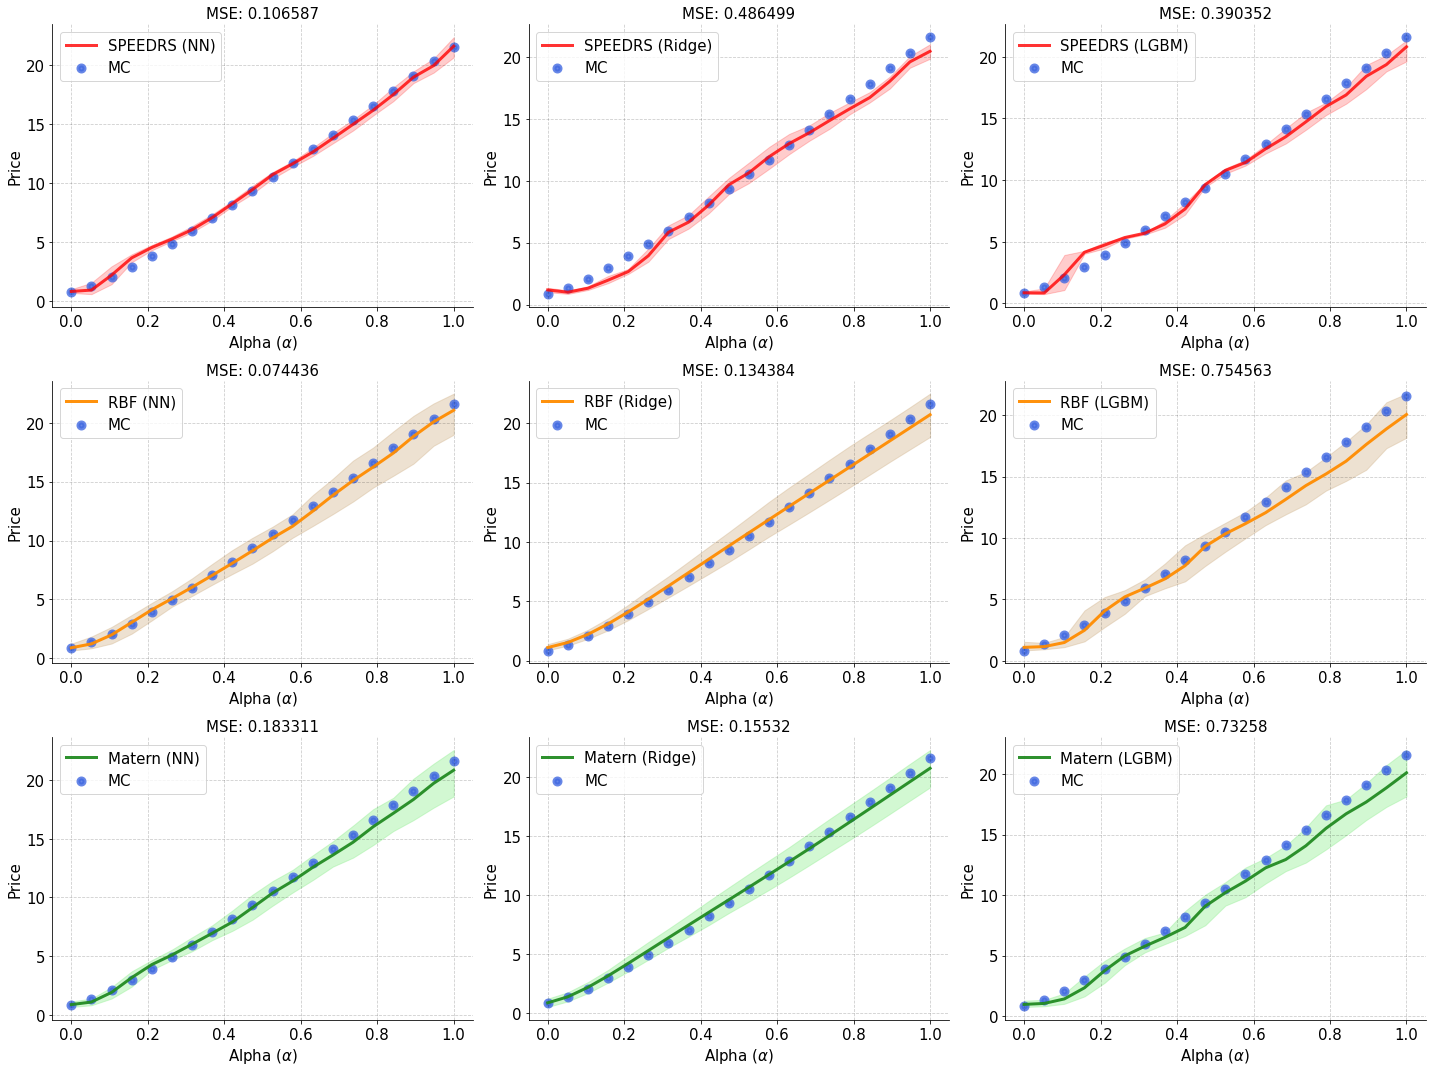

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

x_range = np.linspace(0, 1, 20)
construct_plot(ax[0, 0], targets_mixtures, predictions, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[0, 1], targets_mixtures, predictions_linear, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[0, 2], targets_mixtures, predictions_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')

construct_plot(ax[1, 0], targets_mixtures, predictions_rbf, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[1, 1], targets_mixtures, predictions_rbf_linear, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[1, 2], targets_mixtures, predictions_rbf_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')


construct_plot(ax[2, 0], targets_mixtures, predictions_matern, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[2, 1], targets_mixtures, predictions_matern_linear, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')
construct_plot(ax[2, 2], targets_mixtures, predictions_matern_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Alpha ($\alpha$)', 'Price', 'MC')


plt.tight_layout()
# filename = 'MixtureModels/BarrierOptions/Images/Interpolation/mixture_pricing.svg'
# file_path = Path(f'{filename}')
# file_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Test 2 - Path Length <a class="anchor" id="test-data-drift-test2"></a>

In [53]:
v0_rbergomi = 0.75
H = 0.25
nu = 1.2
corr_rbergomi = -0.85
xi_0 = 0.1


v0_heston = 0.65
corr_heston = -0.94
mean_vol = 0.23
speed = 0.4
vol_of_vol = 0.25


S0 = 90
K = 80
B = 85
r = 0.15
T = 1.0

In [54]:
targets = defaultdict(list)

num_sim = 50000
num_time_steps = 100

C = np.sqrt(2*H)


for q in tqdm(range(100)):

    mc_prices = []

    S1 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0][:, :, 0]
    S2 = np.exp(r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[0])

    for alpha in np.linspace(0, 1, 20):
        
        S = np.add(alpha*S1, (1-alpha)*S2)
        
        price = down_in_barrier_mc_price(S, 0, K, B, T)
        mc_prices.append(price)
        
        targets[alpha].append(price)
        
targets_timesteps = targets       

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [55]:
num_sim = 5000

prediction_speedrs_global = {}
prediction_matern_global = {}
prediction_rbf_global = {}

C = np.sqrt(2*H)

base_processes_list = base_models['base_rbergomi_paths'] + base_models['base_heston_paths'] + base_models['base_gbm_paths']

for i in range(len(base_processes_list)):
    base_processes_list[i] = base_processes_list[i].transpose((1, 0, 2))[:400, ...]

sigma = 1
sig_level = 3


for num_time_steps in tqdm([9, 14, 24, 39, 49, 74, 99]):
    
    predictions_numtimesteps = defaultdict(list)
    predictions_numtimesteps_linear = defaultdict(list)
    predictions_numtimesteps_lgbm = defaultdict(list)

    predictions_rbf_numtimesteps = defaultdict(list)
    predictions_rbf_numtimesteps_linear = defaultdict(list)
    predictions_rbf_numtimesteps_lgbm = defaultdict(list)

    predictions_matern_numtimesteps = defaultdict(list)
    predictions_matern_numtimesteps_linear = defaultdict(list)
    predictions_matern_numtimesteps_lgbm = defaultdict(list)    

    for q in range(100):

        
        for alpha in np.linspace(0, 1, 20):
        
            p1 = heston_sample_paths_inv(S0, v0_heston, r, corr_heston, mean_vol, speed, vol_of_vol, T, num_sim, num_time_steps)[0]
            p2 = r_bergomi_sample_paths_functional_central_limit(S0, v0_rbergomi, H, [xi_0 for _ in range(num_time_steps+1)], C, nu, corr_rbergomi, T, num_time_steps, num_sim)[-1]

            test_features = []
            new_dist = []

            test_features_rbf = []
            test_features_matern = []


            p = np.add(alpha*p1, (1-alpha)*p2)

            p[:, :, 0] /= S0

            exp_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

            p = p.transpose((1, 0, 2))[:400, ...]
            pp, max_items, common_T, dim_path = bags_to_2D([p] + base_processes_list)
            size_item=dim_path * common_T

            for k in range(20):

                new_feature = exp_sig.tolist() + base_process_expected_sigs[k].tolist()

                mmd_approx_model_mixture.model.eval()
                with torch.no_grad():

                    new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())

                test_features_rbf.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
                test_features_matern.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[k+1].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])

            test_features.append(new_dist)

            pricing_model.model.eval()
            rbf_pricing_model.model.eval()
            matern_pricing_model.model.eval()
            with torch.no_grad():
                price = (pricing_model.transform(torch.tensor(test_features)).cpu().item())
                rbf_price = (rbf_pricing_model.transform(torch.tensor(test_features_rbf)[None, :]).cpu().item())
                matern_price = (matern_pricing_model.transform(torch.tensor(test_features_matern)[None, :]).cpu().item())
                
            linear_price = linear_reg_speedrs_model.predict(test_features)[0]
            lgbm_price = lgbm_speedrs_model.predict(test_features)[0]
            
            rbf_linear_price = rbf_baseline_linear_reg.predict([test_features_rbf])[0]
            rbf_lgbm_price = rbf_baseline_lgbm.predict([test_features_rbf])[0]
    
            matern_linear_price = matern_baseline_linear_reg.predict([test_features_matern])[0]
            matern_lgbm_price = matern_baseline_lgbm.predict([test_features_matern])[0]
        
            predictions_numtimesteps[alpha].append(price)
            predictions_numtimesteps_linear[alpha].append(linear_price)
            predictions_numtimesteps_lgbm[alpha].append(lgbm_price)
    
            predictions_rbf_numtimesteps[alpha].append(rbf_price)
            predictions_rbf_numtimesteps_linear[alpha].append(rbf_linear_price)
            predictions_rbf_numtimesteps_lgbm[alpha].append(rbf_lgbm_price)
    
            predictions_matern_numtimesteps[alpha].append(matern_price)
            predictions_matern_numtimesteps_linear[alpha].append(matern_linear_price)
            predictions_matern_numtimesteps_lgbm[alpha].append(matern_lgbm_price)
    
    prediction_speedrs_global[num_time_steps] = (predictions_numtimesteps, predictions_numtimesteps_linear, predictions_numtimesteps_lgbm)
    prediction_rbf_global[num_time_steps] = (predictions_rbf_numtimesteps, predictions_rbf_numtimesteps_linear, predictions_rbf_numtimesteps_lgbm)
    prediction_matern_global[num_time_steps] = (predictions_matern_numtimesteps, predictions_matern_numtimesteps_linear, predictions_matern_numtimesteps_lgbm)

100%|██████████| 7/7 [1:27:39<00:00, 751.42s/it]


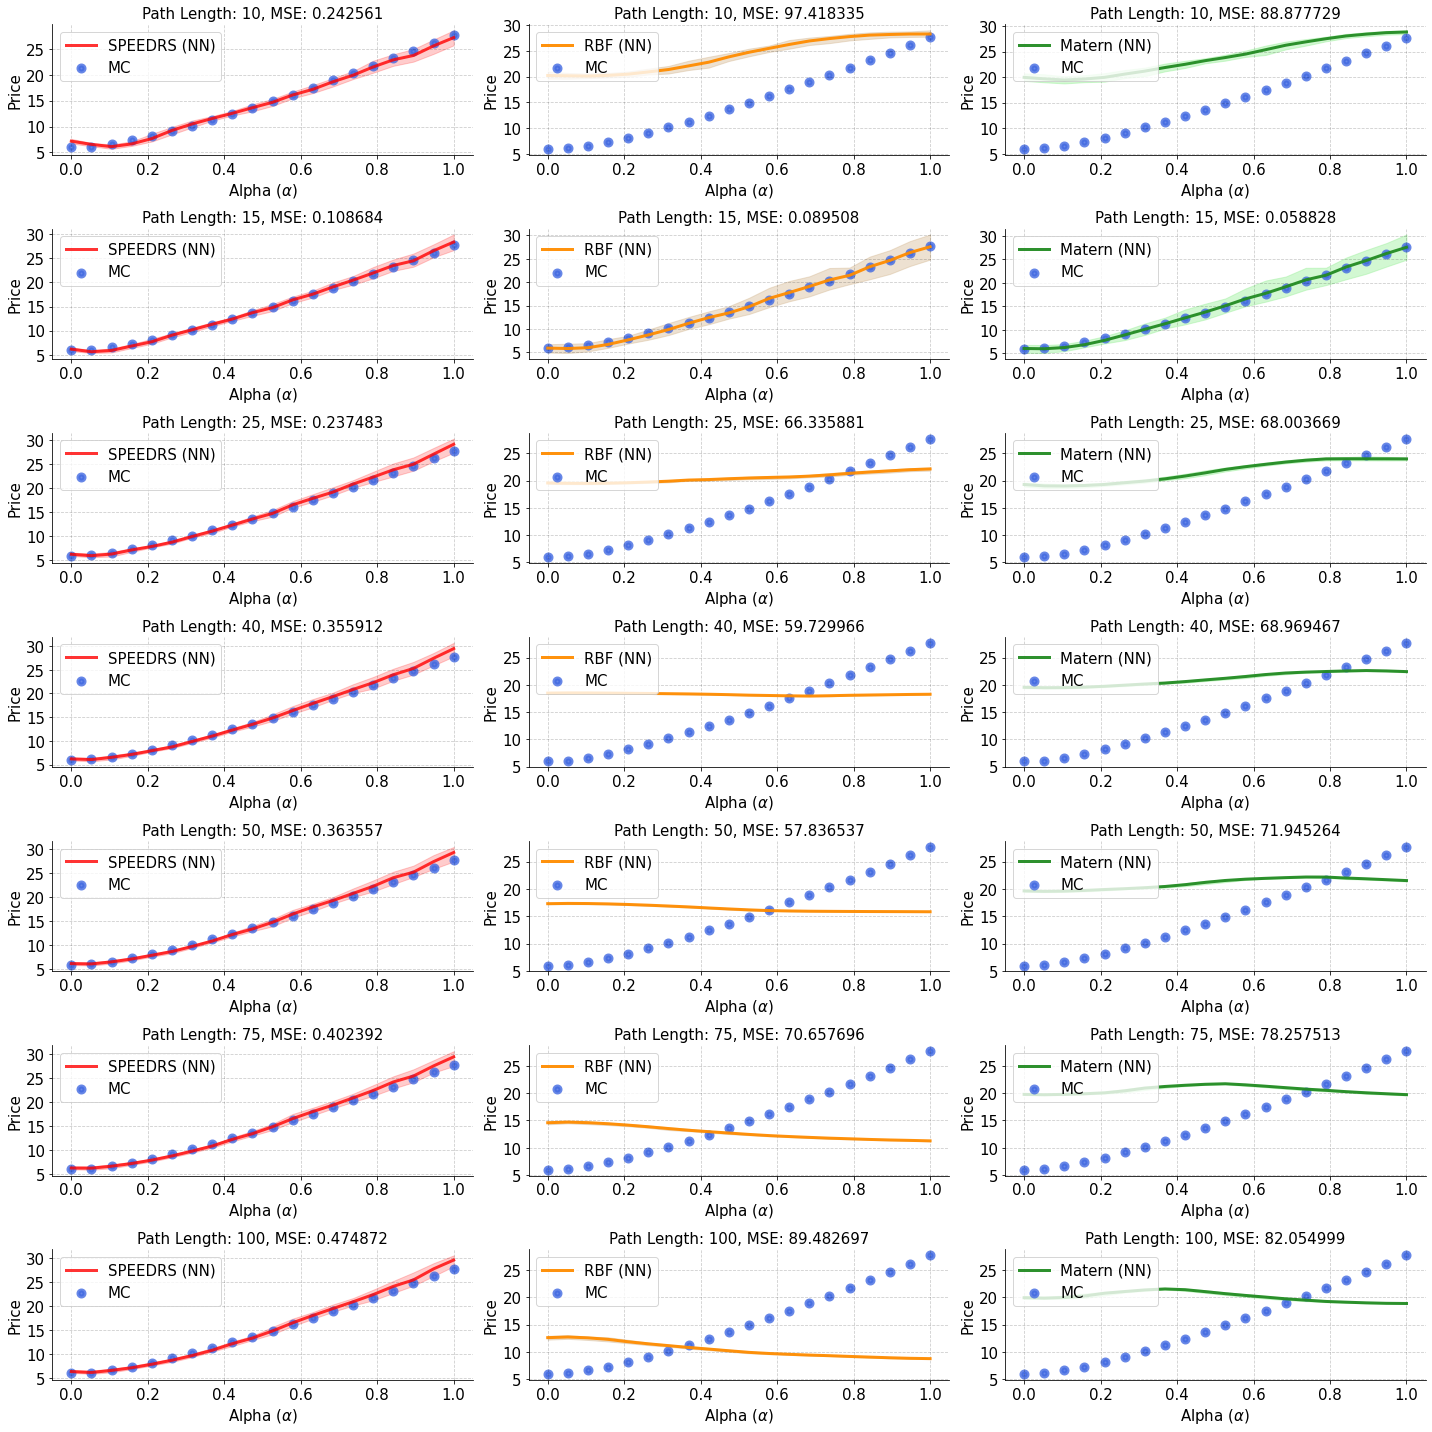

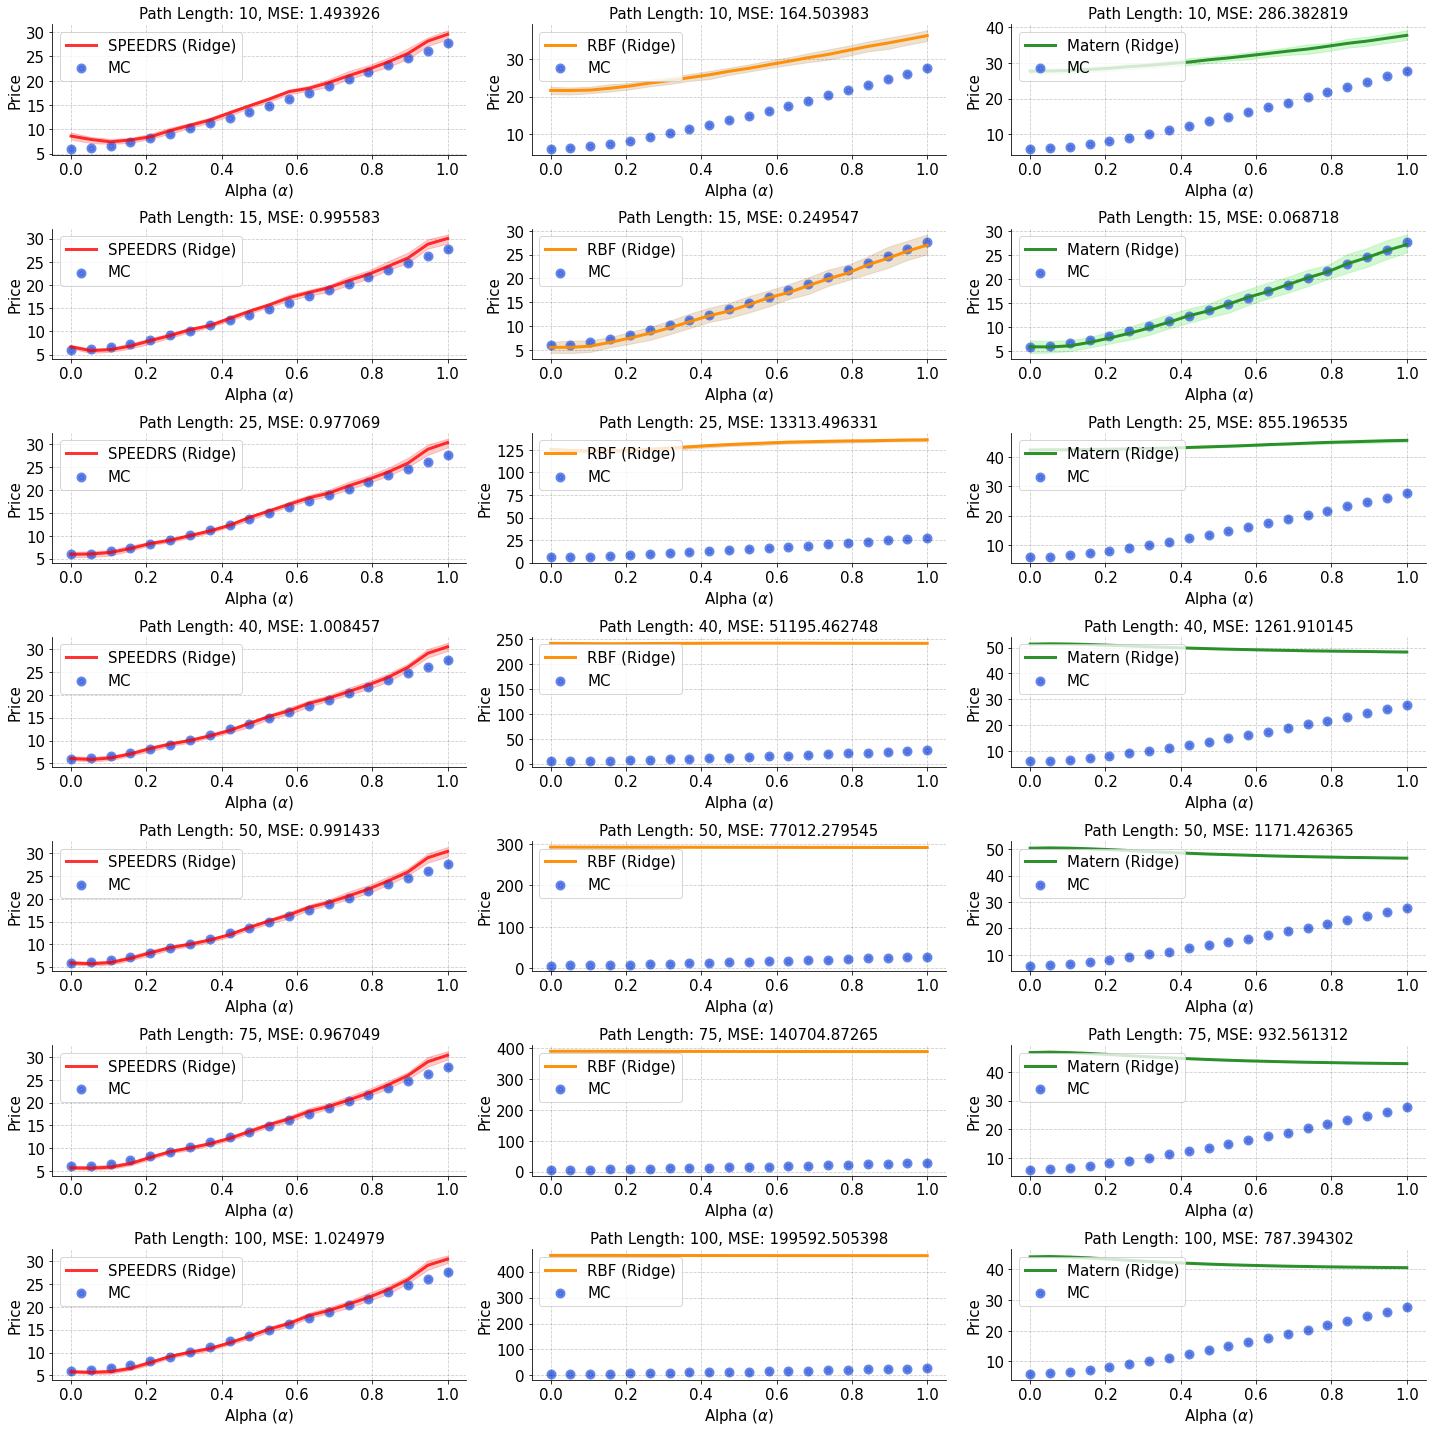

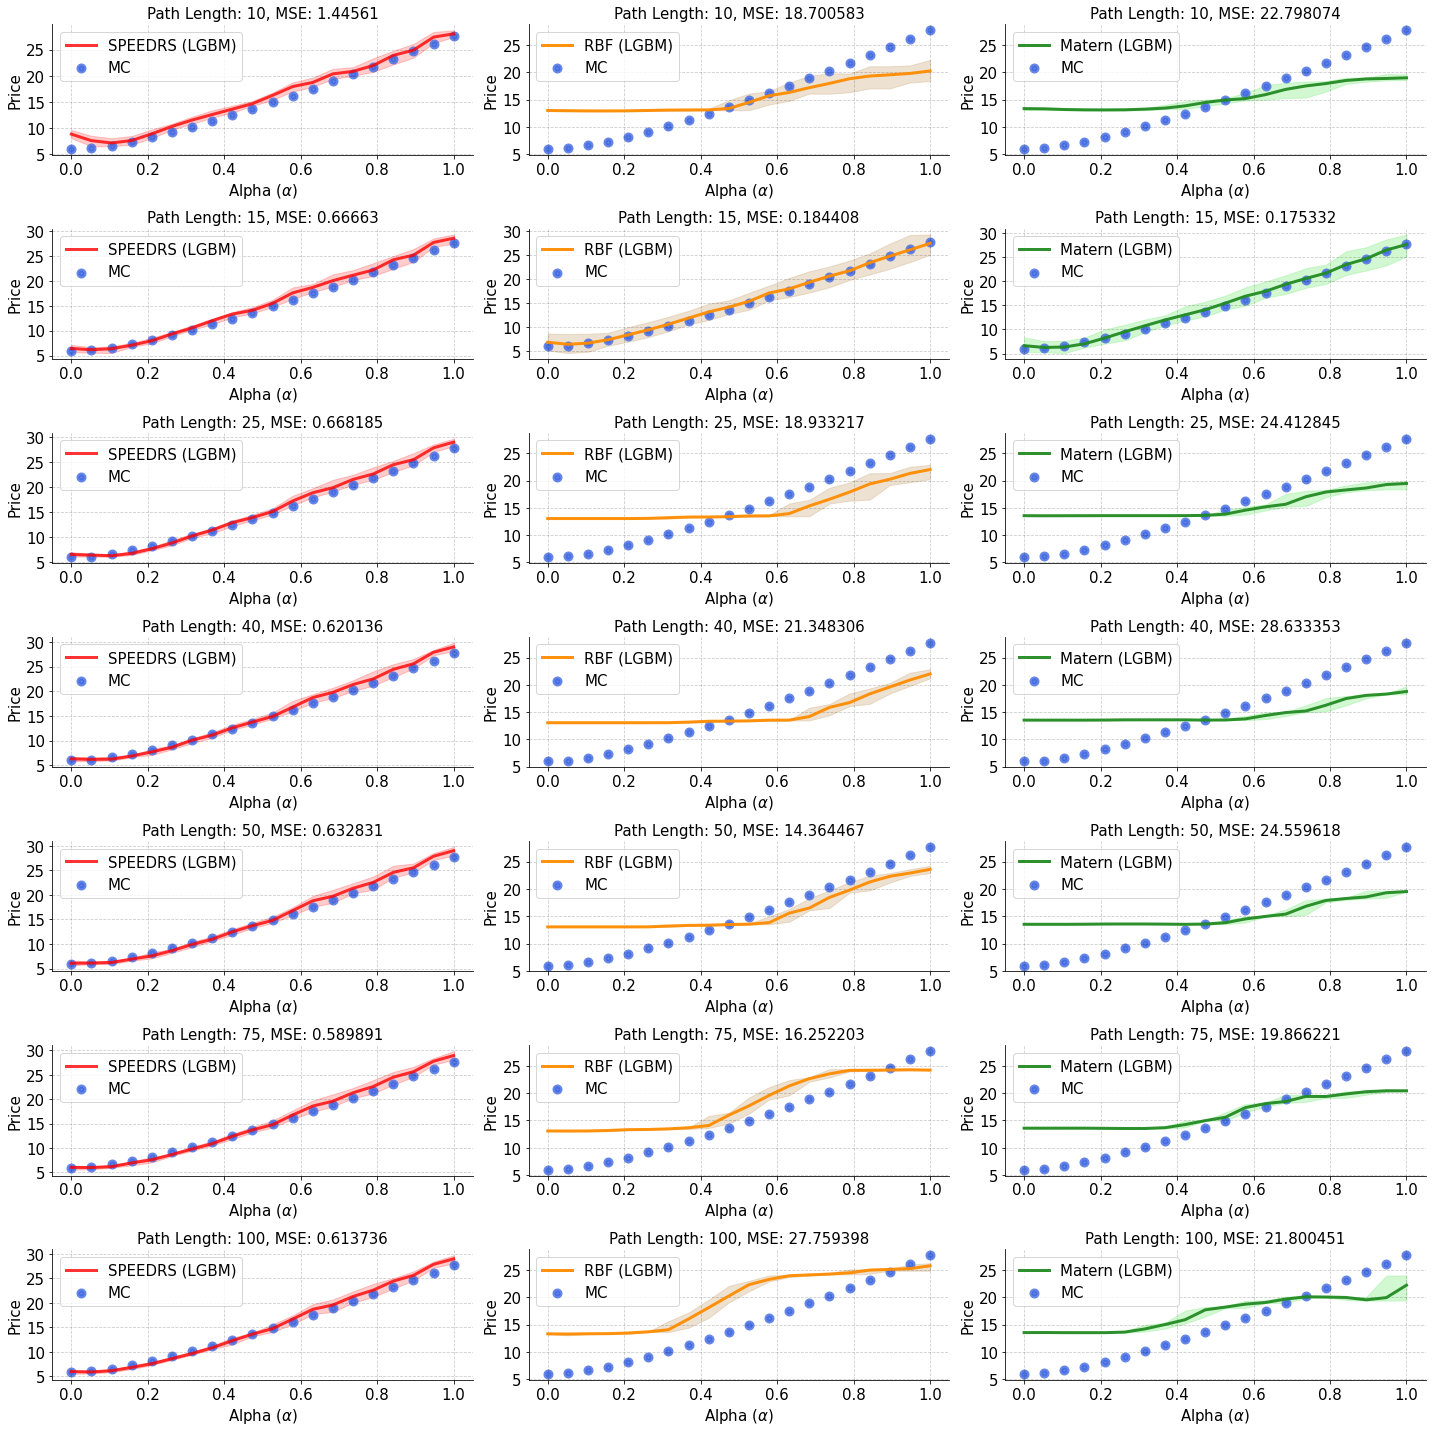

In [15]:
x_range = np.linspace(0, 1, 20)
folder = f'MixtureModels/BarrierOptions/Images/TimeSteps'
model = ['NN', 'Ridge', 'LGBM']
for i in range(3):
    fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 20))
    for j, num_time_steps in enumerate([9, 14, 24, 39, 49, 74, 99]):
        construct_plot(ax[j, 0], targets_timesteps, prediction_speedrs_global[num_time_steps][i], x_range, [0.8, 0.2, 0.8], 
                       ['red', 'red', 'royalblue'], f'SPEEDRS ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)',
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}, MSE')
    
    for j, num_time_steps in enumerate([9, 14, 24, 39, 49, 74, 99]):
        construct_plot(ax[j, 1], targets_timesteps, prediction_rbf_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['darkorange', 'tan', 'royalblue'], f'RBF ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}, MSE')
    
    for j, num_time_steps in enumerate([9, 14, 24, 39, 49, 74, 99]):
        construct_plot(ax[j, 2], targets_timesteps, prediction_matern_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['forestgreen', 'lightgreen', 'royalblue'], f'Matern ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}, MSE')
    plt.tight_layout()
#     filename = f'{folder}/mixture_pricing_numtimesteps_{model[i]}.svg'
#     file_path = Path(f'{filename}')
#     file_path.parent.mkdir(parents=True, exist_ok=True)
#     plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

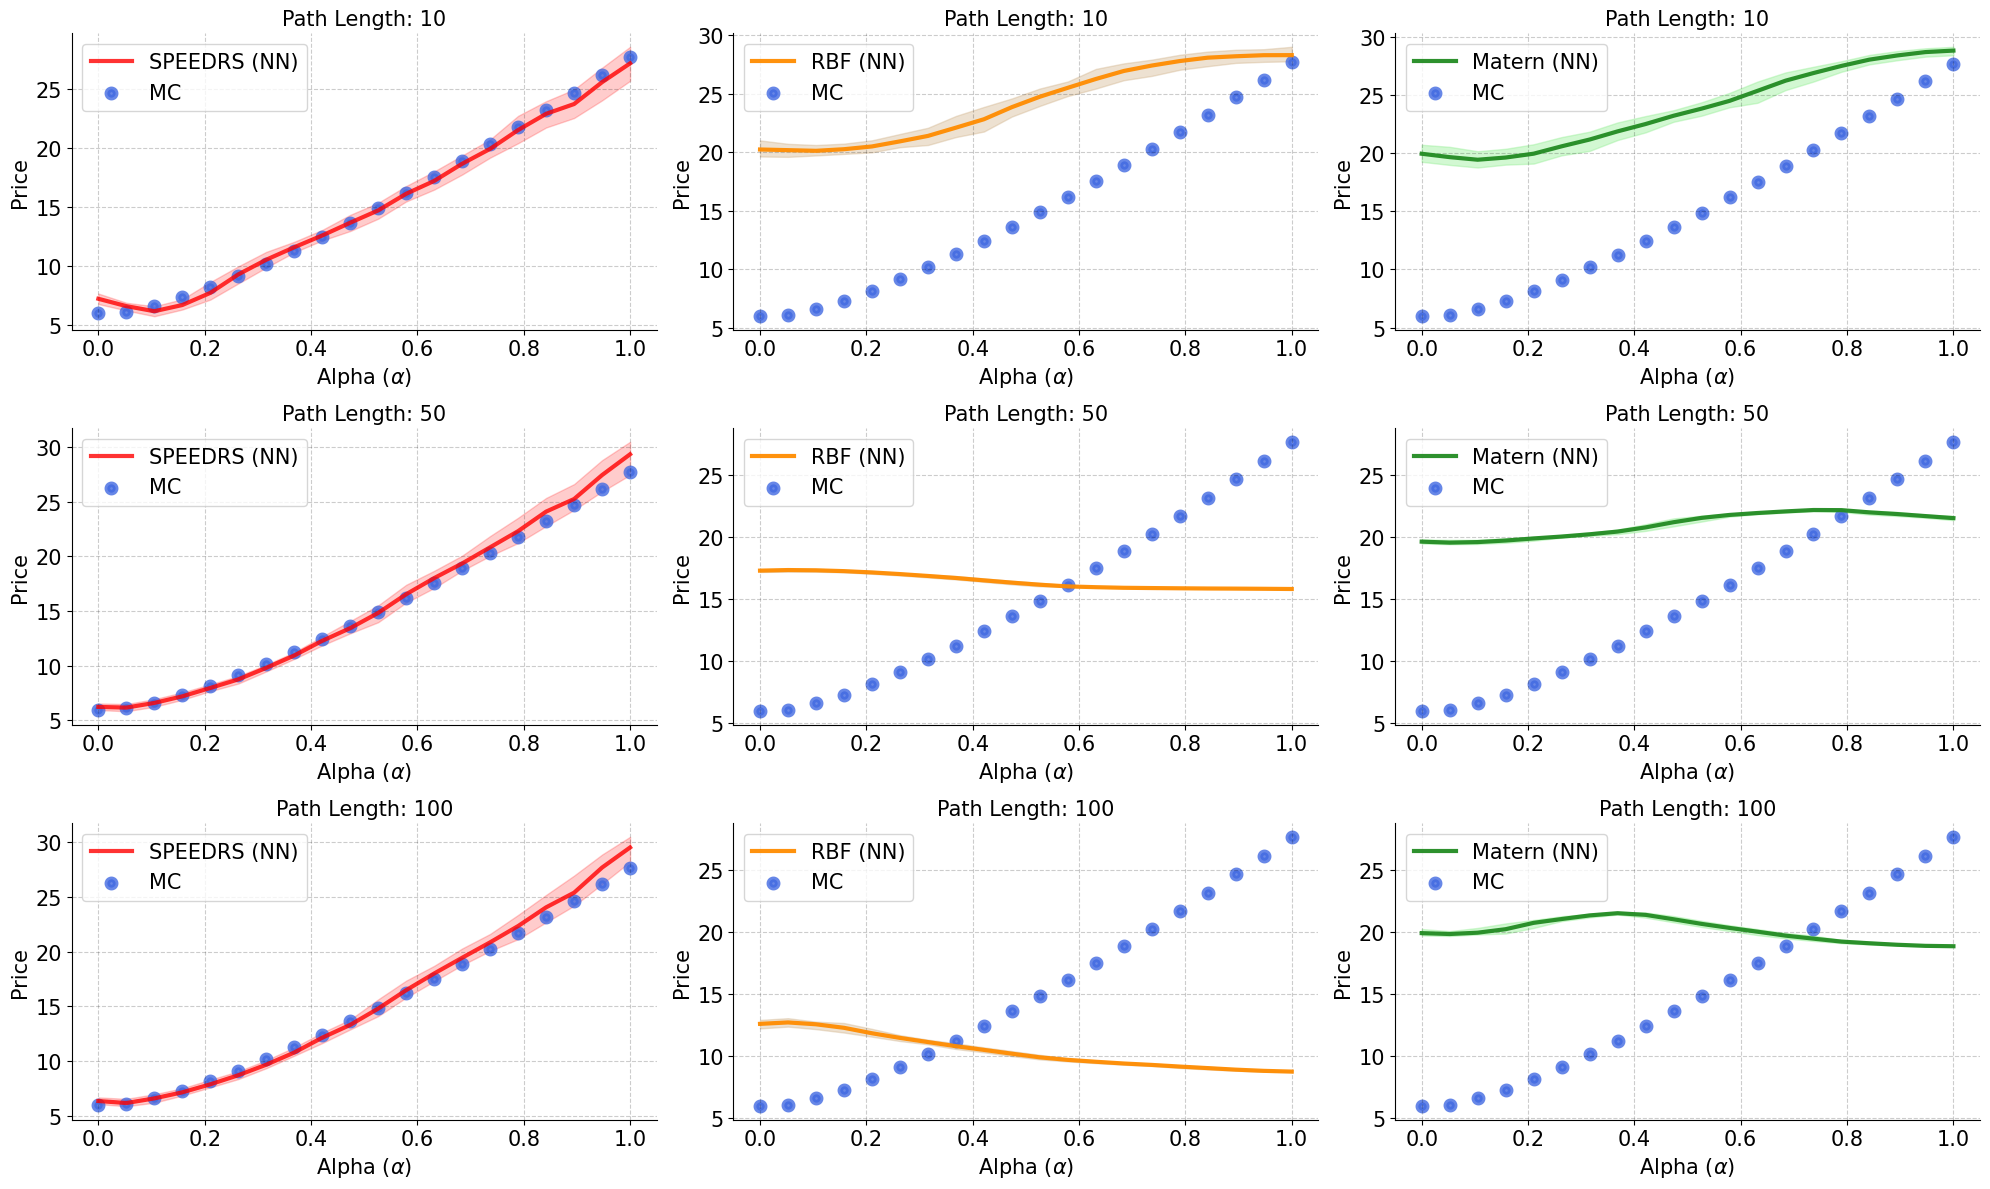

In [129]:
x_range = np.linspace(0, 1, 20)
folder = f'MixtureModels/BarrierOptions/Images/TimeSteps'
model = ['NN']
for i in range(1):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
    for j, num_time_steps in enumerate([9, 49, 99]):
        construct_plot(ax[j, 0], targets_timesteps, prediction_speedrs_global[num_time_steps][i], x_range, [0.8, 0.2, 0.8], 
                       ['red', 'red', 'royalblue'], f'SPEEDRS ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)',
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    
        construct_plot(ax[j, 1], targets_timesteps, prediction_rbf_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['darkorange', 'tan', 'royalblue'], f'RBF ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    
        construct_plot(ax[j, 2], targets_timesteps, prediction_matern_global[num_time_steps][i], x_range, [0.95, 0.4, 0.8], 
                       ['forestgreen', 'lightgreen', 'royalblue'], f'Matern ({model[i]})', [3.0, 4.0], r'Alpha ($\alpha$)', 
                       'Price', 'MC', filename=None, alpha_ci=0.95, title=f'Path Length: {num_time_steps+1}')
    plt.tight_layout()
    filename = f'{folder}/mixture_pricing_numtimesteps_{model[i]}_10_50_100_thesis.svg'
    file_path = Path(f'{filename}')
    file_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

### Test 3 - Unseen Regimes <a class="anchor" id="test-data-drift-test3"></a>

#### GBM <a class="anchor" id="test-data-drift-test3-gbm"></a>

In [157]:
num_sim = 50000
num_time_steps = 100
T = 1

S0 = 90
B = 85
K = 80

r = 0.015

gbm_prices = defaultdict(list)

for sigma_gbm in tqdm(np.linspace(0.2, 0.8, 20)):
    S = GBM_sample_paths(S0, r, sigma_gbm, T, num_sim, num_time_steps)[:, :, 0]
    gbm_prices[sigma_gbm].append(down_in_barrier_mc_price(S, 0, K, B, T))

100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


In [158]:
num_sim = 5000
num_time_steps = 14

predictions_gbm = defaultdict(list)
predictions_gbm_lr = defaultdict(list)
predictions_gbm_lgbm = defaultdict(list)

predictions_gbm_rbf = defaultdict(list)
predictions_gbm_rbf_lr = defaultdict(list)
predictions_gbm_rbf_lgbm = defaultdict(list)

predictions_gbm_matern = defaultdict(list)
predictions_gbm_matern_lr = defaultdict(list)
predictions_gbm_matern_lgbm = defaultdict(list)


predictions_gbm_subsample = defaultdict(list)
predictions_gbm_subsample_lr = defaultdict(list)
predictions_gbm_subsample_lgbm = defaultdict(list)

predictions_gbm_rbf_subsample = defaultdict(list)
predictions_gbm_rbf_subsample_lr = defaultdict(list)
predictions_gbm_rbf_subsample_lgbm = defaultdict(list)

predictions_gbm_matern_subsample = defaultdict(list)
predictions_gbm_matern_subsample_lr = defaultdict(list)
predictions_gbm_matern_subsample_lgbm = defaultdict(list)


sigma = 1
sig_level = 3


for q in tqdm(range(100)):

    
    for sigma_gbm in np.linspace(0.2, 0.8, 20):
        
        p = GBM_sample_paths(S0, r, sigma_gbm, T, num_sim, num_time_steps)
        p[:, :, 0] /= S0
        
        p_baseline = GBM_sample_paths(S0, r, sigma_gbm, T, num_sim, num_time_steps)
        p_baseline[:, :, 0] /= S0
        
        num_time_steps_subsample = np.random.randint(low=21, high=40)
        num_used_steps_subsample = 14

        p_subsample = GBM_sample_paths(S0, r, sigma_gbm, T, num_sim, num_time_steps_subsample)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample)], num_used_steps_subsample)
        p_subsample = p_subsample[list(set(np.sort(random_indices))), :, :]
        p_subsample[:, :, 0] /= S0
        
        num_time_steps_subsample_baseline = np.random.randint(low=21, high=40)
        
        p_baseline_subsample = GBM_sample_paths(S0, r, sigma_gbm, T, num_sim, num_time_steps_subsample_baseline)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample_baseline)], num_used_steps_subsample)
        p_baseline_subsample = p_baseline_subsample[list(set(np.sort(random_indices))), :, :]
        p_baseline_subsample[:, :, 0] /= S0
    

        new_dist = []
        new_dist1 = []
        new_dist2 = []
        
        new_dist_subsample = []
        new_dist1_subsample = []
        new_dist2_subsample = []


        exp_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)
        exp_sig_subsample = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p_subsample, (1, 0, 2)), 2), sigma)), sig_level), axis=0)

        
        for k in range(20):

            new_feature = exp_sig.tolist() + base_process_expected_sigs[k].tolist()
            new_feature_subsample = exp_sig_subsample.tolist() + base_process_expected_sigs[k].tolist()

            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():
                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())
                new_dist_subsample.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_subsample)).unsqueeze(0).float()).cpu().item())
                
        p_baseline = p_baseline.transpose((1, 0, 2))[:400]
        pp, max_items, common_T, dim_path = bags_to_2D([p_baseline] + base_processes_list)
        size_item = dim_path * common_T
        
        p_baseline_subsample = p_baseline_subsample.transpose((1, 0, 2))[:400]
        pp_subsample, max_items_subsample, common_T_subsample, dim_path_subsample = bags_to_2D([p_baseline_subsample] + base_processes_list)
        size_item_subsapmle = dim_path_subsample * common_T_subsample
            
        
    
        for i in range(1, 21):
            new_dist1.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            new_dist2.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            
            new_dist1_subsample.append(rbf_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])
            new_dist2_subsample.append(rbf_matern_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])

        
        pricing_model.model.eval()
        rbf_pricing_model.model.eval()
        matern_pricing_model.model.eval()
        with torch.no_grad():
            predictions_gbm[sigma_gbm].append(pricing_model.transform(torch.tensor([new_dist])).cpu().item())
            predictions_gbm_lr[sigma_gbm].append(linear_reg_speedrs_model.predict([new_dist])[0])
            predictions_gbm_lgbm[sigma_gbm].append(lgbm_speedrs_model.predict([new_dist])[0])
            
            predictions_gbm_rbf[sigma_gbm].append((rbf_pricing_model.transform(torch.tensor([new_dist1])).cpu().item()))
            predictions_gbm_rbf_lr[sigma_gbm].append(rbf_baseline_linear_reg.predict([new_dist1])[0])
            predictions_gbm_rbf_lgbm[sigma_gbm].append(rbf_baseline_lgbm.predict([new_dist1])[0])

            predictions_gbm_matern[sigma_gbm].append((matern_pricing_model.transform(torch.tensor([new_dist2])).cpu().item()))
            predictions_gbm_matern_lr[sigma_gbm].append(matern_baseline_lgbm.predict([new_dist2])[0])
            predictions_gbm_matern_lgbm[sigma_gbm].append(matern_baseline_linear_reg.predict([new_dist2])[0])
            
            predictions_gbm_subsample[sigma_gbm].append(pricing_model.transform(torch.tensor([new_dist_subsample])).cpu().item())
            predictions_gbm_subsample_lr[sigma_gbm].append(linear_reg_speedrs_model.predict([new_dist_subsample])[0])
            predictions_gbm_subsample_lgbm[sigma_gbm].append(lgbm_speedrs_model.predict([new_dist_subsample])[0])
            
            predictions_gbm_rbf_subsample[sigma_gbm].append((rbf_pricing_model.transform(torch.tensor([new_dist1_subsample])).cpu().item()))
            predictions_gbm_rbf_subsample_lr[sigma_gbm].append(rbf_baseline_linear_reg.predict([new_dist1_subsample])[0])
            predictions_gbm_rbf_subsample_lgbm[sigma_gbm].append(rbf_baseline_lgbm.predict([new_dist1_subsample])[0])
            
            predictions_gbm_matern_subsample[sigma_gbm].append((matern_pricing_model.transform(torch.tensor([new_dist2_subsample])).cpu().item()))
            predictions_gbm_matern_subsample_lr[sigma_gbm].append(matern_baseline_linear_reg.predict([new_dist2_subsample])[0])
            predictions_gbm_matern_subsample_lgbm[sigma_gbm].append(matern_baseline_lgbm.predict([new_dist2_subsample])[0])

100%|██████████| 100/100 [17:14<00:00, 10.35s/it]


#### No Subsampling

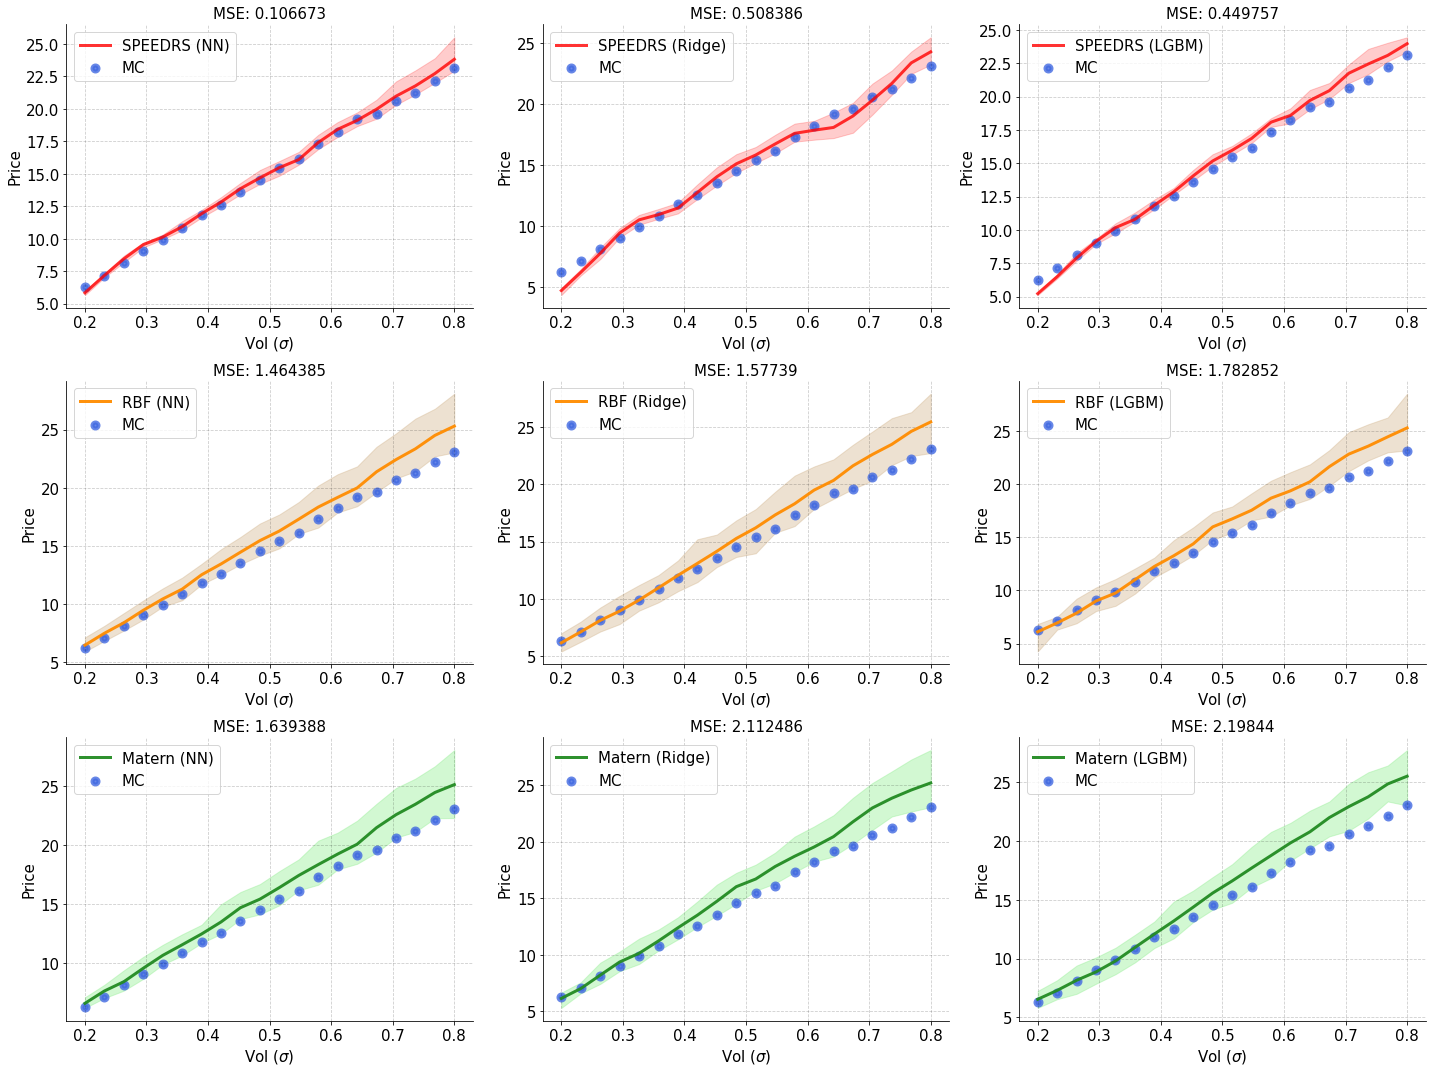

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

x_range = np.linspace(0.2, 0.8, 20)
construct_plot(ax[0, 0], gbm_prices, predictions_gbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[0, 1], gbm_prices, predictions_gbm_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[0, 2], gbm_prices, predictions_gbm_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')

construct_plot(ax[1, 0], gbm_prices, predictions_gbm_rbf, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[1, 1], gbm_prices, predictions_gbm_rbf_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[1, 2], gbm_prices, predictions_gbm_rbf_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')


construct_plot(ax[2, 0], gbm_prices, predictions_gbm_matern, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[2, 1], gbm_prices, predictions_gbm_matern_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')
construct_plot(ax[2, 2], gbm_prices, predictions_gbm_matern_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC')


plt.tight_layout()
# folder = f'MixtureModels/BarrierOptions/Images/GBM/No_Subsample'
# filename = 'gbm_pricing.svg'
# file_path = Path(f'{folder}/{filename}')
# file_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{folder}/{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Subsampling

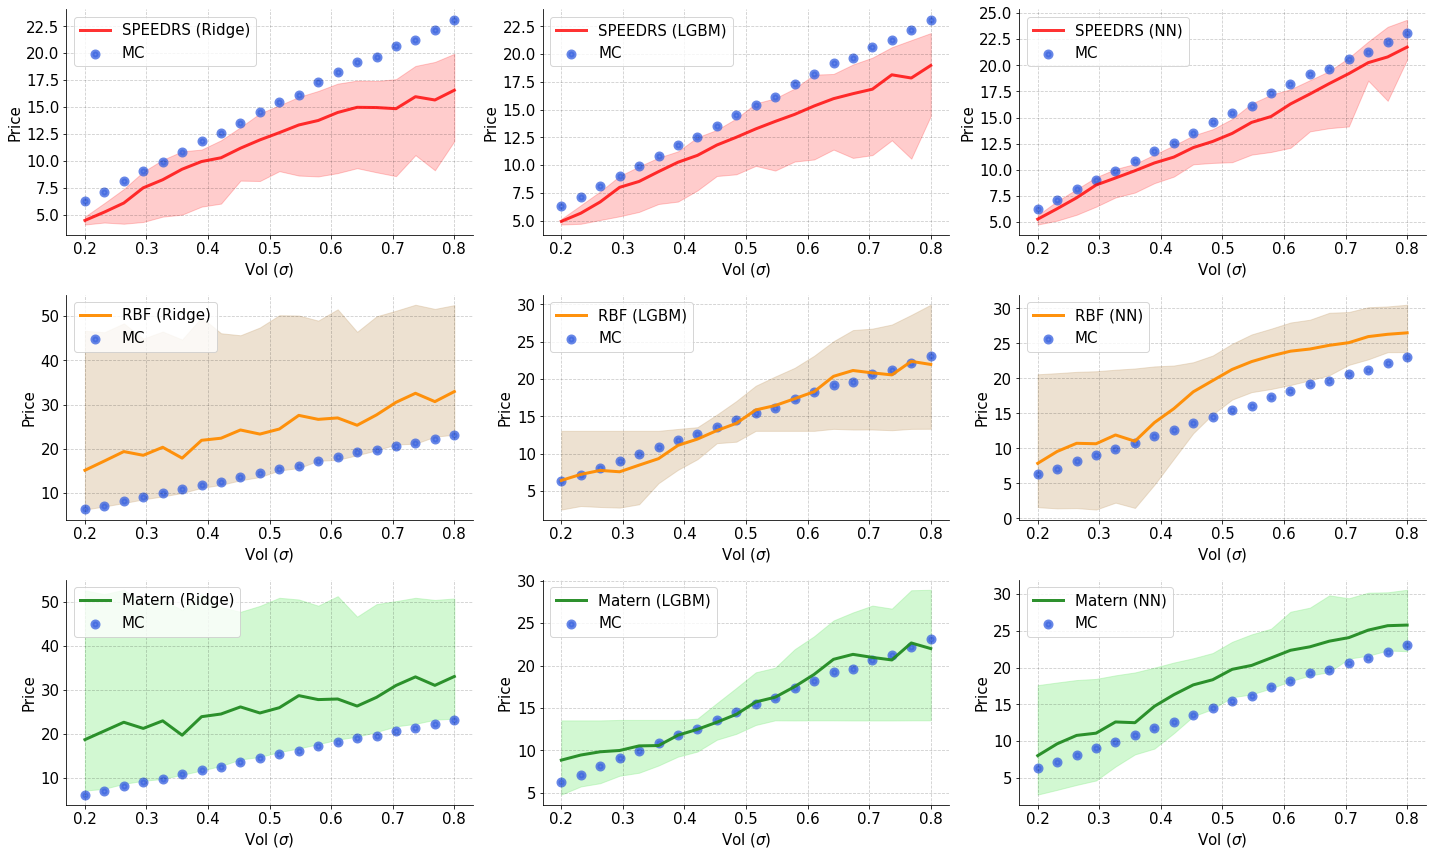

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

x_range = np.linspace(0.2, 0.8, 20)
construct_plot(ax[0, 2], gbm_prices, predictions_gbm_subsample, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[0, 0], gbm_prices, predictions_gbm_subsample_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[0, 1], gbm_prices, predictions_gbm_subsample_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')

construct_plot(ax[1, 2], gbm_prices, predictions_gbm_rbf_subsample, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[1, 0], gbm_prices, predictions_gbm_rbf_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[1, 1], gbm_prices, predictions_gbm_rbf_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')


construct_plot(ax[2, 2], gbm_prices, predictions_gbm_matern_subsample, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[2, 0], gbm_prices, predictions_gbm_matern_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')
construct_plot(ax[2, 1], gbm_prices, predictions_gbm_matern_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Vol ($\sigma$)', 'Price', 'MC', title='')


plt.tight_layout()
folder = f'MixtureModels/BarrierOptions/Images/Thesis/GBM/Subsample'
filename = 'gbm_pricing_subsample_thesis.svg'
file_path = Path(f'{folder}/{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{folder}/{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### CEV <a class="anchor" id="test-data-drift-test3-cev"></a>

In [173]:
sigma_cev = 0.45
num_sim = 50000
num_time_steps = 100
T = 1
S0 = 90
K = 80
B = 85
r = 0.015

gamma_range = np.linspace(0.3, 1.05, 15)

cev_prices = defaultdict(list)

for gamma in tqdm(gamma_range):
    S = CEV_sample_paths(S0, r, np.exp(-sigma_cev*gamma), gamma, T, num_sim, num_time_steps)[:, :, 0]
    cev_prices[gamma].append(down_in_barrier_mc_price(S, 0, K, B, T))

100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


In [174]:
num_sim = 5000
num_time_steps = 14

predictions_cev = defaultdict(list)
predictions_cev_lr = defaultdict(list)
predictions_cev_lgbm = defaultdict(list)


predictions_cev_rbf = defaultdict(list)
predictions_cev_rbf_lr = defaultdict(list)
predictions_cev_rbf_lgbm = defaultdict(list)

predictions_cev_matern = defaultdict(list)
predictions_cev_matern_lr = defaultdict(list)
predictions_cev_matern_lgbm = defaultdict(list)


predictions_cev_subsample = defaultdict(list)
predictions_cev_subsample_lr = defaultdict(list)
predictions_cev_subsample_lgbm = defaultdict(list)

predictions_cev_rbf_subsample = defaultdict(list)
predictions_cev_rbf_subsample_lr = defaultdict(list)
predictions_cev_rbf_subsample_lgbm = defaultdict(list)

predictions_cev_matern_subsample = defaultdict(list)
predictions_cev_matern_subsample_lr = defaultdict(list)
predictions_cev_matern_subsample_lgbm = defaultdict(list)

sigma = 1
sig_level = 3


for q in tqdm(range(100)):

    
    for gamma in gamma_range:
        
        p = CEV_sample_paths(S0, r, np.exp(-sigma_cev*gamma), gamma, T, num_sim, num_time_steps)
        p[:, :, 0] /= S0
        
        p_baseline = CEV_sample_paths(S0, r, np.exp(-sigma_cev*gamma), gamma, T, num_sim, num_time_steps)
        p_baseline[:, :, 0] /= S0
        
        num_time_steps_subsample = np.random.randint(low=21, high=40)
        num_used_steps_subsample = num_time_steps

        p_subsample = CEV_sample_paths(S0, r, np.exp(-sigma_cev*gamma), gamma, T, num_sim, num_time_steps_subsample)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample)], num_used_steps_subsample)
        p_subsample = p_subsample[list(set(np.sort(random_indices))), :, :]
        p_subsample[:, :, 0] /= S0
        
        num_time_steps_subsample_baseline = np.random.randint(low=21, high=40)
        
        p_baseline_subsample = CEV_sample_paths(S0, r, np.exp(-sigma_cev*gamma), gamma, T, num_sim, num_time_steps_subsample_baseline)
        random_indices = [0] + random.sample([i for i in range(1, num_time_steps_subsample_baseline)], num_used_steps_subsample)
        p_baseline_subsample = p_baseline_subsample[list(set(np.sort(random_indices))), :, :]
        p_baseline_subsample[:, :, 0] /= S0
    

        new_dist = []
        new_dist1 = []
        new_dist2 = []
        
        new_dist_subsample = []
        new_dist1_subsample = []
        new_dist2_subsample = []


        exp_sig = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p, (1, 0, 2)), 2), sigma)), sig_level), axis=0)
        exp_sig_subsample = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(p_subsample, (1, 0, 2)), 2), sigma)), sig_level), axis=0)


        for k in range(N):
            
            new_feature = exp_sig.tolist() + base_process_expected_sigs[k].tolist()
            new_feature_subsample = exp_sig_subsample.tolist() + base_process_expected_sigs[k].tolist()

            mmd_approx_model_mixture.model.eval()
            with torch.no_grad():
                new_dist.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature)).unsqueeze(0).float()).cpu().item())
                new_dist_subsample.append(mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_subsample)).unsqueeze(0).float()).cpu().item())
                

        p_baseline = p_baseline.transpose((1, 0, 2))[:400, ...]
        pp, max_items, common_T, dim_path = bags_to_2D([p_baseline] + base_processes_list)
        size_item = dim_path * common_T
        
        p_baseline_subsample = p_baseline_subsample.transpose((1, 0, 2))[:400, ...]
        pp_subsample, max_items_subsample, common_T_subsample, dim_path_subsample = bags_to_2D([p_baseline_subsample] + base_processes_list)
        size_item_subsapmle = dim_path_subsample * common_T_subsample
            
        
    
        for i in range(1, 21):
            new_dist1.append(rbf_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            new_dist2.append(rbf_matern_mmd_mat(pp[0].reshape(-1, size_item), pp[i].reshape(-1, size_item), max_items=max_items, gamma=sigma)[0][0])
            
            new_dist1_subsample.append(rbf_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])
            new_dist2_subsample.append(rbf_matern_mmd_mat(pp_subsample[0].reshape(-1, size_item_subsapmle), pp_subsample[i].reshape(-1, size_item_subsapmle), max_items=max_items_subsample, gamma=sigma)[0][0])


        pricing_model.model.eval()
        rbf_pricing_model.model.eval()
        matern_pricing_model.model.eval()
        with torch.no_grad():
            predictions_cev[gamma].append(pricing_model.transform(torch.tensor([new_dist])).cpu().item())
            try:
                predictions_cev_lr[gamma].append(linear_reg_speedrs_model.predict([new_dist])[0])
            except:
                pass
            try:
                predictions_cev_lgbm[gamma].append(lgbm_speedrs_model.predict([new_dist])[0])
            except:
                pass
            
            predictions_cev_rbf[gamma].append((rbf_pricing_model.transform(torch.tensor([new_dist1])).cpu().item()))
            try:
                predictions_cev_rbf_lr[gamma].append(rbf_baseline_linear_reg.predict([new_dist1])[0])
            except:
                pass
            try:
                predictions_cev_rbf_lgbm[gamma].append(rbf_baseline_lgbm.predict([new_dist1])[0])
            except:
                pass

            predictions_cev_matern[gamma].append((matern_pricing_model.transform(torch.tensor([new_dist2])).cpu().item()))
            try:
                predictions_cev_matern_lr[gamma].append(matern_baseline_linear_reg.predict([new_dist2])[0])
            except:
                pass
            try:
                predictions_cev_matern_lgbm[gamma].append(matern_baseline_lgbm.predict([new_dist2])[0])
            except:
                pass
            
            predictions_cev_subsample[gamma].append(pricing_model.transform(torch.tensor([new_dist_subsample])).cpu().item())
            try:
                predictions_cev_subsample_lr[gamma].append(linear_reg_speedrs_model.predict([new_dist_subsample])[0])
            except:
                pass
            try:
                predictions_cev_subsample_lgbm[gamma].append(lgbm_speedrs_model.predict([new_dist_subsample])[0])
            except:
                pass
            
            predictions_cev_rbf_subsample[gamma].append((rbf_pricing_model.transform(torch.tensor([new_dist1_subsample])).cpu().item()))
            try:
                predictions_cev_rbf_subsample_lr[gamma].append(rbf_baseline_linear_reg.predict([new_dist1_subsample])[0])
            except:
                pass
            try:
                predictions_cev_rbf_subsample_lgbm[gamma].append(rbf_baseline_lgbm.predict([new_dist1_subsample])[0])
            except:
                pass
            
            predictions_cev_matern_subsample[gamma].append((matern_pricing_model.transform(torch.tensor([new_dist2_subsample])).cpu().item()))
            try:
                predictions_cev_matern_subsample_lr[gamma].append(matern_baseline_linear_reg.predict([new_dist2_subsample])[0])
            except:
                pass
            try:
                predictions_cev_matern_subsample_lgbm[gamma].append(matern_baseline_lgbm.predict([new_dist2_subsample])[0])
            except:
                pass

100%|██████████| 100/100 [12:55<00:00,  7.75s/it]


#### No Subsampling

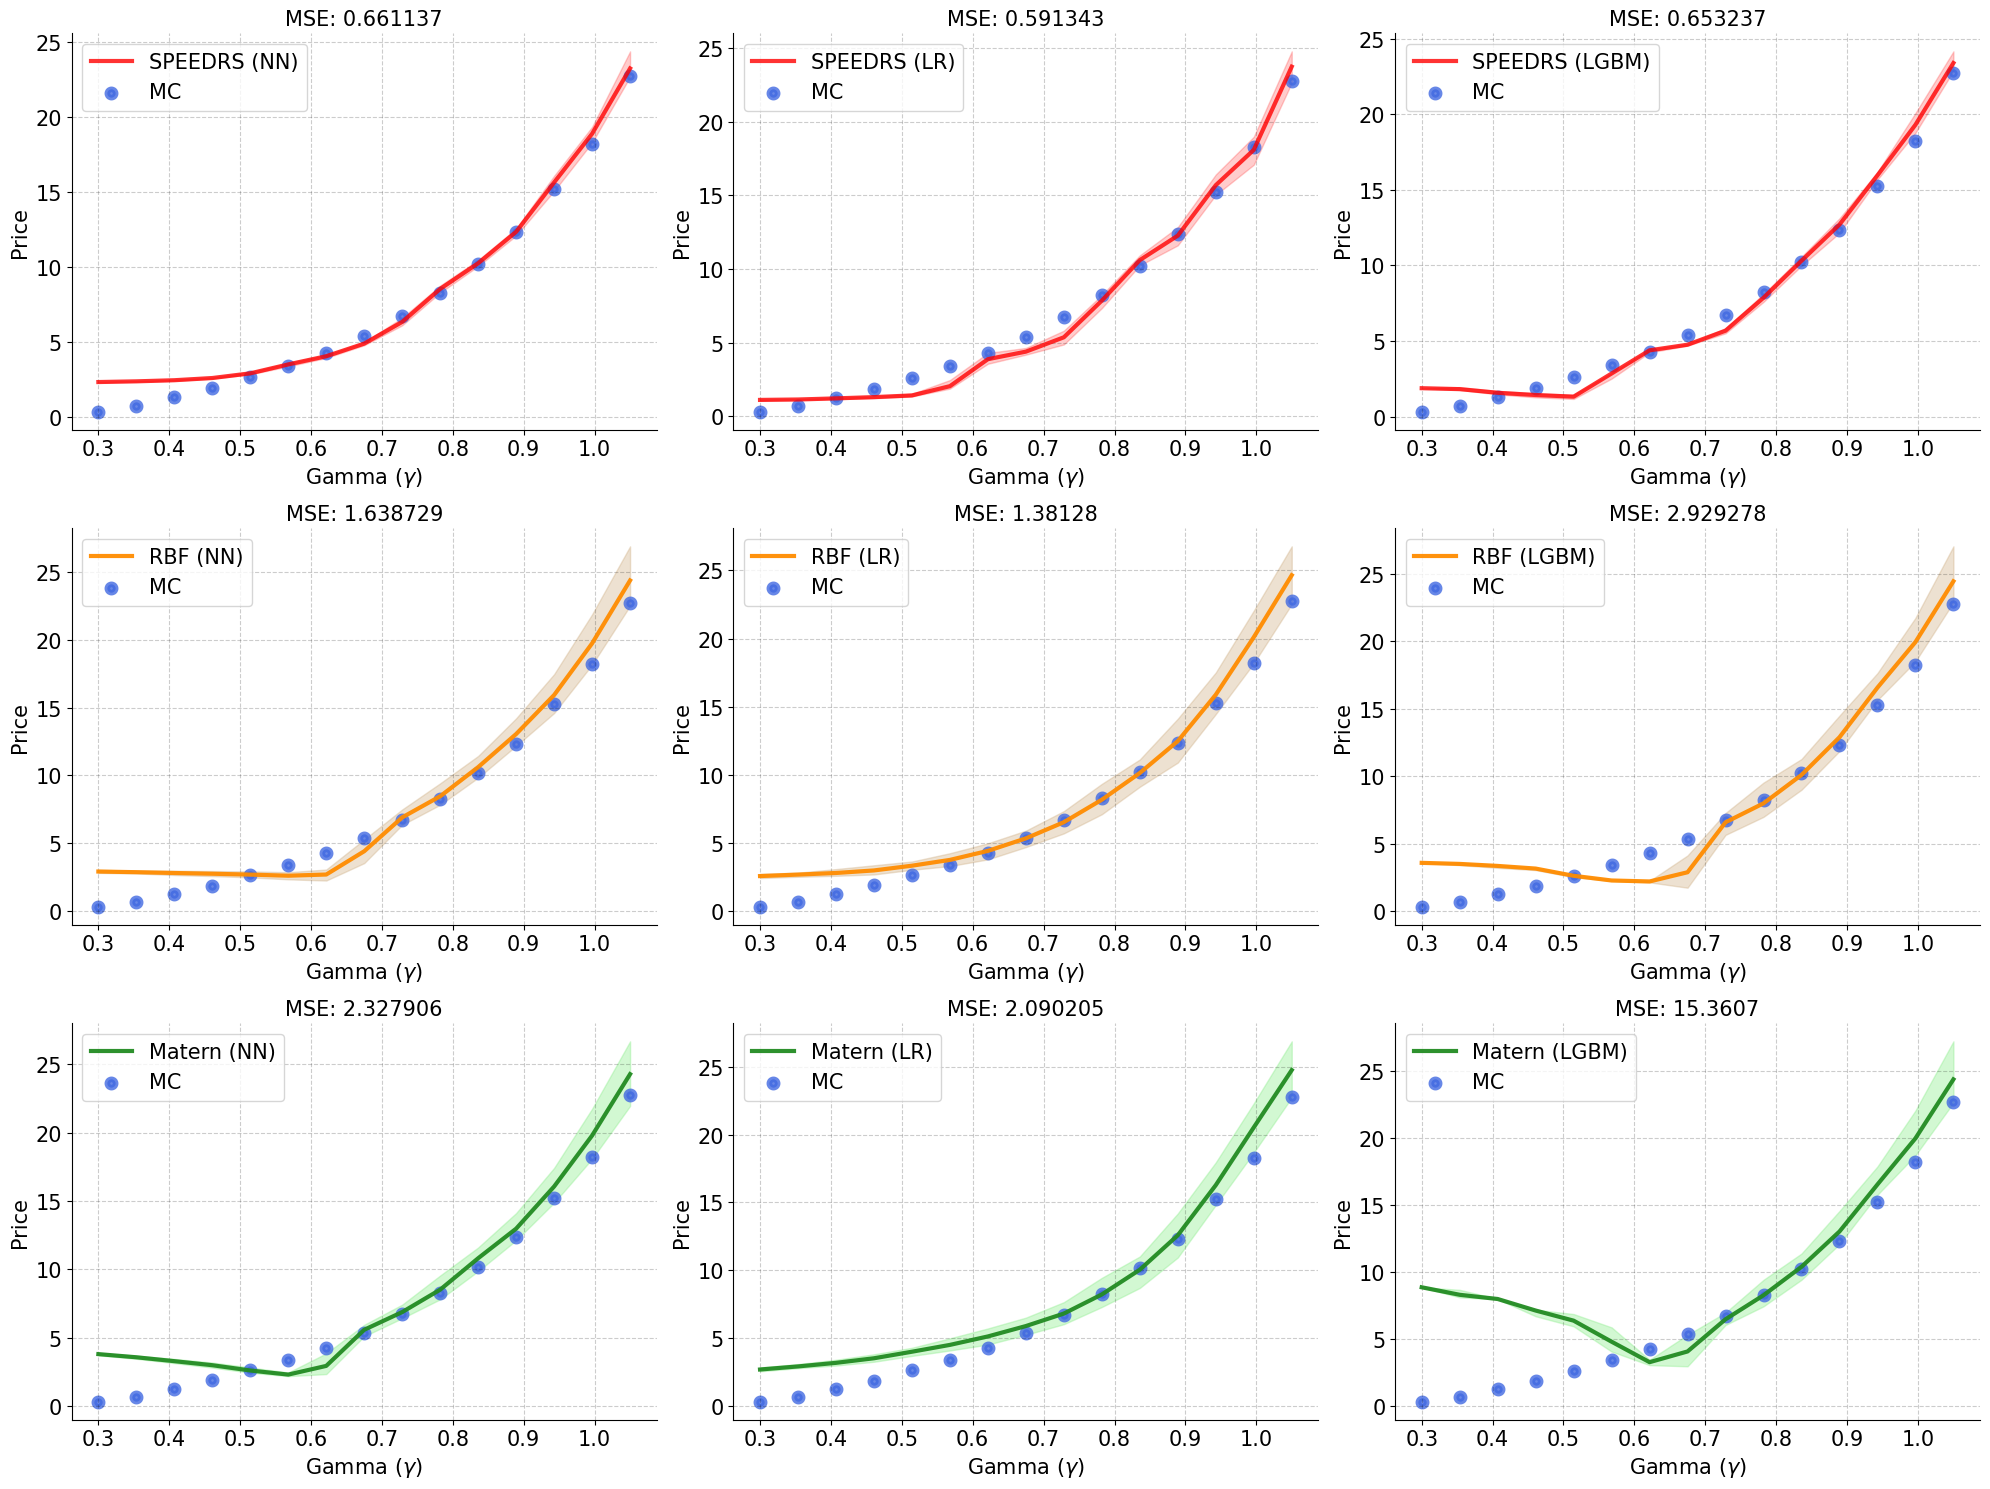

In [176]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

x_range = gamma_range
construct_plot(ax[0, 0], cev_prices, predictions_cev, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[0, 1], cev_prices, predictions_cev_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (LR)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[0, 2], cev_prices, predictions_cev_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')

construct_plot(ax[1, 0], cev_prices, predictions_cev_rbf, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[1, 1], cev_prices, predictions_cev_rbf_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LR)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[1, 2], cev_prices, predictions_cev_rbf_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')


construct_plot(ax[2, 0], cev_prices, predictions_cev_matern, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[2, 1], cev_prices, predictions_cev_matern_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LR)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')
construct_plot(ax[2, 2], cev_prices, predictions_cev_matern_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC')


plt.tight_layout()
# folder = f'MixtureModels/BarrierOptions/Images/CEV/No_Subsample'
# filename = 'cev_pricing.svg'
# file_path = Path(f'{folder}/{filename}')
# file_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(f'{folder}/{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Subsampling

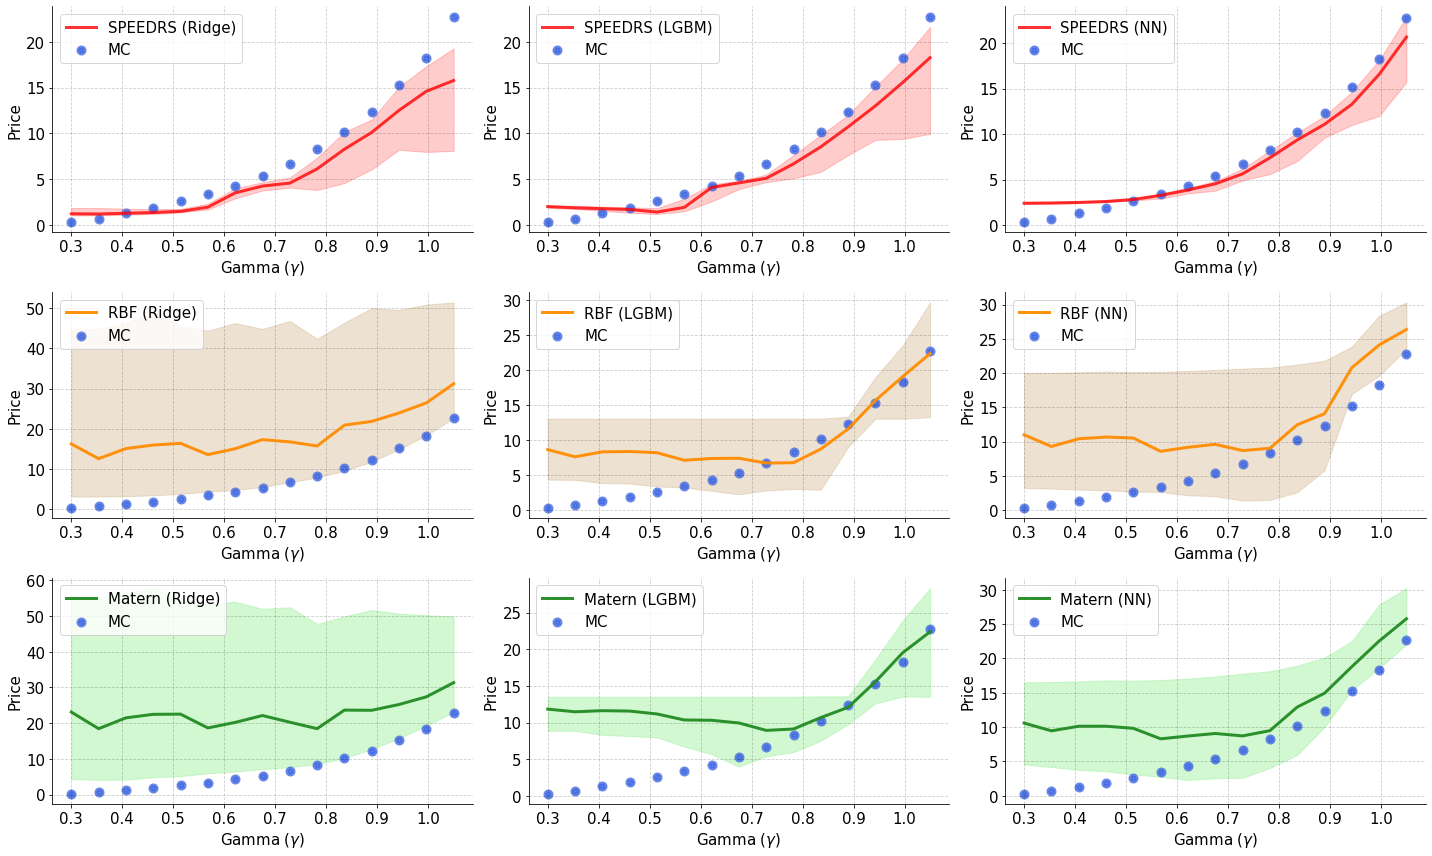

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

x_range = np.linspace(0.3, 1.05, 15)
construct_plot(ax[0, 2], cev_prices, predictions_cev_subsample, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[0, 0], cev_prices, predictions_cev_subsample_lr, x_range, [0.8, 0.2, 0.8],
               ['red', 'red', 'royalblue'], 'SPEEDRS (Ridge)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[0, 1], cev_prices, predictions_cev_subsample_lgbm, x_range, [0.8, 0.2, 0.8], 
               ['red', 'red', 'royalblue'], 'SPEEDRS (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')

construct_plot(ax[1, 2], cev_prices, predictions_cev_rbf_subsample, x_range, [0.95, 0.4, 0.8], 
               ['darkorange', 'tan', 'royalblue'], 'RBF (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[1, 0], cev_prices, predictions_cev_rbf_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (Ridge)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[1, 1], cev_prices, predictions_cev_rbf_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['darkorange', 'tan', 'royalblue'], 'RBF (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')


construct_plot(ax[2, 2], cev_prices, predictions_cev_matern_subsample, x_range, [0.95, 0.4, 0.8], 
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (NN)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[2, 0], cev_prices, predictions_cev_matern_subsample_lr, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (Ridge)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')
construct_plot(ax[2, 1], cev_prices, predictions_cev_matern_subsample_lgbm, x_range, [0.95, 0.4, 0.8],
               ['forestgreen', 'lightgreen', 'royalblue'], 'Matern (LGBM)', [3.0, 4.0], r'Gamma ($\gamma$)', 'Price', 'MC', title='')


plt.tight_layout()
folder = f'MixtureModels/BarrierOptions/Images/Thesis/CEV/Subsample'
filename = 'cev_pricing_subsample_thesis.svg'
file_path = Path(f'{folder}/{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{folder}/{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Save Test Results

In [67]:
test_results_pricing_dict = {
                            'Interpolation': [targets_mixtures,
                                              (predictions, predictions_linear, predictions_lgbm), 
                                              (predictions_rbf, predictions_rbf_linear, predictions_rbf_lgbm), 
                                              (predictions_matern, predictions_matern_linear, predictions_matern_lgbm)],
                             'TimeSteps': [targets_timesteps, prediction_speedrs_global, prediction_rbf_global, prediction_matern_global], 
                             'GBM': [gbm_prices, 
                                     (predictions_gbm, predictions_gbm_lr, predictions_gbm_lgbm),
                                     (predictions_gbm_rbf, predictions_gbm_rbf_lr, predictions_gbm_rbf_lgbm),
                                     (predictions_gbm_matern, predictions_gbm_matern_lr, predictions_gbm_matern_lgbm)],
                             'GBM_Subsample': [gbm_prices, 
                                               (predictions_gbm_subsample, predictions_gbm_subsample_lr, predictions_gbm_subsample_lgbm),
                                               (predictions_gbm_rbf_subsample, predictions_gbm_rbf_subsample_lr, predictions_gbm_rbf_subsample_lgbm),
                                               (predictions_gbm_matern_subsample, predictions_gbm_matern_subsample_lr, predictions_gbm_matern_subsample_lgbm)], 
                             'CEV': [cev_prices, 
                                     (predictions_cev, predictions_cev_lr, predictions_cev_lgbm),
                                     (predictions_cev_rbf, predictions_cev_rbf_lr, predictions_cev_rbf_lgbm), 
                                     (predictions_cev_matern, predictions_cev_matern_lr, predictions_cev_matern_lgbm)],
                             'CEV_Subsample': [cev_prices, 
                                               (predictions_cev_subsample, predictions_cev_subsample_lr, predictions_cev_subsample_lgbm), 
                                               (predictions_cev_rbf_subsample, predictions_cev_rbf_subsample_lr, predictions_cev_rbf_subsample_lgbm), 
                                               (predictions_cev_matern_subsample, predictions_cev_matern_subsample_lr, predictions_cev_matern_subsample_lgbm)]}


save_path_params(test_results_pricing_dict, "MixtureModels/BarrierOptions/Datasets/test_results_barrier_pricing_thesis")

### Performance Metrics <a class="anchor" id="test-data-drift-performance-metrics"></a>

In [8]:
test_results_pricing_dict = load_path_params("MixtureModels/BarrierOptions/Datasets/test_results_barrier_pricing_thesis")

targets_mixtures = test_results_pricing_dict['Interpolation'][0]
(predictions, predictions_linear, predictions_lgbm) = test_results_pricing_dict['Interpolation'][1]
(predictions_rbf, predictions_rbf_linear, predictions_rbf_lgbm) = test_results_pricing_dict['Interpolation'][2]
(predictions_matern, predictions_matern_linear, predictions_matern_lgbm) = test_results_pricing_dict['Interpolation'][3]


mixture_results = {'Target': targets_mixtures, 
                   'SPEEDRS Ridge': predictions_linear, 
                   'SPEEDRS LGBM': predictions_lgbm, 
                   'SPEEDRS NN': predictions, 
                   'RBF Ridge': predictions_rbf_linear, 
                   'RBF LGBM': predictions_rbf_lgbm, 
                   'RBF NN': predictions_rbf,
                   'Matern Ridge': predictions_matern_linear, 
                   'Matern LGBM': predictions_matern_lgbm, 
                   'Matern NN': predictions_matern
                  }

targets_timesteps = test_results_pricing_dict['TimeSteps'][0]
prediction_speedrs_global = test_results_pricing_dict['TimeSteps'][1]
prediction_rbf_global = test_results_pricing_dict['TimeSteps'][2]
prediction_matern_global = test_results_pricing_dict['TimeSteps'][3]

timesteps_results = {'Target': targets_timesteps, 
                     'SPEEDRS': prediction_speedrs_global, 
                     'RBF': prediction_rbf_global, 
                     'Matern': prediction_matern_global}

gbm_prices = test_results_pricing_dict['GBM'][0]
(predictions_gbm, predictions_gbm_lr, predictions_gbm_lgbm) = test_results_pricing_dict['GBM'][1]
(predictions_gbm_rbf, predictions_gbm_rbf_lr, predictions_gbm_rbf_lgbm) = test_results_pricing_dict['GBM'][2]
(predictions_gbm_matern, predictions_gbm_matern_lr, predictions_gbm_matern_lgbm) = test_results_pricing_dict['GBM'][3]

(predictions_gbm_subsample, predictions_gbm_subsample_lr, predictions_gbm_subsample_lgbm) = test_results_pricing_dict['GBM_Subsample'][1]
(predictions_gbm_rbf_subsample, predictions_gbm_rbf_subsample_lr, predictions_gbm_rbf_subsample_lgbm) = test_results_pricing_dict['GBM_Subsample'][2]
(predictions_gbm_matern_subsample, predictions_gbm_matern_subsample_lr, predictions_gbm_matern_subsample_lgbm) = test_results_pricing_dict['GBM_Subsample'][3]


gbm_results = {'Target': gbm_prices,
               'SPEEDRS (Ridge)': predictions_gbm_lr, 
               'SPEEDRS (LGBM)': predictions_gbm_lgbm,
               'SPEEDRS (NN)': predictions_gbm, 
               'RBF (Ridge)': predictions_gbm_rbf_lr, 
               'RBF (LGBM)': predictions_gbm_rbf_lgbm,
               'RBF (NN)': predictions_gbm_rbf,
               'Matern (Ridge)': predictions_gbm_matern_lr, 
               'Matern (LGBM)': predictions_gbm_matern_lgbm,
               'Matern (NN)': predictions_gbm_matern, 
               'SPEEDRS (Ridge) - Subsample': predictions_gbm_subsample_lr, 
               'SPEEDRS (LGBM) - Subsample': predictions_gbm_subsample_lgbm,
               'SPEEDRS (NN) - Subsample': predictions_gbm_subsample, 
               'RBF (Ridge) - Subsample': predictions_gbm_rbf_subsample_lr, 
               'RBF (LGBM) - Subsample': predictions_gbm_rbf_subsample_lgbm,
               'RBF (NN) - Subsample': predictions_gbm_rbf_subsample,
               'Matern (Ridge) - Subsample': predictions_gbm_matern_subsample_lr, 
               'Matern (LGBM) - Subsample': predictions_gbm_matern_subsample_lgbm,
               'Matern (NN) - Subsample': predictions_gbm_matern_subsample
              }

cev_prices = test_results_pricing_dict['CEV'][0]
(predictions_cev, predictions_cev_lr, predictions_cev_lgbm) = test_results_pricing_dict['CEV'][1]
(predictions_cev_rbf, predictions_cev_rbf_lr, predictions_cev_rbf_lgbm) = test_results_pricing_dict['CEV'][2]
(predictions_cev_matern, predictions_cev_matern_lr, predictions_cev_matern_lgbm) = test_results_pricing_dict['CEV'][3]

(predictions_cev_subsample, predictions_cev_subsample_lr, predictions_cev_subsample_lgbm) = test_results_pricing_dict['CEV_Subsample'][1]
(predictions_cev_rbf_subsample, predictions_cev_rbf_subsample_lr, predictions_cev_rbf_subsample_lgbm) = test_results_pricing_dict['CEV_Subsample'][2]
(predictions_cev_matern_subsample, predictions_cev_matern_subsample_lr, predictions_cev_matern_subsample_lgbm) = test_results_pricing_dict['CEV_Subsample'][3]

cev_results = {'Target': cev_prices,
               'SPEEDRS (Ridge)': predictions_cev_lr, 
               'SPEEDRS (LGBM)': predictions_cev_lgbm,
               'SPEEDRS (NN)': predictions_cev, 
               'RBF (Ridge)': predictions_cev_rbf_lr, 
               'RBF (LGBM)': predictions_cev_rbf_lgbm,
               'RBF (NN)': predictions_cev_rbf,
               'Matern (Ridge)': predictions_cev_matern_lr, 
               'Matern (LGBM)': predictions_cev_matern_lgbm,
               'Matern (NN)': predictions_cev_matern, 
               'SPEEDRS (Ridge) - Subsample': predictions_cev_subsample_lr, 
               'SPEEDRS (LGBM) - Subsample': predictions_cev_subsample_lgbm,
               'SPEEDRS (NN) - Subsample': predictions_cev_subsample, 
               'RBF (Ridge) - Subsample': predictions_cev_rbf_subsample_lr, 
               'RBF (LGBM) - Subsample': predictions_cev_rbf_subsample_lgbm,
               'RBF (NN) - Subsample': predictions_cev_rbf_subsample,
               'Matern (Ridge) - Subsample': predictions_cev_matern_subsample_lr, 
               'Matern (LGBM) - Subsample': predictions_cev_matern_subsample_lgbm,
               'Matern (NN) - Subsample': predictions_cev_matern_subsample
              }

In [90]:
def worst_MSE(targets, preds, x_range):

    furthest = []
    
    for i, key in enumerate(x_range):

        j = np.argmax(np.abs(preds[key] - targets[i]))
        furthest.append(preds[key][j])

    return mean_squared_error(targets, furthest)

### Test 1 - Mixture Values

In [96]:
x_range = np.linspace(0, 1, 20)

for key, value in mixture_results.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in x_range]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in x_range]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 2)}')
        print(f'Worst MSE: {np.round(worst_MSE(targets, value, x_range), 2)}')
        print(f'{"*"*100}')

SPEEDRS Ridge
Avg MSE: 0.49
Worst MSE: 1.72
****************************************************************************************************
SPEEDRS LGBM
Avg MSE: 0.39
Worst MSE: 1.72
****************************************************************************************************
SPEEDRS NN
Avg MSE: 0.11
Worst MSE: 0.71
****************************************************************************************************
RBF Ridge
Avg MSE: 0.13
Worst MSE: 5.26
****************************************************************************************************
RBF LGBM
Avg MSE: 0.75
Worst MSE: 8.61
****************************************************************************************************
RBF NN
Avg MSE: 0.07
Worst MSE: 6.38
****************************************************************************************************
Matern Ridge
Avg MSE: 0.16
Worst MSE: 5.26
****************************************************************************************************
Matern

### Test 2 - Path Length

In [112]:
x_range = np.linspace(0, 1, 20)
models = ['NN', 'LR', 'LGBM']
for key, value in timesteps_results.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in x_range]
    else:
        for kk, vv in value.items():
            for i in range(3):
                print(f'{key} {models[i]} {kk+1}')
                pred_vals = [np.nanmean(vv[i][k]) for k in x_range]
                print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 2)}')
                print(f'Worst MSE: {np.round(worst_MSE(targets, vv[i], x_range), 2)}')
                print(f'{"*"*100}')

SPEEDRS NN 10
Avg MSE: 0.24
Worst MSE: 2.39
****************************************************************************************************
SPEEDRS LR 10
Avg MSE: 1.49
Worst MSE: 4.07
****************************************************************************************************
SPEEDRS LGBM 10
Avg MSE: 1.45
Worst MSE: 4.9
****************************************************************************************************
SPEEDRS NN 15
Avg MSE: 0.11
Worst MSE: 1.83
****************************************************************************************************
SPEEDRS LR 15
Avg MSE: 1.0
Worst MSE: 3.56
****************************************************************************************************
SPEEDRS LGBM 15
Avg MSE: 0.67
Worst MSE: 3.44
****************************************************************************************************
SPEEDRS NN 25
Avg MSE: 0.24
Worst MSE: 2.44
************************************************************************************

### Test 3 - Unseen Regimes

#### GBM

In [117]:
x_range = np.linspace(0.2, 0.8, 20)

for key, value in gbm_results.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in x_range]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in x_range]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 2)}')
        print(f'Worst MSE: {np.round(worst_MSE(targets, value, x_range), 2)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.51
Worst MSE: 2.82
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.45
Worst MSE: 1.82
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.11
Worst MSE: 1.71
****************************************************************************************************
RBF (Ridge)
Avg MSE: 1.58
Worst MSE: 11.35
****************************************************************************************************
RBF (LGBM)
Avg MSE: 1.78
Worst MSE: 12.82
****************************************************************************************************
RBF (NN)
Avg MSE: 1.46
Worst MSE: 12.5
****************************************************************************************************
Matern (Ridge)
Avg MSE: 2.11
Worst MSE: 13.16
******************************************************************************************

#### CEV

In [116]:
x_range = np.linspace(0.3, 1.05, 15)

for key, value in cev_results.items():

    if key == 'Target':
        targets = [np.nanmean(value[k]) for k in x_range]
    else:
        print(f'{key}')
        pred_vals = [np.nanmean(value[k]) for k in x_range]
        print(f'Avg MSE: {np.round(mean_squared_error(targets, pred_vals), 2)}')
        print(f'Worst MSE: {np.round(worst_MSE(targets, value, x_range), 2)}')
        print(f'{"*"*100}')

SPEEDRS (Ridge)
Avg MSE: 0.59
Worst MSE: 1.6
****************************************************************************************************
SPEEDRS (LGBM)
Avg MSE: 0.65
Worst MSE: 1.43
****************************************************************************************************
SPEEDRS (NN)
Avg MSE: 0.66
Worst MSE: 1.21
****************************************************************************************************
RBF (Ridge)
Avg MSE: 1.38
Worst MSE: 6.26
****************************************************************************************************
RBF (LGBM)
Avg MSE: 2.93
Worst MSE: 7.02
****************************************************************************************************
RBF (NN)
Avg MSE: 1.64
Worst MSE: 5.7
****************************************************************************************************
Matern (Ridge)
Avg MSE: 2.09
Worst MSE: 6.3
************************************************************************************************